In [3]:
import torch
import torch.nn as nn
import math
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle
import tqdm
import pandas as pd

In [159]:
class OmniglotClassifier(nn.Module):
    def __init__(self, layer_size, nClasses = 0, num_channels = 1, keep_prob = 0.0, image_size = 28, freeze = False):
        super(OmniglotClassifier, self).__init__()
        self.layer1 = self.convLayer(num_channels, layer_size, keep_prob)
        self.layer2 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer3 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer4 = self.convLayer(layer_size, layer_size, keep_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size
        if nClasses>0: # We want a linear
            self.useClassification = True
            self.layer5 = nn.Linear(self.outSize,nClasses)
            self.outSize = nClasses
        else:
            self.useClassification = False
        
    def convLayer(self, in_channels, out_channels, keep_prob):
        cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(keep_prob)
        )
        return cnn_seq
    
    def freeze(self):
        for name, parameter in self.named_parameters():
            parameter.requries_grad = False

    def forward(self, image_input):
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size()[0], -1)
        if self.useClassification:
            x = self.layer5(x)
        return x

In [160]:
class CifarClassifier(nn.Module):
    def __init__(self, layer_size, nClasses = 0, num_channels = 1, keep_prob = 0.0, image_size = 32, freeze = False):
        super(CifarClassifier, self).__init__()
        self.layer1 = self.convLayer(num_channels, layer_size, keep_prob)
        self.layer2 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer3 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer4 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer5 = self.convLayer(layer_size, layer_size, keep_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size
        if nClasses>0: # We want a linear
            self.useClassification = True
            self.layer6 = nn.Linear(self.outSize,nClasses)
            self.outSize = nClasses
        else:
            self.useClassification = False
        
    def convLayer(self, in_channels, out_channels, keep_prob):
        cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(keep_prob)
        )
        return cnn_seq
    
    def freeze(self):
        for name, parameter in self.named_parameters():
            parameter.requries_grad = False

    def forward(self, image_input):
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size()[0], -1)
        if self.useClassification:
            x = self.layer6(x)
        return x

In [161]:
class miniImageNetClassifier(nn.Module):
    def __init__(self, layer_size, nClasses = 0, num_channels = 1, keep_prob = 0.0, image_size = 28, freeze = False):
        super(miniImageNetClassifier, self).__init__()
        self.layer1 = self.convLayer(num_channels, layer_size, keep_prob)
        self.layer2 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer3 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer4 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer5 = self.convLayer(layer_size, layer_size, keep_prob)
        self.layer6 = self.convLayer(layer_size, layer_size, keep_prob)

        finalSize = int(math.floor(image_size / (2 * 2 * 2 * 2 * 2 * 2)))
        self.outSize = finalSize * finalSize * layer_size
        if nClasses>0: # We want a linear
            self.useClassification = True
            self.layer7 = nn.Linear(self.outSize,nClasses)
            self.outSize = nClasses
        else:
            self.useClassification = False
            
            
        
    def convLayer(self, in_channels, out_channels, keep_prob):
        cnn_seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(True),
        nn.BatchNorm2d(out_channels),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(keep_prob)
        )
        return cnn_seq
    
    def freeze(self):
        for name, parameter in self.named_parameters():
            parameter.requries_grad = False

    def forward(self, image_input):
        x = self.layer1(image_input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size()[0], -1)
        if self.useClassification:
            x = self.layer7(x)
        return x

In [218]:
class CosineAttentionClassifier(nn.Module):
    def __init__(self):
        super(CosineAttentionClassifier, self).__init__()

    def forward(self, s, target, s_label):
        eps = 1e-10
        similarity = []
        m_target = torch.sum(torch.pow(target, 2), 1)
        r_target = m_target.clamp(eps, float("inf")).rsqrt()
        for x_i in s:
            m_xi = torch.sum(torch.pow(x_i, 2), 1)
            r_xi = m_xi.clamp(eps, float("inf")).rsqrt()
            dot = target.unsqueeze(1).bmm(x_i.unsqueeze(2)).squeeze()
            c_s = dot * r_target * r_xi
            similarity.append(c_s)
        similarity = torch.stack(similarity)
        
        #softmax = nn.Softmax()
        #softmax_sim = softmax(similarity.t())
        #preds = softmax_sim.unsqueeze(1).bmm(s_label).squeeze()
        
        #return preds
        return similarity.t()

In [8]:
class FCE_g(nn.Module):
    def __init__(self, layer_size, batch_size, vector_dim,use_cuda):
        super(FCE_g, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = layer_size
        self.vector_dim = vector_dim
        self.use_cuda = use_cuda
        self.lstm = nn.LSTM(input_size=self.vector_dim, num_layers=1, hidden_size=self.hidden_size,
                            bidirectional=True)

    def init_hidden(self,use_cuda):
        if use_cuda:
            return (Variable(torch.zeros(2, self.batch_size, self.lstm.hidden_size),requires_grad=True).cuda(),
                    Variable(torch.zeros(2, self.batch_size, self.lstm.hidden_size),requires_grad=True).cuda())
        else:
            return (Variable(torch.zeros(2, self.batch_size, self.lstm.hidden_size),requires_grad=True),
                    Variable(torch.zeros(2, self.batch_size, self.lstm.hidden_size),requires_grad=True))

    def forward(self, inputs):
        hidden = self.init_hidden(self.use_cuda)
        output, _ = self.lstm(inputs,hidden)
        outputs = torch.add(inputs,output)
        return outputs

In [9]:
class FCE_f(nn.Module):
    def __init__(self,read_steps,layer_size,batch_size,vector_dim,use_cuda):
        super(FCE_f,self).__init__()
        self.read_steps = read_steps
        self.batch_size = batch_size
        self.hidden_size = layer_size
        self.vector_dim = vector_dim
        self.use_cuda = use_cuda
        self.lstmRead = nn.LSTMCell(input_size=self.vector_dim,hidden_size=self.hidden_size)
        self.softmax = nn.Softmax(dim=0)
        
    def init_hidden(self,use_cuda):
        if use_cuda:
            return (Variable(torch.zeros(self.batch_size, self.lstmRead.hidden_size),requires_grad=True).cuda(),
                    Variable(torch.zeros(self.batch_size, self.lstmRead.hidden_size),requires_grad=True).cuda())
        else:
            return (Variable(torch.zeros(self.batch_size, self.lstmRead.hidden_size),requires_grad=True),
                    Variable(torch.zeros(self.batch_size, self.lstmRead.hidden_size),requires_grad=True))
        
    def forward(self, inputs, memory):
        prev_hc = self.init_hidden(self.use_cuda)
        for step in range(self.read_steps):
            hidden_cap, cell = self.lstmRead(inputs, prev_hc)
            h_k = torch.add(hidden_cap,inputs)
            content_based_attention = self.softmax(torch.mul(prev_hc[0],memory))
            r_k = torch.sum(torch.mul(content_based_attention,memory),axis=0)
            
            prev_hc = tuple((torch.add(h_k,r_k),cell))
            
        return h_k

In [223]:
class MatchingNetwork(nn.Module):
    def __init__(self, keep_prob=0.0, batch_size=32, num_channels=1, fce=False, image_size=28, use_cuda=True, model = 0):
        super(MatchingNetwork, self).__init__()
        '''Parameters'''
        self.batch_size = batch_size
        self.keep_prob = keep_prob
        self.num_channels = num_channels
        self.learning_rate = learning_rate
        self.fce = fce
        self.image_size = image_size
        
        '''Networks'''
        if model == 0:
            self.embedding = OmniglotClassifier(layer_size=64,nClasses=0,num_channels=num_channels,keep_prob=keep_prob,image_size=image_size)
        elif model == 1:
            self.embedding = miniImageNetClassifier(layer_size=64,nClasses=0,num_channels=num_channels,keep_prob=keep_prob,image_size=image_size)
        else:
            self.embedding = CifarClassifier(layer_size=64,nClasses=0,num_channels=num_channels,keep_prob=keep_prob,image_size=image_size)
        self.classifier = CosineAttentionClassifier()
        
        if self.fce:
            self.FCE_f = FCE_f(10,layer_size=64, batch_size=self.batch_size, vector_dim=self.embedding.outSize,use_cuda=use_cuda)
            self.FCE_g = FCE_g(layer_size=32, batch_size=self.batch_size, vector_dim=self.embedding.outSize,use_cuda=use_cuda)

    def forward(self, s, s_y, target, target_y):
        embedded_xi = []
        for i in np.arange(s.size(1)):
            x_i = self.embedding(s[:, i, :, :])
            embedded_xi.append(x_i)
        support = torch.stack(embedded_xi)

        sample = self.embedding(target)

        if self.fce:
            FCE_support = self.FCE_g(support)
            FCE_sample = self.FCE_f(sample, FCE_support)
            preds = self.classifier(s = FCE_support, target = FCE_sample, s_label=s_y)
            
        else:
            preds = self.classifier(s = support, target = sample, s_label=s_y)
        
        values, indices = preds.max(1)
        accuracy = torch.mean((indices.squeeze() == target_y).float())
        #crossentropy_loss = F.nll_loss(preds, target_y.long())
        crossentropy_loss = F.cross_entropy(preds, target_y.long())
        

        return accuracy, crossentropy_loss

In [209]:
def MetaTraining(data,total_train_batches,matchingNet,optimizer,use_cuda,mn_one_shot=False):
    total_c_loss = 0.0
    total_accuracy = 0.0
    if torch.cuda.is_available() & use_cuda:
        matchingNet.cuda()

    for i in range(total_train_batches):
        if mn_one_shot:
            x_support_set, y_support_set, x_target, y_target = data.get_test_batch(False)
        else:
            x_support_set, y_support_set, x_target, y_target = data.get_train_batch(False)
        x_support_set = Variable(torch.from_numpy(x_support_set)).float()
        y_support_set = Variable(torch.from_numpy(y_support_set), requires_grad=False).long()
        x_target = Variable(torch.from_numpy(x_target)).float()
        y_target = Variable(torch.from_numpy(y_target), requires_grad=False).squeeze().long()

        y_support_set = y_support_set.unsqueeze(2)
        sequence_length = y_support_set.size()[1]
        batch_size = y_support_set.size()[0]
        y_support_set_one_hot = Variable(torch.zeros(batch_size, sequence_length, data.classes_per_set).scatter_(2,y_support_set.data,1), requires_grad=False)
        
        size = x_support_set.size()
        x_support_set = x_support_set.permute(0, 1, 4, 2, 3)
        x_target = x_target.permute(0, 3, 1, 2)
        if torch.cuda.is_available() & use_cuda:
            acc, c_loss = matchingNet(x_support_set.cuda(), y_support_set_one_hot.cuda(), x_target.cuda(),y_target.cuda())
        else:
            acc, c_loss = matchingNet(x_support_set, y_support_set_one_hot, x_target, y_target)

        optimizer.zero_grad()
        c_loss.backward()
        optimizer.step()

        total_c_loss += c_loss.item()
        total_accuracy += acc.item()

    total_c_loss = total_c_loss / total_train_batches
    total_accuracy = total_accuracy / total_train_batches
    return total_c_loss, total_accuracy

In [12]:
def MetaValidate(data,total_val_batches,matchingNet,scheduler,use_cuda,validate):
    total_c_loss = 0.0
    total_accuracy = 0.0

    for i in range(total_val_batches):
        if validate:
            s_x, s_y, target_x, target_y = data.get_val_batch(False)
        else:
            s_x, s_y, target_x, target_y = data.get_test_batch(False)
        s_x = Variable(torch.from_numpy(s_x)).float()
        s_y = Variable(torch.from_numpy(s_y), requires_grad=False).long()
        target_x = Variable(torch.from_numpy(target_x)).float()
        target_y = Variable(torch.from_numpy(target_y), requires_grad=False).squeeze().long()

        s_y = s_y.unsqueeze(2)
        sequence_length = s_y.size()[1]
        batch_size = s_y.size()[0]
        s_y_oneHot = Variable(torch.zeros(batch_size, sequence_length, data.classes_per_set).scatter_(2,s_y.data,1), requires_grad=False)

        size = s_x.size()
        s_x = s_x.permute(0, 1, 4, 2, 3)
        target_x = target_x.permute(0, 3, 1, 2)
        if torch.cuda.is_available() & use_cuda:
            acc, c_loss = matchingNet(s_x.cuda(), s_y_oneHot.cuda(), target_x.cuda(),target_y.cuda())
        else:
            acc, c_loss = matchingNet(s_x, s_y_oneHot, target_x, target_y)


        total_c_loss += c_loss.item()
        total_accuracy += acc.item()


    total_c_loss = total_c_loss / total_val_batches
    total_accuracy = total_accuracy / total_val_batches
    scheduler.step(total_c_loss)
    return total_c_loss, total_accuracy

In [64]:
def PreTraining(data,model,optimizer,total_train_batches,use_cuda):
    total_c_loss = 0.0
    total_accuracy = 0.0
    if torch.cuda.is_available() & use_cuda:
        model = model.cuda()

    for i in range(total_train_batches):
        train_samples, train_labels = data.get_normal_train_batch(128)
        train_samples = Variable(torch.from_numpy(train_samples)).float()
        train_labels = Variable(torch.from_numpy(train_labels), requires_grad=False).long()

        train_labels = train_labels.unsqueeze(1)
        train_labels_set_one_hot = Variable(torch.zeros(128,data.nClasses).scatter_(1,train_labels.data,1), requires_grad=False)
        
        size = train_samples.size()
        train_samples = train_samples.permute(0, 3, 1, 2)
        if torch.cuda.is_available() & use_cuda:
            pred = model(train_samples.cuda())
            train_labels = train_labels.cuda()
            train_labels_set_one_hot = train_labels_set_one_hot.cuda()
        else:
            pred = model(train_samples)
            
        values, indices = pred.max(1)
        accuracy = torch.mean((indices.squeeze() == train_labels.squeeze(1)).float())
        crossentropy_loss = F.cross_entropy(pred, train_labels.squeeze(1).long())


        optimizer.zero_grad()
        crossentropy_loss.backward()
        optimizer.step()

        total_c_loss += crossentropy_loss.item()
        total_accuracy += accuracy.item()

    total_c_loss = total_c_loss / total_train_batches
    total_accuracy = total_accuracy / total_train_batches
    return total_c_loss, total_accuracy

In [206]:
class OmniglotNShotDataset():
    def __init__(self, batch_size, classes_per_set=20, samples_per_class=1, seed=2021, shuffle=True):
        np.random.seed(seed)
        self.nClasses = 1623
        self.x = np.load('data.npy')
        self.x = np.reshape(self.x, newshape=(self.x.shape[0], self.x.shape[1], 28, 28, 1))
        if shuffle:
            np.random.shuffle(self.x)
        self.x_train, self.x_val, self.x_test = self.x[:1040], self.x[1040:1300], self.x[1300:]
        # self.mean = np.mean(list(self.x_train) + list(self.x_val))
        self.x_train = self.processes_batch(self.x_train, np.mean(self.x_train), np.std(self.x_train))
        self.x_test = self.processes_batch(self.x_test, np.mean(self.x_test), np.std(self.x_test))
        self.x_val = self.processes_batch(self.x_val, np.mean(self.x_val), np.std(self.x_val))
        # self.std = np.std(list(self.x_train) + list(self.x_val))
        self.batch_size = batch_size
        self.n_classes = self.x.shape[0]
        self.classes_per_set = classes_per_set
        self.samples_per_class = samples_per_class
        self.indexes = {"train": 0, "val": 0, "test": 0}
        self.datatset = {"train": self.x_train, "val": self.x_val, "test": self.x_test}

    def processes_batch(self, x_batch, mean, std):
        return (x_batch - mean) / std

    def _sample_new_batch(self, data_pack):
        support_set_x = np.zeros((self.batch_size, self.classes_per_set, self.samples_per_class, data_pack.shape[2],
                                  data_pack.shape[3], data_pack.shape[4]), np.float32)

        support_set_y = np.zeros((self.batch_size, self.classes_per_set, self.samples_per_class), np.int32)
        target_x = np.zeros((self.batch_size, data_pack.shape[2], data_pack.shape[3], data_pack.shape[4]), np.float32)
        target_y = np.zeros((self.batch_size, 1), np.int32)

        for i in range(self.batch_size):
            classes_idx = np.arange(data_pack.shape[0])
            samples_idx = np.arange(data_pack.shape[1])
            choose_classes = np.random.choice(classes_idx, size=self.classes_per_set, replace=False)
            choose_label = np.random.choice(self.classes_per_set, size=1)
            choose_samples = np.random.choice(samples_idx, size=self.samples_per_class + 1, replace=False)

            x_temp = data_pack[choose_classes]
            x_temp = x_temp[:, choose_samples]
            y_temp = np.arange(self.classes_per_set)
            support_set_x[i] = x_temp[:, :-1]
            support_set_y[i] = np.expand_dims(y_temp[:], axis=1)
            target_x[i] = x_temp[choose_label, -1]
            target_y[i] = y_temp[choose_label]

        return support_set_x, support_set_y, target_x, target_y

    def _rotate_data(self, image, k):
        return np.rot90(image, k)

    def _rotate_batch(self, batch_images, k):
        batch_size = batch_images.shape[0]
        for i in np.arange(batch_size):
            batch_images[i] = self._rotate_data(batch_images[i], k)
        return batch_images

    def _get_batch(self, dataset_name, augment=False):
        support_set_x, support_set_y, target_x, target_y = self._sample_new_batch(self.datatset[dataset_name])
        if augment:
            k = np.random.randint(0, 4, size=(self.batch_size, self.classes_per_set))
            a_support_set_x = []
            a_target_x = []
            for b in range(self.batch_size):
                temp_class_set = []
                for c in range(self.classes_per_set):
                    temp_class_set_x = self._rotate_batch(support_set_x[b, c], k=k[b, c])
                    if target_y[b] == support_set_y[b, c, 0]:
                        temp_target_x = self._rotate_data(target_x[b], k=k[b, c])
                    temp_class_set.append(temp_class_set_x)
                a_support_set_x.append(temp_class_set)
                a_target_x.append(temp_target_x)
            support_set_x = np.array(a_support_set_x)
            target_x = np.array(a_target_x)
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y
    
    def get_normal_train_batch(self,batch_size):
        train_samples = []
        train_labels = []
        for i in range(batch_size):
            choose_class = np.random.randint(self.x_train.shape[0])
            choose_image = np.random.randint(self.x_train.shape[1])
            train_samples.append(self.x_train[choose_class,choose_image,:,:,:].tolist())
            train_labels.append(choose_class)
            
        return np.array(train_samples).reshape(batch_size,28,28,1),np.array(train_labels)

    def get_train_batch(self, augment=False):
        return self._get_batch("train", augment)

    def get_val_batch(self, augment=False):
        return self._get_batch("val", augment)

    def get_test_batch(self, augment=False):
        return self._get_batch("test", augment)

In [207]:
class MiniImageNetNShotDataset():
    def __init__(self, batch_size, classes_per_set=20, samples_per_class=1, seed=2021,use_cache=True):
        np.random.seed(seed)
        self.nClasses = 100
        self.train = self.retrieve_data('mini-imagenet-cache-train.pkl')
        self.test = self.retrieve_data('mini-imagenet-cache-test.pkl')
        self.val = self.retrieve_data('mini-imagenet-cache-val.pkl')
        self.x_train = self.processes_batch(self.train, np.mean(self.train), np.std(self.train))
        self.x_test = self.processes_batch(self.test, np.mean(self.test), np.std(self.test))
        self.x_val = self.processes_batch(self.val, np.mean(self.val), np.std(self.val))
        self.x = np.vstack([self.train,self.test,self.val])
        print(self.x.shape)

        self.batch_size = batch_size
        self.classes_per_set = classes_per_set
        self.samples_per_class = samples_per_class
        self.datatset = {"train": self.x_train, "val": self.x_val, "test": self.x_test}
            
    def processes_batch(self, x_batch, mean, std):
        return (x_batch - mean) / std
    
    def retrieve_data(self, file):
        pkl_file = open(file, 'rb')
        miniImageData  = pickle.load(pkl_file)
        pkl_file.close()
        
        data = []
        for key in list(miniImageData['class_dict'].keys()):
            image_index_list = miniImageData['class_dict'][key]
            data.append(miniImageData['image_data'][image_index_list])
            
        return np.array(data)
    
    def _sample_new_batch(self, data_pack):
        support_set_x = []
        support_set_y = []
        target_x = []
        target_y = []

        for i in range(self.batch_size):
            classes_idx = np.arange(data_pack.shape[0])
            samples_idx = np.arange(data_pack.shape[1])
            choose_classes = np.random.choice(classes_idx, size=self.classes_per_set, replace=False)
            choose_label = np.random.choice(self.classes_per_set, size=1)
            choose_sample = np.random.choice(samples_idx, size=self.samples_per_class, replace=False)

            x_temp = data_pack[choose_classes, choose_sample]
            y_temp = np.arange(self.classes_per_set)
            support_set_x.append(x_temp)
            support_set_y.append(np.expand_dims(y_temp[:], axis=1))
            target_x.append(data_pack[choose_classes[choose_label], np.random.randint(600)])
            target_y.append(y_temp[choose_label])

        return np.array(support_set_x).reshape((self.batch_size, self.classes_per_set, self.samples_per_class, data_pack.shape[2],data_pack.shape[3], data_pack.shape[4])),np.array(support_set_y).reshape((self.batch_size, self.classes_per_set, self.samples_per_class)), np.array(target_x).reshape((self.batch_size, data_pack.shape[2], data_pack.shape[3], data_pack.shape[4])), np.array(target_y).reshape((self.batch_size, 1))
    
    def _rotate_data(self, image, k):
        return np.rot90(image, k)
    
    def _rotate_batch(self, batch_images, k):
        batch_size = batch_images.shape[0]
        for i in np.arange(batch_size):
            batch_images[i] = self._rotate_data(batch_images[i], k)
        return batch_images
    
    def _get_batch(self, dataset_name, augment=False):
        support_set_x, support_set_y, target_x, target_y = self._sample_new_batch(self.datatset[dataset_name])
        
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y
    
    def get_normal_train_batch(self,batch_size):
        choose_class = np.random.randint(64,size=batch_size)
        choose_image = np.random.randint(600,size=batch_size)
        train_samples = self.x_train[choose_class,choose_image,:,:,:]
        train_labels = choose_class
            
        return np.array(train_samples).reshape(batch_size,84,84,3),np.array(train_labels)
    
    def get_train_batch(self, augment=False):
        return self._get_batch("train", augment)

    def get_val_batch(self, augment=False):
        return self._get_batch("val", augment)

    def get_test_batch(self, augment=False):
        return self._get_batch("test", augment)


In [208]:
class CifarNShotDataset():
    def __init__(self, batch_size, classes_per_set=20, samples_per_class=1, seed=2021, shuffle=True):
        np.random.seed(seed)
        self.nClasses = 100
        self.x = self.retrieve_data('cifar_train.pkl')
        self.x_train, self.x_val, self.x_test = self.x[:64], self.x[64:80], self.x[80:]

        self.x_train = self.processes_batch(self.x_train, np.mean(self.x_train), np.std(self.x_train))
        self.x_test = self.processes_batch(self.x_test, np.mean(self.x_test), np.std(self.x_test))
        self.x_val = self.processes_batch(self.x_val, np.mean(self.x_val), np.std(self.x_val))

        self.batch_size = batch_size
        self.n_classes = self.x.shape[0]
        self.classes_per_set = classes_per_set
        self.samples_per_class = samples_per_class
        self.indexes = {"train": 0, "val": 0, "test": 0}
        self.datatset = {"train": self.x_train, "val": self.x_val, "test": self.x_test}

    def processes_batch(self, x_batch, mean, std):
        return (x_batch - mean) / std
    
    def retrieve_data(self,file):
        pkl_file = open(file, 'rb')
        cifarData  = pickle.load(pkl_file,encoding='bytes')
        pkl_file.close()

        data = []
        frame = pd.DataFrame(zip(cifarData[list(cifarData.keys())[2]],cifarData[list(cifarData.keys())[4]]))
        for i in range(100):
            data.append(frame[frame[0]==i][1].tolist())

        return np.array(data).reshape(100,500,3,32,32).transpose(0,1,3,4,2)

    def _sample_new_batch(self, data_pack):
        support_set_x = []
        support_set_y = []
        target_x = []
        target_y = []

        for i in range(self.batch_size):
            classes_idx = np.arange(data_pack.shape[0])
            samples_idx = np.arange(data_pack.shape[1])
            choose_classes = np.random.choice(classes_idx, size=self.classes_per_set, replace=False)
            choose_label = np.random.choice(self.classes_per_set, size=1)
            choose_sample = np.random.choice(samples_idx, size=self.samples_per_class, replace=False)

            x_temp = data_pack[choose_classes, choose_sample]
            y_temp = np.arange(self.classes_per_set)
            support_set_x.append(x_temp)
            support_set_y.append(np.expand_dims(y_temp[:], axis=1))
            target_x.append(data_pack[choose_classes[choose_label], np.random.randint(500)])
            target_y.append(y_temp[choose_label])

        return np.array(support_set_x).reshape((self.batch_size, self.classes_per_set, self.samples_per_class, data_pack.shape[2],data_pack.shape[3], data_pack.shape[4])),np.array(support_set_y).reshape((self.batch_size, self.classes_per_set, self.samples_per_class)), np.array(target_x).reshape((self.batch_size, data_pack.shape[2], data_pack.shape[3], data_pack.shape[4])), np.array(target_y).reshape((self.batch_size, 1))

    def _rotate_data(self, image, k):
        return np.rot90(image, k)

    def _rotate_batch(self, batch_images, k):
        batch_size = batch_images.shape[0]
        for i in np.arange(batch_size):
            batch_images[i] = self._rotate_data(batch_images[i], k)
        return batch_images

    def _get_batch(self, dataset_name, augment=False):
        support_set_x, support_set_y, target_x, target_y = self._sample_new_batch(self.datatset[dataset_name])
        if augment:
            k = np.random.randint(0, 4, size=(self.batch_size, self.classes_per_set))
            a_support_set_x = []
            a_target_x = []
            for b in range(self.batch_size):
                temp_class_set = []
                for c in range(self.classes_per_set):
                    temp_class_set_x = self._rotate_batch(support_set_x[b, c], k=k[b, c])
                    if target_y[b] == support_set_y[b, c, 0]:
                        temp_target_x = self._rotate_data(target_x[b], k=k[b, c])
                    temp_class_set.append(temp_class_set_x)
                a_support_set_x.append(temp_class_set)
                a_target_x.append(temp_target_x)
            support_set_x = np.array(a_support_set_x)
            target_x = np.array(a_target_x)
        support_set_x = support_set_x.reshape((support_set_x.shape[0], support_set_x.shape[1] * support_set_x.shape[2],
                                               support_set_x.shape[3], support_set_x.shape[4], support_set_x.shape[5]))
        support_set_y = support_set_y.reshape(support_set_y.shape[0], support_set_y.shape[1] * support_set_y.shape[2])
        return support_set_x, support_set_y, target_x, target_y
    
    def get_normal_train_batch(self,batch_size):
        train_samples = []
        train_labels = []
        for i in range(batch_size):
            choose_class = np.random.randint(64)
            choose_image = np.random.randint(500)
            train_samples.append(self.x_train[choose_class,choose_image,:,:,:].tolist())
            train_labels.append(choose_class)
            
        return np.array(train_samples).reshape(batch_size,32,32,3),np.array(train_labels)

    def get_train_batch(self, augment=False):
        return self._get_batch("train", augment)

    def get_val_batch(self, augment=False):
        return self._get_batch("val", augment)

    def get_test_batch(self, augment=False):
        return self._get_batch("test", augment)

In [14]:
# Experiment setup
batch_size = 16
classes_per_set = 5
samples_per_class = 1
channels = 1
use_cuda = True
learning_rate = 1e-3
# Training setup
total_epochs = 200
total_train_batches = 64
total_val_batches = 16
total_test_batches = 16
best_val_acc = 0.0

# Start from scratch:Omniglot

In [224]:
dataO = OmniglotNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

In [225]:
OS_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=1, fce=False, image_size=28, use_cuda=True)
OS_optimizer = torch.optim.Adam(OS_MatchingNet.parameters(), lr=1e-3)
OS_scheduler = ReduceLROnPlateau(OS_optimizer, 'min',verbose=True)
OSN_train_loss = []
OSN_train_accuracy = []
OSN_validate_loss = []
OSN_validate_accuracy = []

In [226]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataO,total_train_batches, OS_MatchingNet, OS_optimizer, use_cuda)
        OSN_train_loss.append(t_loss)
        OSN_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, OS_MatchingNet, OS_scheduler, use_cuda, True)
        OSN_validate_loss.append(v_loss)
        OSN_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

OSN_accuracy = MetaValidate(dataO,total_test_batches, OS_MatchingNet, OS_scheduler, use_cuda, False)
print('final test accuracy: {}'.format(OSN_accuracy))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.3236657343804836 train_accuracy:0.6640625


  0%|▍                                                                                 | 1/200 [00:02<09:45,  2.94s/it]

Epoch 0: validate_loss:1.2204801142215729 validate_accuracy:0.7421875
Epoch 1: train_loss:1.19190364331007 train_accuracy:0.7685546875


  1%|▊                                                                                 | 2/200 [00:05<09:40,  2.93s/it]

Epoch 1: validate_loss:1.1449198201298714 validate_accuracy:0.80859375
Epoch 2: train_loss:1.1340048480778933 train_accuracy:0.83984375


  2%|█▏                                                                                | 3/200 [00:08<09:36,  2.93s/it]

Epoch 2: validate_loss:1.1469729244709015 validate_accuracy:0.8125
Epoch 3: train_loss:1.1289280019700527 train_accuracy:0.8271484375


  2%|█▋                                                                                | 4/200 [00:11<09:33,  2.93s/it]

Epoch 3: validate_loss:1.1461204439401627 validate_accuracy:0.83984375
Epoch 4: train_loss:1.1066892128437757 train_accuracy:0.859375


  2%|██                                                                                | 5/200 [00:14<09:29,  2.92s/it]

Epoch 4: validate_loss:1.1149742901325226 validate_accuracy:0.890625
Epoch 5: train_loss:1.097550050355494 train_accuracy:0.8701171875


  3%|██▍                                                                               | 6/200 [00:17<09:27,  2.92s/it]

Epoch 5: validate_loss:1.1228223703801632 validate_accuracy:0.83984375
Epoch 6: train_loss:1.0957553628832102 train_accuracy:0.884765625


  4%|██▊                                                                               | 7/200 [00:20<09:24,  2.93s/it]

Epoch 6: validate_loss:1.134935811161995 validate_accuracy:0.8203125
Epoch 7: train_loss:1.0978267397731543 train_accuracy:0.87109375


  4%|███▎                                                                              | 8/200 [00:23<09:21,  2.93s/it]

Epoch 7: validate_loss:1.074958834797144 validate_accuracy:0.8984375
Epoch 8: train_loss:1.095623186789453 train_accuracy:0.892578125


  4%|███▋                                                                              | 9/200 [00:26<09:18,  2.93s/it]

Epoch 8: validate_loss:1.0821399465203285 validate_accuracy:0.89453125
Epoch 9: train_loss:1.0886731203645468 train_accuracy:0.88671875


  5%|████                                                                             | 10/200 [00:29<09:15,  2.93s/it]

Epoch 9: validate_loss:1.1062747612595558 validate_accuracy:0.87890625
Epoch 10: train_loss:1.0843077236786485 train_accuracy:0.884765625


  6%|████▍                                                                            | 11/200 [00:32<09:12,  2.92s/it]

Epoch 10: validate_loss:1.1068399026989937 validate_accuracy:0.890625
Epoch 11: train_loss:1.0568708591163158 train_accuracy:0.919921875


  6%|████▊                                                                            | 12/200 [00:35<09:09,  2.92s/it]

Epoch 11: validate_loss:1.0965576320886612 validate_accuracy:0.8828125
Epoch 12: train_loss:1.0738823842257261 train_accuracy:0.9091796875


  6%|█████▎                                                                           | 13/200 [00:38<09:06,  2.92s/it]

Epoch 12: validate_loss:1.0943855047225952 validate_accuracy:0.8828125
Epoch 13: train_loss:1.0676042819395661 train_accuracy:0.9130859375


  7%|█████▋                                                                           | 14/200 [00:40<09:04,  2.93s/it]

Epoch 13: validate_loss:1.089104987680912 validate_accuracy:0.90625
Epoch 14: train_loss:1.0585480658337474 train_accuracy:0.9130859375


  8%|██████                                                                           | 15/200 [00:43<09:01,  2.93s/it]

Epoch 14: validate_loss:1.1017080023884773 validate_accuracy:0.85546875
Epoch 15: train_loss:1.067255087196827 train_accuracy:0.9072265625


  8%|██████▍                                                                          | 16/200 [00:46<08:58,  2.93s/it]

Epoch 15: validate_loss:1.0891084223985672 validate_accuracy:0.8828125
Epoch 16: train_loss:1.064539852552116 train_accuracy:0.91015625


  8%|██████▉                                                                          | 17/200 [00:49<08:55,  2.93s/it]

Epoch 16: validate_loss:1.0777433030307293 validate_accuracy:0.8828125
Epoch 17: train_loss:1.061327612027526 train_accuracy:0.91796875


  9%|███████▎                                                                         | 18/200 [00:52<08:52,  2.93s/it]

Epoch 17: validate_loss:1.065567560493946 validate_accuracy:0.91796875
Epoch 18: train_loss:1.0540348598733544 train_accuracy:0.9345703125


 10%|███████▋                                                                         | 19/200 [00:55<08:49,  2.93s/it]

Epoch 18: validate_loss:1.0799068547785282 validate_accuracy:0.88671875
Epoch 19: train_loss:1.0634762663394213 train_accuracy:0.921875


 10%|████████                                                                         | 20/200 [00:58<08:46,  2.93s/it]

Epoch 19: validate_loss:1.071176815778017 validate_accuracy:0.890625
Epoch 20: train_loss:1.0570679511874914 train_accuracy:0.935546875


 10%|████████▌                                                                        | 21/200 [01:01<08:43,  2.93s/it]

Epoch 20: validate_loss:1.0798085406422615 validate_accuracy:0.93359375
Epoch 21: train_loss:1.0539388312026858 train_accuracy:0.935546875


 11%|████████▉                                                                        | 22/200 [01:04<08:41,  2.93s/it]

Epoch 21: validate_loss:1.0852282047271729 validate_accuracy:0.921875
Epoch 22: train_loss:1.0547894379124045 train_accuracy:0.93359375


 12%|█████████▎                                                                       | 23/200 [01:07<08:38,  2.93s/it]

Epoch 22: validate_loss:1.0866495333611965 validate_accuracy:0.88671875
Epoch 23: train_loss:1.0605267714709044 train_accuracy:0.9287109375


 12%|█████████▋                                                                       | 24/200 [01:10<08:36,  2.93s/it]

Epoch 23: validate_loss:1.0696376413106918 validate_accuracy:0.9375
Epoch 24: train_loss:1.0336979571729898 train_accuracy:0.9580078125


 12%|██████████▏                                                                      | 25/200 [01:13<08:33,  2.93s/it]

Epoch 24: validate_loss:1.0892550349235535 validate_accuracy:0.91015625
Epoch 25: train_loss:1.043427417986095 train_accuracy:0.9326171875


 13%|██████████▌                                                                      | 26/200 [01:16<08:30,  2.94s/it]

Epoch 25: validate_loss:1.0757594555616379 validate_accuracy:0.921875
Epoch 26: train_loss:1.046114917844534 train_accuracy:0.9287109375


 14%|██████████▉                                                                      | 27/200 [01:19<08:27,  2.93s/it]

Epoch 26: validate_loss:1.0684401765465736 validate_accuracy:0.91796875
Epoch 27: train_loss:1.0349794710054994 train_accuracy:0.9326171875


 14%|███████████▎                                                                     | 28/200 [01:21<08:24,  2.93s/it]

Epoch 27: validate_loss:1.0732523798942566 validate_accuracy:0.94140625
Epoch 28: train_loss:1.0379972094669938 train_accuracy:0.9482421875


 14%|███████████▋                                                                     | 29/200 [01:24<08:21,  2.93s/it]

Epoch    29: reducing learning rate of group 0 to 1.0000e-04.
Epoch 28: validate_loss:1.0780777148902416 validate_accuracy:0.8984375
Epoch 29: train_loss:1.0360761946067214 train_accuracy:0.9306640625


 15%|████████████▏                                                                    | 30/200 [01:27<08:18,  2.93s/it]

Epoch 29: validate_loss:1.0415726192295551 validate_accuracy:0.92578125
Epoch 30: train_loss:1.029923465102911 train_accuracy:0.9423828125


 16%|████████████▌                                                                    | 31/200 [01:30<08:14,  2.93s/it]

Epoch 30: validate_loss:1.0728307887911797 validate_accuracy:0.921875
Epoch 31: train_loss:1.035280761308968 train_accuracy:0.9248046875


 16%|████████████▉                                                                    | 32/200 [01:33<08:11,  2.93s/it]

Epoch 31: validate_loss:1.0485469326376915 validate_accuracy:0.921875
Epoch 32: train_loss:1.044003956951201 train_accuracy:0.94140625


 16%|█████████████▎                                                                   | 33/200 [01:36<08:08,  2.93s/it]

Epoch 32: validate_loss:1.0622348859906197 validate_accuracy:0.921875
Epoch 33: train_loss:1.0395097406581044 train_accuracy:0.9423828125


 17%|█████████████▊                                                                   | 34/200 [01:39<08:05,  2.93s/it]

Epoch 33: validate_loss:1.0446463860571384 validate_accuracy:0.94921875
Epoch 34: train_loss:1.0343531966209412 train_accuracy:0.9453125


 18%|██████████████▏                                                                  | 35/200 [01:42<08:02,  2.93s/it]

Epoch 34: validate_loss:1.0540352798998356 validate_accuracy:0.8984375
Epoch 35: train_loss:1.0255918791517615 train_accuracy:0.953125


 18%|██████████████▌                                                                  | 36/200 [01:45<08:00,  2.93s/it]

Epoch 35: validate_loss:1.0323491357266903 validate_accuracy:0.93359375
Epoch 36: train_loss:1.0293038683012128 train_accuracy:0.943359375


 18%|██████████████▉                                                                  | 37/200 [01:48<07:57,  2.93s/it]

Epoch 36: validate_loss:1.062442820519209 validate_accuracy:0.90234375
Epoch 37: train_loss:1.0329609904438257 train_accuracy:0.9462890625


 19%|███████████████▍                                                                 | 38/200 [01:51<07:54,  2.93s/it]

Epoch 37: validate_loss:1.0558616742491722 validate_accuracy:0.9140625
Epoch 38: train_loss:1.028729566372931 train_accuracy:0.95703125


 20%|███████████████▊                                                                 | 39/200 [01:54<07:51,  2.93s/it]

Epoch 38: validate_loss:1.069106176495552 validate_accuracy:0.90234375
Epoch 39: train_loss:1.0305852433666587 train_accuracy:0.9482421875


 20%|████████████████▏                                                                | 40/200 [01:57<07:49,  2.93s/it]

Epoch 39: validate_loss:1.061890508979559 validate_accuracy:0.921875
Epoch 40: train_loss:1.0190650634467602 train_accuracy:0.9404296875


 20%|████████████████▌                                                                | 41/200 [02:00<07:46,  2.93s/it]

Epoch 40: validate_loss:1.0463660657405853 validate_accuracy:0.9296875
Epoch 41: train_loss:1.0271036745980382 train_accuracy:0.947265625


 21%|█████████████████                                                                | 42/200 [02:02<07:43,  2.94s/it]

Epoch 41: validate_loss:1.0594264268875122 validate_accuracy:0.91796875
Epoch 42: train_loss:1.016500256024301 train_accuracy:0.96484375


 22%|█████████████████▍                                                               | 43/200 [02:05<07:40,  2.93s/it]

Epoch 42: validate_loss:1.0480812676250935 validate_accuracy:0.92578125
Epoch 43: train_loss:1.0188416251912713 train_accuracy:0.9609375


 22%|█████████████████▊                                                               | 44/200 [02:08<07:37,  2.93s/it]

Epoch 43: validate_loss:1.0501922741532326 validate_accuracy:0.9375
Epoch 44: train_loss:1.0246412279084325 train_accuracy:0.9365234375


 22%|██████████████████▏                                                              | 45/200 [02:11<07:34,  2.93s/it]

Epoch 44: validate_loss:1.0803510919213295 validate_accuracy:0.89453125
Epoch 45: train_loss:1.0332242865115404 train_accuracy:0.93359375


 23%|██████████████████▋                                                              | 46/200 [02:14<07:31,  2.93s/it]

Epoch 45: validate_loss:1.050219852477312 validate_accuracy:0.93359375
Epoch 46: train_loss:1.0283351885154843 train_accuracy:0.9521484375


 24%|███████████████████                                                              | 47/200 [02:17<07:28,  2.93s/it]

Epoch    47: reducing learning rate of group 0 to 1.0000e-05.
Epoch 46: validate_loss:1.0526499263942242 validate_accuracy:0.92578125
Epoch 47: train_loss:1.0253195771947503 train_accuracy:0.9453125


 24%|███████████████████▍                                                             | 48/200 [02:20<07:25,  2.93s/it]

Epoch 47: validate_loss:1.0329611748456955 validate_accuracy:0.94140625
Epoch 48: train_loss:1.0255656819790602 train_accuracy:0.951171875


 24%|███████████████████▊                                                             | 49/200 [02:23<07:23,  2.93s/it]

Epoch 48: validate_loss:1.0509693697094917 validate_accuracy:0.91796875
Epoch 49: train_loss:1.02183741889894 train_accuracy:0.9541015625


 25%|████████████████████▎                                                            | 50/200 [02:26<07:20,  2.93s/it]

Epoch 49: validate_loss:1.0465920716524124 validate_accuracy:0.94140625
Epoch 50: train_loss:1.0352747570723295 train_accuracy:0.939453125


 26%|████████████████████▋                                                            | 51/200 [02:29<07:17,  2.93s/it]

Epoch 50: validate_loss:1.0615235641598701 validate_accuracy:0.9296875
Epoch 51: train_loss:1.0271791853010654 train_accuracy:0.9560546875


 26%|█████████████████████                                                            | 52/200 [02:32<07:14,  2.93s/it]

Epoch 51: validate_loss:1.0443166308104992 validate_accuracy:0.9296875
Epoch 52: train_loss:1.0308488262817264 train_accuracy:0.958984375


 26%|█████████████████████▍                                                           | 53/200 [02:35<07:11,  2.93s/it]

Epoch 52: validate_loss:1.0519272312521935 validate_accuracy:0.921875
Epoch 53: train_loss:1.0254494035616517 train_accuracy:0.9609375


 27%|█████████████████████▊                                                           | 54/200 [02:38<07:07,  2.93s/it]

Epoch 53: validate_loss:1.050998579710722 validate_accuracy:0.9375
Epoch 54: train_loss:1.0222484599798918 train_accuracy:0.9638671875


 28%|██████████████████████▎                                                          | 55/200 [02:41<07:04,  2.93s/it]

Epoch 54: validate_loss:1.0497569255530834 validate_accuracy:0.93359375
Epoch 55: train_loss:1.0178216565400362 train_accuracy:0.951171875


 28%|██████████████████████▋                                                          | 56/200 [02:44<07:01,  2.93s/it]

Epoch 55: validate_loss:1.0623200610280037 validate_accuracy:0.90625
Epoch 56: train_loss:1.029229355044663 train_accuracy:0.9580078125


 28%|███████████████████████                                                          | 57/200 [02:46<06:58,  2.93s/it]

Epoch 56: validate_loss:1.0561367012560368 validate_accuracy:0.9375
Epoch 57: train_loss:1.0250668935477734 train_accuracy:0.9521484375


 29%|███████████████████████▍                                                         | 58/200 [02:49<06:55,  2.93s/it]

Epoch    58: reducing learning rate of group 0 to 1.0000e-06.
Epoch 57: validate_loss:1.0525225959718227 validate_accuracy:0.9296875
Epoch 58: train_loss:1.0330268936231732 train_accuracy:0.943359375


 30%|███████████████████████▉                                                         | 59/200 [02:52<06:52,  2.93s/it]

Epoch 58: validate_loss:1.0464936755597591 validate_accuracy:0.9375
Epoch 59: train_loss:1.0248290747404099 train_accuracy:0.955078125


 30%|████████████████████████▎                                                        | 60/200 [02:55<06:50,  2.93s/it]

Epoch 59: validate_loss:1.0727355033159256 validate_accuracy:0.8984375
Epoch 60: train_loss:1.018213133327663 train_accuracy:0.951171875


 30%|████████████████████████▋                                                        | 61/200 [02:58<06:47,  2.93s/it]

Epoch 60: validate_loss:1.0538151524960995 validate_accuracy:0.9140625
Epoch 61: train_loss:1.0291007179766893 train_accuracy:0.9423828125


 31%|█████████████████████████                                                        | 62/200 [03:01<06:44,  2.93s/it]

Epoch 61: validate_loss:1.0412454046308994 validate_accuracy:0.9296875
Epoch 62: train_loss:1.0238915644586086 train_accuracy:0.9560546875


 32%|█████████████████████████▌                                                       | 63/200 [03:04<06:41,  2.93s/it]

Epoch 62: validate_loss:1.0404712408781052 validate_accuracy:0.91015625
Epoch 63: train_loss:1.0262445621192455 train_accuracy:0.9453125


 32%|█████████████████████████▉                                                       | 64/200 [03:07<06:38,  2.93s/it]

Epoch 63: validate_loss:1.0351281948387623 validate_accuracy:0.9765625
Epoch 64: train_loss:1.0204666210338473 train_accuracy:0.966796875


 32%|██████████████████████████▎                                                      | 65/200 [03:10<06:35,  2.93s/it]

Epoch 64: validate_loss:1.0630584694445133 validate_accuracy:0.87890625
Epoch 65: train_loss:1.025907102972269 train_accuracy:0.953125


 33%|██████████████████████████▋                                                      | 66/200 [03:13<06:32,  2.93s/it]

Epoch 65: validate_loss:1.0729858949780464 validate_accuracy:0.90234375
Epoch 66: train_loss:1.026496377773583 train_accuracy:0.9619140625


 34%|███████████████████████████▏                                                     | 67/200 [03:16<06:29,  2.93s/it]

Epoch 66: validate_loss:1.0521583557128906 validate_accuracy:0.9140625
Epoch 67: train_loss:1.0236165868118405 train_accuracy:0.95703125


 34%|███████████████████████████▌                                                     | 68/200 [03:19<06:26,  2.93s/it]

Epoch 67: validate_loss:1.0579585283994675 validate_accuracy:0.93359375
Epoch 68: train_loss:1.0318628512322903 train_accuracy:0.9609375


 34%|███████████████████████████▉                                                     | 69/200 [03:22<06:23,  2.93s/it]

Epoch    69: reducing learning rate of group 0 to 1.0000e-07.
Epoch 68: validate_loss:1.0494468547403812 validate_accuracy:0.9140625
Epoch 69: train_loss:1.027711677365005 train_accuracy:0.95703125


 35%|████████████████████████████▎                                                    | 70/200 [03:25<06:20,  2.93s/it]

Epoch 69: validate_loss:1.0301346108317375 validate_accuracy:0.94140625
Epoch 70: train_loss:1.0260974876582623 train_accuracy:0.96484375


 36%|████████████████████████████▊                                                    | 71/200 [03:27<06:17,  2.93s/it]

Epoch 70: validate_loss:1.042872667312622 validate_accuracy:0.921875
Epoch 71: train_loss:1.0256971195340157 train_accuracy:0.9541015625


 36%|█████████████████████████████▏                                                   | 72/200 [03:30<06:14,  2.93s/it]

Epoch 71: validate_loss:1.0594050362706184 validate_accuracy:0.93359375
Epoch 72: train_loss:1.0244857398793101 train_accuracy:0.955078125


 36%|█████████████████████████████▌                                                   | 73/200 [03:33<06:11,  2.93s/it]

Epoch 72: validate_loss:1.046313215047121 validate_accuracy:0.92578125
Epoch 73: train_loss:1.0274999951943755 train_accuracy:0.951171875


 37%|█████████████████████████████▉                                                   | 74/200 [03:36<06:08,  2.93s/it]

Epoch 73: validate_loss:1.0443615913391113 validate_accuracy:0.9453125
Epoch 74: train_loss:1.0261670723557472 train_accuracy:0.9580078125


 38%|██████████████████████████████▍                                                  | 75/200 [03:39<06:05,  2.93s/it]

Epoch 74: validate_loss:1.0522792749106884 validate_accuracy:0.921875
Epoch 75: train_loss:1.0217521879822016 train_accuracy:0.9521484375


 38%|██████████████████████████████▊                                                  | 76/200 [03:42<06:03,  2.93s/it]

Epoch 75: validate_loss:1.0609679333865643 validate_accuracy:0.9140625
Epoch 76: train_loss:1.030076878145337 train_accuracy:0.9501953125


 38%|███████████████████████████████▏                                                 | 77/200 [03:45<06:00,  2.93s/it]

Epoch 76: validate_loss:1.0585383027791977 validate_accuracy:0.92578125
Epoch 77: train_loss:1.026471366174519 train_accuracy:0.955078125


 39%|███████████████████████████████▌                                                 | 78/200 [03:48<05:57,  2.93s/it]

Epoch 77: validate_loss:1.036355435848236 validate_accuracy:0.9375
Epoch 78: train_loss:1.0248440010473132 train_accuracy:0.9609375


 40%|███████████████████████████████▉                                                 | 79/200 [03:51<05:54,  2.93s/it]

Epoch 78: validate_loss:1.0563035607337952 validate_accuracy:0.94140625
Epoch 79: train_loss:1.0259808069095016 train_accuracy:0.9404296875


 40%|████████████████████████████████▍                                                | 80/200 [03:54<05:51,  2.93s/it]

Epoch 79: validate_loss:1.0350297056138515 validate_accuracy:0.96484375
Epoch 80: train_loss:1.0252871178090572 train_accuracy:0.947265625


 40%|████████████████████████████████▊                                                | 81/200 [03:57<05:48,  2.93s/it]

Epoch    81: reducing learning rate of group 0 to 1.0000e-08.
Epoch 80: validate_loss:1.0621983036398888 validate_accuracy:0.92578125
Epoch 81: train_loss:1.023523156531155 train_accuracy:0.951171875


 41%|█████████████████████████████████▏                                               | 82/200 [04:00<05:45,  2.93s/it]

Epoch 81: validate_loss:1.048130877315998 validate_accuracy:0.90625
Epoch 82: train_loss:1.029033505357802 train_accuracy:0.9443359375


 42%|█████████████████████████████████▌                                               | 83/200 [04:03<05:42,  2.93s/it]

Epoch 82: validate_loss:1.0686545670032501 validate_accuracy:0.90234375
Epoch 83: train_loss:1.0226135281845927 train_accuracy:0.947265625


 42%|██████████████████████████████████                                               | 84/200 [04:06<05:39,  2.93s/it]

Epoch 83: validate_loss:1.0352154597640038 validate_accuracy:0.9375
Epoch 84: train_loss:1.0239138025790453 train_accuracy:0.94921875


 42%|██████████████████████████████████▍                                              | 85/200 [04:08<05:36,  2.93s/it]

Epoch 84: validate_loss:1.0520946085453033 validate_accuracy:0.90625
Epoch 85: train_loss:1.0320954639464617 train_accuracy:0.951171875


 43%|██████████████████████████████████▊                                              | 86/200 [04:11<05:33,  2.93s/it]

Epoch 85: validate_loss:1.0573294088244438 validate_accuracy:0.90234375
Epoch 86: train_loss:1.0328495865687728 train_accuracy:0.9560546875


 44%|███████████████████████████████████▏                                             | 87/200 [04:14<05:31,  2.93s/it]

Epoch 86: validate_loss:1.0545352101325989 validate_accuracy:0.93359375
Epoch 87: train_loss:1.0304580926895142 train_accuracy:0.94921875


 44%|███████████████████████████████████▋                                             | 88/200 [04:17<05:27,  2.93s/it]

Epoch 87: validate_loss:1.0692797601222992 validate_accuracy:0.92578125
Epoch 88: train_loss:1.0238774102181196 train_accuracy:0.94921875


 44%|████████████████████████████████████                                             | 89/200 [04:20<05:24,  2.93s/it]

Epoch 88: validate_loss:1.0319439321756363 validate_accuracy:0.9453125
Epoch 89: train_loss:1.0219222335144877 train_accuracy:0.9482421875


 45%|████████████████████████████████████▍                                            | 90/200 [04:23<05:21,  2.93s/it]

Epoch 89: validate_loss:1.055087860673666 validate_accuracy:0.92578125
Epoch 90: train_loss:1.0217735851183534 train_accuracy:0.9541015625


 46%|████████████████████████████████████▊                                            | 91/200 [04:26<05:19,  2.93s/it]

Epoch 90: validate_loss:1.05305265635252 validate_accuracy:0.91015625
Epoch 91: train_loss:1.0299915336072445 train_accuracy:0.9482421875


 46%|█████████████████████████████████████▎                                           | 92/200 [04:29<05:16,  2.93s/it]

Epoch 91: validate_loss:1.0384002216160297 validate_accuracy:0.92578125
Epoch 92: train_loss:1.0208987202495337 train_accuracy:0.9501953125


 46%|█████████████████████████████████████▋                                           | 93/200 [04:32<05:14,  2.94s/it]

Epoch 92: validate_loss:1.0444181561470032 validate_accuracy:0.921875
Epoch 93: train_loss:1.0323451384902 train_accuracy:0.9482421875


 47%|██████████████████████████████████████                                           | 94/200 [04:35<05:12,  2.95s/it]

Epoch 93: validate_loss:1.0666915774345398 validate_accuracy:0.91796875
Epoch 94: train_loss:1.0218539787456393 train_accuracy:0.955078125


 48%|██████████████████████████████████████▍                                          | 95/200 [04:38<05:10,  2.95s/it]

Epoch 94: validate_loss:1.0492662265896797 validate_accuracy:0.921875
Epoch 95: train_loss:1.023354415781796 train_accuracy:0.951171875


 48%|██████████████████████████████████████▉                                          | 96/200 [04:41<05:06,  2.95s/it]

Epoch 95: validate_loss:1.034611564129591 validate_accuracy:0.9296875
Epoch 96: train_loss:1.0293226288631558 train_accuracy:0.9619140625


 48%|███████████████████████████████████████▎                                         | 97/200 [04:44<05:03,  2.95s/it]

Epoch 96: validate_loss:1.0562504008412361 validate_accuracy:0.921875
Epoch 97: train_loss:1.0147874699905515 train_accuracy:0.9609375


 49%|███████████████████████████████████████▋                                         | 98/200 [04:47<05:00,  2.94s/it]

Epoch 97: validate_loss:1.0634613707661629 validate_accuracy:0.93359375
Epoch 98: train_loss:1.0282925022765994 train_accuracy:0.9521484375


 50%|████████████████████████████████████████                                         | 99/200 [04:50<04:57,  2.94s/it]

Epoch 98: validate_loss:1.0464175455272198 validate_accuracy:0.9296875
Epoch 99: train_loss:1.0245709009468555 train_accuracy:0.962890625


 50%|████████████████████████████████████████                                        | 100/200 [04:53<04:53,  2.94s/it]

Epoch 99: validate_loss:1.0541588589549065 validate_accuracy:0.9296875
Epoch 100: train_loss:1.0271984906867146 train_accuracy:0.951171875


 50%|████████████████████████████████████████▍                                       | 101/200 [04:55<04:50,  2.94s/it]

Epoch 100: validate_loss:1.0638463348150253 validate_accuracy:0.8984375
Epoch 101: train_loss:1.019499116577208 train_accuracy:0.953125


 51%|████████████████████████████████████████▊                                       | 102/200 [04:58<04:47,  2.94s/it]

Epoch 101: validate_loss:1.0484854839742184 validate_accuracy:0.93359375
Epoch 102: train_loss:1.024556084536016 train_accuracy:0.9541015625


 52%|█████████████████████████████████████████▏                                      | 103/200 [05:01<04:45,  2.94s/it]

Epoch 102: validate_loss:1.0685095265507698 validate_accuracy:0.8984375
Epoch 103: train_loss:1.026357094757259 train_accuracy:0.943359375


 52%|█████████████████████████████████████████▌                                      | 104/200 [05:04<04:41,  2.94s/it]

Epoch 103: validate_loss:1.0614608265459538 validate_accuracy:0.91015625
Epoch 104: train_loss:1.0272871106863022 train_accuracy:0.947265625


 52%|██████████████████████████████████████████                                      | 105/200 [05:07<04:39,  2.94s/it]

Epoch 104: validate_loss:1.069213230162859 validate_accuracy:0.9140625
Epoch 105: train_loss:1.0320193134248257 train_accuracy:0.9423828125


 53%|██████████████████████████████████████████▍                                     | 106/200 [05:10<04:39,  2.97s/it]

Epoch 105: validate_loss:1.0478795692324638 validate_accuracy:0.9296875
Epoch 106: train_loss:1.0288559943437576 train_accuracy:0.9453125


 54%|██████████████████████████████████████████▊                                     | 107/200 [05:13<04:35,  2.96s/it]

Epoch 106: validate_loss:1.0384658984839916 validate_accuracy:0.94921875
Epoch 107: train_loss:1.02369583863765 train_accuracy:0.9482421875


 54%|███████████████████████████████████████████▏                                    | 108/200 [05:16<04:31,  2.95s/it]

Epoch 107: validate_loss:1.043549858033657 validate_accuracy:0.94921875
Epoch 108: train_loss:1.0233056340366602 train_accuracy:0.9580078125


 55%|███████████████████████████████████████████▌                                    | 109/200 [05:19<04:27,  2.94s/it]

Epoch 108: validate_loss:1.0655469968914986 validate_accuracy:0.92578125
Epoch 109: train_loss:1.0244419993832707 train_accuracy:0.9541015625


 55%|████████████████████████████████████████████                                    | 110/200 [05:22<04:24,  2.94s/it]

Epoch 109: validate_loss:1.0347766354680061 validate_accuracy:0.9296875
Epoch 110: train_loss:1.0240296516567469 train_accuracy:0.9482421875


 56%|████████████████████████████████████████████▍                                   | 111/200 [05:25<04:22,  2.95s/it]

Epoch 110: validate_loss:1.0373491048812866 validate_accuracy:0.93359375
Epoch 111: train_loss:1.0353036867454648 train_accuracy:0.9423828125


 56%|████████████████████████████████████████████▊                                   | 112/200 [05:28<04:19,  2.94s/it]

Epoch 111: validate_loss:1.0598176643252373 validate_accuracy:0.91796875
Epoch 112: train_loss:1.0352085754275322 train_accuracy:0.947265625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [05:31<04:15,  2.94s/it]

Epoch 112: validate_loss:1.0518367737531662 validate_accuracy:0.93359375
Epoch 113: train_loss:1.0245434353128076 train_accuracy:0.9501953125


 57%|█████████████████████████████████████████████▌                                  | 114/200 [05:34<04:12,  2.94s/it]

Epoch 113: validate_loss:1.0300258696079254 validate_accuracy:0.953125
Epoch 114: train_loss:1.0307731246575713 train_accuracy:0.947265625


 57%|██████████████████████████████████████████████                                  | 115/200 [05:37<04:09,  2.94s/it]

Epoch 114: validate_loss:1.0502549149096012 validate_accuracy:0.91796875
Epoch 115: train_loss:1.0297264559194446 train_accuracy:0.958984375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [05:40<04:06,  2.94s/it]

Epoch 115: validate_loss:1.0447895973920822 validate_accuracy:0.89453125
Epoch 116: train_loss:1.024416895583272 train_accuracy:0.9541015625


 58%|██████████████████████████████████████████████▊                                 | 117/200 [05:43<04:03,  2.94s/it]

Epoch 116: validate_loss:1.0577240884304047 validate_accuracy:0.9140625
Epoch 117: train_loss:1.039203847758472 train_accuracy:0.9423828125


 59%|███████████████████████████████████████████████▏                                | 118/200 [05:46<04:00,  2.93s/it]

Epoch 117: validate_loss:1.0556509457528591 validate_accuracy:0.91015625
Epoch 118: train_loss:1.0221500908955932 train_accuracy:0.9560546875


 60%|███████████████████████████████████████████████▌                                | 119/200 [05:48<03:57,  2.93s/it]

Epoch 118: validate_loss:1.0472513772547245 validate_accuracy:0.9296875
Epoch 119: train_loss:1.02902293484658 train_accuracy:0.9501953125


 60%|████████████████████████████████████████████████                                | 120/200 [05:51<03:54,  2.93s/it]

Epoch 119: validate_loss:1.0537302419543266 validate_accuracy:0.9375
Epoch 120: train_loss:1.0326615097001195 train_accuracy:0.951171875


 60%|████████████████████████████████████████████████▍                               | 121/200 [05:54<03:51,  2.93s/it]

Epoch 120: validate_loss:1.069664441049099 validate_accuracy:0.91015625
Epoch 121: train_loss:1.0206277826800942 train_accuracy:0.953125


 61%|████████████████████████████████████████████████▊                               | 122/200 [05:57<03:48,  2.93s/it]

Epoch 121: validate_loss:1.0556274726986885 validate_accuracy:0.92578125
Epoch 122: train_loss:1.0291835963726044 train_accuracy:0.9560546875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [06:00<03:45,  2.93s/it]

Epoch 122: validate_loss:1.0576045140624046 validate_accuracy:0.91796875
Epoch 123: train_loss:1.0228244522586465 train_accuracy:0.9501953125


 62%|█████████████████████████████████████████████████▌                              | 124/200 [06:03<03:43,  2.93s/it]

Epoch 123: validate_loss:1.0567499287426472 validate_accuracy:0.9375
Epoch 124: train_loss:1.0285705998539925 train_accuracy:0.9541015625


 62%|██████████████████████████████████████████████████                              | 125/200 [06:06<03:40,  2.93s/it]

Epoch 124: validate_loss:1.048238705843687 validate_accuracy:0.921875
Epoch 125: train_loss:1.019069635309279 train_accuracy:0.9609375


 63%|██████████████████████████████████████████████████▍                             | 126/200 [06:09<03:37,  2.94s/it]

Epoch 125: validate_loss:1.0544759556651115 validate_accuracy:0.9296875
Epoch 126: train_loss:1.026930095627904 train_accuracy:0.9541015625


 64%|██████████████████████████████████████████████████▊                             | 127/200 [06:12<03:34,  2.94s/it]

Epoch 126: validate_loss:1.0493710152804852 validate_accuracy:0.9375
Epoch 127: train_loss:1.0239041345193982 train_accuracy:0.9560546875


 64%|███████████████████████████████████████████████████▏                            | 128/200 [06:15<03:31,  2.94s/it]

Epoch 127: validate_loss:1.044102355837822 validate_accuracy:0.94140625
Epoch 128: train_loss:1.0236559873446822 train_accuracy:0.9619140625


 64%|███████████████████████████████████████████████████▌                            | 129/200 [06:18<03:28,  2.94s/it]

Epoch 128: validate_loss:1.062413901090622 validate_accuracy:0.953125
Epoch 129: train_loss:1.0288653001189232 train_accuracy:0.9443359375


 65%|████████████████████████████████████████████████████                            | 130/200 [06:21<03:25,  2.94s/it]

Epoch 129: validate_loss:1.0376095660030842 validate_accuracy:0.9375
Epoch 130: train_loss:1.030290993861854 train_accuracy:0.94921875


 66%|████████████████████████████████████████████████████▍                           | 131/200 [06:24<03:22,  2.94s/it]

Epoch 130: validate_loss:1.0472063571214676 validate_accuracy:0.91015625
Epoch 131: train_loss:1.0265947803854942 train_accuracy:0.9697265625


 66%|████████████████████████████████████████████████████▊                           | 132/200 [06:27<03:19,  2.94s/it]

Epoch 131: validate_loss:1.0471318736672401 validate_accuracy:0.94140625
Epoch 132: train_loss:1.0234724134206772 train_accuracy:0.9658203125


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [06:30<03:16,  2.94s/it]

Epoch 132: validate_loss:1.033028233796358 validate_accuracy:0.921875
Epoch 133: train_loss:1.0246841125190258 train_accuracy:0.962890625


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [06:32<03:13,  2.94s/it]

Epoch 133: validate_loss:1.0372231639921665 validate_accuracy:0.92578125
Epoch 134: train_loss:1.0283530708402395 train_accuracy:0.958984375


 68%|██████████████████████████████████████████████████████                          | 135/200 [06:35<03:10,  2.94s/it]

Epoch 134: validate_loss:1.049073413014412 validate_accuracy:0.9296875
Epoch 135: train_loss:1.021340706385672 train_accuracy:0.953125


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [06:38<03:07,  2.94s/it]

Epoch 135: validate_loss:1.0376435369253159 validate_accuracy:0.91015625
Epoch 136: train_loss:1.0199422473087907 train_accuracy:0.9501953125


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [06:41<03:04,  2.93s/it]

Epoch 136: validate_loss:1.0497569404542446 validate_accuracy:0.9453125
Epoch 137: train_loss:1.025714699178934 train_accuracy:0.94921875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [06:44<03:01,  2.94s/it]

Epoch 137: validate_loss:1.0536816753447056 validate_accuracy:0.93359375
Epoch 138: train_loss:1.0335636986419559 train_accuracy:0.947265625


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [06:47<02:58,  2.93s/it]

Epoch 138: validate_loss:1.0385693944990635 validate_accuracy:0.94140625
Epoch 139: train_loss:1.0326175997033715 train_accuracy:0.951171875


 70%|████████████████████████████████████████████████████████                        | 140/200 [06:50<02:56,  2.93s/it]

Epoch 139: validate_loss:1.0635435096919537 validate_accuracy:0.9140625
Epoch 140: train_loss:1.0223220828920603 train_accuracy:0.9443359375


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [06:53<02:53,  2.93s/it]

Epoch 140: validate_loss:1.042450837790966 validate_accuracy:0.9375
Epoch 141: train_loss:1.0223880652338266 train_accuracy:0.9453125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [06:56<02:50,  2.93s/it]

Epoch 141: validate_loss:1.0750138089060783 validate_accuracy:0.8984375
Epoch 142: train_loss:1.0257634269073606 train_accuracy:0.95703125


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [06:59<02:47,  2.93s/it]

Epoch 142: validate_loss:1.0427643992006779 validate_accuracy:0.90625
Epoch 143: train_loss:1.0231842789798975 train_accuracy:0.94921875


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [07:02<02:44,  2.93s/it]

Epoch 143: validate_loss:1.0599507428705692 validate_accuracy:0.91796875
Epoch 144: train_loss:1.022804786451161 train_accuracy:0.953125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [07:05<02:41,  2.94s/it]

Epoch 144: validate_loss:1.033554695546627 validate_accuracy:0.94921875
Epoch 145: train_loss:1.0281651373952627 train_accuracy:0.9580078125


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [07:08<02:38,  2.94s/it]

Epoch 145: validate_loss:1.0565350726246834 validate_accuracy:0.921875
Epoch 146: train_loss:1.0223184507340193 train_accuracy:0.955078125


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [07:11<02:35,  2.94s/it]

Epoch 146: validate_loss:1.0553575456142426 validate_accuracy:0.92578125
Epoch 147: train_loss:1.0331075005233288 train_accuracy:0.953125


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [07:14<02:32,  2.94s/it]

Epoch 147: validate_loss:1.0452952906489372 validate_accuracy:0.921875
Epoch 148: train_loss:1.0279185976833105 train_accuracy:0.953125


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [07:16<02:29,  2.93s/it]

Epoch 148: validate_loss:1.052808552980423 validate_accuracy:0.9453125
Epoch 149: train_loss:1.0243756212294102 train_accuracy:0.951171875


 75%|████████████████████████████████████████████████████████████                    | 150/200 [07:19<02:26,  2.93s/it]

Epoch 149: validate_loss:1.0563513711094856 validate_accuracy:0.91015625
Epoch 150: train_loss:1.0286013400182128 train_accuracy:0.955078125


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [07:22<02:23,  2.93s/it]

Epoch 150: validate_loss:1.0378175340592861 validate_accuracy:0.95703125
Epoch 151: train_loss:1.0234598824754357 train_accuracy:0.9560546875


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [07:25<02:20,  2.93s/it]

Epoch 151: validate_loss:1.0594644472002983 validate_accuracy:0.91796875
Epoch 152: train_loss:1.0256932331249118 train_accuracy:0.9482421875


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [07:28<02:17,  2.93s/it]

Epoch 152: validate_loss:1.0594291798770428 validate_accuracy:0.92578125
Epoch 153: train_loss:1.0226591201499104 train_accuracy:0.95703125


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [07:31<02:14,  2.93s/it]

Epoch 153: validate_loss:1.04745327308774 validate_accuracy:0.93359375
Epoch 154: train_loss:1.0334355542436242 train_accuracy:0.9423828125


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [07:34<02:12,  2.93s/it]

Epoch 154: validate_loss:1.0521058924496174 validate_accuracy:0.90625
Epoch 155: train_loss:1.020282811485231 train_accuracy:0.947265625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [07:37<02:09,  2.94s/it]

Epoch 155: validate_loss:1.0543570965528488 validate_accuracy:0.9140625
Epoch 156: train_loss:1.0360668813809752 train_accuracy:0.939453125


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [07:40<02:06,  2.94s/it]

Epoch 156: validate_loss:1.050395879894495 validate_accuracy:0.9140625
Epoch 157: train_loss:1.0255569033324718 train_accuracy:0.947265625


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [07:43<02:03,  2.95s/it]

Epoch 157: validate_loss:1.0291667953133583 validate_accuracy:0.95703125
Epoch 158: train_loss:1.020721242763102 train_accuracy:0.9580078125


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [07:46<02:01,  2.96s/it]

Epoch 158: validate_loss:1.0531708225607872 validate_accuracy:0.90625
Epoch 159: train_loss:1.0287374602630734 train_accuracy:0.96484375


 80%|████████████████████████████████████████████████████████████████                | 160/200 [07:49<01:58,  2.96s/it]

Epoch 159: validate_loss:1.0421013683080673 validate_accuracy:0.953125
Epoch 160: train_loss:1.0236759055405855 train_accuracy:0.9453125


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [07:52<01:55,  2.95s/it]

Epoch 160: validate_loss:1.0490985959768295 validate_accuracy:0.9296875
Epoch 161: train_loss:1.0188450859859586 train_accuracy:0.9599609375


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [07:55<01:51,  2.95s/it]

Epoch 161: validate_loss:1.0392951518297195 validate_accuracy:0.94140625
Epoch 162: train_loss:1.0271302573382854 train_accuracy:0.953125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [07:58<01:48,  2.95s/it]

Epoch 162: validate_loss:1.0464128702878952 validate_accuracy:0.91796875
Epoch 163: train_loss:1.0309576308354735 train_accuracy:0.9560546875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [08:01<01:45,  2.94s/it]

Epoch 163: validate_loss:1.0549580715596676 validate_accuracy:0.9296875
Epoch 164: train_loss:1.0292756035923958 train_accuracy:0.9521484375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [08:04<01:42,  2.94s/it]

Epoch 164: validate_loss:1.0340292043983936 validate_accuracy:0.92578125
Epoch 165: train_loss:1.0248627411201596 train_accuracy:0.95703125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [08:07<01:39,  2.94s/it]

Epoch 165: validate_loss:1.0706003978848457 validate_accuracy:0.90625
Epoch 166: train_loss:1.0249561369419098 train_accuracy:0.9482421875


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [08:09<01:37,  2.94s/it]

Epoch 166: validate_loss:1.0832390859723091 validate_accuracy:0.921875
Epoch 167: train_loss:1.0348486630246043 train_accuracy:0.9462890625


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [08:12<01:34,  2.94s/it]

Epoch 167: validate_loss:1.057235561311245 validate_accuracy:0.93359375
Epoch 168: train_loss:1.0349986609071493 train_accuracy:0.9443359375


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [08:15<01:31,  2.94s/it]

Epoch 168: validate_loss:1.038804106414318 validate_accuracy:0.96484375
Epoch 169: train_loss:1.020174277946353 train_accuracy:0.9521484375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [08:18<01:28,  2.94s/it]

Epoch 169: validate_loss:1.0468426495790482 validate_accuracy:0.92578125
Epoch 170: train_loss:1.022853810340166 train_accuracy:0.9560546875


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [08:21<01:25,  2.93s/it]

Epoch 170: validate_loss:1.0617715641856194 validate_accuracy:0.9140625
Epoch 171: train_loss:1.0234284410253167 train_accuracy:0.9638671875


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [08:24<01:22,  2.93s/it]

Epoch 171: validate_loss:1.0597921013832092 validate_accuracy:0.921875
Epoch 172: train_loss:1.0226562097668648 train_accuracy:0.95703125


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [08:27<01:19,  2.93s/it]

Epoch 172: validate_loss:1.0326135978102684 validate_accuracy:0.94140625
Epoch 173: train_loss:1.0377069795504212 train_accuracy:0.939453125


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [08:30<01:16,  2.93s/it]

Epoch 173: validate_loss:1.0316298231482506 validate_accuracy:0.93359375
Epoch 174: train_loss:1.0254307137802243 train_accuracy:0.966796875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [08:33<01:13,  2.93s/it]

Epoch 174: validate_loss:1.047693181782961 validate_accuracy:0.93359375
Epoch 175: train_loss:1.0183120090514421 train_accuracy:0.9462890625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [08:36<01:10,  2.93s/it]

Epoch 175: validate_loss:1.0653574615716934 validate_accuracy:0.91796875
Epoch 176: train_loss:1.0295622255653143 train_accuracy:0.947265625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [08:39<01:07,  2.94s/it]

Epoch 176: validate_loss:1.0525992847979069 validate_accuracy:0.93359375
Epoch 177: train_loss:1.0346831073984504 train_accuracy:0.9521484375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [08:42<01:04,  2.94s/it]

Epoch 177: validate_loss:1.057567048817873 validate_accuracy:0.91015625
Epoch 178: train_loss:1.0131369922310114 train_accuracy:0.96484375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [08:45<01:01,  2.94s/it]

Epoch 178: validate_loss:1.0528724901378155 validate_accuracy:0.921875
Epoch 179: train_loss:1.0203432543203235 train_accuracy:0.9560546875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [08:48<00:58,  2.94s/it]

Epoch 179: validate_loss:1.0453957356512547 validate_accuracy:0.9375
Epoch 180: train_loss:1.0317662553861737 train_accuracy:0.95703125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [08:51<00:55,  2.93s/it]

Epoch 180: validate_loss:1.0392058938741684 validate_accuracy:0.94140625
Epoch 181: train_loss:1.0333474772050977 train_accuracy:0.953125


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [08:53<00:52,  2.93s/it]

Epoch 181: validate_loss:1.0390111841261387 validate_accuracy:0.9453125
Epoch 182: train_loss:1.0255047557875514 train_accuracy:0.958984375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [08:56<00:49,  2.93s/it]

Epoch 182: validate_loss:1.0546432845294476 validate_accuracy:0.93359375
Epoch 183: train_loss:1.0259350333362818 train_accuracy:0.9521484375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [08:59<00:46,  2.93s/it]

Epoch 183: validate_loss:1.0370395667850971 validate_accuracy:0.9296875
Epoch 184: train_loss:1.0193274673074484 train_accuracy:0.9638671875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [09:02<00:43,  2.93s/it]

Epoch 184: validate_loss:1.0509704276919365 validate_accuracy:0.9296875
Epoch 185: train_loss:1.0266893059015274 train_accuracy:0.9609375


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [09:05<00:41,  2.93s/it]

Epoch 185: validate_loss:1.0512420050799847 validate_accuracy:0.921875
Epoch 186: train_loss:1.0310380719602108 train_accuracy:0.9501953125


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [09:08<00:38,  2.93s/it]

Epoch 186: validate_loss:1.0642770826816559 validate_accuracy:0.90234375
Epoch 187: train_loss:1.0260576577857137 train_accuracy:0.9501953125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [09:11<00:35,  2.93s/it]

Epoch 187: validate_loss:1.0456716418266296 validate_accuracy:0.9296875
Epoch 188: train_loss:1.0206025745719671 train_accuracy:0.951171875


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [09:14<00:32,  2.93s/it]

Epoch 188: validate_loss:1.0585446432232857 validate_accuracy:0.89453125
Epoch 189: train_loss:1.0264074299484491 train_accuracy:0.9423828125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [09:17<00:29,  2.93s/it]

Epoch 189: validate_loss:1.0565907061100006 validate_accuracy:0.90234375
Epoch 190: train_loss:1.0318076210096478 train_accuracy:0.9560546875


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [09:20<00:26,  2.93s/it]

Epoch 190: validate_loss:1.0601400136947632 validate_accuracy:0.9296875
Epoch 191: train_loss:1.025623256340623 train_accuracy:0.947265625


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [09:23<00:23,  2.93s/it]

Epoch 191: validate_loss:1.0556654147803783 validate_accuracy:0.9375
Epoch 192: train_loss:1.0237037371844053 train_accuracy:0.9521484375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [09:26<00:20,  2.94s/it]

Epoch 192: validate_loss:1.042746976017952 validate_accuracy:0.91796875
Epoch 193: train_loss:1.018575094640255 train_accuracy:0.951171875


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [09:29<00:17,  2.94s/it]

Epoch 193: validate_loss:1.0549229979515076 validate_accuracy:0.9140625
Epoch 194: train_loss:1.0244308793917298 train_accuracy:0.9580078125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [09:32<00:14,  2.93s/it]

Epoch 194: validate_loss:1.0319556631147861 validate_accuracy:0.94921875
Epoch 195: train_loss:1.024871800094843 train_accuracy:0.9521484375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [09:35<00:11,  2.93s/it]

Epoch 195: validate_loss:1.047612801194191 validate_accuracy:0.9375
Epoch 196: train_loss:1.0348668592050672 train_accuracy:0.94140625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [09:37<00:08,  2.93s/it]

Epoch 196: validate_loss:1.0384632088243961 validate_accuracy:0.92578125
Epoch 197: train_loss:1.034070648252964 train_accuracy:0.9404296875


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [09:40<00:05,  2.93s/it]

Epoch 197: validate_loss:1.0583573207259178 validate_accuracy:0.93359375
Epoch 198: train_loss:1.026096641086042 train_accuracy:0.9404296875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [09:43<00:02,  2.93s/it]

Epoch 198: validate_loss:1.0540983080863953 validate_accuracy:0.90625
Epoch 199: train_loss:1.0234596710652113 train_accuracy:0.9580078125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [09:46<00:00,  2.93s/it]

Epoch 199: validate_loss:1.0663734376430511 validate_accuracy:0.90625


final test accuracy: (1.0516681671142578, 0.921875)


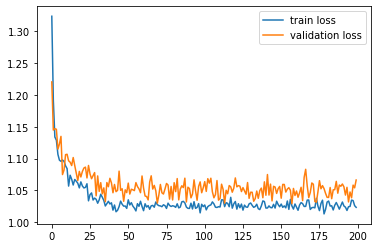

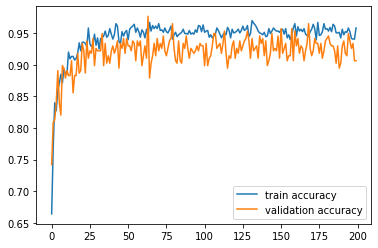

In [227]:
x = np.arange(total_epochs)
plt.plot(x,OSN_train_loss,label='train loss')
plt.plot(x,OSN_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,OSN_train_accuracy,label='train accuracy')
plt.plot(x,OSN_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(OSN_train_loss,OSN_train_accuracy,OSN_validate_loss,OSN_validate_accuracy))
frame.to_csv("OSN.csv")

In [228]:
del OS_MatchingNet
del OS_optimizer
del OS_scheduler

In [229]:
OS_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=1, fce=True, image_size=28, use_cuda=True)
OS_optimizer = torch.optim.Adam(OS_MatchingNet.parameters(), lr=1e-3)
OS_scheduler = ReduceLROnPlateau(OS_optimizer, 'min',verbose=True)
OSF_train_loss = []
OSF_train_accuracy = []
OSF_validate_loss = []
OSF_validate_accuracy = []

In [230]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataO,total_train_batches, OS_MatchingNet, OS_optimizer, use_cuda)
        OSF_train_loss.append(t_loss)
        OSF_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, OS_MatchingNet, OS_scheduler, use_cuda, True)
        OSF_validate_loss.append(v_loss)
        OSF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

OSF_accuracy = MetaValidate(dataO,total_test_batches, OS_MatchingNet, OS_scheduler, use_cuda, False)
print('final test accuracy: {}'.format(OSF_accuracy))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.3799418080598116 train_accuracy:0.607421875


  0%|▍                                                                                 | 1/200 [00:03<12:21,  3.73s/it]

Epoch 0: validate_loss:1.3416890427470207 validate_accuracy:0.609375
Epoch 1: train_loss:1.3036868013441563 train_accuracy:0.673828125


  1%|▊                                                                                 | 2/200 [00:07<12:16,  3.72s/it]

Epoch 1: validate_loss:1.3365768268704414 validate_accuracy:0.68359375
Epoch 2: train_loss:1.2678520195186138 train_accuracy:0.705078125


  2%|█▏                                                                                | 3/200 [00:11<12:12,  3.72s/it]

Epoch 2: validate_loss:1.2654552981257439 validate_accuracy:0.640625
Epoch 3: train_loss:1.232714969664812 train_accuracy:0.728515625


  2%|█▋                                                                                | 4/200 [00:14<12:08,  3.72s/it]

Epoch 3: validate_loss:1.2447948530316353 validate_accuracy:0.6953125
Epoch 4: train_loss:1.2164752967655659 train_accuracy:0.7431640625


  2%|██                                                                                | 5/200 [00:18<12:04,  3.72s/it]

Epoch 4: validate_loss:1.2285842671990395 validate_accuracy:0.7109375
Epoch 5: train_loss:1.175759382545948 train_accuracy:0.7685546875


  3%|██▍                                                                               | 6/200 [00:22<12:00,  3.71s/it]

Epoch 5: validate_loss:1.1738034263253212 validate_accuracy:0.796875
Epoch 6: train_loss:1.1706261839717627 train_accuracy:0.7783203125


  4%|██▊                                                                               | 7/200 [00:26<11:58,  3.72s/it]

Epoch 6: validate_loss:1.1821218729019165 validate_accuracy:0.76171875
Epoch 7: train_loss:1.1553528439253569 train_accuracy:0.81640625


  4%|███▎                                                                              | 8/200 [00:29<11:53,  3.72s/it]

Epoch 7: validate_loss:1.1724644303321838 validate_accuracy:0.78515625
Epoch 8: train_loss:1.137453779578209 train_accuracy:0.8330078125


  4%|███▋                                                                              | 9/200 [00:33<11:49,  3.71s/it]

Epoch 8: validate_loss:1.1412310376763344 validate_accuracy:0.828125
Epoch 9: train_loss:1.1174453813582659 train_accuracy:0.85546875


  5%|████                                                                             | 10/200 [00:37<11:45,  3.71s/it]

Epoch 9: validate_loss:1.1346111819148064 validate_accuracy:0.83984375
Epoch 10: train_loss:1.1247551199048758 train_accuracy:0.84375


  6%|████▍                                                                            | 11/200 [00:40<11:42,  3.72s/it]

Epoch 10: validate_loss:1.128862015902996 validate_accuracy:0.8046875
Epoch 11: train_loss:1.1211242023855448 train_accuracy:0.8427734375


  6%|████▊                                                                            | 12/200 [00:44<11:38,  3.71s/it]

Epoch 11: validate_loss:1.1372005343437195 validate_accuracy:0.8359375
Epoch 12: train_loss:1.1066604731604457 train_accuracy:0.8603515625


  6%|█████▎                                                                           | 13/200 [00:48<11:34,  3.71s/it]

Epoch 12: validate_loss:1.1489112377166748 validate_accuracy:0.8203125
Epoch 13: train_loss:1.1102563552558422 train_accuracy:0.853515625


  7%|█████▋                                                                           | 14/200 [00:52<11:31,  3.72s/it]

Epoch 13: validate_loss:1.1373385712504387 validate_accuracy:0.8359375
Epoch 14: train_loss:1.097332109697163 train_accuracy:0.880859375


  8%|██████                                                                           | 15/200 [00:55<11:27,  3.71s/it]

Epoch 14: validate_loss:1.1224965006113052 validate_accuracy:0.8359375
Epoch 15: train_loss:1.095673117786646 train_accuracy:0.888671875


  8%|██████▍                                                                          | 16/200 [00:59<11:23,  3.71s/it]

Epoch 15: validate_loss:1.1284267976880074 validate_accuracy:0.82421875
Epoch 16: train_loss:1.0992842130362988 train_accuracy:0.8701171875


  8%|██████▉                                                                          | 17/200 [01:03<11:19,  3.72s/it]

Epoch 16: validate_loss:1.1180047690868378 validate_accuracy:0.8515625
Epoch 17: train_loss:1.0991828730329871 train_accuracy:0.8720703125


  9%|███████▎                                                                         | 18/200 [01:06<11:16,  3.72s/it]

Epoch 17: validate_loss:1.097130537033081 validate_accuracy:0.875
Epoch 18: train_loss:1.0871190475299954 train_accuracy:0.896484375


 10%|███████▋                                                                         | 19/200 [01:10<11:12,  3.71s/it]

Epoch 18: validate_loss:1.1077232100069523 validate_accuracy:0.82421875
Epoch 19: train_loss:1.063936141319573 train_accuracy:0.9091796875


 10%|████████                                                                         | 20/200 [01:14<11:08,  3.72s/it]

Epoch 19: validate_loss:1.0999136790633202 validate_accuracy:0.859375
Epoch 20: train_loss:1.087927388958633 train_accuracy:0.8857421875


 10%|████████▌                                                                        | 21/200 [01:18<11:04,  3.71s/it]

Epoch 20: validate_loss:1.115970954298973 validate_accuracy:0.85546875
Epoch 21: train_loss:1.0812205094844103 train_accuracy:0.888671875


 11%|████████▉                                                                        | 22/200 [01:21<11:02,  3.72s/it]

Epoch 21: validate_loss:1.1430975645780563 validate_accuracy:0.828125
Epoch 22: train_loss:1.1009713783860207 train_accuracy:0.873046875


 12%|█████████▎                                                                       | 23/200 [01:25<10:59,  3.73s/it]

Epoch 22: validate_loss:1.095860693603754 validate_accuracy:0.88671875
Epoch 23: train_loss:1.078368028625846 train_accuracy:0.89453125


 12%|█████████▋                                                                       | 24/200 [01:29<10:56,  3.73s/it]

Epoch 23: validate_loss:1.1024566292762756 validate_accuracy:0.8515625
Epoch 24: train_loss:1.0809732973575592 train_accuracy:0.8935546875


 12%|██████████▏                                                                      | 25/200 [01:32<10:52,  3.73s/it]

Epoch 24: validate_loss:1.0999175161123276 validate_accuracy:0.8828125
Epoch 25: train_loss:1.076477400958538 train_accuracy:0.888671875


 13%|██████████▌                                                                      | 26/200 [01:36<10:48,  3.73s/it]

Epoch 25: validate_loss:1.0956940352916718 validate_accuracy:0.890625
Epoch 26: train_loss:1.0624249204993248 train_accuracy:0.888671875


 14%|██████████▉                                                                      | 27/200 [01:40<10:43,  3.72s/it]

Epoch 26: validate_loss:1.098683938384056 validate_accuracy:0.875
Epoch 27: train_loss:1.0598952313885093 train_accuracy:0.8876953125


 14%|███████████▎                                                                     | 28/200 [01:44<10:38,  3.71s/it]

Epoch 27: validate_loss:1.0711411237716675 validate_accuracy:0.90234375
Epoch 28: train_loss:1.0956421745941043 train_accuracy:0.8896484375


 14%|███████████▋                                                                     | 29/200 [01:47<10:34,  3.71s/it]

Epoch 28: validate_loss:1.1309036687016487 validate_accuracy:0.84765625
Epoch 29: train_loss:1.071036510169506 train_accuracy:0.9052734375


 15%|████████████▏                                                                    | 30/200 [01:51<10:30,  3.71s/it]

Epoch 29: validate_loss:1.0887308567762375 validate_accuracy:0.8828125
Epoch 30: train_loss:1.077563889324665 train_accuracy:0.8896484375


 16%|████████████▌                                                                    | 31/200 [01:55<10:26,  3.70s/it]

Epoch 30: validate_loss:1.1089271232485771 validate_accuracy:0.87109375
Epoch 31: train_loss:1.0622962545603514 train_accuracy:0.8955078125


 16%|████████████▉                                                                    | 32/200 [01:58<10:22,  3.70s/it]

Epoch 31: validate_loss:1.084014568477869 validate_accuracy:0.8671875
Epoch 32: train_loss:1.0631593530997634 train_accuracy:0.8974609375


 16%|█████████████▎                                                                   | 33/200 [02:02<10:19,  3.71s/it]

Epoch 32: validate_loss:1.0779454931616783 validate_accuracy:0.890625
Epoch 33: train_loss:1.0489659057930112 train_accuracy:0.9130859375


 17%|█████████████▊                                                                   | 34/200 [02:06<10:15,  3.71s/it]

Epoch 33: validate_loss:1.0748626291751862 validate_accuracy:0.890625
Epoch 34: train_loss:1.044914297759533 train_accuracy:0.9111328125


 18%|██████████████▏                                                                  | 35/200 [02:10<10:12,  3.71s/it]

Epoch 34: validate_loss:1.0590234473347664 validate_accuracy:0.88671875
Epoch 35: train_loss:1.0666946824640036 train_accuracy:0.9033203125


 18%|██████████████▌                                                                  | 36/200 [02:13<10:07,  3.71s/it]

Epoch 35: validate_loss:1.1044697314500809 validate_accuracy:0.859375
Epoch 36: train_loss:1.0607976065948606 train_accuracy:0.9013671875


 18%|██████████████▉                                                                  | 37/200 [02:17<10:05,  3.72s/it]

Epoch 36: validate_loss:1.0831373408436775 validate_accuracy:0.86328125
Epoch 37: train_loss:1.0479147983714938 train_accuracy:0.9052734375


 19%|███████████████▍                                                                 | 38/200 [02:21<10:01,  3.72s/it]

Epoch 37: validate_loss:1.0621418580412865 validate_accuracy:0.87109375
Epoch 38: train_loss:1.0573913184925914 train_accuracy:0.8955078125


 20%|███████████████▊                                                                 | 39/200 [02:24<09:57,  3.71s/it]

Epoch 38: validate_loss:1.084651917219162 validate_accuracy:0.8671875
Epoch 39: train_loss:1.0515981437638402 train_accuracy:0.8974609375


 20%|████████████████▏                                                                | 40/200 [02:28<09:53,  3.71s/it]

Epoch 39: validate_loss:1.0538293235003948 validate_accuracy:0.9140625
Epoch 40: train_loss:1.048681358806789 train_accuracy:0.91015625


 20%|████████████████▌                                                                | 41/200 [02:32<09:49,  3.71s/it]

Epoch 40: validate_loss:1.060997486114502 validate_accuracy:0.84375
Epoch 41: train_loss:1.043594309128821 train_accuracy:0.9111328125


 21%|█████████████████                                                                | 42/200 [02:36<09:47,  3.72s/it]

Epoch 41: validate_loss:1.061129603534937 validate_accuracy:0.90234375
Epoch 42: train_loss:1.0374522609636188 train_accuracy:0.9130859375


 22%|█████████████████▍                                                               | 43/200 [02:39<09:42,  3.71s/it]

Epoch 42: validate_loss:1.0762199014425278 validate_accuracy:0.90234375
Epoch 43: train_loss:1.0485287215560675 train_accuracy:0.900390625


 22%|█████████████████▊                                                               | 44/200 [02:43<09:38,  3.71s/it]

Epoch 43: validate_loss:1.0734681859612465 validate_accuracy:0.87109375
Epoch 44: train_loss:1.0354264890775084 train_accuracy:0.9189453125


 22%|██████████████████▏                                                              | 45/200 [02:47<09:34,  3.71s/it]

Epoch 44: validate_loss:1.041459284722805 validate_accuracy:0.8984375
Epoch 45: train_loss:1.0295416163280606 train_accuracy:0.9111328125


 23%|██████████████████▋                                                              | 46/200 [02:50<09:30,  3.70s/it]

Epoch 45: validate_loss:1.0420265942811966 validate_accuracy:0.9140625
Epoch 46: train_loss:1.050125701352954 train_accuracy:0.91015625


 24%|███████████████████                                                              | 47/200 [02:54<09:26,  3.70s/it]

Epoch 46: validate_loss:1.0884746797382832 validate_accuracy:0.89453125
Epoch 47: train_loss:1.046442304737866 train_accuracy:0.9189453125


 24%|███████████████████▍                                                             | 48/200 [02:58<09:22,  3.70s/it]

Epoch 47: validate_loss:1.0647537745535374 validate_accuracy:0.87109375
Epoch 48: train_loss:1.0404666736721992 train_accuracy:0.919921875


 24%|███████████████████▊                                                             | 49/200 [03:01<09:18,  3.70s/it]

Epoch 48: validate_loss:1.0539691932499409 validate_accuracy:0.88671875
Epoch 49: train_loss:1.0288110198453069 train_accuracy:0.92578125


 25%|████████████████████▎                                                            | 50/200 [03:05<09:15,  3.70s/it]

Epoch 49: validate_loss:1.0746127851307392 validate_accuracy:0.8671875
Epoch 50: train_loss:1.0282638119533658 train_accuracy:0.9296875


 26%|████████████████████▋                                                            | 51/200 [03:09<09:11,  3.70s/it]

Epoch 50: validate_loss:1.0506686978042126 validate_accuracy:0.89453125
Epoch 51: train_loss:1.0439247023314238 train_accuracy:0.9208984375


 26%|█████████████████████                                                            | 52/200 [03:13<09:07,  3.70s/it]

Epoch 51: validate_loss:1.1074678748846054 validate_accuracy:0.859375
Epoch 52: train_loss:1.0488807577639818 train_accuracy:0.9140625


 26%|█████████████████████▍                                                           | 53/200 [03:16<09:04,  3.71s/it]

Epoch 52: validate_loss:1.0560458898544312 validate_accuracy:0.9140625
Epoch 53: train_loss:1.0374344512820244 train_accuracy:0.916015625


 27%|█████████████████████▊                                                           | 54/200 [03:20<09:01,  3.71s/it]

Epoch 53: validate_loss:1.0449535883963108 validate_accuracy:0.8828125
Epoch 54: train_loss:1.0419790679588914 train_accuracy:0.904296875


 28%|██████████████████████▎                                                          | 55/200 [03:24<08:57,  3.71s/it]

Epoch 54: validate_loss:1.0440794825553894 validate_accuracy:0.88671875
Epoch 55: train_loss:1.0606941664591432 train_accuracy:0.8916015625


 28%|██████████████████████▋                                                          | 56/200 [03:27<08:53,  3.71s/it]

Epoch    56: reducing learning rate of group 0 to 1.0000e-04.
Epoch 55: validate_loss:1.0656045898795128 validate_accuracy:0.875
Epoch 56: train_loss:1.0339827621355653 train_accuracy:0.91015625


 28%|███████████████████████                                                          | 57/200 [03:31<08:49,  3.71s/it]

Epoch 56: validate_loss:1.0508822575211525 validate_accuracy:0.8984375
Epoch 57: train_loss:1.0437867334112525 train_accuracy:0.90625


 29%|███████████████████████▍                                                         | 58/200 [03:35<08:45,  3.70s/it]

Epoch 57: validate_loss:1.0644453838467598 validate_accuracy:0.8671875
Epoch 58: train_loss:1.035769246518612 train_accuracy:0.9150390625


 30%|███████████████████████▉                                                         | 59/200 [03:38<08:42,  3.70s/it]

Epoch 58: validate_loss:1.062061294913292 validate_accuracy:0.8671875
Epoch 59: train_loss:1.0301348250359297 train_accuracy:0.9052734375


 30%|████████████████████████▎                                                        | 60/200 [03:42<08:38,  3.70s/it]

Epoch 59: validate_loss:1.051404569298029 validate_accuracy:0.87890625
Epoch 60: train_loss:1.0301030995324254 train_accuracy:0.912109375


 30%|████████████████████████▋                                                        | 61/200 [03:46<08:34,  3.70s/it]

Epoch 60: validate_loss:1.0630981884896755 validate_accuracy:0.89453125
Epoch 61: train_loss:1.0246950332075357 train_accuracy:0.9130859375


 31%|█████████████████████████                                                        | 62/200 [03:50<08:30,  3.70s/it]

Epoch 61: validate_loss:1.0490029826760292 validate_accuracy:0.87890625
Epoch 62: train_loss:1.0357935950160027 train_accuracy:0.9150390625


 32%|█████████████████████████▌                                                       | 63/200 [03:53<08:27,  3.70s/it]

Epoch 62: validate_loss:1.030491128563881 validate_accuracy:0.9140625
Epoch 63: train_loss:1.0232707038521767 train_accuracy:0.9375


 32%|█████████████████████████▉                                                       | 64/200 [03:57<08:23,  3.70s/it]

Epoch 63: validate_loss:1.073918379843235 validate_accuracy:0.87109375
Epoch 64: train_loss:1.0296295527368784 train_accuracy:0.919921875


 32%|██████████████████████████▎                                                      | 65/200 [04:01<08:20,  3.71s/it]

Epoch 64: validate_loss:1.0530046708881855 validate_accuracy:0.87890625
Epoch 65: train_loss:1.0235606553032994 train_accuracy:0.9111328125


 33%|██████████████████████████▋                                                      | 66/200 [04:04<08:16,  3.70s/it]

Epoch 65: validate_loss:1.0540098249912262 validate_accuracy:0.90234375
Epoch 66: train_loss:1.0298003545030951 train_accuracy:0.921875


 34%|███████████████████████████▏                                                     | 67/200 [04:08<08:12,  3.70s/it]

Epoch 66: validate_loss:1.0445073917508125 validate_accuracy:0.90625
Epoch 67: train_loss:1.0224518803879619 train_accuracy:0.919921875


 34%|███████████████████████████▌                                                     | 68/200 [04:12<08:09,  3.71s/it]

Epoch 67: validate_loss:1.046844594180584 validate_accuracy:0.890625
Epoch 68: train_loss:1.0250607086345553 train_accuracy:0.9130859375


 34%|███████████████████████████▉                                                     | 69/200 [04:16<08:05,  3.71s/it]

Epoch 68: validate_loss:1.063124906271696 validate_accuracy:0.859375
Epoch 69: train_loss:1.0196739314123988 train_accuracy:0.9140625


 35%|████████████████████████████▎                                                    | 70/200 [04:19<08:01,  3.71s/it]

Epoch 69: validate_loss:1.0479570254683495 validate_accuracy:0.875
Epoch 70: train_loss:1.0284849973395467 train_accuracy:0.916015625


 36%|████████████████████████████▊                                                    | 71/200 [04:23<07:57,  3.70s/it]

Epoch 70: validate_loss:1.0465810187160969 validate_accuracy:0.875
Epoch 71: train_loss:1.012617327272892 train_accuracy:0.9345703125


 36%|█████████████████████████████▏                                                   | 72/200 [04:27<07:54,  3.70s/it]

Epoch 71: validate_loss:1.0317870564758778 validate_accuracy:0.90625
Epoch 72: train_loss:1.0294672986492515 train_accuracy:0.9228515625


 36%|█████████████████████████████▌                                                   | 73/200 [04:30<07:50,  3.70s/it]

Epoch 72: validate_loss:1.0262296423316002 validate_accuracy:0.92578125
Epoch 73: train_loss:1.0238120527938008 train_accuracy:0.92578125


 37%|█████████████████████████████▉                                                   | 74/200 [04:34<07:46,  3.70s/it]

Epoch 73: validate_loss:1.0603097230196 validate_accuracy:0.875
Epoch 74: train_loss:1.0181588297709823 train_accuracy:0.921875


 38%|██████████████████████████████▍                                                  | 75/200 [04:38<07:42,  3.70s/it]

Epoch 74: validate_loss:1.0352391861379147 validate_accuracy:0.90625
Epoch 75: train_loss:1.0218547033146024 train_accuracy:0.9140625


 38%|██████████████████████████████▊                                                  | 76/200 [04:41<07:39,  3.70s/it]

Epoch 75: validate_loss:1.0511438474059105 validate_accuracy:0.89453125
Epoch 76: train_loss:1.0284265782684088 train_accuracy:0.9130859375


 38%|███████████████████████████████▏                                                 | 77/200 [04:45<07:35,  3.70s/it]

Epoch 76: validate_loss:1.042719166725874 validate_accuracy:0.890625
Epoch 77: train_loss:1.0137845389544964 train_accuracy:0.9345703125


 39%|███████████████████████████████▌                                                 | 78/200 [04:49<07:31,  3.70s/it]

Epoch 77: validate_loss:1.0486996248364449 validate_accuracy:0.88671875
Epoch 78: train_loss:1.0128400875255466 train_accuracy:0.9326171875


 40%|███████████████████████████████▉                                                 | 79/200 [04:53<07:27,  3.70s/it]

Epoch 78: validate_loss:1.0625564977526665 validate_accuracy:0.83984375
Epoch 79: train_loss:1.007495641708374 train_accuracy:0.927734375


 40%|████████████████████████████████▍                                                | 80/200 [04:56<07:23,  3.70s/it]

Epoch 79: validate_loss:1.0425606183707714 validate_accuracy:0.90234375
Epoch 80: train_loss:1.0150388292968273 train_accuracy:0.9443359375


 40%|████████████████████████████████▊                                                | 81/200 [05:00<07:20,  3.70s/it]

Epoch 80: validate_loss:1.0412287265062332 validate_accuracy:0.90234375
Epoch 81: train_loss:1.0159575827419758 train_accuracy:0.9306640625


 41%|█████████████████████████████████▏                                               | 82/200 [05:04<07:16,  3.70s/it]

Epoch 81: validate_loss:1.021783635020256 validate_accuracy:0.921875
Epoch 82: train_loss:1.0125885102897882 train_accuracy:0.923828125


 42%|█████████████████████████████████▌                                               | 83/200 [05:07<07:12,  3.70s/it]

Epoch 82: validate_loss:1.0548587888479233 validate_accuracy:0.88671875
Epoch 83: train_loss:1.0162714617326856 train_accuracy:0.9326171875


 42%|██████████████████████████████████                                               | 84/200 [05:11<07:09,  3.70s/it]

Epoch 83: validate_loss:1.046474102884531 validate_accuracy:0.90234375
Epoch 84: train_loss:1.0183900501579046 train_accuracy:0.9208984375


 42%|██████████████████████████████████▍                                              | 85/200 [05:15<07:05,  3.70s/it]

Epoch 84: validate_loss:1.0209856182336807 validate_accuracy:0.91796875
Epoch 85: train_loss:1.0208958582952619 train_accuracy:0.9169921875


 43%|██████████████████████████████████▊                                              | 86/200 [05:18<07:01,  3.70s/it]

Epoch 85: validate_loss:1.040280669927597 validate_accuracy:0.921875
Epoch 86: train_loss:1.014054086059332 train_accuracy:0.9248046875


 44%|███████████████████████████████████▏                                             | 87/200 [05:22<06:57,  3.70s/it]

Epoch 86: validate_loss:1.0424414314329624 validate_accuracy:0.90234375
Epoch 87: train_loss:1.0155739830806851 train_accuracy:0.9306640625


 44%|███████████████████████████████████▋                                             | 88/200 [05:26<06:54,  3.70s/it]

Epoch 87: validate_loss:1.045891497284174 validate_accuracy:0.8984375
Epoch 88: train_loss:1.0059528052806854 train_accuracy:0.9306640625


 44%|████████████████████████████████████                                             | 89/200 [05:29<06:50,  3.70s/it]

Epoch 88: validate_loss:1.0349364317953587 validate_accuracy:0.92578125
Epoch 89: train_loss:1.0174136832356453 train_accuracy:0.93359375


 45%|████████████████████████████████████▍                                            | 90/200 [05:33<06:46,  3.70s/it]

Epoch 89: validate_loss:1.053370725363493 validate_accuracy:0.8828125
Epoch 90: train_loss:1.014091151766479 train_accuracy:0.9306640625


 46%|████████████████████████████████████▊                                            | 91/200 [05:37<06:43,  3.70s/it]

Epoch 90: validate_loss:1.0464510768651962 validate_accuracy:0.91796875
Epoch 91: train_loss:1.0105245979502797 train_accuracy:0.931640625


 46%|█████████████████████████████████████▎                                           | 92/200 [05:41<06:39,  3.70s/it]

Epoch 91: validate_loss:1.0297465473413467 validate_accuracy:0.91015625
Epoch 92: train_loss:1.0210365783423185 train_accuracy:0.923828125


 46%|█████████████████████████████████████▋                                           | 93/200 [05:44<06:35,  3.70s/it]

Epoch 92: validate_loss:1.0377045199275017 validate_accuracy:0.88671875
Epoch 93: train_loss:1.0097649991512299 train_accuracy:0.9462890625


 47%|██████████████████████████████████████                                           | 94/200 [05:48<06:32,  3.70s/it]

Epoch 93: validate_loss:1.0295908004045486 validate_accuracy:0.8828125
Epoch 94: train_loss:1.005964527837932 train_accuracy:0.935546875


 48%|██████████████████████████████████████▍                                          | 95/200 [05:52<06:28,  3.70s/it]

Epoch 94: validate_loss:1.0227102935314178 validate_accuracy:0.90625
Epoch 95: train_loss:1.016720850020647 train_accuracy:0.9267578125


 48%|██████████████████████████████████████▉                                          | 96/200 [05:55<06:24,  3.70s/it]

Epoch    96: reducing learning rate of group 0 to 1.0000e-05.
Epoch 95: validate_loss:1.0409001260995865 validate_accuracy:0.9140625
Epoch 96: train_loss:1.0223782109096646 train_accuracy:0.9208984375


 48%|███████████████████████████████████████▎                                         | 97/200 [05:59<06:21,  3.70s/it]

Epoch 96: validate_loss:1.0453001335263252 validate_accuracy:0.8828125
Epoch 97: train_loss:1.0180983925238252 train_accuracy:0.9345703125


 49%|███████████████████████████████████████▋                                         | 98/200 [06:03<06:17,  3.70s/it]

Epoch 97: validate_loss:1.0533428974449635 validate_accuracy:0.890625
Epoch 98: train_loss:1.0210284385830164 train_accuracy:0.931640625


 50%|████████████████████████████████████████                                         | 99/200 [06:06<06:13,  3.70s/it]

Epoch 98: validate_loss:1.061054702848196 validate_accuracy:0.8828125
Epoch 99: train_loss:1.0198476677760482 train_accuracy:0.9189453125


 50%|████████████████████████████████████████                                        | 100/200 [06:10<06:10,  3.70s/it]

Epoch 99: validate_loss:1.0596989318728447 validate_accuracy:0.88671875
Epoch 100: train_loss:1.016712456010282 train_accuracy:0.9248046875


 50%|████████████████████████████████████████▍                                       | 101/200 [06:14<06:06,  3.70s/it]

Epoch 100: validate_loss:1.0359535813331604 validate_accuracy:0.88671875
Epoch 101: train_loss:1.0177999697625637 train_accuracy:0.923828125


 51%|████████████████████████████████████████▊                                       | 102/200 [06:18<06:02,  3.70s/it]

Epoch 101: validate_loss:1.0290368422865868 validate_accuracy:0.9296875
Epoch 102: train_loss:1.0180061692371964 train_accuracy:0.9287109375


 52%|█████████████████████████████████████████▏                                      | 103/200 [06:21<05:58,  3.70s/it]

Epoch 102: validate_loss:1.0462276302278042 validate_accuracy:0.875
Epoch 103: train_loss:1.0193941593170166 train_accuracy:0.923828125


 52%|█████████████████████████████████████████▌                                      | 104/200 [06:25<05:55,  3.70s/it]

Epoch 103: validate_loss:1.0555251315236092 validate_accuracy:0.88671875
Epoch 104: train_loss:1.0156629281118512 train_accuracy:0.93359375


 52%|██████████████████████████████████████████                                      | 105/200 [06:29<05:51,  3.70s/it]

Epoch 104: validate_loss:1.051031582057476 validate_accuracy:0.875
Epoch 105: train_loss:1.0196441989392042 train_accuracy:0.9306640625


 53%|██████████████████████████████████████████▍                                     | 106/200 [06:32<05:47,  3.70s/it]

Epoch 105: validate_loss:1.023905523121357 validate_accuracy:0.90625
Epoch 106: train_loss:1.0104229934513569 train_accuracy:0.939453125


 54%|██████████████████████████████████████████▊                                     | 107/200 [06:36<05:44,  3.70s/it]

Epoch   107: reducing learning rate of group 0 to 1.0000e-06.
Epoch 106: validate_loss:1.0660578906536102 validate_accuracy:0.875
Epoch 107: train_loss:1.0048244493082166 train_accuracy:0.9375


 54%|███████████████████████████████████████████▏                                    | 108/200 [06:40<05:40,  3.70s/it]

Epoch 107: validate_loss:1.022823728621006 validate_accuracy:0.93359375
Epoch 108: train_loss:1.014558426104486 train_accuracy:0.9326171875


 55%|███████████████████████████████████████████▌                                    | 109/200 [06:44<05:37,  3.70s/it]

Epoch 108: validate_loss:1.045815248042345 validate_accuracy:0.88671875
Epoch 109: train_loss:1.0196942938491702 train_accuracy:0.923828125


 55%|████████████████████████████████████████████                                    | 110/200 [06:47<05:33,  3.70s/it]

Epoch 109: validate_loss:1.0376451760530472 validate_accuracy:0.87109375
Epoch 110: train_loss:1.0143499476835132 train_accuracy:0.9375


 56%|████████████████████████████████████████████▍                                   | 111/200 [06:51<05:29,  3.71s/it]

Epoch 110: validate_loss:1.0526939034461975 validate_accuracy:0.8671875
Epoch 111: train_loss:1.0174353439360857 train_accuracy:0.927734375


 56%|████████████████████████████████████████████▊                                   | 112/200 [06:55<05:26,  3.71s/it]

Epoch 111: validate_loss:1.0497195683419704 validate_accuracy:0.8984375
Epoch 112: train_loss:1.0122848078608513 train_accuracy:0.921875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [06:58<05:22,  3.70s/it]

Epoch 112: validate_loss:1.0368002839386463 validate_accuracy:0.90625
Epoch 113: train_loss:1.010464582592249 train_accuracy:0.9404296875


 57%|█████████████████████████████████████████████▌                                  | 114/200 [07:02<05:18,  3.70s/it]

Epoch 113: validate_loss:1.0401952341198921 validate_accuracy:0.89453125
Epoch 114: train_loss:1.0138402786105871 train_accuracy:0.9326171875


 57%|██████████████████████████████████████████████                                  | 115/200 [07:06<05:14,  3.70s/it]

Epoch 114: validate_loss:1.0255844108760357 validate_accuracy:0.91015625
Epoch 115: train_loss:1.0130156856030226 train_accuracy:0.921875


 58%|██████████████████████████████████████████████▍                                 | 116/200 [07:09<05:11,  3.70s/it]

Epoch 115: validate_loss:1.0398719161748886 validate_accuracy:0.9140625
Epoch 116: train_loss:1.005438171327114 train_accuracy:0.9326171875


 58%|██████████████████████████████████████████████▊                                 | 117/200 [07:13<05:07,  3.70s/it]

Epoch 116: validate_loss:1.0634834803640842 validate_accuracy:0.890625
Epoch 117: train_loss:1.0150458542630076 train_accuracy:0.9248046875


 59%|███████████████████████████████████████████████▏                                | 118/200 [07:17<05:03,  3.70s/it]

Epoch   118: reducing learning rate of group 0 to 1.0000e-07.
Epoch 117: validate_loss:1.0335259325802326 validate_accuracy:0.91015625
Epoch 118: train_loss:1.0073511796072125 train_accuracy:0.92578125


 60%|███████████████████████████████████████████████▌                                | 119/200 [07:21<04:59,  3.70s/it]

Epoch 118: validate_loss:1.0266537740826607 validate_accuracy:0.90234375
Epoch 119: train_loss:1.0117214964702725 train_accuracy:0.927734375


 60%|████████████████████████████████████████████████                                | 120/200 [07:24<04:56,  3.70s/it]

Epoch 119: validate_loss:1.0522680655121803 validate_accuracy:0.85546875
Epoch 120: train_loss:1.012536583468318 train_accuracy:0.943359375


 60%|████████████████████████████████████████████████▍                               | 121/200 [07:28<04:53,  3.72s/it]

Epoch 120: validate_loss:1.063985925167799 validate_accuracy:0.88671875
Epoch 121: train_loss:1.0154993264004588 train_accuracy:0.9404296875


 61%|████████████████████████████████████████████████▊                               | 122/200 [07:32<04:49,  3.72s/it]

Epoch 121: validate_loss:1.0374231971800327 validate_accuracy:0.90625
Epoch 122: train_loss:1.016452794894576 train_accuracy:0.9248046875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [07:35<04:45,  3.71s/it]

Epoch 122: validate_loss:1.0431531220674515 validate_accuracy:0.86328125
Epoch 123: train_loss:1.012763587757945 train_accuracy:0.9287109375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [07:39<04:42,  3.71s/it]

Epoch 123: validate_loss:1.036841906607151 validate_accuracy:0.8984375
Epoch 124: train_loss:1.0040327925235033 train_accuracy:0.9453125


 62%|██████████████████████████████████████████████████                              | 125/200 [07:43<04:38,  3.72s/it]

Epoch 124: validate_loss:1.0192872770130634 validate_accuracy:0.9296875
Epoch 125: train_loss:1.0059629268944263 train_accuracy:0.9384765625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [07:47<04:34,  3.71s/it]

Epoch 125: validate_loss:1.0500613525509834 validate_accuracy:0.890625
Epoch 126: train_loss:1.016309312544763 train_accuracy:0.9404296875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [07:50<04:31,  3.71s/it]

Epoch 126: validate_loss:1.0313771292567253 validate_accuracy:0.92578125
Epoch 127: train_loss:1.0115744890645146 train_accuracy:0.923828125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [07:54<04:27,  3.72s/it]

Epoch 127: validate_loss:1.0512108579277992 validate_accuracy:0.875
Epoch 128: train_loss:1.015061430633068 train_accuracy:0.9228515625


 64%|███████████████████████████████████████████████████▌                            | 129/200 [07:58<04:23,  3.71s/it]

Epoch 128: validate_loss:1.0192955769598484 validate_accuracy:0.92578125
Epoch 129: train_loss:1.003020946867764 train_accuracy:0.935546875


 65%|████████████████████████████████████████████████████                            | 130/200 [08:01<04:19,  3.71s/it]

Epoch 129: validate_loss:1.0349409617483616 validate_accuracy:0.8984375
Epoch 130: train_loss:1.0116518372669816 train_accuracy:0.9423828125


 66%|████████████████████████████████████████████████████▍                           | 131/200 [08:05<04:16,  3.71s/it]

Epoch 130: validate_loss:1.0250250473618507 validate_accuracy:0.91796875
Epoch 131: train_loss:1.016633989289403 train_accuracy:0.9267578125


 66%|████████████████████████████████████████████████████▊                           | 132/200 [08:09<04:12,  3.72s/it]

Epoch 131: validate_loss:1.0605929009616375 validate_accuracy:0.8671875
Epoch 132: train_loss:1.0086080096662045 train_accuracy:0.9423828125


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [08:13<04:09,  3.73s/it]

Epoch 132: validate_loss:1.0491648390889168 validate_accuracy:0.890625
Epoch 133: train_loss:1.0181715032085776 train_accuracy:0.935546875


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [08:16<04:05,  3.72s/it]

Epoch 133: validate_loss:1.0505908727645874 validate_accuracy:0.90625
Epoch 134: train_loss:1.0179569935426116 train_accuracy:0.916015625


 68%|██████████████████████████████████████████████████████                          | 135/200 [08:20<04:02,  3.72s/it]

Epoch 134: validate_loss:1.023676287382841 validate_accuracy:0.9140625
Epoch 135: train_loss:1.0154393166303635 train_accuracy:0.923828125


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [08:24<03:58,  3.73s/it]

Epoch   136: reducing learning rate of group 0 to 1.0000e-08.
Epoch 135: validate_loss:1.0468777902424335 validate_accuracy:0.8828125
Epoch 136: train_loss:1.0140656102448702 train_accuracy:0.9130859375


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [08:28<03:54,  3.73s/it]

Epoch 136: validate_loss:1.0409629866480827 validate_accuracy:0.875
Epoch 137: train_loss:1.0235718786716461 train_accuracy:0.919921875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [08:31<03:51,  3.73s/it]

Epoch 137: validate_loss:1.0413150675594807 validate_accuracy:0.8671875
Epoch 138: train_loss:1.0190216088667512 train_accuracy:0.9267578125


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [08:35<03:47,  3.72s/it]

Epoch 138: validate_loss:1.0420338697731495 validate_accuracy:0.91015625
Epoch 139: train_loss:1.012074408121407 train_accuracy:0.939453125


 70%|████████████████████████████████████████████████████████                        | 140/200 [08:39<03:43,  3.73s/it]

Epoch 139: validate_loss:1.0199949592351913 validate_accuracy:0.92578125
Epoch 140: train_loss:1.0086496798321605 train_accuracy:0.943359375


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [08:42<03:39,  3.72s/it]

Epoch 140: validate_loss:1.0377254597842693 validate_accuracy:0.90625
Epoch 141: train_loss:1.0103296656161547 train_accuracy:0.931640625


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [08:46<03:36,  3.73s/it]

Epoch 141: validate_loss:1.0318606607615948 validate_accuracy:0.91796875
Epoch 142: train_loss:1.0226308684796095 train_accuracy:0.9111328125


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [08:50<03:32,  3.73s/it]

Epoch 142: validate_loss:1.0451231263577938 validate_accuracy:0.8671875
Epoch 143: train_loss:1.012016142718494 train_accuracy:0.9326171875


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [08:54<03:28,  3.72s/it]

Epoch 143: validate_loss:1.0361204631626606 validate_accuracy:0.91796875
Epoch 144: train_loss:1.0069027114659548 train_accuracy:0.94921875


 72%|██████████████████████████████████████████████████████████                      | 145/200 [08:57<03:24,  3.73s/it]

Epoch 144: validate_loss:1.0246452428400517 validate_accuracy:0.91015625
Epoch 145: train_loss:1.0106338616460562 train_accuracy:0.931640625


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [09:01<03:21,  3.72s/it]

Epoch 145: validate_loss:1.033826645463705 validate_accuracy:0.8984375
Epoch 146: train_loss:1.0078489491716027 train_accuracy:0.9267578125


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [09:05<03:17,  3.73s/it]

Epoch 146: validate_loss:1.036839708685875 validate_accuracy:0.91015625
Epoch 147: train_loss:1.0101563688367605 train_accuracy:0.9375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [09:08<03:13,  3.72s/it]

Epoch 147: validate_loss:1.0558701008558273 validate_accuracy:0.87890625
Epoch 148: train_loss:1.0154795153066516 train_accuracy:0.9296875


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [09:12<03:10,  3.73s/it]

Epoch 148: validate_loss:1.0204135179519653 validate_accuracy:0.9140625
Epoch 149: train_loss:1.0118318879976869 train_accuracy:0.939453125


 75%|████████████████████████████████████████████████████████████                    | 150/200 [09:16<03:06,  3.73s/it]

Epoch 149: validate_loss:1.0452263206243515 validate_accuracy:0.88671875
Epoch 150: train_loss:1.0237792553380132 train_accuracy:0.919921875


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [09:20<03:02,  3.72s/it]

Epoch 150: validate_loss:1.0321034938097 validate_accuracy:0.9140625
Epoch 151: train_loss:1.0241345902904868 train_accuracy:0.927734375


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [09:23<02:58,  3.72s/it]

Epoch 151: validate_loss:1.0457817316055298 validate_accuracy:0.91796875
Epoch 152: train_loss:1.0117945242673159 train_accuracy:0.9306640625


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [09:27<02:54,  3.72s/it]

Epoch 152: validate_loss:1.032422810792923 validate_accuracy:0.9140625
Epoch 153: train_loss:1.009872553870082 train_accuracy:0.9375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [09:31<02:51,  3.72s/it]

Epoch 153: validate_loss:1.0289576351642609 validate_accuracy:0.89453125
Epoch 154: train_loss:1.0162413595244288 train_accuracy:0.94140625


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [09:34<02:47,  3.71s/it]

Epoch 154: validate_loss:1.039519190788269 validate_accuracy:0.8984375
Epoch 155: train_loss:1.0268810847774148 train_accuracy:0.9130859375


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [09:38<02:43,  3.71s/it]

Epoch 155: validate_loss:1.040599063038826 validate_accuracy:0.9140625
Epoch 156: train_loss:1.0101305870339274 train_accuracy:0.9326171875


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [09:42<02:39,  3.71s/it]

Epoch 156: validate_loss:1.0519009977579117 validate_accuracy:0.890625
Epoch 157: train_loss:1.0119140399619937 train_accuracy:0.9365234375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [09:46<02:35,  3.71s/it]

Epoch 157: validate_loss:1.0538287535309792 validate_accuracy:0.8828125
Epoch 158: train_loss:1.0081136673688889 train_accuracy:0.9462890625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [09:49<02:32,  3.71s/it]

Epoch 158: validate_loss:1.039606761187315 validate_accuracy:0.8671875
Epoch 159: train_loss:1.019679145887494 train_accuracy:0.91796875


 80%|████████████████████████████████████████████████████████████████                | 160/200 [09:53<02:28,  3.71s/it]

Epoch 159: validate_loss:1.0572588704526424 validate_accuracy:0.89453125
Epoch 160: train_loss:1.0183650301769376 train_accuracy:0.935546875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [09:57<02:24,  3.71s/it]

Epoch 160: validate_loss:1.0135416202247143 validate_accuracy:0.9375
Epoch 161: train_loss:1.0193729484453797 train_accuracy:0.9248046875


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [10:00<02:20,  3.71s/it]

Epoch 161: validate_loss:1.0513471476733685 validate_accuracy:0.90625
Epoch 162: train_loss:1.0213863868266344 train_accuracy:0.92578125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [10:04<02:17,  3.70s/it]

Epoch 162: validate_loss:1.0508819408714771 validate_accuracy:0.8828125
Epoch 163: train_loss:1.0149358185008168 train_accuracy:0.9248046875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [10:08<02:13,  3.71s/it]

Epoch 163: validate_loss:1.0391345731914043 validate_accuracy:0.921875
Epoch 164: train_loss:1.0150708369910717 train_accuracy:0.93359375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [10:12<02:09,  3.71s/it]

Epoch 164: validate_loss:1.0612476840615273 validate_accuracy:0.87109375
Epoch 165: train_loss:1.0155065665021539 train_accuracy:0.9208984375


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [10:15<02:06,  3.71s/it]

Epoch 165: validate_loss:1.0365858525037766 validate_accuracy:0.90234375
Epoch 166: train_loss:1.0148552432656288 train_accuracy:0.9296875


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [10:19<02:02,  3.71s/it]

Epoch 166: validate_loss:1.0354670397937298 validate_accuracy:0.94140625
Epoch 167: train_loss:1.0147578036412597 train_accuracy:0.9248046875


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [10:23<01:59,  3.72s/it]

Epoch 167: validate_loss:1.0312002636492252 validate_accuracy:0.89453125
Epoch 168: train_loss:1.0173787884414196 train_accuracy:0.923828125


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [10:26<01:55,  3.72s/it]

Epoch 168: validate_loss:1.0515092723071575 validate_accuracy:0.8828125
Epoch 169: train_loss:1.0186713179573417 train_accuracy:0.9384765625


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [10:30<01:51,  3.73s/it]

Epoch 169: validate_loss:1.0612965002655983 validate_accuracy:0.8515625
Epoch 170: train_loss:1.0175222335383296 train_accuracy:0.923828125


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [10:34<01:48,  3.72s/it]

Epoch 170: validate_loss:1.0255787000060081 validate_accuracy:0.8984375
Epoch 171: train_loss:1.0154179194942117 train_accuracy:0.94140625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [10:38<01:44,  3.73s/it]

Epoch 171: validate_loss:1.047633584588766 validate_accuracy:0.85546875
Epoch 172: train_loss:1.0088806115090847 train_accuracy:0.9306640625


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [10:41<01:40,  3.73s/it]

Epoch 172: validate_loss:1.0381906889379025 validate_accuracy:0.890625
Epoch 173: train_loss:1.0194287039339542 train_accuracy:0.919921875


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [10:45<01:37,  3.73s/it]

Epoch 173: validate_loss:1.0425541885197163 validate_accuracy:0.87109375
Epoch 174: train_loss:1.0149776982143521 train_accuracy:0.919921875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [10:49<01:33,  3.73s/it]

Epoch 174: validate_loss:1.0414083935320377 validate_accuracy:0.8828125
Epoch 175: train_loss:1.0090829646214843 train_accuracy:0.9248046875


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [10:53<01:29,  3.74s/it]

Epoch 175: validate_loss:1.0436761900782585 validate_accuracy:0.890625
Epoch 176: train_loss:1.0038285115733743 train_accuracy:0.9365234375


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [10:56<01:26,  3.74s/it]

Epoch 176: validate_loss:1.0474607087671757 validate_accuracy:0.89453125
Epoch 177: train_loss:1.012411991134286 train_accuracy:0.9267578125


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [11:00<01:22,  3.73s/it]

Epoch 177: validate_loss:1.038143027573824 validate_accuracy:0.9296875
Epoch 178: train_loss:1.013662101700902 train_accuracy:0.9306640625


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [11:04<01:18,  3.73s/it]

Epoch 178: validate_loss:1.051639650017023 validate_accuracy:0.91015625
Epoch 179: train_loss:1.0180142922326922 train_accuracy:0.931640625


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [11:08<01:14,  3.73s/it]

Epoch 179: validate_loss:1.0186410509049892 validate_accuracy:0.90625
Epoch 180: train_loss:1.0121182315051556 train_accuracy:0.9287109375


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [11:11<01:10,  3.73s/it]

Epoch 180: validate_loss:1.0420330055058002 validate_accuracy:0.890625
Epoch 181: train_loss:1.0110237495973706 train_accuracy:0.931640625


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [11:15<01:07,  3.73s/it]

Epoch 181: validate_loss:1.0331811867654324 validate_accuracy:0.90234375
Epoch 182: train_loss:1.0119241792708635 train_accuracy:0.9423828125


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [11:19<01:03,  3.73s/it]

Epoch 182: validate_loss:1.0267067551612854 validate_accuracy:0.90625
Epoch 183: train_loss:1.0065500251948833 train_accuracy:0.9453125


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [11:22<00:59,  3.72s/it]

Epoch 183: validate_loss:1.024537831544876 validate_accuracy:0.90234375
Epoch 184: train_loss:1.0119520807638764 train_accuracy:0.9375


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [11:26<00:55,  3.72s/it]

Epoch 184: validate_loss:1.0393550917506218 validate_accuracy:0.91015625
Epoch 185: train_loss:1.015787921845913 train_accuracy:0.9296875


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [11:30<00:52,  3.72s/it]

Epoch 185: validate_loss:1.0280751250684261 validate_accuracy:0.90625
Epoch 186: train_loss:1.013530052267015 train_accuracy:0.9306640625


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [11:34<00:48,  3.72s/it]

Epoch 186: validate_loss:1.0515527948737144 validate_accuracy:0.90234375
Epoch 187: train_loss:1.0146563379094005 train_accuracy:0.927734375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [11:37<00:44,  3.71s/it]

Epoch 187: validate_loss:1.0474777966737747 validate_accuracy:0.88671875
Epoch 188: train_loss:1.0120946234092116 train_accuracy:0.939453125


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [11:41<00:40,  3.71s/it]

Epoch 188: validate_loss:1.0478219464421272 validate_accuracy:0.8984375
Epoch 189: train_loss:1.0211880300194025 train_accuracy:0.923828125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [11:45<00:37,  3.71s/it]

Epoch 189: validate_loss:1.026600856333971 validate_accuracy:0.9140625
Epoch 190: train_loss:1.0149317877367139 train_accuracy:0.9345703125


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [11:48<00:33,  3.72s/it]

Epoch 190: validate_loss:1.0335880666971207 validate_accuracy:0.93359375
Epoch 191: train_loss:1.0119334077462554 train_accuracy:0.9267578125


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [11:52<00:29,  3.73s/it]

Epoch 191: validate_loss:1.0422989428043365 validate_accuracy:0.88671875
Epoch 192: train_loss:1.0044030649587512 train_accuracy:0.9326171875


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [11:56<00:26,  3.73s/it]

Epoch 192: validate_loss:1.032720435410738 validate_accuracy:0.89453125
Epoch 193: train_loss:1.0012056548148394 train_accuracy:0.9296875


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [12:00<00:22,  3.72s/it]

Epoch 193: validate_loss:1.0248874351382256 validate_accuracy:0.90625
Epoch 194: train_loss:1.0112936915829778 train_accuracy:0.93359375


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [12:03<00:18,  3.72s/it]

Epoch 194: validate_loss:1.0382621735334396 validate_accuracy:0.94140625
Epoch 195: train_loss:1.0051530860364437 train_accuracy:0.94921875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [12:07<00:14,  3.72s/it]

Epoch 195: validate_loss:1.0156225487589836 validate_accuracy:0.9453125
Epoch 196: train_loss:1.009665665216744 train_accuracy:0.943359375


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [12:11<00:11,  3.73s/it]

Epoch 196: validate_loss:1.0490471571683884 validate_accuracy:0.8828125
Epoch 197: train_loss:1.0155461682006717 train_accuracy:0.9140625


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [12:15<00:07,  3.73s/it]

Epoch 197: validate_loss:1.0329055786132812 validate_accuracy:0.875
Epoch 198: train_loss:1.016007705591619 train_accuracy:0.92578125


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [12:18<00:03,  3.73s/it]

Epoch 198: validate_loss:1.0539918318390846 validate_accuracy:0.875
Epoch 199: train_loss:1.018579412251711 train_accuracy:0.9365234375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:22<00:00,  3.71s/it]

Epoch 199: validate_loss:1.0271677374839783 validate_accuracy:0.92578125


final test accuracy: (1.0218703709542751, 0.90625)


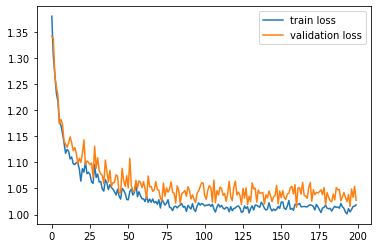

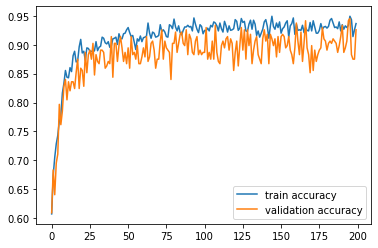

In [231]:
x = np.arange(total_epochs)
plt.plot(x,OSF_train_loss,label='train loss')
plt.plot(x,OSF_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,OSF_train_accuracy,label='train accuracy')
plt.plot(x,OSF_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(OSF_train_loss,OSF_train_accuracy,OSF_validate_loss,OSF_validate_accuracy))
frame.to_csv("OSF.csv")

In [232]:
del OS_MatchingNet
del OS_optimizer
del OS_scheduler
del dataO

# Start from scratch: Cifar-100

In [233]:
dataC = CifarNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

In [234]:
CS_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=False, image_size=32, use_cuda=True, model = 2)
CS_optimizer = torch.optim.Adam(CS_MatchingNet.parameters(), lr=0.1)
CS_scheduler = ReduceLROnPlateau(CS_optimizer, 'min',verbose=True)
CSN_train_loss = []
CSN_train_accuracy = []
CSN_validate_loss = []
CSN_validate_accuracy = []

In [235]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataC,total_train_batches, CS_MatchingNet, CS_optimizer, use_cuda)
        CSN_train_loss.append(t_loss)
        CSN_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, CS_MatchingNet, CS_scheduler, use_cuda, True)
        CSN_validate_loss.append(v_loss)
        CSN_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

CSN_accuracy = MetaValidate(dataC,total_test_batches, CS_MatchingNet, CS_scheduler, use_cuda, False)
print('final test accuracy: {}'.format(CSN_accuracy))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.5723637584596872 train_accuracy:0.2861328125


  0%|▍                                                                                 | 1/200 [00:03<12:52,  3.88s/it]

Epoch 0: validate_loss:1.5386772081255913 validate_accuracy:0.30859375
Epoch 1: train_loss:1.5633277781307697 train_accuracy:0.322265625


  1%|▊                                                                                 | 2/200 [00:07<12:49,  3.89s/it]

Epoch 1: validate_loss:1.562496617436409 validate_accuracy:0.28125
Epoch 2: train_loss:1.5647819936275482 train_accuracy:0.3017578125


  2%|█▏                                                                                | 3/200 [00:11<12:49,  3.91s/it]

Epoch 2: validate_loss:1.535435490310192 validate_accuracy:0.3203125
Epoch 3: train_loss:1.5372823607176542 train_accuracy:0.3154296875


  2%|█▋                                                                                | 4/200 [00:15<12:45,  3.91s/it]

Epoch 3: validate_loss:1.513927161693573 validate_accuracy:0.3125
Epoch 4: train_loss:1.5673866719007492 train_accuracy:0.2900390625


  2%|██                                                                                | 5/200 [00:19<12:40,  3.90s/it]

Epoch 4: validate_loss:1.5249045118689537 validate_accuracy:0.30859375
Epoch 5: train_loss:1.5679341834038496 train_accuracy:0.2861328125


  3%|██▍                                                                               | 6/200 [00:23<12:35,  3.89s/it]

Epoch 5: validate_loss:1.540940597653389 validate_accuracy:0.3203125
Epoch 6: train_loss:1.5439242515712976 train_accuracy:0.2939453125


  4%|██▊                                                                               | 7/200 [00:27<12:32,  3.90s/it]

Epoch 6: validate_loss:1.5111050233244896 validate_accuracy:0.3046875
Epoch 7: train_loss:1.5718870237469673 train_accuracy:0.28125


  4%|███▎                                                                              | 8/200 [00:31<12:28,  3.90s/it]

Epoch 7: validate_loss:1.5506890639662743 validate_accuracy:0.3046875
Epoch 8: train_loss:1.5395269952714443 train_accuracy:0.3076171875


  4%|███▋                                                                              | 9/200 [00:35<12:24,  3.90s/it]

Epoch 8: validate_loss:1.5085942447185516 validate_accuracy:0.34375
Epoch 9: train_loss:1.5165807288140059 train_accuracy:0.34375


  5%|████                                                                             | 10/200 [00:39<12:20,  3.90s/it]

Epoch 9: validate_loss:1.511595956981182 validate_accuracy:0.3671875
Epoch 10: train_loss:1.5294991452246904 train_accuracy:0.328125


  6%|████▍                                                                            | 11/200 [00:42<12:16,  3.90s/it]

Epoch 10: validate_loss:1.5265204682946205 validate_accuracy:0.3046875
Epoch 11: train_loss:1.540599713101983 train_accuracy:0.31640625


  6%|████▊                                                                            | 12/200 [00:46<12:12,  3.90s/it]

Epoch 11: validate_loss:1.493033029139042 validate_accuracy:0.3359375
Epoch 12: train_loss:1.5308562573045492 train_accuracy:0.302734375


  6%|█████▎                                                                           | 13/200 [00:50<12:07,  3.89s/it]

Epoch 12: validate_loss:1.525379627943039 validate_accuracy:0.30078125
Epoch 13: train_loss:1.5120872408151627 train_accuracy:0.33203125


  7%|█████▋                                                                           | 14/200 [00:54<12:03,  3.89s/it]

Epoch 13: validate_loss:1.5162114202976227 validate_accuracy:0.3125
Epoch 14: train_loss:1.513677241280675 train_accuracy:0.3173828125


  8%|██████                                                                           | 15/200 [00:58<11:59,  3.89s/it]

Epoch 14: validate_loss:1.4953564777970314 validate_accuracy:0.33203125
Epoch 15: train_loss:1.5036471467465162 train_accuracy:0.349609375


  8%|██████▍                                                                          | 16/200 [01:02<11:56,  3.90s/it]

Epoch 15: validate_loss:1.5349477231502533 validate_accuracy:0.31640625
Epoch 16: train_loss:1.5131779816001654 train_accuracy:0.3447265625


  8%|██████▉                                                                          | 17/200 [01:06<11:51,  3.89s/it]

Epoch 16: validate_loss:1.511480763554573 validate_accuracy:0.31640625
Epoch 17: train_loss:1.5372557248920202 train_accuracy:0.302734375


  9%|███████▎                                                                         | 18/200 [01:10<11:48,  3.89s/it]

Epoch 17: validate_loss:1.5125872865319252 validate_accuracy:0.33203125
Epoch 18: train_loss:1.510589735582471 train_accuracy:0.3173828125


 10%|███████▋                                                                         | 19/200 [01:14<11:43,  3.89s/it]

Epoch 18: validate_loss:1.5100676640868187 validate_accuracy:0.33203125
Epoch 19: train_loss:1.5024049431085587 train_accuracy:0.330078125


 10%|████████                                                                         | 20/200 [01:17<11:40,  3.89s/it]

Epoch 19: validate_loss:1.5096526741981506 validate_accuracy:0.34765625
Epoch 20: train_loss:1.4985420163720846 train_accuracy:0.3671875


 10%|████████▌                                                                        | 21/200 [01:21<11:35,  3.88s/it]

Epoch 20: validate_loss:1.511719599366188 validate_accuracy:0.3125
Epoch 21: train_loss:1.50455111451447 train_accuracy:0.3515625


 11%|████████▉                                                                        | 22/200 [01:25<11:31,  3.89s/it]

Epoch 21: validate_loss:1.5512265339493752 validate_accuracy:0.3125
Epoch 22: train_loss:1.5084739103913307 train_accuracy:0.3564453125


 12%|█████████▎                                                                       | 23/200 [01:29<11:27,  3.89s/it]

Epoch 22: validate_loss:1.4904997199773788 validate_accuracy:0.31640625
Epoch 23: train_loss:1.515118334442377 train_accuracy:0.3359375


 12%|█████████▋                                                                       | 24/200 [01:33<11:24,  3.89s/it]

Epoch 23: validate_loss:1.440212294459343 validate_accuracy:0.39453125
Epoch 24: train_loss:1.4923289082944393 train_accuracy:0.3388671875


 12%|██████████▏                                                                      | 25/200 [01:37<11:21,  3.89s/it]

Epoch 24: validate_loss:1.5415129661560059 validate_accuracy:0.26953125
Epoch 25: train_loss:1.4924682062119246 train_accuracy:0.3330078125


 13%|██████████▌                                                                      | 26/200 [01:41<11:19,  3.90s/it]

Epoch 25: validate_loss:1.4903410747647285 validate_accuracy:0.375
Epoch 26: train_loss:1.4811735562980175 train_accuracy:0.36328125


 14%|██████████▉                                                                      | 27/200 [01:45<11:17,  3.91s/it]

Epoch 26: validate_loss:1.4762274250388145 validate_accuracy:0.328125
Epoch 27: train_loss:1.493330042809248 train_accuracy:0.34765625


 14%|███████████▎                                                                     | 28/200 [01:49<11:13,  3.91s/it]

Epoch 27: validate_loss:1.5203794166445732 validate_accuracy:0.33203125
Epoch 28: train_loss:1.5086609702557325 train_accuracy:0.3486328125


 14%|███████████▋                                                                     | 29/200 [01:53<11:07,  3.91s/it]

Epoch 28: validate_loss:1.5082026422023773 validate_accuracy:0.33984375
Epoch 29: train_loss:1.507309740409255 train_accuracy:0.3515625


 15%|████████████▏                                                                    | 30/200 [01:56<11:03,  3.90s/it]

Epoch 29: validate_loss:1.4939811378717422 validate_accuracy:0.33984375
Epoch 30: train_loss:1.5105798672884703 train_accuracy:0.328125


 16%|████████████▌                                                                    | 31/200 [02:00<10:57,  3.89s/it]

Epoch 30: validate_loss:1.508595660328865 validate_accuracy:0.3125
Epoch 31: train_loss:1.4924347084015608 train_accuracy:0.3466796875


 16%|████████████▉                                                                    | 32/200 [02:04<10:54,  3.89s/it]

Epoch 31: validate_loss:1.5249236822128296 validate_accuracy:0.3046875
Epoch 32: train_loss:1.4995649214833975 train_accuracy:0.3466796875


 16%|█████████████▎                                                                   | 33/200 [02:08<10:52,  3.91s/it]

Epoch 32: validate_loss:1.5117026939988136 validate_accuracy:0.30859375
Epoch 33: train_loss:1.4994083046913147 train_accuracy:0.3525390625


 17%|█████████████▊                                                                   | 34/200 [02:12<10:47,  3.90s/it]

Epoch 33: validate_loss:1.471357710659504 validate_accuracy:0.33984375
Epoch 34: train_loss:1.4998890366405249 train_accuracy:0.3408203125


 18%|██████████████▏                                                                  | 35/200 [02:16<10:44,  3.90s/it]

Epoch    35: reducing learning rate of group 0 to 1.0000e-02.
Epoch 34: validate_loss:1.5208094418048859 validate_accuracy:0.33984375
Epoch 35: train_loss:1.4802949614822865 train_accuracy:0.365234375


 18%|██████████████▌                                                                  | 36/200 [02:20<10:39,  3.90s/it]

Epoch 35: validate_loss:1.5329267159104347 validate_accuracy:0.34765625
Epoch 36: train_loss:1.4681397750973701 train_accuracy:0.3896484375


 18%|██████████████▉                                                                  | 37/200 [02:24<10:35,  3.90s/it]

Epoch 36: validate_loss:1.4830747917294502 validate_accuracy:0.34375
Epoch 37: train_loss:1.4940708205103874 train_accuracy:0.35546875


 19%|███████████████▍                                                                 | 38/200 [02:28<10:31,  3.90s/it]

Epoch 37: validate_loss:1.4618193805217743 validate_accuracy:0.3828125
Epoch 38: train_loss:1.4702270776033401 train_accuracy:0.375


 20%|███████████████▊                                                                 | 39/200 [02:31<10:26,  3.89s/it]

Epoch 38: validate_loss:1.507061243057251 validate_accuracy:0.31640625
Epoch 39: train_loss:1.477958144620061 train_accuracy:0.3544921875


 20%|████████████████▏                                                                | 40/200 [02:35<10:22,  3.89s/it]

Epoch 39: validate_loss:1.4904811680316925 validate_accuracy:0.37109375
Epoch 40: train_loss:1.4683136194944382 train_accuracy:0.3779296875


 20%|████████████████▌                                                                | 41/200 [02:39<10:18,  3.89s/it]

Epoch 40: validate_loss:1.4954695031046867 validate_accuracy:0.35546875
Epoch 41: train_loss:1.4699027761816978 train_accuracy:0.37109375


 21%|█████████████████                                                                | 42/200 [02:43<10:13,  3.88s/it]

Epoch 41: validate_loss:1.495469406247139 validate_accuracy:0.33203125
Epoch 42: train_loss:1.4967532847076654 train_accuracy:0.345703125


 22%|█████████████████▍                                                               | 43/200 [02:47<10:09,  3.88s/it]

Epoch 42: validate_loss:1.4558692798018456 validate_accuracy:0.3828125
Epoch 43: train_loss:1.461753873154521 train_accuracy:0.373046875


 22%|█████████████████▊                                                               | 44/200 [02:51<10:05,  3.88s/it]

Epoch 43: validate_loss:1.4735916256904602 validate_accuracy:0.37890625
Epoch 44: train_loss:1.4859235361218452 train_accuracy:0.3681640625


 22%|██████████████████▏                                                              | 45/200 [02:55<10:01,  3.88s/it]

Epoch 44: validate_loss:1.5251146033406258 validate_accuracy:0.3203125
Epoch 45: train_loss:1.5038059391081333 train_accuracy:0.3427734375


 23%|██████████████████▋                                                              | 46/200 [02:59<09:57,  3.88s/it]

Epoch    46: reducing learning rate of group 0 to 1.0000e-03.
Epoch 45: validate_loss:1.542338103055954 validate_accuracy:0.30078125
Epoch 46: train_loss:1.4465300180017948 train_accuracy:0.40234375


 24%|███████████████████                                                              | 47/200 [03:03<09:53,  3.88s/it]

Epoch 46: validate_loss:1.515352502465248 validate_accuracy:0.31640625
Epoch 47: train_loss:1.4839818179607391 train_accuracy:0.3740234375


 24%|███████████████████▍                                                             | 48/200 [03:06<09:49,  3.88s/it]

Epoch 47: validate_loss:1.4795021191239357 validate_accuracy:0.3203125
Epoch 48: train_loss:1.4805242586880922 train_accuracy:0.349609375


 24%|███████████████████▊                                                             | 49/200 [03:10<09:47,  3.89s/it]

Epoch 48: validate_loss:1.4524157047271729 validate_accuracy:0.40625
Epoch 49: train_loss:1.4713901169598103 train_accuracy:0.3876953125


 25%|████████████████████▎                                                            | 50/200 [03:14<09:43,  3.89s/it]

Epoch 49: validate_loss:1.4197091087698936 validate_accuracy:0.38671875
Epoch 50: train_loss:1.4877726584672928 train_accuracy:0.3447265625


 26%|████████████████████▋                                                            | 51/200 [03:18<09:39,  3.89s/it]

Epoch 50: validate_loss:1.4910555705428123 validate_accuracy:0.36328125
Epoch 51: train_loss:1.4553858954459429 train_accuracy:0.3798828125


 26%|█████████████████████                                                            | 52/200 [03:22<09:35,  3.89s/it]

Epoch 51: validate_loss:1.5116046592593193 validate_accuracy:0.2890625
Epoch 52: train_loss:1.4736429564654827 train_accuracy:0.345703125


 26%|█████████████████████▍                                                           | 53/200 [03:26<09:31,  3.89s/it]

Epoch 52: validate_loss:1.4973111152648926 validate_accuracy:0.31640625
Epoch 53: train_loss:1.4749632105231285 train_accuracy:0.375


 27%|█████████████████████▊                                                           | 54/200 [03:30<09:28,  3.89s/it]

Epoch 53: validate_loss:1.5297886356711388 validate_accuracy:0.29296875
Epoch 54: train_loss:1.4789205323904753 train_accuracy:0.3671875


 28%|██████████████████████▎                                                          | 55/200 [03:34<09:24,  3.89s/it]

Epoch 54: validate_loss:1.4907847046852112 validate_accuracy:0.37109375
Epoch 55: train_loss:1.4572751969099045 train_accuracy:0.3828125


 28%|██████████████████████▋                                                          | 56/200 [03:38<09:20,  3.89s/it]

Epoch 55: validate_loss:1.4749033823609352 validate_accuracy:0.3515625
Epoch 56: train_loss:1.4965936038643122 train_accuracy:0.375


 28%|███████████████████████                                                          | 57/200 [03:41<09:16,  3.89s/it]

Epoch 56: validate_loss:1.4618613719940186 validate_accuracy:0.37890625
Epoch 57: train_loss:1.463118439540267 train_accuracy:0.3701171875


 29%|███████████████████████▍                                                         | 58/200 [03:45<09:15,  3.91s/it]

Epoch 57: validate_loss:1.5011239275336266 validate_accuracy:0.34375
Epoch 58: train_loss:1.4725053515285254 train_accuracy:0.3720703125


 30%|███████████████████████▉                                                         | 59/200 [03:49<09:12,  3.92s/it]

Epoch 58: validate_loss:1.4953084290027618 validate_accuracy:0.31640625
Epoch 59: train_loss:1.462445916607976 train_accuracy:0.369140625


 30%|████████████████████████▎                                                        | 60/200 [03:53<09:09,  3.92s/it]

Epoch 59: validate_loss:1.4994531571865082 validate_accuracy:0.33984375
Epoch 60: train_loss:1.457585170865059 train_accuracy:0.3837890625


 30%|████████████████████████▋                                                        | 61/200 [03:57<09:05,  3.92s/it]

Epoch    61: reducing learning rate of group 0 to 1.0000e-04.
Epoch 60: validate_loss:1.5099485665559769 validate_accuracy:0.30078125
Epoch 61: train_loss:1.4639441724866629 train_accuracy:0.3740234375


 31%|█████████████████████████                                                        | 62/200 [04:01<09:00,  3.92s/it]

Epoch 61: validate_loss:1.4910065680742264 validate_accuracy:0.33984375
Epoch 62: train_loss:1.4833367336541414 train_accuracy:0.337890625


 32%|█████████████████████████▌                                                       | 63/200 [04:05<08:55,  3.91s/it]

Epoch 62: validate_loss:1.4672530591487885 validate_accuracy:0.39453125
Epoch 63: train_loss:1.4809475261718035 train_accuracy:0.3564453125


 32%|█████████████████████████▉                                                       | 64/200 [04:09<08:52,  3.92s/it]

Epoch 63: validate_loss:1.5429733619093895 validate_accuracy:0.28125
Epoch 64: train_loss:1.4467122610658407 train_accuracy:0.384765625


 32%|██████████████████████████▎                                                      | 65/200 [04:13<08:48,  3.91s/it]

Epoch 64: validate_loss:1.5257860869169235 validate_accuracy:0.3203125
Epoch 65: train_loss:1.4645463414490223 train_accuracy:0.384765625


 33%|██████████████████████████▋                                                      | 66/200 [04:17<08:44,  3.91s/it]

Epoch 65: validate_loss:1.4868358299136162 validate_accuracy:0.35546875
Epoch 66: train_loss:1.465446326881647 train_accuracy:0.3740234375


 34%|███████████████████████████▏                                                     | 67/200 [04:21<08:39,  3.91s/it]

Epoch 66: validate_loss:1.4500677958130836 validate_accuracy:0.38671875
Epoch 67: train_loss:1.4834084026515484 train_accuracy:0.359375


 34%|███████████████████████████▌                                                     | 68/200 [04:24<08:34,  3.90s/it]

Epoch 67: validate_loss:1.4721170216798782 validate_accuracy:0.34375
Epoch 68: train_loss:1.4660304058343172 train_accuracy:0.3740234375


 34%|███████████████████████████▉                                                     | 69/200 [04:28<08:30,  3.90s/it]

Epoch 68: validate_loss:1.482682190835476 validate_accuracy:0.3359375
Epoch 69: train_loss:1.4536422733217478 train_accuracy:0.38671875


 35%|████████████████████████████▎                                                    | 70/200 [04:32<08:26,  3.90s/it]

Epoch 69: validate_loss:1.523761808872223 validate_accuracy:0.29296875
Epoch 70: train_loss:1.466923026368022 train_accuracy:0.353515625


 36%|████████████████████████████▊                                                    | 71/200 [04:36<08:25,  3.92s/it]

Epoch 70: validate_loss:1.4608183205127716 validate_accuracy:0.41015625
Epoch 71: train_loss:1.4624000061303377 train_accuracy:0.384765625


 36%|█████████████████████████████▏                                                   | 72/200 [04:40<08:22,  3.92s/it]

Epoch    72: reducing learning rate of group 0 to 1.0000e-05.
Epoch 71: validate_loss:1.4455578997731209 validate_accuracy:0.38671875
Epoch 72: train_loss:1.4837893396615982 train_accuracy:0.3779296875


 36%|█████████████████████████████▌                                                   | 73/200 [04:44<08:17,  3.91s/it]

Epoch 72: validate_loss:1.5253980457782745 validate_accuracy:0.3125
Epoch 73: train_loss:1.4739219658076763 train_accuracy:0.3671875


 37%|█████████████████████████████▉                                                   | 74/200 [04:48<08:11,  3.90s/it]

Epoch 73: validate_loss:1.4865395426750183 validate_accuracy:0.34375
Epoch 74: train_loss:1.4770378023386002 train_accuracy:0.3642578125


 38%|██████████████████████████████▍                                                  | 75/200 [04:52<08:08,  3.91s/it]

Epoch 74: validate_loss:1.4705597087740898 validate_accuracy:0.3515625
Epoch 75: train_loss:1.4660496972501278 train_accuracy:0.3857421875


 38%|██████████████████████████████▊                                                  | 76/200 [04:56<08:03,  3.90s/it]

Epoch 75: validate_loss:1.4788973405957222 validate_accuracy:0.328125
Epoch 76: train_loss:1.4645716659724712 train_accuracy:0.3740234375


 38%|███████████████████████████████▏                                                 | 77/200 [05:00<07:58,  3.89s/it]

Epoch 76: validate_loss:1.4920112416148186 validate_accuracy:0.3359375
Epoch 77: train_loss:1.476998146623373 train_accuracy:0.373046875


 39%|███████████████████████████████▌                                                 | 78/200 [05:04<07:54,  3.89s/it]

Epoch 77: validate_loss:1.4818095490336418 validate_accuracy:0.3515625
Epoch 78: train_loss:1.473805570974946 train_accuracy:0.3740234375


 40%|███████████████████████████████▉                                                 | 79/200 [05:07<07:51,  3.90s/it]

Epoch 78: validate_loss:1.4514535143971443 validate_accuracy:0.4453125
Epoch 79: train_loss:1.4712240658700466 train_accuracy:0.3583984375


 40%|████████████████████████████████▍                                                | 80/200 [05:11<07:47,  3.89s/it]

Epoch 79: validate_loss:1.4530717432498932 validate_accuracy:0.375
Epoch 80: train_loss:1.4624383207410574 train_accuracy:0.37109375


 40%|████████████████████████████████▊                                                | 81/200 [05:15<07:43,  3.90s/it]

Epoch 80: validate_loss:1.4712480530142784 validate_accuracy:0.375
Epoch 81: train_loss:1.459399363026023 train_accuracy:0.3974609375


 41%|█████████████████████████████████▏                                               | 82/200 [05:19<07:39,  3.90s/it]

Epoch 81: validate_loss:1.4758588448166847 validate_accuracy:0.36328125
Epoch 82: train_loss:1.4820761866867542 train_accuracy:0.369140625


 42%|█████████████████████████████████▌                                               | 83/200 [05:23<07:35,  3.90s/it]

Epoch    83: reducing learning rate of group 0 to 1.0000e-06.
Epoch 82: validate_loss:1.432903990149498 validate_accuracy:0.3984375
Epoch 83: train_loss:1.4605118576437235 train_accuracy:0.380859375


 42%|██████████████████████████████████                                               | 84/200 [05:27<07:31,  3.90s/it]

Epoch 83: validate_loss:1.4331300929188728 validate_accuracy:0.37890625
Epoch 84: train_loss:1.4722089618444443 train_accuracy:0.36328125


 42%|██████████████████████████████████▍                                              | 85/200 [05:31<07:28,  3.90s/it]

Epoch 84: validate_loss:1.5372431129217148 validate_accuracy:0.36328125
Epoch 85: train_loss:1.472580261528492 train_accuracy:0.361328125


 43%|██████████████████████████████████▊                                              | 86/200 [05:35<07:23,  3.89s/it]

Epoch 85: validate_loss:1.456068329513073 validate_accuracy:0.41796875
Epoch 86: train_loss:1.4711805190891027 train_accuracy:0.3740234375


 44%|███████████████████████████████████▏                                             | 87/200 [05:39<07:19,  3.89s/it]

Epoch 86: validate_loss:1.5003876090049744 validate_accuracy:0.31640625
Epoch 87: train_loss:1.4998611267656088 train_accuracy:0.3349609375


 44%|███████████████████████████████████▋                                             | 88/200 [05:42<07:16,  3.89s/it]

Epoch 87: validate_loss:1.5351288691163063 validate_accuracy:0.3203125
Epoch 88: train_loss:1.47716005705297 train_accuracy:0.3798828125


 44%|████████████████████████████████████                                             | 89/200 [05:46<07:12,  3.90s/it]

Epoch 88: validate_loss:1.4796477034687996 validate_accuracy:0.35546875
Epoch 89: train_loss:1.4851383734494448 train_accuracy:0.3544921875


 45%|████████████████████████████████████▍                                            | 90/200 [05:50<07:07,  3.89s/it]

Epoch 89: validate_loss:1.4615658819675446 validate_accuracy:0.359375
Epoch 90: train_loss:1.4621071349829435 train_accuracy:0.388671875


 46%|████████████████████████████████████▊                                            | 91/200 [05:54<07:03,  3.89s/it]

Epoch 90: validate_loss:1.533103659749031 validate_accuracy:0.3046875
Epoch 91: train_loss:1.4872575849294662 train_accuracy:0.341796875


 46%|█████████████████████████████████████▎                                           | 92/200 [05:58<06:59,  3.89s/it]

Epoch 91: validate_loss:1.458218976855278 validate_accuracy:0.359375
Epoch 92: train_loss:1.471117353066802 train_accuracy:0.375


 46%|█████████████████████████████████████▋                                           | 93/200 [06:02<06:56,  3.89s/it]

Epoch 92: validate_loss:1.4831149876117706 validate_accuracy:0.33984375
Epoch 93: train_loss:1.4622322600334883 train_accuracy:0.375


 47%|██████████████████████████████████████                                           | 94/200 [06:06<06:52,  3.89s/it]

Epoch    94: reducing learning rate of group 0 to 1.0000e-07.
Epoch 93: validate_loss:1.4702709168195724 validate_accuracy:0.3515625
Epoch 94: train_loss:1.4522570371627808 train_accuracy:0.3818359375


 48%|██████████████████████████████████████▍                                          | 95/200 [06:10<06:48,  3.90s/it]

Epoch 94: validate_loss:1.5000008344650269 validate_accuracy:0.34375
Epoch 95: train_loss:1.4744957908988 train_accuracy:0.376953125


 48%|██████████████████████████████████████▉                                          | 96/200 [06:14<06:45,  3.89s/it]

Epoch 95: validate_loss:1.4869209006428719 validate_accuracy:0.390625
Epoch 96: train_loss:1.4564432948827744 train_accuracy:0.3857421875


 48%|███████████████████████████████████████▎                                         | 97/200 [06:17<06:41,  3.89s/it]

Epoch 96: validate_loss:1.4654678702354431 validate_accuracy:0.34765625
Epoch 97: train_loss:1.4861781038343906 train_accuracy:0.3681640625


 49%|███████████████████████████████████████▋                                         | 98/200 [06:21<06:36,  3.89s/it]

Epoch 97: validate_loss:1.4864507615566254 validate_accuracy:0.34765625
Epoch 98: train_loss:1.4732506331056356 train_accuracy:0.380859375


 50%|████████████████████████████████████████                                         | 99/200 [06:25<06:32,  3.89s/it]

Epoch 98: validate_loss:1.4786603823304176 validate_accuracy:0.3671875
Epoch 99: train_loss:1.4807361401617527 train_accuracy:0.34375


 50%|████████████████████████████████████████                                        | 100/200 [06:29<06:28,  3.89s/it]

Epoch 99: validate_loss:1.4777866005897522 validate_accuracy:0.34765625
Epoch 100: train_loss:1.4923747684806585 train_accuracy:0.34375


 50%|████████████████████████████████████████▍                                       | 101/200 [06:33<06:25,  3.89s/it]

Epoch 100: validate_loss:1.4513176381587982 validate_accuracy:0.34375
Epoch 101: train_loss:1.4756563361734152 train_accuracy:0.380859375


 51%|████████████████████████████████████████▊                                       | 102/200 [06:37<06:20,  3.89s/it]

Epoch 101: validate_loss:1.4812980592250824 validate_accuracy:0.3359375
Epoch 102: train_loss:1.5047142766416073 train_accuracy:0.3349609375


 52%|█████████████████████████████████████████▏                                      | 103/200 [06:41<06:16,  3.88s/it]

Epoch 102: validate_loss:1.4840083345770836 validate_accuracy:0.3515625
Epoch 103: train_loss:1.4770583659410477 train_accuracy:0.3662109375


 52%|█████████████████████████████████████████▌                                      | 104/200 [06:45<06:12,  3.88s/it]

Epoch 103: validate_loss:1.4886139631271362 validate_accuracy:0.34375
Epoch 104: train_loss:1.4801033101975918 train_accuracy:0.3701171875


 52%|██████████████████████████████████████████                                      | 105/200 [06:49<06:08,  3.88s/it]

Epoch   105: reducing learning rate of group 0 to 1.0000e-08.
Epoch 104: validate_loss:1.446244716644287 validate_accuracy:0.36328125
Epoch 105: train_loss:1.4918445479124784 train_accuracy:0.3544921875


 53%|██████████████████████████████████████████▍                                     | 106/200 [06:52<06:04,  3.88s/it]

Epoch 105: validate_loss:1.49209413677454 validate_accuracy:0.3515625
Epoch 106: train_loss:1.4807805623859167 train_accuracy:0.3671875


 54%|██████████████████████████████████████████▊                                     | 107/200 [06:56<06:01,  3.88s/it]

Epoch 106: validate_loss:1.4636211395263672 validate_accuracy:0.35546875
Epoch 107: train_loss:1.468153351917863 train_accuracy:0.3583984375


 54%|███████████████████████████████████████████▏                                    | 108/200 [07:00<05:57,  3.89s/it]

Epoch 107: validate_loss:1.4950287267565727 validate_accuracy:0.3515625
Epoch 108: train_loss:1.4881094247102737 train_accuracy:0.3525390625


 55%|███████████████████████████████████████████▌                                    | 109/200 [07:04<05:53,  3.89s/it]

Epoch 108: validate_loss:1.476243071258068 validate_accuracy:0.3671875
Epoch 109: train_loss:1.476716075092554 train_accuracy:0.349609375


 55%|████████████████████████████████████████████                                    | 110/200 [07:08<05:49,  3.89s/it]

Epoch 109: validate_loss:1.4993984326720238 validate_accuracy:0.36328125
Epoch 110: train_loss:1.498945264145732 train_accuracy:0.3330078125


 56%|████████████████████████████████████████████▍                                   | 111/200 [07:12<05:45,  3.89s/it]

Epoch 110: validate_loss:1.51610466837883 validate_accuracy:0.3203125
Epoch 111: train_loss:1.4501649178564548 train_accuracy:0.376953125


 56%|████████████████████████████████████████████▊                                   | 112/200 [07:16<05:42,  3.89s/it]

Epoch 111: validate_loss:1.4647821560502052 validate_accuracy:0.36328125
Epoch 112: train_loss:1.471211962401867 train_accuracy:0.38671875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [07:20<05:38,  3.89s/it]

Epoch 112: validate_loss:1.5056789070367813 validate_accuracy:0.30859375
Epoch 113: train_loss:1.4858910385519266 train_accuracy:0.35546875


 57%|█████████████████████████████████████████████▌                                  | 114/200 [07:24<05:34,  3.89s/it]

Epoch 113: validate_loss:1.4630301967263222 validate_accuracy:0.40234375
Epoch 114: train_loss:1.4671000931411982 train_accuracy:0.3857421875


 57%|██████████████████████████████████████████████                                  | 115/200 [07:27<05:30,  3.89s/it]

Epoch 114: validate_loss:1.48842291533947 validate_accuracy:0.32421875
Epoch 115: train_loss:1.5119770634919405 train_accuracy:0.322265625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [07:31<05:26,  3.89s/it]

Epoch 115: validate_loss:1.448153242468834 validate_accuracy:0.4296875
Epoch 116: train_loss:1.4590634535998106 train_accuracy:0.3740234375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [07:35<05:22,  3.89s/it]

Epoch 116: validate_loss:1.4858161211013794 validate_accuracy:0.3359375
Epoch 117: train_loss:1.4478852283209562 train_accuracy:0.388671875


 59%|███████████████████████████████████████████████▏                                | 118/200 [07:39<05:19,  3.89s/it]

Epoch 117: validate_loss:1.5119147673249245 validate_accuracy:0.33984375
Epoch 118: train_loss:1.4897211082279682 train_accuracy:0.353515625


 60%|███████████████████████████████████████████████▌                                | 119/200 [07:43<05:14,  3.89s/it]

Epoch 118: validate_loss:1.4832775592803955 validate_accuracy:0.33984375
Epoch 119: train_loss:1.4809563178569078 train_accuracy:0.349609375


 60%|████████████████████████████████████████████████                                | 120/200 [07:47<05:11,  3.89s/it]

Epoch 119: validate_loss:1.4965163618326187 validate_accuracy:0.3359375
Epoch 120: train_loss:1.4854577034711838 train_accuracy:0.369140625


 60%|████████████████████████████████████████████████▍                               | 121/200 [07:51<05:07,  3.89s/it]

Epoch 120: validate_loss:1.4733830243349075 validate_accuracy:0.3515625
Epoch 121: train_loss:1.4717959109693766 train_accuracy:0.3701171875


 61%|████████████████████████████████████████████████▊                               | 122/200 [07:55<05:02,  3.88s/it]

Epoch 121: validate_loss:1.516962207853794 validate_accuracy:0.3125
Epoch 122: train_loss:1.4775571785867214 train_accuracy:0.3681640625


 62%|█████████████████████████████████████████████████▏                              | 123/200 [07:59<04:59,  3.89s/it]

Epoch 122: validate_loss:1.4651788920164108 validate_accuracy:0.36328125
Epoch 123: train_loss:1.483000349253416 train_accuracy:0.369140625


 62%|█████████████████████████████████████████████████▌                              | 124/200 [08:02<04:55,  3.89s/it]

Epoch 123: validate_loss:1.480740450322628 validate_accuracy:0.36328125
Epoch 124: train_loss:1.4706787131726742 train_accuracy:0.361328125


 62%|██████████████████████████████████████████████████                              | 125/200 [08:06<04:51,  3.89s/it]

Epoch 124: validate_loss:1.491227462887764 validate_accuracy:0.37890625
Epoch 125: train_loss:1.4728461410850286 train_accuracy:0.3603515625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [08:10<04:48,  3.90s/it]

Epoch 125: validate_loss:1.450376257300377 validate_accuracy:0.41796875
Epoch 126: train_loss:1.4727368541061878 train_accuracy:0.3740234375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [08:14<04:44,  3.90s/it]

Epoch 126: validate_loss:1.506360501050949 validate_accuracy:0.34765625
Epoch 127: train_loss:1.4598277490586042 train_accuracy:0.36328125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [08:18<04:40,  3.90s/it]

Epoch 127: validate_loss:1.504068911075592 validate_accuracy:0.33203125
Epoch 128: train_loss:1.4810205083340406 train_accuracy:0.3662109375


 64%|███████████████████████████████████████████████████▌                            | 129/200 [08:22<04:36,  3.89s/it]

Epoch 128: validate_loss:1.486654408276081 validate_accuracy:0.32421875
Epoch 129: train_loss:1.4671153128147125 train_accuracy:0.37109375


 65%|████████████████████████████████████████████████████                            | 130/200 [08:26<04:31,  3.88s/it]

Epoch 129: validate_loss:1.4455922544002533 validate_accuracy:0.3671875
Epoch 130: train_loss:1.4541330132633448 train_accuracy:0.373046875


 66%|████████████████████████████████████████████████████▍                           | 131/200 [08:30<04:27,  3.88s/it]

Epoch 130: validate_loss:1.5332810953259468 validate_accuracy:0.32421875
Epoch 131: train_loss:1.4643042664974928 train_accuracy:0.37109375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [08:34<04:24,  3.88s/it]

Epoch 131: validate_loss:1.4722151830792427 validate_accuracy:0.390625
Epoch 132: train_loss:1.4729895703494549 train_accuracy:0.3837890625


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [08:37<04:20,  3.88s/it]

Epoch 132: validate_loss:1.5312682464718819 validate_accuracy:0.33203125
Epoch 133: train_loss:1.477468503639102 train_accuracy:0.3505859375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [08:41<04:16,  3.89s/it]

Epoch 133: validate_loss:1.48758053034544 validate_accuracy:0.33203125
Epoch 134: train_loss:1.4657158572226763 train_accuracy:0.3623046875


 68%|██████████████████████████████████████████████████████                          | 135/200 [08:45<04:12,  3.89s/it]

Epoch 134: validate_loss:1.5042889192700386 validate_accuracy:0.3046875
Epoch 135: train_loss:1.4782951846718788 train_accuracy:0.365234375


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [08:49<04:08,  3.89s/it]

Epoch 135: validate_loss:1.481745421886444 validate_accuracy:0.37109375
Epoch 136: train_loss:1.4741120617836714 train_accuracy:0.37109375


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [08:53<04:05,  3.89s/it]

Epoch 136: validate_loss:1.5517940521240234 validate_accuracy:0.30078125
Epoch 137: train_loss:1.4730766825377941 train_accuracy:0.3671875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [08:57<04:01,  3.89s/it]

Epoch 137: validate_loss:1.4762872532010078 validate_accuracy:0.3671875
Epoch 138: train_loss:1.4682656917721033 train_accuracy:0.3662109375


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [09:01<03:57,  3.89s/it]

Epoch 138: validate_loss:1.5013407096266747 validate_accuracy:0.33203125
Epoch 139: train_loss:1.478900222107768 train_accuracy:0.3642578125


 70%|████████████████████████████████████████████████████████                        | 140/200 [09:05<03:53,  3.90s/it]

Epoch 139: validate_loss:1.4785128757357597 validate_accuracy:0.32421875
Epoch 140: train_loss:1.471017612144351 train_accuracy:0.353515625


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [09:09<03:49,  3.90s/it]

Epoch 140: validate_loss:1.5189606100320816 validate_accuracy:0.328125
Epoch 141: train_loss:1.4390749726444483 train_accuracy:0.3984375


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [09:12<03:45,  3.89s/it]

Epoch 141: validate_loss:1.4651279672980309 validate_accuracy:0.35546875
Epoch 142: train_loss:1.4765416402369738 train_accuracy:0.349609375


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [09:16<03:42,  3.90s/it]

Epoch 142: validate_loss:1.5103211179375648 validate_accuracy:0.34375
Epoch 143: train_loss:1.4626460336148739 train_accuracy:0.375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [09:20<03:38,  3.90s/it]

Epoch 143: validate_loss:1.4909877553582191 validate_accuracy:0.3359375
Epoch 144: train_loss:1.4893098454922438 train_accuracy:0.3642578125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [09:24<03:34,  3.91s/it]

Epoch 144: validate_loss:1.4794409573078156 validate_accuracy:0.37890625
Epoch 145: train_loss:1.4773209542036057 train_accuracy:0.3701171875


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [09:28<03:30,  3.90s/it]

Epoch 145: validate_loss:1.497573658823967 validate_accuracy:0.31640625
Epoch 146: train_loss:1.4710213355720043 train_accuracy:0.345703125


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [09:32<03:27,  3.91s/it]

Epoch 146: validate_loss:1.4866370186209679 validate_accuracy:0.31640625
Epoch 147: train_loss:1.4827185962349176 train_accuracy:0.359375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [09:36<03:24,  3.92s/it]

Epoch 147: validate_loss:1.4593174308538437 validate_accuracy:0.37890625
Epoch 148: train_loss:1.4759335946291685 train_accuracy:0.34765625


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [09:40<03:20,  3.93s/it]

Epoch 148: validate_loss:1.477057121694088 validate_accuracy:0.34765625
Epoch 149: train_loss:1.4853168986737728 train_accuracy:0.337890625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [09:44<03:15,  3.92s/it]

Epoch 149: validate_loss:1.4826325327157974 validate_accuracy:0.33984375
Epoch 150: train_loss:1.4641360864043236 train_accuracy:0.361328125


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [09:48<03:12,  3.92s/it]

Epoch 150: validate_loss:1.465943343937397 validate_accuracy:0.35546875
Epoch 151: train_loss:1.4708430133759975 train_accuracy:0.3740234375


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [09:52<03:08,  3.92s/it]

Epoch 151: validate_loss:1.525666669011116 validate_accuracy:0.3046875
Epoch 152: train_loss:1.46417879126966 train_accuracy:0.3857421875


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [09:56<03:03,  3.91s/it]

Epoch 152: validate_loss:1.4798809587955475 validate_accuracy:0.359375
Epoch 153: train_loss:1.4638134092092514 train_accuracy:0.373046875


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [09:59<02:59,  3.91s/it]

Epoch 153: validate_loss:1.4903712794184685 validate_accuracy:0.31640625
Epoch 154: train_loss:1.4563529565930367 train_accuracy:0.396484375


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [10:03<02:55,  3.91s/it]

Epoch 154: validate_loss:1.5298968628048897 validate_accuracy:0.296875
Epoch 155: train_loss:1.4779260959476233 train_accuracy:0.361328125


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [10:07<02:51,  3.90s/it]

Epoch 155: validate_loss:1.5152822434902191 validate_accuracy:0.26171875
Epoch 156: train_loss:1.470996905118227 train_accuracy:0.373046875


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [10:11<02:47,  3.90s/it]

Epoch 156: validate_loss:1.4542966559529305 validate_accuracy:0.38671875
Epoch 157: train_loss:1.477793112397194 train_accuracy:0.3681640625


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [10:15<02:43,  3.90s/it]

Epoch 157: validate_loss:1.5356079638004303 validate_accuracy:0.30859375
Epoch 158: train_loss:1.46518256329 train_accuracy:0.369140625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [10:19<02:39,  3.90s/it]

Epoch 158: validate_loss:1.5252688378095627 validate_accuracy:0.328125
Epoch 159: train_loss:1.4801249969750643 train_accuracy:0.345703125


 80%|████████████████████████████████████████████████████████████████                | 160/200 [10:23<02:35,  3.90s/it]

Epoch 159: validate_loss:1.49165328592062 validate_accuracy:0.359375
Epoch 160: train_loss:1.4726414792239666 train_accuracy:0.3857421875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [10:27<02:32,  3.91s/it]

Epoch 160: validate_loss:1.4971661269664764 validate_accuracy:0.33203125
Epoch 161: train_loss:1.471878344193101 train_accuracy:0.3671875


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [10:31<02:28,  3.91s/it]

Epoch 161: validate_loss:1.4708989560604095 validate_accuracy:0.3671875
Epoch 162: train_loss:1.4697952065616846 train_accuracy:0.36328125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [10:35<02:24,  3.91s/it]

Epoch 162: validate_loss:1.457281932234764 validate_accuracy:0.3828125
Epoch 163: train_loss:1.4718448277562857 train_accuracy:0.388671875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [10:39<02:20,  3.91s/it]

Epoch 163: validate_loss:1.5081289112567902 validate_accuracy:0.296875
Epoch 164: train_loss:1.4692231863737106 train_accuracy:0.3681640625


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [10:42<02:17,  3.92s/it]

Epoch 164: validate_loss:1.5227832943201065 validate_accuracy:0.30859375
Epoch 165: train_loss:1.474386876448989 train_accuracy:0.369140625


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [10:46<02:13,  3.92s/it]

Epoch 165: validate_loss:1.4427807331085205 validate_accuracy:0.39453125
Epoch 166: train_loss:1.4910437278449535 train_accuracy:0.357421875


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [10:50<02:09,  3.92s/it]

Epoch 166: validate_loss:1.5043281093239784 validate_accuracy:0.32421875
Epoch 167: train_loss:1.475812941789627 train_accuracy:0.3349609375


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [10:54<02:05,  3.93s/it]

Epoch 167: validate_loss:1.4954677671194077 validate_accuracy:0.3046875
Epoch 168: train_loss:1.4631587509065866 train_accuracy:0.365234375


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [10:58<02:01,  3.93s/it]

Epoch 168: validate_loss:1.480796754360199 validate_accuracy:0.36328125
Epoch 169: train_loss:1.4890395235270262 train_accuracy:0.33984375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [11:02<01:57,  3.92s/it]

Epoch 169: validate_loss:1.495566688477993 validate_accuracy:0.3203125
Epoch 170: train_loss:1.4801900777965784 train_accuracy:0.3466796875


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [11:06<01:53,  3.91s/it]

Epoch 170: validate_loss:1.468852236866951 validate_accuracy:0.33984375
Epoch 171: train_loss:1.466333145275712 train_accuracy:0.3671875


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [11:10<01:49,  3.90s/it]

Epoch 171: validate_loss:1.4894762858748436 validate_accuracy:0.33984375
Epoch 172: train_loss:1.4491217620670795 train_accuracy:0.3916015625


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [11:14<01:45,  3.90s/it]

Epoch 172: validate_loss:1.4978018552064896 validate_accuracy:0.3828125
Epoch 173: train_loss:1.4783509094268084 train_accuracy:0.35546875


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [11:18<01:41,  3.91s/it]

Epoch 173: validate_loss:1.5535881072282791 validate_accuracy:0.3046875
Epoch 174: train_loss:1.4703408107161522 train_accuracy:0.3662109375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [11:22<01:37,  3.91s/it]

Epoch 174: validate_loss:1.5063312575221062 validate_accuracy:0.328125
Epoch 175: train_loss:1.4553526230156422 train_accuracy:0.3837890625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [11:25<01:33,  3.91s/it]

Epoch 175: validate_loss:1.4869229644536972 validate_accuracy:0.3203125
Epoch 176: train_loss:1.4820904675871134 train_accuracy:0.361328125


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [11:29<01:30,  3.92s/it]

Epoch 176: validate_loss:1.5005756095051765 validate_accuracy:0.3515625
Epoch 177: train_loss:1.4537448342889547 train_accuracy:0.380859375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [11:33<01:26,  3.92s/it]

Epoch 177: validate_loss:1.4685732275247574 validate_accuracy:0.37109375
Epoch 178: train_loss:1.4642059598118067 train_accuracy:0.3818359375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [11:37<01:22,  3.93s/it]

Epoch 178: validate_loss:1.4930560514330864 validate_accuracy:0.3203125
Epoch 179: train_loss:1.4818905778229237 train_accuracy:0.3515625


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [11:41<01:18,  3.91s/it]

Epoch 179: validate_loss:1.4903181865811348 validate_accuracy:0.36328125
Epoch 180: train_loss:1.475404977798462 train_accuracy:0.345703125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [11:45<01:14,  3.92s/it]

Epoch 180: validate_loss:1.5115417763590813 validate_accuracy:0.3515625
Epoch 181: train_loss:1.465428989380598 train_accuracy:0.369140625


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [11:49<01:10,  3.91s/it]

Epoch 181: validate_loss:1.4960505217313766 validate_accuracy:0.3515625
Epoch 182: train_loss:1.4873167797923088 train_accuracy:0.3486328125


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [11:53<01:06,  3.90s/it]

Epoch 182: validate_loss:1.4610562026500702 validate_accuracy:0.37109375
Epoch 183: train_loss:1.48756299354136 train_accuracy:0.349609375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [11:57<01:02,  3.90s/it]

Epoch 183: validate_loss:1.453510694205761 validate_accuracy:0.35546875
Epoch 184: train_loss:1.4709855485707521 train_accuracy:0.3671875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [12:01<00:58,  3.89s/it]

Epoch 184: validate_loss:1.4517727717757225 validate_accuracy:0.37890625
Epoch 185: train_loss:1.4845892041921616 train_accuracy:0.3671875


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [12:04<00:54,  3.88s/it]

Epoch 185: validate_loss:1.4237656220793724 validate_accuracy:0.3984375
Epoch 186: train_loss:1.4756994545459747 train_accuracy:0.36328125


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [12:08<00:50,  3.88s/it]

Epoch 186: validate_loss:1.4788021817803383 validate_accuracy:0.3203125
Epoch 187: train_loss:1.4541740082204342 train_accuracy:0.41796875


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [12:12<00:46,  3.89s/it]

Epoch 187: validate_loss:1.4498273730278015 validate_accuracy:0.3828125
Epoch 188: train_loss:1.4674333706498146 train_accuracy:0.3583984375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [12:16<00:42,  3.89s/it]

Epoch 188: validate_loss:1.5307260379195213 validate_accuracy:0.30859375
Epoch 189: train_loss:1.4898607097566128 train_accuracy:0.3359375


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [12:20<00:38,  3.89s/it]

Epoch 189: validate_loss:1.4970314800739288 validate_accuracy:0.37109375
Epoch 190: train_loss:1.449605269357562 train_accuracy:0.392578125


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [12:24<00:34,  3.89s/it]

Epoch 190: validate_loss:1.4712204560637474 validate_accuracy:0.36328125
Epoch 191: train_loss:1.470846749842167 train_accuracy:0.373046875


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [12:28<00:31,  3.89s/it]

Epoch 191: validate_loss:1.4997933506965637 validate_accuracy:0.34765625
Epoch 192: train_loss:1.4479270558804274 train_accuracy:0.392578125


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [12:32<00:27,  3.89s/it]

Epoch 192: validate_loss:1.477861113846302 validate_accuracy:0.3203125
Epoch 193: train_loss:1.4631984531879425 train_accuracy:0.365234375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [12:36<00:23,  3.90s/it]

Epoch 193: validate_loss:1.431408405303955 validate_accuracy:0.3984375
Epoch 194: train_loss:1.4731704108417034 train_accuracy:0.3486328125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [12:40<00:19,  3.89s/it]

Epoch 194: validate_loss:1.49269250780344 validate_accuracy:0.33203125
Epoch 195: train_loss:1.4797012023627758 train_accuracy:0.3349609375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [12:43<00:15,  3.89s/it]

Epoch 195: validate_loss:1.4610682129859924 validate_accuracy:0.39453125
Epoch 196: train_loss:1.4729203134775162 train_accuracy:0.3515625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [12:47<00:11,  3.89s/it]

Epoch 196: validate_loss:1.4968181103467941 validate_accuracy:0.328125
Epoch 197: train_loss:1.4702385198324919 train_accuracy:0.357421875


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [12:51<00:07,  3.89s/it]

Epoch 197: validate_loss:1.4969799742102623 validate_accuracy:0.30078125
Epoch 198: train_loss:1.4699199367314577 train_accuracy:0.36328125


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [12:55<00:03,  3.89s/it]

Epoch 198: validate_loss:1.488537885248661 validate_accuracy:0.33203125
Epoch 199: train_loss:1.467851335182786 train_accuracy:0.37109375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [12:59<00:00,  3.90s/it]

Epoch 199: validate_loss:1.4828548282384872 validate_accuracy:0.2734375


final test accuracy: (1.4564173817634583, 0.40625)


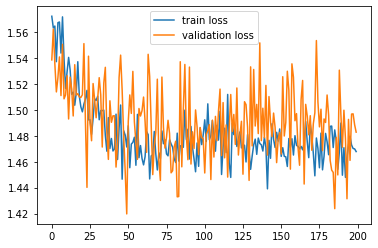

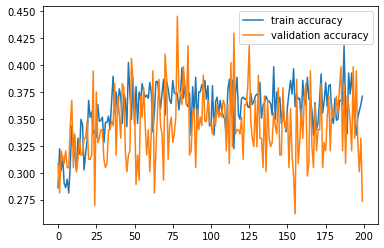

In [236]:
x = np.arange(total_epochs)
plt.plot(x,CSN_train_loss,label='train loss')
plt.plot(x,CSN_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,CSN_train_accuracy,label='train accuracy')
plt.plot(x,CSN_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(CSN_train_loss,CSN_validate_loss,CSN_train_accuracy,CSN_validate_accuracy))
frame.to_csv("CSN.csv")

In [237]:
del CS_MatchingNet
del CS_optimizer
del CS_scheduler

In [238]:
CS_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=True, image_size=32, use_cuda=True, model = 2)
CS_optimizer = torch.optim.Adam(CS_MatchingNet.parameters(), lr=0.1)
CS_scheduler = ReduceLROnPlateau(CS_optimizer, 'min',verbose=True)
CSF_train_loss = []
CSF_train_accuracy = []
CSF_validate_loss = []
CSF_validate_accuracy = []

In [239]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataC,total_train_batches, CS_MatchingNet, CS_optimizer, use_cuda)
        CSF_train_loss.append(t_loss)
        CSF_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, CS_MatchingNet, CS_scheduler, use_cuda, True)
        CSF_validate_loss.append(v_loss)
        CSF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

CSF_accuracy = MetaValidate(dataC,total_test_batches, CS_MatchingNet, CS_scheduler, use_cuda, False)
print('final test accuracy: {}'.format(CSF_accuracy))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.5691957641392946 train_accuracy:0.2890625


  0%|▍                                                                                 | 1/200 [00:04<16:24,  4.95s/it]

Epoch 0: validate_loss:1.5238111913204193 validate_accuracy:0.34765625
Epoch 1: train_loss:1.5525010880082846 train_accuracy:0.2998046875


  1%|▊                                                                                 | 2/200 [00:09<16:20,  4.95s/it]

Epoch 1: validate_loss:1.5532502457499504 validate_accuracy:0.30078125
Epoch 2: train_loss:1.5692487061023712 train_accuracy:0.2978515625


  2%|█▏                                                                                | 3/200 [00:14<16:16,  4.96s/it]

Epoch 2: validate_loss:1.5287825614213943 validate_accuracy:0.359375
Epoch 3: train_loss:1.5632075164467096 train_accuracy:0.30859375


  2%|█▋                                                                                | 4/200 [00:19<16:11,  4.96s/it]

Epoch 3: validate_loss:1.5512086004018784 validate_accuracy:0.33203125
Epoch 4: train_loss:1.5401978511363268 train_accuracy:0.3193359375


  2%|██                                                                                | 5/200 [00:24<16:07,  4.96s/it]

Epoch 4: validate_loss:1.5324077606201172 validate_accuracy:0.30859375
Epoch 5: train_loss:1.5432111024856567 train_accuracy:0.349609375


  3%|██▍                                                                               | 6/200 [00:29<16:03,  4.96s/it]

Epoch 5: validate_loss:1.5687896981835365 validate_accuracy:0.296875
Epoch 6: train_loss:1.5443243365734816 train_accuracy:0.3115234375


  4%|██▊                                                                               | 7/200 [00:34<16:01,  4.98s/it]

Epoch 6: validate_loss:1.5254328697919846 validate_accuracy:0.3125
Epoch 7: train_loss:1.511906459927559 train_accuracy:0.33984375


  4%|███▎                                                                              | 8/200 [00:39<15:56,  4.98s/it]

Epoch 7: validate_loss:1.5135665386915207 validate_accuracy:0.3046875
Epoch 8: train_loss:1.5345685258507729 train_accuracy:0.318359375


  4%|███▋                                                                              | 9/200 [00:44<15:52,  4.99s/it]

Epoch 8: validate_loss:1.5199123173952103 validate_accuracy:0.3359375
Epoch 9: train_loss:1.53280783072114 train_accuracy:0.322265625


  5%|████                                                                             | 10/200 [00:49<15:48,  4.99s/it]

Epoch 9: validate_loss:1.547245480120182 validate_accuracy:0.28125
Epoch 10: train_loss:1.517497068271041 train_accuracy:0.3232421875


  6%|████▍                                                                            | 11/200 [00:54<15:40,  4.98s/it]

Epoch 10: validate_loss:1.5472787097096443 validate_accuracy:0.30859375
Epoch 11: train_loss:1.5174845829606056 train_accuracy:0.333984375


  6%|████▊                                                                            | 12/200 [00:59<15:34,  4.97s/it]

Epoch 11: validate_loss:1.5728557407855988 validate_accuracy:0.2890625
Epoch 12: train_loss:1.5100732706487179 train_accuracy:0.3515625


  6%|█████▎                                                                           | 13/200 [01:04<15:29,  4.97s/it]

Epoch 12: validate_loss:1.5748756378889084 validate_accuracy:0.2734375
Epoch 13: train_loss:1.5240214820951223 train_accuracy:0.326171875


  7%|█████▋                                                                           | 14/200 [01:09<15:22,  4.96s/it]

Epoch 13: validate_loss:1.5283406600356102 validate_accuracy:0.2578125
Epoch 14: train_loss:1.511118646711111 train_accuracy:0.3505859375


  8%|██████                                                                           | 15/200 [01:14<15:17,  4.96s/it]

Epoch 14: validate_loss:1.5197333991527557 validate_accuracy:0.26171875
Epoch 15: train_loss:1.5009974129498005 train_accuracy:0.3447265625


  8%|██████▍                                                                          | 16/200 [01:19<15:13,  4.96s/it]

Epoch 15: validate_loss:1.5140957906842232 validate_accuracy:0.34375
Epoch 16: train_loss:1.514237517490983 train_accuracy:0.3310546875


  8%|██████▉                                                                          | 17/200 [01:24<15:08,  4.97s/it]

Epoch 16: validate_loss:1.5186848267912865 validate_accuracy:0.37109375
Epoch 17: train_loss:1.5052124969661236 train_accuracy:0.3505859375


  9%|███████▎                                                                         | 18/200 [01:29<15:03,  4.97s/it]

Epoch 17: validate_loss:1.483806625008583 validate_accuracy:0.34375
Epoch 18: train_loss:1.4881736747920513 train_accuracy:0.3466796875


 10%|███████▋                                                                         | 19/200 [01:34<15:04,  5.00s/it]

Epoch 18: validate_loss:1.4927560687065125 validate_accuracy:0.34765625
Epoch 19: train_loss:1.5040515325963497 train_accuracy:0.3125


 10%|████████                                                                         | 20/200 [01:39<15:08,  5.05s/it]

Epoch 19: validate_loss:1.5391416922211647 validate_accuracy:0.33203125
Epoch 20: train_loss:1.5117220301181078 train_accuracy:0.3359375


 10%|████████▌                                                                        | 21/200 [01:44<14:59,  5.03s/it]

Epoch 20: validate_loss:1.619992308318615 validate_accuracy:0.2265625
Epoch 21: train_loss:1.5059073586016893 train_accuracy:0.3505859375


 11%|████████▉                                                                        | 22/200 [01:49<14:51,  5.01s/it]

Epoch 21: validate_loss:1.5472553670406342 validate_accuracy:0.27734375
Epoch 22: train_loss:1.4942316096276045 train_accuracy:0.359375


 12%|█████████▎                                                                       | 23/200 [01:54<14:44,  5.00s/it]

Epoch 22: validate_loss:1.536330170929432 validate_accuracy:0.30078125
Epoch 23: train_loss:1.4979040939360857 train_accuracy:0.353515625


 12%|█████████▋                                                                       | 24/200 [01:59<14:38,  4.99s/it]

Epoch 23: validate_loss:1.4812931716442108 validate_accuracy:0.37109375
Epoch 24: train_loss:1.4701677560806274 train_accuracy:0.3759765625


 12%|██████████▏                                                                      | 25/200 [02:04<14:30,  4.97s/it]

Epoch 24: validate_loss:1.5192231982946396 validate_accuracy:0.3125
Epoch 25: train_loss:1.5196688901633024 train_accuracy:0.326171875


 13%|██████████▌                                                                      | 26/200 [02:09<14:32,  5.01s/it]

Epoch 25: validate_loss:1.4776383116841316 validate_accuracy:0.359375
Epoch 26: train_loss:1.508579658344388 train_accuracy:0.3515625


 14%|██████████▉                                                                      | 27/200 [02:14<14:31,  5.04s/it]

Epoch 26: validate_loss:1.4959191903471947 validate_accuracy:0.359375
Epoch 27: train_loss:1.522703394293785 train_accuracy:0.3193359375


 14%|███████████▎                                                                     | 28/200 [02:19<14:28,  5.05s/it]

Epoch 27: validate_loss:1.513406664133072 validate_accuracy:0.33984375
Epoch 28: train_loss:1.501953573897481 train_accuracy:0.318359375


 14%|███████████▋                                                                     | 29/200 [02:24<14:20,  5.03s/it]

Epoch 28: validate_loss:1.465244248509407 validate_accuracy:0.31640625
Epoch 29: train_loss:1.5170906968414783 train_accuracy:0.330078125


 15%|████████████▏                                                                    | 30/200 [02:29<14:21,  5.07s/it]

Epoch 29: validate_loss:1.5489902794361115 validate_accuracy:0.328125
Epoch 30: train_loss:1.5090238638222218 train_accuracy:0.34765625


 16%|████████████▌                                                                    | 31/200 [02:35<14:18,  5.08s/it]

Epoch 30: validate_loss:1.490774929523468 validate_accuracy:0.32421875
Epoch 31: train_loss:1.50829148106277 train_accuracy:0.353515625


 16%|████████████▉                                                                    | 32/200 [02:40<14:11,  5.07s/it]

Epoch 31: validate_loss:1.4954491183161736 validate_accuracy:0.34375
Epoch 32: train_loss:1.5105188637971878 train_accuracy:0.353515625


 16%|█████████████▎                                                                   | 33/200 [02:45<14:04,  5.06s/it]

Epoch 32: validate_loss:1.5688176900148392 validate_accuracy:0.2578125
Epoch 33: train_loss:1.4993339106440544 train_accuracy:0.34375


 17%|█████████████▊                                                                   | 34/200 [02:50<13:54,  5.03s/it]

Epoch 33: validate_loss:1.5259912386536598 validate_accuracy:0.3125
Epoch 34: train_loss:1.488098381087184 train_accuracy:0.33984375


 18%|██████████████▏                                                                  | 35/200 [02:55<13:53,  5.05s/it]

Epoch 34: validate_loss:1.5798773095011711 validate_accuracy:0.265625
Epoch 35: train_loss:1.5026624258607626 train_accuracy:0.34765625


 18%|██████████████▌                                                                  | 36/200 [03:00<13:45,  5.03s/it]

Epoch 35: validate_loss:1.5091942325234413 validate_accuracy:0.34765625
Epoch 36: train_loss:1.5062860269099474 train_accuracy:0.333984375


 18%|██████████████▉                                                                  | 37/200 [03:05<13:40,  5.04s/it]

Epoch 36: validate_loss:1.5114970356225967 validate_accuracy:0.33203125
Epoch 37: train_loss:1.5047601573169231 train_accuracy:0.3466796875


 19%|███████████████▍                                                                 | 38/200 [03:10<13:34,  5.03s/it]

Epoch 37: validate_loss:1.507139578461647 validate_accuracy:0.27734375
Epoch 38: train_loss:1.4976486805826426 train_accuracy:0.3779296875


 20%|███████████████▊                                                                 | 39/200 [03:15<13:31,  5.04s/it]

Epoch 38: validate_loss:1.5561388954520226 validate_accuracy:0.28515625
Epoch 39: train_loss:1.5076107643544674 train_accuracy:0.337890625


 20%|████████████████▏                                                                | 40/200 [03:20<13:22,  5.01s/it]

Epoch    40: reducing learning rate of group 0 to 1.0000e-02.
Epoch 39: validate_loss:1.552280716598034 validate_accuracy:0.2890625
Epoch 40: train_loss:1.5254459995776415 train_accuracy:0.330078125


 20%|████████████████▌                                                                | 41/200 [03:25<13:13,  4.99s/it]

Epoch 40: validate_loss:1.5353744253516197 validate_accuracy:0.30859375
Epoch 41: train_loss:1.5467306897044182 train_accuracy:0.2744140625


 21%|█████████████████                                                                | 42/200 [03:30<13:06,  4.98s/it]

Epoch 41: validate_loss:1.5309068113565445 validate_accuracy:0.31640625
Epoch 42: train_loss:1.530751794576645 train_accuracy:0.3203125


 22%|█████████████████▍                                                               | 43/200 [03:35<12:59,  4.96s/it]

Epoch 42: validate_loss:1.5092836245894432 validate_accuracy:0.37890625
Epoch 43: train_loss:1.5258600655943155 train_accuracy:0.3154296875


 22%|█████████████████▊                                                               | 44/200 [03:40<12:53,  4.96s/it]

Epoch 43: validate_loss:1.530321091413498 validate_accuracy:0.32421875
Epoch 44: train_loss:1.4973489809781313 train_accuracy:0.3515625


 22%|██████████████████▏                                                              | 45/200 [03:44<12:47,  4.95s/it]

Epoch 44: validate_loss:1.502140112221241 validate_accuracy:0.36328125
Epoch 45: train_loss:1.5105385892093182 train_accuracy:0.3291015625


 23%|██████████████████▋                                                              | 46/200 [03:49<12:42,  4.95s/it]

Epoch 45: validate_loss:1.5265421494841576 validate_accuracy:0.2890625
Epoch 46: train_loss:1.5080413613468409 train_accuracy:0.32421875


 24%|███████████████████                                                              | 47/200 [03:54<12:37,  4.95s/it]

Epoch 46: validate_loss:1.4832448661327362 validate_accuracy:0.328125
Epoch 47: train_loss:1.4999406840652227 train_accuracy:0.3525390625


 24%|███████████████████▍                                                             | 48/200 [03:59<12:32,  4.95s/it]

Epoch 47: validate_loss:1.5231338366866112 validate_accuracy:0.30078125
Epoch 48: train_loss:1.476282861083746 train_accuracy:0.361328125


 24%|███████████████████▊                                                             | 49/200 [04:04<12:27,  4.95s/it]

Epoch 48: validate_loss:1.5085720345377922 validate_accuracy:0.359375
Epoch 49: train_loss:1.4990935679525137 train_accuracy:0.3623046875


 25%|████████████████████▎                                                            | 50/200 [04:09<12:22,  4.95s/it]

Epoch 49: validate_loss:1.5138687640428543 validate_accuracy:0.3046875
Epoch 50: train_loss:1.506368063390255 train_accuracy:0.326171875


 26%|████████████████████▋                                                            | 51/200 [04:14<12:17,  4.95s/it]

Epoch    51: reducing learning rate of group 0 to 1.0000e-03.
Epoch 50: validate_loss:1.5098127350211143 validate_accuracy:0.3359375
Epoch 51: train_loss:1.4904342349618673 train_accuracy:0.3447265625


 26%|█████████████████████                                                            | 52/200 [04:19<12:12,  4.95s/it]

Epoch 51: validate_loss:1.5319427698850632 validate_accuracy:0.3359375
Epoch 52: train_loss:1.5003425162285566 train_accuracy:0.3310546875


 26%|█████████████████████▍                                                           | 53/200 [04:24<12:08,  4.95s/it]

Epoch 52: validate_loss:1.525999166071415 validate_accuracy:0.3203125
Epoch 53: train_loss:1.495834682136774 train_accuracy:0.34375


 27%|█████████████████████▊                                                           | 54/200 [04:29<12:03,  4.96s/it]

Epoch 53: validate_loss:1.5118817836046219 validate_accuracy:0.3203125
Epoch 54: train_loss:1.4997774958610535 train_accuracy:0.341796875


 28%|██████████████████████▎                                                          | 55/200 [04:34<11:58,  4.96s/it]

Epoch 54: validate_loss:1.4930645301938057 validate_accuracy:0.359375
Epoch 55: train_loss:1.4758802875876427 train_accuracy:0.3759765625


 28%|██████████████████████▋                                                          | 56/200 [04:39<11:52,  4.95s/it]

Epoch 55: validate_loss:1.4661872684955597 validate_accuracy:0.3828125
Epoch 56: train_loss:1.4924239665269852 train_accuracy:0.3837890625


 28%|███████████████████████                                                          | 57/200 [04:44<11:47,  4.95s/it]

Epoch 56: validate_loss:1.530035711824894 validate_accuracy:0.34375
Epoch 57: train_loss:1.4959440473467112 train_accuracy:0.3466796875


 29%|███████████████████████▍                                                         | 58/200 [04:49<11:43,  4.95s/it]

Epoch 57: validate_loss:1.5187210589647293 validate_accuracy:0.30859375
Epoch 58: train_loss:1.4856777340173721 train_accuracy:0.3681640625


 30%|███████████████████████▉                                                         | 59/200 [04:54<11:39,  4.96s/it]

Epoch 58: validate_loss:1.4899280369281769 validate_accuracy:0.3125
Epoch 59: train_loss:1.5135020688176155 train_accuracy:0.341796875


 30%|████████████████████████▎                                                        | 60/200 [04:59<11:34,  4.96s/it]

Epoch 59: validate_loss:1.498224787414074 validate_accuracy:0.33984375
Epoch 60: train_loss:1.4922540839761496 train_accuracy:0.353515625


 30%|████████████████████████▋                                                        | 61/200 [05:04<11:29,  4.96s/it]

Epoch 60: validate_loss:1.5366499423980713 validate_accuracy:0.3125
Epoch 61: train_loss:1.505923232063651 train_accuracy:0.3369140625


 31%|█████████████████████████                                                        | 62/200 [05:09<11:23,  4.95s/it]

Epoch    62: reducing learning rate of group 0 to 1.0000e-04.
Epoch 61: validate_loss:1.5005413740873337 validate_accuracy:0.31640625
Epoch 62: train_loss:1.4875700697302818 train_accuracy:0.353515625


 32%|█████████████████████████▌                                                       | 63/200 [05:14<11:16,  4.94s/it]

Epoch 62: validate_loss:1.4987685829401016 validate_accuracy:0.359375
Epoch 63: train_loss:1.517606744542718 train_accuracy:0.31640625


 32%|█████████████████████████▉                                                       | 64/200 [05:19<11:13,  4.95s/it]

Epoch 63: validate_loss:1.5379459336400032 validate_accuracy:0.30078125
Epoch 64: train_loss:1.4847475681453943 train_accuracy:0.380859375


 32%|██████████████████████████▎                                                      | 65/200 [05:24<11:09,  4.96s/it]

Epoch 64: validate_loss:1.5114205032587051 validate_accuracy:0.328125
Epoch 65: train_loss:1.4948544148355722 train_accuracy:0.337890625


 33%|██████████████████████████▋                                                      | 66/200 [05:28<11:04,  4.96s/it]

Epoch 65: validate_loss:1.5157232284545898 validate_accuracy:0.33203125
Epoch 66: train_loss:1.483946055173874 train_accuracy:0.365234375


 34%|███████████████████████████▏                                                     | 67/200 [05:33<10:58,  4.95s/it]

Epoch 66: validate_loss:1.4869907721877098 validate_accuracy:0.37109375
Epoch 67: train_loss:1.4943566638976336 train_accuracy:0.359375


 34%|███████████████████████████▌                                                     | 68/200 [05:38<10:53,  4.95s/it]

Epoch 67: validate_loss:1.4999602735042572 validate_accuracy:0.33984375
Epoch 68: train_loss:1.4955559186637402 train_accuracy:0.3447265625


 34%|███████████████████████████▉                                                     | 69/200 [05:43<10:49,  4.96s/it]

Epoch 68: validate_loss:1.5042778924107552 validate_accuracy:0.3203125
Epoch 69: train_loss:1.5050209779292345 train_accuracy:0.3388671875


 35%|████████████████████████████▎                                                    | 70/200 [05:48<10:45,  4.97s/it]

Epoch 69: validate_loss:1.5384073480963707 validate_accuracy:0.3125
Epoch 70: train_loss:1.4950302746146917 train_accuracy:0.3349609375


 36%|████████████████████████████▊                                                    | 71/200 [05:53<10:41,  4.97s/it]

Epoch 70: validate_loss:1.499943993985653 validate_accuracy:0.3515625
Epoch 71: train_loss:1.4716125056147575 train_accuracy:0.369140625


 36%|█████████████████████████████▏                                                   | 72/200 [05:58<10:36,  4.97s/it]

Epoch 71: validate_loss:1.515239879488945 validate_accuracy:0.3125
Epoch 72: train_loss:1.467206310480833 train_accuracy:0.38671875


 36%|█████████████████████████████▌                                                   | 73/200 [06:03<10:32,  4.98s/it]

Epoch    73: reducing learning rate of group 0 to 1.0000e-05.
Epoch 72: validate_loss:1.5364520698785782 validate_accuracy:0.296875
Epoch 73: train_loss:1.4809846431016922 train_accuracy:0.380859375


 37%|█████████████████████████████▉                                                   | 74/200 [06:08<10:28,  4.99s/it]

Epoch 73: validate_loss:1.5040948241949081 validate_accuracy:0.328125
Epoch 74: train_loss:1.4841250330209732 train_accuracy:0.3349609375


 38%|██████████████████████████████▍                                                  | 75/200 [06:13<10:21,  4.98s/it]

Epoch 74: validate_loss:1.501797392964363 validate_accuracy:0.35546875
Epoch 75: train_loss:1.4839416053146124 train_accuracy:0.3544921875


 38%|██████████████████████████████▊                                                  | 76/200 [06:18<10:16,  4.97s/it]

Epoch 75: validate_loss:1.4968106374144554 validate_accuracy:0.3515625
Epoch 76: train_loss:1.493263654410839 train_accuracy:0.3310546875


 38%|███████████████████████████████▏                                                 | 77/200 [06:23<10:11,  4.97s/it]

Epoch 76: validate_loss:1.5105649903416634 validate_accuracy:0.34765625
Epoch 77: train_loss:1.4858489390462637 train_accuracy:0.349609375


 39%|███████████████████████████████▌                                                 | 78/200 [06:28<10:05,  4.96s/it]

Epoch 77: validate_loss:1.5412700921297073 validate_accuracy:0.296875
Epoch 78: train_loss:1.4962847102433443 train_accuracy:0.3486328125


 40%|███████████████████████████████▉                                                 | 79/200 [06:33<10:01,  4.97s/it]

Epoch 78: validate_loss:1.5337543860077858 validate_accuracy:0.359375
Epoch 79: train_loss:1.4856804348528385 train_accuracy:0.353515625


 40%|████████████████████████████████▍                                                | 80/200 [06:38<10:06,  5.05s/it]

Epoch 79: validate_loss:1.4966797232627869 validate_accuracy:0.359375
Epoch 80: train_loss:1.5072315968573093 train_accuracy:0.333984375


 40%|████████████████████████████████▊                                                | 81/200 [06:43<09:57,  5.02s/it]

Epoch 80: validate_loss:1.5197013020515442 validate_accuracy:0.34765625
Epoch 81: train_loss:1.500679524615407 train_accuracy:0.3564453125


 41%|█████████████████████████████████▏                                               | 82/200 [06:48<09:52,  5.02s/it]

Epoch 81: validate_loss:1.5002076625823975 validate_accuracy:0.328125
Epoch 82: train_loss:1.47952582500875 train_accuracy:0.357421875


 42%|█████████████████████████████████▌                                               | 83/200 [06:53<09:44,  5.00s/it]

Epoch 82: validate_loss:1.4892947301268578 validate_accuracy:0.37109375
Epoch 83: train_loss:1.4934924859553576 train_accuracy:0.3662109375


 42%|██████████████████████████████████                                               | 84/200 [06:58<09:36,  4.97s/it]

Epoch    84: reducing learning rate of group 0 to 1.0000e-06.
Epoch 83: validate_loss:1.4950892627239227 validate_accuracy:0.36328125
Epoch 84: train_loss:1.484097184613347 train_accuracy:0.3681640625


 42%|██████████████████████████████████▍                                              | 85/200 [07:03<09:30,  4.96s/it]

Epoch 84: validate_loss:1.5318359956145287 validate_accuracy:0.3515625
Epoch 85: train_loss:1.490785926580429 train_accuracy:0.353515625


 43%|██████████████████████████████████▊                                              | 86/200 [07:08<09:24,  4.96s/it]

Epoch 85: validate_loss:1.5430766940116882 validate_accuracy:0.29296875
Epoch 86: train_loss:1.4863878302276134 train_accuracy:0.3681640625


 44%|███████████████████████████████████▏                                             | 87/200 [07:13<09:19,  4.95s/it]

Epoch 86: validate_loss:1.5344436690211296 validate_accuracy:0.27734375
Epoch 87: train_loss:1.514343025162816 train_accuracy:0.30859375


 44%|███████████████████████████████████▋                                             | 88/200 [07:18<09:15,  4.96s/it]

Epoch 87: validate_loss:1.4811023473739624 validate_accuracy:0.35546875
Epoch 88: train_loss:1.476796505972743 train_accuracy:0.361328125


 44%|████████████████████████████████████                                             | 89/200 [07:23<09:09,  4.95s/it]

Epoch 88: validate_loss:1.4835756868124008 validate_accuracy:0.3203125
Epoch 89: train_loss:1.5129538998007774 train_accuracy:0.3271484375


 45%|████████████████████████████████████▍                                            | 90/200 [07:28<09:03,  4.94s/it]

Epoch 89: validate_loss:1.5129701718688011 validate_accuracy:0.30859375
Epoch 90: train_loss:1.50110431201756 train_accuracy:0.3486328125


 46%|████████████████████████████████████▊                                            | 91/200 [07:33<08:58,  4.94s/it]

Epoch 90: validate_loss:1.489182136952877 validate_accuracy:0.3515625
Epoch 91: train_loss:1.4955447874963284 train_accuracy:0.357421875


 46%|█████████████████████████████████████▎                                           | 92/200 [07:38<08:53,  4.94s/it]

Epoch 91: validate_loss:1.450403742492199 validate_accuracy:0.37109375
Epoch 92: train_loss:1.5068455021828413 train_accuracy:0.3359375


 46%|█████████████████████████████████████▋                                           | 93/200 [07:43<08:47,  4.93s/it]

Epoch 92: validate_loss:1.4531713500618935 validate_accuracy:0.37890625
Epoch 93: train_loss:1.4865452088415623 train_accuracy:0.361328125


 47%|██████████████████████████████████████                                           | 94/200 [07:48<08:44,  4.95s/it]

Epoch 93: validate_loss:1.4958298355340958 validate_accuracy:0.30078125
Epoch 94: train_loss:1.4938260782510042 train_accuracy:0.3564453125


 48%|██████████████████████████████████████▍                                          | 95/200 [07:53<08:46,  5.01s/it]

Epoch 94: validate_loss:1.50862268358469 validate_accuracy:0.296875
Epoch 95: train_loss:1.4955786298960447 train_accuracy:0.3427734375


 48%|██████████████████████████████████████▉                                          | 96/200 [07:58<08:44,  5.04s/it]

Epoch 95: validate_loss:1.4963756203651428 validate_accuracy:0.35546875
Epoch 96: train_loss:1.5055426564067602 train_accuracy:0.34375


 48%|███████████████████████████████████████▎                                         | 97/200 [08:03<08:39,  5.05s/it]

Epoch 96: validate_loss:1.5032939463853836 validate_accuracy:0.3515625
Epoch 97: train_loss:1.4812101870775223 train_accuracy:0.333984375


 49%|███████████████████████████████████████▋                                         | 98/200 [08:08<08:34,  5.04s/it]

Epoch 97: validate_loss:1.5444183349609375 validate_accuracy:0.296875
Epoch 98: train_loss:1.500578224658966 train_accuracy:0.333984375


 50%|████████████████████████████████████████                                         | 99/200 [08:13<08:27,  5.02s/it]

Epoch 98: validate_loss:1.5267898440361023 validate_accuracy:0.3203125
Epoch 99: train_loss:1.505096746608615 train_accuracy:0.34765625


 50%|████████████████████████████████████████                                        | 100/200 [08:18<08:21,  5.01s/it]

Epoch 99: validate_loss:1.5159358754754066 validate_accuracy:0.3203125
Epoch 100: train_loss:1.4671553652733564 train_accuracy:0.369140625


 50%|████████████████████████████████████████▍                                       | 101/200 [08:23<08:19,  5.05s/it]

Epoch 100: validate_loss:1.4698948860168457 validate_accuracy:0.421875
Epoch 101: train_loss:1.4956178162246943 train_accuracy:0.3564453125


 51%|████████████████████████████████████████▊                                       | 102/200 [08:28<08:13,  5.04s/it]

Epoch 101: validate_loss:1.4967308193445206 validate_accuracy:0.33203125
Epoch 102: train_loss:1.4840046968311071 train_accuracy:0.361328125


 52%|█████████████████████████████████████████▏                                      | 103/200 [08:33<08:15,  5.11s/it]

Epoch   103: reducing learning rate of group 0 to 1.0000e-07.
Epoch 102: validate_loss:1.5181195586919785 validate_accuracy:0.296875
Epoch 103: train_loss:1.496572507545352 train_accuracy:0.365234375


 52%|█████████████████████████████████████████▌                                      | 104/200 [08:39<08:13,  5.14s/it]

Epoch 103: validate_loss:1.5279591977596283 validate_accuracy:0.33203125
Epoch 104: train_loss:1.4611510206013918 train_accuracy:0.3759765625


 52%|██████████████████████████████████████████                                      | 105/200 [08:44<08:04,  5.10s/it]

Epoch 104: validate_loss:1.5407344922423363 validate_accuracy:0.23828125
Epoch 105: train_loss:1.4772470649331808 train_accuracy:0.3720703125


 53%|██████████████████████████████████████████▍                                     | 106/200 [08:49<07:59,  5.10s/it]

Epoch 105: validate_loss:1.5119484812021255 validate_accuracy:0.30859375
Epoch 106: train_loss:1.4902052469551563 train_accuracy:0.36328125


 54%|██████████████████████████████████████████▊                                     | 107/200 [08:54<07:49,  5.05s/it]

Epoch 106: validate_loss:1.5142592191696167 validate_accuracy:0.33203125
Epoch 107: train_loss:1.509442862123251 train_accuracy:0.341796875


 54%|███████████████████████████████████████████▏                                    | 108/200 [08:59<07:42,  5.03s/it]

Epoch 107: validate_loss:1.5144024938344955 validate_accuracy:0.32421875
Epoch 108: train_loss:1.4919260255992413 train_accuracy:0.33203125


 55%|███████████████████████████████████████████▌                                    | 109/200 [09:04<07:37,  5.03s/it]

Epoch 108: validate_loss:1.5235297605395317 validate_accuracy:0.30859375
Epoch 109: train_loss:1.504380026832223 train_accuracy:0.34765625


 55%|████████████████████████████████████████████                                    | 110/200 [09:09<07:31,  5.01s/it]

Epoch 109: validate_loss:1.5239428505301476 validate_accuracy:0.35546875
Epoch 110: train_loss:1.477494327351451 train_accuracy:0.36328125


 56%|████████████████████████████████████████████▍                                   | 111/200 [09:14<07:26,  5.02s/it]

Epoch 110: validate_loss:1.5328446105122566 validate_accuracy:0.359375
Epoch 111: train_loss:1.4967557489871979 train_accuracy:0.3515625


 56%|████████████████████████████████████████████▊                                   | 112/200 [09:19<07:22,  5.03s/it]

Epoch 111: validate_loss:1.5419799089431763 validate_accuracy:0.3046875
Epoch 112: train_loss:1.4955125860869884 train_accuracy:0.3525390625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [09:24<07:15,  5.01s/it]

Epoch 112: validate_loss:1.5130673870444298 validate_accuracy:0.3359375
Epoch 113: train_loss:1.4892575964331627 train_accuracy:0.3642578125


 57%|█████████████████████████████████████████████▌                                  | 114/200 [09:29<07:09,  4.99s/it]

Epoch   114: reducing learning rate of group 0 to 1.0000e-08.
Epoch 113: validate_loss:1.5040843337774277 validate_accuracy:0.328125
Epoch 114: train_loss:1.4673107136040926 train_accuracy:0.35546875


 57%|██████████████████████████████████████████████                                  | 115/200 [09:34<07:03,  4.98s/it]

Epoch 114: validate_loss:1.5371428951621056 validate_accuracy:0.2578125
Epoch 115: train_loss:1.4809866826981306 train_accuracy:0.359375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [09:38<06:57,  4.97s/it]

Epoch 115: validate_loss:1.5046589449048042 validate_accuracy:0.36328125
Epoch 116: train_loss:1.5082695242017508 train_accuracy:0.3349609375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [09:43<06:52,  4.97s/it]

Epoch 116: validate_loss:1.5022944509983063 validate_accuracy:0.33203125
Epoch 117: train_loss:1.4770352691411972 train_accuracy:0.3671875


 59%|███████████████████████████████████████████████▏                                | 118/200 [09:48<06:47,  4.97s/it]

Epoch 117: validate_loss:1.488010361790657 validate_accuracy:0.34765625
Epoch 118: train_loss:1.5010996870696545 train_accuracy:0.3408203125


 60%|███████████████████████████████████████████████▌                                | 119/200 [09:53<06:42,  4.97s/it]

Epoch 118: validate_loss:1.4810949563980103 validate_accuracy:0.37109375
Epoch 119: train_loss:1.499927157536149 train_accuracy:0.3525390625


 60%|████████████████████████████████████████████████                                | 120/200 [09:58<06:37,  4.96s/it]

Epoch 119: validate_loss:1.500939279794693 validate_accuracy:0.3515625
Epoch 120: train_loss:1.4848926812410355 train_accuracy:0.36328125


 60%|████████████████████████████████████████████████▍                               | 121/200 [10:03<06:32,  4.97s/it]

Epoch 120: validate_loss:1.5237697139382362 validate_accuracy:0.27734375
Epoch 121: train_loss:1.492862306535244 train_accuracy:0.3583984375


 61%|████████████████████████████████████████████████▊                               | 122/200 [10:08<06:26,  4.96s/it]

Epoch 121: validate_loss:1.4926277548074722 validate_accuracy:0.3203125
Epoch 122: train_loss:1.5082306452095509 train_accuracy:0.345703125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [10:13<06:21,  4.96s/it]

Epoch 122: validate_loss:1.5378144308924675 validate_accuracy:0.31640625
Epoch 123: train_loss:1.5002350211143494 train_accuracy:0.3447265625


 62%|█████████████████████████████████████████████████▌                              | 124/200 [10:18<06:16,  4.95s/it]

Epoch 123: validate_loss:1.542361669242382 validate_accuracy:0.30859375
Epoch 124: train_loss:1.4945870470255613 train_accuracy:0.359375


 62%|██████████████████████████████████████████████████                              | 125/200 [10:23<06:11,  4.95s/it]

Epoch 124: validate_loss:1.4777540266513824 validate_accuracy:0.3203125
Epoch 125: train_loss:1.4781272169202566 train_accuracy:0.3564453125


 63%|██████████████████████████████████████████████████▍                             | 126/200 [10:28<06:07,  4.97s/it]

Epoch 125: validate_loss:1.449839286506176 validate_accuracy:0.375
Epoch 126: train_loss:1.4744398668408394 train_accuracy:0.3720703125


 64%|██████████████████████████████████████████████████▊                             | 127/200 [10:33<06:02,  4.97s/it]

Epoch 126: validate_loss:1.506386086344719 validate_accuracy:0.34375
Epoch 127: train_loss:1.4825195837765932 train_accuracy:0.3701171875


 64%|███████████████████████████████████████████████████▏                            | 128/200 [10:38<05:56,  4.96s/it]

Epoch 127: validate_loss:1.4747655019164085 validate_accuracy:0.33203125
Epoch 128: train_loss:1.4769222624599934 train_accuracy:0.38671875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [10:43<05:51,  4.95s/it]

Epoch 128: validate_loss:1.511726014316082 validate_accuracy:0.3359375
Epoch 129: train_loss:1.4797286465764046 train_accuracy:0.3515625


 65%|████████████████████████████████████████████████████                            | 130/200 [10:48<05:47,  4.97s/it]

Epoch 129: validate_loss:1.48137778788805 validate_accuracy:0.359375
Epoch 130: train_loss:1.4878060854971409 train_accuracy:0.36328125


 66%|████████████████████████████████████████████████████▍                           | 131/200 [10:53<05:41,  4.95s/it]

Epoch 130: validate_loss:1.4937014803290367 validate_accuracy:0.36328125
Epoch 131: train_loss:1.499320151284337 train_accuracy:0.34765625


 66%|████████████████████████████████████████████████████▊                           | 132/200 [10:58<05:36,  4.95s/it]

Epoch 131: validate_loss:1.5226463824510574 validate_accuracy:0.28125
Epoch 132: train_loss:1.484094299376011 train_accuracy:0.3544921875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [11:03<05:30,  4.93s/it]

Epoch 132: validate_loss:1.524585671722889 validate_accuracy:0.34765625
Epoch 133: train_loss:1.4945753812789917 train_accuracy:0.333984375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [11:08<05:25,  4.93s/it]

Epoch 133: validate_loss:1.5129563510417938 validate_accuracy:0.30859375
Epoch 134: train_loss:1.4959039576351643 train_accuracy:0.3447265625


 68%|██████████████████████████████████████████████████████                          | 135/200 [11:13<05:20,  4.93s/it]

Epoch 134: validate_loss:1.5102710872888565 validate_accuracy:0.29296875
Epoch 135: train_loss:1.4949255343526602 train_accuracy:0.365234375


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [11:17<05:15,  4.94s/it]

Epoch 135: validate_loss:1.4719325751066208 validate_accuracy:0.375
Epoch 136: train_loss:1.4945191275328398 train_accuracy:0.361328125


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [11:22<05:11,  4.94s/it]

Epoch 136: validate_loss:1.5045032650232315 validate_accuracy:0.35546875
Epoch 137: train_loss:1.4965129680931568 train_accuracy:0.3466796875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [11:27<05:06,  4.94s/it]

Epoch 137: validate_loss:1.5583061426877975 validate_accuracy:0.2734375
Epoch 138: train_loss:1.5025634318590164 train_accuracy:0.341796875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [11:32<05:01,  4.95s/it]

Epoch 138: validate_loss:1.4865090399980545 validate_accuracy:0.38671875
Epoch 139: train_loss:1.4958766791969538 train_accuracy:0.3408203125


 70%|████████████████████████████████████████████████████████                        | 140/200 [11:37<04:57,  4.96s/it]

Epoch 139: validate_loss:1.5117824077606201 validate_accuracy:0.3125
Epoch 140: train_loss:1.470664480701089 train_accuracy:0.37109375


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [11:42<04:52,  4.96s/it]

Epoch 140: validate_loss:1.4881621077656746 validate_accuracy:0.34765625
Epoch 141: train_loss:1.477371159940958 train_accuracy:0.357421875


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [11:47<04:48,  4.97s/it]

Epoch 141: validate_loss:1.4785261750221252 validate_accuracy:0.3515625
Epoch 142: train_loss:1.4933151248842478 train_accuracy:0.357421875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [11:52<04:43,  4.97s/it]

Epoch 142: validate_loss:1.4897212013602257 validate_accuracy:0.359375
Epoch 143: train_loss:1.4922929760068655 train_accuracy:0.3515625


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [11:57<04:38,  4.97s/it]

Epoch 143: validate_loss:1.5298289507627487 validate_accuracy:0.3203125
Epoch 144: train_loss:1.492466690018773 train_accuracy:0.3515625


 72%|██████████████████████████████████████████████████████████                      | 145/200 [12:02<04:32,  4.96s/it]

Epoch 144: validate_loss:1.4991790503263474 validate_accuracy:0.33984375
Epoch 145: train_loss:1.494710300117731 train_accuracy:0.3349609375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [12:07<04:28,  4.97s/it]

Epoch 145: validate_loss:1.4995748326182365 validate_accuracy:0.3046875
Epoch 146: train_loss:1.4924258217215538 train_accuracy:0.34765625


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [12:12<04:23,  4.97s/it]

Epoch 146: validate_loss:1.5043702498078346 validate_accuracy:0.32421875
Epoch 147: train_loss:1.5026978198438883 train_accuracy:0.341796875


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [12:17<04:18,  4.97s/it]

Epoch 147: validate_loss:1.5211352705955505 validate_accuracy:0.29296875
Epoch 148: train_loss:1.515957048162818 train_accuracy:0.3359375


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [12:22<04:13,  4.97s/it]

Epoch 148: validate_loss:1.5179288238286972 validate_accuracy:0.3203125
Epoch 149: train_loss:1.4790160339325666 train_accuracy:0.36328125


 75%|████████████████████████████████████████████████████████████                    | 150/200 [12:27<04:08,  4.98s/it]

Epoch 149: validate_loss:1.5565248355269432 validate_accuracy:0.3125
Epoch 150: train_loss:1.490278247743845 train_accuracy:0.3515625


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [12:32<04:03,  4.97s/it]

Epoch 150: validate_loss:1.5094739869236946 validate_accuracy:0.33984375
Epoch 151: train_loss:1.5008491072803736 train_accuracy:0.3486328125


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [12:37<03:57,  4.96s/it]

Epoch 151: validate_loss:1.513417735695839 validate_accuracy:0.3515625
Epoch 152: train_loss:1.4794823843985796 train_accuracy:0.361328125


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [12:42<03:52,  4.96s/it]

Epoch 152: validate_loss:1.5223095640540123 validate_accuracy:0.35546875
Epoch 153: train_loss:1.4972844384610653 train_accuracy:0.3466796875


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [12:47<03:49,  4.99s/it]

Epoch 153: validate_loss:1.436479113996029 validate_accuracy:0.39453125
Epoch 154: train_loss:1.5000905357301235 train_accuracy:0.3408203125


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [12:52<03:45,  5.01s/it]

Epoch 154: validate_loss:1.542797513306141 validate_accuracy:0.3125
Epoch 155: train_loss:1.4837965592741966 train_accuracy:0.369140625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [12:57<03:39,  4.99s/it]

Epoch 155: validate_loss:1.482755184173584 validate_accuracy:0.3359375
Epoch 156: train_loss:1.4718592446297407 train_accuracy:0.3779296875


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [13:02<03:33,  4.97s/it]

Epoch 156: validate_loss:1.5052797719836235 validate_accuracy:0.30859375
Epoch 157: train_loss:1.4919999837875366 train_accuracy:0.37890625


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [13:07<03:28,  4.97s/it]

Epoch 157: validate_loss:1.4875549301505089 validate_accuracy:0.3359375
Epoch 158: train_loss:1.4830221682786942 train_accuracy:0.37890625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [13:12<03:23,  4.95s/it]

Epoch 158: validate_loss:1.521881341934204 validate_accuracy:0.31640625
Epoch 159: train_loss:1.496847752481699 train_accuracy:0.3515625


 80%|████████████████████████████████████████████████████████████████                | 160/200 [13:17<03:18,  4.95s/it]

Epoch 159: validate_loss:1.4973038509488106 validate_accuracy:0.328125
Epoch 160: train_loss:1.491637371480465 train_accuracy:0.3466796875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [13:22<03:13,  4.95s/it]

Epoch 160: validate_loss:1.5141058787703514 validate_accuracy:0.3203125
Epoch 161: train_loss:1.5099072474986315 train_accuracy:0.3271484375


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [13:27<03:08,  4.96s/it]

Epoch 161: validate_loss:1.476428635418415 validate_accuracy:0.390625
Epoch 162: train_loss:1.4685952346771955 train_accuracy:0.3671875


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [13:32<03:03,  4.97s/it]

Epoch 162: validate_loss:1.5074965730309486 validate_accuracy:0.34765625
Epoch 163: train_loss:1.4802547972649336 train_accuracy:0.357421875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [13:37<02:59,  4.97s/it]

Epoch 163: validate_loss:1.54450211673975 validate_accuracy:0.32421875
Epoch 164: train_loss:1.4865643437951803 train_accuracy:0.3642578125


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [13:42<02:54,  4.97s/it]

Epoch 164: validate_loss:1.4986100271344185 validate_accuracy:0.375
Epoch 165: train_loss:1.4893210921436548 train_accuracy:0.3505859375


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [13:47<02:49,  4.98s/it]

Epoch 165: validate_loss:1.520704373717308 validate_accuracy:0.3359375
Epoch 166: train_loss:1.4925311021506786 train_accuracy:0.322265625


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [13:51<02:43,  4.96s/it]

Epoch 166: validate_loss:1.5357882902026176 validate_accuracy:0.2890625
Epoch 167: train_loss:1.4929116554558277 train_accuracy:0.3583984375


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [13:56<02:38,  4.95s/it]

Epoch 167: validate_loss:1.554372251033783 validate_accuracy:0.2734375
Epoch 168: train_loss:1.4997479990124702 train_accuracy:0.3349609375


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [14:01<02:33,  4.95s/it]

Epoch 168: validate_loss:1.5513227358460426 validate_accuracy:0.3125
Epoch 169: train_loss:1.4896741528064013 train_accuracy:0.35546875


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [14:06<02:28,  4.96s/it]

Epoch 169: validate_loss:1.4730293080210686 validate_accuracy:0.3515625
Epoch 170: train_loss:1.4749308098107576 train_accuracy:0.3544921875


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [14:11<02:23,  4.96s/it]

Epoch 170: validate_loss:1.4686304703354836 validate_accuracy:0.38671875
Epoch 171: train_loss:1.4949978552758694 train_accuracy:0.341796875


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [14:16<02:19,  4.97s/it]

Epoch 171: validate_loss:1.4833900928497314 validate_accuracy:0.359375
Epoch 172: train_loss:1.4895033612847328 train_accuracy:0.365234375


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [14:21<02:14,  4.97s/it]

Epoch 172: validate_loss:1.4788532331585884 validate_accuracy:0.390625
Epoch 173: train_loss:1.5074408557265997 train_accuracy:0.3291015625


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [14:26<02:09,  4.97s/it]

Epoch 173: validate_loss:1.4664497897028923 validate_accuracy:0.38671875
Epoch 174: train_loss:1.4807429611682892 train_accuracy:0.357421875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [14:31<02:04,  4.98s/it]

Epoch 174: validate_loss:1.4862787276506424 validate_accuracy:0.3828125
Epoch 175: train_loss:1.495418282225728 train_accuracy:0.337890625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [14:36<01:59,  4.98s/it]

Epoch 175: validate_loss:1.5171744674444199 validate_accuracy:0.34375
Epoch 176: train_loss:1.5101692620664835 train_accuracy:0.3359375


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [14:41<01:54,  4.99s/it]

Epoch 176: validate_loss:1.4612935036420822 validate_accuracy:0.3671875
Epoch 177: train_loss:1.5004473179578781 train_accuracy:0.3359375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [14:46<01:50,  5.01s/it]

Epoch 177: validate_loss:1.5350915789604187 validate_accuracy:0.296875
Epoch 178: train_loss:1.5038440823554993 train_accuracy:0.36328125


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [14:51<01:44,  4.99s/it]

Epoch 178: validate_loss:1.494804248213768 validate_accuracy:0.35546875
Epoch 179: train_loss:1.5038500092923641 train_accuracy:0.3212890625


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [14:56<01:40,  5.01s/it]

Epoch 179: validate_loss:1.512676291167736 validate_accuracy:0.32421875
Epoch 180: train_loss:1.4887388087809086 train_accuracy:0.3486328125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [15:01<01:35,  5.02s/it]

Epoch 180: validate_loss:1.5146483927965164 validate_accuracy:0.30859375
Epoch 181: train_loss:1.4955755155533552 train_accuracy:0.3447265625


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [15:06<01:30,  5.02s/it]

Epoch 181: validate_loss:1.5359450280666351 validate_accuracy:0.31640625
Epoch 182: train_loss:1.482180755585432 train_accuracy:0.376953125


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [15:11<01:24,  5.00s/it]

Epoch 182: validate_loss:1.5083938464522362 validate_accuracy:0.296875
Epoch 183: train_loss:1.4845149014145136 train_accuracy:0.361328125


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [15:16<01:19,  4.98s/it]

Epoch 183: validate_loss:1.5272314175963402 validate_accuracy:0.32421875
Epoch 184: train_loss:1.5093976464122534 train_accuracy:0.333984375


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [15:22<01:16,  5.10s/it]

Epoch 184: validate_loss:1.5303745791316032 validate_accuracy:0.30859375
Epoch 185: train_loss:1.489413483068347 train_accuracy:0.3427734375


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [15:27<01:11,  5.11s/it]

Epoch 185: validate_loss:1.4867730736732483 validate_accuracy:0.375
Epoch 186: train_loss:1.497273027896881 train_accuracy:0.3359375


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [15:32<01:05,  5.07s/it]

Epoch 186: validate_loss:1.5329294949769974 validate_accuracy:0.30859375
Epoch 187: train_loss:1.4767987076193094 train_accuracy:0.3798828125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [15:37<01:00,  5.04s/it]

Epoch 187: validate_loss:1.4989129975438118 validate_accuracy:0.328125
Epoch 188: train_loss:1.4801152367144823 train_accuracy:0.3681640625


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [15:42<00:55,  5.00s/it]

Epoch 188: validate_loss:1.5023871436715126 validate_accuracy:0.3046875
Epoch 189: train_loss:1.4892416279762983 train_accuracy:0.357421875


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [15:47<00:49,  4.99s/it]

Epoch 189: validate_loss:1.5054549127817154 validate_accuracy:0.36328125
Epoch 190: train_loss:1.4986416958272457 train_accuracy:0.3330078125


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [15:52<00:44,  4.97s/it]

Epoch 190: validate_loss:1.525293305516243 validate_accuracy:0.30078125
Epoch 191: train_loss:1.489415742456913 train_accuracy:0.3544921875


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [15:56<00:39,  4.96s/it]

Epoch 191: validate_loss:1.5303185060620308 validate_accuracy:0.33203125
Epoch 192: train_loss:1.465929765254259 train_accuracy:0.3681640625


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [16:01<00:34,  4.96s/it]

Epoch 192: validate_loss:1.5262456461787224 validate_accuracy:0.359375
Epoch 193: train_loss:1.4984657131135464 train_accuracy:0.33984375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [16:06<00:29,  4.94s/it]

Epoch 193: validate_loss:1.4734064117074013 validate_accuracy:0.38671875
Epoch 194: train_loss:1.4848668035119772 train_accuracy:0.36328125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [16:11<00:24,  4.97s/it]

Epoch 194: validate_loss:1.4861035197973251 validate_accuracy:0.36328125
Epoch 195: train_loss:1.5007607582956553 train_accuracy:0.333984375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [16:16<00:19,  4.96s/it]

Epoch 195: validate_loss:1.523702435195446 validate_accuracy:0.3359375
Epoch 196: train_loss:1.4769555795937777 train_accuracy:0.3623046875


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [16:21<00:14,  4.95s/it]

Epoch 196: validate_loss:1.5096639320254326 validate_accuracy:0.31640625
Epoch 197: train_loss:1.4983018916100264 train_accuracy:0.3408203125


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [16:26<00:09,  4.95s/it]

Epoch 197: validate_loss:1.5052389279007912 validate_accuracy:0.34765625
Epoch 198: train_loss:1.5083155669271946 train_accuracy:0.3193359375


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [16:31<00:04,  4.96s/it]

Epoch 198: validate_loss:1.5154836401343346 validate_accuracy:0.3046875
Epoch 199: train_loss:1.4778486993163824 train_accuracy:0.365234375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [16:36<00:00,  4.98s/it]

Epoch 199: validate_loss:1.5327956080436707 validate_accuracy:0.31640625


final test accuracy: (1.4944383800029755, 0.37890625)


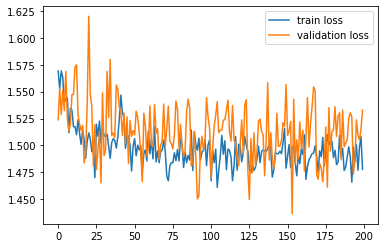

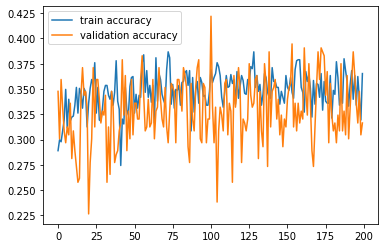

In [240]:
x = np.arange(total_epochs)
plt.plot(x,CSF_train_loss,label='train loss')
plt.plot(x,CSF_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,CSF_train_accuracy,label='train accuracy')
plt.plot(x,CSF_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(CSF_train_loss,CSF_validate_loss,CSF_train_accuracy,CSF_validate_accuracy))
frame.to_csv("CSF.csv")

In [241]:
del CS_MatchingNet
del CS_optimizer
del CS_scheduler
del dataC

# Start from scratch: miniImageNet

In [244]:
dataM = MiniImageNetNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

(100, 600, 84, 84, 3)


In [245]:
MS_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=False, image_size=84, use_cuda=True, model = 1)
MS_optimizer = torch.optim.Adam(MS_MatchingNet.parameters(), lr=1e-3)
MS_scheduler = ReduceLROnPlateau(MS_optimizer, 'min',verbose=True)
MSN_train_loss = []
MSN_train_accuracy = []
MSN_validate_loss = []
MSN_validate_accuracy = []

In [246]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataM,total_train_batches, MS_MatchingNet, MS_optimizer, use_cuda)
        MSN_train_loss.append(t_loss)
        MSN_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, MS_MatchingNet, MS_scheduler, use_cuda, True)
        MSN_validate_loss.append(v_loss)
        MSN_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

MSN_accuracy = MetaValidate(dataM,total_test_batches, MS_MatchingNet, MS_scheduler, use_cuda, False)
print('final test accuracy: {}'.format(MSN_accuracy))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.5594041887670755 train_accuracy:0.322265625


  0%|▍                                                                               | 1/200 [00:24<1:22:49, 24.97s/it]

Epoch 0: validate_loss:1.5597764179110527 validate_accuracy:0.29296875
Epoch 1: train_loss:1.5573802329599857 train_accuracy:0.3046875


  1%|▊                                                                               | 2/200 [00:49<1:22:07, 24.89s/it]

Epoch 1: validate_loss:1.5768931955099106 validate_accuracy:0.28515625
Epoch 2: train_loss:1.5702942609786987 train_accuracy:0.3046875


  2%|█▏                                                                              | 3/200 [01:14<1:21:32, 24.83s/it]

Epoch 2: validate_loss:1.552413895726204 validate_accuracy:0.28515625
Epoch 3: train_loss:1.5365827307105064 train_accuracy:0.333984375


  2%|█▌                                                                              | 4/200 [01:39<1:21:00, 24.80s/it]

Epoch 3: validate_loss:1.5712321996688843 validate_accuracy:0.26953125
Epoch 4: train_loss:1.5641060080379248 train_accuracy:0.2861328125


  2%|██                                                                              | 5/200 [02:03<1:20:32, 24.78s/it]

Epoch 4: validate_loss:1.5512694492936134 validate_accuracy:0.2890625
Epoch 5: train_loss:1.5476870015263557 train_accuracy:0.3154296875


  3%|██▍                                                                             | 6/200 [02:28<1:20:04, 24.77s/it]

Epoch 5: validate_loss:1.5865740403532982 validate_accuracy:0.26953125
Epoch 6: train_loss:1.5623041577637196 train_accuracy:0.294921875


  4%|██▊                                                                             | 7/200 [02:53<1:19:35, 24.74s/it]

Epoch 6: validate_loss:1.5599717870354652 validate_accuracy:0.28515625
Epoch 7: train_loss:1.5382350105792284 train_accuracy:0.3369140625


  4%|███▏                                                                            | 8/200 [03:17<1:19:08, 24.73s/it]

Epoch 7: validate_loss:1.5731234326958656 validate_accuracy:0.2734375
Epoch 8: train_loss:1.5317040160298347 train_accuracy:0.3369140625


  4%|███▌                                                                            | 9/200 [03:42<1:18:41, 24.72s/it]

Epoch 8: validate_loss:1.5847973003983498 validate_accuracy:0.27734375
Epoch 9: train_loss:1.5321472249925137 train_accuracy:0.32421875


  5%|███▉                                                                           | 10/200 [04:07<1:18:15, 24.71s/it]

Epoch 9: validate_loss:1.5971868634223938 validate_accuracy:0.2421875
Epoch 10: train_loss:1.545964004471898 train_accuracy:0.322265625


  6%|████▎                                                                          | 11/200 [04:32<1:17:50, 24.71s/it]

Epoch 10: validate_loss:1.573768749833107 validate_accuracy:0.26953125
Epoch 11: train_loss:1.5398253463208675 train_accuracy:0.34375


  6%|████▋                                                                          | 12/200 [04:56<1:17:27, 24.72s/it]

Epoch 11: validate_loss:1.4870872497558594 validate_accuracy:0.32421875
Epoch 12: train_loss:1.5251437090337276 train_accuracy:0.3310546875


  6%|█████▏                                                                         | 13/200 [05:21<1:17:04, 24.73s/it]

Epoch 12: validate_loss:1.5365324541926384 validate_accuracy:0.30078125
Epoch 13: train_loss:1.5247047990560532 train_accuracy:0.314453125


  7%|█████▌                                                                         | 14/200 [05:46<1:16:39, 24.73s/it]

Epoch 13: validate_loss:1.5148410126566887 validate_accuracy:0.33984375
Epoch 14: train_loss:1.5252697095274925 train_accuracy:0.333984375


  8%|█████▉                                                                         | 15/200 [06:10<1:16:13, 24.72s/it]

Epoch 14: validate_loss:1.5475404784083366 validate_accuracy:0.28125
Epoch 15: train_loss:1.5069336909800768 train_accuracy:0.353515625


  8%|██████▎                                                                        | 16/200 [06:35<1:15:48, 24.72s/it]

Epoch 15: validate_loss:1.548216737806797 validate_accuracy:0.29296875
Epoch 16: train_loss:1.5226965174078941 train_accuracy:0.3193359375


  8%|██████▋                                                                        | 17/200 [07:00<1:15:25, 24.73s/it]

Epoch 16: validate_loss:1.5296034663915634 validate_accuracy:0.28515625
Epoch 17: train_loss:1.5087872929871082 train_accuracy:0.3564453125


  9%|███████                                                                        | 18/200 [07:25<1:14:59, 24.72s/it]

Epoch 17: validate_loss:1.5400487780570984 validate_accuracy:0.32421875
Epoch 18: train_loss:1.5125490128993988 train_accuracy:0.3330078125


 10%|███████▌                                                                       | 19/200 [07:49<1:14:33, 24.72s/it]

Epoch 18: validate_loss:1.513238087296486 validate_accuracy:0.328125
Epoch 19: train_loss:1.5187839828431606 train_accuracy:0.3408203125


 10%|███████▉                                                                       | 20/200 [08:14<1:14:07, 24.71s/it]

Epoch 19: validate_loss:1.5599937215447426 validate_accuracy:0.2890625
Epoch 20: train_loss:1.5273096319288015 train_accuracy:0.3271484375


 10%|████████▎                                                                      | 21/200 [08:39<1:13:41, 24.70s/it]

Epoch 20: validate_loss:1.5388967618346214 validate_accuracy:0.29296875
Epoch 21: train_loss:1.5051448661834002 train_accuracy:0.3544921875


 11%|████████▋                                                                      | 22/200 [09:04<1:13:21, 24.73s/it]

Epoch 21: validate_loss:1.53928592056036 validate_accuracy:0.3203125
Epoch 22: train_loss:1.4899046383798122 train_accuracy:0.3720703125


 12%|█████████                                                                      | 23/200 [09:28<1:12:55, 24.72s/it]

Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch 22: validate_loss:1.537036694586277 validate_accuracy:0.30859375
Epoch 23: train_loss:1.509479833766818 train_accuracy:0.333984375


 12%|█████████▍                                                                     | 24/200 [09:53<1:12:35, 24.75s/it]

Epoch 23: validate_loss:1.4972911700606346 validate_accuracy:0.37890625
Epoch 24: train_loss:1.4795043300837278 train_accuracy:0.37890625


 12%|█████████▉                                                                     | 25/200 [10:18<1:12:17, 24.79s/it]

Epoch 24: validate_loss:1.5108851715922356 validate_accuracy:0.3515625
Epoch 25: train_loss:1.5029887203127146 train_accuracy:0.3720703125


 13%|██████████▎                                                                    | 26/200 [10:43<1:11:49, 24.77s/it]

Epoch 25: validate_loss:1.5272426307201385 validate_accuracy:0.30859375
Epoch 26: train_loss:1.4717301987111568 train_accuracy:0.3779296875


 14%|██████████▋                                                                    | 27/200 [11:07<1:11:26, 24.78s/it]

Epoch 26: validate_loss:1.5348358005285263 validate_accuracy:0.33203125
Epoch 27: train_loss:1.48142883554101 train_accuracy:0.37109375


 14%|███████████                                                                    | 28/200 [11:32<1:11:03, 24.79s/it]

Epoch 27: validate_loss:1.510054960846901 validate_accuracy:0.33203125
Epoch 28: train_loss:1.4669844787567854 train_accuracy:0.400390625


 14%|███████████▍                                                                   | 29/200 [11:57<1:10:38, 24.79s/it]

Epoch 28: validate_loss:1.5098498836159706 validate_accuracy:0.27734375
Epoch 29: train_loss:1.4537124149501324 train_accuracy:0.3837890625


 15%|███████████▊                                                                   | 30/200 [12:22<1:10:18, 24.81s/it]

Epoch 29: validate_loss:1.5360119342803955 validate_accuracy:0.32421875
Epoch 30: train_loss:1.4793837629258633 train_accuracy:0.38671875


 16%|████████████▏                                                                  | 31/200 [12:47<1:09:51, 24.80s/it]

Epoch 30: validate_loss:1.5305815190076828 validate_accuracy:0.328125
Epoch 31: train_loss:1.4485628567636013 train_accuracy:0.4072265625


 16%|████████████▋                                                                  | 32/200 [13:11<1:09:24, 24.79s/it]

Epoch 31: validate_loss:1.5068982765078545 validate_accuracy:0.3203125
Epoch 32: train_loss:1.471997693181038 train_accuracy:0.37890625


 16%|█████████████                                                                  | 33/200 [13:36<1:08:55, 24.77s/it]

Epoch 32: validate_loss:1.5449008271098137 validate_accuracy:0.3046875
Epoch 33: train_loss:1.4633696768432856 train_accuracy:0.4013671875


 17%|█████████████▍                                                                 | 34/200 [14:01<1:08:28, 24.75s/it]

Epoch    34: reducing learning rate of group 0 to 1.0000e-05.
Epoch 33: validate_loss:1.5183240696787834 validate_accuracy:0.3125
Epoch 34: train_loss:1.4631637167185545 train_accuracy:0.4013671875


 18%|█████████████▊                                                                 | 35/200 [14:26<1:08:02, 24.74s/it]

Epoch 34: validate_loss:1.488805964589119 validate_accuracy:0.35546875
Epoch 35: train_loss:1.4616062194108963 train_accuracy:0.369140625


 18%|██████████████▏                                                                | 36/200 [14:50<1:07:41, 24.77s/it]

Epoch 35: validate_loss:1.5677648335695267 validate_accuracy:0.26953125
Epoch 36: train_loss:1.468425203114748 train_accuracy:0.375


 18%|██████████████▌                                                                | 37/200 [15:15<1:07:20, 24.79s/it]

Epoch 36: validate_loss:1.5123108923435211 validate_accuracy:0.30078125
Epoch 37: train_loss:1.44684549421072 train_accuracy:0.4033203125


 19%|███████████████                                                                | 38/200 [15:40<1:06:55, 24.79s/it]

Epoch 37: validate_loss:1.5472897663712502 validate_accuracy:0.2890625
Epoch 38: train_loss:1.473503364250064 train_accuracy:0.4033203125


 20%|███████████████▍                                                               | 39/200 [16:05<1:06:28, 24.78s/it]

Epoch 38: validate_loss:1.4711565300822258 validate_accuracy:0.40234375
Epoch 39: train_loss:1.464958917349577 train_accuracy:0.41015625


 20%|███████████████▊                                                               | 40/200 [16:30<1:06:05, 24.79s/it]

Epoch 39: validate_loss:1.5009153485298157 validate_accuracy:0.3125
Epoch 40: train_loss:1.4656155873090029 train_accuracy:0.390625


 20%|████████████████▏                                                              | 41/200 [16:54<1:05:41, 24.79s/it]

Epoch 40: validate_loss:1.5063515901565552 validate_accuracy:0.32421875
Epoch 41: train_loss:1.4525212608277798 train_accuracy:0.4052734375


 21%|████████████████▌                                                              | 42/200 [17:19<1:05:16, 24.79s/it]

Epoch 41: validate_loss:1.512332133948803 validate_accuracy:0.34765625
Epoch 42: train_loss:1.4677302669733763 train_accuracy:0.4052734375


 22%|████████████████▉                                                              | 43/200 [17:44<1:04:50, 24.78s/it]

Epoch 42: validate_loss:1.5074388980865479 validate_accuracy:0.35546875
Epoch 43: train_loss:1.4479332938790321 train_accuracy:0.4091796875


 22%|█████████████████▍                                                             | 44/200 [18:09<1:04:26, 24.79s/it]

Epoch 43: validate_loss:1.5010288804769516 validate_accuracy:0.34765625
Epoch 44: train_loss:1.4524444602429867 train_accuracy:0.3916015625


 22%|█████████████████▊                                                             | 45/200 [18:33<1:03:58, 24.76s/it]

Epoch 44: validate_loss:1.5141322240233421 validate_accuracy:0.3125
Epoch 45: train_loss:1.4571048058569431 train_accuracy:0.3984375


 23%|██████████████████▏                                                            | 46/200 [18:58<1:03:32, 24.76s/it]

Epoch 45: validate_loss:1.5012067034840584 validate_accuracy:0.359375
Epoch 46: train_loss:1.4588237553834915 train_accuracy:0.390625


 24%|██████████████████▌                                                            | 47/200 [19:23<1:03:09, 24.77s/it]

Epoch 46: validate_loss:1.4585936293005943 validate_accuracy:0.40234375
Epoch 47: train_loss:1.4573700968176126 train_accuracy:0.3935546875


 24%|██████████████████▉                                                            | 48/200 [19:48<1:02:44, 24.77s/it]

Epoch 47: validate_loss:1.5172274112701416 validate_accuracy:0.34765625
Epoch 48: train_loss:1.463253028690815 train_accuracy:0.41015625


 24%|███████████████████▎                                                           | 49/200 [20:13<1:02:23, 24.79s/it]

Epoch 48: validate_loss:1.4914166405797005 validate_accuracy:0.32421875
Epoch 49: train_loss:1.4455636776983738 train_accuracy:0.4208984375


 25%|███████████████████▊                                                           | 50/200 [20:37<1:01:56, 24.77s/it]

Epoch 49: validate_loss:1.4985749050974846 validate_accuracy:0.3125
Epoch 50: train_loss:1.45805468223989 train_accuracy:0.41015625


 26%|████████████████████▏                                                          | 51/200 [21:02<1:01:31, 24.78s/it]

Epoch 50: validate_loss:1.5212482586503029 validate_accuracy:0.35546875
Epoch 51: train_loss:1.462993847206235 train_accuracy:0.388671875


 26%|████████████████████▌                                                          | 52/200 [21:27<1:01:05, 24.77s/it]

Epoch 51: validate_loss:1.550571359694004 validate_accuracy:0.3046875
Epoch 52: train_loss:1.4458442945033312 train_accuracy:0.3994140625


 26%|████████████████████▉                                                          | 53/200 [21:52<1:00:39, 24.76s/it]

Epoch 52: validate_loss:1.5447193831205368 validate_accuracy:0.32421875
Epoch 53: train_loss:1.4601156041026115 train_accuracy:0.39453125


 27%|█████████████████████▎                                                         | 54/200 [22:16<1:00:16, 24.77s/it]

Epoch 53: validate_loss:1.4898217543959618 validate_accuracy:0.3203125
Epoch 54: train_loss:1.4783817194402218 train_accuracy:0.38671875


 28%|██████████████████████▎                                                          | 55/200 [22:41<59:48, 24.75s/it]

Epoch 54: validate_loss:1.519086241722107 validate_accuracy:0.32421875
Epoch 55: train_loss:1.448333540931344 train_accuracy:0.3837890625


 28%|██████████████████████▋                                                          | 56/200 [23:06<59:24, 24.76s/it]

Epoch 55: validate_loss:1.5379310473799706 validate_accuracy:0.28125
Epoch 56: train_loss:1.4713244568556547 train_accuracy:0.3876953125


 28%|███████████████████████                                                          | 57/200 [23:31<59:02, 24.77s/it]

Epoch 56: validate_loss:1.4938788935542107 validate_accuracy:0.359375
Epoch 57: train_loss:1.469266438856721 train_accuracy:0.3701171875


 29%|███████████████████████▍                                                         | 58/200 [23:55<58:37, 24.77s/it]

Epoch    58: reducing learning rate of group 0 to 1.0000e-06.
Epoch 57: validate_loss:1.4943611472845078 validate_accuracy:0.37109375
Epoch 58: train_loss:1.467954944819212 train_accuracy:0.38671875


 30%|███████████████████████▉                                                         | 59/200 [24:20<58:11, 24.77s/it]

Epoch 58: validate_loss:1.4846893325448036 validate_accuracy:0.3828125
Epoch 59: train_loss:1.4603010956197977 train_accuracy:0.392578125


 30%|████████████████████████▎                                                        | 60/200 [24:45<57:46, 24.76s/it]

Epoch 59: validate_loss:1.5367162972688675 validate_accuracy:0.296875
Epoch 60: train_loss:1.4610717613250017 train_accuracy:0.3935546875


 30%|████████████████████████▋                                                        | 61/200 [25:10<57:19, 24.74s/it]

Epoch 60: validate_loss:1.5315038561820984 validate_accuracy:0.32421875
Epoch 61: train_loss:1.4746484328061342 train_accuracy:0.365234375


 31%|█████████████████████████                                                        | 62/200 [25:34<56:55, 24.75s/it]

Epoch 61: validate_loss:1.5264918357133865 validate_accuracy:0.2734375
Epoch 62: train_loss:1.4558552671223879 train_accuracy:0.4052734375


 32%|█████████████████████████▌                                                       | 63/200 [25:59<56:28, 24.74s/it]

Epoch 62: validate_loss:1.5279901027679443 validate_accuracy:0.3125
Epoch 63: train_loss:1.4509700816124678 train_accuracy:0.4189453125


 32%|█████████████████████████▉                                                       | 64/200 [26:24<56:03, 24.73s/it]

Epoch 63: validate_loss:1.5284097418189049 validate_accuracy:0.34375
Epoch 64: train_loss:1.4583133682608604 train_accuracy:0.396484375


 32%|██████████████████████████▎                                                      | 65/200 [26:49<55:37, 24.72s/it]

Epoch 64: validate_loss:1.5037745907902718 validate_accuracy:0.3515625
Epoch 65: train_loss:1.4729426354169846 train_accuracy:0.3681640625


 33%|██████████████████████████▋                                                      | 66/200 [27:13<55:12, 24.72s/it]

Epoch 65: validate_loss:1.5214620158076286 validate_accuracy:0.296875
Epoch 66: train_loss:1.4581059627234936 train_accuracy:0.4033203125


 34%|███████████████████████████▏                                                     | 67/200 [27:38<54:47, 24.72s/it]

Epoch 66: validate_loss:1.5289827212691307 validate_accuracy:0.33203125
Epoch 67: train_loss:1.4652231466025114 train_accuracy:0.408203125


 34%|███████████████████████████▌                                                     | 68/200 [28:03<54:21, 24.71s/it]

Epoch 67: validate_loss:1.5109920352697372 validate_accuracy:0.3515625
Epoch 68: train_loss:1.4449192304164171 train_accuracy:0.408203125


 34%|███████████████████████████▉                                                     | 69/200 [28:27<53:56, 24.71s/it]

Epoch    69: reducing learning rate of group 0 to 1.0000e-07.
Epoch 68: validate_loss:1.472142681479454 validate_accuracy:0.375
Epoch 69: train_loss:1.445828303694725 train_accuracy:0.4208984375


 35%|████████████████████████████▎                                                    | 70/200 [28:52<53:33, 24.72s/it]

Epoch 69: validate_loss:1.5055422261357307 validate_accuracy:0.35546875
Epoch 70: train_loss:1.4662385452538729 train_accuracy:0.392578125


 36%|████████████████████████████▊                                                    | 71/200 [29:17<53:09, 24.72s/it]

Epoch 70: validate_loss:1.5004007294774055 validate_accuracy:0.3671875
Epoch 71: train_loss:1.4863256253302097 train_accuracy:0.359375


 36%|█████████████████████████████▏                                                   | 72/200 [29:42<52:44, 24.72s/it]

Epoch 71: validate_loss:1.5414768308401108 validate_accuracy:0.28125
Epoch 72: train_loss:1.4633306916803122 train_accuracy:0.37109375


 36%|█████████████████████████████▌                                                   | 73/200 [30:06<52:20, 24.73s/it]

Epoch 72: validate_loss:1.477971076965332 validate_accuracy:0.3828125
Epoch 73: train_loss:1.4488711394369602 train_accuracy:0.404296875


 37%|█████████████████████████████▉                                                   | 74/200 [30:31<51:55, 24.72s/it]

Epoch 73: validate_loss:1.5559514909982681 validate_accuracy:0.30078125
Epoch 74: train_loss:1.452613815665245 train_accuracy:0.404296875


 38%|██████████████████████████████▍                                                  | 75/200 [30:56<51:29, 24.72s/it]

Epoch 74: validate_loss:1.5078604370355606 validate_accuracy:0.34765625
Epoch 75: train_loss:1.4584256242960691 train_accuracy:0.3994140625


 38%|██████████████████████████████▊                                                  | 76/200 [31:20<51:04, 24.71s/it]

Epoch 75: validate_loss:1.5305509269237518 validate_accuracy:0.31640625
Epoch 76: train_loss:1.4652892053127289 train_accuracy:0.400390625


 38%|███████████████████████████████▏                                                 | 77/200 [31:45<50:39, 24.71s/it]

Epoch 76: validate_loss:1.512151375412941 validate_accuracy:0.33203125
Epoch 77: train_loss:1.4682826530188322 train_accuracy:0.3759765625


 39%|███████████████████████████████▌                                                 | 78/200 [32:10<50:15, 24.71s/it]

Epoch 77: validate_loss:1.5049576982855797 validate_accuracy:0.3203125
Epoch 78: train_loss:1.4801033977419138 train_accuracy:0.3740234375


 40%|███████████████████████████████▉                                                 | 79/200 [32:35<49:50, 24.71s/it]

Epoch 78: validate_loss:1.527644395828247 validate_accuracy:0.31640625
Epoch 79: train_loss:1.4600436463952065 train_accuracy:0.41015625


 40%|████████████████████████████████▍                                                | 80/200 [32:59<49:25, 24.72s/it]

Epoch    80: reducing learning rate of group 0 to 1.0000e-08.
Epoch 79: validate_loss:1.5287049561738968 validate_accuracy:0.29296875
Epoch 80: train_loss:1.4639960918575525 train_accuracy:0.4072265625


 40%|████████████████████████████████▊                                                | 81/200 [33:24<49:03, 24.73s/it]

Epoch 80: validate_loss:1.5153484418988228 validate_accuracy:0.34375
Epoch 81: train_loss:1.4625436682254076 train_accuracy:0.41015625


 41%|█████████████████████████████████▏                                               | 82/200 [33:49<48:39, 24.74s/it]

Epoch 81: validate_loss:1.5119744166731834 validate_accuracy:0.35546875
Epoch 82: train_loss:1.459149582311511 train_accuracy:0.4140625


 42%|█████████████████████████████████▌                                               | 83/200 [34:14<48:14, 24.74s/it]

Epoch 82: validate_loss:1.497192069888115 validate_accuracy:0.3828125
Epoch 83: train_loss:1.456131299957633 train_accuracy:0.404296875


 42%|██████████████████████████████████                                               | 84/200 [34:38<47:49, 24.74s/it]

Epoch 83: validate_loss:1.5061124339699745 validate_accuracy:0.41015625
Epoch 84: train_loss:1.45026701875031 train_accuracy:0.40234375


 42%|██████████████████████████████████▍                                              | 85/200 [35:03<47:25, 24.74s/it]

Epoch 84: validate_loss:1.5179099291563034 validate_accuracy:0.30859375
Epoch 85: train_loss:1.4721895810216665 train_accuracy:0.376953125


 43%|██████████████████████████████████▊                                              | 86/200 [35:28<47:02, 24.76s/it]

Epoch 85: validate_loss:1.5066043511033058 validate_accuracy:0.33984375
Epoch 86: train_loss:1.458860233426094 train_accuracy:0.3818359375


 44%|███████████████████████████████████▏                                             | 87/200 [35:53<46:36, 24.75s/it]

Epoch 86: validate_loss:1.5101100131869316 validate_accuracy:0.375
Epoch 87: train_loss:1.4705838579684496 train_accuracy:0.392578125


 44%|███████████████████████████████████▋                                             | 88/200 [36:17<46:11, 24.74s/it]

Epoch 87: validate_loss:1.510122612118721 validate_accuracy:0.32421875
Epoch 88: train_loss:1.44347938708961 train_accuracy:0.4140625


 44%|████████████████████████████████████                                             | 89/200 [36:42<45:46, 24.74s/it]

Epoch 88: validate_loss:1.4832670837640762 validate_accuracy:0.3828125
Epoch 89: train_loss:1.4339349996298552 train_accuracy:0.41796875


 45%|████████████████████████████████████▍                                            | 90/200 [37:07<45:21, 24.74s/it]

Epoch 89: validate_loss:1.508508361876011 validate_accuracy:0.359375
Epoch 90: train_loss:1.4592413529753685 train_accuracy:0.38671875


 46%|████████████████████████████████████▊                                            | 91/200 [37:31<44:56, 24.74s/it]

Epoch 90: validate_loss:1.5327446311712265 validate_accuracy:0.30078125
Epoch 91: train_loss:1.4627803936600685 train_accuracy:0.3896484375


 46%|█████████████████████████████████████▎                                           | 92/200 [37:56<44:31, 24.74s/it]

Epoch 91: validate_loss:1.5556485652923584 validate_accuracy:0.2890625
Epoch 92: train_loss:1.4452659841626883 train_accuracy:0.421875


 46%|█████████████████████████████████████▋                                           | 93/200 [38:21<44:08, 24.75s/it]

Epoch 92: validate_loss:1.5309367328882217 validate_accuracy:0.3203125
Epoch 93: train_loss:1.474207691848278 train_accuracy:0.376953125


 47%|██████████████████████████████████████                                           | 94/200 [38:46<43:43, 24.75s/it]

Epoch 93: validate_loss:1.5229516252875328 validate_accuracy:0.3125
Epoch 94: train_loss:1.460707126185298 train_accuracy:0.4150390625


 48%|██████████████████████████████████████▍                                          | 95/200 [39:10<43:17, 24.74s/it]

Epoch 94: validate_loss:1.4917146638035774 validate_accuracy:0.36328125
Epoch 95: train_loss:1.4434428811073303 train_accuracy:0.4130859375


 48%|██████████████████████████████████████▉                                          | 96/200 [39:35<42:50, 24.72s/it]

Epoch 95: validate_loss:1.5080986469984055 validate_accuracy:0.34375
Epoch 96: train_loss:1.464806705713272 train_accuracy:0.404296875


 48%|███████████████████████████████████████▎                                         | 97/200 [40:00<42:24, 24.70s/it]

Epoch 96: validate_loss:1.485341913998127 validate_accuracy:0.359375
Epoch 97: train_loss:1.4596914406865835 train_accuracy:0.4072265625


 49%|███████████████████████████████████████▋                                         | 98/200 [40:25<42:00, 24.71s/it]

Epoch 97: validate_loss:1.5114828199148178 validate_accuracy:0.33203125
Epoch 98: train_loss:1.4664909318089485 train_accuracy:0.388671875


 50%|████████████████████████████████████████                                         | 99/200 [40:49<41:35, 24.71s/it]

Epoch 98: validate_loss:1.5356267392635345 validate_accuracy:0.29296875
Epoch 99: train_loss:1.4497226979583502 train_accuracy:0.4287109375


 50%|████████████████████████████████████████                                        | 100/200 [41:14<41:10, 24.71s/it]

Epoch 99: validate_loss:1.5218308418989182 validate_accuracy:0.3359375
Epoch 100: train_loss:1.4522036630660295 train_accuracy:0.4013671875


 50%|████████████████████████████████████████▍                                       | 101/200 [41:39<40:47, 24.72s/it]

Epoch 100: validate_loss:1.5578831061720848 validate_accuracy:0.3046875
Epoch 101: train_loss:1.4384943675249815 train_accuracy:0.4228515625


 51%|████████████████████████████████████████▊                                       | 102/200 [42:03<40:24, 24.74s/it]

Epoch 101: validate_loss:1.5100623220205307 validate_accuracy:0.375
Epoch 102: train_loss:1.4572686608880758 train_accuracy:0.4091796875


 52%|█████████████████████████████████████████▏                                      | 103/200 [42:28<40:00, 24.75s/it]

Epoch 102: validate_loss:1.5456351563334465 validate_accuracy:0.3046875
Epoch 103: train_loss:1.4686256479471922 train_accuracy:0.38671875


 52%|█████████████████████████████████████████▌                                      | 104/200 [42:53<39:35, 24.74s/it]

Epoch 103: validate_loss:1.5342839360237122 validate_accuracy:0.3515625
Epoch 104: train_loss:1.4587826691567898 train_accuracy:0.4091796875


 52%|██████████████████████████████████████████                                      | 105/200 [43:18<39:10, 24.75s/it]

Epoch 104: validate_loss:1.5454329922795296 validate_accuracy:0.2890625
Epoch 105: train_loss:1.460033591836691 train_accuracy:0.400390625


 53%|██████████████████████████████████████████▍                                     | 106/200 [43:42<38:45, 24.74s/it]

Epoch 105: validate_loss:1.4998732805252075 validate_accuracy:0.33984375
Epoch 106: train_loss:1.4650226086378098 train_accuracy:0.400390625


 54%|██████████████████████████████████████████▊                                     | 107/200 [44:07<38:21, 24.75s/it]

Epoch 106: validate_loss:1.5146052688360214 validate_accuracy:0.3125
Epoch 107: train_loss:1.458373798057437 train_accuracy:0.4091796875


 54%|███████████████████████████████████████████▏                                    | 108/200 [44:32<37:56, 24.74s/it]

Epoch 107: validate_loss:1.5270502269268036 validate_accuracy:0.32421875
Epoch 108: train_loss:1.4518727995455265 train_accuracy:0.4130859375


 55%|███████████████████████████████████████████▌                                    | 109/200 [44:57<37:30, 24.74s/it]

Epoch 108: validate_loss:1.4958728924393654 validate_accuracy:0.3203125
Epoch 109: train_loss:1.4544215239584446 train_accuracy:0.4150390625


 55%|████████████████████████████████████████████                                    | 110/200 [45:21<37:06, 24.74s/it]

Epoch 109: validate_loss:1.5222034752368927 validate_accuracy:0.3359375
Epoch 110: train_loss:1.463423041626811 train_accuracy:0.4111328125


 56%|████████████████████████████████████████████▍                                   | 111/200 [45:46<36:41, 24.74s/it]

Epoch 110: validate_loss:1.5308469161391258 validate_accuracy:0.32421875
Epoch 111: train_loss:1.4785644244402647 train_accuracy:0.384765625


 56%|████████████████████████████████████████████▊                                   | 112/200 [46:11<36:17, 24.75s/it]

Epoch 111: validate_loss:1.4871220737695694 validate_accuracy:0.3515625
Epoch 112: train_loss:1.4474067315459251 train_accuracy:0.4072265625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [46:36<35:52, 24.74s/it]

Epoch 112: validate_loss:1.4676617160439491 validate_accuracy:0.359375
Epoch 113: train_loss:1.4821871910244226 train_accuracy:0.3671875


 57%|█████████████████████████████████████████████▌                                  | 114/200 [47:00<35:29, 24.76s/it]

Epoch 113: validate_loss:1.5191104859113693 validate_accuracy:0.36328125
Epoch 114: train_loss:1.4500247556716204 train_accuracy:0.421875


 57%|██████████████████████████████████████████████                                  | 115/200 [47:25<35:04, 24.76s/it]

Epoch 114: validate_loss:1.5261504873633385 validate_accuracy:0.30078125
Epoch 115: train_loss:1.4627116806805134 train_accuracy:0.3837890625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [47:50<34:38, 24.74s/it]

Epoch 115: validate_loss:1.518423855304718 validate_accuracy:0.33984375
Epoch 116: train_loss:1.4594571143388748 train_accuracy:0.3876953125


 58%|██████████████████████████████████████████████▊                                 | 117/200 [48:15<34:12, 24.73s/it]

Epoch 116: validate_loss:1.5100601762533188 validate_accuracy:0.328125
Epoch 117: train_loss:1.460691073909402 train_accuracy:0.3974609375


 59%|███████████████████████████████████████████████▏                                | 118/200 [48:39<33:46, 24.71s/it]

Epoch 117: validate_loss:1.4994607642292976 validate_accuracy:0.328125
Epoch 118: train_loss:1.4498106632381678 train_accuracy:0.404296875


 60%|███████████████████████████████████████████████▌                                | 119/200 [49:04<33:21, 24.70s/it]

Epoch 118: validate_loss:1.5142901539802551 validate_accuracy:0.34765625
Epoch 119: train_loss:1.4545159805566072 train_accuracy:0.412109375


 60%|████████████████████████████████████████████████                                | 120/200 [49:29<32:56, 24.70s/it]

Epoch 119: validate_loss:1.5100073590874672 validate_accuracy:0.30859375
Epoch 120: train_loss:1.4712782092392445 train_accuracy:0.396484375


 60%|████████████████████████████████████████████████▍                               | 121/200 [49:53<32:30, 24.69s/it]

Epoch 120: validate_loss:1.5025641471147537 validate_accuracy:0.328125
Epoch 121: train_loss:1.4657539054751396 train_accuracy:0.3857421875


 61%|████████████████████████████████████████████████▊                               | 122/200 [50:18<32:07, 24.71s/it]

Epoch 121: validate_loss:1.5364690870046616 validate_accuracy:0.296875
Epoch 122: train_loss:1.4630382172763348 train_accuracy:0.39453125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [50:43<31:46, 24.76s/it]

Epoch 122: validate_loss:1.5586640760302544 validate_accuracy:0.2421875
Epoch 123: train_loss:1.468235608190298 train_accuracy:0.38671875


 62%|█████████████████████████████████████████████████▌                              | 124/200 [51:08<31:21, 24.76s/it]

Epoch 123: validate_loss:1.5066254138946533 validate_accuracy:0.36328125
Epoch 124: train_loss:1.4770051091909409 train_accuracy:0.365234375


 62%|██████████████████████████████████████████████████                              | 125/200 [51:33<30:57, 24.77s/it]

Epoch 124: validate_loss:1.5427452400326729 validate_accuracy:0.3359375
Epoch 125: train_loss:1.4482860192656517 train_accuracy:0.40625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [51:57<30:32, 24.76s/it]

Epoch 125: validate_loss:1.5003687664866447 validate_accuracy:0.3671875
Epoch 126: train_loss:1.4535425212234259 train_accuracy:0.3974609375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [52:22<30:07, 24.76s/it]

Epoch 126: validate_loss:1.525928609073162 validate_accuracy:0.3203125
Epoch 127: train_loss:1.462508786469698 train_accuracy:0.40625


 64%|███████████████████████████████████████████████████▏                            | 128/200 [52:47<29:41, 24.74s/it]

Epoch 127: validate_loss:1.5025356486439705 validate_accuracy:0.34375
Epoch 128: train_loss:1.4513881262391806 train_accuracy:0.396484375


 64%|███████████████████████████████████████████████████▌                            | 129/200 [53:11<29:15, 24.73s/it]

Epoch 128: validate_loss:1.4810377061367035 validate_accuracy:0.33984375
Epoch 129: train_loss:1.4564065225422382 train_accuracy:0.396484375


 65%|████████████████████████████████████████████████████                            | 130/200 [53:36<28:50, 24.72s/it]

Epoch 129: validate_loss:1.5422276854515076 validate_accuracy:0.30859375
Epoch 130: train_loss:1.4494584891945124 train_accuracy:0.412109375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [54:01<28:25, 24.71s/it]

Epoch 130: validate_loss:1.5051776841282845 validate_accuracy:0.3515625
Epoch 131: train_loss:1.461844515055418 train_accuracy:0.3837890625


 66%|████████████████████████████████████████████████████▊                           | 132/200 [54:26<28:00, 24.72s/it]

Epoch 131: validate_loss:1.5436301827430725 validate_accuracy:0.3203125
Epoch 132: train_loss:1.4651302881538868 train_accuracy:0.3974609375


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [54:50<27:36, 24.72s/it]

Epoch 132: validate_loss:1.4910480082035065 validate_accuracy:0.35546875
Epoch 133: train_loss:1.4663422759622335 train_accuracy:0.380859375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [55:15<27:13, 24.75s/it]

Epoch 133: validate_loss:1.5175242647528648 validate_accuracy:0.296875
Epoch 134: train_loss:1.4510173089802265 train_accuracy:0.412109375


 68%|██████████████████████████████████████████████████████                          | 135/200 [55:40<26:48, 24.74s/it]

Epoch 134: validate_loss:1.515072077512741 validate_accuracy:0.34375
Epoch 135: train_loss:1.463793920353055 train_accuracy:0.390625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [56:04<26:22, 24.73s/it]

Epoch 135: validate_loss:1.5447923392057419 validate_accuracy:0.265625
Epoch 136: train_loss:1.434717383235693 train_accuracy:0.4326171875


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [56:29<25:56, 24.71s/it]

Epoch 136: validate_loss:1.4984866455197334 validate_accuracy:0.34765625
Epoch 137: train_loss:1.4637553375214338 train_accuracy:0.4013671875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [56:54<25:31, 24.70s/it]

Epoch 137: validate_loss:1.4973206892609596 validate_accuracy:0.35546875
Epoch 138: train_loss:1.4394895788282156 train_accuracy:0.4228515625


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [57:19<25:06, 24.70s/it]

Epoch 138: validate_loss:1.5202247202396393 validate_accuracy:0.30859375
Epoch 139: train_loss:1.460611391812563 train_accuracy:0.408203125


 70%|████████████████████████████████████████████████████████                        | 140/200 [57:43<24:42, 24.70s/it]

Epoch 139: validate_loss:1.5064231604337692 validate_accuracy:0.3203125
Epoch 140: train_loss:1.4726535081863403 train_accuracy:0.3876953125


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [58:08<24:17, 24.71s/it]

Epoch 140: validate_loss:1.526759795844555 validate_accuracy:0.32421875
Epoch 141: train_loss:1.454881316050887 train_accuracy:0.380859375


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [58:33<23:54, 24.72s/it]

Epoch 141: validate_loss:1.4931844919919968 validate_accuracy:0.33203125
Epoch 142: train_loss:1.4638855773955584 train_accuracy:0.4033203125


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [58:57<23:29, 24.73s/it]

Epoch 142: validate_loss:1.5111319720745087 validate_accuracy:0.3515625
Epoch 143: train_loss:1.4554156828671694 train_accuracy:0.4111328125


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [59:22<23:05, 24.74s/it]

Epoch 143: validate_loss:1.5225267857313156 validate_accuracy:0.2734375
Epoch 144: train_loss:1.4487438686192036 train_accuracy:0.41015625


 72%|██████████████████████████████████████████████████████████                      | 145/200 [59:47<22:39, 24.72s/it]

Epoch 144: validate_loss:1.5203602612018585 validate_accuracy:0.328125
Epoch 145: train_loss:1.4543251041322947 train_accuracy:0.4150390625


 73%|████████████████████████████████████████████████████████▉                     | 146/200 [1:00:12<22:14, 24.72s/it]

Epoch 145: validate_loss:1.533878780901432 validate_accuracy:0.32421875
Epoch 146: train_loss:1.4642990101128817 train_accuracy:0.404296875


 74%|█████████████████████████████████████████████████████████▎                    | 147/200 [1:00:36<21:49, 24.72s/it]

Epoch 146: validate_loss:1.5456086993217468 validate_accuracy:0.328125
Epoch 147: train_loss:1.4650477338582277 train_accuracy:0.376953125


 74%|█████████████████████████████████████████████████████████▋                    | 148/200 [1:01:01<21:25, 24.72s/it]

Epoch 147: validate_loss:1.482716128230095 validate_accuracy:0.34765625
Epoch 148: train_loss:1.4525961223989725 train_accuracy:0.4091796875


 74%|██████████████████████████████████████████████████████████                    | 149/200 [1:01:26<21:00, 24.72s/it]

Epoch 148: validate_loss:1.5042394548654556 validate_accuracy:0.34375
Epoch 149: train_loss:1.454167852178216 train_accuracy:0.4052734375


 75%|██████████████████████████████████████████████████████████▌                   | 150/200 [1:01:50<20:35, 24.72s/it]

Epoch 149: validate_loss:1.5296962931752205 validate_accuracy:0.3125
Epoch 150: train_loss:1.4644392039626837 train_accuracy:0.3759765625


 76%|██████████████████████████████████████████████████████████▉                   | 151/200 [1:02:15<20:11, 24.72s/it]

Epoch 150: validate_loss:1.5021831393241882 validate_accuracy:0.35546875
Epoch 151: train_loss:1.4598012007772923 train_accuracy:0.396484375


 76%|███████████████████████████████████████████████████████████▎                  | 152/200 [1:02:40<19:46, 24.72s/it]

Epoch 151: validate_loss:1.5030974000692368 validate_accuracy:0.3515625
Epoch 152: train_loss:1.4556661136448383 train_accuracy:0.4150390625


 76%|███████████████████████████████████████████████████████████▋                  | 153/200 [1:03:05<19:21, 24.72s/it]

Epoch 152: validate_loss:1.535385601222515 validate_accuracy:0.31640625
Epoch 153: train_loss:1.4711240772157907 train_accuracy:0.3759765625


 77%|████████████████████████████████████████████████████████████                  | 154/200 [1:03:29<18:56, 24.71s/it]

Epoch 153: validate_loss:1.5024872869253159 validate_accuracy:0.375
Epoch 154: train_loss:1.4577774945646524 train_accuracy:0.39453125


 78%|████████████████████████████████████████████████████████████▍                 | 155/200 [1:03:54<18:32, 24.71s/it]

Epoch 154: validate_loss:1.5055943578481674 validate_accuracy:0.33203125
Epoch 155: train_loss:1.4548432752490044 train_accuracy:0.37890625


 78%|████████████████████████████████████████████████████████████▊                 | 156/200 [1:04:19<18:07, 24.71s/it]

Epoch 155: validate_loss:1.5173285827040672 validate_accuracy:0.3671875
Epoch 156: train_loss:1.4480579067021608 train_accuracy:0.4091796875


 78%|█████████████████████████████████████████████████████████████▏                | 157/200 [1:04:43<17:42, 24.72s/it]

Epoch 156: validate_loss:1.4634175598621368 validate_accuracy:0.390625
Epoch 157: train_loss:1.462460594251752 train_accuracy:0.3935546875


 79%|█████████████████████████████████████████████████████████████▌                | 158/200 [1:05:08<17:18, 24.72s/it]

Epoch 157: validate_loss:1.5215186700224876 validate_accuracy:0.33203125
Epoch 158: train_loss:1.4564965683966875 train_accuracy:0.400390625


 80%|██████████████████████████████████████████████████████████████                | 159/200 [1:05:33<16:53, 24.73s/it]

Epoch 158: validate_loss:1.547377422451973 validate_accuracy:0.296875
Epoch 159: train_loss:1.4645790457725525 train_accuracy:0.3916015625


 80%|██████████████████████████████████████████████████████████████▍               | 160/200 [1:05:58<16:29, 24.73s/it]

Epoch 159: validate_loss:1.512301504611969 validate_accuracy:0.33984375
Epoch 160: train_loss:1.4407910872250795 train_accuracy:0.4443359375


 80%|██████████████████████████████████████████████████████████████▊               | 161/200 [1:06:22<16:04, 24.72s/it]

Epoch 160: validate_loss:1.5186483785510063 validate_accuracy:0.296875
Epoch 161: train_loss:1.47164623811841 train_accuracy:0.3994140625


 81%|███████████████████████████████████████████████████████████████▏              | 162/200 [1:06:47<15:39, 24.72s/it]

Epoch 161: validate_loss:1.514344945549965 validate_accuracy:0.3203125
Epoch 162: train_loss:1.4556589256972075 train_accuracy:0.4111328125


 82%|███████████████████████████████████████████████████████████████▌              | 163/200 [1:07:12<15:14, 24.71s/it]

Epoch 162: validate_loss:1.5322162806987762 validate_accuracy:0.31640625
Epoch 163: train_loss:1.4411380849778652 train_accuracy:0.431640625


 82%|███████████████████████████████████████████████████████████████▉              | 164/200 [1:07:37<14:49, 24.71s/it]

Epoch 163: validate_loss:1.5068245828151703 validate_accuracy:0.32421875
Epoch 164: train_loss:1.4526052065193653 train_accuracy:0.419921875


 82%|████████████████████████████████████████████████████████████████▎             | 165/200 [1:08:01<14:25, 24.72s/it]

Epoch 164: validate_loss:1.513613983988762 validate_accuracy:0.328125
Epoch 165: train_loss:1.4561641998589039 train_accuracy:0.4052734375


 83%|████████████████████████████████████████████████████████████████▋             | 166/200 [1:08:26<14:00, 24.72s/it]

Epoch 165: validate_loss:1.4878232330083847 validate_accuracy:0.40234375
Epoch 166: train_loss:1.4746251590549946 train_accuracy:0.4013671875


 84%|█████████████████████████████████████████████████████████████████▏            | 167/200 [1:08:51<13:35, 24.73s/it]

Epoch 166: validate_loss:1.531465582549572 validate_accuracy:0.30078125
Epoch 167: train_loss:1.4662209302186966 train_accuracy:0.3779296875


 84%|█████████████████████████████████████████████████████████████████▌            | 168/200 [1:09:15<13:11, 24.73s/it]

Epoch 167: validate_loss:1.5111859366297722 validate_accuracy:0.33984375
Epoch 168: train_loss:1.4794329814612865 train_accuracy:0.36328125


 84%|█████████████████████████████████████████████████████████████████▉            | 169/200 [1:09:40<12:46, 24.73s/it]

Epoch 168: validate_loss:1.5119012370705605 validate_accuracy:0.35546875
Epoch 169: train_loss:1.4505606349557638 train_accuracy:0.4287109375


 85%|██████████████████████████████████████████████████████████████████▎           | 170/200 [1:10:05<12:22, 24.73s/it]

Epoch 169: validate_loss:1.522800326347351 validate_accuracy:0.32421875
Epoch 170: train_loss:1.4642484411597252 train_accuracy:0.384765625


 86%|██████████████████████████████████████████████████████████████████▋           | 171/200 [1:10:30<11:57, 24.73s/it]

Epoch 170: validate_loss:1.5126566737890244 validate_accuracy:0.37890625
Epoch 171: train_loss:1.4456190541386604 train_accuracy:0.41015625


 86%|███████████████████████████████████████████████████████████████████           | 172/200 [1:10:54<11:32, 24.73s/it]

Epoch 171: validate_loss:1.5027279406785965 validate_accuracy:0.33984375
Epoch 172: train_loss:1.4504417777061462 train_accuracy:0.4033203125


 86%|███████████████████████████████████████████████████████████████████▍          | 173/200 [1:11:19<11:08, 24.75s/it]

Epoch 172: validate_loss:1.462413303554058 validate_accuracy:0.42578125
Epoch 173: train_loss:1.459715612232685 train_accuracy:0.380859375


 87%|███████████████████████████████████████████████████████████████████▊          | 174/200 [1:11:44<10:43, 24.75s/it]

Epoch 173: validate_loss:1.4755964428186417 validate_accuracy:0.3984375
Epoch 174: train_loss:1.4750903025269508 train_accuracy:0.361328125


 88%|████████████████████████████████████████████████████████████████████▎         | 175/200 [1:12:09<10:19, 24.76s/it]

Epoch 174: validate_loss:1.5049412325024605 validate_accuracy:0.34375
Epoch 175: train_loss:1.4489597659558058 train_accuracy:0.4150390625


 88%|████████████████████████████████████████████████████████████████████▋         | 176/200 [1:12:33<09:54, 24.75s/it]

Epoch 175: validate_loss:1.5276964381337166 validate_accuracy:0.3125
Epoch 176: train_loss:1.463721277192235 train_accuracy:0.416015625


 88%|█████████████████████████████████████████████████████████████████████         | 177/200 [1:12:58<09:29, 24.76s/it]

Epoch 176: validate_loss:1.5019328743219376 validate_accuracy:0.359375
Epoch 177: train_loss:1.4527755118906498 train_accuracy:0.4091796875


 89%|█████████████████████████████████████████████████████████████████████▍        | 178/200 [1:13:23<09:04, 24.76s/it]

Epoch 177: validate_loss:1.5264466032385826 validate_accuracy:0.31640625
Epoch 178: train_loss:1.4483212232589722 train_accuracy:0.3798828125


 90%|█████████████████████████████████████████████████████████████████████▊        | 179/200 [1:13:48<08:40, 24.76s/it]

Epoch 178: validate_loss:1.505722999572754 validate_accuracy:0.34375
Epoch 179: train_loss:1.4511021804064512 train_accuracy:0.4306640625


 90%|██████████████████████████████████████████████████████████████████████▏       | 180/200 [1:14:13<08:15, 24.76s/it]

Epoch 179: validate_loss:1.502820923924446 validate_accuracy:0.375
Epoch 180: train_loss:1.4602506719529629 train_accuracy:0.37890625


 90%|██████████████████████████████████████████████████████████████████████▌       | 181/200 [1:14:37<07:50, 24.76s/it]

Epoch 180: validate_loss:1.5259190574288368 validate_accuracy:0.3515625
Epoch 181: train_loss:1.4663873296231031 train_accuracy:0.3837890625


 91%|██████████████████████████████████████████████████████████████████████▉       | 182/200 [1:15:02<07:25, 24.75s/it]

Epoch 181: validate_loss:1.5350566506385803 validate_accuracy:0.30078125
Epoch 182: train_loss:1.4528315756469965 train_accuracy:0.4169921875


 92%|███████████████████████████████████████████████████████████████████████▎      | 183/200 [1:15:27<07:00, 24.74s/it]

Epoch 182: validate_loss:1.5188138112425804 validate_accuracy:0.29296875
Epoch 183: train_loss:1.456367438659072 train_accuracy:0.408203125


 92%|███████████████████████████████████████████████████████████████████████▊      | 184/200 [1:15:51<06:35, 24.74s/it]

Epoch 183: validate_loss:1.501154400408268 validate_accuracy:0.36328125
Epoch 184: train_loss:1.4635149128735065 train_accuracy:0.3935546875


 92%|████████████████████████████████████████████████████████████████████████▏     | 185/200 [1:16:16<06:11, 24.74s/it]

Epoch 184: validate_loss:1.5167147889733315 validate_accuracy:0.2890625
Epoch 185: train_loss:1.436414336785674 train_accuracy:0.4296875


 93%|████████████████████████████████████████████████████████████████████████▌     | 186/200 [1:16:41<05:46, 24.74s/it]

Epoch 185: validate_loss:1.5116696581244469 validate_accuracy:0.3125
Epoch 186: train_loss:1.4492000322788954 train_accuracy:0.3798828125


 94%|████████████████████████████████████████████████████████████████████████▉     | 187/200 [1:17:06<05:21, 24.75s/it]

Epoch 186: validate_loss:1.5222986117005348 validate_accuracy:0.34375
Epoch 187: train_loss:1.4649450406432152 train_accuracy:0.3955078125


 94%|█████████████████████████████████████████████████████████████████████████▎    | 188/200 [1:17:30<04:57, 24.75s/it]

Epoch 187: validate_loss:1.5001707822084427 validate_accuracy:0.359375
Epoch 188: train_loss:1.459102613851428 train_accuracy:0.4169921875


 94%|█████████████████████████████████████████████████████████████████████████▋    | 189/200 [1:17:55<04:32, 24.74s/it]

Epoch 188: validate_loss:1.5034236088395119 validate_accuracy:0.34375
Epoch 189: train_loss:1.4469345808029175 train_accuracy:0.4033203125


 95%|██████████████████████████████████████████████████████████████████████████    | 190/200 [1:18:20<04:07, 24.75s/it]

Epoch 189: validate_loss:1.5430756509304047 validate_accuracy:0.3125
Epoch 190: train_loss:1.4566140249371529 train_accuracy:0.4013671875


 96%|██████████████████████████████████████████████████████████████████████████▍   | 191/200 [1:18:45<03:42, 24.73s/it]

Epoch 190: validate_loss:1.5266674607992172 validate_accuracy:0.328125
Epoch 191: train_loss:1.4559853952378035 train_accuracy:0.3994140625


 96%|██████████████████████████████████████████████████████████████████████████▉   | 192/200 [1:19:09<03:17, 24.73s/it]

Epoch 191: validate_loss:1.5161801055073738 validate_accuracy:0.32421875
Epoch 192: train_loss:1.4451839048415422 train_accuracy:0.4033203125


 96%|███████████████████████████████████████████████████████████████████████████▎  | 193/200 [1:19:34<02:53, 24.72s/it]

Epoch 192: validate_loss:1.5141749903559685 validate_accuracy:0.31640625
Epoch 193: train_loss:1.4701076913625002 train_accuracy:0.373046875


 97%|███████████████████████████████████████████████████████████████████████████▋  | 194/200 [1:19:59<02:28, 24.72s/it]

Epoch 193: validate_loss:1.5170595049858093 validate_accuracy:0.3515625
Epoch 194: train_loss:1.464540435001254 train_accuracy:0.388671875


 98%|████████████████████████████████████████████████████████████████████████████  | 195/200 [1:20:23<02:03, 24.72s/it]

Epoch 194: validate_loss:1.5176471695303917 validate_accuracy:0.3046875
Epoch 195: train_loss:1.444657688960433 train_accuracy:0.4267578125


 98%|████████████████████████████████████████████████████████████████████████████▍ | 196/200 [1:20:48<01:38, 24.71s/it]

Epoch 195: validate_loss:1.504843220114708 validate_accuracy:0.328125
Epoch 196: train_loss:1.4451725240796804 train_accuracy:0.40625


 98%|████████████████████████████████████████████████████████████████████████████▊ | 197/200 [1:21:13<01:14, 24.71s/it]

Epoch 196: validate_loss:1.5423896685242653 validate_accuracy:0.296875
Epoch 197: train_loss:1.487746775150299 train_accuracy:0.365234375


 99%|█████████████████████████████████████████████████████████████████████████████▏| 198/200 [1:21:38<00:49, 24.72s/it]

Epoch 197: validate_loss:1.4813967496156693 validate_accuracy:0.37109375
Epoch 198: train_loss:1.4468503575772047 train_accuracy:0.423828125


100%|█████████████████████████████████████████████████████████████████████████████▌| 199/200 [1:22:02<00:24, 24.73s/it]

Epoch 198: validate_loss:1.5426634550094604 validate_accuracy:0.30859375
Epoch 199: train_loss:1.4595794323831797 train_accuracy:0.408203125


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:22:27<00:00, 24.74s/it]

Epoch 199: validate_loss:1.492210365831852 validate_accuracy:0.3828125


final test accuracy: (1.522646851837635, 0.328125)


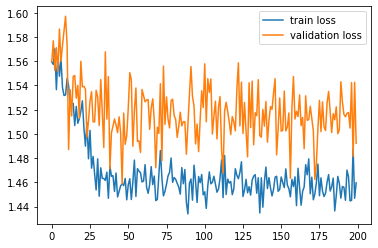

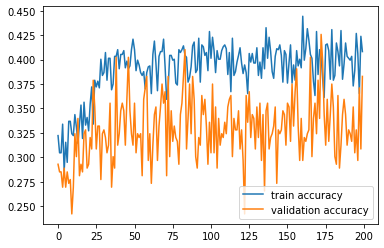

In [247]:
x = np.arange(total_epochs)
plt.plot(x,MSN_train_loss,label='train loss')
plt.plot(x,MSN_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,MSN_train_accuracy,label='train accuracy')
plt.plot(x,MSN_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(MSN_train_loss,MSN_train_accuracy,MSN_validate_loss,MSN_validate_accuracy))
frame.to_csv("MSN.csv")

In [248]:
del MS_MatchingNet
del MS_optimizer
del MS_scheduler

In [249]:
MS_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=True, image_size=84, use_cuda=True, model = 1)
MS_optimizer = torch.optim.Adam(MS_MatchingNet.parameters(), lr=1e-3)
MS_scheduler = ReduceLROnPlateau(MS_optimizer, 'min',verbose=True)
MSF_train_loss = []
MSF_train_accuracy = []
MSF_validate_loss = []
MSF_validate_accuracy = []

In [250]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataM,total_train_batches, MS_MatchingNet, MS_optimizer, use_cuda)
        MSF_train_loss.append(t_loss)
        MSF_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, MS_MatchingNet, MS_scheduler, use_cuda, True)
        MSF_validate_loss.append(v_loss)
        MSF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

MSF_accuracy = MetaValidate(dataM,total_test_batches, MS_MatchingNet, MS_scheduler, use_cuda, False)
print('final test accuracy: {}'.format(MSF_accuracy))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.5576779730618 train_accuracy:0.3154296875


  0%|▍                                                                               | 1/200 [00:25<1:25:36, 25.81s/it]

Epoch 0: validate_loss:1.554784819483757 validate_accuracy:0.3125
Epoch 1: train_loss:1.564280953258276 train_accuracy:0.2939453125


  1%|▊                                                                               | 2/200 [00:51<1:25:09, 25.81s/it]

Epoch 1: validate_loss:1.558392196893692 validate_accuracy:0.31640625
Epoch 2: train_loss:1.5583330634981394 train_accuracy:0.30078125


  2%|█▏                                                                              | 3/200 [01:17<1:24:44, 25.81s/it]

Epoch 2: validate_loss:1.6097870469093323 validate_accuracy:0.26171875
Epoch 3: train_loss:1.5538317672908306 train_accuracy:0.3203125


  2%|█▌                                                                              | 4/200 [01:43<1:24:17, 25.80s/it]

Epoch 3: validate_loss:1.554317682981491 validate_accuracy:0.2890625
Epoch 4: train_loss:1.5690703596919775 train_accuracy:0.2880859375


  2%|██                                                                              | 5/200 [02:08<1:23:47, 25.78s/it]

Epoch 4: validate_loss:1.58614119887352 validate_accuracy:0.2578125
Epoch 5: train_loss:1.5577019453048706 train_accuracy:0.2861328125


  3%|██▍                                                                             | 6/200 [02:34<1:23:21, 25.78s/it]

Epoch 5: validate_loss:1.609071671962738 validate_accuracy:0.2578125
Epoch 6: train_loss:1.5445730611681938 train_accuracy:0.302734375


  4%|██▊                                                                             | 7/200 [03:00<1:22:56, 25.78s/it]

Epoch 6: validate_loss:1.5740678906440735 validate_accuracy:0.23828125
Epoch 7: train_loss:1.5342857632786036 train_accuracy:0.3212890625


  4%|███▏                                                                            | 8/200 [03:26<1:22:29, 25.78s/it]

Epoch 7: validate_loss:1.5563993901014328 validate_accuracy:0.296875
Epoch 8: train_loss:1.542135775089264 train_accuracy:0.3115234375


  4%|███▌                                                                            | 9/200 [03:51<1:21:59, 25.76s/it]

Epoch 8: validate_loss:1.537836693227291 validate_accuracy:0.3125
Epoch 9: train_loss:1.5464641954749823 train_accuracy:0.314453125


  5%|███▉                                                                           | 10/200 [04:17<1:21:31, 25.75s/it]

Epoch 9: validate_loss:1.5613941475749016 validate_accuracy:0.25
Epoch 10: train_loss:1.5404420737177134 train_accuracy:0.3232421875


  6%|████▎                                                                          | 11/200 [04:43<1:21:34, 25.90s/it]

Epoch 10: validate_loss:1.5417114049196243 validate_accuracy:0.29296875
Epoch 11: train_loss:1.5406613778322935 train_accuracy:0.3193359375


  6%|████▋                                                                          | 12/200 [05:09<1:21:03, 25.87s/it]

Epoch 11: validate_loss:1.5792766064405441 validate_accuracy:0.28125
Epoch 12: train_loss:1.5287398602813482 train_accuracy:0.314453125


  6%|█████▏                                                                         | 13/200 [05:35<1:20:39, 25.88s/it]

Epoch 12: validate_loss:1.5236839205026627 validate_accuracy:0.359375
Epoch 13: train_loss:1.543229965493083 train_accuracy:0.3251953125


  7%|█████▌                                                                         | 14/200 [06:01<1:20:12, 25.87s/it]

Epoch 13: validate_loss:1.5628333240747452 validate_accuracy:0.27734375
Epoch 14: train_loss:1.524306695908308 train_accuracy:0.3310546875


  8%|█████▉                                                                         | 15/200 [06:27<1:19:42, 25.85s/it]

Epoch 14: validate_loss:1.537946566939354 validate_accuracy:0.3125
Epoch 15: train_loss:1.508351119235158 train_accuracy:0.353515625


  8%|██████▎                                                                        | 16/200 [06:53<1:19:11, 25.83s/it]

Epoch 15: validate_loss:1.5752167776226997 validate_accuracy:0.29296875
Epoch 16: train_loss:1.5362187642604113 train_accuracy:0.2998046875


  8%|██████▋                                                                        | 17/200 [07:18<1:18:40, 25.80s/it]

Epoch 16: validate_loss:1.5368631184101105 validate_accuracy:0.31640625
Epoch 17: train_loss:1.5258051846176386 train_accuracy:0.3076171875


  9%|███████                                                                        | 18/200 [07:44<1:18:14, 25.79s/it]

Epoch 17: validate_loss:1.5586670711636543 validate_accuracy:0.30078125
Epoch 18: train_loss:1.5317619517445564 train_accuracy:0.314453125


 10%|███████▌                                                                       | 19/200 [08:10<1:17:45, 25.78s/it]

Epoch 18: validate_loss:1.571143038570881 validate_accuracy:0.2890625
Epoch 19: train_loss:1.5253706853836775 train_accuracy:0.33984375


 10%|███████▉                                                                       | 20/200 [08:36<1:17:20, 25.78s/it]

Epoch 19: validate_loss:1.514621615409851 validate_accuracy:0.359375
Epoch 20: train_loss:1.5169895477592945 train_accuracy:0.3408203125


 10%|████████▎                                                                      | 21/200 [09:01<1:16:50, 25.76s/it]

Epoch 20: validate_loss:1.5378388464450836 validate_accuracy:0.3125
Epoch 21: train_loss:1.5437369998544455 train_accuracy:0.314453125


 11%|████████▋                                                                      | 22/200 [09:27<1:16:23, 25.75s/it]

Epoch 21: validate_loss:1.5723131150007248 validate_accuracy:0.3125
Epoch 22: train_loss:1.5075059439986944 train_accuracy:0.349609375


 12%|█████████                                                                      | 23/200 [09:53<1:15:57, 25.75s/it]

Epoch 22: validate_loss:1.532165989279747 validate_accuracy:0.3203125
Epoch 23: train_loss:1.4950192756950855 train_accuracy:0.3603515625


 12%|█████████▍                                                                     | 24/200 [10:19<1:15:33, 25.76s/it]

Epoch 23: validate_loss:1.5473739579319954 validate_accuracy:0.3046875
Epoch 24: train_loss:1.5205681826919317 train_accuracy:0.3388671875


 12%|█████████▉                                                                     | 25/200 [10:44<1:15:14, 25.80s/it]

Epoch 24: validate_loss:1.6311076655983925 validate_accuracy:0.29296875
Epoch 25: train_loss:1.5383317526429892 train_accuracy:0.3056640625


 13%|██████████▎                                                                    | 26/200 [11:10<1:14:49, 25.80s/it]

Epoch 25: validate_loss:1.5482973456382751 validate_accuracy:0.296875
Epoch 26: train_loss:1.542078735306859 train_accuracy:0.3251953125


 14%|██████████▋                                                                    | 27/200 [11:36<1:14:29, 25.84s/it]

Epoch 26: validate_loss:1.5808803290128708 validate_accuracy:0.27734375
Epoch 27: train_loss:1.5379600953310728 train_accuracy:0.3203125


 14%|███████████                                                                    | 28/200 [12:02<1:14:05, 25.85s/it]

Epoch 27: validate_loss:1.5293035730719566 validate_accuracy:0.3828125
Epoch 28: train_loss:1.5250399056822062 train_accuracy:0.322265625


 14%|███████████▍                                                                   | 29/200 [12:28<1:13:35, 25.82s/it]

Epoch 28: validate_loss:1.5833398401737213 validate_accuracy:0.27734375
Epoch 29: train_loss:1.5466874446719885 train_accuracy:0.294921875


 15%|███████████▊                                                                   | 30/200 [12:54<1:13:08, 25.82s/it]

Epoch 29: validate_loss:1.5456357151269913 validate_accuracy:0.31640625
Epoch 30: train_loss:1.5364361386746168 train_accuracy:0.3251953125


 16%|████████████▏                                                                  | 31/200 [13:19<1:12:39, 25.80s/it]

Epoch    31: reducing learning rate of group 0 to 1.0000e-04.
Epoch 30: validate_loss:1.5237178355455399 validate_accuracy:0.328125
Epoch 31: train_loss:1.5219935774803162 train_accuracy:0.3212890625


 16%|████████████▋                                                                  | 32/200 [13:45<1:12:13, 25.80s/it]

Epoch 31: validate_loss:1.574519857764244 validate_accuracy:0.2578125
Epoch 32: train_loss:1.5090615712106228 train_accuracy:0.3505859375


 16%|█████████████                                                                  | 33/200 [14:11<1:11:50, 25.81s/it]

Epoch 32: validate_loss:1.5389704331755638 validate_accuracy:0.3046875
Epoch 33: train_loss:1.5082391370087862 train_accuracy:0.341796875


 17%|█████████████▍                                                                 | 34/200 [14:37<1:11:22, 25.80s/it]

Epoch 33: validate_loss:1.5327301919460297 validate_accuracy:0.3125
Epoch 34: train_loss:1.5088981240987778 train_accuracy:0.3623046875


 18%|█████████████▊                                                                 | 35/200 [15:03<1:10:55, 25.79s/it]

Epoch 34: validate_loss:1.5361021161079407 validate_accuracy:0.3359375
Epoch 35: train_loss:1.4991260264068842 train_accuracy:0.3837890625


 18%|██████████████▏                                                                | 36/200 [15:28<1:10:29, 25.79s/it]

Epoch 35: validate_loss:1.5349203646183014 validate_accuracy:0.3203125
Epoch 36: train_loss:1.4992623459547758 train_accuracy:0.3583984375


 18%|██████████████▌                                                                | 37/200 [15:54<1:10:01, 25.78s/it]

Epoch 36: validate_loss:1.5327256843447685 validate_accuracy:0.33203125
Epoch 37: train_loss:1.4906366039067507 train_accuracy:0.384765625


 19%|███████████████                                                                | 38/200 [16:20<1:09:33, 25.76s/it]

Epoch 37: validate_loss:1.5296591371297836 validate_accuracy:0.31640625
Epoch 38: train_loss:1.4934740420430899 train_accuracy:0.3671875


 20%|███████████████▍                                                               | 39/200 [16:46<1:09:10, 25.78s/it]

Epoch 38: validate_loss:1.5081597715616226 validate_accuracy:0.3203125
Epoch 39: train_loss:1.4935773871839046 train_accuracy:0.3564453125


 20%|███████████████▊                                                               | 40/200 [17:11<1:08:44, 25.78s/it]

Epoch 39: validate_loss:1.53654695302248 validate_accuracy:0.26171875
Epoch 40: train_loss:1.5033410247415304 train_accuracy:0.3623046875


 20%|████████████████▏                                                              | 41/200 [17:37<1:08:18, 25.78s/it]

Epoch 40: validate_loss:1.51068913936615 validate_accuracy:0.36328125
Epoch 41: train_loss:1.5025144312530756 train_accuracy:0.3642578125


 21%|████████████████▌                                                              | 42/200 [18:03<1:07:54, 25.79s/it]

Epoch 41: validate_loss:1.538073018193245 validate_accuracy:0.3125
Epoch 42: train_loss:1.4822424575686455 train_accuracy:0.3759765625


 22%|████████████████▉                                                              | 43/200 [18:29<1:07:29, 25.79s/it]

Epoch 42: validate_loss:1.517706237733364 validate_accuracy:0.32421875
Epoch 43: train_loss:1.4899684432893991 train_accuracy:0.3603515625


 22%|█████████████████▍                                                             | 44/200 [18:55<1:07:02, 25.79s/it]

Epoch 43: validate_loss:1.5018679797649384 validate_accuracy:0.3359375
Epoch 44: train_loss:1.4991740174591541 train_accuracy:0.3427734375


 22%|█████████████████▊                                                             | 45/200 [19:20<1:06:38, 25.80s/it]

Epoch 44: validate_loss:1.525686390697956 validate_accuracy:0.2734375
Epoch 45: train_loss:1.514605825766921 train_accuracy:0.3349609375


 23%|██████████████████▏                                                            | 46/200 [19:46<1:06:14, 25.81s/it]

Epoch 45: validate_loss:1.5176998525857925 validate_accuracy:0.328125
Epoch 46: train_loss:1.4844097755849361 train_accuracy:0.369140625


 24%|██████████████████▌                                                            | 47/200 [20:12<1:05:51, 25.83s/it]

Epoch 46: validate_loss:1.518230840563774 validate_accuracy:0.30859375
Epoch 47: train_loss:1.5122282691299915 train_accuracy:0.345703125


 24%|██████████████████▉                                                            | 48/200 [20:38<1:05:23, 25.82s/it]

Epoch 47: validate_loss:1.5549510270357132 validate_accuracy:0.26953125
Epoch 48: train_loss:1.5054134856909513 train_accuracy:0.349609375


 24%|███████████████████▎                                                           | 49/200 [21:04<1:04:58, 25.81s/it]

Epoch 48: validate_loss:1.5152005180716515 validate_accuracy:0.328125
Epoch 49: train_loss:1.4966179355978966 train_accuracy:0.3564453125


 25%|███████████████████▊                                                           | 50/200 [21:30<1:04:32, 25.82s/it]

Epoch 49: validate_loss:1.535288006067276 validate_accuracy:0.34375
Epoch 50: train_loss:1.4937912710011005 train_accuracy:0.36328125


 26%|████████████████████▏                                                          | 51/200 [21:55<1:04:05, 25.81s/it]

Epoch 50: validate_loss:1.5496124178171158 validate_accuracy:0.3203125
Epoch 51: train_loss:1.48036371730268 train_accuracy:0.37890625


 26%|████████████████████▌                                                          | 52/200 [22:21<1:03:37, 25.79s/it]

Epoch 51: validate_loss:1.5349179431796074 validate_accuracy:0.3125
Epoch 52: train_loss:1.487117227166891 train_accuracy:0.37890625


 26%|████████████████████▉                                                          | 53/200 [22:47<1:03:11, 25.79s/it]

Epoch 52: validate_loss:1.540466085076332 validate_accuracy:0.3359375
Epoch 53: train_loss:1.4950459953397512 train_accuracy:0.365234375


 27%|█████████████████████▎                                                         | 54/200 [23:13<1:02:44, 25.79s/it]

Epoch 53: validate_loss:1.5019963011145592 validate_accuracy:0.328125
Epoch 54: train_loss:1.4968728423118591 train_accuracy:0.380859375


 28%|█████████████████████▋                                                         | 55/200 [23:39<1:02:23, 25.81s/it]

Epoch    55: reducing learning rate of group 0 to 1.0000e-05.
Epoch 54: validate_loss:1.5114346221089363 validate_accuracy:0.33203125
Epoch 55: train_loss:1.5082771740853786 train_accuracy:0.36328125


 28%|██████████████████████                                                         | 56/200 [24:04<1:01:56, 25.81s/it]

Epoch 55: validate_loss:1.5416752323508263 validate_accuracy:0.29296875
Epoch 56: train_loss:1.4782624207437038 train_accuracy:0.37890625


 28%|██████████████████████▌                                                        | 57/200 [24:30<1:01:29, 25.80s/it]

Epoch 56: validate_loss:1.5066570118069649 validate_accuracy:0.3515625
Epoch 57: train_loss:1.4987909905612469 train_accuracy:0.3681640625


 29%|██████████████████████▉                                                        | 58/200 [24:56<1:01:01, 25.78s/it]

Epoch 57: validate_loss:1.50094985216856 validate_accuracy:0.36328125
Epoch 58: train_loss:1.5028733853250742 train_accuracy:0.3720703125


 30%|███████████████████████▎                                                       | 59/200 [25:22<1:00:34, 25.77s/it]

Epoch 58: validate_loss:1.535080924630165 validate_accuracy:0.28515625
Epoch 59: train_loss:1.502310736104846 train_accuracy:0.3447265625


 30%|███████████████████████▋                                                       | 60/200 [25:47<1:00:05, 25.75s/it]

Epoch 59: validate_loss:1.5301249846816063 validate_accuracy:0.29296875
Epoch 60: train_loss:1.4907926116138697 train_accuracy:0.349609375


 30%|████████████████████████▋                                                        | 61/200 [26:13<59:38, 25.74s/it]

Epoch 60: validate_loss:1.52643633633852 validate_accuracy:0.37109375
Epoch 61: train_loss:1.5075783990323544 train_accuracy:0.349609375


 31%|█████████████████████████                                                        | 62/200 [26:39<59:11, 25.74s/it]

Epoch 61: validate_loss:1.5383519306778908 validate_accuracy:0.3125
Epoch 62: train_loss:1.4770954139530659 train_accuracy:0.3837890625


 32%|█████████████████████████▌                                                       | 63/200 [27:05<58:46, 25.74s/it]

Epoch 62: validate_loss:1.4790884926915169 validate_accuracy:0.3515625
Epoch 63: train_loss:1.4921148475259542 train_accuracy:0.376953125


 32%|█████████████████████████▉                                                       | 64/200 [27:30<58:19, 25.73s/it]

Epoch 63: validate_loss:1.5486754849553108 validate_accuracy:0.30078125
Epoch 64: train_loss:1.4896463248878717 train_accuracy:0.357421875


 32%|██████████████████████████▎                                                      | 65/200 [27:56<57:56, 25.75s/it]

Epoch 64: validate_loss:1.5479827225208282 validate_accuracy:0.30078125
Epoch 65: train_loss:1.4824947118759155 train_accuracy:0.3681640625


 33%|██████████████████████████▋                                                      | 66/200 [28:22<57:31, 25.76s/it]

Epoch 65: validate_loss:1.5419366210699081 validate_accuracy:0.3125
Epoch 66: train_loss:1.478864861652255 train_accuracy:0.380859375


 34%|███████████████████████████▏                                                     | 67/200 [28:48<57:06, 25.76s/it]

Epoch 66: validate_loss:1.5089103430509567 validate_accuracy:0.33203125
Epoch 67: train_loss:1.4677696824073792 train_accuracy:0.40625


 34%|███████████████████████████▌                                                     | 68/200 [29:13<56:40, 25.76s/it]

Epoch 67: validate_loss:1.507532276213169 validate_accuracy:0.36328125
Epoch 68: train_loss:1.5110416412353516 train_accuracy:0.345703125


 34%|███████████████████████████▉                                                     | 69/200 [29:39<56:15, 25.77s/it]

Epoch 68: validate_loss:1.5307600870728493 validate_accuracy:0.3515625
Epoch 69: train_loss:1.4679553117603064 train_accuracy:0.3828125


 35%|████████████████████████████▎                                                    | 70/200 [30:05<55:47, 25.75s/it]

Epoch 69: validate_loss:1.5362582579255104 validate_accuracy:0.3125
Epoch 70: train_loss:1.494321582838893 train_accuracy:0.3525390625


 36%|████████████████████████████▊                                                    | 71/200 [30:31<55:19, 25.73s/it]

Epoch 70: validate_loss:1.5790346413850784 validate_accuracy:0.2734375
Epoch 71: train_loss:1.4742780774831772 train_accuracy:0.3876953125


 36%|█████████████████████████████▏                                                   | 72/200 [30:56<54:54, 25.74s/it]

Epoch 71: validate_loss:1.5427673906087875 validate_accuracy:0.3203125
Epoch 72: train_loss:1.495534149929881 train_accuracy:0.3740234375


 36%|█████████████████████████████▌                                                   | 73/200 [31:22<54:27, 25.73s/it]

Epoch 72: validate_loss:1.533483199775219 validate_accuracy:0.30859375
Epoch 73: train_loss:1.4942905455827713 train_accuracy:0.3505859375


 37%|█████████████████████████████▉                                                   | 74/200 [31:48<54:01, 25.73s/it]

Epoch    74: reducing learning rate of group 0 to 1.0000e-06.
Epoch 73: validate_loss:1.527397707104683 validate_accuracy:0.34375
Epoch 74: train_loss:1.4902381300926208 train_accuracy:0.37109375


 38%|██████████████████████████████▍                                                  | 75/200 [32:13<53:36, 25.74s/it]

Epoch 74: validate_loss:1.5533171594142914 validate_accuracy:0.31640625
Epoch 75: train_loss:1.4720539655536413 train_accuracy:0.3740234375


 38%|██████████████████████████████▊                                                  | 76/200 [32:39<53:14, 25.76s/it]

Epoch 75: validate_loss:1.494523212313652 validate_accuracy:0.33203125
Epoch 76: train_loss:1.4878990557044744 train_accuracy:0.3955078125


 38%|███████████████████████████████▏                                                 | 77/200 [33:05<52:49, 25.77s/it]

Epoch 76: validate_loss:1.5498784556984901 validate_accuracy:0.3125
Epoch 77: train_loss:1.4808059446513653 train_accuracy:0.36328125


 39%|███████████████████████████████▌                                                 | 78/200 [33:31<52:22, 25.76s/it]

Epoch 77: validate_loss:1.550064168870449 validate_accuracy:0.3125
Epoch 78: train_loss:1.4798276536166668 train_accuracy:0.3828125


 40%|███████████████████████████████▉                                                 | 79/200 [33:57<51:56, 25.76s/it]

Epoch 78: validate_loss:1.5377655550837517 validate_accuracy:0.29296875
Epoch 79: train_loss:1.5052055399864912 train_accuracy:0.3603515625


 40%|████████████████████████████████▍                                                | 80/200 [34:22<51:31, 25.76s/it]

Epoch 79: validate_loss:1.542825311422348 validate_accuracy:0.3046875
Epoch 80: train_loss:1.4964602068066597 train_accuracy:0.3486328125


 40%|████████████████████████████████▊                                                | 81/200 [34:48<51:07, 25.78s/it]

Epoch 80: validate_loss:1.4897620305418968 validate_accuracy:0.35546875
Epoch 81: train_loss:1.4923735205084085 train_accuracy:0.37890625


 41%|█████████████████████████████████▏                                               | 82/200 [35:14<50:39, 25.76s/it]

Epoch 81: validate_loss:1.5419199019670486 validate_accuracy:0.296875
Epoch 82: train_loss:1.4863100815564394 train_accuracy:0.3759765625


 42%|█████████████████████████████████▌                                               | 83/200 [35:40<50:15, 25.77s/it]

Epoch 82: validate_loss:1.52593132853508 validate_accuracy:0.359375
Epoch 83: train_loss:1.4665650762617588 train_accuracy:0.392578125


 42%|██████████████████████████████████                                               | 84/200 [36:06<49:53, 25.80s/it]

Epoch 83: validate_loss:1.5146027505397797 validate_accuracy:0.36328125
Epoch 84: train_loss:1.460748476907611 train_accuracy:0.4052734375


 42%|██████████████████████████████████▍                                              | 85/200 [36:31<49:28, 25.81s/it]

Epoch    85: reducing learning rate of group 0 to 1.0000e-07.
Epoch 84: validate_loss:1.4885732606053352 validate_accuracy:0.359375
Epoch 85: train_loss:1.4774510860443115 train_accuracy:0.376953125


 43%|██████████████████████████████████▊                                              | 86/200 [36:57<49:04, 25.83s/it]

Epoch 85: validate_loss:1.54475736618042 validate_accuracy:0.34375
Epoch 86: train_loss:1.4791846070438623 train_accuracy:0.3857421875


 44%|███████████████████████████████████▏                                             | 87/200 [37:23<48:37, 25.82s/it]

Epoch 86: validate_loss:1.5563959926366806 validate_accuracy:0.2421875
Epoch 87: train_loss:1.4760507196187973 train_accuracy:0.375


 44%|███████████████████████████████████▋                                             | 88/200 [37:49<48:11, 25.82s/it]

Epoch 87: validate_loss:1.5484565570950508 validate_accuracy:0.3203125
Epoch 88: train_loss:1.4931310769170523 train_accuracy:0.3681640625


 44%|████████████████████████████████████                                             | 89/200 [38:15<47:43, 25.80s/it]

Epoch 88: validate_loss:1.5336288139224052 validate_accuracy:0.2890625
Epoch 89: train_loss:1.4905624948441982 train_accuracy:0.37109375


 45%|████████████████████████████████████▍                                            | 90/200 [38:40<47:14, 25.77s/it]

Epoch 89: validate_loss:1.523925319314003 validate_accuracy:0.30859375
Epoch 90: train_loss:1.4745224732905626 train_accuracy:0.375


 46%|████████████████████████████████████▊                                            | 91/200 [39:06<46:52, 25.80s/it]

Epoch 90: validate_loss:1.5246075540781021 validate_accuracy:0.30078125
Epoch 91: train_loss:1.4925662782043219 train_accuracy:0.359375


 46%|█████████████████████████████████████▎                                           | 92/200 [39:32<46:25, 25.80s/it]

Epoch 91: validate_loss:1.527072861790657 validate_accuracy:0.33203125
Epoch 92: train_loss:1.4937475081533194 train_accuracy:0.361328125


 46%|█████████████████████████████████████▋                                           | 93/200 [39:58<45:58, 25.78s/it]

Epoch 92: validate_loss:1.495005115866661 validate_accuracy:0.3671875
Epoch 93: train_loss:1.4846538789570332 train_accuracy:0.3818359375


 47%|██████████████████████████████████████                                           | 94/200 [40:23<45:30, 25.76s/it]

Epoch 93: validate_loss:1.5268645361065865 validate_accuracy:0.328125
Epoch 94: train_loss:1.467445746064186 train_accuracy:0.390625


 48%|██████████████████████████████████████▍                                          | 95/200 [40:49<45:05, 25.76s/it]

Epoch 94: validate_loss:1.5421391800045967 validate_accuracy:0.32421875
Epoch 95: train_loss:1.480590084567666 train_accuracy:0.3681640625


 48%|██████████████████████████████████████▉                                          | 96/200 [41:15<44:40, 25.78s/it]

Epoch    96: reducing learning rate of group 0 to 1.0000e-08.
Epoch 95: validate_loss:1.5535163432359695 validate_accuracy:0.31640625
Epoch 96: train_loss:1.4699743147939444 train_accuracy:0.384765625


 48%|███████████████████████████████████████▎                                         | 97/200 [41:41<44:14, 25.77s/it]

Epoch 96: validate_loss:1.5309712141752243 validate_accuracy:0.3203125
Epoch 97: train_loss:1.4785613175481558 train_accuracy:0.3681640625


 49%|███████████████████████████████████████▋                                         | 98/200 [42:07<43:48, 25.77s/it]

Epoch 97: validate_loss:1.5152357518672943 validate_accuracy:0.3359375
Epoch 98: train_loss:1.4595344010740519 train_accuracy:0.3798828125


 50%|████████████████████████████████████████                                         | 99/200 [42:32<43:22, 25.76s/it]

Epoch 98: validate_loss:1.5679374039173126 validate_accuracy:0.28515625
Epoch 99: train_loss:1.474797798320651 train_accuracy:0.39453125


 50%|████████████████████████████████████████                                        | 100/200 [42:58<42:56, 25.77s/it]

Epoch 99: validate_loss:1.5384547263383865 validate_accuracy:0.328125
Epoch 100: train_loss:1.4845313522964716 train_accuracy:0.37890625


 50%|████████████████████████████████████████▍                                       | 101/200 [43:24<42:29, 25.75s/it]

Epoch 100: validate_loss:1.5569982677698135 validate_accuracy:0.3203125
Epoch 101: train_loss:1.4925926066935062 train_accuracy:0.3662109375


 51%|████████████████████████████████████████▊                                       | 102/200 [43:50<42:04, 25.76s/it]

Epoch 101: validate_loss:1.5408741384744644 validate_accuracy:0.3046875
Epoch 102: train_loss:1.4788798373192549 train_accuracy:0.38671875


 52%|█████████████████████████████████████████▏                                      | 103/200 [44:15<41:37, 25.75s/it]

Epoch 102: validate_loss:1.5223582312464714 validate_accuracy:0.34375
Epoch 103: train_loss:1.4858206827193499 train_accuracy:0.3642578125


 52%|█████████████████████████████████████████▌                                      | 104/200 [44:41<41:10, 25.73s/it]

Epoch 103: validate_loss:1.5184560269117355 validate_accuracy:0.296875
Epoch 104: train_loss:1.470277525484562 train_accuracy:0.390625


 52%|██████████████████████████████████████████                                      | 105/200 [45:07<40:45, 25.74s/it]

Epoch 104: validate_loss:1.5335510820150375 validate_accuracy:0.30078125
Epoch 105: train_loss:1.4785886760801077 train_accuracy:0.3671875


 53%|██████████████████████████████████████████▍                                     | 106/200 [45:32<40:20, 25.75s/it]

Epoch 105: validate_loss:1.5062686279416084 validate_accuracy:0.33984375
Epoch 106: train_loss:1.4880582559853792 train_accuracy:0.3896484375


 54%|██████████████████████████████████████████▊                                     | 107/200 [45:58<39:53, 25.74s/it]

Epoch 106: validate_loss:1.5526063814759254 validate_accuracy:0.30859375
Epoch 107: train_loss:1.4830063693225384 train_accuracy:0.3623046875


 54%|███████████████████████████████████████████▏                                    | 108/200 [46:24<39:28, 25.75s/it]

Epoch 107: validate_loss:1.5377840176224709 validate_accuracy:0.32421875
Epoch 108: train_loss:1.4738772455602884 train_accuracy:0.380859375


 55%|███████████████████████████████████████████▌                                    | 109/200 [46:50<39:03, 25.75s/it]

Epoch 108: validate_loss:1.5205884352326393 validate_accuracy:0.30859375
Epoch 109: train_loss:1.4726073667407036 train_accuracy:0.4052734375


 55%|████████████████████████████████████████████                                    | 110/200 [47:15<38:36, 25.74s/it]

Epoch 109: validate_loss:1.518074870109558 validate_accuracy:0.33203125
Epoch 110: train_loss:1.4719374105334282 train_accuracy:0.369140625


 56%|████████████████████████████████████████████▍                                   | 111/200 [47:41<38:10, 25.74s/it]

Epoch 110: validate_loss:1.5140959024429321 validate_accuracy:0.33203125
Epoch 111: train_loss:1.4850580152124166 train_accuracy:0.365234375


 56%|████████████████████████████████████████████▊                                   | 112/200 [48:07<37:43, 25.72s/it]

Epoch 111: validate_loss:1.5493813157081604 validate_accuracy:0.3046875
Epoch 112: train_loss:1.4868104606866837 train_accuracy:0.3740234375


 56%|█████████████████████████████████████████████▏                                  | 113/200 [48:33<37:17, 25.72s/it]

Epoch 112: validate_loss:1.5845997780561447 validate_accuracy:0.2890625
Epoch 113: train_loss:1.4865605868399143 train_accuracy:0.375


 57%|█████████████████████████████████████████████▌                                  | 114/200 [48:58<36:51, 25.72s/it]

Epoch 113: validate_loss:1.5565497502684593 validate_accuracy:0.28515625
Epoch 114: train_loss:1.4711806513369083 train_accuracy:0.4013671875


 57%|██████████████████████████████████████████████                                  | 115/200 [49:24<36:25, 25.71s/it]

Epoch 114: validate_loss:1.5387734398245811 validate_accuracy:0.33203125
Epoch 115: train_loss:1.4732814263552427 train_accuracy:0.390625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [49:50<36:02, 25.75s/it]

Epoch 115: validate_loss:1.546046182513237 validate_accuracy:0.2890625
Epoch 116: train_loss:1.4812722355127335 train_accuracy:0.3818359375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [50:16<35:35, 25.73s/it]

Epoch 116: validate_loss:1.5288159251213074 validate_accuracy:0.30078125
Epoch 117: train_loss:1.481377512216568 train_accuracy:0.3740234375


 59%|███████████████████████████████████████████████▏                                | 118/200 [50:41<35:08, 25.72s/it]

Epoch 117: validate_loss:1.517395831644535 validate_accuracy:0.33203125
Epoch 118: train_loss:1.4685613214969635 train_accuracy:0.390625


 60%|███████████████████████████████████████████████▌                                | 119/200 [51:07<34:42, 25.72s/it]

Epoch 118: validate_loss:1.538791410624981 validate_accuracy:0.3125
Epoch 119: train_loss:1.4772058203816414 train_accuracy:0.3779296875


 60%|████████████████████████████████████████████████                                | 120/200 [51:33<34:15, 25.70s/it]

Epoch 119: validate_loss:1.5388845279812813 validate_accuracy:0.27734375
Epoch 120: train_loss:1.4763943646103144 train_accuracy:0.3828125


 60%|████████████████████████████████████████████████▍                               | 121/200 [51:58<33:49, 25.69s/it]

Epoch 120: validate_loss:1.4956123381853104 validate_accuracy:0.34765625
Epoch 121: train_loss:1.4933537524193525 train_accuracy:0.375


 61%|████████████████████████████████████████████████▊                               | 122/200 [52:24<33:23, 25.69s/it]

Epoch 121: validate_loss:1.5296703726053238 validate_accuracy:0.3046875
Epoch 122: train_loss:1.4813036769628525 train_accuracy:0.3857421875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [52:50<32:58, 25.70s/it]

Epoch 122: validate_loss:1.5079267546534538 validate_accuracy:0.34375
Epoch 123: train_loss:1.4913338124752045 train_accuracy:0.376953125


 62%|█████████████████████████████████████████████████▌                              | 124/200 [53:15<32:33, 25.70s/it]

Epoch 123: validate_loss:1.5013078153133392 validate_accuracy:0.33203125
Epoch 124: train_loss:1.4830421824008226 train_accuracy:0.3662109375


 62%|██████████████████████████████████████████████████                              | 125/200 [53:41<32:07, 25.71s/it]

Epoch 124: validate_loss:1.5201889798045158 validate_accuracy:0.32421875
Epoch 125: train_loss:1.4772489853203297 train_accuracy:0.369140625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [54:07<31:42, 25.71s/it]

Epoch 125: validate_loss:1.515416219830513 validate_accuracy:0.3515625
Epoch 126: train_loss:1.4930904004722834 train_accuracy:0.35546875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [54:32<31:16, 25.70s/it]

Epoch 126: validate_loss:1.5657891184091568 validate_accuracy:0.27734375
Epoch 127: train_loss:1.5057288352400064 train_accuracy:0.359375


 64%|███████████████████████████████████████████████████▏                            | 128/200 [54:58<30:50, 25.70s/it]

Epoch 127: validate_loss:1.519081398844719 validate_accuracy:0.30859375
Epoch 128: train_loss:1.477960679680109 train_accuracy:0.3740234375


 64%|███████████████████████████████████████████████████▌                            | 129/200 [55:24<30:24, 25.70s/it]

Epoch 128: validate_loss:1.5281443297863007 validate_accuracy:0.3515625
Epoch 129: train_loss:1.4811432417482138 train_accuracy:0.3837890625


 65%|████████████████████████████████████████████████████                            | 130/200 [55:50<29:59, 25.71s/it]

Epoch 129: validate_loss:1.5368654429912567 validate_accuracy:0.31640625
Epoch 130: train_loss:1.4637254662811756 train_accuracy:0.40234375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [56:15<29:34, 25.72s/it]

Epoch 130: validate_loss:1.5286710411310196 validate_accuracy:0.328125
Epoch 131: train_loss:1.4788415301591158 train_accuracy:0.375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [56:41<29:08, 25.72s/it]

Epoch 131: validate_loss:1.5792495533823967 validate_accuracy:0.2578125
Epoch 132: train_loss:1.4818601217120886 train_accuracy:0.3671875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [57:07<28:44, 25.75s/it]

Epoch 132: validate_loss:1.5435879901051521 validate_accuracy:0.30859375
Epoch 133: train_loss:1.4820405058562756 train_accuracy:0.390625


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [57:33<28:22, 25.79s/it]

Epoch 133: validate_loss:1.5616547912359238 validate_accuracy:0.30078125
Epoch 134: train_loss:1.4826117884367704 train_accuracy:0.369140625


 68%|██████████████████████████████████████████████████████                          | 135/200 [57:59<27:57, 25.80s/it]

Epoch 134: validate_loss:1.5369751006364822 validate_accuracy:0.3203125
Epoch 135: train_loss:1.4806721527129412 train_accuracy:0.3798828125


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [58:24<27:30, 25.80s/it]

Epoch 135: validate_loss:1.5469924435019493 validate_accuracy:0.32421875
Epoch 136: train_loss:1.4888864513486624 train_accuracy:0.3779296875


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [58:50<27:05, 25.80s/it]

Epoch 136: validate_loss:1.496669240295887 validate_accuracy:0.359375
Epoch 137: train_loss:1.4725201781839132 train_accuracy:0.37890625


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [59:16<26:39, 25.79s/it]

Epoch 137: validate_loss:1.5243948698043823 validate_accuracy:0.3125
Epoch 138: train_loss:1.4833613149821758 train_accuracy:0.3701171875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [59:42<26:12, 25.79s/it]

Epoch 138: validate_loss:1.5283846482634544 validate_accuracy:0.3203125
Epoch 139: train_loss:1.479494957253337 train_accuracy:0.3857421875


 70%|██████████████████████████████████████████████████████▌                       | 140/200 [1:00:08<25:47, 25.79s/it]

Epoch 139: validate_loss:1.533839151263237 validate_accuracy:0.33984375
Epoch 140: train_loss:1.4846411142498255 train_accuracy:0.37109375


 70%|██████████████████████████████████████████████████████▉                       | 141/200 [1:00:33<25:22, 25.80s/it]

Epoch 140: validate_loss:1.5256446823477745 validate_accuracy:0.3046875
Epoch 141: train_loss:1.476940194144845 train_accuracy:0.3876953125


 71%|███████████████████████████████████████████████████████▍                      | 142/200 [1:00:59<24:56, 25.79s/it]

Epoch 141: validate_loss:1.516613408923149 validate_accuracy:0.3203125
Epoch 142: train_loss:1.4846275765448809 train_accuracy:0.369140625


 72%|███████████████████████████████████████████████████████▊                      | 143/200 [1:01:25<24:29, 25.78s/it]

Epoch 142: validate_loss:1.543499432504177 validate_accuracy:0.3046875
Epoch 143: train_loss:1.4980986770242453 train_accuracy:0.3486328125


 72%|████████████████████████████████████████████████████████▏                     | 144/200 [1:01:51<24:03, 25.77s/it]

Epoch 143: validate_loss:1.5441546142101288 validate_accuracy:0.33203125
Epoch 144: train_loss:1.4740989953279495 train_accuracy:0.3837890625


 72%|████████████████████████████████████████████████████████▌                     | 145/200 [1:02:16<23:37, 25.76s/it]

Epoch 144: validate_loss:1.5383924096822739 validate_accuracy:0.31640625
Epoch 145: train_loss:1.4912434220314026 train_accuracy:0.3505859375


 73%|████████████████████████████████████████████████████████▉                     | 146/200 [1:02:42<23:11, 25.77s/it]

Epoch 145: validate_loss:1.542914479970932 validate_accuracy:0.296875
Epoch 146: train_loss:1.4911389984190464 train_accuracy:0.3583984375


 74%|█████████████████████████████████████████████████████████▎                    | 147/200 [1:03:08<22:45, 25.77s/it]

Epoch 146: validate_loss:1.5451337546110153 validate_accuracy:0.28515625
Epoch 147: train_loss:1.482127208262682 train_accuracy:0.3828125


 74%|█████████████████████████████████████████████████████████▋                    | 148/200 [1:03:34<22:19, 25.77s/it]

Epoch 147: validate_loss:1.5401982590556145 validate_accuracy:0.33203125
Epoch 148: train_loss:1.4778153467923403 train_accuracy:0.36328125


 74%|██████████████████████████████████████████████████████████                    | 149/200 [1:03:59<21:54, 25.77s/it]

Epoch 148: validate_loss:1.519988313317299 validate_accuracy:0.3125
Epoch 149: train_loss:1.4873305913060904 train_accuracy:0.3662109375


 75%|██████████████████████████████████████████████████████████▌                   | 150/200 [1:04:25<21:29, 25.78s/it]

Epoch 149: validate_loss:1.5287220552563667 validate_accuracy:0.3046875
Epoch 150: train_loss:1.4913357589393854 train_accuracy:0.3798828125


 76%|██████████████████████████████████████████████████████████▉                   | 151/200 [1:04:51<21:03, 25.78s/it]

Epoch 150: validate_loss:1.5171170979738235 validate_accuracy:0.34765625
Epoch 151: train_loss:1.491347374394536 train_accuracy:0.3681640625


 76%|███████████████████████████████████████████████████████████▎                  | 152/200 [1:05:17<20:37, 25.77s/it]

Epoch 151: validate_loss:1.5346857458353043 validate_accuracy:0.30859375
Epoch 152: train_loss:1.5012356583029032 train_accuracy:0.36328125


 76%|███████████████████████████████████████████████████████████▋                  | 153/200 [1:05:43<20:11, 25.78s/it]

Epoch 152: validate_loss:1.5687736049294472 validate_accuracy:0.29296875
Epoch 153: train_loss:1.461756642907858 train_accuracy:0.380859375


 77%|████████████████████████████████████████████████████████████                  | 154/200 [1:06:08<19:45, 25.77s/it]

Epoch 153: validate_loss:1.5237032175064087 validate_accuracy:0.34375
Epoch 154: train_loss:1.4854218252003193 train_accuracy:0.3583984375


 78%|████████████████████████████████████████████████████████████▍                 | 155/200 [1:06:34<19:20, 25.78s/it]

Epoch 154: validate_loss:1.5201147496700287 validate_accuracy:0.359375
Epoch 155: train_loss:1.491013826802373 train_accuracy:0.345703125


 78%|████████████████████████████████████████████████████████████▊                 | 156/200 [1:07:00<18:55, 25.80s/it]

Epoch 155: validate_loss:1.5540228933095932 validate_accuracy:0.2890625
Epoch 156: train_loss:1.4762909542769194 train_accuracy:0.3720703125


 78%|█████████████████████████████████████████████████████████████▏                | 157/200 [1:07:26<18:29, 25.80s/it]

Epoch 156: validate_loss:1.5485797077417374 validate_accuracy:0.28515625
Epoch 157: train_loss:1.4876720495522022 train_accuracy:0.3564453125


 79%|█████████████████████████████████████████████████████████████▌                | 158/200 [1:07:52<18:04, 25.81s/it]

Epoch 157: validate_loss:1.5140325427055359 validate_accuracy:0.3046875
Epoch 158: train_loss:1.4833983685821295 train_accuracy:0.3662109375


 80%|██████████████████████████████████████████████████████████████                | 159/200 [1:08:17<17:36, 25.78s/it]

Epoch 158: validate_loss:1.5222309976816177 validate_accuracy:0.32421875
Epoch 159: train_loss:1.500142890959978 train_accuracy:0.3515625


 80%|██████████████████████████████████████████████████████████████▍               | 160/200 [1:08:43<17:11, 25.79s/it]

Epoch 159: validate_loss:1.519775316119194 validate_accuracy:0.34375
Epoch 160: train_loss:1.4732909239828587 train_accuracy:0.3701171875


 80%|██████████████████████████████████████████████████████████████▊               | 161/200 [1:09:09<16:45, 25.77s/it]

Epoch 160: validate_loss:1.530942365527153 validate_accuracy:0.328125
Epoch 161: train_loss:1.4952386412769556 train_accuracy:0.376953125


 81%|███████████████████████████████████████████████████████████████▏              | 162/200 [1:09:35<16:19, 25.79s/it]

Epoch 161: validate_loss:1.528155356645584 validate_accuracy:0.3203125
Epoch 162: train_loss:1.4874652307480574 train_accuracy:0.3818359375


 82%|███████████████████████████████████████████████████████████████▌              | 163/200 [1:10:01<15:55, 25.82s/it]

Epoch 162: validate_loss:1.5130957663059235 validate_accuracy:0.31640625
Epoch 163: train_loss:1.480447357520461 train_accuracy:0.3779296875


 82%|███████████████████████████████████████████████████████████████▉              | 164/200 [1:10:27<15:30, 25.86s/it]

Epoch 163: validate_loss:1.4842594489455223 validate_accuracy:0.37890625
Epoch 164: train_loss:1.4792602248489857 train_accuracy:0.359375


 82%|████████████████████████████████████████████████████████████████▎             | 165/200 [1:10:52<15:03, 25.82s/it]

Epoch 164: validate_loss:1.492115393280983 validate_accuracy:0.36328125
Epoch 165: train_loss:1.4922024235129356 train_accuracy:0.361328125


 83%|████████████████████████████████████████████████████████████████▋             | 166/200 [1:11:18<14:36, 25.79s/it]

Epoch 165: validate_loss:1.4950013235211372 validate_accuracy:0.3671875
Epoch 166: train_loss:1.4807198885828257 train_accuracy:0.380859375


 84%|█████████████████████████████████████████████████████████████████▏            | 167/200 [1:11:44<14:10, 25.79s/it]

Epoch 166: validate_loss:1.5699135586619377 validate_accuracy:0.30078125
Epoch 167: train_loss:1.4839070159941912 train_accuracy:0.380859375


 84%|█████████████████████████████████████████████████████████████████▌            | 168/200 [1:12:10<13:45, 25.79s/it]

Epoch 167: validate_loss:1.4903063252568245 validate_accuracy:0.3671875
Epoch 168: train_loss:1.490206329151988 train_accuracy:0.365234375


 84%|█████████████████████████████████████████████████████████████████▉            | 169/200 [1:12:35<13:20, 25.81s/it]

Epoch 168: validate_loss:1.5566547513008118 validate_accuracy:0.29296875
Epoch 169: train_loss:1.4756920877844095 train_accuracy:0.380859375


 85%|██████████████████████████████████████████████████████████████████▎           | 170/200 [1:13:01<12:54, 25.80s/it]

Epoch 169: validate_loss:1.5324822217226028 validate_accuracy:0.33984375
Epoch 170: train_loss:1.479680672287941 train_accuracy:0.388671875


 86%|██████████████████████████████████████████████████████████████████▋           | 171/200 [1:13:27<12:28, 25.82s/it]

Epoch 170: validate_loss:1.5441400334239006 validate_accuracy:0.2890625
Epoch 171: train_loss:1.4701642747968435 train_accuracy:0.388671875


 86%|███████████████████████████████████████████████████████████████████           | 172/200 [1:13:53<12:02, 25.79s/it]

Epoch 171: validate_loss:1.558467872440815 validate_accuracy:0.28515625
Epoch 172: train_loss:1.4771805703639984 train_accuracy:0.38671875


 86%|███████████████████████████████████████████████████████████████████▍          | 173/200 [1:14:19<11:36, 25.79s/it]

Epoch 172: validate_loss:1.5340110957622528 validate_accuracy:0.3046875
Epoch 173: train_loss:1.4677500799298286 train_accuracy:0.390625


 87%|███████████████████████████████████████████████████████████████████▊          | 174/200 [1:14:44<11:10, 25.77s/it]

Epoch 173: validate_loss:1.5099626332521439 validate_accuracy:0.33984375
Epoch 174: train_loss:1.4962223321199417 train_accuracy:0.365234375


 88%|████████████████████████████████████████████████████████████████████▎         | 175/200 [1:15:10<10:43, 25.76s/it]

Epoch 174: validate_loss:1.5638472661376 validate_accuracy:0.2890625
Epoch 175: train_loss:1.4734665527939796 train_accuracy:0.380859375


 88%|████████████████████████████████████████████████████████████████████▋         | 176/200 [1:15:36<10:18, 25.75s/it]

Epoch 175: validate_loss:1.5341781675815582 validate_accuracy:0.3515625
Epoch 176: train_loss:1.4966000970453024 train_accuracy:0.3662109375


 88%|█████████████████████████████████████████████████████████████████████         | 177/200 [1:16:02<09:52, 25.75s/it]

Epoch 176: validate_loss:1.5493946224451065 validate_accuracy:0.296875
Epoch 177: train_loss:1.4988453052937984 train_accuracy:0.3642578125


 89%|█████████████████████████████████████████████████████████████████████▍        | 178/200 [1:16:27<09:26, 25.76s/it]

Epoch 177: validate_loss:1.5034248158335686 validate_accuracy:0.3671875
Epoch 178: train_loss:1.4792223386466503 train_accuracy:0.37109375


 90%|█████████████████████████████████████████████████████████████████████▊        | 179/200 [1:16:53<09:01, 25.77s/it]

Epoch 178: validate_loss:1.5416534841060638 validate_accuracy:0.3046875
Epoch 179: train_loss:1.500445770099759 train_accuracy:0.357421875


 90%|██████████████████████████████████████████████████████████████████████▏       | 180/200 [1:17:19<08:35, 25.76s/it]

Epoch 179: validate_loss:1.4896938502788544 validate_accuracy:0.38671875
Epoch 180: train_loss:1.4701375272125006 train_accuracy:0.3798828125


 90%|██████████████████████████████████████████████████████████████████████▌       | 181/200 [1:17:45<08:09, 25.76s/it]

Epoch 180: validate_loss:1.513814389705658 validate_accuracy:0.3359375
Epoch 181: train_loss:1.4937457740306854 train_accuracy:0.369140625


 91%|██████████████████████████████████████████████████████████████████████▉       | 182/200 [1:18:10<07:43, 25.76s/it]

Epoch 181: validate_loss:1.5083680748939514 validate_accuracy:0.359375
Epoch 182: train_loss:1.4950685538351536 train_accuracy:0.375


 92%|███████████████████████████████████████████████████████████████████████▎      | 183/200 [1:18:36<07:18, 25.77s/it]

Epoch 182: validate_loss:1.5339283645153046 validate_accuracy:0.32421875
Epoch 183: train_loss:1.480128725990653 train_accuracy:0.38671875


 92%|███████████████████████████████████████████████████████████████████████▊      | 184/200 [1:19:02<06:52, 25.78s/it]

Epoch 183: validate_loss:1.4899903312325478 validate_accuracy:0.36328125
Epoch 184: train_loss:1.4636516254395247 train_accuracy:0.3896484375


 92%|████████████████████████████████████████████████████████████████████████▏     | 185/200 [1:19:28<06:26, 25.77s/it]

Epoch 184: validate_loss:1.5402646288275719 validate_accuracy:0.31640625
Epoch 185: train_loss:1.4937184322625399 train_accuracy:0.3544921875


 93%|████████████████████████████████████████████████████████████████████████▌     | 186/200 [1:19:53<06:00, 25.76s/it]

Epoch 185: validate_loss:1.511299543082714 validate_accuracy:0.34375
Epoch 186: train_loss:1.492466051131487 train_accuracy:0.3349609375


 94%|████████████████████████████████████████████████████████████████████████▉     | 187/200 [1:20:19<05:34, 25.75s/it]

Epoch 186: validate_loss:1.5282368510961533 validate_accuracy:0.33203125
Epoch 187: train_loss:1.4787818286567926 train_accuracy:0.390625


 94%|█████████████████████████████████████████████████████████████████████████▎    | 188/200 [1:20:45<05:09, 25.76s/it]

Epoch 187: validate_loss:1.5101136043667793 validate_accuracy:0.34375
Epoch 188: train_loss:1.4788864236325026 train_accuracy:0.3701171875


 94%|█████████████████████████████████████████████████████████████████████████▋    | 189/200 [1:21:11<04:43, 25.77s/it]

Epoch 188: validate_loss:1.5513236671686172 validate_accuracy:0.30859375
Epoch 189: train_loss:1.4900737032294273 train_accuracy:0.375


 95%|██████████████████████████████████████████████████████████████████████████    | 190/200 [1:21:37<04:17, 25.78s/it]

Epoch 189: validate_loss:1.493216022849083 validate_accuracy:0.328125
Epoch 190: train_loss:1.4687505699694157 train_accuracy:0.38671875


 96%|██████████████████████████████████████████████████████████████████████████▍   | 191/200 [1:22:02<03:51, 25.77s/it]

Epoch 190: validate_loss:1.5197290852665901 validate_accuracy:0.30859375
Epoch 191: train_loss:1.4932613298296928 train_accuracy:0.35546875


 96%|██████████████████████████████████████████████████████████████████████████▉   | 192/200 [1:22:28<03:26, 25.76s/it]

Epoch 191: validate_loss:1.5433680713176727 validate_accuracy:0.28515625
Epoch 192: train_loss:1.4800826776772738 train_accuracy:0.3798828125


 96%|███████████████████████████████████████████████████████████████████████████▎  | 193/200 [1:22:54<03:00, 25.77s/it]

Epoch 192: validate_loss:1.516873650252819 validate_accuracy:0.34375
Epoch 193: train_loss:1.4830826558172703 train_accuracy:0.390625


 97%|███████████████████████████████████████████████████████████████████████████▋  | 194/200 [1:23:20<02:34, 25.77s/it]

Epoch 193: validate_loss:1.5365576595067978 validate_accuracy:0.32421875
Epoch 194: train_loss:1.4800723250955343 train_accuracy:0.375


 98%|████████████████████████████████████████████████████████████████████████████  | 195/200 [1:23:45<02:08, 25.76s/it]

Epoch 194: validate_loss:1.5642193853855133 validate_accuracy:0.296875
Epoch 195: train_loss:1.4812305849045515 train_accuracy:0.392578125


 98%|████████████████████████████████████████████████████████████████████████████▍ | 196/200 [1:24:11<01:43, 25.75s/it]

Epoch 195: validate_loss:1.5069343745708466 validate_accuracy:0.34375
Epoch 196: train_loss:1.4869487341493368 train_accuracy:0.3759765625


 98%|████████████████████████████████████████████████████████████████████████████▊ | 197/200 [1:24:37<01:17, 25.76s/it]

Epoch 196: validate_loss:1.5635232329368591 validate_accuracy:0.2734375
Epoch 197: train_loss:1.4890083838254213 train_accuracy:0.3662109375


 99%|█████████████████████████████████████████████████████████████████████████████▏| 198/200 [1:25:03<00:51, 25.78s/it]

Epoch 197: validate_loss:1.524473026394844 validate_accuracy:0.3359375
Epoch 198: train_loss:1.4978708270937204 train_accuracy:0.3505859375


100%|█████████████████████████████████████████████████████████████████████████████▌| 199/200 [1:25:29<00:25, 25.78s/it]

Epoch 198: validate_loss:1.5430034697055817 validate_accuracy:0.27734375
Epoch 199: train_loss:1.4899530448019505 train_accuracy:0.373046875


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [1:25:54<00:00, 25.77s/it]

Epoch 199: validate_loss:1.5390771180391312 validate_accuracy:0.3046875


final test accuracy: (1.5343184173107147, 0.34765625)


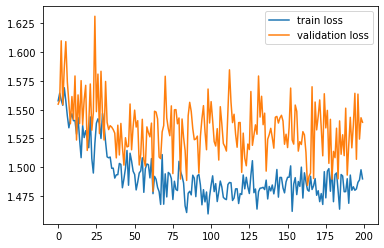

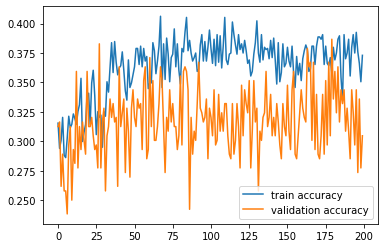

In [251]:
x = np.arange(total_epochs)
plt.plot(x,MSF_train_loss,label='train loss')
plt.plot(x,MSF_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,MSF_train_accuracy,label='train accuracy')
plt.plot(x,MSF_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(MSF_train_loss,MSF_validate_loss,MSF_train_accuracy,MSF_validate_accuracy))
frame.to_csv("MSF.csv")

In [252]:
del MS_MatchingNet
del MS_optimizer
del MS_scheduler
del dataM

# Start with trained: Omniglot

In [256]:
dataO = OmniglotNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

In [257]:
omniglotO = OmniglotClassifier(layer_size=64, nClasses = 1623, num_channels = 1, keep_prob = 0.0, image_size = 28, freeze = False)
optimizerO = torch.optim.Adam(omniglotO.parameters(), lr=1e-3)

In [258]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        loss, acc = PreTraining(dataO,omniglotO,optimizerO,32,True)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, loss, acc))
        pbar_e.update(1)

  1%|▊                                                                                 | 1/100 [00:06<11:13,  6.80s/it]

Epoch 0: train_loss:7.354241237044334 train_accuracy:0.00390625


  2%|█▋                                                                                | 2/100 [00:12<10:34,  6.48s/it]

Epoch 1: train_loss:6.957892924547195 train_accuracy:0.0087890625


  3%|██▍                                                                               | 3/100 [00:18<10:07,  6.27s/it]

Epoch 2: train_loss:6.502273827791214 train_accuracy:0.022705078125


  4%|███▎                                                                              | 4/100 [00:23<09:42,  6.07s/it]

Epoch 3: train_loss:5.93360909819603 train_accuracy:0.055419921875


  5%|████                                                                              | 5/100 [00:29<09:27,  5.97s/it]

Epoch 4: train_loss:5.317334160208702 train_accuracy:0.105224609375


  6%|████▉                                                                             | 6/100 [00:35<09:20,  5.96s/it]

Epoch 5: train_loss:4.666021838784218 train_accuracy:0.161865234375


  7%|█████▋                                                                            | 7/100 [00:41<09:12,  5.94s/it]

Epoch 6: train_loss:3.984204337000847 train_accuracy:0.249755859375


  8%|██████▌                                                                           | 8/100 [00:47<09:08,  5.96s/it]

Epoch 7: train_loss:3.393545277416706 train_accuracy:0.345703125


  9%|███████▍                                                                          | 9/100 [00:53<09:01,  5.95s/it]

Epoch 8: train_loss:2.9018619656562805 train_accuracy:0.422119140625


 10%|████████                                                                         | 10/100 [00:59<08:53,  5.93s/it]

Epoch 9: train_loss:2.504486657679081 train_accuracy:0.490234375


 11%|████████▉                                                                        | 11/100 [01:05<08:44,  5.90s/it]

Epoch 10: train_loss:2.177280057221651 train_accuracy:0.545166015625


 12%|█████████▋                                                                       | 12/100 [01:10<08:35,  5.85s/it]

Epoch 11: train_loss:1.8780786879360676 train_accuracy:0.6171875


 13%|██████████▌                                                                      | 13/100 [01:16<08:31,  5.87s/it]

Epoch 12: train_loss:1.6257444210350513 train_accuracy:0.657958984375


 14%|███████████▎                                                                     | 14/100 [01:22<08:20,  5.82s/it]

Epoch 13: train_loss:1.4390428252518177 train_accuracy:0.697509765625


 15%|████████████▏                                                                    | 15/100 [01:28<08:12,  5.79s/it]

Epoch 14: train_loss:1.2989179342985153 train_accuracy:0.715087890625


 16%|████████████▉                                                                    | 16/100 [01:33<08:03,  5.75s/it]

Epoch 15: train_loss:1.1267649997025728 train_accuracy:0.767333984375


 17%|█████████████▊                                                                   | 17/100 [01:39<08:00,  5.79s/it]

Epoch 16: train_loss:1.0502463057637215 train_accuracy:0.7783203125


 18%|██████████████▌                                                                  | 18/100 [01:45<07:55,  5.80s/it]

Epoch 17: train_loss:0.8983659483492374 train_accuracy:0.805419921875


 19%|███████████████▍                                                                 | 19/100 [01:51<07:51,  5.82s/it]

Epoch 18: train_loss:0.8477303050458431 train_accuracy:0.8154296875


 20%|████████████████▏                                                                | 20/100 [01:57<07:43,  5.80s/it]

Epoch 19: train_loss:0.777570828795433 train_accuracy:0.836181640625


 21%|█████████████████                                                                | 21/100 [02:02<07:32,  5.73s/it]

Epoch 20: train_loss:0.6990428250283003 train_accuracy:0.853271484375


 22%|█████████████████▊                                                               | 22/100 [02:08<07:30,  5.77s/it]

Epoch 21: train_loss:0.6898211222141981 train_accuracy:0.841796875


 23%|██████████████████▋                                                              | 23/100 [02:14<07:29,  5.83s/it]

Epoch 22: train_loss:0.5877945823594928 train_accuracy:0.86962890625


 24%|███████████████████▍                                                             | 24/100 [02:20<07:27,  5.88s/it]

Epoch 23: train_loss:0.5579589502885938 train_accuracy:0.88330078125


 25%|████████████████████▎                                                            | 25/100 [02:26<07:25,  5.93s/it]

Epoch 24: train_loss:0.526695616543293 train_accuracy:0.892333984375


 26%|█████████████████████                                                            | 26/100 [02:32<07:18,  5.92s/it]

Epoch 25: train_loss:0.47616585344076157 train_accuracy:0.9033203125


 27%|█████████████████████▊                                                           | 27/100 [02:38<07:08,  5.88s/it]

Epoch 26: train_loss:0.4825393231585622 train_accuracy:0.8955078125


 28%|██████████████████████▋                                                          | 28/100 [02:43<06:58,  5.81s/it]

Epoch 27: train_loss:0.4368289550766349 train_accuracy:0.904296875


 29%|███████████████████████▍                                                         | 29/100 [02:49<06:54,  5.83s/it]

Epoch 28: train_loss:0.4056808250024915 train_accuracy:0.910888671875


 30%|████████████████████████▎                                                        | 30/100 [02:55<06:48,  5.83s/it]

Epoch 29: train_loss:0.3714951118454337 train_accuracy:0.921142578125


 31%|█████████████████████████                                                        | 31/100 [03:01<06:38,  5.78s/it]

Epoch 30: train_loss:0.35291818995028734 train_accuracy:0.921875


 32%|█████████████████████████▉                                                       | 32/100 [03:06<06:29,  5.72s/it]

Epoch 31: train_loss:0.3548840107396245 train_accuracy:0.923828125


 33%|██████████████████████████▋                                                      | 33/100 [03:12<06:23,  5.72s/it]

Epoch 32: train_loss:0.3234294978901744 train_accuracy:0.93115234375


 34%|███████████████████████████▌                                                     | 34/100 [03:18<06:18,  5.73s/it]

Epoch 33: train_loss:0.3053989871405065 train_accuracy:0.934814453125


 35%|████████████████████████████▎                                                    | 35/100 [03:24<06:11,  5.71s/it]

Epoch 34: train_loss:0.29931541392579675 train_accuracy:0.93115234375


 36%|█████████████████████████████▏                                                   | 36/100 [03:29<06:07,  5.74s/it]

Epoch 35: train_loss:0.282263636123389 train_accuracy:0.940673828125


 37%|█████████████████████████████▉                                                   | 37/100 [03:35<06:02,  5.75s/it]

Epoch 36: train_loss:0.25647067138925195 train_accuracy:0.94677734375


 38%|██████████████████████████████▊                                                  | 38/100 [03:41<05:58,  5.78s/it]

Epoch 37: train_loss:0.25063195545226336 train_accuracy:0.94580078125


 39%|███████████████████████████████▌                                                 | 39/100 [03:47<05:51,  5.77s/it]

Epoch 38: train_loss:0.25499895634129643 train_accuracy:0.942626953125


 40%|████████████████████████████████▍                                                | 40/100 [03:53<05:47,  5.80s/it]

Epoch 39: train_loss:0.22236328106373549 train_accuracy:0.951904296875


 41%|█████████████████████████████████▏                                               | 41/100 [03:59<05:45,  5.85s/it]

Epoch 40: train_loss:0.21008806955069304 train_accuracy:0.959228515625


 42%|██████████████████████████████████                                               | 42/100 [04:04<05:39,  5.85s/it]

Epoch 41: train_loss:0.21367081068456173 train_accuracy:0.956298828125


 43%|██████████████████████████████████▊                                              | 43/100 [04:10<05:35,  5.89s/it]

Epoch 42: train_loss:0.19409941136837006 train_accuracy:0.96142578125


 44%|███████████████████████████████████▋                                             | 44/100 [04:16<05:29,  5.88s/it]

Epoch 43: train_loss:0.18036953266710043 train_accuracy:0.963623046875


 45%|████████████████████████████████████▍                                            | 45/100 [04:22<05:22,  5.86s/it]

Epoch 44: train_loss:0.17578432196751237 train_accuracy:0.961181640625


 46%|█████████████████████████████████████▎                                           | 46/100 [04:28<05:15,  5.85s/it]

Epoch 45: train_loss:0.16084625711664557 train_accuracy:0.9697265625


 47%|██████████████████████████████████████                                           | 47/100 [04:34<05:10,  5.85s/it]

Epoch 46: train_loss:0.16113295778632164 train_accuracy:0.9638671875


 48%|██████████████████████████████████████▉                                          | 48/100 [04:40<05:03,  5.84s/it]

Epoch 47: train_loss:0.1504760489333421 train_accuracy:0.972412109375


 49%|███████████████████████████████████████▋                                         | 49/100 [04:45<04:57,  5.83s/it]

Epoch 48: train_loss:0.1459530375432223 train_accuracy:0.97216796875


 50%|████████████████████████████████████████▌                                        | 50/100 [04:51<04:51,  5.83s/it]

Epoch 49: train_loss:0.1324188916478306 train_accuracy:0.978759765625


 51%|█████████████████████████████████████████▎                                       | 51/100 [04:57<04:44,  5.81s/it]

Epoch 50: train_loss:0.1266330354847014 train_accuracy:0.973388671875


 52%|██████████████████████████████████████████                                       | 52/100 [05:03<04:38,  5.81s/it]

Epoch 51: train_loss:0.1276267666835338 train_accuracy:0.9736328125


 53%|██████████████████████████████████████████▉                                      | 53/100 [05:08<04:31,  5.78s/it]

Epoch 52: train_loss:0.11429636459797621 train_accuracy:0.980224609375


 54%|███████████████████████████████████████████▋                                     | 54/100 [05:14<04:27,  5.81s/it]

Epoch 53: train_loss:0.11719764745794237 train_accuracy:0.97705078125


 55%|████████████████████████████████████████████▌                                    | 55/100 [05:20<04:21,  5.81s/it]

Epoch 54: train_loss:0.11616208369378 train_accuracy:0.978515625


 56%|█████████████████████████████████████████████▎                                   | 56/100 [05:26<04:15,  5.82s/it]

Epoch 55: train_loss:0.11534601962193847 train_accuracy:0.980224609375


 57%|██████████████████████████████████████████████▏                                  | 57/100 [05:32<04:09,  5.81s/it]

Epoch 56: train_loss:0.10569765861146152 train_accuracy:0.98193359375


 58%|██████████████████████████████████████████████▉                                  | 58/100 [05:38<04:03,  5.80s/it]

Epoch 57: train_loss:0.09693544113542885 train_accuracy:0.98291015625


 59%|███████████████████████████████████████████████▊                                 | 59/100 [05:43<03:57,  5.79s/it]

Epoch 58: train_loss:0.09533628087956458 train_accuracy:0.98486328125


 60%|████████████████████████████████████████████████▌                                | 60/100 [05:49<03:50,  5.77s/it]

Epoch 59: train_loss:0.09272096038330346 train_accuracy:0.9853515625


 61%|█████████████████████████████████████████████████▍                               | 61/100 [05:55<03:45,  5.79s/it]

Epoch 60: train_loss:0.08415619342122227 train_accuracy:0.984375


 62%|██████████████████████████████████████████████████▏                              | 62/100 [06:01<03:39,  5.77s/it]

Epoch 61: train_loss:0.08472936553880572 train_accuracy:0.984619140625


 63%|███████████████████████████████████████████████████                              | 63/100 [06:06<03:34,  5.80s/it]

Epoch 62: train_loss:0.0828700551064685 train_accuracy:0.989013671875


 64%|███████████████████████████████████████████████████▊                             | 64/100 [06:12<03:29,  5.81s/it]

Epoch 63: train_loss:0.08289570384658873 train_accuracy:0.98583984375


 65%|████████████████████████████████████████████████████▋                            | 65/100 [06:18<03:22,  5.79s/it]

Epoch 64: train_loss:0.07167205249425024 train_accuracy:0.988525390625


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [06:24<03:17,  5.81s/it]

Epoch 65: train_loss:0.06822586548514664 train_accuracy:0.989013671875


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [06:30<03:11,  5.80s/it]

Epoch 66: train_loss:0.06725649000145495 train_accuracy:0.988037109375


 68%|███████████████████████████████████████████████████████                          | 68/100 [06:36<03:05,  5.81s/it]

Epoch 67: train_loss:0.07585109572391957 train_accuracy:0.9853515625


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [06:41<03:01,  5.84s/it]

Epoch 68: train_loss:0.0650685450527817 train_accuracy:0.98974609375


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [06:47<02:55,  5.84s/it]

Epoch 69: train_loss:0.06301383976824582 train_accuracy:0.990966796875


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [06:53<02:48,  5.81s/it]

Epoch 70: train_loss:0.059439553413540125 train_accuracy:0.991455078125


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [06:59<02:42,  5.81s/it]

Epoch 71: train_loss:0.054736877616960555 train_accuracy:0.9931640625


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [07:05<02:35,  5.78s/it]

Epoch 72: train_loss:0.0599469724111259 train_accuracy:0.988037109375


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [07:10<02:30,  5.79s/it]

Epoch 73: train_loss:0.053331553761381656 train_accuracy:0.991455078125


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [07:16<02:26,  5.85s/it]

Epoch 74: train_loss:0.04705164302140474 train_accuracy:0.9951171875


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [07:22<02:20,  5.84s/it]

Epoch 75: train_loss:0.044770868786145 train_accuracy:0.993408203125


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [07:28<02:14,  5.86s/it]

Epoch 76: train_loss:0.0456845939042978 train_accuracy:0.994140625


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [07:34<02:09,  5.87s/it]

Epoch 77: train_loss:0.05124209390487522 train_accuracy:0.99072265625


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [07:40<02:03,  5.86s/it]

Epoch 78: train_loss:0.04856770666083321 train_accuracy:0.9931640625


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:46<01:56,  5.83s/it]

Epoch 79: train_loss:0.04316680534975603 train_accuracy:0.99365234375


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [07:51<01:50,  5.81s/it]

Epoch 80: train_loss:0.034606914792675525 train_accuracy:0.9970703125


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [07:57<01:44,  5.79s/it]

Epoch 81: train_loss:0.03469604963902384 train_accuracy:0.99609375


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [08:03<01:38,  5.82s/it]

Epoch 82: train_loss:0.03723447065567598 train_accuracy:0.994873046875


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [08:09<01:34,  5.91s/it]

Epoch 83: train_loss:0.04022745823021978 train_accuracy:0.9931640625


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [08:15<01:28,  5.90s/it]

Epoch 84: train_loss:0.039389901037793607 train_accuracy:0.99462890625


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [08:21<01:22,  5.90s/it]

Epoch 85: train_loss:0.03665179823292419 train_accuracy:0.994873046875


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [08:27<01:16,  5.88s/it]

Epoch 86: train_loss:0.0340686944546178 train_accuracy:0.9970703125


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [08:33<01:10,  5.86s/it]

Epoch 87: train_loss:0.03428014070959762 train_accuracy:0.99462890625


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [08:38<01:03,  5.80s/it]

Epoch 88: train_loss:0.033231658046133816 train_accuracy:0.995849609375


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [08:44<00:57,  5.79s/it]

Epoch 89: train_loss:0.03271058259997517 train_accuracy:0.994873046875


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [08:50<00:52,  5.82s/it]

Epoch 90: train_loss:0.027418517041951418 train_accuracy:0.997314453125


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [08:56<00:46,  5.84s/it]

Epoch 91: train_loss:0.02918989153113216 train_accuracy:0.99658203125


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [09:02<00:40,  5.83s/it]

Epoch 92: train_loss:0.03466358029982075 train_accuracy:0.99462890625


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [09:07<00:34,  5.81s/it]

Epoch 93: train_loss:0.03447217645589262 train_accuracy:0.994384765625


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [09:13<00:29,  5.82s/it]

Epoch 94: train_loss:0.035351832571905106 train_accuracy:0.995361328125


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [09:19<00:23,  5.79s/it]

Epoch 95: train_loss:0.03843085281550884 train_accuracy:0.994873046875


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [09:25<00:17,  5.84s/it]

Epoch 96: train_loss:0.04094868525862694 train_accuracy:0.993896484375


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [09:30<00:11,  5.78s/it]

Epoch 97: train_loss:0.043165755341760814 train_accuracy:0.9921875


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [09:36<00:05,  5.73s/it]

Epoch 98: train_loss:0.04682959715137258 train_accuracy:0.990966796875


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:42<00:00,  5.82s/it]

Epoch 99: train_loss:0.04901064222212881 train_accuracy:0.98974609375


In [259]:
torch.save(omniglotO.state_dict(), 'Onet_params.pth')

In [263]:
OT_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=1, fce=False, image_size=28, use_cuda=True)
pretrained_dict = torch.load('Onet_params.pth')
model_dict = OT_MatchingNet.embedding.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)

In [268]:
OT_MatchingNet.embedding.load_state_dict(model_dict)
OT_MatchingNet.embedding.freeze()
#for name, parameter in OT_MatchingNet.embedding.named_parameters():
#    parameter.requires_grad=False
OT_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, OT_MatchingNet.parameters()), lr=1e-3)
OT_scheduler = ReduceLROnPlateau(OT_optimizer, 'min',verbose=True)
OT_validate_loss = []
OT_validate_accuracy = []

In [269]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, OT_MatchingNet.cuda(), OT_scheduler, use_cuda, False)
        OT_validate_loss.append(v_loss)
        OT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<00:58,  3.41it/s]

Epoch 0: validate_loss:1.3442483097314835 validate_accuracy:0.953125


  1%|▊                                                                                 | 2/200 [00:00<00:57,  3.43it/s]

Epoch 1: validate_loss:1.3416936546564102 validate_accuracy:0.95703125


  2%|█▏                                                                                | 3/200 [00:00<00:57,  3.45it/s]

Epoch 2: validate_loss:1.3499549627304077 validate_accuracy:0.91796875


  2%|█▋                                                                                | 4/200 [00:01<00:56,  3.45it/s]

Epoch 3: validate_loss:1.341502770781517 validate_accuracy:0.9453125


  2%|██                                                                                | 5/200 [00:01<00:56,  3.46it/s]

Epoch 4: validate_loss:1.3496902883052826 validate_accuracy:0.94140625


  3%|██▍                                                                               | 6/200 [00:01<00:56,  3.45it/s]

Epoch 5: validate_loss:1.34940355271101 validate_accuracy:0.921875


  4%|██▊                                                                               | 7/200 [00:02<00:55,  3.46it/s]

Epoch 6: validate_loss:1.3588383942842484 validate_accuracy:0.91015625


  4%|███▎                                                                              | 8/200 [00:02<00:55,  3.47it/s]

Epoch 7: validate_loss:1.3510728478431702 validate_accuracy:0.94921875


  4%|███▋                                                                              | 9/200 [00:02<00:54,  3.49it/s]

Epoch 8: validate_loss:1.345483884215355 validate_accuracy:0.92578125


  5%|████                                                                             | 10/200 [00:02<00:54,  3.50it/s]

Epoch 9: validate_loss:1.3530973568558693 validate_accuracy:0.9609375


  6%|████▍                                                                            | 11/200 [00:03<00:54,  3.50it/s]

Epoch 10: validate_loss:1.3594517335295677 validate_accuracy:0.9453125


  6%|████▊                                                                            | 12/200 [00:03<00:53,  3.49it/s]

Epoch 11: validate_loss:1.3536491245031357 validate_accuracy:0.9296875


  6%|█████▎                                                                           | 13/200 [00:03<00:53,  3.48it/s]

Epoch 12: validate_loss:1.3345302790403366 validate_accuracy:0.9609375


  7%|█████▋                                                                           | 14/200 [00:04<00:53,  3.49it/s]

Epoch 13: validate_loss:1.3538961932063103 validate_accuracy:0.9375


  8%|██████                                                                           | 15/200 [00:04<00:52,  3.50it/s]

Epoch 14: validate_loss:1.3442147597670555 validate_accuracy:0.92578125


  8%|██████▍                                                                          | 16/200 [00:04<00:52,  3.50it/s]

Epoch 15: validate_loss:1.3474785387516022 validate_accuracy:0.9375


  8%|██████▉                                                                          | 17/200 [00:04<00:52,  3.51it/s]

Epoch 16: validate_loss:1.3547991067171097 validate_accuracy:0.9375


  9%|███████▎                                                                         | 18/200 [00:05<00:51,  3.51it/s]

Epoch 17: validate_loss:1.354808233678341 validate_accuracy:0.921875


 10%|███████▋                                                                         | 19/200 [00:05<00:51,  3.51it/s]

Epoch 18: validate_loss:1.3535692393779755 validate_accuracy:0.9453125


 10%|████████                                                                         | 20/200 [00:05<00:51,  3.51it/s]

Epoch 19: validate_loss:1.3435484692454338 validate_accuracy:0.94921875


 10%|████████▌                                                                        | 21/200 [00:06<00:51,  3.50it/s]

Epoch 20: validate_loss:1.3588030710816383 validate_accuracy:0.94921875


 11%|████████▉                                                                        | 22/200 [00:06<00:50,  3.50it/s]

Epoch 21: validate_loss:1.3475755527615547 validate_accuracy:0.9375


 12%|█████████▎                                                                       | 23/200 [00:06<00:50,  3.50it/s]

Epoch 22: validate_loss:1.3438946530222893 validate_accuracy:0.94140625


 12%|█████████▋                                                                       | 24/200 [00:06<00:50,  3.50it/s]

Epoch    24: reducing learning rate of group 0 to 1.0000e-04.
Epoch 23: validate_loss:1.3513252064585686 validate_accuracy:0.9375


 12%|██████████▏                                                                      | 25/200 [00:07<00:49,  3.50it/s]

Epoch 24: validate_loss:1.343592293560505 validate_accuracy:0.9375


 13%|██████████▌                                                                      | 26/200 [00:07<00:49,  3.50it/s]

Epoch 25: validate_loss:1.3443640545010567 validate_accuracy:0.95703125


 14%|██████████▉                                                                      | 27/200 [00:07<00:49,  3.51it/s]

Epoch 26: validate_loss:1.3569365218281746 validate_accuracy:0.9375


 14%|███████████▎                                                                     | 28/200 [00:08<00:49,  3.49it/s]

Epoch 27: validate_loss:1.352464683353901 validate_accuracy:0.9140625


 14%|███████████▋                                                                     | 29/200 [00:08<00:48,  3.50it/s]

Epoch 28: validate_loss:1.350601203739643 validate_accuracy:0.953125


 15%|████████████▏                                                                    | 30/200 [00:08<00:48,  3.47it/s]

Epoch 29: validate_loss:1.3514721766114235 validate_accuracy:0.92578125


 16%|████████████▌                                                                    | 31/200 [00:08<00:48,  3.46it/s]

Epoch 30: validate_loss:1.344531126320362 validate_accuracy:0.9296875


 16%|████████████▉                                                                    | 32/200 [00:09<00:48,  3.48it/s]

Epoch 31: validate_loss:1.3561616316437721 validate_accuracy:0.9453125


 16%|█████████████▎                                                                   | 33/200 [00:09<00:47,  3.49it/s]

Epoch 32: validate_loss:1.3522322252392769 validate_accuracy:0.93359375


 17%|█████████████▊                                                                   | 34/200 [00:09<00:47,  3.48it/s]

Epoch 33: validate_loss:1.3465446755290031 validate_accuracy:0.953125


 18%|██████████████▏                                                                  | 35/200 [00:10<00:47,  3.45it/s]

Epoch    35: reducing learning rate of group 0 to 1.0000e-05.
Epoch 34: validate_loss:1.3420916721224785 validate_accuracy:0.9453125


 18%|██████████████▌                                                                  | 36/200 [00:10<00:47,  3.46it/s]

Epoch 35: validate_loss:1.3446021601557732 validate_accuracy:0.95703125


 18%|██████████████▉                                                                  | 37/200 [00:10<00:47,  3.46it/s]

Epoch 36: validate_loss:1.3491839915513992 validate_accuracy:0.94921875


 19%|███████████████▍                                                                 | 38/200 [00:10<00:46,  3.47it/s]

Epoch 37: validate_loss:1.3504685014486313 validate_accuracy:0.93359375


 20%|███████████████▊                                                                 | 39/200 [00:11<00:46,  3.48it/s]

Epoch 38: validate_loss:1.3456876128911972 validate_accuracy:0.95703125


 20%|████████████████▏                                                                | 40/200 [00:11<00:45,  3.48it/s]

Epoch 39: validate_loss:1.3460001647472382 validate_accuracy:0.91796875


 20%|████████████████▌                                                                | 41/200 [00:11<00:46,  3.45it/s]

Epoch 40: validate_loss:1.3433586731553078 validate_accuracy:0.96484375


 21%|█████████████████                                                                | 42/200 [00:12<00:45,  3.44it/s]

Epoch 41: validate_loss:1.3428781479597092 validate_accuracy:0.9375


 22%|█████████████████▍                                                               | 43/200 [00:12<00:45,  3.46it/s]

Epoch 42: validate_loss:1.3532832488417625 validate_accuracy:0.93359375


 22%|█████████████████▊                                                               | 44/200 [00:12<00:44,  3.47it/s]

Epoch 43: validate_loss:1.3530508056282997 validate_accuracy:0.9296875


 22%|██████████████████▏                                                              | 45/200 [00:12<00:44,  3.48it/s]

Epoch 44: validate_loss:1.3604324758052826 validate_accuracy:0.87890625


 23%|██████████████████▋                                                              | 46/200 [00:13<00:44,  3.48it/s]

Epoch    46: reducing learning rate of group 0 to 1.0000e-06.
Epoch 45: validate_loss:1.3477526754140854 validate_accuracy:0.93359375


 24%|███████████████████                                                              | 47/200 [00:13<00:43,  3.49it/s]

Epoch 46: validate_loss:1.3448247388005257 validate_accuracy:0.94140625


 24%|███████████████████▍                                                             | 48/200 [00:13<00:43,  3.49it/s]

Epoch 47: validate_loss:1.344978891313076 validate_accuracy:0.96484375


 24%|███████████████████▊                                                             | 49/200 [00:14<00:43,  3.50it/s]

Epoch 48: validate_loss:1.3501782417297363 validate_accuracy:0.91015625


 25%|████████████████████▎                                                            | 50/200 [00:14<00:42,  3.50it/s]

Epoch 49: validate_loss:1.359236754477024 validate_accuracy:0.90234375


 26%|████████████████████▋                                                            | 51/200 [00:14<00:42,  3.51it/s]

Epoch 50: validate_loss:1.3432175144553185 validate_accuracy:0.96484375


 26%|█████████████████████                                                            | 52/200 [00:14<00:42,  3.51it/s]

Epoch 51: validate_loss:1.3544015437364578 validate_accuracy:0.91796875


 26%|█████████████████████▍                                                           | 53/200 [00:15<00:41,  3.51it/s]

Epoch 52: validate_loss:1.3367759957909584 validate_accuracy:0.94140625


 27%|█████████████████████▊                                                           | 54/200 [00:15<00:41,  3.51it/s]

Epoch 53: validate_loss:1.3384509608149529 validate_accuracy:0.96875


 28%|██████████████████████▎                                                          | 55/200 [00:15<00:41,  3.51it/s]

Epoch 54: validate_loss:1.3474893048405647 validate_accuracy:0.90234375


 28%|██████████████████████▋                                                          | 56/200 [00:16<00:41,  3.51it/s]

Epoch 55: validate_loss:1.3525758609175682 validate_accuracy:0.921875


 28%|███████████████████████                                                          | 57/200 [00:16<00:40,  3.51it/s]

Epoch    57: reducing learning rate of group 0 to 1.0000e-07.
Epoch 56: validate_loss:1.3561888858675957 validate_accuracy:0.93359375


 29%|███████████████████████▍                                                         | 58/200 [00:16<00:40,  3.50it/s]

Epoch 57: validate_loss:1.3574635833501816 validate_accuracy:0.91015625


 30%|███████████████████████▉                                                         | 59/200 [00:16<00:40,  3.50it/s]

Epoch 58: validate_loss:1.3381154388189316 validate_accuracy:0.94140625


 30%|████████████████████████▎                                                        | 60/200 [00:17<00:40,  3.46it/s]

Epoch 59: validate_loss:1.3504935577511787 validate_accuracy:0.95703125


 30%|████████████████████████▋                                                        | 61/200 [00:17<00:40,  3.47it/s]

Epoch 60: validate_loss:1.3475266695022583 validate_accuracy:0.921875


 31%|█████████████████████████                                                        | 62/200 [00:17<00:40,  3.43it/s]

Epoch 61: validate_loss:1.3535480126738548 validate_accuracy:0.9375


 32%|█████████████████████████▌                                                       | 63/200 [00:18<00:39,  3.44it/s]

Epoch 62: validate_loss:1.3513480499386787 validate_accuracy:0.953125


 32%|█████████████████████████▉                                                       | 64/200 [00:18<00:39,  3.46it/s]

Epoch 63: validate_loss:1.3493723422288895 validate_accuracy:0.953125


 32%|██████████████████████████▎                                                      | 65/200 [00:18<00:38,  3.48it/s]

Epoch 64: validate_loss:1.3500608652830124 validate_accuracy:0.9375


 33%|██████████████████████████▋                                                      | 66/200 [00:18<00:38,  3.50it/s]

Epoch 65: validate_loss:1.3416858240962029 validate_accuracy:0.9609375


 34%|███████████████████████████▏                                                     | 67/200 [00:19<00:37,  3.50it/s]

Epoch 66: validate_loss:1.3465885743498802 validate_accuracy:0.953125


 34%|███████████████████████████▌                                                     | 68/200 [00:19<00:37,  3.50it/s]

Epoch    68: reducing learning rate of group 0 to 1.0000e-08.
Epoch 67: validate_loss:1.3615367636084557 validate_accuracy:0.90625


 34%|███████████████████████████▉                                                     | 69/200 [00:19<00:37,  3.51it/s]

Epoch 68: validate_loss:1.3553931564092636 validate_accuracy:0.92578125


 35%|████████████████████████████▎                                                    | 70/200 [00:20<00:37,  3.45it/s]

Epoch 69: validate_loss:1.3428123593330383 validate_accuracy:0.9453125


 36%|████████████████████████████▊                                                    | 71/200 [00:20<00:37,  3.46it/s]

Epoch 70: validate_loss:1.3558191657066345 validate_accuracy:0.921875


 36%|█████████████████████████████▏                                                   | 72/200 [00:20<00:36,  3.48it/s]

Epoch 71: validate_loss:1.3361635282635689 validate_accuracy:0.94140625


 36%|█████████████████████████████▌                                                   | 73/200 [00:20<00:36,  3.49it/s]

Epoch 72: validate_loss:1.342834122478962 validate_accuracy:0.953125


 37%|█████████████████████████████▉                                                   | 74/200 [00:21<00:36,  3.49it/s]

Epoch 73: validate_loss:1.3529942408204079 validate_accuracy:0.90234375


 38%|██████████████████████████████▍                                                  | 75/200 [00:21<00:35,  3.49it/s]

Epoch 74: validate_loss:1.3560232818126678 validate_accuracy:0.92578125


 38%|██████████████████████████████▊                                                  | 76/200 [00:21<00:35,  3.49it/s]

Epoch 75: validate_loss:1.3514027670025826 validate_accuracy:0.92578125


 38%|███████████████████████████████▏                                                 | 77/200 [00:22<00:35,  3.50it/s]

Epoch 76: validate_loss:1.3496520221233368 validate_accuracy:0.92578125


 39%|███████████████████████████████▌                                                 | 78/200 [00:22<00:34,  3.49it/s]

Epoch 77: validate_loss:1.3522549346089363 validate_accuracy:0.93359375


 40%|███████████████████████████████▉                                                 | 79/200 [00:22<00:34,  3.48it/s]

Epoch 78: validate_loss:1.347007192671299 validate_accuracy:0.94921875


 40%|████████████████████████████████▍                                                | 80/200 [00:22<00:34,  3.48it/s]

Epoch 79: validate_loss:1.3450425267219543 validate_accuracy:0.93359375


 40%|████████████████████████████████▊                                                | 81/200 [00:23<00:34,  3.49it/s]

Epoch 80: validate_loss:1.3619713112711906 validate_accuracy:0.8984375


 41%|█████████████████████████████████▏                                               | 82/200 [00:23<00:33,  3.49it/s]

Epoch 81: validate_loss:1.347383826971054 validate_accuracy:0.9453125


 42%|█████████████████████████████████▌                                               | 83/200 [00:23<00:33,  3.49it/s]

Epoch 82: validate_loss:1.3530436009168625 validate_accuracy:0.93359375


 42%|██████████████████████████████████                                               | 84/200 [00:24<00:33,  3.50it/s]

Epoch 83: validate_loss:1.3445550501346588 validate_accuracy:0.94140625


 42%|██████████████████████████████████▍                                              | 85/200 [00:24<00:32,  3.49it/s]

Epoch 84: validate_loss:1.3541125655174255 validate_accuracy:0.94921875


 43%|██████████████████████████████████▊                                              | 86/200 [00:24<00:32,  3.50it/s]

Epoch 85: validate_loss:1.361341468989849 validate_accuracy:0.90625


 44%|███████████████████████████████████▏                                             | 87/200 [00:24<00:32,  3.49it/s]

Epoch 86: validate_loss:1.3483869209885597 validate_accuracy:0.9296875


 44%|███████████████████████████████████▋                                             | 88/200 [00:25<00:32,  3.50it/s]

Epoch 87: validate_loss:1.3603046536445618 validate_accuracy:0.92578125


 44%|████████████████████████████████████                                             | 89/200 [00:25<00:31,  3.50it/s]

Epoch 88: validate_loss:1.35999745875597 validate_accuracy:0.9296875


 45%|████████████████████████████████████▍                                            | 90/200 [00:25<00:31,  3.50it/s]

Epoch 89: validate_loss:1.3464029878377914 validate_accuracy:0.96484375


 46%|████████████████████████████████████▊                                            | 91/200 [00:26<00:31,  3.51it/s]

Epoch 90: validate_loss:1.3543053269386292 validate_accuracy:0.93359375


 46%|█████████████████████████████████████▎                                           | 92/200 [00:26<00:30,  3.51it/s]

Epoch 91: validate_loss:1.354607306420803 validate_accuracy:0.94921875


 46%|█████████████████████████████████████▋                                           | 93/200 [00:26<00:30,  3.51it/s]

Epoch 92: validate_loss:1.3489392548799515 validate_accuracy:0.9375


 47%|██████████████████████████████████████                                           | 94/200 [00:26<00:30,  3.50it/s]

Epoch 93: validate_loss:1.3500985577702522 validate_accuracy:0.93359375


 48%|██████████████████████████████████████▍                                          | 95/200 [00:27<00:30,  3.50it/s]

Epoch 94: validate_loss:1.3534175604581833 validate_accuracy:0.921875


 48%|██████████████████████████████████████▉                                          | 96/200 [00:27<00:29,  3.50it/s]

Epoch 95: validate_loss:1.3504819795489311 validate_accuracy:0.94921875


 48%|███████████████████████████████████████▎                                         | 97/200 [00:27<00:29,  3.50it/s]

Epoch 96: validate_loss:1.3473994582891464 validate_accuracy:0.9453125


 49%|███████████████████████████████████████▋                                         | 98/200 [00:28<00:29,  3.50it/s]

Epoch 97: validate_loss:1.3541492074728012 validate_accuracy:0.94921875


 50%|████████████████████████████████████████                                         | 99/200 [00:28<00:28,  3.50it/s]

Epoch 98: validate_loss:1.3533730134367943 validate_accuracy:0.9453125


 50%|████████████████████████████████████████                                        | 100/200 [00:28<00:28,  3.50it/s]

Epoch 99: validate_loss:1.3585357666015625 validate_accuracy:0.921875


 50%|████████████████████████████████████████▍                                       | 101/200 [00:28<00:28,  3.51it/s]

Epoch 100: validate_loss:1.3368416726589203 validate_accuracy:0.94921875


 51%|████████████████████████████████████████▊                                       | 102/200 [00:29<00:27,  3.51it/s]

Epoch 101: validate_loss:1.3441622480750084 validate_accuracy:0.94140625


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:29<00:27,  3.50it/s]

Epoch 102: validate_loss:1.3403145149350166 validate_accuracy:0.97265625


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:29<00:27,  3.50it/s]

Epoch 103: validate_loss:1.3551859706640244 validate_accuracy:0.9375


 52%|██████████████████████████████████████████                                      | 105/200 [00:30<00:27,  3.50it/s]

Epoch 104: validate_loss:1.3521966859698296 validate_accuracy:0.9296875


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:30<00:26,  3.50it/s]

Epoch 105: validate_loss:1.344840481877327 validate_accuracy:0.9375


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:30<00:26,  3.50it/s]

Epoch 106: validate_loss:1.354322373867035 validate_accuracy:0.921875


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:30<00:26,  3.50it/s]

Epoch 107: validate_loss:1.3475889563560486 validate_accuracy:0.92578125


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:31<00:26,  3.49it/s]

Epoch 108: validate_loss:1.360030248761177 validate_accuracy:0.9140625


 55%|████████████████████████████████████████████                                    | 110/200 [00:31<00:25,  3.50it/s]

Epoch 109: validate_loss:1.344692848622799 validate_accuracy:0.9375


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:31<00:25,  3.50it/s]

Epoch 110: validate_loss:1.3475447073578835 validate_accuracy:0.9375


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:32<00:25,  3.49it/s]

Epoch 111: validate_loss:1.3501998111605644 validate_accuracy:0.93359375


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:32<00:24,  3.49it/s]

Epoch 112: validate_loss:1.3454416319727898 validate_accuracy:0.94140625


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:32<00:24,  3.49it/s]

Epoch 113: validate_loss:1.3429205864667892 validate_accuracy:0.9453125


 57%|██████████████████████████████████████████████                                  | 115/200 [00:32<00:24,  3.49it/s]

Epoch 114: validate_loss:1.353259600698948 validate_accuracy:0.94140625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:33<00:24,  3.48it/s]

Epoch 115: validate_loss:1.348573125898838 validate_accuracy:0.9765625


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:33<00:23,  3.49it/s]

Epoch 116: validate_loss:1.3439589515328407 validate_accuracy:0.953125


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:33<00:23,  3.48it/s]

Epoch 117: validate_loss:1.3520926460623741 validate_accuracy:0.9375


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:34<00:23,  3.46it/s]

Epoch 118: validate_loss:1.3456618264317513 validate_accuracy:0.94921875


 60%|████████████████████████████████████████████████                                | 120/200 [00:34<00:23,  3.47it/s]

Epoch 119: validate_loss:1.3600480258464813 validate_accuracy:0.94140625


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:34<00:22,  3.48it/s]

Epoch 120: validate_loss:1.3570688217878342 validate_accuracy:0.9296875


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:34<00:22,  3.49it/s]

Epoch 121: validate_loss:1.3493195846676826 validate_accuracy:0.9609375


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:35<00:22,  3.49it/s]

Epoch 122: validate_loss:1.3432996571063995 validate_accuracy:0.921875


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:35<00:21,  3.50it/s]

Epoch 123: validate_loss:1.3465821743011475 validate_accuracy:0.92578125


 62%|██████████████████████████████████████████████████                              | 125/200 [00:35<00:21,  3.50it/s]

Epoch 124: validate_loss:1.36031112074852 validate_accuracy:0.93359375


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:36<00:21,  3.50it/s]

Epoch 125: validate_loss:1.3475270420312881 validate_accuracy:0.92578125


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:36<00:21,  3.47it/s]

Epoch 126: validate_loss:1.3403668254613876 validate_accuracy:0.94140625


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:36<00:20,  3.48it/s]

Epoch 127: validate_loss:1.3450288251042366 validate_accuracy:0.9296875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:36<00:20,  3.49it/s]

Epoch 128: validate_loss:1.349973239004612 validate_accuracy:0.9375


 65%|████████████████████████████████████████████████████                            | 130/200 [00:37<00:20,  3.49it/s]

Epoch 129: validate_loss:1.3518269509077072 validate_accuracy:0.953125


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:37<00:19,  3.50it/s]

Epoch 130: validate_loss:1.361070066690445 validate_accuracy:0.921875


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:37<00:19,  3.50it/s]

Epoch 131: validate_loss:1.3569822907447815 validate_accuracy:0.91015625


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:38<00:19,  3.50it/s]

Epoch 132: validate_loss:1.3458862230181694 validate_accuracy:0.98828125


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:38<00:18,  3.50it/s]

Epoch 133: validate_loss:1.3465230911970139 validate_accuracy:0.93359375


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:38<00:18,  3.49it/s]

Epoch 134: validate_loss:1.3448647186160088 validate_accuracy:0.94921875


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:38<00:18,  3.48it/s]

Epoch 135: validate_loss:1.3505741879343987 validate_accuracy:0.94921875


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:39<00:18,  3.49it/s]

Epoch 136: validate_loss:1.343704804778099 validate_accuracy:0.9296875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:39<00:17,  3.49it/s]

Epoch 137: validate_loss:1.3509211242198944 validate_accuracy:0.91796875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:39<00:17,  3.49it/s]

Epoch 138: validate_loss:1.3566777035593987 validate_accuracy:0.91796875


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:40<00:17,  3.51it/s]

Epoch 139: validate_loss:1.3523873388767242 validate_accuracy:0.93359375


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:40<00:16,  3.51it/s]

Epoch 140: validate_loss:1.3491337224841118 validate_accuracy:0.953125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:40<00:16,  3.51it/s]

Epoch 141: validate_loss:1.3415193483233452 validate_accuracy:0.9140625


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:40<00:16,  3.52it/s]

Epoch 142: validate_loss:1.349772721529007 validate_accuracy:0.9375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:41<00:15,  3.51it/s]

Epoch 143: validate_loss:1.3476944267749786 validate_accuracy:0.91015625


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:41<00:15,  3.52it/s]

Epoch 144: validate_loss:1.348599024116993 validate_accuracy:0.9609375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:41<00:15,  3.52it/s]

Epoch 145: validate_loss:1.3565539419651031 validate_accuracy:0.94140625


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:42<00:15,  3.53it/s]

Epoch 146: validate_loss:1.3455917611718178 validate_accuracy:0.94140625


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:42<00:14,  3.52it/s]

Epoch 147: validate_loss:1.344650000333786 validate_accuracy:0.93359375


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:42<00:14,  3.51it/s]

Epoch 148: validate_loss:1.349813535809517 validate_accuracy:0.921875


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:42<00:14,  3.51it/s]

Epoch 149: validate_loss:1.3471695184707642 validate_accuracy:0.92578125


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:43<00:13,  3.50it/s]

Epoch 150: validate_loss:1.351961612701416 validate_accuracy:0.9296875


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:43<00:13,  3.50it/s]

Epoch 151: validate_loss:1.353469081223011 validate_accuracy:0.9453125


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:43<00:13,  3.51it/s]

Epoch 152: validate_loss:1.3464410528540611 validate_accuracy:0.9453125


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:44<00:13,  3.51it/s]

Epoch 153: validate_loss:1.3556286171078682 validate_accuracy:0.9375


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:44<00:12,  3.50it/s]

Epoch 154: validate_loss:1.359494723379612 validate_accuracy:0.921875


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:44<00:12,  3.49it/s]

Epoch 155: validate_loss:1.3513183072209358 validate_accuracy:0.921875


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:44<00:12,  3.49it/s]

Epoch 156: validate_loss:1.346872717142105 validate_accuracy:0.9375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:45<00:12,  3.50it/s]

Epoch 157: validate_loss:1.3428385853767395 validate_accuracy:0.9296875


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:45<00:11,  3.50it/s]

Epoch 158: validate_loss:1.3487632274627686 validate_accuracy:0.9375


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:45<00:11,  3.50it/s]

Epoch 159: validate_loss:1.3532397523522377 validate_accuracy:0.91796875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:46<00:11,  3.51it/s]

Epoch 160: validate_loss:1.348136156797409 validate_accuracy:0.9375


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:46<00:10,  3.50it/s]

Epoch 161: validate_loss:1.3484461531043053 validate_accuracy:0.94140625


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:46<00:10,  3.51it/s]

Epoch 162: validate_loss:1.3576329201459885 validate_accuracy:0.91015625


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:46<00:10,  3.52it/s]

Epoch 163: validate_loss:1.3446691781282425 validate_accuracy:0.9453125


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:47<00:09,  3.51it/s]

Epoch 164: validate_loss:1.3569495677947998 validate_accuracy:0.91796875


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:47<00:09,  3.51it/s]

Epoch 165: validate_loss:1.352405272424221 validate_accuracy:0.9375


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:47<00:09,  3.51it/s]

Epoch 166: validate_loss:1.3506938591599464 validate_accuracy:0.92578125


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:48<00:09,  3.52it/s]

Epoch 167: validate_loss:1.3550144881010056 validate_accuracy:0.9375


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:48<00:08,  3.51it/s]

Epoch 168: validate_loss:1.3452026695013046 validate_accuracy:0.9375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:48<00:08,  3.50it/s]

Epoch 169: validate_loss:1.3596454337239265 validate_accuracy:0.9609375


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:48<00:08,  3.51it/s]

Epoch 170: validate_loss:1.3415589109063148 validate_accuracy:0.96875


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [00:49<00:07,  3.52it/s]

Epoch 171: validate_loss:1.347247488796711 validate_accuracy:0.94140625


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [00:49<00:07,  3.49it/s]

Epoch 172: validate_loss:1.3426673635840416 validate_accuracy:0.94140625


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [00:49<00:07,  3.49it/s]

Epoch 173: validate_loss:1.349241465330124 validate_accuracy:0.93359375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [00:50<00:07,  3.50it/s]

Epoch 174: validate_loss:1.3460755497217178 validate_accuracy:0.94140625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [00:50<00:06,  3.48it/s]

Epoch 175: validate_loss:1.357034869492054 validate_accuracy:0.94140625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [00:50<00:06,  3.48it/s]

Epoch 176: validate_loss:1.3481100276112556 validate_accuracy:0.9140625


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [00:50<00:06,  3.48it/s]

Epoch 177: validate_loss:1.344751589000225 validate_accuracy:0.9609375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [00:51<00:06,  3.48it/s]

Epoch 178: validate_loss:1.3516934365034103 validate_accuracy:0.9296875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [00:51<00:05,  3.49it/s]

Epoch 179: validate_loss:1.344524160027504 validate_accuracy:0.91796875


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:51<00:05,  3.51it/s]

Epoch 180: validate_loss:1.3523272648453712 validate_accuracy:0.91796875


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [00:52<00:05,  3.51it/s]

Epoch 181: validate_loss:1.352949507534504 validate_accuracy:0.921875


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [00:52<00:04,  3.49it/s]

Epoch 182: validate_loss:1.348028115928173 validate_accuracy:0.9453125


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [00:52<00:04,  3.50it/s]

Epoch 183: validate_loss:1.3601887673139572 validate_accuracy:0.92578125


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [00:52<00:04,  3.50it/s]

Epoch 184: validate_loss:1.3473126888275146 validate_accuracy:0.921875


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [00:53<00:03,  3.50it/s]

Epoch 185: validate_loss:1.3513353243470192 validate_accuracy:0.94140625


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [00:53<00:03,  3.51it/s]

Epoch 186: validate_loss:1.35313680768013 validate_accuracy:0.9375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [00:53<00:03,  3.50it/s]

Epoch 187: validate_loss:1.344647355377674 validate_accuracy:0.9296875


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [00:54<00:03,  3.50it/s]

Epoch 188: validate_loss:1.3591044321656227 validate_accuracy:0.9140625


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [00:54<00:02,  3.49it/s]

Epoch 189: validate_loss:1.354872226715088 validate_accuracy:0.9140625


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:54<00:02,  3.50it/s]

Epoch 190: validate_loss:1.3575206622481346 validate_accuracy:0.94921875


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [00:54<00:02,  3.50it/s]

Epoch 191: validate_loss:1.3373599350452423 validate_accuracy:0.9609375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [00:55<00:01,  3.50it/s]

Epoch 192: validate_loss:1.3549793437123299 validate_accuracy:0.9296875


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [00:55<00:01,  3.50it/s]

Epoch 193: validate_loss:1.3479729369282722 validate_accuracy:0.93359375


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [00:55<00:01,  3.50it/s]

Epoch 194: validate_loss:1.3508146852254868 validate_accuracy:0.9609375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [00:56<00:01,  3.49it/s]

Epoch 195: validate_loss:1.3424180448055267 validate_accuracy:0.94921875


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [00:56<00:00,  3.50it/s]

Epoch 196: validate_loss:1.345633216202259 validate_accuracy:0.91796875


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [00:56<00:00,  3.49it/s]

Epoch 197: validate_loss:1.3472570851445198 validate_accuracy:0.9296875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [00:56<00:00,  3.50it/s]

Epoch 198: validate_loss:1.3494640737771988 validate_accuracy:0.9296875


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.49it/s]

Epoch 199: validate_loss:1.3543178513646126 validate_accuracy:0.94921875


In [270]:
np.mean(OTN_validate_accuracy)

0.9397891988778054

In [416]:
del OT_MatchingNet
del OT_optimizer
del OT_scheduler

In [417]:
OT_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=1, fce=True, image_size=28, use_cuda=True)
pretrained_dict = torch.load('Onet_params.pth')
model_dict = OT_MatchingNet.embedding.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)

In [418]:
OT_MatchingNet.embedding.load_state_dict(model_dict)
OT_MatchingNet.embedding.freeze()
for name, parameter in OT_MatchingNet.embedding.named_parameters():
    parameter.requires_grad=False
OT_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, OT_MatchingNet.parameters()), lr=1e-3)
OT_scheduler = ReduceLROnPlateau(OT_optimizer, 'min',verbose=True)
OTF_train_loss = []
OTF_train_accuracy = []
OTF_validate_loss = []
OTF_validate_accuracy = []

In [419]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataO,total_train_batches, OT_MatchingNet, OT_optimizer, use_cuda, True)
        OTF_train_loss.append(t_loss)
        OTF_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, OT_MatchingNet, OT_scheduler, use_cuda, False)
        OTF_validate_loss.append(v_loss)
        OTF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.3459028583019972 train_accuracy:0.9375


  0%|▍                                                                                 | 1/200 [00:02<07:16,  2.19s/it]

Epoch 0: validate_loss:1.327812947332859 validate_accuracy:0.9453125
Epoch 1: train_loss:1.3298496939241886 train_accuracy:0.931640625


  1%|▊                                                                                 | 2/200 [00:04<07:13,  2.19s/it]

Epoch 1: validate_loss:1.3255668431520462 validate_accuracy:0.9296875
Epoch 2: train_loss:1.3284957986325026 train_accuracy:0.923828125


  2%|█▏                                                                                | 3/200 [00:06<07:12,  2.20s/it]

Epoch 2: validate_loss:1.3052815571427345 validate_accuracy:0.95703125
Epoch 3: train_loss:1.3143784627318382 train_accuracy:0.9345703125


  2%|█▋                                                                                | 4/200 [00:08<07:09,  2.19s/it]

Epoch 3: validate_loss:1.3124257400631905 validate_accuracy:0.9296875
Epoch 4: train_loss:1.306702310219407 train_accuracy:0.9404296875


  2%|██                                                                                | 5/200 [00:10<07:06,  2.19s/it]

Epoch 4: validate_loss:1.3146806210279465 validate_accuracy:0.921875
Epoch 5: train_loss:1.3129110280424356 train_accuracy:0.9296875


  3%|██▍                                                                               | 6/200 [00:13<07:02,  2.18s/it]

Epoch 5: validate_loss:1.3070168122649193 validate_accuracy:0.9296875
Epoch 6: train_loss:1.3149503897875547 train_accuracy:0.9306640625


  4%|██▊                                                                               | 7/200 [00:15<07:00,  2.18s/it]

Epoch 6: validate_loss:1.3078829422593117 validate_accuracy:0.953125
Epoch 7: train_loss:1.3138923328369856 train_accuracy:0.9482421875


  4%|███▎                                                                              | 8/200 [00:17<06:57,  2.18s/it]

Epoch 7: validate_loss:1.3248211964964867 validate_accuracy:0.90234375
Epoch 8: train_loss:1.311223080381751 train_accuracy:0.9326171875


  4%|███▋                                                                              | 9/200 [00:19<06:54,  2.17s/it]

Epoch 8: validate_loss:1.2995563596487045 validate_accuracy:0.921875
Epoch 9: train_loss:1.3034902457147837 train_accuracy:0.939453125


  5%|████                                                                             | 10/200 [00:21<06:53,  2.18s/it]

Epoch 9: validate_loss:1.3124087154865265 validate_accuracy:0.91796875
Epoch 10: train_loss:1.3090426046401262 train_accuracy:0.9365234375


  6%|████▍                                                                            | 11/200 [00:23<06:51,  2.18s/it]

Epoch 10: validate_loss:1.3051721900701523 validate_accuracy:0.94140625
Epoch 11: train_loss:1.308442372828722 train_accuracy:0.9208984375


  6%|████▊                                                                            | 12/200 [00:26<06:49,  2.18s/it]

Epoch 11: validate_loss:1.3012938424944878 validate_accuracy:0.94140625
Epoch 12: train_loss:1.3106989078223705 train_accuracy:0.927734375


  6%|█████▎                                                                           | 13/200 [00:28<06:46,  2.18s/it]

Epoch 12: validate_loss:1.3090641498565674 validate_accuracy:0.94140625
Epoch 13: train_loss:1.3038187194615602 train_accuracy:0.939453125


  7%|█████▋                                                                           | 14/200 [00:30<06:44,  2.18s/it]

Epoch 13: validate_loss:1.3200143352150917 validate_accuracy:0.9296875
Epoch 14: train_loss:1.3074283581227064 train_accuracy:0.9375


  8%|██████                                                                           | 15/200 [00:32<06:42,  2.18s/it]

Epoch 14: validate_loss:1.3079069703817368 validate_accuracy:0.91796875
Epoch 15: train_loss:1.3049239311367273 train_accuracy:0.939453125


  8%|██████▍                                                                          | 16/200 [00:34<06:39,  2.17s/it]

Epoch 15: validate_loss:1.2957924455404282 validate_accuracy:0.94140625
Epoch 16: train_loss:1.309342147782445 train_accuracy:0.921875


  8%|██████▉                                                                          | 17/200 [00:37<06:37,  2.17s/it]

Epoch 16: validate_loss:1.304235115647316 validate_accuracy:0.9453125
Epoch 17: train_loss:1.3029943089932203 train_accuracy:0.9384765625


  9%|███████▎                                                                         | 18/200 [00:39<06:35,  2.17s/it]

Epoch 17: validate_loss:1.3020806387066841 validate_accuracy:0.9375
Epoch 18: train_loss:1.3103280030190945 train_accuracy:0.939453125


 10%|███████▋                                                                         | 19/200 [00:41<06:33,  2.17s/it]

Epoch 18: validate_loss:1.3123187646269798 validate_accuracy:0.9296875
Epoch 19: train_loss:1.3091907072812319 train_accuracy:0.94140625


 10%|████████                                                                         | 20/200 [00:43<06:30,  2.17s/it]

Epoch 19: validate_loss:1.3181918784976006 validate_accuracy:0.91796875
Epoch 20: train_loss:1.3038561567664146 train_accuracy:0.9541015625


 10%|████████▌                                                                        | 21/200 [00:45<06:28,  2.17s/it]

Epoch 20: validate_loss:1.3087313547730446 validate_accuracy:0.93359375
Epoch 21: train_loss:1.3044164348393679 train_accuracy:0.9443359375


 11%|████████▉                                                                        | 22/200 [00:47<06:28,  2.18s/it]

Epoch 21: validate_loss:1.3019264414906502 validate_accuracy:0.90625
Epoch 22: train_loss:1.3026827350258827 train_accuracy:0.939453125


 12%|█████████▎                                                                       | 23/200 [00:50<06:26,  2.18s/it]

Epoch 22: validate_loss:1.3004855811595917 validate_accuracy:0.9453125
Epoch 23: train_loss:1.3017617259174585 train_accuracy:0.94140625


 12%|█████████▋                                                                       | 24/200 [00:52<06:23,  2.18s/it]

Epoch 23: validate_loss:1.3060506284236908 validate_accuracy:0.9296875
Epoch 24: train_loss:1.3047679737210274 train_accuracy:0.9384765625


 12%|██████████▏                                                                      | 25/200 [00:54<06:21,  2.18s/it]

Epoch 24: validate_loss:1.3066875040531158 validate_accuracy:0.94921875
Epoch 25: train_loss:1.3076547421514988 train_accuracy:0.9326171875


 13%|██████████▌                                                                      | 26/200 [00:56<06:18,  2.18s/it]

Epoch 25: validate_loss:1.3027110323309898 validate_accuracy:0.94921875
Epoch 26: train_loss:1.3045828267931938 train_accuracy:0.9453125


 14%|██████████▉                                                                      | 27/200 [00:58<06:16,  2.18s/it]

Epoch 26: validate_loss:1.2916099056601524 validate_accuracy:0.953125
Epoch 27: train_loss:1.3012345917522907 train_accuracy:0.931640625


 14%|███████████▎                                                                     | 28/200 [01:00<06:13,  2.17s/it]

Epoch 27: validate_loss:1.3089701384305954 validate_accuracy:0.94140625
Epoch 28: train_loss:1.3025102689862251 train_accuracy:0.9345703125


 14%|███████████▋                                                                     | 29/200 [01:03<06:11,  2.17s/it]

Epoch 28: validate_loss:1.3032560870051384 validate_accuracy:0.91796875
Epoch 29: train_loss:1.305813392624259 train_accuracy:0.9287109375


 15%|████████████▏                                                                    | 30/200 [01:05<06:09,  2.17s/it]

Epoch 29: validate_loss:1.3051148727536201 validate_accuracy:0.95703125
Epoch 30: train_loss:1.3012681063264608 train_accuracy:0.9453125


 16%|████████████▌                                                                    | 31/200 [01:07<06:06,  2.17s/it]

Epoch 30: validate_loss:1.2967759147286415 validate_accuracy:0.93359375
Epoch 31: train_loss:1.3030804842710495 train_accuracy:0.939453125


 16%|████████████▉                                                                    | 32/200 [01:09<06:04,  2.17s/it]

Epoch 31: validate_loss:1.2998767346143723 validate_accuracy:0.9375
Epoch 32: train_loss:1.3054920472204685 train_accuracy:0.9189453125


 16%|█████████████▎                                                                   | 33/200 [01:11<06:02,  2.17s/it]

Epoch 32: validate_loss:1.2836836874485016 validate_accuracy:0.93359375
Epoch 33: train_loss:1.3099993336945772 train_accuracy:0.9267578125


 17%|█████████████▊                                                                   | 34/200 [01:13<05:59,  2.17s/it]

Epoch 33: validate_loss:1.3057195097208023 validate_accuracy:0.9375
Epoch 34: train_loss:1.2989512644708157 train_accuracy:0.9482421875


 18%|██████████████▏                                                                  | 35/200 [01:16<05:59,  2.18s/it]

Epoch 34: validate_loss:1.313446782529354 validate_accuracy:0.9296875
Epoch 35: train_loss:1.3025492075830698 train_accuracy:0.9296875


 18%|██████████████▌                                                                  | 36/200 [01:18<05:57,  2.18s/it]

Epoch 35: validate_loss:1.2980303913354874 validate_accuracy:0.9453125
Epoch 36: train_loss:1.3036469835788012 train_accuracy:0.9296875


 18%|██████████████▉                                                                  | 37/200 [01:20<05:55,  2.18s/it]

Epoch 36: validate_loss:1.301795668900013 validate_accuracy:0.91015625
Epoch 37: train_loss:1.3048321697860956 train_accuracy:0.9296875


 19%|███████████████▍                                                                 | 38/200 [01:22<05:53,  2.18s/it]

Epoch 37: validate_loss:1.3044464215636253 validate_accuracy:0.92578125
Epoch 38: train_loss:1.3031370509415865 train_accuracy:0.947265625


 20%|███████████████▊                                                                 | 39/200 [01:24<05:51,  2.18s/it]

Epoch 38: validate_loss:1.2951655238866806 validate_accuracy:0.94921875
Epoch 39: train_loss:1.2941629644483328 train_accuracy:0.939453125


 20%|████████████████▏                                                                | 40/200 [01:27<05:48,  2.18s/it]

Epoch 39: validate_loss:1.2810266241431236 validate_accuracy:0.95703125
Epoch 40: train_loss:1.3078122846782207 train_accuracy:0.939453125


 20%|████████████████▌                                                                | 41/200 [01:29<05:46,  2.18s/it]

Epoch 40: validate_loss:1.3169854059815407 validate_accuracy:0.921875
Epoch 41: train_loss:1.2947035543620586 train_accuracy:0.9404296875


 21%|█████████████████                                                                | 42/200 [01:31<05:44,  2.18s/it]

Epoch 41: validate_loss:1.2998146638274193 validate_accuracy:0.9375
Epoch 42: train_loss:1.3014883380383253 train_accuracy:0.9326171875


 22%|█████████████████▍                                                               | 43/200 [01:33<05:41,  2.18s/it]

Epoch 42: validate_loss:1.2930473908782005 validate_accuracy:0.953125
Epoch 43: train_loss:1.2913245018571615 train_accuracy:0.9453125


 22%|█████████████████▊                                                               | 44/200 [01:35<05:39,  2.18s/it]

Epoch 43: validate_loss:1.302207961678505 validate_accuracy:0.94921875
Epoch 44: train_loss:1.302837634459138 train_accuracy:0.931640625


 22%|██████████████████▏                                                              | 45/200 [01:37<05:37,  2.18s/it]

Epoch 44: validate_loss:1.300066739320755 validate_accuracy:0.9453125
Epoch 45: train_loss:1.2975794039666653 train_accuracy:0.939453125


 23%|██████████████████▋                                                              | 46/200 [01:40<05:36,  2.19s/it]

Epoch 45: validate_loss:1.2955174669623375 validate_accuracy:0.92578125
Epoch 46: train_loss:1.3006530050188303 train_accuracy:0.9423828125


 24%|███████████████████                                                              | 47/200 [01:42<05:36,  2.20s/it]

Epoch 46: validate_loss:1.29885982722044 validate_accuracy:0.9453125
Epoch 47: train_loss:1.3007946405559778 train_accuracy:0.9326171875


 24%|███████████████████▍                                                             | 48/200 [01:44<05:33,  2.19s/it]

Epoch 47: validate_loss:1.3030189126729965 validate_accuracy:0.921875
Epoch 48: train_loss:1.3014883436262608 train_accuracy:0.935546875


 24%|███████████████████▊                                                             | 49/200 [01:46<05:30,  2.19s/it]

Epoch 48: validate_loss:1.290608324110508 validate_accuracy:0.9609375
Epoch 49: train_loss:1.2995985224843025 train_accuracy:0.9384765625


 25%|████████████████████▎                                                            | 50/200 [01:48<05:28,  2.19s/it]

Epoch 49: validate_loss:1.3028579726815224 validate_accuracy:0.921875
Epoch 50: train_loss:1.3013428822159767 train_accuracy:0.9404296875


 26%|████████████████████▋                                                            | 51/200 [01:51<05:26,  2.19s/it]

Epoch    51: reducing learning rate of group 0 to 1.0000e-04.
Epoch 50: validate_loss:1.300827145576477 validate_accuracy:0.94140625
Epoch 51: train_loss:1.2986895889043808 train_accuracy:0.951171875


 26%|█████████████████████                                                            | 52/200 [01:53<05:23,  2.19s/it]

Epoch 51: validate_loss:1.304085150361061 validate_accuracy:0.92578125
Epoch 52: train_loss:1.3018289729952812 train_accuracy:0.9521484375


 26%|█████████████████████▍                                                           | 53/200 [01:55<05:21,  2.19s/it]

Epoch 52: validate_loss:1.2985379993915558 validate_accuracy:0.9453125
Epoch 53: train_loss:1.3020668514072895 train_accuracy:0.943359375


 27%|█████████████████████▊                                                           | 54/200 [01:57<05:18,  2.18s/it]

Epoch 53: validate_loss:1.299060381948948 validate_accuracy:0.9375
Epoch 54: train_loss:1.2951321806758642 train_accuracy:0.9541015625


 28%|██████████████████████▎                                                          | 55/200 [01:59<05:16,  2.18s/it]

Epoch 54: validate_loss:1.3015265390276909 validate_accuracy:0.94921875
Epoch 55: train_loss:1.3053408898413181 train_accuracy:0.9248046875


 28%|██████████████████████▋                                                          | 56/200 [02:02<05:13,  2.18s/it]

Epoch 55: validate_loss:1.3011202737689018 validate_accuracy:0.94140625
Epoch 56: train_loss:1.29529083147645 train_accuracy:0.9423828125


 28%|███████████████████████                                                          | 57/200 [02:04<05:11,  2.18s/it]

Epoch 56: validate_loss:1.3098014816641808 validate_accuracy:0.94140625
Epoch 57: train_loss:1.3032894320786 train_accuracy:0.9326171875


 29%|███████████████████████▍                                                         | 58/200 [02:06<05:09,  2.18s/it]

Epoch 57: validate_loss:1.3103541880846024 validate_accuracy:0.890625
Epoch 58: train_loss:1.3053469005972147 train_accuracy:0.9345703125


 30%|███████████████████████▉                                                         | 59/200 [02:08<05:07,  2.18s/it]

Epoch 58: validate_loss:1.3013961240649223 validate_accuracy:0.953125
Epoch 59: train_loss:1.304781349375844 train_accuracy:0.935546875


 30%|████████████████████████▎                                                        | 60/200 [02:10<05:05,  2.18s/it]

Epoch 59: validate_loss:1.3171495869755745 validate_accuracy:0.89453125
Epoch 60: train_loss:1.3051203656941652 train_accuracy:0.931640625


 30%|████████████████████████▋                                                        | 61/200 [02:12<05:03,  2.18s/it]

Epoch 60: validate_loss:1.3045933246612549 validate_accuracy:0.9453125
Epoch 61: train_loss:1.301596000790596 train_accuracy:0.9462890625


 31%|█████████████████████████                                                        | 62/200 [02:15<05:01,  2.18s/it]

Epoch    62: reducing learning rate of group 0 to 1.0000e-05.
Epoch 61: validate_loss:1.2943523973226547 validate_accuracy:0.9453125
Epoch 62: train_loss:1.300650605931878 train_accuracy:0.94921875


 32%|█████████████████████████▌                                                       | 63/200 [02:17<04:59,  2.18s/it]

Epoch 62: validate_loss:1.301651656627655 validate_accuracy:0.953125
Epoch 63: train_loss:1.3052661195397377 train_accuracy:0.9345703125


 32%|█████████████████████████▉                                                       | 64/200 [02:19<04:56,  2.18s/it]

Epoch 63: validate_loss:1.297410897910595 validate_accuracy:0.9609375
Epoch 64: train_loss:1.2979235518723726 train_accuracy:0.9462890625


 32%|██████████████████████████▎                                                      | 65/200 [02:21<04:54,  2.18s/it]

Epoch 64: validate_loss:1.3003733679652214 validate_accuracy:0.93359375
Epoch 65: train_loss:1.303962567821145 train_accuracy:0.9423828125


 33%|██████████████████████████▋                                                      | 66/200 [02:23<04:52,  2.18s/it]

Epoch 65: validate_loss:1.3018106073141098 validate_accuracy:0.94921875
Epoch 66: train_loss:1.2957094833254814 train_accuracy:0.9453125


 34%|███████████████████████████▏                                                     | 67/200 [02:26<04:50,  2.18s/it]

Epoch 66: validate_loss:1.3035166561603546 validate_accuracy:0.9140625
Epoch 67: train_loss:1.2974832970649004 train_accuracy:0.94921875


 34%|███████████████████████████▌                                                     | 68/200 [02:28<04:48,  2.18s/it]

Epoch 67: validate_loss:1.3047000616788864 validate_accuracy:0.94140625
Epoch 68: train_loss:1.301510812714696 train_accuracy:0.9384765625


 34%|███████████████████████████▉                                                     | 69/200 [02:30<04:46,  2.18s/it]

Epoch 68: validate_loss:1.3018201068043709 validate_accuracy:0.953125
Epoch 69: train_loss:1.2962743807584047 train_accuracy:0.9326171875


 35%|████████████████████████████▎                                                    | 70/200 [02:32<04:45,  2.20s/it]

Epoch 69: validate_loss:1.3001341596245766 validate_accuracy:0.91796875
Epoch 70: train_loss:1.3018208462744951 train_accuracy:0.927734375


 36%|████████████████████████████▊                                                    | 71/200 [02:34<04:43,  2.20s/it]

Epoch 70: validate_loss:1.3113432303071022 validate_accuracy:0.96875
Epoch 71: train_loss:1.3030818477272987 train_accuracy:0.9296875


 36%|█████████████████████████████▏                                                   | 72/200 [02:37<04:40,  2.19s/it]

Epoch 71: validate_loss:1.2997623831033707 validate_accuracy:0.92578125
Epoch 72: train_loss:1.300031078979373 train_accuracy:0.9345703125


 36%|█████████████████████████████▌                                                   | 73/200 [02:39<04:38,  2.19s/it]

Epoch    73: reducing learning rate of group 0 to 1.0000e-06.
Epoch 72: validate_loss:1.2949139475822449 validate_accuracy:0.9453125
Epoch 73: train_loss:1.3018675614148378 train_accuracy:0.9345703125


 37%|█████████████████████████████▉                                                   | 74/200 [02:41<04:35,  2.19s/it]

Epoch 73: validate_loss:1.3061533123254776 validate_accuracy:0.921875
Epoch 74: train_loss:1.2954063806682825 train_accuracy:0.94140625


 38%|██████████████████████████████▍                                                  | 75/200 [02:43<04:33,  2.19s/it]

Epoch 74: validate_loss:1.3084801211953163 validate_accuracy:0.91796875
Epoch 75: train_loss:1.3004983384162188 train_accuracy:0.9404296875


 38%|██████████████████████████████▊                                                  | 76/200 [02:45<04:30,  2.18s/it]

Epoch 75: validate_loss:1.3042375966906548 validate_accuracy:0.93359375
Epoch 76: train_loss:1.2970404606312513 train_accuracy:0.9423828125


 38%|███████████████████████████████▏                                                 | 77/200 [02:47<04:29,  2.19s/it]

Epoch 76: validate_loss:1.2988021224737167 validate_accuracy:0.95703125
Epoch 77: train_loss:1.3019987270236015 train_accuracy:0.939453125


 39%|███████████████████████████████▌                                                 | 78/200 [02:50<04:27,  2.19s/it]

Epoch 77: validate_loss:1.2919304966926575 validate_accuracy:0.9375
Epoch 78: train_loss:1.297825364395976 train_accuracy:0.9375


 40%|███████████████████████████████▉                                                 | 79/200 [02:52<04:24,  2.19s/it]

Epoch 78: validate_loss:1.3086489140987396 validate_accuracy:0.9453125
Epoch 79: train_loss:1.296985311433673 train_accuracy:0.9462890625


 40%|████████████████████████████████▍                                                | 80/200 [02:54<04:22,  2.19s/it]

Epoch 79: validate_loss:1.3032887130975723 validate_accuracy:0.95703125
Epoch 80: train_loss:1.3072286993265152 train_accuracy:0.94140625


 40%|████████████████████████████████▊                                                | 81/200 [02:56<04:20,  2.19s/it]

Epoch 80: validate_loss:1.3005818873643875 validate_accuracy:0.921875
Epoch 81: train_loss:1.3001567497849464 train_accuracy:0.9345703125


 41%|█████████████████████████████████▏                                               | 82/200 [02:58<04:18,  2.19s/it]

Epoch 81: validate_loss:1.3040873482823372 validate_accuracy:0.93359375
Epoch 82: train_loss:1.3004446160048246 train_accuracy:0.9375


 42%|█████████████████████████████████▌                                               | 83/200 [03:01<04:16,  2.19s/it]

Epoch 82: validate_loss:1.3003243431448936 validate_accuracy:0.95703125
Epoch 83: train_loss:1.2983129303902388 train_accuracy:0.9296875


 42%|██████████████████████████████████                                               | 84/200 [03:03<04:14,  2.19s/it]

Epoch    84: reducing learning rate of group 0 to 1.0000e-07.
Epoch 83: validate_loss:1.2935039848089218 validate_accuracy:0.9453125
Epoch 84: train_loss:1.300178337842226 train_accuracy:0.9296875


 42%|██████████████████████████████████▍                                              | 85/200 [03:05<04:11,  2.19s/it]

Epoch 84: validate_loss:1.299099586904049 validate_accuracy:0.953125
Epoch 85: train_loss:1.3028041180223227 train_accuracy:0.9267578125


 43%|██████████████████████████████████▊                                              | 86/200 [03:07<04:09,  2.19s/it]

Epoch 85: validate_loss:1.2938820123672485 validate_accuracy:0.953125
Epoch 86: train_loss:1.3002911508083344 train_accuracy:0.9423828125


 44%|███████████████████████████████████▏                                             | 87/200 [03:09<04:07,  2.19s/it]

Epoch 86: validate_loss:1.306837946176529 validate_accuracy:0.93359375
Epoch 87: train_loss:1.3009585905820131 train_accuracy:0.9345703125


 44%|███████████████████████████████████▋                                             | 88/200 [03:12<04:04,  2.19s/it]

Epoch 87: validate_loss:1.3011900931596756 validate_accuracy:0.92578125
Epoch 88: train_loss:1.3041564840823412 train_accuracy:0.935546875


 44%|████████████████████████████████████                                             | 89/200 [03:14<04:02,  2.18s/it]

Epoch 88: validate_loss:1.297513224184513 validate_accuracy:0.94140625
Epoch 89: train_loss:1.3057347238063812 train_accuracy:0.9462890625


 45%|████████████████████████████████████▍                                            | 90/200 [03:16<03:59,  2.18s/it]

Epoch 89: validate_loss:1.313620701432228 validate_accuracy:0.92578125
Epoch 90: train_loss:1.3001505117863417 train_accuracy:0.9365234375


 46%|████████████████████████████████████▊                                            | 91/200 [03:18<03:57,  2.18s/it]

Epoch 90: validate_loss:1.3072281554341316 validate_accuracy:0.9375
Epoch 91: train_loss:1.2984310537576675 train_accuracy:0.9423828125


 46%|█████████████████████████████████████▎                                           | 92/200 [03:20<03:56,  2.19s/it]

Epoch 91: validate_loss:1.2978572323918343 validate_accuracy:0.96484375
Epoch 92: train_loss:1.300713213160634 train_accuracy:0.9375


 46%|█████████████████████████████████████▋                                           | 93/200 [03:22<03:53,  2.19s/it]

Epoch 92: validate_loss:1.3067127019166946 validate_accuracy:0.94921875
Epoch 93: train_loss:1.3047791719436646 train_accuracy:0.9384765625


 47%|██████████████████████████████████████                                           | 94/200 [03:25<03:51,  2.19s/it]

Epoch 93: validate_loss:1.30441202968359 validate_accuracy:0.91015625
Epoch 94: train_loss:1.306104451417923 train_accuracy:0.923828125


 48%|██████████████████████████████████████▍                                          | 95/200 [03:27<03:49,  2.18s/it]

Epoch    95: reducing learning rate of group 0 to 1.0000e-08.
Epoch 94: validate_loss:1.2996675372123718 validate_accuracy:0.953125
Epoch 95: train_loss:1.2957857474684715 train_accuracy:0.9384765625


 48%|██████████████████████████████████████▉                                          | 96/200 [03:29<03:47,  2.18s/it]

Epoch 95: validate_loss:1.303216777741909 validate_accuracy:0.921875
Epoch 96: train_loss:1.2971910163760185 train_accuracy:0.9453125


 48%|███████████████████████████████████████▎                                         | 97/200 [03:31<03:44,  2.18s/it]

Epoch 96: validate_loss:1.309933640062809 validate_accuracy:0.921875
Epoch 97: train_loss:1.3028294946998358 train_accuracy:0.9345703125


 49%|███████████████████████████████████████▋                                         | 98/200 [03:33<03:42,  2.18s/it]

Epoch 97: validate_loss:1.3128008246421814 validate_accuracy:0.91796875
Epoch 98: train_loss:1.3021371345967054 train_accuracy:0.9404296875


 50%|████████████████████████████████████████                                         | 99/200 [03:36<03:40,  2.19s/it]

Epoch 98: validate_loss:1.3020120561122894 validate_accuracy:0.93359375
Epoch 99: train_loss:1.3061452526599169 train_accuracy:0.93359375


 50%|████████████████████████████████████████                                        | 100/200 [03:38<03:38,  2.18s/it]

Epoch 99: validate_loss:1.3036518320441246 validate_accuracy:0.94921875
Epoch 100: train_loss:1.3022999931126833 train_accuracy:0.9443359375


 50%|████████████████████████████████████████▍                                       | 101/200 [03:40<03:36,  2.18s/it]

Epoch 100: validate_loss:1.3079145923256874 validate_accuracy:0.9296875
Epoch 101: train_loss:1.2944552432745695 train_accuracy:0.9453125


 51%|████████████████████████████████████████▊                                       | 102/200 [03:42<03:33,  2.18s/it]

Epoch 101: validate_loss:1.3129398748278618 validate_accuracy:0.9375
Epoch 102: train_loss:1.3037438429892063 train_accuracy:0.935546875


 52%|█████████████████████████████████████████▏                                      | 103/200 [03:44<03:31,  2.18s/it]

Epoch 102: validate_loss:1.2965109571814537 validate_accuracy:0.9375
Epoch 103: train_loss:1.3014111127704382 train_accuracy:0.93359375


 52%|█████████████████████████████████████████▌                                      | 104/200 [03:46<03:29,  2.18s/it]

Epoch 103: validate_loss:1.2991642355918884 validate_accuracy:0.9296875
Epoch 104: train_loss:1.3034482169896364 train_accuracy:0.951171875


 52%|██████████████████████████████████████████                                      | 105/200 [03:49<03:26,  2.18s/it]

Epoch 104: validate_loss:1.3011005818843842 validate_accuracy:0.9296875
Epoch 105: train_loss:1.2914080172777176 train_accuracy:0.9521484375


 53%|██████████████████████████████████████████▍                                     | 106/200 [03:51<03:24,  2.18s/it]

Epoch 105: validate_loss:1.30167705565691 validate_accuracy:0.921875
Epoch 106: train_loss:1.2927379570901394 train_accuracy:0.9453125


 54%|██████████████████████████████████████████▊                                     | 107/200 [03:53<03:22,  2.18s/it]

Epoch 106: validate_loss:1.3003464043140411 validate_accuracy:0.9296875
Epoch 107: train_loss:1.3045109137892723 train_accuracy:0.9345703125


 54%|███████████████████████████████████████████▏                                    | 108/200 [03:55<03:20,  2.18s/it]

Epoch 107: validate_loss:1.2978993281722069 validate_accuracy:0.94140625
Epoch 108: train_loss:1.295208916068077 train_accuracy:0.958984375


 55%|███████████████████████████████████████████▌                                    | 109/200 [03:57<03:18,  2.18s/it]

Epoch 108: validate_loss:1.2934722751379013 validate_accuracy:0.9609375
Epoch 109: train_loss:1.3026024289429188 train_accuracy:0.9453125


 55%|████████████████████████████████████████████                                    | 110/200 [04:00<03:16,  2.19s/it]

Epoch 109: validate_loss:1.2992435991764069 validate_accuracy:0.95703125
Epoch 110: train_loss:1.3017708472907543 train_accuracy:0.9404296875


 56%|████████████████████████████████████████████▍                                   | 111/200 [04:02<03:14,  2.19s/it]

Epoch 110: validate_loss:1.2980617508292198 validate_accuracy:0.9453125
Epoch 111: train_loss:1.3045281916856766 train_accuracy:0.9375


 56%|████████████████████████████████████████████▊                                   | 112/200 [04:04<03:12,  2.19s/it]

Epoch 111: validate_loss:1.2951717302203178 validate_accuracy:0.9453125
Epoch 112: train_loss:1.3027897533029318 train_accuracy:0.9375


 56%|█████████████████████████████████████████████▏                                  | 113/200 [04:06<03:10,  2.19s/it]

Epoch 112: validate_loss:1.3127521872520447 validate_accuracy:0.91796875
Epoch 113: train_loss:1.2986936960369349 train_accuracy:0.9453125


 57%|█████████████████████████████████████████████▌                                  | 114/200 [04:08<03:08,  2.19s/it]

Epoch 113: validate_loss:1.305240772664547 validate_accuracy:0.94140625
Epoch 114: train_loss:1.2993844542652369 train_accuracy:0.947265625


 57%|██████████████████████████████████████████████                                  | 115/200 [04:10<03:05,  2.19s/it]

Epoch 114: validate_loss:1.3142480254173279 validate_accuracy:0.91796875
Epoch 115: train_loss:1.2980564683675766 train_accuracy:0.947265625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [04:13<03:03,  2.18s/it]

Epoch 115: validate_loss:1.3051900193095207 validate_accuracy:0.9296875
Epoch 116: train_loss:1.3000346664339304 train_accuracy:0.9326171875


 58%|██████████████████████████████████████████████▊                                 | 117/200 [04:15<03:01,  2.18s/it]

Epoch 116: validate_loss:1.305930718779564 validate_accuracy:0.9296875
Epoch 117: train_loss:1.301950367167592 train_accuracy:0.9541015625


 59%|███████████████████████████████████████████████▏                                | 118/200 [04:17<02:59,  2.19s/it]

Epoch 117: validate_loss:1.2970443293452263 validate_accuracy:0.953125
Epoch 118: train_loss:1.297716524451971 train_accuracy:0.947265625


 60%|███████████████████████████████████████████████▌                                | 119/200 [04:19<02:57,  2.19s/it]

Epoch 118: validate_loss:1.2949216440320015 validate_accuracy:0.9453125
Epoch 119: train_loss:1.2953218221664429 train_accuracy:0.947265625


 60%|████████████████████████████████████████████████                                | 120/200 [04:21<02:54,  2.18s/it]

Epoch 119: validate_loss:1.2959764003753662 validate_accuracy:0.95703125
Epoch 120: train_loss:1.3017758410423994 train_accuracy:0.939453125


 60%|████████████████████████████████████████████████▍                               | 121/200 [04:24<02:52,  2.18s/it]

Epoch 120: validate_loss:1.3020837754011154 validate_accuracy:0.9453125
Epoch 121: train_loss:1.303955728188157 train_accuracy:0.935546875


 61%|████████████████████████████████████████████████▊                               | 122/200 [04:26<02:50,  2.18s/it]

Epoch 121: validate_loss:1.3000439703464508 validate_accuracy:0.94140625
Epoch 122: train_loss:1.304003518074751 train_accuracy:0.93359375


 62%|█████████████████████████████████████████████████▏                              | 123/200 [04:28<02:48,  2.19s/it]

Epoch 122: validate_loss:1.2960782870650291 validate_accuracy:0.93359375
Epoch 123: train_loss:1.2952717505395412 train_accuracy:0.9521484375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [04:30<02:47,  2.20s/it]

Epoch 123: validate_loss:1.3025068566203117 validate_accuracy:0.94140625
Epoch 124: train_loss:1.3079434651881456 train_accuracy:0.9248046875


 62%|██████████████████████████████████████████████████                              | 125/200 [04:32<02:45,  2.21s/it]

Epoch 124: validate_loss:1.3071662411093712 validate_accuracy:0.92578125
Epoch 125: train_loss:1.3028447329998016 train_accuracy:0.9345703125


 63%|██████████████████████████████████████████████████▍                             | 126/200 [04:35<02:42,  2.20s/it]

Epoch 125: validate_loss:1.2921249121427536 validate_accuracy:0.953125
Epoch 126: train_loss:1.3035968020558357 train_accuracy:0.943359375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [04:37<02:39,  2.19s/it]

Epoch 126: validate_loss:1.302280180156231 validate_accuracy:0.9296875
Epoch 127: train_loss:1.2983329147100449 train_accuracy:0.939453125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [04:39<02:37,  2.19s/it]

Epoch 127: validate_loss:1.3034216910600662 validate_accuracy:0.96875
Epoch 128: train_loss:1.2976913899183273 train_accuracy:0.953125


 64%|███████████████████████████████████████████████████▌                            | 129/200 [04:41<02:35,  2.19s/it]

Epoch 128: validate_loss:1.3031472191214561 validate_accuracy:0.9453125
Epoch 129: train_loss:1.3057277332991362 train_accuracy:0.939453125


 65%|████████████████████████████████████████████████████                            | 130/200 [04:43<02:33,  2.19s/it]

Epoch 129: validate_loss:1.302356705069542 validate_accuracy:0.94140625
Epoch 130: train_loss:1.3013347871601582 train_accuracy:0.9384765625


 66%|████████████████████████████████████████████████████▍                           | 131/200 [04:45<02:30,  2.18s/it]

Epoch 130: validate_loss:1.2873608767986298 validate_accuracy:0.94921875
Epoch 131: train_loss:1.3043096270412207 train_accuracy:0.9296875


 66%|████████████████████████████████████████████████████▊                           | 132/200 [04:48<02:28,  2.19s/it]

Epoch 131: validate_loss:1.3000407814979553 validate_accuracy:0.9453125
Epoch 132: train_loss:1.3018623739480972 train_accuracy:0.9423828125


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [04:50<02:27,  2.20s/it]

Epoch 132: validate_loss:1.3051163405179977 validate_accuracy:0.93359375
Epoch 133: train_loss:1.306983046233654 train_accuracy:0.939453125


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [04:52<02:24,  2.19s/it]

Epoch 133: validate_loss:1.2994593754410744 validate_accuracy:0.91796875
Epoch 134: train_loss:1.2973057311028242 train_accuracy:0.9296875


 68%|██████████████████████████████████████████████████████                          | 135/200 [04:54<02:23,  2.20s/it]

Epoch 134: validate_loss:1.296225368976593 validate_accuracy:0.9453125
Epoch 135: train_loss:1.2986654434353113 train_accuracy:0.9609375


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [04:57<02:20,  2.20s/it]

Epoch 135: validate_loss:1.3039380088448524 validate_accuracy:0.953125
Epoch 136: train_loss:1.300981329753995 train_accuracy:0.9365234375


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [04:59<02:18,  2.19s/it]

Epoch 136: validate_loss:1.3028572425246239 validate_accuracy:0.92578125
Epoch 137: train_loss:1.3032976891845465 train_accuracy:0.9365234375


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [05:01<02:16,  2.20s/it]

Epoch 137: validate_loss:1.3037315607070923 validate_accuracy:0.9375
Epoch 138: train_loss:1.303193623200059 train_accuracy:0.9482421875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [05:03<02:14,  2.20s/it]

Epoch 138: validate_loss:1.3059841394424438 validate_accuracy:0.96484375
Epoch 139: train_loss:1.306171391159296 train_accuracy:0.9326171875


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:05<02:11,  2.20s/it]

Epoch 139: validate_loss:1.308355189859867 validate_accuracy:0.9375
Epoch 140: train_loss:1.2993022426962852 train_accuracy:0.9267578125


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:07<02:09,  2.20s/it]

Epoch 140: validate_loss:1.3086369782686234 validate_accuracy:0.9375
Epoch 141: train_loss:1.3016820698976517 train_accuracy:0.943359375


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [05:10<02:07,  2.19s/it]

Epoch 141: validate_loss:1.3051917403936386 validate_accuracy:0.953125
Epoch 142: train_loss:1.3050298746675253 train_accuracy:0.931640625


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [05:12<02:04,  2.19s/it]

Epoch 142: validate_loss:1.3020010739564896 validate_accuracy:0.94140625
Epoch 143: train_loss:1.302869588136673 train_accuracy:0.935546875


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [05:14<02:02,  2.19s/it]

Epoch 143: validate_loss:1.3011996299028397 validate_accuracy:0.94140625
Epoch 144: train_loss:1.3002770114690065 train_accuracy:0.939453125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [05:16<02:00,  2.19s/it]

Epoch 144: validate_loss:1.2914727479219437 validate_accuracy:0.9609375
Epoch 145: train_loss:1.3036825582385063 train_accuracy:0.9228515625


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [05:18<01:58,  2.19s/it]

Epoch 145: validate_loss:1.3074518665671349 validate_accuracy:0.9140625
Epoch 146: train_loss:1.2989649791270494 train_accuracy:0.9404296875


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [05:21<01:55,  2.19s/it]

Epoch 146: validate_loss:1.298117808997631 validate_accuracy:0.9375
Epoch 147: train_loss:1.3010726422071457 train_accuracy:0.9404296875


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [05:23<01:54,  2.19s/it]

Epoch 147: validate_loss:1.3033496960997581 validate_accuracy:0.9453125
Epoch 148: train_loss:1.301126742735505 train_accuracy:0.94140625


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [05:25<01:51,  2.19s/it]

Epoch 148: validate_loss:1.2932863906025887 validate_accuracy:0.9453125
Epoch 149: train_loss:1.3009301852434874 train_accuracy:0.947265625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:27<01:49,  2.20s/it]

Epoch 149: validate_loss:1.3003280609846115 validate_accuracy:0.921875
Epoch 150: train_loss:1.300075190141797 train_accuracy:0.9365234375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:29<01:47,  2.20s/it]

Epoch 150: validate_loss:1.294832468032837 validate_accuracy:0.9453125
Epoch 151: train_loss:1.3024693224579096 train_accuracy:0.9404296875


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [05:32<01:45,  2.20s/it]

Epoch 151: validate_loss:1.3010741770267487 validate_accuracy:0.92578125
Epoch 152: train_loss:1.2965157888829708 train_accuracy:0.9345703125


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [05:34<01:43,  2.20s/it]

Epoch 152: validate_loss:1.2998335361480713 validate_accuracy:0.95703125
Epoch 153: train_loss:1.3013995718210936 train_accuracy:0.927734375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [05:36<01:41,  2.20s/it]

Epoch 153: validate_loss:1.311690554022789 validate_accuracy:0.92578125
Epoch 154: train_loss:1.302515136078 train_accuracy:0.9423828125


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [05:38<01:38,  2.19s/it]

Epoch 154: validate_loss:1.3000194728374481 validate_accuracy:0.94921875
Epoch 155: train_loss:1.309416763484478 train_accuracy:0.9267578125


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [05:40<01:36,  2.19s/it]

Epoch 155: validate_loss:1.290009692311287 validate_accuracy:0.9453125
Epoch 156: train_loss:1.3064275402575731 train_accuracy:0.927734375


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [05:43<01:34,  2.20s/it]

Epoch 156: validate_loss:1.3087180852890015 validate_accuracy:0.92578125
Epoch 157: train_loss:1.2990097403526306 train_accuracy:0.93359375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [05:45<01:32,  2.19s/it]

Epoch 157: validate_loss:1.3029251247644424 validate_accuracy:0.92578125
Epoch 158: train_loss:1.3003955036401749 train_accuracy:0.943359375


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [05:47<01:29,  2.19s/it]

Epoch 158: validate_loss:1.307955265045166 validate_accuracy:0.9296875
Epoch 159: train_loss:1.3083480708301067 train_accuracy:0.9189453125


 80%|████████████████████████████████████████████████████████████████                | 160/200 [05:49<01:27,  2.19s/it]

Epoch 159: validate_loss:1.300429791212082 validate_accuracy:0.94140625
Epoch 160: train_loss:1.30212970264256 train_accuracy:0.927734375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [05:51<01:25,  2.19s/it]

Epoch 160: validate_loss:1.3019545301795006 validate_accuracy:0.94921875
Epoch 161: train_loss:1.3052262961864471 train_accuracy:0.9345703125


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [05:54<01:23,  2.19s/it]

Epoch 161: validate_loss:1.2981557175517082 validate_accuracy:0.94921875
Epoch 162: train_loss:1.2964027356356382 train_accuracy:0.9482421875


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [05:56<01:20,  2.19s/it]

Epoch 162: validate_loss:1.303745687007904 validate_accuracy:0.94921875
Epoch 163: train_loss:1.3007951565086842 train_accuracy:0.93359375


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [05:58<01:18,  2.19s/it]

Epoch 163: validate_loss:1.2975489124655724 validate_accuracy:0.94921875
Epoch 164: train_loss:1.2981325834989548 train_accuracy:0.93359375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [06:00<01:16,  2.19s/it]

Epoch 164: validate_loss:1.2912357822060585 validate_accuracy:0.9375
Epoch 165: train_loss:1.3054904583841562 train_accuracy:0.9462890625


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [06:02<01:14,  2.18s/it]

Epoch 165: validate_loss:1.289026565849781 validate_accuracy:0.921875
Epoch 166: train_loss:1.3049110099673271 train_accuracy:0.9345703125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [06:04<01:11,  2.18s/it]

Epoch 166: validate_loss:1.29743243008852 validate_accuracy:0.94140625
Epoch 167: train_loss:1.3051019348204136 train_accuracy:0.935546875


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [06:07<01:09,  2.18s/it]

Epoch 167: validate_loss:1.3011507019400597 validate_accuracy:0.9296875
Epoch 168: train_loss:1.2982365768402815 train_accuracy:0.9404296875


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [06:09<01:07,  2.18s/it]

Epoch 168: validate_loss:1.2980655431747437 validate_accuracy:0.91015625
Epoch 169: train_loss:1.30035450309515 train_accuracy:0.93359375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:11<01:05,  2.18s/it]

Epoch 169: validate_loss:1.2922613769769669 validate_accuracy:0.95703125
Epoch 170: train_loss:1.2992965504527092 train_accuracy:0.9287109375


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:13<01:03,  2.18s/it]

Epoch 170: validate_loss:1.3075497969985008 validate_accuracy:0.91796875
Epoch 171: train_loss:1.301475064828992 train_accuracy:0.93359375


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [06:15<01:01,  2.18s/it]

Epoch 171: validate_loss:1.31040558218956 validate_accuracy:0.91796875
Epoch 172: train_loss:1.2982613202184439 train_accuracy:0.94921875


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [06:17<00:58,  2.18s/it]

Epoch 172: validate_loss:1.3051811903715134 validate_accuracy:0.9375
Epoch 173: train_loss:1.2987962756305933 train_accuracy:0.94140625


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [06:20<00:56,  2.18s/it]

Epoch 173: validate_loss:1.2962815761566162 validate_accuracy:0.953125
Epoch 174: train_loss:1.3032318782061338 train_accuracy:0.927734375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [06:22<00:54,  2.18s/it]

Epoch 174: validate_loss:1.300501435995102 validate_accuracy:0.95703125
Epoch 175: train_loss:1.298599075525999 train_accuracy:0.9306640625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [06:24<00:52,  2.18s/it]

Epoch 175: validate_loss:1.2890298813581467 validate_accuracy:0.9453125
Epoch 176: train_loss:1.295628972351551 train_accuracy:0.9384765625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [06:26<00:50,  2.17s/it]

Epoch 176: validate_loss:1.3107856512069702 validate_accuracy:0.9296875
Epoch 177: train_loss:1.3012763150036335 train_accuracy:0.9375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [06:28<00:47,  2.18s/it]

Epoch 177: validate_loss:1.2863343730568886 validate_accuracy:0.9609375
Epoch 178: train_loss:1.3067842349410057 train_accuracy:0.9326171875


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [06:31<00:45,  2.18s/it]

Epoch 178: validate_loss:1.303565338253975 validate_accuracy:0.9609375
Epoch 179: train_loss:1.302458280697465 train_accuracy:0.9365234375


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [06:33<00:43,  2.18s/it]

Epoch 179: validate_loss:1.300834871828556 validate_accuracy:0.9375
Epoch 180: train_loss:1.3018260896205902 train_accuracy:0.935546875


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [06:35<00:41,  2.18s/it]

Epoch 180: validate_loss:1.3094685971736908 validate_accuracy:0.90234375
Epoch 181: train_loss:1.2974265795201063 train_accuracy:0.9375


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [06:37<00:39,  2.18s/it]

Epoch 181: validate_loss:1.3083814084529877 validate_accuracy:0.94140625
Epoch 182: train_loss:1.299404377117753 train_accuracy:0.93359375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [06:39<00:37,  2.18s/it]

Epoch 182: validate_loss:1.3158386126160622 validate_accuracy:0.93359375
Epoch 183: train_loss:1.3007648028433323 train_accuracy:0.9443359375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [06:42<00:35,  2.19s/it]

Epoch 183: validate_loss:1.3042311370372772 validate_accuracy:0.953125
Epoch 184: train_loss:1.2987934723496437 train_accuracy:0.943359375


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [06:44<00:32,  2.19s/it]

Epoch 184: validate_loss:1.3105878680944443 validate_accuracy:0.9296875
Epoch 185: train_loss:1.3034730441868305 train_accuracy:0.9482421875


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [06:46<00:30,  2.21s/it]

Epoch 185: validate_loss:1.2953485697507858 validate_accuracy:0.9375
Epoch 186: train_loss:1.3040311094373465 train_accuracy:0.9365234375


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [06:48<00:29,  2.23s/it]

Epoch 186: validate_loss:1.3085626438260078 validate_accuracy:0.9140625
Epoch 187: train_loss:1.3056845925748348 train_accuracy:0.93359375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [06:51<00:27,  2.25s/it]

Epoch 187: validate_loss:1.2924123331904411 validate_accuracy:0.94140625
Epoch 188: train_loss:1.3039284963160753 train_accuracy:0.943359375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [06:53<00:24,  2.23s/it]

Epoch 188: validate_loss:1.2964893206954002 validate_accuracy:0.9375
Epoch 189: train_loss:1.2996372412890196 train_accuracy:0.94921875


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [06:55<00:22,  2.22s/it]

Epoch 189: validate_loss:1.3059003502130508 validate_accuracy:0.9453125
Epoch 190: train_loss:1.2993242740631104 train_accuracy:0.939453125


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [06:57<00:19,  2.21s/it]

Epoch 190: validate_loss:1.3214481696486473 validate_accuracy:0.90234375
Epoch 191: train_loss:1.2974862717092037 train_accuracy:0.9482421875


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [06:59<00:17,  2.20s/it]

Epoch 191: validate_loss:1.3011382445693016 validate_accuracy:0.953125
Epoch 192: train_loss:1.300612287595868 train_accuracy:0.9365234375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [07:01<00:15,  2.19s/it]

Epoch 192: validate_loss:1.3061624765396118 validate_accuracy:0.93359375
Epoch 193: train_loss:1.3050779812037945 train_accuracy:0.927734375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [07:04<00:13,  2.19s/it]

Epoch 193: validate_loss:1.304589718580246 validate_accuracy:0.90234375
Epoch 194: train_loss:1.298996465280652 train_accuracy:0.9287109375


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [07:06<00:10,  2.18s/it]

Epoch 194: validate_loss:1.3007062524557114 validate_accuracy:0.953125
Epoch 195: train_loss:1.3030887488275766 train_accuracy:0.9462890625


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [07:08<00:08,  2.18s/it]

Epoch 195: validate_loss:1.295577511191368 validate_accuracy:0.94140625
Epoch 196: train_loss:1.308884495869279 train_accuracy:0.921875


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [07:10<00:06,  2.18s/it]

Epoch 196: validate_loss:1.301669865846634 validate_accuracy:0.9453125
Epoch 197: train_loss:1.3037432543933392 train_accuracy:0.923828125


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [07:12<00:04,  2.18s/it]

Epoch 197: validate_loss:1.3082523196935654 validate_accuracy:0.90625
Epoch 198: train_loss:1.29985773563385 train_accuracy:0.9326171875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [07:15<00:02,  2.19s/it]

Epoch 198: validate_loss:1.2928672656416893 validate_accuracy:0.953125
Epoch 199: train_loss:1.3005422819405794 train_accuracy:0.9423828125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:17<00:00,  2.19s/it]

Epoch 199: validate_loss:1.3122173622250557 validate_accuracy:0.921875


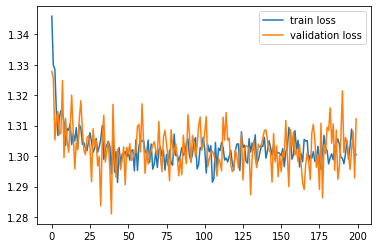

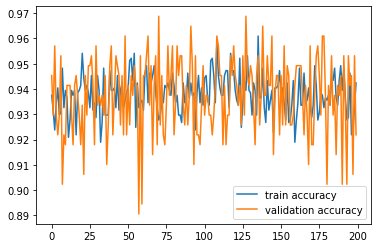

In [420]:
x = np.arange(total_epochs)
plt.plot(x,OTF_train_loss,label='train loss')
plt.plot(x,OTF_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,OTF_train_accuracy,label='train accuracy')
plt.plot(x,OTF_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(OTN_train_loss,OTN_validate_loss,OTN_train_accuracy,OTN_validate_accuracy))
frame.to_csv("OTN.csv")

In [281]:
OTF_validate_loss = []
OTF_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, OT_MatchingNet, OT_scheduler, use_cuda, False)
        OTF_validate_loss.append(v_loss)
        OTF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:12,  2.75it/s]

Epoch 0: validate_loss:1.3049560189247131 validate_accuracy:0.91015625


  1%|▊                                                                                 | 2/200 [00:00<01:10,  2.80it/s]

Epoch 1: validate_loss:1.3095440492033958 validate_accuracy:0.8984375


  2%|█▏                                                                                | 3/200 [00:01<01:09,  2.84it/s]

Epoch 2: validate_loss:1.296403519809246 validate_accuracy:0.9453125


  2%|█▋                                                                                | 4/200 [00:01<01:08,  2.86it/s]

Epoch 3: validate_loss:1.2965588718652725 validate_accuracy:0.94921875


  2%|██                                                                                | 5/200 [00:01<01:07,  2.88it/s]

Epoch 4: validate_loss:1.3073158040642738 validate_accuracy:0.93359375


  3%|██▍                                                                               | 6/200 [00:02<01:07,  2.89it/s]

Epoch 5: validate_loss:1.3161645010113716 validate_accuracy:0.9453125


  4%|██▊                                                                               | 7/200 [00:02<01:06,  2.90it/s]

Epoch 6: validate_loss:1.30137350410223 validate_accuracy:0.95703125


  4%|███▎                                                                              | 8/200 [00:02<01:06,  2.90it/s]

Epoch 7: validate_loss:1.2983977571129799 validate_accuracy:0.91796875


  4%|███▋                                                                              | 9/200 [00:03<01:05,  2.91it/s]

Epoch 8: validate_loss:1.3031614050269127 validate_accuracy:0.9453125


  5%|████                                                                             | 10/200 [00:03<01:05,  2.89it/s]

Epoch 9: validate_loss:1.3047941029071808 validate_accuracy:0.9296875


  6%|████▍                                                                            | 11/200 [00:03<01:05,  2.89it/s]

Epoch 10: validate_loss:1.3080174699425697 validate_accuracy:0.92578125


  6%|████▊                                                                            | 12/200 [00:04<01:04,  2.90it/s]

Epoch 11: validate_loss:1.3239640966057777 validate_accuracy:0.9375


  6%|█████▎                                                                           | 13/200 [00:04<01:04,  2.90it/s]

Epoch 12: validate_loss:1.3135913759469986 validate_accuracy:0.92578125


  7%|█████▋                                                                           | 14/200 [00:04<01:04,  2.91it/s]

Epoch 13: validate_loss:1.2958427220582962 validate_accuracy:0.94921875


  8%|██████                                                                           | 15/200 [00:05<01:03,  2.91it/s]

Epoch 14: validate_loss:1.295740932226181 validate_accuracy:0.94921875


  8%|██████▍                                                                          | 16/200 [00:05<01:03,  2.89it/s]

Epoch 15: validate_loss:1.2949252352118492 validate_accuracy:0.94921875


  8%|██████▉                                                                          | 17/200 [00:05<01:03,  2.89it/s]

Epoch 16: validate_loss:1.3047533184289932 validate_accuracy:0.9375


  9%|███████▎                                                                         | 18/200 [00:06<01:02,  2.90it/s]

Epoch 17: validate_loss:1.2887911275029182 validate_accuracy:0.95703125


 10%|███████▋                                                                         | 19/200 [00:06<01:02,  2.90it/s]

Epoch 18: validate_loss:1.2973249554634094 validate_accuracy:0.94921875


 10%|████████                                                                         | 20/200 [00:06<01:02,  2.90it/s]

Epoch 19: validate_loss:1.3113413453102112 validate_accuracy:0.9140625


 10%|████████▌                                                                        | 21/200 [00:07<01:02,  2.85it/s]

Epoch 20: validate_loss:1.289734810590744 validate_accuracy:0.96484375


 11%|████████▉                                                                        | 22/200 [00:07<01:02,  2.86it/s]

Epoch 21: validate_loss:1.2927778884768486 validate_accuracy:0.9453125


 12%|█████████▎                                                                       | 23/200 [00:07<01:01,  2.88it/s]

Epoch 22: validate_loss:1.307111993432045 validate_accuracy:0.9453125


 12%|█████████▋                                                                       | 24/200 [00:08<01:01,  2.87it/s]

Epoch 23: validate_loss:1.2936694771051407 validate_accuracy:0.953125


 12%|██████████▏                                                                      | 25/200 [00:08<01:01,  2.84it/s]

Epoch 24: validate_loss:1.303739309310913 validate_accuracy:0.94140625


 13%|██████████▌                                                                      | 26/200 [00:09<01:00,  2.86it/s]

Epoch 25: validate_loss:1.2928938120603561 validate_accuracy:0.953125


 14%|██████████▉                                                                      | 27/200 [00:09<01:00,  2.87it/s]

Epoch 26: validate_loss:1.2999503165483475 validate_accuracy:0.91796875


 14%|███████████▎                                                                     | 28/200 [00:09<00:59,  2.88it/s]

Epoch 27: validate_loss:1.3069764599204063 validate_accuracy:0.92578125


 14%|███████████▋                                                                     | 29/200 [00:10<00:59,  2.89it/s]

Epoch 28: validate_loss:1.302940957248211 validate_accuracy:0.96484375


 15%|████████████▏                                                                    | 30/200 [00:10<00:59,  2.87it/s]

Epoch 29: validate_loss:1.311263531446457 validate_accuracy:0.8984375


 16%|████████████▌                                                                    | 31/200 [00:10<00:58,  2.88it/s]

Epoch 30: validate_loss:1.306017443537712 validate_accuracy:0.91796875


 16%|████████████▉                                                                    | 32/200 [00:11<00:58,  2.89it/s]

Epoch 31: validate_loss:1.2979974374175072 validate_accuracy:0.94921875


 16%|█████████████▎                                                                   | 33/200 [00:11<00:57,  2.89it/s]

Epoch 32: validate_loss:1.2921476662158966 validate_accuracy:0.96484375


 17%|█████████████▊                                                                   | 34/200 [00:11<00:57,  2.90it/s]

Epoch 33: validate_loss:1.3011549338698387 validate_accuracy:0.93359375


 18%|██████████████▏                                                                  | 35/200 [00:12<00:57,  2.88it/s]

Epoch 34: validate_loss:1.290136843919754 validate_accuracy:0.93359375


 18%|██████████████▌                                                                  | 36/200 [00:12<00:56,  2.89it/s]

Epoch 35: validate_loss:1.2948123067617416 validate_accuracy:0.9375


 18%|██████████████▉                                                                  | 37/200 [00:12<00:56,  2.90it/s]

Epoch 36: validate_loss:1.3060776069760323 validate_accuracy:0.92578125


 19%|███████████████▍                                                                 | 38/200 [00:13<00:55,  2.90it/s]

Epoch 37: validate_loss:1.3005453497171402 validate_accuracy:0.93359375


 20%|███████████████▊                                                                 | 39/200 [00:13<00:56,  2.86it/s]

Epoch 38: validate_loss:1.3022581785917282 validate_accuracy:0.9375


 20%|████████████████▏                                                                | 40/200 [00:13<00:55,  2.86it/s]

Epoch 39: validate_loss:1.3044512569904327 validate_accuracy:0.96875


 20%|████████████████▌                                                                | 41/200 [00:14<00:55,  2.85it/s]

Epoch 40: validate_loss:1.3058714345097542 validate_accuracy:0.91796875


 21%|█████████████████                                                                | 42/200 [00:14<00:55,  2.84it/s]

Epoch 41: validate_loss:1.2909836173057556 validate_accuracy:0.94140625


 22%|█████████████████▍                                                               | 43/200 [00:14<00:54,  2.86it/s]

Epoch 42: validate_loss:1.2998565956950188 validate_accuracy:0.91796875


 22%|█████████████████▊                                                               | 44/200 [00:15<00:54,  2.87it/s]

Epoch 43: validate_loss:1.2898013591766357 validate_accuracy:0.94921875


 22%|██████████████████▏                                                              | 45/200 [00:15<00:54,  2.85it/s]

Epoch 44: validate_loss:1.2901396229863167 validate_accuracy:0.94140625


 23%|██████████████████▋                                                              | 46/200 [00:15<00:53,  2.87it/s]

Epoch 45: validate_loss:1.3018477484583855 validate_accuracy:0.91796875


 24%|███████████████████                                                              | 47/200 [00:16<00:53,  2.85it/s]

Epoch 46: validate_loss:1.2903104051947594 validate_accuracy:0.9453125


 24%|███████████████████▍                                                             | 48/200 [00:16<00:53,  2.84it/s]

Epoch 47: validate_loss:1.2860742881894112 validate_accuracy:0.9609375


 24%|███████████████████▊                                                             | 49/200 [00:17<00:53,  2.83it/s]

Epoch 48: validate_loss:1.3103010058403015 validate_accuracy:0.9375


 25%|████████████████████▎                                                            | 50/200 [00:17<00:52,  2.83it/s]

Epoch 49: validate_loss:1.2924345210194588 validate_accuracy:0.97265625


 26%|████████████████████▋                                                            | 51/200 [00:17<00:52,  2.85it/s]

Epoch 50: validate_loss:1.3094386905431747 validate_accuracy:0.90625


 26%|█████████████████████                                                            | 52/200 [00:18<00:51,  2.87it/s]

Epoch 51: validate_loss:1.291229285299778 validate_accuracy:0.93359375


 26%|█████████████████████▍                                                           | 53/200 [00:18<00:51,  2.88it/s]

Epoch 52: validate_loss:1.3037865161895752 validate_accuracy:0.9375


 27%|█████████████████████▊                                                           | 54/200 [00:18<00:50,  2.88it/s]

Epoch 53: validate_loss:1.296431303024292 validate_accuracy:0.9609375


 28%|██████████████████████▎                                                          | 55/200 [00:19<00:50,  2.89it/s]

Epoch 54: validate_loss:1.3042364493012428 validate_accuracy:0.94140625


 28%|██████████████████████▋                                                          | 56/200 [00:19<00:50,  2.88it/s]

Epoch 55: validate_loss:1.3056595772504807 validate_accuracy:0.91796875


 28%|███████████████████████                                                          | 57/200 [00:19<00:49,  2.89it/s]

Epoch 56: validate_loss:1.2989730909466743 validate_accuracy:0.9296875


 29%|███████████████████████▍                                                         | 58/200 [00:20<00:49,  2.90it/s]

Epoch 57: validate_loss:1.3035927265882492 validate_accuracy:0.921875


 30%|███████████████████████▉                                                         | 59/200 [00:20<00:48,  2.90it/s]

Epoch 58: validate_loss:1.2854979485273361 validate_accuracy:0.93359375


 30%|████████████████████████▎                                                        | 60/200 [00:20<00:48,  2.90it/s]

Epoch 59: validate_loss:1.299188807606697 validate_accuracy:0.921875


 30%|████████████████████████▋                                                        | 61/200 [00:21<00:48,  2.90it/s]

Epoch 60: validate_loss:1.3004942163825035 validate_accuracy:0.9296875


 31%|█████████████████████████                                                        | 62/200 [00:21<00:47,  2.89it/s]

Epoch 61: validate_loss:1.2992713302373886 validate_accuracy:0.94140625


 32%|█████████████████████████▌                                                       | 63/200 [00:21<00:47,  2.91it/s]

Epoch 62: validate_loss:1.2910800874233246 validate_accuracy:0.94140625


 32%|█████████████████████████▉                                                       | 64/200 [00:22<00:46,  2.90it/s]

Epoch 63: validate_loss:1.308753363788128 validate_accuracy:0.90234375


 32%|██████████████████████████▎                                                      | 65/200 [00:22<00:46,  2.90it/s]

Epoch 64: validate_loss:1.306598111987114 validate_accuracy:0.94140625


 33%|██████████████████████████▋                                                      | 66/200 [00:22<00:46,  2.89it/s]

Epoch 65: validate_loss:1.312866933643818 validate_accuracy:0.91015625


 34%|███████████████████████████▏                                                     | 67/200 [00:23<00:46,  2.89it/s]

Epoch 66: validate_loss:1.3068353459239006 validate_accuracy:0.9453125


 34%|███████████████████████████▌                                                     | 68/200 [00:23<00:45,  2.89it/s]

Epoch 67: validate_loss:1.30552788823843 validate_accuracy:0.94140625


 34%|███████████████████████████▉                                                     | 69/200 [00:23<00:45,  2.90it/s]

Epoch 68: validate_loss:1.3012876436114311 validate_accuracy:0.92578125


 35%|████████████████████████████▎                                                    | 70/200 [00:24<00:44,  2.90it/s]

Epoch 69: validate_loss:1.2995291575789452 validate_accuracy:0.9375


 36%|████████████████████████████▊                                                    | 71/200 [00:24<00:44,  2.91it/s]

Epoch 70: validate_loss:1.295931912958622 validate_accuracy:0.9375


 36%|█████████████████████████████▏                                                   | 72/200 [00:24<00:44,  2.91it/s]

Epoch 71: validate_loss:1.2996918559074402 validate_accuracy:0.92578125


 36%|█████████████████████████████▌                                                   | 73/200 [00:25<00:43,  2.91it/s]

Epoch 72: validate_loss:1.3052329644560814 validate_accuracy:0.9140625


 37%|█████████████████████████████▉                                                   | 74/200 [00:25<00:43,  2.91it/s]

Epoch 73: validate_loss:1.3008951991796494 validate_accuracy:0.93359375


 38%|██████████████████████████████▍                                                  | 75/200 [00:26<00:42,  2.92it/s]

Epoch 74: validate_loss:1.295590728521347 validate_accuracy:0.953125


 38%|██████████████████████████████▊                                                  | 76/200 [00:26<00:42,  2.91it/s]

Epoch 75: validate_loss:1.295996218919754 validate_accuracy:0.91796875


 38%|███████████████████████████████▏                                                 | 77/200 [00:26<00:42,  2.92it/s]

Epoch 76: validate_loss:1.2988450229167938 validate_accuracy:0.92578125


 39%|███████████████████████████████▌                                                 | 78/200 [00:27<00:41,  2.91it/s]

Epoch 77: validate_loss:1.3012697771191597 validate_accuracy:0.92578125


 40%|███████████████████████████████▉                                                 | 79/200 [00:27<00:41,  2.91it/s]

Epoch 78: validate_loss:1.2996406555175781 validate_accuracy:0.9453125


 40%|████████████████████████████████▍                                                | 80/200 [00:27<00:41,  2.91it/s]

Epoch 79: validate_loss:1.2953035980463028 validate_accuracy:0.9140625


 40%|████████████████████████████████▊                                                | 81/200 [00:28<00:40,  2.91it/s]

Epoch 80: validate_loss:1.3047360628843307 validate_accuracy:0.921875


 41%|█████████████████████████████████▏                                               | 82/200 [00:28<00:40,  2.91it/s]

Epoch 81: validate_loss:1.3026419058442116 validate_accuracy:0.921875


 42%|█████████████████████████████████▌                                               | 83/200 [00:28<00:40,  2.92it/s]

Epoch 82: validate_loss:1.3002194166183472 validate_accuracy:0.9296875


 42%|██████████████████████████████████                                               | 84/200 [00:29<00:39,  2.91it/s]

Epoch 83: validate_loss:1.2991574555635452 validate_accuracy:0.94140625


 42%|██████████████████████████████████▍                                              | 85/200 [00:29<00:39,  2.91it/s]

Epoch 84: validate_loss:1.2962126582860947 validate_accuracy:0.92578125


 43%|██████████████████████████████████▊                                              | 86/200 [00:29<00:39,  2.91it/s]

Epoch 85: validate_loss:1.2927600368857384 validate_accuracy:0.94921875


 44%|███████████████████████████████████▏                                             | 87/200 [00:30<00:39,  2.87it/s]

Epoch 86: validate_loss:1.2994891852140427 validate_accuracy:0.9375


 44%|███████████████████████████████████▋                                             | 88/200 [00:30<00:38,  2.88it/s]

Epoch 87: validate_loss:1.3070200756192207 validate_accuracy:0.93359375


 44%|████████████████████████████████████                                             | 89/200 [00:30<00:38,  2.90it/s]

Epoch 88: validate_loss:1.304506778717041 validate_accuracy:0.9375


 45%|████████████████████████████████████▍                                            | 90/200 [00:31<00:37,  2.90it/s]

Epoch 89: validate_loss:1.302907019853592 validate_accuracy:0.9296875


 46%|████████████████████████████████████▊                                            | 91/200 [00:31<00:37,  2.90it/s]

Epoch 90: validate_loss:1.29827481508255 validate_accuracy:0.94140625


 46%|█████████████████████████████████████▎                                           | 92/200 [00:31<00:37,  2.90it/s]

Epoch 91: validate_loss:1.3003914952278137 validate_accuracy:0.94140625


 46%|█████████████████████████████████████▋                                           | 93/200 [00:32<00:36,  2.90it/s]

Epoch 92: validate_loss:1.2964300587773323 validate_accuracy:0.9375


 47%|██████████████████████████████████████                                           | 94/200 [00:32<00:36,  2.91it/s]

Epoch 93: validate_loss:1.2986644729971886 validate_accuracy:0.9453125


 48%|██████████████████████████████████████▍                                          | 95/200 [00:32<00:36,  2.89it/s]

Epoch 94: validate_loss:1.2961516976356506 validate_accuracy:0.9296875


 48%|██████████████████████████████████████▉                                          | 96/200 [00:33<00:36,  2.88it/s]

Epoch 95: validate_loss:1.2935586050152779 validate_accuracy:0.96484375


 48%|███████████████████████████████████████▎                                         | 97/200 [00:33<00:35,  2.89it/s]

Epoch 96: validate_loss:1.3012730702757835 validate_accuracy:0.9296875


 49%|███████████████████████████████████████▋                                         | 98/200 [00:33<00:35,  2.89it/s]

Epoch 97: validate_loss:1.3080101311206818 validate_accuracy:0.93359375


 50%|████████████████████████████████████████                                         | 99/200 [00:34<00:34,  2.90it/s]

Epoch 98: validate_loss:1.2931735888123512 validate_accuracy:0.9453125


 50%|████████████████████████████████████████                                        | 100/200 [00:34<00:34,  2.90it/s]

Epoch 99: validate_loss:1.2999184504151344 validate_accuracy:0.94140625


 50%|████████████████████████████████████████▍                                       | 101/200 [00:34<00:34,  2.90it/s]

Epoch 100: validate_loss:1.303607426583767 validate_accuracy:0.94140625


 51%|████████████████████████████████████████▊                                       | 102/200 [00:35<00:33,  2.91it/s]

Epoch 101: validate_loss:1.2932357788085938 validate_accuracy:0.921875


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:35<00:33,  2.91it/s]

Epoch 102: validate_loss:1.293852835893631 validate_accuracy:0.95703125


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:35<00:32,  2.91it/s]

Epoch 103: validate_loss:1.2974807173013687 validate_accuracy:0.9375


 52%|██████████████████████████████████████████                                      | 105/200 [00:36<00:32,  2.91it/s]

Epoch 104: validate_loss:1.3031411319971085 validate_accuracy:0.9453125


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:36<00:32,  2.92it/s]

Epoch 105: validate_loss:1.2978849560022354 validate_accuracy:0.94140625


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:37<00:31,  2.91it/s]

Epoch 106: validate_loss:1.3036471456289291 validate_accuracy:0.9375


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:37<00:31,  2.91it/s]

Epoch 107: validate_loss:1.2999073341488838 validate_accuracy:0.9609375


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:37<00:31,  2.91it/s]

Epoch 108: validate_loss:1.2834028452634811 validate_accuracy:0.94921875


 55%|████████████████████████████████████████████                                    | 110/200 [00:38<00:31,  2.90it/s]

Epoch 109: validate_loss:1.311474122107029 validate_accuracy:0.91796875


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:38<00:30,  2.91it/s]

Epoch 110: validate_loss:1.294269599020481 validate_accuracy:0.94921875


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:38<00:30,  2.91it/s]

Epoch 111: validate_loss:1.3060415387153625 validate_accuracy:0.92578125


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:39<00:29,  2.91it/s]

Epoch 112: validate_loss:1.3053759410977364 validate_accuracy:0.9296875


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:39<00:29,  2.92it/s]

Epoch 113: validate_loss:1.2962568402290344 validate_accuracy:0.94140625


 57%|██████████████████████████████████████████████                                  | 115/200 [00:39<00:29,  2.92it/s]

Epoch 114: validate_loss:1.3067804053425789 validate_accuracy:0.921875


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:40<00:28,  2.91it/s]

Epoch 115: validate_loss:1.3005769923329353 validate_accuracy:0.94140625


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:40<00:28,  2.91it/s]

Epoch 116: validate_loss:1.2994346022605896 validate_accuracy:0.91796875


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:40<00:28,  2.91it/s]

Epoch 117: validate_loss:1.2975267097353935 validate_accuracy:0.91796875


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:41<00:27,  2.91it/s]

Epoch 118: validate_loss:1.2941315099596977 validate_accuracy:0.953125


 60%|████████████████████████████████████████████████                                | 120/200 [00:41<00:27,  2.91it/s]

Epoch 119: validate_loss:1.3030651733279228 validate_accuracy:0.93359375


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:41<00:27,  2.92it/s]

Epoch 120: validate_loss:1.2979965433478355 validate_accuracy:0.9453125


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:42<00:26,  2.92it/s]

Epoch 121: validate_loss:1.3006292656064034 validate_accuracy:0.91796875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:42<00:26,  2.92it/s]

Epoch 122: validate_loss:1.3012945502996445 validate_accuracy:0.9296875


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:42<00:26,  2.92it/s]

Epoch 123: validate_loss:1.2866327986121178 validate_accuracy:0.9453125


 62%|██████████████████████████████████████████████████                              | 125/200 [00:43<00:25,  2.92it/s]

Epoch 124: validate_loss:1.298470675945282 validate_accuracy:0.9296875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:43<00:25,  2.92it/s]

Epoch 125: validate_loss:1.3117421567440033 validate_accuracy:0.9296875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:43<00:25,  2.92it/s]

Epoch 126: validate_loss:1.2861818000674248 validate_accuracy:0.953125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:44<00:24,  2.92it/s]

Epoch 127: validate_loss:1.293661154806614 validate_accuracy:0.94921875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:44<00:24,  2.92it/s]

Epoch 128: validate_loss:1.2868881300091743 validate_accuracy:0.953125


 65%|████████████████████████████████████████████████████                            | 130/200 [00:44<00:23,  2.92it/s]

Epoch 129: validate_loss:1.30926413834095 validate_accuracy:0.90234375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:45<00:23,  2.91it/s]

Epoch 130: validate_loss:1.2981696352362633 validate_accuracy:0.9296875


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:45<00:23,  2.91it/s]

Epoch 131: validate_loss:1.2828073874115944 validate_accuracy:0.9609375


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:45<00:22,  2.92it/s]

Epoch 132: validate_loss:1.300442412495613 validate_accuracy:0.93359375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:46<00:22,  2.91it/s]

Epoch 133: validate_loss:1.3005934208631516 validate_accuracy:0.93359375


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:46<00:22,  2.91it/s]

Epoch 134: validate_loss:1.2953378409147263 validate_accuracy:0.9296875


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:46<00:21,  2.91it/s]

Epoch 135: validate_loss:1.3018260821700096 validate_accuracy:0.953125


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:47<00:21,  2.90it/s]

Epoch 136: validate_loss:1.3015757352113724 validate_accuracy:0.94140625


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:47<00:21,  2.91it/s]

Epoch 137: validate_loss:1.3067635595798492 validate_accuracy:0.91796875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:48<00:21,  2.90it/s]

Epoch 138: validate_loss:1.312966801226139 validate_accuracy:0.9140625


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:48<00:20,  2.90it/s]

Epoch 139: validate_loss:1.282763458788395 validate_accuracy:0.9296875


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:48<00:20,  2.88it/s]

Epoch 140: validate_loss:1.307532623410225 validate_accuracy:0.93359375


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:49<00:20,  2.88it/s]

Epoch 141: validate_loss:1.2884201928973198 validate_accuracy:0.96484375


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:49<00:19,  2.86it/s]

Epoch 142: validate_loss:1.2992440313100815 validate_accuracy:0.92578125


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:49<00:19,  2.87it/s]

Epoch 143: validate_loss:1.3028092458844185 validate_accuracy:0.92578125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:50<00:19,  2.88it/s]

Epoch 144: validate_loss:1.3089948371052742 validate_accuracy:0.921875


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:50<00:18,  2.88it/s]

Epoch 145: validate_loss:1.2962422370910645 validate_accuracy:0.953125


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:50<00:18,  2.89it/s]

Epoch 146: validate_loss:1.3042580261826515 validate_accuracy:0.91796875


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:51<00:17,  2.90it/s]

Epoch 147: validate_loss:1.3019348829984665 validate_accuracy:0.94140625


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:51<00:17,  2.90it/s]

Epoch 148: validate_loss:1.3121505081653595 validate_accuracy:0.90625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:51<00:17,  2.91it/s]

Epoch 149: validate_loss:1.2921653389930725 validate_accuracy:0.94921875


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:52<00:16,  2.90it/s]

Epoch 150: validate_loss:1.2961841598153114 validate_accuracy:0.94140625


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:52<00:16,  2.90it/s]

Epoch 151: validate_loss:1.2992209568619728 validate_accuracy:0.921875


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:52<00:16,  2.90it/s]

Epoch 152: validate_loss:1.3067628666758537 validate_accuracy:0.9296875


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:53<00:15,  2.91it/s]

Epoch 153: validate_loss:1.2947212532162666 validate_accuracy:0.94921875


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:53<00:15,  2.91it/s]

Epoch 154: validate_loss:1.306271031498909 validate_accuracy:0.90234375


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:53<00:15,  2.91it/s]

Epoch 155: validate_loss:1.2952830269932747 validate_accuracy:0.9375


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:54<00:14,  2.91it/s]

Epoch 156: validate_loss:1.3034347593784332 validate_accuracy:0.9296875


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:54<00:14,  2.91it/s]

Epoch 157: validate_loss:1.2962836474180222 validate_accuracy:0.96875


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:54<00:14,  2.91it/s]

Epoch 158: validate_loss:1.3135788589715958 validate_accuracy:0.90234375


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:55<00:13,  2.92it/s]

Epoch 159: validate_loss:1.3073590993881226 validate_accuracy:0.9375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:55<00:13,  2.92it/s]

Epoch 160: validate_loss:1.3043985962867737 validate_accuracy:0.921875


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:55<00:13,  2.92it/s]

Epoch 161: validate_loss:1.3117772787809372 validate_accuracy:0.921875


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:56<00:12,  2.91it/s]

Epoch 162: validate_loss:1.297971747815609 validate_accuracy:0.9453125


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:56<00:12,  2.89it/s]

Epoch 163: validate_loss:1.3080545738339424 validate_accuracy:0.9375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:56<00:12,  2.90it/s]

Epoch 164: validate_loss:1.29518511146307 validate_accuracy:0.93359375


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:57<00:11,  2.90it/s]

Epoch 165: validate_loss:1.2956392243504524 validate_accuracy:0.95703125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:57<00:11,  2.91it/s]

Epoch 166: validate_loss:1.3080463781952858 validate_accuracy:0.94140625


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:58<00:10,  2.92it/s]

Epoch 167: validate_loss:1.2935869470238686 validate_accuracy:0.921875


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:58<00:10,  2.92it/s]

Epoch 168: validate_loss:1.3060154542326927 validate_accuracy:0.95703125


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:58<00:10,  2.92it/s]

Epoch 169: validate_loss:1.2954176887869835 validate_accuracy:0.93359375


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:59<00:09,  2.92it/s]

Epoch 170: validate_loss:1.2964095771312714 validate_accuracy:0.95703125


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [00:59<00:09,  2.92it/s]

Epoch 171: validate_loss:1.3039920553565025 validate_accuracy:0.89453125


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [00:59<00:09,  2.92it/s]

Epoch 172: validate_loss:1.3052803352475166 validate_accuracy:0.92578125


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:00<00:08,  2.92it/s]

Epoch 173: validate_loss:1.29705148935318 validate_accuracy:0.91796875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:00<00:08,  2.91it/s]

Epoch 174: validate_loss:1.3005464226007462 validate_accuracy:0.9453125


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:00<00:08,  2.91it/s]

Epoch 175: validate_loss:1.292576514184475 validate_accuracy:0.9375


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:01<00:07,  2.92it/s]

Epoch 176: validate_loss:1.3034878000617027 validate_accuracy:0.9296875


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:01<00:07,  2.92it/s]

Epoch 177: validate_loss:1.3064865320920944 validate_accuracy:0.93359375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:01<00:07,  2.92it/s]

Epoch 178: validate_loss:1.2979295328259468 validate_accuracy:0.95703125


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:02<00:06,  2.92it/s]

Epoch 179: validate_loss:1.3119939267635345 validate_accuracy:0.9375


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:02<00:06,  2.92it/s]

Epoch 180: validate_loss:1.2915320694446564 validate_accuracy:0.9453125


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:02<00:06,  2.92it/s]

Epoch 181: validate_loss:1.317489892244339 validate_accuracy:0.8984375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:03<00:05,  2.92it/s]

Epoch 182: validate_loss:1.2962363958358765 validate_accuracy:0.9453125


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:03<00:05,  2.91it/s]

Epoch 183: validate_loss:1.3054142445325851 validate_accuracy:0.90625


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:03<00:05,  2.91it/s]

Epoch 184: validate_loss:1.3065838664770126 validate_accuracy:0.92578125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:04<00:04,  2.91it/s]

Epoch 185: validate_loss:1.3095836490392685 validate_accuracy:0.921875


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:04<00:04,  2.91it/s]

Epoch 186: validate_loss:1.2989241033792496 validate_accuracy:0.95703125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:04<00:04,  2.91it/s]

Epoch 187: validate_loss:1.3108322322368622 validate_accuracy:0.92578125


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:05<00:03,  2.92it/s]

Epoch 188: validate_loss:1.2892494052648544 validate_accuracy:0.94921875


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:05<00:03,  2.92it/s]

Epoch 189: validate_loss:1.29779202491045 validate_accuracy:0.94921875


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:05<00:03,  2.91it/s]

Epoch 190: validate_loss:1.2851177677512169 validate_accuracy:0.953125


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:06<00:02,  2.92it/s]

Epoch 191: validate_loss:1.305629201233387 validate_accuracy:0.9140625


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:06<00:02,  2.92it/s]

Epoch 192: validate_loss:1.291041262447834 validate_accuracy:0.9609375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:06<00:02,  2.91it/s]

Epoch 193: validate_loss:1.2987897843122482 validate_accuracy:0.9296875


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:07<00:01,  2.91it/s]

Epoch 194: validate_loss:1.293700635433197 validate_accuracy:0.94921875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:07<00:01,  2.91it/s]

Epoch 195: validate_loss:1.2832030281424522 validate_accuracy:0.95703125


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:07<00:01,  2.91it/s]

Epoch 196: validate_loss:1.3147680014371872 validate_accuracy:0.9140625


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:08<00:00,  2.92it/s]

Epoch 197: validate_loss:1.3052027449011803 validate_accuracy:0.91796875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:08<00:00,  2.92it/s]

Epoch 198: validate_loss:1.2935469523072243 validate_accuracy:0.94140625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:08<00:00,  2.90it/s]

Epoch 199: validate_loss:1.3007574751973152 validate_accuracy:0.93359375


In [282]:
np.mean(OTF_validate_accuracy)

0.93548828125

# Start with trained: Cifar

In [288]:
dataC = CifarNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

In [289]:
cifarC = CifarClassifier(layer_size=64, nClasses = 64, num_channels = 3, keep_prob = 0.0, image_size = 32, freeze = False)
optimizerC = torch.optim.Adam(cifarC.parameters(), lr=1e-3)

In [295]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        loss, acc = PreTraining(dataC,cifarC,optimizerC,32,True)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, loss, acc))
        pbar_e.update(1)

 10%|████████▎                                                                          | 1/10 [00:07<01:06,  7.42s/it]

Epoch 0: train_loss:0.35190628515556455 train_accuracy:0.892578125


 20%|████████████████▌                                                                  | 2/10 [00:14<00:59,  7.39s/it]

Epoch 1: train_loss:0.33355236472561955 train_accuracy:0.89501953125


 30%|████████████████████████▉                                                          | 3/10 [00:22<00:51,  7.37s/it]

Epoch 2: train_loss:0.35252279974520206 train_accuracy:0.894775390625


 40%|█████████████████████████████████▏                                                 | 4/10 [00:29<00:44,  7.50s/it]

Epoch 3: train_loss:0.3232137016020715 train_accuracy:0.90185546875


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:37<00:38,  7.64s/it]

Epoch 4: train_loss:0.3032146249897778 train_accuracy:0.90625


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:45<00:30,  7.73s/it]

Epoch 5: train_loss:0.3419556962326169 train_accuracy:0.894775390625


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:53<00:23,  7.73s/it]

Epoch 6: train_loss:0.332679639570415 train_accuracy:0.89697265625


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:01<00:15,  7.72s/it]

Epoch 7: train_loss:0.3182309987023473 train_accuracy:0.9033203125


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:09<00:07,  7.79s/it]

Epoch 8: train_loss:0.30668780906125903 train_accuracy:0.905029296875


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.78s/it]

Epoch 9: train_loss:0.29352767765522003 train_accuracy:0.909912109375


11it [01:24,  7.77s/it]                                                                                                

Epoch 10: train_loss:0.3045498807914555 train_accuracy:0.910400390625


12it [01:32,  7.81s/it]

Epoch 11: train_loss:0.2980901631526649 train_accuracy:0.916015625


13it [01:40,  7.86s/it]

Epoch 12: train_loss:0.2848804430104792 train_accuracy:0.909912109375


14it [01:48,  7.84s/it]

Epoch 13: train_loss:0.30696533992886543 train_accuracy:0.906005859375


15it [01:56,  7.88s/it]

Epoch 14: train_loss:0.2944172569550574 train_accuracy:0.912109375


16it [02:04,  7.86s/it]

Epoch 15: train_loss:0.3005124921910465 train_accuracy:0.9091796875


17it [02:11,  7.84s/it]

Epoch 16: train_loss:0.2678717547096312 train_accuracy:0.91796875


18it [02:19,  7.83s/it]

Epoch 17: train_loss:0.2649235986173153 train_accuracy:0.9169921875


19it [02:27,  7.83s/it]

Epoch 18: train_loss:0.24943180242553353 train_accuracy:0.9189453125


20it [02:35,  7.76s/it]

Epoch 19: train_loss:0.25826001167297363 train_accuracy:0.92041015625


In [296]:
torch.save(cifarC.state_dict(), 'Cnet_params.pth')

In [375]:
CT_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=False, image_size=32, use_cuda=True, model = 2)
pretrained_dict = torch.load('Cnet_params.pth')
model_dict = CT_MatchingNet.embedding.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)

In [376]:
CT_MatchingNet.embedding.load_state_dict(model_dict)
CT_MatchingNet.embedding.freeze()
CT_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, CT_MatchingNet.parameters()), lr=1e-5)
CT_scheduler = ReduceLROnPlateau(CT_optimizer, 'min',verbose=True)
CTN_validate_loss = []
CTN_validate_accuracy = []

In [377]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, CT_MatchingNet.cuda(), CT_scheduler, use_cuda, False)
        CTN_validate_loss.append(v_loss)
        CTN_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:32,  2.14it/s]

Epoch 0: validate_loss:1.533913530409336 validate_accuracy:0.4375


  1%|▊                                                                                 | 2/200 [00:00<01:31,  2.17it/s]

Epoch 1: validate_loss:1.533631332218647 validate_accuracy:0.41796875


  2%|█▏                                                                                | 3/200 [00:01<01:28,  2.22it/s]

Epoch 2: validate_loss:1.5305804163217545 validate_accuracy:0.4296875


  2%|█▋                                                                                | 4/200 [00:01<01:26,  2.27it/s]

Epoch 3: validate_loss:1.5389552116394043 validate_accuracy:0.39453125


  2%|██                                                                                | 5/200 [00:02<01:24,  2.31it/s]

Epoch 4: validate_loss:1.5409225672483444 validate_accuracy:0.41015625


  3%|██▍                                                                               | 6/200 [00:02<01:22,  2.34it/s]

Epoch 5: validate_loss:1.5224697664380074 validate_accuracy:0.47265625


  4%|██▊                                                                               | 7/200 [00:02<01:20,  2.39it/s]

Epoch 6: validate_loss:1.5222329795360565 validate_accuracy:0.44921875


  4%|███▎                                                                              | 8/200 [00:03<01:19,  2.41it/s]

Epoch 7: validate_loss:1.527811385691166 validate_accuracy:0.50390625


  4%|███▋                                                                              | 9/200 [00:03<01:18,  2.45it/s]

Epoch 8: validate_loss:1.5401702374219894 validate_accuracy:0.4140625


  5%|████                                                                             | 10/200 [00:04<01:16,  2.47it/s]

Epoch 9: validate_loss:1.542248211801052 validate_accuracy:0.42578125


  6%|████▍                                                                            | 11/200 [00:04<01:15,  2.49it/s]

Epoch 10: validate_loss:1.5305427238345146 validate_accuracy:0.4453125


  6%|████▊                                                                            | 12/200 [00:04<01:14,  2.51it/s]

Epoch 11: validate_loss:1.5345933064818382 validate_accuracy:0.4375


  6%|█████▎                                                                           | 13/200 [00:05<01:14,  2.50it/s]

Epoch 12: validate_loss:1.5347690731287003 validate_accuracy:0.4296875


  7%|█████▋                                                                           | 14/200 [00:05<01:14,  2.51it/s]

Epoch 13: validate_loss:1.5318883806467056 validate_accuracy:0.47265625


  8%|██████                                                                           | 15/200 [00:06<01:13,  2.51it/s]

Epoch 14: validate_loss:1.5468627735972404 validate_accuracy:0.39453125


  8%|██████▍                                                                          | 16/200 [00:06<01:12,  2.53it/s]

Epoch 15: validate_loss:1.5379212573170662 validate_accuracy:0.4296875


  8%|██████▉                                                                          | 17/200 [00:06<01:12,  2.54it/s]

Epoch 16: validate_loss:1.529420591890812 validate_accuracy:0.484375


  9%|███████▎                                                                         | 18/200 [00:07<01:11,  2.54it/s]

Epoch    18: reducing learning rate of group 0 to 1.0000e-06.
Epoch 17: validate_loss:1.5307241082191467 validate_accuracy:0.45703125


 10%|███████▋                                                                         | 19/200 [00:07<01:10,  2.55it/s]

Epoch 18: validate_loss:1.531640149652958 validate_accuracy:0.453125


 10%|████████                                                                         | 20/200 [00:08<01:10,  2.55it/s]

Epoch 19: validate_loss:1.5313171222805977 validate_accuracy:0.453125


 10%|████████▌                                                                        | 21/200 [00:08<01:10,  2.55it/s]

Epoch 20: validate_loss:1.5402626544237137 validate_accuracy:0.4296875


 11%|████████▉                                                                        | 22/200 [00:08<01:10,  2.53it/s]

Epoch 21: validate_loss:1.5417303964495659 validate_accuracy:0.44140625


 12%|█████████▎                                                                       | 23/200 [00:09<01:10,  2.51it/s]

Epoch 22: validate_loss:1.5402605831623077 validate_accuracy:0.4296875


 12%|█████████▋                                                                       | 24/200 [00:09<01:09,  2.52it/s]

Epoch 23: validate_loss:1.5348080769181252 validate_accuracy:0.453125


 12%|██████████▏                                                                      | 25/200 [00:10<01:09,  2.52it/s]

Epoch 24: validate_loss:1.5475814938545227 validate_accuracy:0.41796875


 13%|██████████▌                                                                      | 26/200 [00:10<01:08,  2.55it/s]

Epoch 25: validate_loss:1.542707622051239 validate_accuracy:0.41796875


 14%|██████████▉                                                                      | 27/200 [00:10<01:08,  2.54it/s]

Epoch 26: validate_loss:1.5338473692536354 validate_accuracy:0.44921875


 14%|███████████▎                                                                     | 28/200 [00:11<01:07,  2.53it/s]

Epoch 27: validate_loss:1.5383041054010391 validate_accuracy:0.3984375


 14%|███████████▋                                                                     | 29/200 [00:11<01:07,  2.53it/s]

Epoch    29: reducing learning rate of group 0 to 1.0000e-07.
Epoch 28: validate_loss:1.5328245908021927 validate_accuracy:0.48046875


 15%|████████████▏                                                                    | 30/200 [00:12<01:07,  2.52it/s]

Epoch 29: validate_loss:1.5434121042490005 validate_accuracy:0.40625


 16%|████████████▌                                                                    | 31/200 [00:12<01:06,  2.54it/s]

Epoch 30: validate_loss:1.5346656069159508 validate_accuracy:0.40625


 16%|████████████▉                                                                    | 32/200 [00:12<01:05,  2.55it/s]

Epoch 31: validate_loss:1.5477051213383675 validate_accuracy:0.37890625


 16%|█████████████▎                                                                   | 33/200 [00:13<01:05,  2.53it/s]

Epoch 32: validate_loss:1.5395540446043015 validate_accuracy:0.40625


 17%|█████████████▊                                                                   | 34/200 [00:13<01:04,  2.56it/s]

Epoch 33: validate_loss:1.540624238550663 validate_accuracy:0.39453125


 18%|██████████████▏                                                                  | 35/200 [00:14<01:05,  2.53it/s]

Epoch 34: validate_loss:1.5430774092674255 validate_accuracy:0.43359375


 18%|██████████████▌                                                                  | 36/200 [00:14<01:05,  2.51it/s]

Epoch 35: validate_loss:1.5379433259367943 validate_accuracy:0.4140625


 18%|██████████████▉                                                                  | 37/200 [00:14<01:04,  2.54it/s]

Epoch 36: validate_loss:1.5492341741919518 validate_accuracy:0.390625


 19%|███████████████▍                                                                 | 38/200 [00:15<01:03,  2.56it/s]

Epoch 37: validate_loss:1.5288264229893684 validate_accuracy:0.45703125


 20%|███████████████▊                                                                 | 39/200 [00:15<01:02,  2.56it/s]

Epoch 38: validate_loss:1.5358326435089111 validate_accuracy:0.4375


 20%|████████████████▏                                                                | 40/200 [00:16<01:02,  2.55it/s]

Epoch    40: reducing learning rate of group 0 to 1.0000e-08.
Epoch 39: validate_loss:1.5357370227575302 validate_accuracy:0.44140625


 20%|████████████████▌                                                                | 41/200 [00:16<01:02,  2.54it/s]

Epoch 40: validate_loss:1.5314797684550285 validate_accuracy:0.4453125


 21%|█████████████████                                                                | 42/200 [00:16<01:02,  2.51it/s]

Epoch 41: validate_loss:1.5436065047979355 validate_accuracy:0.4375


 22%|█████████████████▍                                                               | 43/200 [00:17<01:02,  2.51it/s]

Epoch 42: validate_loss:1.5433054715394974 validate_accuracy:0.41015625


 22%|█████████████████▊                                                               | 44/200 [00:17<01:02,  2.50it/s]

Epoch 43: validate_loss:1.5295016318559647 validate_accuracy:0.46484375


 22%|██████████████████▏                                                              | 45/200 [00:18<01:01,  2.50it/s]

Epoch 44: validate_loss:1.5368912816047668 validate_accuracy:0.4140625


 23%|██████████████████▋                                                              | 46/200 [00:18<01:01,  2.52it/s]

Epoch 45: validate_loss:1.544499658048153 validate_accuracy:0.38671875


 24%|███████████████████                                                              | 47/200 [00:18<01:00,  2.53it/s]

Epoch 46: validate_loss:1.539764866232872 validate_accuracy:0.3984375


 24%|███████████████████▍                                                             | 48/200 [00:19<01:00,  2.51it/s]

Epoch 47: validate_loss:1.54169262945652 validate_accuracy:0.421875


 24%|███████████████████▊                                                             | 49/200 [00:19<01:00,  2.51it/s]

Epoch 48: validate_loss:1.5493013635277748 validate_accuracy:0.38671875


 25%|████████████████████▎                                                            | 50/200 [00:19<00:59,  2.51it/s]

Epoch 49: validate_loss:1.5419158264994621 validate_accuracy:0.43359375


 26%|████████████████████▋                                                            | 51/200 [00:20<00:59,  2.51it/s]

Epoch 50: validate_loss:1.541310653090477 validate_accuracy:0.41796875


 26%|█████████████████████                                                            | 52/200 [00:20<00:59,  2.51it/s]

Epoch 51: validate_loss:1.5453193187713623 validate_accuracy:0.40234375


 26%|█████████████████████▍                                                           | 53/200 [00:21<00:58,  2.51it/s]

Epoch 52: validate_loss:1.5382137075066566 validate_accuracy:0.41796875


 27%|█████████████████████▊                                                           | 54/200 [00:21<00:58,  2.50it/s]

Epoch 53: validate_loss:1.529135100543499 validate_accuracy:0.453125


 28%|██████████████████████▎                                                          | 55/200 [00:21<00:58,  2.49it/s]

Epoch 54: validate_loss:1.5372625589370728 validate_accuracy:0.421875


 28%|██████████████████████▋                                                          | 56/200 [00:22<00:57,  2.50it/s]

Epoch 55: validate_loss:1.5451885387301445 validate_accuracy:0.40234375


 28%|███████████████████████                                                          | 57/200 [00:22<00:57,  2.50it/s]

Epoch 56: validate_loss:1.5389633774757385 validate_accuracy:0.4140625


 29%|███████████████████████▍                                                         | 58/200 [00:23<00:56,  2.50it/s]

Epoch 57: validate_loss:1.5467243045568466 validate_accuracy:0.38671875


 30%|███████████████████████▉                                                         | 59/200 [00:23<00:56,  2.51it/s]

Epoch 58: validate_loss:1.5523926317691803 validate_accuracy:0.421875


 30%|████████████████████████▎                                                        | 60/200 [00:23<00:55,  2.51it/s]

Epoch 59: validate_loss:1.5507083758711815 validate_accuracy:0.3984375


 30%|████████████████████████▋                                                        | 61/200 [00:24<00:55,  2.52it/s]

Epoch 60: validate_loss:1.5368785709142685 validate_accuracy:0.41796875


 31%|█████████████████████████                                                        | 62/200 [00:24<00:54,  2.52it/s]

Epoch 61: validate_loss:1.5432527214288712 validate_accuracy:0.3984375


 32%|█████████████████████████▌                                                       | 63/200 [00:25<00:54,  2.52it/s]

Epoch 62: validate_loss:1.5251270979642868 validate_accuracy:0.45703125


 32%|█████████████████████████▉                                                       | 64/200 [00:25<00:53,  2.52it/s]

Epoch 63: validate_loss:1.5403490290045738 validate_accuracy:0.40234375


 32%|██████████████████████████▎                                                      | 65/200 [00:25<00:53,  2.51it/s]

Epoch 64: validate_loss:1.545183576643467 validate_accuracy:0.41015625


 33%|██████████████████████████▋                                                      | 66/200 [00:26<00:53,  2.51it/s]

Epoch 65: validate_loss:1.5332059040665627 validate_accuracy:0.47265625


 34%|███████████████████████████▏                                                     | 67/200 [00:26<00:53,  2.51it/s]

Epoch 66: validate_loss:1.5430971905589104 validate_accuracy:0.390625


 34%|███████████████████████████▌                                                     | 68/200 [00:27<00:52,  2.51it/s]

Epoch 67: validate_loss:1.5330711379647255 validate_accuracy:0.45703125


 34%|███████████████████████████▉                                                     | 69/200 [00:27<00:51,  2.53it/s]

Epoch 68: validate_loss:1.5412135794758797 validate_accuracy:0.40234375


 35%|████████████████████████████▎                                                    | 70/200 [00:27<00:51,  2.52it/s]

Epoch 69: validate_loss:1.5444298088550568 validate_accuracy:0.421875


 36%|████████████████████████████▊                                                    | 71/200 [00:28<00:50,  2.53it/s]

Epoch 70: validate_loss:1.5333049297332764 validate_accuracy:0.42578125


 36%|█████████████████████████████▏                                                   | 72/200 [00:28<00:50,  2.53it/s]

Epoch 71: validate_loss:1.5392287820577621 validate_accuracy:0.41015625


 36%|█████████████████████████████▌                                                   | 73/200 [00:29<00:50,  2.52it/s]

Epoch 72: validate_loss:1.534649945795536 validate_accuracy:0.4375


 37%|█████████████████████████████▉                                                   | 74/200 [00:29<00:50,  2.52it/s]

Epoch 73: validate_loss:1.541654922068119 validate_accuracy:0.421875


 38%|██████████████████████████████▍                                                  | 75/200 [00:29<00:49,  2.52it/s]

Epoch 74: validate_loss:1.5525065660476685 validate_accuracy:0.40625


 38%|██████████████████████████████▊                                                  | 76/200 [00:30<00:49,  2.50it/s]

Epoch 75: validate_loss:1.526846595108509 validate_accuracy:0.46875


 38%|███████████████████████████████▏                                                 | 77/200 [00:30<00:48,  2.52it/s]

Epoch 76: validate_loss:1.5382148772478104 validate_accuracy:0.453125


 39%|███████████████████████████████▌                                                 | 78/200 [00:31<00:48,  2.53it/s]

Epoch 77: validate_loss:1.5427936539053917 validate_accuracy:0.40625


 40%|███████████████████████████████▉                                                 | 79/200 [00:31<00:47,  2.53it/s]

Epoch 78: validate_loss:1.5448949858546257 validate_accuracy:0.44140625


 40%|████████████████████████████████▍                                                | 80/200 [00:31<00:47,  2.53it/s]

Epoch 79: validate_loss:1.540775552392006 validate_accuracy:0.41015625


 40%|████████████████████████████████▊                                                | 81/200 [00:32<00:47,  2.53it/s]

Epoch 80: validate_loss:1.533011682331562 validate_accuracy:0.4296875


 41%|█████████████████████████████████▏                                               | 82/200 [00:32<00:46,  2.54it/s]

Epoch 81: validate_loss:1.5324657559394836 validate_accuracy:0.4375


 42%|█████████████████████████████████▌                                               | 83/200 [00:33<00:46,  2.54it/s]

Epoch 82: validate_loss:1.5318979024887085 validate_accuracy:0.4921875


 42%|██████████████████████████████████                                               | 84/200 [00:33<00:45,  2.53it/s]

Epoch 83: validate_loss:1.5313452929258347 validate_accuracy:0.41015625


 42%|██████████████████████████████████▍                                              | 85/200 [00:33<00:45,  2.54it/s]

Epoch 84: validate_loss:1.5425892546772957 validate_accuracy:0.40234375


 43%|██████████████████████████████████▊                                              | 86/200 [00:34<00:44,  2.54it/s]

Epoch 85: validate_loss:1.5291730090975761 validate_accuracy:0.43359375


 44%|███████████████████████████████████▏                                             | 87/200 [00:34<00:44,  2.54it/s]

Epoch 86: validate_loss:1.529186487197876 validate_accuracy:0.4296875


 44%|███████████████████████████████████▋                                             | 88/200 [00:35<00:44,  2.54it/s]

Epoch 87: validate_loss:1.5366069376468658 validate_accuracy:0.41015625


 44%|████████████████████████████████████                                             | 89/200 [00:35<00:43,  2.53it/s]

Epoch 88: validate_loss:1.5408672019839287 validate_accuracy:0.45703125


 45%|████████████████████████████████████▍                                            | 90/200 [00:35<00:43,  2.53it/s]

Epoch 89: validate_loss:1.542999267578125 validate_accuracy:0.3984375


 46%|████████████████████████████████████▊                                            | 91/200 [00:36<00:43,  2.53it/s]

Epoch 90: validate_loss:1.5253418609499931 validate_accuracy:0.48828125


 46%|█████████████████████████████████████▎                                           | 92/200 [00:36<00:42,  2.52it/s]

Epoch 91: validate_loss:1.5351587757468224 validate_accuracy:0.484375


 46%|█████████████████████████████████████▋                                           | 93/200 [00:37<00:42,  2.53it/s]

Epoch 92: validate_loss:1.5528425350785255 validate_accuracy:0.37109375


 47%|██████████████████████████████████████                                           | 94/200 [00:37<00:41,  2.53it/s]

Epoch 93: validate_loss:1.5361006185412407 validate_accuracy:0.42578125


 48%|██████████████████████████████████████▍                                          | 95/200 [00:37<00:41,  2.53it/s]

Epoch 94: validate_loss:1.5278238952159882 validate_accuracy:0.4375


 48%|██████████████████████████████████████▉                                          | 96/200 [00:38<00:41,  2.52it/s]

Epoch 95: validate_loss:1.5406901463866234 validate_accuracy:0.359375


 48%|███████████████████████████████████████▎                                         | 97/200 [00:38<00:40,  2.52it/s]

Epoch 96: validate_loss:1.5363651514053345 validate_accuracy:0.4453125


 49%|███████████████████████████████████████▋                                         | 98/200 [00:39<00:40,  2.53it/s]

Epoch 97: validate_loss:1.52720395475626 validate_accuracy:0.44921875


 50%|████████████████████████████████████████                                         | 99/200 [00:39<00:39,  2.53it/s]

Epoch 98: validate_loss:1.5345985442399979 validate_accuracy:0.46484375


 50%|████████████████████████████████████████                                        | 100/200 [00:39<00:39,  2.54it/s]

Epoch 99: validate_loss:1.5212712660431862 validate_accuracy:0.49609375


 50%|████████████████████████████████████████▍                                       | 101/200 [00:40<00:39,  2.53it/s]

Epoch 100: validate_loss:1.5287079513072968 validate_accuracy:0.46875


 51%|████████████████████████████████████████▊                                       | 102/200 [00:40<00:38,  2.52it/s]

Epoch 101: validate_loss:1.543546587228775 validate_accuracy:0.421875


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:41<00:38,  2.51it/s]

Epoch 102: validate_loss:1.5579423308372498 validate_accuracy:0.35546875


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:41<00:38,  2.51it/s]

Epoch 103: validate_loss:1.5392077043652534 validate_accuracy:0.41015625


 52%|██████████████████████████████████████████                                      | 105/200 [00:41<00:37,  2.51it/s]

Epoch 104: validate_loss:1.5437418147921562 validate_accuracy:0.39453125


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:42<00:37,  2.50it/s]

Epoch 105: validate_loss:1.550658866763115 validate_accuracy:0.4140625


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:42<00:37,  2.50it/s]

Epoch 106: validate_loss:1.5482091754674911 validate_accuracy:0.41015625


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:43<00:36,  2.49it/s]

Epoch 107: validate_loss:1.5287982299923897 validate_accuracy:0.40234375


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:43<00:36,  2.49it/s]

Epoch 108: validate_loss:1.5324990823864937 validate_accuracy:0.4140625


 55%|████████████████████████████████████████████                                    | 110/200 [00:43<00:36,  2.48it/s]

Epoch 109: validate_loss:1.5368918180465698 validate_accuracy:0.40234375


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:44<00:35,  2.49it/s]

Epoch 110: validate_loss:1.5348793491721153 validate_accuracy:0.4609375


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:44<00:35,  2.49it/s]

Epoch 111: validate_loss:1.5495470240712166 validate_accuracy:0.3515625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:45<00:34,  2.49it/s]

Epoch 112: validate_loss:1.5403102412819862 validate_accuracy:0.41015625


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:45<00:34,  2.50it/s]

Epoch 113: validate_loss:1.529541477560997 validate_accuracy:0.4921875


 57%|██████████████████████████████████████████████                                  | 115/200 [00:45<00:34,  2.49it/s]

Epoch 114: validate_loss:1.5458263084292412 validate_accuracy:0.4140625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:46<00:33,  2.47it/s]

Epoch 115: validate_loss:1.5252372100949287 validate_accuracy:0.46875


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:46<00:33,  2.48it/s]

Epoch 116: validate_loss:1.5433103367686272 validate_accuracy:0.44140625


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:47<00:33,  2.46it/s]

Epoch 117: validate_loss:1.5394730940461159 validate_accuracy:0.41796875


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:47<00:32,  2.46it/s]

Epoch 118: validate_loss:1.5414388328790665 validate_accuracy:0.42578125


 60%|████████████████████████████████████████████████                                | 120/200 [00:47<00:32,  2.47it/s]

Epoch 119: validate_loss:1.535148411989212 validate_accuracy:0.42578125


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:48<00:32,  2.47it/s]

Epoch 120: validate_loss:1.5320141911506653 validate_accuracy:0.43359375


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:48<00:31,  2.47it/s]

Epoch 121: validate_loss:1.5386962220072746 validate_accuracy:0.41796875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:49<00:31,  2.48it/s]

Epoch 122: validate_loss:1.527543269097805 validate_accuracy:0.4609375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:49<00:30,  2.49it/s]

Epoch 123: validate_loss:1.5350116193294525 validate_accuracy:0.41015625


 62%|██████████████████████████████████████████████████                              | 125/200 [00:49<00:29,  2.50it/s]

Epoch 124: validate_loss:1.5524326339364052 validate_accuracy:0.36328125


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:50<00:29,  2.50it/s]

Epoch 125: validate_loss:1.5358041748404503 validate_accuracy:0.421875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:50<00:29,  2.51it/s]

Epoch 126: validate_loss:1.5389432087540627 validate_accuracy:0.390625


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:51<00:28,  2.49it/s]

Epoch 127: validate_loss:1.5304735004901886 validate_accuracy:0.44921875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:51<00:28,  2.49it/s]

Epoch 128: validate_loss:1.5334535017609596 validate_accuracy:0.3984375


 65%|████████████████████████████████████████████████████                            | 130/200 [00:51<00:28,  2.49it/s]

Epoch 129: validate_loss:1.5309390723705292 validate_accuracy:0.4765625


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:52<00:27,  2.50it/s]

Epoch 130: validate_loss:1.53609286993742 validate_accuracy:0.43359375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:52<00:27,  2.51it/s]

Epoch 131: validate_loss:1.5409324020147324 validate_accuracy:0.40234375


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:53<00:26,  2.52it/s]

Epoch 132: validate_loss:1.5340087860822678 validate_accuracy:0.421875


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:53<00:26,  2.52it/s]

Epoch 133: validate_loss:1.545882411301136 validate_accuracy:0.359375


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:53<00:25,  2.53it/s]

Epoch 134: validate_loss:1.5431590005755424 validate_accuracy:0.40234375


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:54<00:25,  2.52it/s]

Epoch 135: validate_loss:1.5334091559052467 validate_accuracy:0.42578125


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:54<00:25,  2.50it/s]

Epoch 136: validate_loss:1.5234340056777 validate_accuracy:0.47265625


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:55<00:24,  2.49it/s]

Epoch 137: validate_loss:1.5347052589058876 validate_accuracy:0.48046875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:55<00:24,  2.50it/s]

Epoch 138: validate_loss:1.5451164916157722 validate_accuracy:0.41015625


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:55<00:23,  2.50it/s]

Epoch 139: validate_loss:1.5430810675024986 validate_accuracy:0.390625


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:56<00:23,  2.52it/s]

Epoch 140: validate_loss:1.5516054928302765 validate_accuracy:0.4140625


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:56<00:23,  2.52it/s]

Epoch 141: validate_loss:1.55508154630661 validate_accuracy:0.35546875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:57<00:22,  2.52it/s]

Epoch 142: validate_loss:1.543604589998722 validate_accuracy:0.40625


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:57<00:22,  2.52it/s]

Epoch 143: validate_loss:1.550508163869381 validate_accuracy:0.328125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:57<00:21,  2.53it/s]

Epoch 144: validate_loss:1.5456582307815552 validate_accuracy:0.37109375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:58<00:21,  2.52it/s]

Epoch 145: validate_loss:1.5393333286046982 validate_accuracy:0.43359375


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:58<00:21,  2.52it/s]

Epoch 146: validate_loss:1.5366283878684044 validate_accuracy:0.41015625


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:59<00:20,  2.52it/s]

Epoch 147: validate_loss:1.5445396453142166 validate_accuracy:0.42578125


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:59<00:20,  2.51it/s]

Epoch 148: validate_loss:1.5309982970356941 validate_accuracy:0.4296875


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:59<00:19,  2.52it/s]

Epoch 149: validate_loss:1.5349038541316986 validate_accuracy:0.43359375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [01:00<00:19,  2.53it/s]

Epoch 150: validate_loss:1.5478483140468597 validate_accuracy:0.38671875


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [01:00<00:18,  2.53it/s]

Epoch 151: validate_loss:1.5410151109099388 validate_accuracy:0.41796875


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [01:00<00:18,  2.52it/s]

Epoch 152: validate_loss:1.5515882819890976 validate_accuracy:0.40234375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [01:01<00:18,  2.52it/s]

Epoch 153: validate_loss:1.541015587747097 validate_accuracy:0.40234375


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [01:01<00:17,  2.51it/s]

Epoch 154: validate_loss:1.5416644588112831 validate_accuracy:0.44140625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [01:02<00:17,  2.50it/s]

Epoch 155: validate_loss:1.526458039879799 validate_accuracy:0.484375


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [01:02<00:17,  2.50it/s]

Epoch 156: validate_loss:1.534532904624939 validate_accuracy:0.45703125


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [01:02<00:16,  2.51it/s]

Epoch 157: validate_loss:1.535600833594799 validate_accuracy:0.4453125


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [01:03<00:16,  2.52it/s]

Epoch 158: validate_loss:1.5422102734446526 validate_accuracy:0.3828125


 80%|████████████████████████████████████████████████████████████████                | 160/200 [01:03<00:15,  2.52it/s]

Epoch 159: validate_loss:1.540161594748497 validate_accuracy:0.421875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:04<00:15,  2.52it/s]

Epoch 160: validate_loss:1.546142227947712 validate_accuracy:0.3984375


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [01:04<00:15,  2.50it/s]

Epoch 161: validate_loss:1.5294612124562263 validate_accuracy:0.4453125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [01:04<00:14,  2.50it/s]

Epoch 162: validate_loss:1.5438103079795837 validate_accuracy:0.4453125


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [01:05<00:14,  2.50it/s]

Epoch 163: validate_loss:1.5271766781806946 validate_accuracy:0.453125


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [01:05<00:13,  2.50it/s]

Epoch 164: validate_loss:1.540138266980648 validate_accuracy:0.3828125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [01:06<00:13,  2.51it/s]

Epoch 165: validate_loss:1.5493943989276886 validate_accuracy:0.41015625


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [01:06<00:13,  2.50it/s]

Epoch 166: validate_loss:1.5180306732654572 validate_accuracy:0.46875


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [01:06<00:12,  2.50it/s]

Epoch 167: validate_loss:1.5327987670898438 validate_accuracy:0.4296875


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [01:07<00:12,  2.51it/s]

Epoch 168: validate_loss:1.5264473408460617 validate_accuracy:0.46484375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:07<00:11,  2.51it/s]

Epoch 169: validate_loss:1.5293318554759026 validate_accuracy:0.4453125


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:08<00:11,  2.51it/s]

Epoch 170: validate_loss:1.5300803780555725 validate_accuracy:0.41015625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:08<00:11,  2.52it/s]

Epoch 171: validate_loss:1.5420039221644402 validate_accuracy:0.39453125


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:08<00:10,  2.52it/s]

Epoch 172: validate_loss:1.5330187231302261 validate_accuracy:0.4453125


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:09<00:10,  2.51it/s]

Epoch 173: validate_loss:1.5448695495724678 validate_accuracy:0.421875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:09<00:09,  2.50it/s]

Epoch 174: validate_loss:1.5309351310133934 validate_accuracy:0.47265625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:10<00:09,  2.50it/s]

Epoch 175: validate_loss:1.5391693785786629 validate_accuracy:0.41015625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:10<00:09,  2.52it/s]

Epoch 176: validate_loss:1.5379340052604675 validate_accuracy:0.44921875


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:10<00:08,  2.52it/s]

Epoch 177: validate_loss:1.5414185374975204 validate_accuracy:0.44921875


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:11<00:08,  2.51it/s]

Epoch 178: validate_loss:1.544087141752243 validate_accuracy:0.4453125


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:11<00:07,  2.53it/s]

Epoch 179: validate_loss:1.5276090800762177 validate_accuracy:0.45703125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:12<00:07,  2.53it/s]

Epoch 180: validate_loss:1.51933304220438 validate_accuracy:0.515625


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:12<00:07,  2.51it/s]

Epoch 181: validate_loss:1.5443805381655693 validate_accuracy:0.40234375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:12<00:06,  2.52it/s]

Epoch 182: validate_loss:1.5447855964303017 validate_accuracy:0.3984375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:13<00:06,  2.52it/s]

Epoch 183: validate_loss:1.5410321652889252 validate_accuracy:0.38671875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:13<00:05,  2.52it/s]

Epoch 184: validate_loss:1.5383686125278473 validate_accuracy:0.4453125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:14<00:05,  2.52it/s]

Epoch 185: validate_loss:1.5419294014573097 validate_accuracy:0.43359375


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:14<00:05,  2.53it/s]

Epoch 186: validate_loss:1.5350104421377182 validate_accuracy:0.453125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:14<00:04,  2.53it/s]

Epoch 187: validate_loss:1.5414680317044258 validate_accuracy:0.4140625


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:15<00:04,  2.52it/s]

Epoch 188: validate_loss:1.5376317352056503 validate_accuracy:0.39453125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:15<00:03,  2.51it/s]

Epoch 189: validate_loss:1.5448447689414024 validate_accuracy:0.390625


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:16<00:03,  2.52it/s]

Epoch 190: validate_loss:1.5400210097432137 validate_accuracy:0.42578125


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:16<00:03,  2.51it/s]

Epoch 191: validate_loss:1.529134415090084 validate_accuracy:0.45703125


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:16<00:02,  2.51it/s]

Epoch 192: validate_loss:1.5362470969557762 validate_accuracy:0.4296875


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:17<00:02,  2.51it/s]

Epoch 193: validate_loss:1.5425755754113197 validate_accuracy:0.41796875


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:17<00:01,  2.50it/s]

Epoch 194: validate_loss:1.540443830192089 validate_accuracy:0.41015625


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:18<00:01,  2.51it/s]

Epoch 195: validate_loss:1.5356719866394997 validate_accuracy:0.46875


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:18<00:01,  2.50it/s]

Epoch 196: validate_loss:1.5479463636875153 validate_accuracy:0.37109375


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:18<00:00,  2.50it/s]

Epoch 197: validate_loss:1.5284361839294434 validate_accuracy:0.4609375


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:19<00:00,  2.49it/s]

Epoch 198: validate_loss:1.5503563433885574 validate_accuracy:0.3828125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:19<00:00,  2.51it/s]

Epoch 199: validate_loss:1.5398272275924683 validate_accuracy:0.42578125


In [300]:
np.mean(CTN_validate_accuracy)

0.426875

In [384]:
del CT_MatchingNet
del CT_optimizer
del CT_scheduler

In [385]:
CT_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=True, image_size=32, use_cuda=True, model = 2)
pretrained_dict = torch.load('Cnet_params.pth')
model_dict = CT_MatchingNet.embedding.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)

In [386]:
CT_MatchingNet.embedding.load_state_dict(model_dict)
CT_MatchingNet.embedding.freeze()
for name, parameter in CT_MatchingNet.embedding.named_parameters():
    parameter.requires_grad=False
CT_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, CT_MatchingNet.parameters()), lr=1e-3)
CT_scheduler = ReduceLROnPlateau(CT_optimizer, 'min',verbose=True)
CTF_train_loss = []
CTF_train_accuracy = []
CTF_validate_loss = []
CTF_validate_accuracy = []

In [387]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataC,total_train_batches, CT_MatchingNet, CT_optimizer, use_cuda, True)
        CTF_train_loss.append(t_loss)
        CTF_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, CT_MatchingNet, CT_scheduler, use_cuda, True)
        CTF_validate_loss.append(v_loss)
        CTF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.5401340015232563 train_accuracy:0.423828125


  0%|▍                                                                                 | 1/200 [00:02<09:41,  2.92s/it]

Epoch 0: validate_loss:1.5490110591053963 validate_accuracy:0.359375
Epoch 1: train_loss:1.5336142592132092 train_accuracy:0.43359375


  1%|▊                                                                                 | 2/200 [00:05<09:37,  2.92s/it]

Epoch 1: validate_loss:1.5447631403803825 validate_accuracy:0.41015625
Epoch 2: train_loss:1.5364863071590662 train_accuracy:0.4248046875


  2%|█▏                                                                                | 3/200 [00:08<09:37,  2.93s/it]

Epoch 2: validate_loss:1.5423352420330048 validate_accuracy:0.38671875
Epoch 3: train_loss:1.5309712141752243 train_accuracy:0.4296875


  2%|█▋                                                                                | 4/200 [00:11<09:33,  2.93s/it]

Epoch 3: validate_loss:1.5398140400648117 validate_accuracy:0.390625
Epoch 4: train_loss:1.5272089000791311 train_accuracy:0.4443359375


  2%|██                                                                                | 5/200 [00:14<09:22,  2.88s/it]

Epoch 4: validate_loss:1.5403623580932617 validate_accuracy:0.38671875
Epoch 5: train_loss:1.5263117644935846 train_accuracy:0.421875


  3%|██▍                                                                               | 6/200 [00:17<09:14,  2.86s/it]

Epoch 5: validate_loss:1.5385124161839485 validate_accuracy:0.3671875
Epoch 6: train_loss:1.526266312226653 train_accuracy:0.4287109375


  4%|██▊                                                                               | 7/200 [00:20<09:07,  2.84s/it]

Epoch 6: validate_loss:1.5416693910956383 validate_accuracy:0.42578125
Epoch 7: train_loss:1.5232174415141344 train_accuracy:0.435546875


  4%|███▎                                                                              | 8/200 [00:22<09:01,  2.82s/it]

Epoch 7: validate_loss:1.5547821745276451 validate_accuracy:0.3984375
Epoch 8: train_loss:1.5250618979334831 train_accuracy:0.44140625


  4%|███▋                                                                              | 9/200 [00:25<08:59,  2.82s/it]

Epoch 8: validate_loss:1.5439074039459229 validate_accuracy:0.41015625
Epoch 9: train_loss:1.5182105917483568 train_accuracy:0.4560546875


  5%|████                                                                             | 10/200 [00:28<08:55,  2.82s/it]

Epoch 9: validate_loss:1.532586544752121 validate_accuracy:0.40625
Epoch 10: train_loss:1.5215113162994385 train_accuracy:0.4462890625


  6%|████▍                                                                            | 11/200 [00:31<08:55,  2.83s/it]

Epoch 10: validate_loss:1.537435956299305 validate_accuracy:0.39453125
Epoch 11: train_loss:1.5176063012331724 train_accuracy:0.44140625


  6%|████▊                                                                            | 12/200 [00:34<08:58,  2.87s/it]

Epoch 11: validate_loss:1.528363287448883 validate_accuracy:0.41796875
Epoch 12: train_loss:1.517059650272131 train_accuracy:0.4404296875


  6%|█████▎                                                                           | 13/200 [00:37<09:02,  2.90s/it]

Epoch 12: validate_loss:1.5426510646939278 validate_accuracy:0.41015625
Epoch 13: train_loss:1.5298431999981403 train_accuracy:0.4208984375


  7%|█████▋                                                                           | 14/200 [00:40<09:01,  2.91s/it]

Epoch 13: validate_loss:1.551109567284584 validate_accuracy:0.3671875
Epoch 14: train_loss:1.5247692670673132 train_accuracy:0.427734375


  8%|██████                                                                           | 15/200 [00:43<08:56,  2.90s/it]

Epoch 14: validate_loss:1.5328693613409996 validate_accuracy:0.4140625
Epoch 15: train_loss:1.519618347287178 train_accuracy:0.4609375


  8%|██████▍                                                                          | 16/200 [00:45<08:50,  2.89s/it]

Epoch 15: validate_loss:1.541062131524086 validate_accuracy:0.39453125
Epoch 16: train_loss:1.5147680714726448 train_accuracy:0.4609375


  8%|██████▉                                                                          | 17/200 [00:48<08:47,  2.89s/it]

Epoch 16: validate_loss:1.5408996418118477 validate_accuracy:0.37890625
Epoch 17: train_loss:1.5149293038994074 train_accuracy:0.4501953125


  9%|███████▎                                                                         | 18/200 [00:51<08:44,  2.88s/it]

Epoch 17: validate_loss:1.54519984126091 validate_accuracy:0.375
Epoch 18: train_loss:1.5178871992975473 train_accuracy:0.4326171875


 10%|███████▋                                                                         | 19/200 [00:54<08:40,  2.87s/it]

Epoch 18: validate_loss:1.545921966433525 validate_accuracy:0.37890625
Epoch 19: train_loss:1.5206920932978392 train_accuracy:0.4326171875


 10%|████████                                                                         | 20/200 [00:57<08:35,  2.87s/it]

Epoch 19: validate_loss:1.5297941714525223 validate_accuracy:0.421875
Epoch 20: train_loss:1.510391840711236 train_accuracy:0.4677734375


 10%|████████▌                                                                        | 21/200 [01:00<08:39,  2.90s/it]

Epoch 20: validate_loss:1.5452927350997925 validate_accuracy:0.38671875
Epoch 21: train_loss:1.5198863744735718 train_accuracy:0.4384765625


 11%|████████▉                                                                        | 22/200 [01:03<08:41,  2.93s/it]

Epoch 21: validate_loss:1.5497559681534767 validate_accuracy:0.359375
Epoch 22: train_loss:1.5156656168401241 train_accuracy:0.443359375


 12%|█████████▎                                                                       | 23/200 [01:06<08:34,  2.91s/it]

Epoch    23: reducing learning rate of group 0 to 1.0000e-04.
Epoch 22: validate_loss:1.5410867109894753 validate_accuracy:0.359375
Epoch 23: train_loss:1.5086797997355461 train_accuracy:0.4716796875


 12%|█████████▋                                                                       | 24/200 [01:09<08:30,  2.90s/it]

Epoch 23: validate_loss:1.533027932047844 validate_accuracy:0.40625
Epoch 24: train_loss:1.5063632410019636 train_accuracy:0.474609375


 12%|██████████▏                                                                      | 25/200 [01:12<08:25,  2.89s/it]

Epoch 24: validate_loss:1.54689871519804 validate_accuracy:0.39453125
Epoch 25: train_loss:1.5164745822548866 train_accuracy:0.4482421875


 13%|██████████▌                                                                      | 26/200 [01:14<08:21,  2.88s/it]

Epoch 25: validate_loss:1.5435382425785065 validate_accuracy:0.359375
Epoch 26: train_loss:1.5152110029011965 train_accuracy:0.44140625


 14%|██████████▉                                                                      | 27/200 [01:17<08:19,  2.89s/it]

Epoch 26: validate_loss:1.515014961361885 validate_accuracy:0.46875
Epoch 27: train_loss:1.5099727734923363 train_accuracy:0.4541015625


 14%|███████████▎                                                                     | 28/200 [01:20<08:15,  2.88s/it]

Epoch 27: validate_loss:1.524772547185421 validate_accuracy:0.3984375
Epoch 28: train_loss:1.5123284701257944 train_accuracy:0.4501953125


 14%|███████████▋                                                                     | 29/200 [01:23<08:11,  2.88s/it]

Epoch 28: validate_loss:1.5312364995479584 validate_accuracy:0.4296875
Epoch 29: train_loss:1.511777499690652 train_accuracy:0.458984375


 15%|████████████▏                                                                    | 30/200 [01:26<08:08,  2.88s/it]

Epoch 29: validate_loss:1.5379917472600937 validate_accuracy:0.41796875
Epoch 30: train_loss:1.5086423996835947 train_accuracy:0.46875


 16%|████████████▌                                                                    | 31/200 [01:29<08:03,  2.86s/it]

Epoch 30: validate_loss:1.5293415263295174 validate_accuracy:0.3984375
Epoch 31: train_loss:1.5107211414724588 train_accuracy:0.4677734375


 16%|████████████▉                                                                    | 32/200 [01:32<08:01,  2.86s/it]

Epoch 31: validate_loss:1.5447788462042809 validate_accuracy:0.3359375
Epoch 32: train_loss:1.5143825523555279 train_accuracy:0.4560546875


 16%|█████████████▎                                                                   | 33/200 [01:34<07:58,  2.87s/it]

Epoch 32: validate_loss:1.5450110882520676 validate_accuracy:0.37890625
Epoch 33: train_loss:1.5008502025157213 train_accuracy:0.4931640625


 17%|█████████████▊                                                                   | 34/200 [01:37<08:01,  2.90s/it]

Epoch 33: validate_loss:1.539574719965458 validate_accuracy:0.3984375
Epoch 34: train_loss:1.5075029656291008 train_accuracy:0.4765625


 18%|██████████████▏                                                                  | 35/200 [01:41<08:07,  2.95s/it]

Epoch 34: validate_loss:1.5301352962851524 validate_accuracy:0.39453125
Epoch 35: train_loss:1.509540056809783 train_accuracy:0.458984375


 18%|██████████████▌                                                                  | 36/200 [01:43<08:04,  2.95s/it]

Epoch 35: validate_loss:1.5359706953167915 validate_accuracy:0.41796875
Epoch 36: train_loss:1.5089216697961092 train_accuracy:0.4716796875


 18%|██████████████▉                                                                  | 37/200 [01:46<08:03,  2.96s/it]

Epoch 36: validate_loss:1.540166862308979 validate_accuracy:0.39453125
Epoch 37: train_loss:1.505400599911809 train_accuracy:0.453125


 19%|███████████████▍                                                                 | 38/200 [01:49<08:01,  2.97s/it]

Epoch    38: reducing learning rate of group 0 to 1.0000e-05.
Epoch 37: validate_loss:1.5418752655386925 validate_accuracy:0.37109375
Epoch 38: train_loss:1.5130883678793907 train_accuracy:0.4560546875


 20%|███████████████▊                                                                 | 39/200 [01:53<08:05,  3.01s/it]

Epoch 38: validate_loss:1.5319548919796944 validate_accuracy:0.38671875
Epoch 39: train_loss:1.5091856960207224 train_accuracy:0.4482421875


 20%|████████████████▏                                                                | 40/200 [01:56<07:59,  3.00s/it]

Epoch 39: validate_loss:1.5318449810147285 validate_accuracy:0.41015625
Epoch 40: train_loss:1.5100121218711138 train_accuracy:0.4677734375


 20%|████████████████▌                                                                | 41/200 [01:59<07:57,  3.00s/it]

Epoch 40: validate_loss:1.5522932782769203 validate_accuracy:0.3359375
Epoch 41: train_loss:1.5114938709884882 train_accuracy:0.4560546875


 21%|█████████████████                                                                | 42/200 [02:02<07:53,  3.00s/it]

Epoch 41: validate_loss:1.5435303151607513 validate_accuracy:0.38671875
Epoch 42: train_loss:1.5043600983917713 train_accuracy:0.4697265625


 22%|█████████████████▍                                                               | 43/200 [02:04<07:48,  2.98s/it]

Epoch 42: validate_loss:1.5377350077033043 validate_accuracy:0.39453125
Epoch 43: train_loss:1.517105234786868 train_accuracy:0.439453125


 22%|█████████████████▊                                                               | 44/200 [02:07<07:46,  2.99s/it]

Epoch 43: validate_loss:1.549411579966545 validate_accuracy:0.35546875
Epoch 44: train_loss:1.5037288535386324 train_accuracy:0.4912109375


 22%|██████████████████▏                                                              | 45/200 [02:11<07:48,  3.02s/it]

Epoch 44: validate_loss:1.5393101423978806 validate_accuracy:0.375
Epoch 45: train_loss:1.5091612972319126 train_accuracy:0.4619140625


 23%|██████████████████▋                                                              | 46/200 [02:14<07:44,  3.02s/it]

Epoch 45: validate_loss:1.548858404159546 validate_accuracy:0.40625
Epoch 46: train_loss:1.5187642574310303 train_accuracy:0.43359375


 24%|███████████████████                                                              | 47/200 [02:17<07:44,  3.04s/it]

Epoch 46: validate_loss:1.54427669942379 validate_accuracy:0.37109375
Epoch 47: train_loss:1.514206426218152 train_accuracy:0.4501953125


 24%|███████████████████▍                                                             | 48/200 [02:20<07:38,  3.02s/it]

Epoch 47: validate_loss:1.5457443743944168 validate_accuracy:0.3671875
Epoch 48: train_loss:1.511435829102993 train_accuracy:0.4609375


 24%|███████████████████▊                                                             | 49/200 [02:23<07:43,  3.07s/it]

Epoch    49: reducing learning rate of group 0 to 1.0000e-06.
Epoch 48: validate_loss:1.5470449477434158 validate_accuracy:0.3984375
Epoch 49: train_loss:1.5066157430410385 train_accuracy:0.4873046875


 25%|████████████████████▎                                                            | 50/200 [02:26<07:41,  3.08s/it]

Epoch 49: validate_loss:1.538014069199562 validate_accuracy:0.390625
Epoch 50: train_loss:1.5170663055032492 train_accuracy:0.4326171875


 26%|████████████████████▋                                                            | 51/200 [02:29<07:34,  3.05s/it]

Epoch 50: validate_loss:1.5296660289168358 validate_accuracy:0.40234375
Epoch 51: train_loss:1.5071348026394844 train_accuracy:0.470703125


 26%|█████████████████████                                                            | 52/200 [02:32<07:26,  3.02s/it]

Epoch 51: validate_loss:1.5446815341711044 validate_accuracy:0.421875
Epoch 52: train_loss:1.5044048763811588 train_accuracy:0.4609375


 26%|█████████████████████▍                                                           | 53/200 [02:35<07:23,  3.02s/it]

Epoch 52: validate_loss:1.532908208668232 validate_accuracy:0.390625
Epoch 53: train_loss:1.516388626769185 train_accuracy:0.453125


 27%|█████████████████████▊                                                           | 54/200 [02:38<07:21,  3.02s/it]

Epoch 53: validate_loss:1.544375866651535 validate_accuracy:0.35546875
Epoch 54: train_loss:1.5096775125712156 train_accuracy:0.47265625


 28%|██████████████████████▎                                                          | 55/200 [02:41<07:15,  3.01s/it]

Epoch 54: validate_loss:1.5498934462666512 validate_accuracy:0.3828125
Epoch 55: train_loss:1.5149193741381168 train_accuracy:0.4560546875


 28%|██████████████████████▋                                                          | 56/200 [02:44<07:13,  3.01s/it]

Epoch 55: validate_loss:1.539334513247013 validate_accuracy:0.39453125
Epoch 56: train_loss:1.5114437323063612 train_accuracy:0.4482421875


 28%|███████████████████████                                                          | 57/200 [02:47<07:09,  3.00s/it]

Epoch 56: validate_loss:1.5319238528609276 validate_accuracy:0.39453125
Epoch 57: train_loss:1.5088389609009027 train_accuracy:0.4638671875


 29%|███████████████████████▍                                                         | 58/200 [02:50<07:04,  2.99s/it]

Epoch 57: validate_loss:1.5437541231513023 validate_accuracy:0.359375
Epoch 58: train_loss:1.517515117302537 train_accuracy:0.431640625


 30%|███████████████████████▉                                                         | 59/200 [02:53<07:00,  2.98s/it]

Epoch 58: validate_loss:1.549055963754654 validate_accuracy:0.35546875
Epoch 59: train_loss:1.5095623787492514 train_accuracy:0.4658203125


 30%|████████████████████████▎                                                        | 60/200 [02:56<07:01,  3.01s/it]

Epoch    60: reducing learning rate of group 0 to 1.0000e-07.
Epoch 59: validate_loss:1.551291547715664 validate_accuracy:0.33984375
Epoch 60: train_loss:1.5184963811188936 train_accuracy:0.4365234375


 30%|████████████████████████▋                                                        | 61/200 [02:59<07:01,  3.03s/it]

Epoch 60: validate_loss:1.531888596713543 validate_accuracy:0.40234375
Epoch 61: train_loss:1.5140298139303923 train_accuracy:0.439453125


 31%|█████████████████████████                                                        | 62/200 [03:02<07:01,  3.05s/it]

Epoch 61: validate_loss:1.538985326886177 validate_accuracy:0.37109375
Epoch 62: train_loss:1.5119756273925304 train_accuracy:0.4580078125


 32%|█████████████████████████▌                                                       | 63/200 [03:05<06:57,  3.05s/it]

Epoch 62: validate_loss:1.5453397706151009 validate_accuracy:0.3671875
Epoch 63: train_loss:1.5219889599829912 train_accuracy:0.4208984375


 32%|█████████████████████████▉                                                       | 64/200 [03:08<06:56,  3.06s/it]

Epoch 63: validate_loss:1.5178098231554031 validate_accuracy:0.4453125
Epoch 64: train_loss:1.5124021656811237 train_accuracy:0.4453125


 32%|██████████████████████████▎                                                      | 65/200 [03:11<06:52,  3.05s/it]

Epoch 64: validate_loss:1.5300564840435982 validate_accuracy:0.4453125
Epoch 65: train_loss:1.5122055634856224 train_accuracy:0.4521484375


 33%|██████████████████████████▋                                                      | 66/200 [03:14<06:45,  3.02s/it]

Epoch 65: validate_loss:1.533230610191822 validate_accuracy:0.41015625
Epoch 66: train_loss:1.5073382779955864 train_accuracy:0.4794921875


 34%|███████████████████████████▏                                                     | 67/200 [03:17<06:43,  3.03s/it]

Epoch 66: validate_loss:1.540322832763195 validate_accuracy:0.39453125
Epoch 67: train_loss:1.5113484431058168 train_accuracy:0.4658203125


 34%|███████████████████████████▌                                                     | 68/200 [03:20<06:38,  3.02s/it]

Epoch 67: validate_loss:1.544192060828209 validate_accuracy:0.36328125
Epoch 68: train_loss:1.5101077444851398 train_accuracy:0.4462890625


 34%|███████████████████████████▉                                                     | 69/200 [03:23<06:33,  3.01s/it]

Epoch 68: validate_loss:1.541618250310421 validate_accuracy:0.390625
Epoch 69: train_loss:1.5095584876835346 train_accuracy:0.458984375


 35%|████████████████████████████▎                                                    | 70/200 [03:26<06:29,  3.00s/it]

Epoch 69: validate_loss:1.5500129163265228 validate_accuracy:0.328125
Epoch 70: train_loss:1.5135510079562664 train_accuracy:0.44921875


 36%|████████████████████████████▊                                                    | 71/200 [03:29<06:27,  3.00s/it]

Epoch    71: reducing learning rate of group 0 to 1.0000e-08.
Epoch 70: validate_loss:1.5303670093417168 validate_accuracy:0.3984375
Epoch 71: train_loss:1.5044247042387724 train_accuracy:0.4873046875


 36%|█████████████████████████████▏                                                   | 72/200 [03:32<06:22,  2.99s/it]

Epoch 71: validate_loss:1.534737341105938 validate_accuracy:0.38671875
Epoch 72: train_loss:1.5123687479645014 train_accuracy:0.4482421875


 36%|█████████████████████████████▌                                                   | 73/200 [03:35<06:19,  2.99s/it]

Epoch 72: validate_loss:1.5385382696986198 validate_accuracy:0.421875
Epoch 73: train_loss:1.5147154442965984 train_accuracy:0.44921875


 37%|█████████████████████████████▉                                                   | 74/200 [03:38<06:17,  3.00s/it]

Epoch 73: validate_loss:1.5482960268855095 validate_accuracy:0.35546875
Epoch 74: train_loss:1.5038439221680164 train_accuracy:0.474609375


 38%|██████████████████████████████▍                                                  | 75/200 [03:41<06:14,  3.00s/it]

Epoch 74: validate_loss:1.5250795409083366 validate_accuracy:0.4296875
Epoch 75: train_loss:1.506299214437604 train_accuracy:0.4833984375


 38%|██████████████████████████████▊                                                  | 76/200 [03:44<06:14,  3.02s/it]

Epoch 75: validate_loss:1.552709273993969 validate_accuracy:0.34375
Epoch 76: train_loss:1.507828513160348 train_accuracy:0.46875


 38%|███████████████████████████████▏                                                 | 77/200 [03:47<06:13,  3.04s/it]

Epoch 76: validate_loss:1.532652109861374 validate_accuracy:0.40625
Epoch 77: train_loss:1.5144367720931768 train_accuracy:0.46484375


 39%|███████████████████████████████▌                                                 | 78/200 [03:50<06:08,  3.02s/it]

Epoch 77: validate_loss:1.5379800722002983 validate_accuracy:0.39453125
Epoch 78: train_loss:1.5099749565124512 train_accuracy:0.4619140625


 40%|███████████████████████████████▉                                                 | 79/200 [03:53<06:04,  3.01s/it]

Epoch 78: validate_loss:1.5273830592632294 validate_accuracy:0.4296875
Epoch 79: train_loss:1.5189434066414833 train_accuracy:0.4384765625


 40%|████████████████████████████████▍                                                | 80/200 [03:56<06:03,  3.03s/it]

Epoch 79: validate_loss:1.5320538207888603 validate_accuracy:0.36328125
Epoch 80: train_loss:1.5206215307116508 train_accuracy:0.4423828125


 40%|████████████████████████████████▊                                                | 81/200 [03:59<06:01,  3.04s/it]

Epoch 80: validate_loss:1.5396516546607018 validate_accuracy:0.359375
Epoch 81: train_loss:1.5164853855967522 train_accuracy:0.44921875


 41%|█████████████████████████████████▏                                               | 82/200 [04:02<05:59,  3.04s/it]

Epoch 81: validate_loss:1.5204496383666992 validate_accuracy:0.45703125
Epoch 82: train_loss:1.5088603887706995 train_accuracy:0.4443359375


 42%|█████████████████████████████████▌                                               | 83/200 [04:05<05:53,  3.02s/it]

Epoch 82: validate_loss:1.5380857065320015 validate_accuracy:0.3984375
Epoch 83: train_loss:1.5074739214032888 train_accuracy:0.4736328125


 42%|██████████████████████████████████                                               | 84/200 [04:09<05:54,  3.05s/it]

Epoch 83: validate_loss:1.5401518195867538 validate_accuracy:0.421875
Epoch 84: train_loss:1.5131578966975212 train_accuracy:0.4365234375


 42%|██████████████████████████████████▍                                              | 85/200 [04:12<05:57,  3.10s/it]

Epoch 84: validate_loss:1.5297681987285614 validate_accuracy:0.421875
Epoch 85: train_loss:1.5076270829886198 train_accuracy:0.46484375


 43%|██████████████████████████████████▊                                              | 86/200 [04:15<05:52,  3.09s/it]

Epoch 85: validate_loss:1.543219268321991 validate_accuracy:0.3984375
Epoch 86: train_loss:1.5074239261448383 train_accuracy:0.4755859375


 44%|███████████████████████████████████▏                                             | 87/200 [04:18<05:47,  3.07s/it]

Epoch 86: validate_loss:1.531618893146515 validate_accuracy:0.4296875
Epoch 87: train_loss:1.5198027454316616 train_accuracy:0.4462890625


 44%|███████████████████████████████████▋                                             | 88/200 [04:21<05:41,  3.05s/it]

Epoch 87: validate_loss:1.5409120619297028 validate_accuracy:0.3515625
Epoch 88: train_loss:1.514846432954073 train_accuracy:0.4365234375


 44%|████████████████████████████████████                                             | 89/200 [04:24<05:38,  3.05s/it]

Epoch 88: validate_loss:1.543084517121315 validate_accuracy:0.38671875
Epoch 89: train_loss:1.5061116479337215 train_accuracy:0.4677734375


 45%|████████████████████████████████████▍                                            | 90/200 [04:27<05:37,  3.07s/it]

Epoch 89: validate_loss:1.535002626478672 validate_accuracy:0.35546875
Epoch 90: train_loss:1.505283784121275 train_accuracy:0.4658203125


 46%|████████████████████████████████████▊                                            | 91/200 [04:30<05:34,  3.06s/it]

Epoch 90: validate_loss:1.53569246083498 validate_accuracy:0.43359375
Epoch 91: train_loss:1.510669318959117 train_accuracy:0.4609375


 46%|█████████████████████████████████████▎                                           | 92/200 [04:33<05:28,  3.04s/it]

Epoch 91: validate_loss:1.5180800557136536 validate_accuracy:0.4609375
Epoch 92: train_loss:1.5144136250019073 train_accuracy:0.458984375


 46%|█████████████████████████████████████▋                                           | 93/200 [04:36<05:25,  3.04s/it]

Epoch 92: validate_loss:1.5415838435292244 validate_accuracy:0.4140625
Epoch 93: train_loss:1.508794890716672 train_accuracy:0.4638671875


 47%|██████████████████████████████████████                                           | 94/200 [04:39<05:21,  3.03s/it]

Epoch 93: validate_loss:1.5488017424941063 validate_accuracy:0.39453125
Epoch 94: train_loss:1.509939692914486 train_accuracy:0.4677734375


 48%|██████████████████████████████████████▍                                          | 95/200 [04:42<05:20,  3.05s/it]

Epoch 94: validate_loss:1.531145565211773 validate_accuracy:0.39453125
Epoch 95: train_loss:1.508055055513978 train_accuracy:0.4560546875


 48%|██████████████████████████████████████▉                                          | 96/200 [04:45<05:18,  3.06s/it]

Epoch 95: validate_loss:1.5304704308509827 validate_accuracy:0.4609375
Epoch 96: train_loss:1.516888726502657 train_accuracy:0.4423828125


 48%|███████████████████████████████████████▎                                         | 97/200 [04:48<05:13,  3.05s/it]

Epoch 96: validate_loss:1.5403536781668663 validate_accuracy:0.40234375
Epoch 97: train_loss:1.5084846336394548 train_accuracy:0.4853515625


 49%|███████████████████████████████████████▋                                         | 98/200 [04:51<05:10,  3.05s/it]

Epoch 97: validate_loss:1.5294377654790878 validate_accuracy:0.4140625
Epoch 98: train_loss:1.506737194955349 train_accuracy:0.474609375


 50%|████████████████████████████████████████                                         | 99/200 [04:54<05:06,  3.04s/it]

Epoch 98: validate_loss:1.5271292552351952 validate_accuracy:0.39453125
Epoch 99: train_loss:1.5083048585802317 train_accuracy:0.462890625


 50%|████████████████████████████████████████                                        | 100/200 [04:57<05:01,  3.02s/it]

Epoch 99: validate_loss:1.523933045566082 validate_accuracy:0.41015625
Epoch 100: train_loss:1.5105881933122873 train_accuracy:0.470703125


 50%|████████████████████████████████████████▍                                       | 101/200 [05:00<04:59,  3.03s/it]

Epoch 100: validate_loss:1.539073258638382 validate_accuracy:0.359375
Epoch 101: train_loss:1.511983960866928 train_accuracy:0.453125


 51%|████████████████████████████████████████▊                                       | 102/200 [05:03<04:56,  3.03s/it]

Epoch 101: validate_loss:1.5244223922491074 validate_accuracy:0.41015625
Epoch 102: train_loss:1.508261265233159 train_accuracy:0.4560546875


 52%|█████████████████████████████████████████▏                                      | 103/200 [05:06<04:53,  3.02s/it]

Epoch 102: validate_loss:1.5237397775053978 validate_accuracy:0.44921875
Epoch 103: train_loss:1.5071378033608198 train_accuracy:0.4560546875


 52%|█████████████████████████████████████████▌                                      | 104/200 [05:09<04:50,  3.02s/it]

Epoch 103: validate_loss:1.5366387069225311 validate_accuracy:0.359375
Epoch 104: train_loss:1.5153614934533834 train_accuracy:0.439453125


 52%|██████████████████████████████████████████                                      | 105/200 [05:13<04:48,  3.04s/it]

Epoch 104: validate_loss:1.5429027825593948 validate_accuracy:0.36328125
Epoch 105: train_loss:1.5090735796838999 train_accuracy:0.44921875


 53%|██████████████████████████████████████████▍                                     | 106/200 [05:16<04:45,  3.04s/it]

Epoch 105: validate_loss:1.5423623025417328 validate_accuracy:0.37890625
Epoch 106: train_loss:1.5043525882065296 train_accuracy:0.4833984375


 54%|██████████████████████████████████████████▊                                     | 107/200 [05:19<04:42,  3.04s/it]

Epoch 106: validate_loss:1.530464455485344 validate_accuracy:0.40625
Epoch 107: train_loss:1.5031146630644798 train_accuracy:0.474609375


 54%|███████████████████████████████████████████▏                                    | 108/200 [05:22<04:38,  3.03s/it]

Epoch 107: validate_loss:1.5542442575097084 validate_accuracy:0.3515625
Epoch 108: train_loss:1.5081392414867878 train_accuracy:0.4501953125


 55%|███████████████████████████████████████████▌                                    | 109/200 [05:25<04:35,  3.03s/it]

Epoch 108: validate_loss:1.5453493222594261 validate_accuracy:0.375
Epoch 109: train_loss:1.507688095793128 train_accuracy:0.4765625


 55%|████████████████████████████████████████████                                    | 110/200 [05:28<04:32,  3.02s/it]

Epoch 109: validate_loss:1.5370672792196274 validate_accuracy:0.40234375
Epoch 110: train_loss:1.511270146816969 train_accuracy:0.4599609375


 56%|████████████████████████████████████████████▍                                   | 111/200 [05:31<04:28,  3.02s/it]

Epoch 110: validate_loss:1.5210428535938263 validate_accuracy:0.40625
Epoch 111: train_loss:1.5081174410879612 train_accuracy:0.4453125


 56%|████████████████████████████████████████████▊                                   | 112/200 [05:34<04:24,  3.01s/it]

Epoch 111: validate_loss:1.5357686802744865 validate_accuracy:0.421875
Epoch 112: train_loss:1.5117139760404825 train_accuracy:0.45703125


 56%|█████████████████████████████████████████████▏                                  | 113/200 [05:37<04:22,  3.01s/it]

Epoch 112: validate_loss:1.5590477287769318 validate_accuracy:0.3046875
Epoch 113: train_loss:1.5124051421880722 train_accuracy:0.458984375


 57%|█████████████████████████████████████████████▌                                  | 114/200 [05:40<04:18,  3.01s/it]

Epoch 113: validate_loss:1.537766046822071 validate_accuracy:0.359375
Epoch 114: train_loss:1.5075036343187094 train_accuracy:0.474609375


 57%|██████████████████████████████████████████████                                  | 115/200 [05:43<04:15,  3.01s/it]

Epoch 114: validate_loss:1.5352322906255722 validate_accuracy:0.39453125
Epoch 115: train_loss:1.5070628076791763 train_accuracy:0.462890625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [05:46<04:14,  3.03s/it]

Epoch 115: validate_loss:1.5418223440647125 validate_accuracy:0.390625
Epoch 116: train_loss:1.5162538774311543 train_accuracy:0.4375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [05:49<04:12,  3.04s/it]

Epoch 116: validate_loss:1.5320339500904083 validate_accuracy:0.41015625
Epoch 117: train_loss:1.510496061295271 train_accuracy:0.4541015625


 59%|███████████████████████████████████████████████▏                                | 118/200 [05:52<04:07,  3.02s/it]

Epoch 117: validate_loss:1.5412146002054214 validate_accuracy:0.37890625
Epoch 118: train_loss:1.5103185046464205 train_accuracy:0.44921875


 60%|███████████████████████████████████████████████▌                                | 119/200 [05:55<04:03,  3.00s/it]

Epoch 118: validate_loss:1.5243863463401794 validate_accuracy:0.48828125
Epoch 119: train_loss:1.5129372347146273 train_accuracy:0.4560546875


 60%|████████████████████████████████████████████████                                | 120/200 [05:58<04:03,  3.04s/it]

Epoch 119: validate_loss:1.5393406301736832 validate_accuracy:0.37890625
Epoch 120: train_loss:1.5077008735388517 train_accuracy:0.4609375


 60%|████████████████████████████████████████████████▍                               | 121/200 [06:01<04:02,  3.07s/it]

Epoch 120: validate_loss:1.5154178813099861 validate_accuracy:0.4453125
Epoch 121: train_loss:1.5160206761211157 train_accuracy:0.45703125


 61%|████████████████████████████████████████████████▊                               | 122/200 [06:04<03:59,  3.07s/it]

Epoch 121: validate_loss:1.5304847955703735 validate_accuracy:0.41015625
Epoch 122: train_loss:1.5060953255742788 train_accuracy:0.462890625


 62%|█████████████████████████████████████████████████▏                              | 123/200 [06:07<03:56,  3.07s/it]

Epoch 122: validate_loss:1.5352921932935715 validate_accuracy:0.375
Epoch 123: train_loss:1.504786865785718 train_accuracy:0.4541015625


 62%|█████████████████████████████████████████████████▌                              | 124/200 [06:10<03:55,  3.10s/it]

Epoch 123: validate_loss:1.5364881604909897 validate_accuracy:0.3984375
Epoch 124: train_loss:1.5171834863722324 train_accuracy:0.453125


 62%|██████████████████████████████████████████████████                              | 125/200 [06:13<03:51,  3.09s/it]

Epoch 124: validate_loss:1.5389526784420013 validate_accuracy:0.40234375
Epoch 125: train_loss:1.5117061343044043 train_accuracy:0.4404296875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [06:16<03:45,  3.05s/it]

Epoch 125: validate_loss:1.5449688956141472 validate_accuracy:0.3984375
Epoch 126: train_loss:1.5171774085611105 train_accuracy:0.4423828125


 64%|██████████████████████████████████████████████████▊                             | 127/200 [06:19<03:44,  3.07s/it]

Epoch 126: validate_loss:1.5315475091338158 validate_accuracy:0.3984375
Epoch 127: train_loss:1.507703149691224 train_accuracy:0.462890625


 64%|███████████████████████████████████████████████████▏                            | 128/200 [06:23<03:42,  3.09s/it]

Epoch 127: validate_loss:1.5396530032157898 validate_accuracy:0.390625
Epoch 128: train_loss:1.512327816337347 train_accuracy:0.4736328125


 64%|███████████████████████████████████████████████████▌                            | 129/200 [06:26<03:40,  3.10s/it]

Epoch 128: validate_loss:1.5202264860272408 validate_accuracy:0.43359375
Epoch 129: train_loss:1.5155759137123823 train_accuracy:0.4384765625


 65%|████████████████████████████████████████████████████                            | 130/200 [06:29<03:36,  3.10s/it]

Epoch 129: validate_loss:1.54513518512249 validate_accuracy:0.41796875
Epoch 130: train_loss:1.5058368723839521 train_accuracy:0.4609375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [06:32<03:31,  3.07s/it]

Epoch 130: validate_loss:1.5372605472803116 validate_accuracy:0.4140625
Epoch 131: train_loss:1.518394023180008 train_accuracy:0.4169921875


 66%|████████████████████████████████████████████████████▊                           | 132/200 [06:35<03:27,  3.05s/it]

Epoch 131: validate_loss:1.5541672557592392 validate_accuracy:0.34375
Epoch 132: train_loss:1.5013564471155405 train_accuracy:0.482421875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [06:38<03:23,  3.04s/it]

Epoch 132: validate_loss:1.5425127446651459 validate_accuracy:0.37890625
Epoch 133: train_loss:1.5066607799381018 train_accuracy:0.4990234375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [06:41<03:20,  3.03s/it]

Epoch 133: validate_loss:1.542041428387165 validate_accuracy:0.3515625
Epoch 134: train_loss:1.5107606556266546 train_accuracy:0.451171875


 68%|██████████████████████████████████████████████████████                          | 135/200 [06:44<03:16,  3.02s/it]

Epoch 134: validate_loss:1.5264736115932465 validate_accuracy:0.41015625
Epoch 135: train_loss:1.516096105799079 train_accuracy:0.4541015625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [06:47<03:13,  3.03s/it]

Epoch 135: validate_loss:1.5552182048559189 validate_accuracy:0.3515625
Epoch 136: train_loss:1.5071501694619656 train_accuracy:0.47265625


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [06:50<03:10,  3.02s/it]

Epoch 136: validate_loss:1.543052390217781 validate_accuracy:0.3984375
Epoch 137: train_loss:1.512218290939927 train_accuracy:0.443359375


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [06:53<03:07,  3.03s/it]

Epoch 137: validate_loss:1.544804684817791 validate_accuracy:0.3671875
Epoch 138: train_loss:1.5107482001185417 train_accuracy:0.4501953125


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [06:56<03:05,  3.04s/it]

Epoch 138: validate_loss:1.5196956470608711 validate_accuracy:0.44921875
Epoch 139: train_loss:1.5035760775208473 train_accuracy:0.478515625


 70%|████████████████████████████████████████████████████████                        | 140/200 [06:59<03:02,  3.04s/it]

Epoch 139: validate_loss:1.5421945452690125 validate_accuracy:0.3984375
Epoch 140: train_loss:1.500943997874856 train_accuracy:0.478515625


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [07:02<03:01,  3.08s/it]

Epoch 140: validate_loss:1.5262352302670479 validate_accuracy:0.4140625
Epoch 141: train_loss:1.5087436605244875 train_accuracy:0.4501953125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [07:05<02:58,  3.08s/it]

Epoch 141: validate_loss:1.5443366467952728 validate_accuracy:0.390625
Epoch 142: train_loss:1.5069537945091724 train_accuracy:0.4599609375


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [07:08<02:55,  3.08s/it]

Epoch 142: validate_loss:1.5316286161541939 validate_accuracy:0.41015625
Epoch 143: train_loss:1.5105477347970009 train_accuracy:0.46484375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [07:11<02:52,  3.07s/it]

Epoch 143: validate_loss:1.5384636297821999 validate_accuracy:0.328125
Epoch 144: train_loss:1.5153959449380636 train_accuracy:0.4296875


 72%|██████████████████████████████████████████████████████████                      | 145/200 [07:14<02:48,  3.06s/it]

Epoch 144: validate_loss:1.5185495093464851 validate_accuracy:0.4453125
Epoch 145: train_loss:1.5094646997749805 train_accuracy:0.4521484375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [07:18<02:45,  3.07s/it]

Epoch 145: validate_loss:1.5455815270543098 validate_accuracy:0.36328125
Epoch 146: train_loss:1.5075256302952766 train_accuracy:0.4560546875


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [07:21<02:41,  3.05s/it]

Epoch 146: validate_loss:1.541170820593834 validate_accuracy:0.3828125
Epoch 147: train_loss:1.5148997604846954 train_accuracy:0.4443359375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [07:24<02:38,  3.05s/it]

Epoch 147: validate_loss:1.5435107797384262 validate_accuracy:0.40234375
Epoch 148: train_loss:1.5087258573621511 train_accuracy:0.478515625


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [07:27<02:34,  3.03s/it]

Epoch 148: validate_loss:1.544288769364357 validate_accuracy:0.359375
Epoch 149: train_loss:1.4991844296455383 train_accuracy:0.4873046875


 75%|████████████████████████████████████████████████████████████                    | 150/200 [07:30<02:31,  3.03s/it]

Epoch 149: validate_loss:1.5148862525820732 validate_accuracy:0.453125
Epoch 150: train_loss:1.5115296989679337 train_accuracy:0.451171875


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [07:33<02:29,  3.05s/it]

Epoch 150: validate_loss:1.5556707307696342 validate_accuracy:0.3515625
Epoch 151: train_loss:1.5151977390050888 train_accuracy:0.4404296875


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [07:36<02:25,  3.04s/it]

Epoch 151: validate_loss:1.5412826240062714 validate_accuracy:0.390625
Epoch 152: train_loss:1.5140049420297146 train_accuracy:0.470703125


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [07:39<02:22,  3.03s/it]

Epoch 152: validate_loss:1.5475974678993225 validate_accuracy:0.37109375
Epoch 153: train_loss:1.5121943149715662 train_accuracy:0.4365234375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [07:42<02:19,  3.03s/it]

Epoch 153: validate_loss:1.5497528687119484 validate_accuracy:0.34765625
Epoch 154: train_loss:1.512438002973795 train_accuracy:0.4658203125


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [07:45<02:15,  3.02s/it]

Epoch 154: validate_loss:1.5486575439572334 validate_accuracy:0.328125
Epoch 155: train_loss:1.5107692703604698 train_accuracy:0.45703125


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [07:48<02:15,  3.07s/it]

Epoch 155: validate_loss:1.5395087748765945 validate_accuracy:0.35546875
Epoch 156: train_loss:1.5133722219616175 train_accuracy:0.4462890625


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [07:51<02:12,  3.08s/it]

Epoch 156: validate_loss:1.5308805257081985 validate_accuracy:0.40234375
Epoch 157: train_loss:1.508327942341566 train_accuracy:0.4697265625


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [07:54<02:08,  3.07s/it]

Epoch 157: validate_loss:1.531826764345169 validate_accuracy:0.40625
Epoch 158: train_loss:1.5069077424705029 train_accuracy:0.453125


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [07:57<02:05,  3.07s/it]

Epoch 158: validate_loss:1.526371754705906 validate_accuracy:0.44140625
Epoch 159: train_loss:1.5181106198579073 train_accuracy:0.4375


 80%|████████████████████████████████████████████████████████████████                | 160/200 [08:00<02:02,  3.07s/it]

Epoch 159: validate_loss:1.5371330082416534 validate_accuracy:0.4296875
Epoch 160: train_loss:1.5032407362014055 train_accuracy:0.4677734375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [08:03<01:58,  3.05s/it]

Epoch 160: validate_loss:1.5415995866060257 validate_accuracy:0.3515625
Epoch 161: train_loss:1.5062694177031517 train_accuracy:0.478515625


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [08:06<01:56,  3.06s/it]

Epoch 161: validate_loss:1.5455096065998077 validate_accuracy:0.375
Epoch 162: train_loss:1.5113183688372374 train_accuracy:0.4580078125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [08:10<01:54,  3.11s/it]

Epoch 162: validate_loss:1.529327966272831 validate_accuracy:0.4453125
Epoch 163: train_loss:1.5089352261275053 train_accuracy:0.46875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [08:13<01:51,  3.10s/it]

Epoch 163: validate_loss:1.5471590235829353 validate_accuracy:0.36328125
Epoch 164: train_loss:1.511145692318678 train_accuracy:0.4453125


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [08:16<01:47,  3.06s/it]

Epoch 164: validate_loss:1.53335752338171 validate_accuracy:0.4140625
Epoch 165: train_loss:1.5120319798588753 train_accuracy:0.4560546875


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [08:19<01:43,  3.03s/it]

Epoch 165: validate_loss:1.5550328120589256 validate_accuracy:0.34765625
Epoch 166: train_loss:1.5070322509855032 train_accuracy:0.4638671875


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [08:22<01:39,  3.01s/it]

Epoch 166: validate_loss:1.5407568886876106 validate_accuracy:0.3671875
Epoch 167: train_loss:1.5067175831645727 train_accuracy:0.474609375


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [08:25<01:35,  2.99s/it]

Epoch 167: validate_loss:1.5370715335011482 validate_accuracy:0.3671875
Epoch 168: train_loss:1.5146685130894184 train_accuracy:0.4345703125


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [08:28<01:33,  3.00s/it]

Epoch 168: validate_loss:1.5353934094309807 validate_accuracy:0.453125
Epoch 169: train_loss:1.5129531249403954 train_accuracy:0.4296875


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [08:31<01:30,  3.03s/it]

Epoch 169: validate_loss:1.55051751434803 validate_accuracy:0.33203125
Epoch 170: train_loss:1.5064480006694794 train_accuracy:0.4765625


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [08:34<01:27,  3.03s/it]

Epoch 170: validate_loss:1.5478760451078415 validate_accuracy:0.3671875
Epoch 171: train_loss:1.5132345259189606 train_accuracy:0.4541015625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [08:37<01:26,  3.08s/it]

Epoch 171: validate_loss:1.550542376935482 validate_accuracy:0.34765625
Epoch 172: train_loss:1.5073507372289896 train_accuracy:0.47265625


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [08:40<01:23,  3.11s/it]

Epoch 172: validate_loss:1.5289870202541351 validate_accuracy:0.40234375
Epoch 173: train_loss:1.507892582565546 train_accuracy:0.4619140625


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [08:43<01:20,  3.08s/it]

Epoch 173: validate_loss:1.5169753208756447 validate_accuracy:0.453125
Epoch 174: train_loss:1.5105359926819801 train_accuracy:0.4443359375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [08:46<01:17,  3.11s/it]

Epoch 174: validate_loss:1.5260804444551468 validate_accuracy:0.453125
Epoch 175: train_loss:1.5065290685743093 train_accuracy:0.46875


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [08:49<01:14,  3.09s/it]

Epoch 175: validate_loss:1.5359816998243332 validate_accuracy:0.41015625
Epoch 176: train_loss:1.5158701296895742 train_accuracy:0.421875


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [08:52<01:10,  3.09s/it]

Epoch 176: validate_loss:1.5472316443920135 validate_accuracy:0.34765625
Epoch 177: train_loss:1.5101569071412086 train_accuracy:0.4345703125


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [08:55<01:07,  3.07s/it]

Epoch 177: validate_loss:1.538189321756363 validate_accuracy:0.41796875
Epoch 178: train_loss:1.5135955177247524 train_accuracy:0.435546875


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [08:58<01:04,  3.07s/it]

Epoch 178: validate_loss:1.5263769924640656 validate_accuracy:0.390625
Epoch 179: train_loss:1.509612187743187 train_accuracy:0.4716796875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [09:02<01:01,  3.07s/it]

Epoch 179: validate_loss:1.5376390367746353 validate_accuracy:0.43359375
Epoch 180: train_loss:1.519207388162613 train_accuracy:0.421875


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [09:05<00:58,  3.09s/it]

Epoch 180: validate_loss:1.541018158197403 validate_accuracy:0.4140625
Epoch 181: train_loss:1.5128106027841568 train_accuracy:0.458984375


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [09:08<00:55,  3.09s/it]

Epoch 181: validate_loss:1.5447393134236336 validate_accuracy:0.37109375
Epoch 182: train_loss:1.505836021155119 train_accuracy:0.4755859375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [09:11<00:52,  3.09s/it]

Epoch 182: validate_loss:1.5402817130088806 validate_accuracy:0.40625
Epoch 183: train_loss:1.5095770191401243 train_accuracy:0.45703125


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [09:14<00:49,  3.07s/it]

Epoch 183: validate_loss:1.544468879699707 validate_accuracy:0.3515625
Epoch 184: train_loss:1.5107268001884222 train_accuracy:0.462890625


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [09:17<00:45,  3.04s/it]

Epoch 184: validate_loss:1.5472913011908531 validate_accuracy:0.3671875
Epoch 185: train_loss:1.511226324364543 train_accuracy:0.45703125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [09:20<00:42,  3.01s/it]

Epoch 185: validate_loss:1.5279289409518242 validate_accuracy:0.40625
Epoch 186: train_loss:1.5121725220233202 train_accuracy:0.4599609375


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [09:23<00:38,  2.99s/it]

Epoch 186: validate_loss:1.5492744520306587 validate_accuracy:0.3671875
Epoch 187: train_loss:1.5076866503804922 train_accuracy:0.4697265625


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [09:26<00:35,  2.98s/it]

Epoch 187: validate_loss:1.5209789872169495 validate_accuracy:0.4375
Epoch 188: train_loss:1.5083835385739803 train_accuracy:0.474609375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [09:29<00:32,  2.98s/it]

Epoch 188: validate_loss:1.5361577942967415 validate_accuracy:0.390625
Epoch 189: train_loss:1.519078228622675 train_accuracy:0.427734375


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [09:32<00:29,  2.96s/it]

Epoch 189: validate_loss:1.5445182994008064 validate_accuracy:0.3515625
Epoch 190: train_loss:1.5164068341255188 train_accuracy:0.4443359375


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [09:35<00:26,  2.95s/it]

Epoch 190: validate_loss:1.5381528362631798 validate_accuracy:0.4296875
Epoch 191: train_loss:1.5115756448358297 train_accuracy:0.4677734375


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [09:37<00:23,  2.95s/it]

Epoch 191: validate_loss:1.5488418489694595 validate_accuracy:0.3515625
Epoch 192: train_loss:1.4989098031073809 train_accuracy:0.486328125


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [09:40<00:20,  2.94s/it]

Epoch 192: validate_loss:1.528734251856804 validate_accuracy:0.421875
Epoch 193: train_loss:1.509179336950183 train_accuracy:0.466796875


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [09:43<00:17,  2.95s/it]

Epoch 193: validate_loss:1.513420894742012 validate_accuracy:0.484375
Epoch 194: train_loss:1.5161885786801577 train_accuracy:0.416015625


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [09:46<00:14,  2.95s/it]

Epoch 194: validate_loss:1.5567898750305176 validate_accuracy:0.3515625
Epoch 195: train_loss:1.5122339017689228 train_accuracy:0.44921875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [09:49<00:11,  2.95s/it]

Epoch 195: validate_loss:1.5217441469430923 validate_accuracy:0.421875
Epoch 196: train_loss:1.5165969152003527 train_accuracy:0.431640625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [09:52<00:08,  2.96s/it]

Epoch 196: validate_loss:1.5373690202832222 validate_accuracy:0.359375
Epoch 197: train_loss:1.5070875473320484 train_accuracy:0.4755859375


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [09:55<00:05,  2.95s/it]

Epoch 197: validate_loss:1.5299178212881088 validate_accuracy:0.390625
Epoch 198: train_loss:1.5105978082865477 train_accuracy:0.45703125


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [09:58<00:02,  2.95s/it]

Epoch 198: validate_loss:1.5498074740171432 validate_accuracy:0.3203125
Epoch 199: train_loss:1.505621936172247 train_accuracy:0.474609375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [10:01<00:00,  3.01s/it]

Epoch 199: validate_loss:1.5257145389914513 validate_accuracy:0.45703125


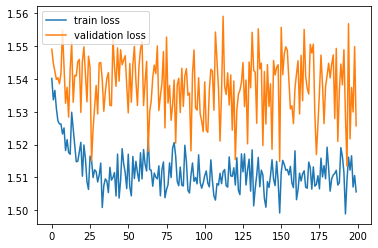

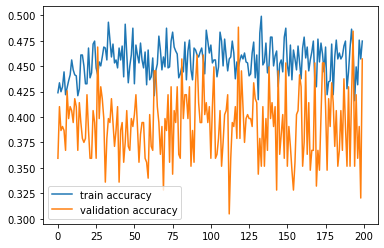

In [388]:
x = np.arange(total_epochs)
plt.plot(x,CTF_train_loss,label='train loss')
plt.plot(x,CTF_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,CTF_train_accuracy,label='train accuracy')
plt.plot(x,CTF_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()

frame = pd.DataFrame(zip(CTN_train_loss,CTN_validate_loss,CTN_train_accuracy,CTN_validate_accuracy))
frame.to_csv("CTF.csv")

In [389]:
CTF_validate_loss = []
CTF_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, CT_MatchingNet, CT_scheduler, use_cuda, False)
        CTF_validate_loss.append(v_loss)
        CTF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:35,  2.08it/s]

Epoch 0: validate_loss:1.5047479048371315 validate_accuracy:0.48828125


  1%|▊                                                                                 | 2/200 [00:00<01:36,  2.06it/s]

Epoch 1: validate_loss:1.5323816612362862 validate_accuracy:0.40234375


  2%|█▏                                                                                | 3/200 [00:01<01:35,  2.06it/s]

Epoch 2: validate_loss:1.5091764256358147 validate_accuracy:0.4765625


  2%|█▋                                                                                | 4/200 [00:01<01:35,  2.06it/s]

Epoch 3: validate_loss:1.4951785430312157 validate_accuracy:0.51953125


  2%|██                                                                                | 5/200 [00:02<01:34,  2.06it/s]

Epoch 4: validate_loss:1.505601778626442 validate_accuracy:0.48828125


  3%|██▍                                                                               | 6/200 [00:02<01:34,  2.05it/s]

Epoch 5: validate_loss:1.516699381172657 validate_accuracy:0.48828125


  4%|██▊                                                                               | 7/200 [00:03<01:33,  2.06it/s]

Epoch 6: validate_loss:1.5074167922139168 validate_accuracy:0.46875


  4%|███▎                                                                              | 8/200 [00:03<01:32,  2.07it/s]

Epoch 7: validate_loss:1.5053219646215439 validate_accuracy:0.48046875


  4%|███▋                                                                              | 9/200 [00:04<01:33,  2.05it/s]

Epoch 8: validate_loss:1.5150435343384743 validate_accuracy:0.44921875


  5%|████                                                                             | 10/200 [00:04<01:34,  2.01it/s]

Epoch 9: validate_loss:1.5049693584442139 validate_accuracy:0.48046875


  6%|████▍                                                                            | 11/200 [00:05<01:34,  2.01it/s]

Epoch 10: validate_loss:1.5154640823602676 validate_accuracy:0.4765625


  6%|████▊                                                                            | 12/200 [00:05<01:33,  2.01it/s]

Epoch 11: validate_loss:1.516196683049202 validate_accuracy:0.38671875


  6%|█████▎                                                                           | 13/200 [00:06<01:33,  2.01it/s]

Epoch 12: validate_loss:1.504139505326748 validate_accuracy:0.4609375


  7%|█████▋                                                                           | 14/200 [00:06<01:32,  2.01it/s]

Epoch 13: validate_loss:1.5269180834293365 validate_accuracy:0.39453125


  8%|██████                                                                           | 15/200 [00:07<01:32,  2.00it/s]

Epoch 14: validate_loss:1.5368960872292519 validate_accuracy:0.390625


  8%|██████▍                                                                          | 16/200 [00:07<01:31,  2.01it/s]

Epoch 15: validate_loss:1.498648226261139 validate_accuracy:0.515625


  8%|██████▉                                                                          | 17/200 [00:08<01:31,  2.00it/s]

Epoch 16: validate_loss:1.5057183876633644 validate_accuracy:0.4453125


  9%|███████▎                                                                         | 18/200 [00:08<01:31,  2.00it/s]

Epoch 17: validate_loss:1.5296943932771683 validate_accuracy:0.41796875


 10%|███████▋                                                                         | 19/200 [00:09<01:31,  1.99it/s]

Epoch 18: validate_loss:1.5188993886113167 validate_accuracy:0.421875


 10%|████████                                                                         | 20/200 [00:09<01:30,  2.00it/s]

Epoch 19: validate_loss:1.507361613214016 validate_accuracy:0.4453125


 10%|████████▌                                                                        | 21/200 [00:10<01:28,  2.02it/s]

Epoch 20: validate_loss:1.5152268260717392 validate_accuracy:0.44921875


 11%|████████▉                                                                        | 22/200 [00:10<01:28,  2.02it/s]

Epoch 21: validate_loss:1.5162577778100967 validate_accuracy:0.4453125


 12%|█████████▎                                                                       | 23/200 [00:11<01:27,  2.02it/s]

Epoch 22: validate_loss:1.5037952363491058 validate_accuracy:0.47265625


 12%|█████████▋                                                                       | 24/200 [00:11<01:27,  2.02it/s]

Epoch 23: validate_loss:1.5106123983860016 validate_accuracy:0.4609375


 12%|██████████▏                                                                      | 25/200 [00:12<01:26,  2.03it/s]

Epoch 24: validate_loss:1.5071032270789146 validate_accuracy:0.4453125


 13%|██████████▌                                                                      | 26/200 [00:12<01:25,  2.03it/s]

Epoch 25: validate_loss:1.517864890396595 validate_accuracy:0.40625


 14%|██████████▉                                                                      | 27/200 [00:13<01:24,  2.05it/s]

Epoch 26: validate_loss:1.5077901110053062 validate_accuracy:0.44140625


 14%|███████████▎                                                                     | 28/200 [00:13<01:23,  2.05it/s]

Epoch 27: validate_loss:1.5162716582417488 validate_accuracy:0.3984375


 14%|███████████▋                                                                     | 29/200 [00:14<01:23,  2.05it/s]

Epoch 28: validate_loss:1.5230181515216827 validate_accuracy:0.46875


 15%|████████████▏                                                                    | 30/200 [00:14<01:23,  2.04it/s]

Epoch 29: validate_loss:1.5056644082069397 validate_accuracy:0.48828125


 16%|████████████▌                                                                    | 31/200 [00:15<01:23,  2.03it/s]

Epoch 30: validate_loss:1.5178513452410698 validate_accuracy:0.4375


 16%|████████████▉                                                                    | 32/200 [00:15<01:22,  2.04it/s]

Epoch 31: validate_loss:1.5093361362814903 validate_accuracy:0.46484375


 16%|█████████████▎                                                                   | 33/200 [00:16<01:22,  2.03it/s]

Epoch 32: validate_loss:1.4947994127869606 validate_accuracy:0.4609375


 17%|█████████████▊                                                                   | 34/200 [00:16<01:21,  2.04it/s]

Epoch 33: validate_loss:1.498897559940815 validate_accuracy:0.46875


 18%|██████████████▏                                                                  | 35/200 [00:17<01:19,  2.06it/s]

Epoch 34: validate_loss:1.5169459283351898 validate_accuracy:0.44921875


 18%|██████████████▌                                                                  | 36/200 [00:17<01:19,  2.06it/s]

Epoch 35: validate_loss:1.5224127694964409 validate_accuracy:0.42578125


 18%|██████████████▉                                                                  | 37/200 [00:18<01:18,  2.07it/s]

Epoch 36: validate_loss:1.5217295587062836 validate_accuracy:0.42578125


 19%|███████████████▍                                                                 | 38/200 [00:18<01:17,  2.08it/s]

Epoch 37: validate_loss:1.4955729767680168 validate_accuracy:0.48828125


 20%|███████████████▊                                                                 | 39/200 [00:19<01:17,  2.08it/s]

Epoch 38: validate_loss:1.503973588347435 validate_accuracy:0.49609375


 20%|████████████████▏                                                                | 40/200 [00:19<01:17,  2.06it/s]

Epoch 39: validate_loss:1.521447479724884 validate_accuracy:0.46875


 20%|████████████████▌                                                                | 41/200 [00:20<01:16,  2.07it/s]

Epoch 40: validate_loss:1.5116063430905342 validate_accuracy:0.4765625


 21%|█████████████████                                                                | 42/200 [00:20<01:16,  2.06it/s]

Epoch 41: validate_loss:1.4996897801756859 validate_accuracy:0.484375


 22%|█████████████████▍                                                               | 43/200 [00:21<01:16,  2.04it/s]

Epoch 42: validate_loss:1.4970122277736664 validate_accuracy:0.4921875


 22%|█████████████████▊                                                               | 44/200 [00:21<01:16,  2.05it/s]

Epoch 43: validate_loss:1.5095925480127335 validate_accuracy:0.4765625


 22%|██████████████████▏                                                              | 45/200 [00:22<01:15,  2.06it/s]

Epoch 44: validate_loss:1.5047196000814438 validate_accuracy:0.5078125


 23%|██████████████████▋                                                              | 46/200 [00:22<01:14,  2.06it/s]

Epoch 45: validate_loss:1.5083718970417976 validate_accuracy:0.45703125


 24%|███████████████████                                                              | 47/200 [00:23<01:14,  2.06it/s]

Epoch 46: validate_loss:1.515618957579136 validate_accuracy:0.45703125


 24%|███████████████████▍                                                             | 48/200 [00:23<01:13,  2.06it/s]

Epoch 47: validate_loss:1.526988334953785 validate_accuracy:0.40234375


 24%|███████████████████▊                                                             | 49/200 [00:24<01:13,  2.05it/s]

Epoch 48: validate_loss:1.5122527778148651 validate_accuracy:0.44921875


 25%|████████████████████▎                                                            | 50/200 [00:24<01:13,  2.05it/s]

Epoch 49: validate_loss:1.5335372984409332 validate_accuracy:0.41796875


 26%|████████████████████▋                                                            | 51/200 [00:25<01:12,  2.06it/s]

Epoch 50: validate_loss:1.516667664051056 validate_accuracy:0.4453125


 26%|█████████████████████                                                            | 52/200 [00:25<01:11,  2.08it/s]

Epoch 51: validate_loss:1.5245429798960686 validate_accuracy:0.41015625


 26%|█████████████████████▍                                                           | 53/200 [00:25<01:10,  2.08it/s]

Epoch 52: validate_loss:1.5226185470819473 validate_accuracy:0.4375


 27%|█████████████████████▊                                                           | 54/200 [00:26<01:10,  2.07it/s]

Epoch 53: validate_loss:1.513226680457592 validate_accuracy:0.4453125


 28%|██████████████████████▎                                                          | 55/200 [00:26<01:10,  2.07it/s]

Epoch 54: validate_loss:1.5181939974427223 validate_accuracy:0.46875


 28%|██████████████████████▋                                                          | 56/200 [00:27<01:09,  2.07it/s]

Epoch 55: validate_loss:1.508999079465866 validate_accuracy:0.45703125


 28%|███████████████████████                                                          | 57/200 [00:27<01:08,  2.08it/s]

Epoch 56: validate_loss:1.5203139260411263 validate_accuracy:0.43359375


 29%|███████████████████████▍                                                         | 58/200 [00:28<01:08,  2.06it/s]

Epoch 57: validate_loss:1.5190891176462173 validate_accuracy:0.421875


 30%|███████████████████████▉                                                         | 59/200 [00:28<01:08,  2.06it/s]

Epoch 58: validate_loss:1.51686292886734 validate_accuracy:0.45703125


 30%|████████████████████████▎                                                        | 60/200 [00:29<01:08,  2.05it/s]

Epoch 59: validate_loss:1.5036493688821793 validate_accuracy:0.50390625


 30%|████████████████████████▋                                                        | 61/200 [00:29<01:07,  2.06it/s]

Epoch 60: validate_loss:1.5011649951338768 validate_accuracy:0.5078125


 31%|█████████████████████████                                                        | 62/200 [00:30<01:06,  2.07it/s]

Epoch 61: validate_loss:1.5226090103387833 validate_accuracy:0.42578125


 32%|█████████████████████████▌                                                       | 63/200 [00:30<01:06,  2.07it/s]

Epoch 62: validate_loss:1.5186869353055954 validate_accuracy:0.44140625


 32%|█████████████████████████▉                                                       | 64/200 [00:31<01:05,  2.07it/s]

Epoch 63: validate_loss:1.5143913254141808 validate_accuracy:0.43359375


 32%|██████████████████████████▎                                                      | 65/200 [00:31<01:04,  2.08it/s]

Epoch 64: validate_loss:1.4951067864894867 validate_accuracy:0.50390625


 33%|██████████████████████████▋                                                      | 66/200 [00:32<01:04,  2.08it/s]

Epoch 65: validate_loss:1.495004341006279 validate_accuracy:0.484375


 34%|███████████████████████████▏                                                     | 67/200 [00:32<01:03,  2.09it/s]

Epoch 66: validate_loss:1.523727998137474 validate_accuracy:0.4140625


 34%|███████████████████████████▌                                                     | 68/200 [00:33<01:02,  2.10it/s]

Epoch 67: validate_loss:1.5052405148744583 validate_accuracy:0.4765625


 34%|███████████████████████████▉                                                     | 69/200 [00:33<01:02,  2.10it/s]

Epoch 68: validate_loss:1.5101282969117165 validate_accuracy:0.4375


 35%|████████████████████████████▎                                                    | 70/200 [00:34<01:01,  2.10it/s]

Epoch 69: validate_loss:1.5200152844190598 validate_accuracy:0.44921875


 36%|████████████████████████████▊                                                    | 71/200 [00:34<01:01,  2.09it/s]

Epoch 70: validate_loss:1.5101687163114548 validate_accuracy:0.4765625


 36%|█████████████████████████████▏                                                   | 72/200 [00:35<01:01,  2.09it/s]

Epoch 71: validate_loss:1.522183284163475 validate_accuracy:0.41015625


 36%|█████████████████████████████▌                                                   | 73/200 [00:35<01:01,  2.07it/s]

Epoch 72: validate_loss:1.5175428241491318 validate_accuracy:0.484375


 37%|█████████████████████████████▉                                                   | 74/200 [00:36<01:00,  2.07it/s]

Epoch 73: validate_loss:1.511011965572834 validate_accuracy:0.4609375


 38%|██████████████████████████████▍                                                  | 75/200 [00:36<00:59,  2.08it/s]

Epoch 74: validate_loss:1.4958934485912323 validate_accuracy:0.46484375


 38%|██████████████████████████████▊                                                  | 76/200 [00:37<00:59,  2.07it/s]

Epoch 75: validate_loss:1.5188809633255005 validate_accuracy:0.421875


 38%|███████████████████████████████▏                                                 | 77/200 [00:37<00:59,  2.08it/s]

Epoch 76: validate_loss:1.5198900178074837 validate_accuracy:0.42578125


 39%|███████████████████████████████▌                                                 | 78/200 [00:37<00:58,  2.09it/s]

Epoch 77: validate_loss:1.52598637342453 validate_accuracy:0.39453125


 40%|███████████████████████████████▉                                                 | 79/200 [00:38<00:57,  2.11it/s]

Epoch 78: validate_loss:1.5124745592474937 validate_accuracy:0.44921875


 40%|████████████████████████████████▍                                                | 80/200 [00:38<00:56,  2.11it/s]

Epoch 79: validate_loss:1.4970286637544632 validate_accuracy:0.51171875


 40%|████████████████████████████████▊                                                | 81/200 [00:39<00:56,  2.10it/s]

Epoch 80: validate_loss:1.5049614310264587 validate_accuracy:0.47265625


 41%|█████████████████████████████████▏                                               | 82/200 [00:39<00:56,  2.09it/s]

Epoch 81: validate_loss:1.5098373889923096 validate_accuracy:0.453125


 42%|█████████████████████████████████▌                                               | 83/200 [00:40<00:56,  2.08it/s]

Epoch 82: validate_loss:1.527354709804058 validate_accuracy:0.4296875


 42%|██████████████████████████████████                                               | 84/200 [00:40<00:55,  2.08it/s]

Epoch 83: validate_loss:1.5198633968830109 validate_accuracy:0.421875


 42%|██████████████████████████████████▍                                              | 85/200 [00:41<00:55,  2.07it/s]

Epoch 84: validate_loss:1.5036111995577812 validate_accuracy:0.49609375


 43%|██████████████████████████████████▊                                              | 86/200 [00:41<00:54,  2.09it/s]

Epoch 85: validate_loss:1.519516572356224 validate_accuracy:0.390625


 44%|███████████████████████████████████▏                                             | 87/200 [00:42<00:54,  2.09it/s]

Epoch 86: validate_loss:1.498019054532051 validate_accuracy:0.49609375


 44%|███████████████████████████████████▋                                             | 88/200 [00:42<00:53,  2.08it/s]

Epoch 87: validate_loss:1.5225073620676994 validate_accuracy:0.4375


 44%|████████████████████████████████████                                             | 89/200 [00:43<00:53,  2.07it/s]

Epoch 88: validate_loss:1.517239198088646 validate_accuracy:0.45703125


 45%|████████████████████████████████████▍                                            | 90/200 [00:43<00:53,  2.07it/s]

Epoch 89: validate_loss:1.5037439540028572 validate_accuracy:0.4609375


 46%|████████████████████████████████████▊                                            | 91/200 [00:44<00:52,  2.07it/s]

Epoch 90: validate_loss:1.5277021080255508 validate_accuracy:0.40234375


 46%|█████████████████████████████████████▎                                           | 92/200 [00:44<00:51,  2.08it/s]

Epoch 91: validate_loss:1.5162891373038292 validate_accuracy:0.44140625


 46%|█████████████████████████████████████▋                                           | 93/200 [00:45<00:51,  2.08it/s]

Epoch 92: validate_loss:1.5075725093483925 validate_accuracy:0.4609375


 47%|██████████████████████████████████████                                           | 94/200 [00:45<00:51,  2.07it/s]

Epoch 93: validate_loss:1.4874591082334518 validate_accuracy:0.50390625


 48%|██████████████████████████████████████▍                                          | 95/200 [00:46<00:50,  2.06it/s]

Epoch 94: validate_loss:1.4998372942209244 validate_accuracy:0.47265625


 48%|██████████████████████████████████████▉                                          | 96/200 [00:46<00:50,  2.06it/s]

Epoch 95: validate_loss:1.5151236951351166 validate_accuracy:0.4375


 48%|███████████████████████████████████████▎                                         | 97/200 [00:47<00:49,  2.07it/s]

Epoch 96: validate_loss:1.5102361589670181 validate_accuracy:0.4453125


 49%|███████████████████████████████████████▋                                         | 98/200 [00:47<00:49,  2.07it/s]

Epoch 97: validate_loss:1.5114342346787453 validate_accuracy:0.44140625


 50%|████████████████████████████████████████                                         | 99/200 [00:48<00:48,  2.08it/s]

Epoch 98: validate_loss:1.512698344886303 validate_accuracy:0.43359375


 50%|████████████████████████████████████████                                        | 100/200 [00:48<00:48,  2.07it/s]

Epoch 99: validate_loss:1.5162666961550713 validate_accuracy:0.43359375


 50%|████████████████████████████████████████▍                                       | 101/200 [00:49<00:47,  2.08it/s]

Epoch 100: validate_loss:1.5154311507940292 validate_accuracy:0.4609375


 51%|████████████████████████████████████████▊                                       | 102/200 [00:49<00:47,  2.08it/s]

Epoch 101: validate_loss:1.5015998482704163 validate_accuracy:0.48046875


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:50<00:46,  2.10it/s]

Epoch 102: validate_loss:1.5123350918293 validate_accuracy:0.4453125


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:50<00:45,  2.10it/s]

Epoch 103: validate_loss:1.5177201554179192 validate_accuracy:0.4453125


 52%|██████████████████████████████████████████                                      | 105/200 [00:50<00:45,  2.10it/s]

Epoch 104: validate_loss:1.5177067518234253 validate_accuracy:0.484375


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:51<00:44,  2.09it/s]

Epoch 105: validate_loss:1.5276686325669289 validate_accuracy:0.4296875


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:51<00:44,  2.09it/s]

Epoch 106: validate_loss:1.5152457728981972 validate_accuracy:0.45703125


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:52<00:44,  2.07it/s]

Epoch 107: validate_loss:1.4895358085632324 validate_accuracy:0.54296875


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:52<00:43,  2.08it/s]

Epoch 108: validate_loss:1.5155845433473587 validate_accuracy:0.45703125


 55%|████████████████████████████████████████████                                    | 110/200 [00:53<00:43,  2.09it/s]

Epoch 109: validate_loss:1.4996906220912933 validate_accuracy:0.4921875


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:53<00:42,  2.09it/s]

Epoch 110: validate_loss:1.518326610326767 validate_accuracy:0.4453125


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:54<00:42,  2.09it/s]

Epoch 111: validate_loss:1.515261948108673 validate_accuracy:0.44921875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:54<00:41,  2.08it/s]

Epoch 112: validate_loss:1.5293301716446877 validate_accuracy:0.39453125


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:55<00:41,  2.06it/s]

Epoch 113: validate_loss:1.501134604215622 validate_accuracy:0.453125


 57%|██████████████████████████████████████████████                                  | 115/200 [00:55<00:41,  2.03it/s]

Epoch 114: validate_loss:1.5286109670996666 validate_accuracy:0.41015625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:56<00:42,  1.97it/s]

Epoch 115: validate_loss:1.5097636133432388 validate_accuracy:0.45703125


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:56<00:42,  1.96it/s]

Epoch 116: validate_loss:1.5232698246836662 validate_accuracy:0.46484375


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:57<00:41,  1.97it/s]

Epoch 117: validate_loss:1.516942523419857 validate_accuracy:0.46484375


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:57<00:40,  1.98it/s]

Epoch 118: validate_loss:1.4902049601078033 validate_accuracy:0.51171875


 60%|████████████████████████████████████████████████                                | 120/200 [00:58<00:40,  1.96it/s]

Epoch 119: validate_loss:1.4967369735240936 validate_accuracy:0.5


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:58<00:40,  1.97it/s]

Epoch 120: validate_loss:1.5287870466709137 validate_accuracy:0.4296875


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:59<00:40,  1.94it/s]

Epoch 121: validate_loss:1.5075169056653976 validate_accuracy:0.42578125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:59<00:39,  1.96it/s]

Epoch 122: validate_loss:1.5188346952199936 validate_accuracy:0.40625


 62%|█████████████████████████████████████████████████▌                              | 124/200 [01:00<00:38,  1.97it/s]

Epoch 123: validate_loss:1.5085214003920555 validate_accuracy:0.47265625


 62%|██████████████████████████████████████████████████                              | 125/200 [01:00<00:37,  1.98it/s]

Epoch 124: validate_loss:1.5175821781158447 validate_accuracy:0.4609375


 63%|██████████████████████████████████████████████████▍                             | 126/200 [01:01<00:36,  2.00it/s]

Epoch 125: validate_loss:1.513174295425415 validate_accuracy:0.4375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [01:01<00:36,  2.03it/s]

Epoch 126: validate_loss:1.512526012957096 validate_accuracy:0.44921875


 64%|███████████████████████████████████████████████████▏                            | 128/200 [01:02<00:35,  2.05it/s]

Epoch 127: validate_loss:1.5166195407509804 validate_accuracy:0.4453125


 64%|███████████████████████████████████████████████████▌                            | 129/200 [01:02<00:34,  2.06it/s]

Epoch 128: validate_loss:1.506013236939907 validate_accuracy:0.47265625


 65%|████████████████████████████████████████████████████                            | 130/200 [01:03<00:34,  2.05it/s]

Epoch 129: validate_loss:1.5056380033493042 validate_accuracy:0.484375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:03<00:33,  2.08it/s]

Epoch 130: validate_loss:1.505137376487255 validate_accuracy:0.44140625


 66%|████████████████████████████████████████████████████▊                           | 132/200 [01:04<00:32,  2.08it/s]

Epoch 131: validate_loss:1.503706455230713 validate_accuracy:0.4765625


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [01:04<00:32,  2.08it/s]

Epoch 132: validate_loss:1.50937070697546 validate_accuracy:0.4453125


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [01:05<00:31,  2.07it/s]

Epoch 133: validate_loss:1.520703800022602 validate_accuracy:0.42578125


 68%|██████████████████████████████████████████████████████                          | 135/200 [01:05<00:31,  2.06it/s]

Epoch 134: validate_loss:1.5141030326485634 validate_accuracy:0.44140625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [01:06<00:30,  2.07it/s]

Epoch 135: validate_loss:1.508117489516735 validate_accuracy:0.4296875


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [01:06<00:30,  2.07it/s]

Epoch 136: validate_loss:1.5034523755311966 validate_accuracy:0.5


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [01:07<00:29,  2.08it/s]

Epoch 137: validate_loss:1.5093818083405495 validate_accuracy:0.44921875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [01:07<00:29,  2.06it/s]

Epoch 138: validate_loss:1.5027628019452095 validate_accuracy:0.5078125


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:08<00:28,  2.08it/s]

Epoch 139: validate_loss:1.5075983628630638 validate_accuracy:0.4375


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:08<00:28,  2.08it/s]

Epoch 140: validate_loss:1.5135695040225983 validate_accuracy:0.45703125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [01:09<00:28,  2.07it/s]

Epoch 141: validate_loss:1.5058122724294662 validate_accuracy:0.49609375


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [01:09<00:27,  2.08it/s]

Epoch 142: validate_loss:1.5127911493182182 validate_accuracy:0.421875


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [01:10<00:27,  2.07it/s]

Epoch 143: validate_loss:1.4995135068893433 validate_accuracy:0.48828125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [01:10<00:26,  2.04it/s]

Epoch 144: validate_loss:1.512054719030857 validate_accuracy:0.46875


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [01:11<00:26,  2.05it/s]

Epoch 145: validate_loss:1.5071756839752197 validate_accuracy:0.4609375


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [01:11<00:25,  2.06it/s]

Epoch 146: validate_loss:1.5099758058786392 validate_accuracy:0.45703125


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [01:12<00:25,  2.05it/s]

Epoch 147: validate_loss:1.5180215314030647 validate_accuracy:0.4921875


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [01:12<00:24,  2.06it/s]

Epoch 148: validate_loss:1.511228822171688 validate_accuracy:0.47265625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [01:13<00:24,  2.05it/s]

Epoch 149: validate_loss:1.4929258450865746 validate_accuracy:0.4765625


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [01:13<00:23,  2.06it/s]

Epoch 150: validate_loss:1.5018506273627281 validate_accuracy:0.48828125


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [01:13<00:23,  2.07it/s]

Epoch 151: validate_loss:1.5244609713554382 validate_accuracy:0.4609375


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [01:14<00:22,  2.07it/s]

Epoch 152: validate_loss:1.5060172528028488 validate_accuracy:0.515625


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [01:14<00:22,  2.07it/s]

Epoch 153: validate_loss:1.5162355154752731 validate_accuracy:0.45703125


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [01:15<00:21,  2.10it/s]

Epoch 154: validate_loss:1.5097438991069794 validate_accuracy:0.44921875


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [01:15<00:20,  2.10it/s]

Epoch 155: validate_loss:1.5100474208593369 validate_accuracy:0.453125


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [01:16<00:20,  2.09it/s]

Epoch 156: validate_loss:1.5039688348770142 validate_accuracy:0.4921875


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [01:16<00:20,  2.09it/s]

Epoch 157: validate_loss:1.4944831132888794 validate_accuracy:0.5


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [01:17<00:19,  2.09it/s]

Epoch 158: validate_loss:1.5033674389123917 validate_accuracy:0.47265625


 80%|████████████████████████████████████████████████████████████████                | 160/200 [01:17<00:19,  2.08it/s]

Epoch 159: validate_loss:1.5157453268766403 validate_accuracy:0.45703125


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:18<00:18,  2.06it/s]

Epoch 160: validate_loss:1.505625180900097 validate_accuracy:0.44140625


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [01:18<00:18,  2.04it/s]

Epoch 161: validate_loss:1.508240818977356 validate_accuracy:0.4296875


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [01:19<00:18,  2.03it/s]

Epoch 162: validate_loss:1.4985779449343681 validate_accuracy:0.47265625


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [01:19<00:17,  2.04it/s]

Epoch 163: validate_loss:1.5135900601744652 validate_accuracy:0.4375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [01:20<00:17,  2.03it/s]

Epoch 164: validate_loss:1.5129273161292076 validate_accuracy:0.4453125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [01:20<00:17,  1.99it/s]

Epoch 165: validate_loss:1.5119165852665901 validate_accuracy:0.45703125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [01:21<00:16,  1.99it/s]

Epoch 166: validate_loss:1.5044384226202965 validate_accuracy:0.48828125


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [01:21<00:15,  2.02it/s]

Epoch 167: validate_loss:1.498013935983181 validate_accuracy:0.515625


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [01:22<00:15,  2.03it/s]

Epoch 168: validate_loss:1.5156427696347237 validate_accuracy:0.4375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:22<00:14,  2.06it/s]

Epoch 169: validate_loss:1.5125052332878113 validate_accuracy:0.48046875


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:23<00:14,  2.07it/s]

Epoch 170: validate_loss:1.5116837322711945 validate_accuracy:0.4375


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:23<00:13,  2.07it/s]

Epoch 171: validate_loss:1.5083064138889313 validate_accuracy:0.46875


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:24<00:13,  2.06it/s]

Epoch 172: validate_loss:1.5154214203357697 validate_accuracy:0.453125


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:24<00:12,  2.07it/s]

Epoch 173: validate_loss:1.5130389407277107 validate_accuracy:0.4609375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:25<00:12,  2.08it/s]

Epoch 174: validate_loss:1.5207731276750565 validate_accuracy:0.4296875


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:25<00:11,  2.08it/s]

Epoch 175: validate_loss:1.5047107860445976 validate_accuracy:0.48046875


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:26<00:11,  2.07it/s]

Epoch 176: validate_loss:1.5228475108742714 validate_accuracy:0.4453125


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:26<00:10,  2.07it/s]

Epoch 177: validate_loss:1.5130419358611107 validate_accuracy:0.4375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:27<00:10,  2.06it/s]

Epoch 178: validate_loss:1.516821950674057 validate_accuracy:0.44921875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:27<00:09,  2.07it/s]

Epoch 179: validate_loss:1.5101155638694763 validate_accuracy:0.45703125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:28<00:09,  2.07it/s]

Epoch 180: validate_loss:1.5123656317591667 validate_accuracy:0.4453125


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:28<00:08,  2.07it/s]

Epoch 181: validate_loss:1.5169857889413834 validate_accuracy:0.4609375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:29<00:08,  2.07it/s]

Epoch 182: validate_loss:1.5141109302639961 validate_accuracy:0.45703125


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:29<00:07,  2.10it/s]

Epoch 183: validate_loss:1.5139300003647804 validate_accuracy:0.47265625


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:29<00:07,  2.09it/s]

Epoch 184: validate_loss:1.5121845975518227 validate_accuracy:0.4453125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:30<00:06,  2.10it/s]

Epoch 185: validate_loss:1.5133509263396263 validate_accuracy:0.45703125


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:30<00:06,  2.10it/s]

Epoch 186: validate_loss:1.5096415877342224 validate_accuracy:0.4609375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:31<00:05,  2.10it/s]

Epoch 187: validate_loss:1.5156027600169182 validate_accuracy:0.46484375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:31<00:05,  2.08it/s]

Epoch 188: validate_loss:1.507079154253006 validate_accuracy:0.49609375


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:32<00:04,  2.09it/s]

Epoch 189: validate_loss:1.5112984329462051 validate_accuracy:0.4609375


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:32<00:04,  2.08it/s]

Epoch 190: validate_loss:1.514962151646614 validate_accuracy:0.44921875


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:33<00:03,  2.08it/s]

Epoch 191: validate_loss:1.5124631002545357 validate_accuracy:0.44921875


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:33<00:03,  2.08it/s]

Epoch 192: validate_loss:1.509720116853714 validate_accuracy:0.44921875


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:34<00:02,  2.08it/s]

Epoch 193: validate_loss:1.5094103664159775 validate_accuracy:0.48828125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:34<00:02,  2.09it/s]

Epoch 194: validate_loss:1.4998802170157433 validate_accuracy:0.48046875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:35<00:01,  2.10it/s]

Epoch 195: validate_loss:1.5131168439984322 validate_accuracy:0.4140625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:35<00:01,  2.08it/s]

Epoch 196: validate_loss:1.4963628873229027 validate_accuracy:0.50390625


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:36<00:00,  2.08it/s]

Epoch 197: validate_loss:1.515597328543663 validate_accuracy:0.421875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:36<00:00,  2.08it/s]

Epoch 198: validate_loss:1.5233173668384552 validate_accuracy:0.4296875


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:37<00:00,  2.06it/s]

Epoch 199: validate_loss:1.5099944323301315 validate_accuracy:0.4921875


In [390]:
np.mean(CTF_validate_accuracy)

0.45685546875

# Start with trained: miniImageNet

In [333]:
dataM = MiniImageNetNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

(100, 600, 84, 84, 3)


In [337]:
miniM = miniImageNetClassifier(layer_size=64, nClasses = 64, num_channels = 3, keep_prob = 0.0, image_size = 84, freeze = False)

In [338]:
optimizerM = torch.optim.Adam(miniM.parameters(), lr=1e-3)

In [348]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        loss, acc = PreTraining(dataM,miniM,optimizerM,32,True)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, loss, acc))
        pbar_e.update(1)

  2%|█▋                                                                                 | 1/50 [00:23<19:09, 23.46s/it]

Epoch 0: train_loss:0.35317037999629974 train_accuracy:0.890869140625


  4%|███▎                                                                               | 2/50 [00:46<18:45, 23.46s/it]

Epoch 1: train_loss:0.3347122520208359 train_accuracy:0.90087890625


  6%|████▉                                                                              | 3/50 [01:10<18:22, 23.46s/it]

Epoch 2: train_loss:0.3541500703431666 train_accuracy:0.885986328125


  8%|██████▋                                                                            | 4/50 [01:33<17:59, 23.46s/it]

Epoch 3: train_loss:0.33311513159424067 train_accuracy:0.8916015625


 10%|████████▎                                                                          | 5/50 [01:57<17:35, 23.46s/it]

Epoch 4: train_loss:0.3286299202591181 train_accuracy:0.8994140625


 12%|█████████▉                                                                         | 6/50 [02:20<17:12, 23.46s/it]

Epoch 5: train_loss:0.32520528323948383 train_accuracy:0.899658203125


 14%|███████████▌                                                                       | 7/50 [02:44<16:48, 23.46s/it]

Epoch 6: train_loss:0.3293470600619912 train_accuracy:0.893798828125


 16%|█████████████▎                                                                     | 8/50 [03:07<16:25, 23.46s/it]

Epoch 7: train_loss:0.3118923590518534 train_accuracy:0.903564453125


 18%|██████████████▉                                                                    | 9/50 [03:31<16:02, 23.47s/it]

Epoch 8: train_loss:0.316612645983696 train_accuracy:0.90283203125


 20%|████████████████▍                                                                 | 10/50 [03:54<15:39, 23.48s/it]

Epoch 9: train_loss:0.31185609102249146 train_accuracy:0.904296875


 22%|██████████████████                                                                | 11/50 [04:18<15:15, 23.49s/it]

Epoch 10: train_loss:0.32962407218292356 train_accuracy:0.89697265625


 24%|███████████████████▋                                                              | 12/50 [04:41<14:52, 23.49s/it]

Epoch 11: train_loss:0.33181739738211036 train_accuracy:0.892578125


 26%|█████████████████████▎                                                            | 13/50 [05:05<14:28, 23.49s/it]

Epoch 12: train_loss:0.34045370668172836 train_accuracy:0.896240234375


 28%|██████████████████████▉                                                           | 14/50 [05:28<14:05, 23.49s/it]

Epoch 13: train_loss:0.3204339719377458 train_accuracy:0.902587890625


 30%|████████████████████████▌                                                         | 15/50 [05:52<13:42, 23.49s/it]

Epoch 14: train_loss:0.3205144992098212 train_accuracy:0.900390625


 32%|██████████████████████████▏                                                       | 16/50 [06:15<13:18, 23.49s/it]

Epoch 15: train_loss:0.3382943831384182 train_accuracy:0.8984375


 34%|███████████████████████████▉                                                      | 17/50 [06:39<12:54, 23.48s/it]

Epoch 16: train_loss:0.31279177498072386 train_accuracy:0.908203125


 36%|█████████████████████████████▌                                                    | 18/50 [07:02<12:31, 23.48s/it]

Epoch 17: train_loss:0.3081001932732761 train_accuracy:0.9033203125


 38%|███████████████████████████████▏                                                  | 19/50 [07:26<12:08, 23.48s/it]

Epoch 18: train_loss:0.30365964910015464 train_accuracy:0.90869140625


 40%|████████████████████████████████▊                                                 | 20/50 [07:49<11:44, 23.49s/it]

Epoch 19: train_loss:0.2976974928751588 train_accuracy:0.91162109375


 42%|██████████████████████████████████▍                                               | 21/50 [08:13<11:21, 23.49s/it]

Epoch 20: train_loss:0.2785540516488254 train_accuracy:0.91162109375


 44%|████████████████████████████████████                                              | 22/50 [08:36<10:57, 23.49s/it]

Epoch 21: train_loss:0.2860083351843059 train_accuracy:0.911865234375


 46%|█████████████████████████████████████▋                                            | 23/50 [09:00<10:34, 23.49s/it]

Epoch 22: train_loss:0.2992760934866965 train_accuracy:0.9072265625


 48%|███████████████████████████████████████▎                                          | 24/50 [09:23<10:10, 23.48s/it]

Epoch 23: train_loss:0.274481394328177 train_accuracy:0.917724609375


 50%|█████████████████████████████████████████                                         | 25/50 [09:46<09:47, 23.49s/it]

Epoch 24: train_loss:0.2860080380924046 train_accuracy:0.9130859375


 52%|██████████████████████████████████████████▋                                       | 26/50 [10:10<09:23, 23.49s/it]

Epoch 25: train_loss:0.30689923628233373 train_accuracy:0.906494140625


 54%|████████████████████████████████████████████▎                                     | 27/50 [10:33<09:00, 23.49s/it]

Epoch 26: train_loss:0.2836541351862252 train_accuracy:0.913818359375


 56%|█████████████████████████████████████████████▉                                    | 28/50 [10:57<08:36, 23.49s/it]

Epoch 27: train_loss:0.28981322422623634 train_accuracy:0.905029296875


 58%|███████████████████████████████████████████████▌                                  | 29/50 [11:20<08:13, 23.49s/it]

Epoch 28: train_loss:0.29227481689304113 train_accuracy:0.909912109375


 60%|█████████████████████████████████████████████████▏                                | 30/50 [11:44<07:49, 23.50s/it]

Epoch 29: train_loss:0.27171743754297495 train_accuracy:0.915283203125


 62%|██████████████████████████████████████████████████▊                               | 31/50 [12:07<07:26, 23.49s/it]

Epoch 30: train_loss:0.2882752469740808 train_accuracy:0.912109375


 64%|████████████████████████████████████████████████████▍                             | 32/50 [12:31<07:02, 23.49s/it]

Epoch 31: train_loss:0.28564098849892616 train_accuracy:0.915771484375


 66%|██████████████████████████████████████████████████████                            | 33/50 [12:54<06:39, 23.49s/it]

Epoch 32: train_loss:0.3078611292876303 train_accuracy:0.905517578125


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [13:18<06:15, 23.48s/it]

Epoch 33: train_loss:0.3077257047407329 train_accuracy:0.90478515625


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [13:41<05:52, 23.48s/it]

Epoch 34: train_loss:0.2686989549547434 train_accuracy:0.92236328125


 72%|███████████████████████████████████████████████████████████                       | 36/50 [14:05<05:28, 23.48s/it]

Epoch 35: train_loss:0.2603639045264572 train_accuracy:0.921875


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [14:28<05:05, 23.48s/it]

Epoch 36: train_loss:0.2779956297017634 train_accuracy:0.91552734375


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [14:52<04:41, 23.47s/it]

Epoch 37: train_loss:0.2629050090909004 train_accuracy:0.921875


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [15:15<04:18, 23.47s/it]

Epoch 38: train_loss:0.25429012486711144 train_accuracy:0.92138671875


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [15:39<03:54, 23.47s/it]

Epoch 39: train_loss:0.26020721439272165 train_accuracy:0.921630859375


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [16:02<03:31, 23.47s/it]

Epoch 40: train_loss:0.25465116184204817 train_accuracy:0.92041015625


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [16:26<03:07, 23.47s/it]

Epoch 41: train_loss:0.25135380402207375 train_accuracy:0.922119140625


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [16:49<02:44, 23.47s/it]

Epoch 42: train_loss:0.237957707606256 train_accuracy:0.9296875


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [17:13<02:20, 23.47s/it]

Epoch 43: train_loss:0.23902018601074815 train_accuracy:0.930908203125


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [17:36<01:57, 23.47s/it]

Epoch 44: train_loss:0.2544765407219529 train_accuracy:0.923583984375


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [18:00<01:33, 23.47s/it]

Epoch 45: train_loss:0.2537426925264299 train_accuracy:0.919677734375


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [18:23<01:10, 23.47s/it]

Epoch 46: train_loss:0.2513050218112767 train_accuracy:0.922119140625


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [18:46<00:46, 23.48s/it]

Epoch 47: train_loss:0.28062496706843376 train_accuracy:0.911376953125


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [19:10<00:23, 23.48s/it]

Epoch 48: train_loss:0.261260824277997 train_accuracy:0.91162109375


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [19:33<00:00, 23.48s/it]

Epoch 49: train_loss:0.26423430209979415 train_accuracy:0.91650390625


In [349]:
torch.save(miniM.state_dict(), 'Mnet_params.pth')

In [350]:
MT_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=False, image_size=84, use_cuda=True, model = 1)
pretrained_dict = torch.load('Mnet_params.pth')
model_dict = MT_MatchingNet.embedding.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)

In [351]:
MT_MatchingNet.embedding.load_state_dict(model_dict)
MT_MatchingNet.embedding.freeze()
MT_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, MT_MatchingNet.parameters()), lr=1e-3)
MT_scheduler = ReduceLROnPlateau(MT_optimizer, 'min',verbose=True)
MTN_validate_loss = []
MTN_validate_accuracy = []

In [352]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, MT_MatchingNet.cuda(), MT_scheduler, use_cuda, False)
        MTN_validate_loss.append(v_loss)
        MTN_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:02<08:15,  2.49s/it]

Epoch 0: validate_loss:1.5568790510296822 validate_accuracy:0.32421875


  1%|▊                                                                                 | 2/200 [00:04<08:11,  2.48s/it]

Epoch 1: validate_loss:1.5456350520253181 validate_accuracy:0.36328125


  2%|█▏                                                                                | 3/200 [00:07<08:06,  2.47s/it]

Epoch 2: validate_loss:1.5487863570451736 validate_accuracy:0.40234375


  2%|█▋                                                                                | 4/200 [00:09<08:02,  2.46s/it]

Epoch 3: validate_loss:1.5387203618884087 validate_accuracy:0.41015625


  2%|██                                                                                | 5/200 [00:12<07:59,  2.46s/it]

Epoch 4: validate_loss:1.5590095669031143 validate_accuracy:0.36328125


  3%|██▍                                                                               | 6/200 [00:14<07:55,  2.45s/it]

Epoch 5: validate_loss:1.5596758648753166 validate_accuracy:0.375


  4%|██▊                                                                               | 7/200 [00:17<07:50,  2.44s/it]

Epoch 6: validate_loss:1.5492087975144386 validate_accuracy:0.36328125


  4%|███▎                                                                              | 8/200 [00:19<07:48,  2.44s/it]

Epoch 7: validate_loss:1.5386871621012688 validate_accuracy:0.40234375


  4%|███▋                                                                              | 9/200 [00:21<07:43,  2.43s/it]

Epoch 8: validate_loss:1.548809215426445 validate_accuracy:0.4140625


  5%|████                                                                             | 10/200 [00:24<07:41,  2.43s/it]

Epoch 9: validate_loss:1.5527048781514168 validate_accuracy:0.38671875


  6%|████▍                                                                            | 11/200 [00:26<07:37,  2.42s/it]

Epoch 10: validate_loss:1.5373891443014145 validate_accuracy:0.4765625


  6%|████▊                                                                            | 12/200 [00:29<07:35,  2.42s/it]

Epoch 11: validate_loss:1.5477539151906967 validate_accuracy:0.36328125


  6%|█████▎                                                                           | 13/200 [00:31<07:32,  2.42s/it]

Epoch 12: validate_loss:1.5340612977743149 validate_accuracy:0.4296875


  7%|█████▋                                                                           | 14/200 [00:34<07:29,  2.42s/it]

Epoch 13: validate_loss:1.5582526475191116 validate_accuracy:0.359375


  8%|██████                                                                           | 15/200 [00:36<07:26,  2.41s/it]

Epoch 14: validate_loss:1.5431337803602219 validate_accuracy:0.37890625


  8%|██████▍                                                                          | 16/200 [00:38<07:23,  2.41s/it]

Epoch 15: validate_loss:1.5549045503139496 validate_accuracy:0.3671875


  8%|██████▉                                                                          | 17/200 [00:41<07:20,  2.41s/it]

Epoch 16: validate_loss:1.5418876335024834 validate_accuracy:0.4296875


  9%|███████▎                                                                         | 18/200 [00:43<07:17,  2.40s/it]

Epoch 17: validate_loss:1.5447512865066528 validate_accuracy:0.38671875


 10%|███████▋                                                                         | 19/200 [00:46<07:14,  2.40s/it]

Epoch 18: validate_loss:1.5550135895609856 validate_accuracy:0.37890625


 10%|████████                                                                         | 20/200 [00:48<07:12,  2.40s/it]

Epoch 19: validate_loss:1.5428281500935555 validate_accuracy:0.3984375


 10%|████████▌                                                                        | 21/200 [00:50<07:08,  2.40s/it]

Epoch 20: validate_loss:1.551780141890049 validate_accuracy:0.359375


 11%|████████▉                                                                        | 22/200 [00:53<07:06,  2.39s/it]

Epoch 21: validate_loss:1.5580795630812645 validate_accuracy:0.32421875


 12%|█████████▎                                                                       | 23/200 [00:55<07:02,  2.39s/it]

Epoch 22: validate_loss:1.5507784113287926 validate_accuracy:0.41015625


 12%|█████████▋                                                                       | 24/200 [00:57<06:59,  2.39s/it]

Epoch    24: reducing learning rate of group 0 to 1.0000e-06.
Epoch 23: validate_loss:1.5536531060934067 validate_accuracy:0.34765625


 12%|██████████▏                                                                      | 25/200 [01:00<06:56,  2.38s/it]

Epoch 24: validate_loss:1.5414310619235039 validate_accuracy:0.421875


 13%|██████████▌                                                                      | 26/200 [01:02<06:55,  2.39s/it]

Epoch 25: validate_loss:1.5418482050299644 validate_accuracy:0.4140625


 14%|██████████▉                                                                      | 27/200 [01:05<06:52,  2.38s/it]

Epoch 26: validate_loss:1.5445977970957756 validate_accuracy:0.40234375


 14%|███████████▎                                                                     | 28/200 [01:07<06:49,  2.38s/it]

Epoch 27: validate_loss:1.54027359187603 validate_accuracy:0.421875


 14%|███████████▋                                                                     | 29/200 [01:09<06:46,  2.38s/it]

Epoch 28: validate_loss:1.554259568452835 validate_accuracy:0.39453125


 15%|████████████▏                                                                    | 30/200 [01:12<06:43,  2.38s/it]

Epoch 29: validate_loss:1.5430356115102768 validate_accuracy:0.3828125


 16%|████████████▌                                                                    | 31/200 [01:14<06:41,  2.38s/it]

Epoch 30: validate_loss:1.550380326807499 validate_accuracy:0.375


 16%|████████████▉                                                                    | 32/200 [01:17<06:40,  2.38s/it]

Epoch 31: validate_loss:1.5470178425312042 validate_accuracy:0.3671875


 16%|█████████████▎                                                                   | 33/200 [01:19<06:37,  2.38s/it]

Epoch 32: validate_loss:1.5587628036737442 validate_accuracy:0.3359375


 17%|█████████████▊                                                                   | 34/200 [01:21<06:34,  2.38s/it]

Epoch 33: validate_loss:1.548644296824932 validate_accuracy:0.390625


 18%|██████████████▏                                                                  | 35/200 [01:24<06:31,  2.37s/it]

Epoch    35: reducing learning rate of group 0 to 1.0000e-07.
Epoch 34: validate_loss:1.5490726605057716 validate_accuracy:0.38671875


 18%|██████████████▌                                                                  | 36/200 [01:26<06:28,  2.37s/it]

Epoch 35: validate_loss:1.561170108616352 validate_accuracy:0.34765625


 18%|██████████████▉                                                                  | 37/200 [01:28<06:26,  2.37s/it]

Epoch 36: validate_loss:1.5370510518550873 validate_accuracy:0.46484375


 19%|███████████████▍                                                                 | 38/200 [01:31<06:24,  2.38s/it]

Epoch 37: validate_loss:1.5447929129004478 validate_accuracy:0.39453125


 20%|███████████████▊                                                                 | 39/200 [01:33<06:23,  2.38s/it]

Epoch 38: validate_loss:1.5467464700341225 validate_accuracy:0.37890625


 20%|████████████████▏                                                                | 40/200 [01:36<06:21,  2.38s/it]

Epoch 39: validate_loss:1.5423599109053612 validate_accuracy:0.40234375


 20%|████████████████▌                                                                | 41/200 [01:38<06:18,  2.38s/it]

Epoch 40: validate_loss:1.5593820065259933 validate_accuracy:0.33203125


 21%|█████████████████                                                                | 42/200 [01:40<06:16,  2.38s/it]

Epoch 41: validate_loss:1.5415156707167625 validate_accuracy:0.39453125


 22%|█████████████████▍                                                               | 43/200 [01:43<06:13,  2.38s/it]

Epoch 42: validate_loss:1.5382154732942581 validate_accuracy:0.42578125


 22%|█████████████████▊                                                               | 44/200 [01:45<06:10,  2.38s/it]

Epoch 43: validate_loss:1.561469554901123 validate_accuracy:0.390625


 22%|██████████████████▏                                                              | 45/200 [01:47<06:07,  2.37s/it]

Epoch 44: validate_loss:1.5487607195973396 validate_accuracy:0.39453125


 23%|██████████████████▋                                                              | 46/200 [01:50<06:05,  2.37s/it]

Epoch    46: reducing learning rate of group 0 to 1.0000e-08.
Epoch 45: validate_loss:1.5581853613257408 validate_accuracy:0.359375


 24%|███████████████████                                                              | 47/200 [01:52<06:02,  2.37s/it]

Epoch 46: validate_loss:1.5583108961582184 validate_accuracy:0.3515625


 24%|███████████████████▍                                                             | 48/200 [01:55<06:00,  2.37s/it]

Epoch 47: validate_loss:1.5511442720890045 validate_accuracy:0.3984375


 24%|███████████████████▊                                                             | 49/200 [01:57<05:58,  2.37s/it]

Epoch 48: validate_loss:1.5406719148159027 validate_accuracy:0.40625


 25%|████████████████████▎                                                            | 50/200 [01:59<05:55,  2.37s/it]

Epoch 49: validate_loss:1.5523120537400246 validate_accuracy:0.390625


 26%|████████████████████▋                                                            | 51/200 [02:02<05:52,  2.37s/it]

Epoch 50: validate_loss:1.5472962334752083 validate_accuracy:0.40625


 26%|█████████████████████                                                            | 52/200 [02:04<05:51,  2.37s/it]

Epoch 51: validate_loss:1.5519932806491852 validate_accuracy:0.4140625


 26%|█████████████████████▍                                                           | 53/200 [02:06<05:48,  2.37s/it]

Epoch 52: validate_loss:1.553789883852005 validate_accuracy:0.4140625


 27%|█████████████████████▊                                                           | 54/200 [02:09<05:46,  2.37s/it]

Epoch 53: validate_loss:1.558708369731903 validate_accuracy:0.33984375


 28%|██████████████████████▎                                                          | 55/200 [02:11<05:43,  2.37s/it]

Epoch 54: validate_loss:1.546548955142498 validate_accuracy:0.37109375


 28%|██████████████████████▋                                                          | 56/200 [02:13<05:40,  2.37s/it]

Epoch 55: validate_loss:1.540172278881073 validate_accuracy:0.40234375


 28%|███████████████████████                                                          | 57/200 [02:16<05:38,  2.37s/it]

Epoch 56: validate_loss:1.547754555940628 validate_accuracy:0.34375


 29%|███████████████████████▍                                                         | 58/200 [02:18<05:35,  2.37s/it]

Epoch 57: validate_loss:1.554041638970375 validate_accuracy:0.36328125


 30%|███████████████████████▉                                                         | 59/200 [02:21<05:33,  2.36s/it]

Epoch 58: validate_loss:1.5446487590670586 validate_accuracy:0.3984375


 30%|████████████████████████▎                                                        | 60/200 [02:23<05:31,  2.37s/it]

Epoch 59: validate_loss:1.5593981221318245 validate_accuracy:0.3515625


 30%|████████████████████████▋                                                        | 61/200 [02:25<05:30,  2.38s/it]

Epoch 60: validate_loss:1.5493638813495636 validate_accuracy:0.390625


 31%|█████████████████████████                                                        | 62/200 [02:28<05:28,  2.38s/it]

Epoch 61: validate_loss:1.5482494533061981 validate_accuracy:0.421875


 32%|█████████████████████████▌                                                       | 63/200 [02:30<05:26,  2.39s/it]

Epoch 62: validate_loss:1.5379238948225975 validate_accuracy:0.453125


 32%|█████████████████████████▉                                                       | 64/200 [02:33<05:24,  2.39s/it]

Epoch 63: validate_loss:1.5533407852053642 validate_accuracy:0.37109375


 32%|██████████████████████████▎                                                      | 65/200 [02:35<05:23,  2.39s/it]

Epoch 64: validate_loss:1.5379369482398033 validate_accuracy:0.4140625


 33%|██████████████████████████▋                                                      | 66/200 [02:37<05:20,  2.39s/it]

Epoch 65: validate_loss:1.554298259317875 validate_accuracy:0.3515625


 34%|███████████████████████████▏                                                     | 67/200 [02:40<05:17,  2.39s/it]

Epoch 66: validate_loss:1.544042319059372 validate_accuracy:0.40625


 34%|███████████████████████████▌                                                     | 68/200 [02:42<05:14,  2.38s/it]

Epoch 67: validate_loss:1.5423543825745583 validate_accuracy:0.44140625


 34%|███████████████████████████▉                                                     | 69/200 [02:44<05:11,  2.38s/it]

Epoch 68: validate_loss:1.5560081079602242 validate_accuracy:0.35546875


 35%|████████████████████████████▎                                                    | 70/200 [02:47<05:09,  2.38s/it]

Epoch 69: validate_loss:1.5475818887352943 validate_accuracy:0.39453125


 36%|████████████████████████████▊                                                    | 71/200 [02:49<05:06,  2.38s/it]

Epoch 70: validate_loss:1.5535647869110107 validate_accuracy:0.3359375


 36%|█████████████████████████████▏                                                   | 72/200 [02:52<05:03,  2.37s/it]

Epoch 71: validate_loss:1.5421491265296936 validate_accuracy:0.4140625


 36%|█████████████████████████████▌                                                   | 73/200 [02:54<05:01,  2.37s/it]

Epoch 72: validate_loss:1.5531690493226051 validate_accuracy:0.3515625


 37%|█████████████████████████████▉                                                   | 74/200 [02:56<04:58,  2.37s/it]

Epoch 73: validate_loss:1.549106977880001 validate_accuracy:0.38671875


 38%|██████████████████████████████▍                                                  | 75/200 [02:59<04:56,  2.37s/it]

Epoch 74: validate_loss:1.5477982237935066 validate_accuracy:0.40625


 38%|██████████████████████████████▊                                                  | 76/200 [03:01<04:53,  2.37s/it]

Epoch 75: validate_loss:1.559282585978508 validate_accuracy:0.34375


 38%|███████████████████████████████▏                                                 | 77/200 [03:03<04:51,  2.37s/it]

Epoch 76: validate_loss:1.5559031143784523 validate_accuracy:0.35546875


 39%|███████████████████████████████▌                                                 | 78/200 [03:06<04:48,  2.37s/it]

Epoch 77: validate_loss:1.5545549467206001 validate_accuracy:0.3671875


 40%|███████████████████████████████▉                                                 | 79/200 [03:08<04:46,  2.36s/it]

Epoch 78: validate_loss:1.551418423652649 validate_accuracy:0.36328125


 40%|████████████████████████████████▍                                                | 80/200 [03:10<04:44,  2.37s/it]

Epoch 79: validate_loss:1.543771117925644 validate_accuracy:0.43359375


 40%|████████████████████████████████▊                                                | 81/200 [03:13<04:41,  2.37s/it]

Epoch 80: validate_loss:1.5474392026662827 validate_accuracy:0.39453125


 41%|█████████████████████████████████▏                                               | 82/200 [03:15<04:39,  2.37s/it]

Epoch 81: validate_loss:1.5502538308501244 validate_accuracy:0.37109375


 42%|█████████████████████████████████▌                                               | 83/200 [03:18<04:36,  2.37s/it]

Epoch 82: validate_loss:1.5508739799261093 validate_accuracy:0.37109375


 42%|██████████████████████████████████                                               | 84/200 [03:20<04:35,  2.37s/it]

Epoch 83: validate_loss:1.537028431892395 validate_accuracy:0.4375


 42%|██████████████████████████████████▍                                              | 85/200 [03:22<04:32,  2.37s/it]

Epoch 84: validate_loss:1.5546479150652885 validate_accuracy:0.34375


 43%|██████████████████████████████████▊                                              | 86/200 [03:25<04:30,  2.37s/it]

Epoch 85: validate_loss:1.544691562652588 validate_accuracy:0.42578125


 44%|███████████████████████████████████▏                                             | 87/200 [03:27<04:28,  2.38s/it]

Epoch 86: validate_loss:1.558026023209095 validate_accuracy:0.359375


 44%|███████████████████████████████████▋                                             | 88/200 [03:29<04:25,  2.37s/it]

Epoch 87: validate_loss:1.5382108986377716 validate_accuracy:0.45703125


 44%|████████████████████████████████████                                             | 89/200 [03:32<04:24,  2.38s/it]

Epoch 88: validate_loss:1.543340489268303 validate_accuracy:0.40234375


 45%|████████████████████████████████████▍                                            | 90/200 [03:34<04:22,  2.38s/it]

Epoch 89: validate_loss:1.547675982117653 validate_accuracy:0.4296875


 46%|████████████████████████████████████▊                                            | 91/200 [03:37<04:19,  2.38s/it]

Epoch 90: validate_loss:1.5463294684886932 validate_accuracy:0.3984375


 46%|█████████████████████████████████████▎                                           | 92/200 [03:39<04:16,  2.38s/it]

Epoch 91: validate_loss:1.558411180973053 validate_accuracy:0.3828125


 46%|█████████████████████████████████████▋                                           | 93/200 [03:41<04:14,  2.37s/it]

Epoch 92: validate_loss:1.5448247194290161 validate_accuracy:0.3828125


 47%|██████████████████████████████████████                                           | 94/200 [03:44<04:11,  2.38s/it]

Epoch 93: validate_loss:1.5429592207074165 validate_accuracy:0.39453125


 48%|██████████████████████████████████████▍                                          | 95/200 [03:46<04:10,  2.39s/it]

Epoch 94: validate_loss:1.5477671325206757 validate_accuracy:0.37109375


 48%|██████████████████████████████████████▉                                          | 96/200 [03:49<04:07,  2.38s/it]

Epoch 95: validate_loss:1.5520699098706245 validate_accuracy:0.3671875


 48%|███████████████████████████████████████▎                                         | 97/200 [03:51<04:05,  2.38s/it]

Epoch 96: validate_loss:1.5407502800226212 validate_accuracy:0.421875


 49%|███████████████████████████████████████▋                                         | 98/200 [03:53<04:02,  2.38s/it]

Epoch 97: validate_loss:1.5470254123210907 validate_accuracy:0.36328125


 50%|████████████████████████████████████████                                         | 99/200 [03:56<04:00,  2.38s/it]

Epoch 98: validate_loss:1.5339364260435104 validate_accuracy:0.41015625


 50%|████████████████████████████████████████                                        | 100/200 [03:58<03:57,  2.37s/it]

Epoch 99: validate_loss:1.5472025349736214 validate_accuracy:0.44140625


 50%|████████████████████████████████████████▍                                       | 101/200 [04:00<03:54,  2.37s/it]

Epoch 100: validate_loss:1.5396528169512749 validate_accuracy:0.40625


 51%|████████████████████████████████████████▊                                       | 102/200 [04:03<03:52,  2.37s/it]

Epoch 101: validate_loss:1.5514992848038673 validate_accuracy:0.4296875


 52%|█████████████████████████████████████████▏                                      | 103/200 [04:05<03:50,  2.37s/it]

Epoch 102: validate_loss:1.561797834932804 validate_accuracy:0.34765625


 52%|█████████████████████████████████████████▌                                      | 104/200 [04:07<03:47,  2.37s/it]

Epoch 103: validate_loss:1.5434919893741608 validate_accuracy:0.40625


 52%|██████████████████████████████████████████                                      | 105/200 [04:10<03:45,  2.37s/it]

Epoch 104: validate_loss:1.5431784689426422 validate_accuracy:0.421875


 53%|██████████████████████████████████████████▍                                     | 106/200 [04:12<03:43,  2.37s/it]

Epoch 105: validate_loss:1.5417825654149055 validate_accuracy:0.38671875


 54%|██████████████████████████████████████████▊                                     | 107/200 [04:15<03:40,  2.37s/it]

Epoch 106: validate_loss:1.5432745516300201 validate_accuracy:0.39453125


 54%|███████████████████████████████████████████▏                                    | 108/200 [04:17<03:38,  2.37s/it]

Epoch 107: validate_loss:1.5555745214223862 validate_accuracy:0.3671875


 55%|███████████████████████████████████████████▌                                    | 109/200 [04:19<03:36,  2.37s/it]

Epoch 108: validate_loss:1.5486724078655243 validate_accuracy:0.390625


 55%|████████████████████████████████████████████                                    | 110/200 [04:22<03:33,  2.37s/it]

Epoch 109: validate_loss:1.5338452830910683 validate_accuracy:0.4296875


 56%|████████████████████████████████████████████▍                                   | 111/200 [04:24<03:30,  2.37s/it]

Epoch 110: validate_loss:1.5543374419212341 validate_accuracy:0.3671875


 56%|████████████████████████████████████████████▊                                   | 112/200 [04:26<03:27,  2.36s/it]

Epoch 111: validate_loss:1.5479098111391068 validate_accuracy:0.390625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [04:29<03:25,  2.36s/it]

Epoch 112: validate_loss:1.5492383763194084 validate_accuracy:0.4140625


 57%|█████████████████████████████████████████████▌                                  | 114/200 [04:31<03:23,  2.36s/it]

Epoch 113: validate_loss:1.5584158673882484 validate_accuracy:0.33984375


 57%|██████████████████████████████████████████████                                  | 115/200 [04:33<03:20,  2.36s/it]

Epoch 114: validate_loss:1.558126412332058 validate_accuracy:0.3671875


 58%|██████████████████████████████████████████████▍                                 | 116/200 [04:36<03:18,  2.36s/it]

Epoch 115: validate_loss:1.5448788329958916 validate_accuracy:0.421875


 58%|██████████████████████████████████████████████▊                                 | 117/200 [04:38<03:15,  2.36s/it]

Epoch 116: validate_loss:1.5497297123074532 validate_accuracy:0.4140625


 59%|███████████████████████████████████████████████▏                                | 118/200 [04:41<03:13,  2.36s/it]

Epoch 117: validate_loss:1.5544245913624763 validate_accuracy:0.37109375


 60%|███████████████████████████████████████████████▌                                | 119/200 [04:43<03:11,  2.36s/it]

Epoch 118: validate_loss:1.5468075349926949 validate_accuracy:0.3984375


 60%|████████████████████████████████████████████████                                | 120/200 [04:45<03:09,  2.36s/it]

Epoch 119: validate_loss:1.5347447916865349 validate_accuracy:0.40625


 60%|████████████████████████████████████████████████▍                               | 121/200 [04:48<03:06,  2.37s/it]

Epoch 120: validate_loss:1.5523116663098335 validate_accuracy:0.34375


 61%|████████████████████████████████████████████████▊                               | 122/200 [04:50<03:04,  2.36s/it]

Epoch 121: validate_loss:1.5352218374609947 validate_accuracy:0.41015625


 62%|█████████████████████████████████████████████████▏                              | 123/200 [04:52<03:01,  2.36s/it]

Epoch 122: validate_loss:1.5482535883784294 validate_accuracy:0.41796875


 62%|█████████████████████████████████████████████████▌                              | 124/200 [04:55<02:59,  2.36s/it]

Epoch 123: validate_loss:1.5433691143989563 validate_accuracy:0.4296875


 62%|██████████████████████████████████████████████████                              | 125/200 [04:57<02:57,  2.36s/it]

Epoch 124: validate_loss:1.556733414530754 validate_accuracy:0.30859375


 63%|██████████████████████████████████████████████████▍                             | 126/200 [04:59<02:55,  2.37s/it]

Epoch 125: validate_loss:1.5490091443061829 validate_accuracy:0.3984375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [05:02<02:52,  2.36s/it]

Epoch 126: validate_loss:1.5384070500731468 validate_accuracy:0.453125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [05:04<02:50,  2.36s/it]

Epoch 127: validate_loss:1.5604328215122223 validate_accuracy:0.34765625


 64%|███████████████████████████████████████████████████▌                            | 129/200 [05:07<02:47,  2.36s/it]

Epoch 128: validate_loss:1.541251301765442 validate_accuracy:0.421875


 65%|████████████████████████████████████████████████████                            | 130/200 [05:09<02:45,  2.36s/it]

Epoch 129: validate_loss:1.545683614909649 validate_accuracy:0.3984375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [05:11<02:42,  2.36s/it]

Epoch 130: validate_loss:1.544775627553463 validate_accuracy:0.40234375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [05:14<02:40,  2.36s/it]

Epoch 131: validate_loss:1.548877127468586 validate_accuracy:0.39453125


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [05:16<02:38,  2.36s/it]

Epoch 132: validate_loss:1.5423591658473015 validate_accuracy:0.40625


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [05:18<02:36,  2.36s/it]

Epoch 133: validate_loss:1.5533714070916176 validate_accuracy:0.37890625


 68%|██████████████████████████████████████████████████████                          | 135/200 [05:21<02:33,  2.37s/it]

Epoch 134: validate_loss:1.5438479259610176 validate_accuracy:0.4140625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [05:23<02:31,  2.36s/it]

Epoch 135: validate_loss:1.5437235310673714 validate_accuracy:0.4296875


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [05:25<02:29,  2.37s/it]

Epoch 136: validate_loss:1.552587203681469 validate_accuracy:0.35546875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [05:28<02:27,  2.37s/it]

Epoch 137: validate_loss:1.5525594353675842 validate_accuracy:0.390625


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [05:30<02:24,  2.37s/it]

Epoch 138: validate_loss:1.536990724503994 validate_accuracy:0.4296875


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:33<02:22,  2.37s/it]

Epoch 139: validate_loss:1.5485336631536484 validate_accuracy:0.37890625


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:35<02:20,  2.38s/it]

Epoch 140: validate_loss:1.556347407400608 validate_accuracy:0.37890625


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [05:37<02:17,  2.37s/it]

Epoch 141: validate_loss:1.5528788417577744 validate_accuracy:0.37890625


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [05:40<02:15,  2.37s/it]

Epoch 142: validate_loss:1.5579879954457283 validate_accuracy:0.375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [05:42<02:12,  2.37s/it]

Epoch 143: validate_loss:1.5571960657835007 validate_accuracy:0.35546875


 72%|██████████████████████████████████████████████████████████                      | 145/200 [05:44<02:10,  2.37s/it]

Epoch 144: validate_loss:1.5503623858094215 validate_accuracy:0.43359375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [05:47<02:07,  2.36s/it]

Epoch 145: validate_loss:1.5508002489805222 validate_accuracy:0.375


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [05:49<02:05,  2.37s/it]

Epoch 146: validate_loss:1.5466928333044052 validate_accuracy:0.40234375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [05:52<02:02,  2.36s/it]

Epoch 147: validate_loss:1.5479992181062698 validate_accuracy:0.39453125


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [05:54<02:00,  2.36s/it]

Epoch 148: validate_loss:1.5435113608837128 validate_accuracy:0.4296875


 75%|████████████████████████████████████████████████████████████                    | 150/200 [05:56<01:57,  2.36s/it]

Epoch 149: validate_loss:1.5540733486413956 validate_accuracy:0.37109375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [05:59<01:55,  2.36s/it]

Epoch 150: validate_loss:1.55970898270607 validate_accuracy:0.34765625


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [06:01<01:53,  2.36s/it]

Epoch 151: validate_loss:1.5511284843087196 validate_accuracy:0.3515625


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [06:03<01:51,  2.36s/it]

Epoch 152: validate_loss:1.5560890883207321 validate_accuracy:0.375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [06:06<01:48,  2.36s/it]

Epoch 153: validate_loss:1.546373412013054 validate_accuracy:0.37890625


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [06:08<01:46,  2.36s/it]

Epoch 154: validate_loss:1.5387495458126068 validate_accuracy:0.42578125


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [06:10<01:43,  2.36s/it]

Epoch 155: validate_loss:1.5549681633710861 validate_accuracy:0.390625


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [06:13<01:41,  2.36s/it]

Epoch 156: validate_loss:1.5461092591285706 validate_accuracy:0.3671875


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [06:15<01:39,  2.36s/it]

Epoch 157: validate_loss:1.5459667444229126 validate_accuracy:0.38671875


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [06:18<01:36,  2.36s/it]

Epoch 158: validate_loss:1.5508894249796867 validate_accuracy:0.35546875


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:20<01:34,  2.37s/it]

Epoch 159: validate_loss:1.5522566959261894 validate_accuracy:0.3671875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:22<01:32,  2.37s/it]

Epoch 160: validate_loss:1.558263160288334 validate_accuracy:0.33984375


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [06:25<01:29,  2.37s/it]

Epoch 161: validate_loss:1.5427429527044296 validate_accuracy:0.40234375


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [06:27<01:27,  2.37s/it]

Epoch 162: validate_loss:1.5449541807174683 validate_accuracy:0.3984375


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [06:29<01:25,  2.37s/it]

Epoch 163: validate_loss:1.5546248406171799 validate_accuracy:0.37109375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [06:32<01:22,  2.37s/it]

Epoch 164: validate_loss:1.5610697343945503 validate_accuracy:0.3671875


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [06:34<01:20,  2.37s/it]

Epoch 165: validate_loss:1.5352552235126495 validate_accuracy:0.40234375


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [06:36<01:18,  2.37s/it]

Epoch 166: validate_loss:1.5451657474040985 validate_accuracy:0.33984375


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [06:39<01:15,  2.37s/it]

Epoch 167: validate_loss:1.5484286844730377 validate_accuracy:0.37890625


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [06:41<01:13,  2.37s/it]

Epoch 168: validate_loss:1.5484139546751976 validate_accuracy:0.375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:44<01:10,  2.36s/it]

Epoch 169: validate_loss:1.5440991520881653 validate_accuracy:0.41015625


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [06:46<01:08,  2.36s/it]

Epoch 170: validate_loss:1.5558040961623192 validate_accuracy:0.34765625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [06:48<01:06,  2.36s/it]

Epoch 171: validate_loss:1.5456065312027931 validate_accuracy:0.38671875


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [06:51<01:03,  2.36s/it]

Epoch 172: validate_loss:1.554047204554081 validate_accuracy:0.34375


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [06:53<01:01,  2.36s/it]

Epoch 173: validate_loss:1.5578776374459267 validate_accuracy:0.3515625


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [06:55<00:59,  2.37s/it]

Epoch 174: validate_loss:1.544623240828514 validate_accuracy:0.359375


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [06:58<00:56,  2.36s/it]

Epoch 175: validate_loss:1.557288520038128 validate_accuracy:0.36328125


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [07:00<00:54,  2.36s/it]

Epoch 176: validate_loss:1.544751487672329 validate_accuracy:0.40625


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [07:02<00:51,  2.36s/it]

Epoch 177: validate_loss:1.5489263013005257 validate_accuracy:0.3828125


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [07:05<00:49,  2.36s/it]

Epoch 178: validate_loss:1.5413801819086075 validate_accuracy:0.40625


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [07:07<00:47,  2.37s/it]

Epoch 179: validate_loss:1.552249252796173 validate_accuracy:0.3125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [07:10<00:44,  2.36s/it]

Epoch 180: validate_loss:1.5436766743659973 validate_accuracy:0.3984375


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [07:12<00:42,  2.37s/it]

Epoch 181: validate_loss:1.5469965115189552 validate_accuracy:0.3984375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [07:14<00:40,  2.36s/it]

Epoch 182: validate_loss:1.5471861883997917 validate_accuracy:0.40234375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [07:17<00:37,  2.37s/it]

Epoch 183: validate_loss:1.5422804728150368 validate_accuracy:0.38671875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [07:19<00:35,  2.37s/it]

Epoch 184: validate_loss:1.5503469929099083 validate_accuracy:0.390625


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [07:21<00:33,  2.37s/it]

Epoch 185: validate_loss:1.5609764456748962 validate_accuracy:0.3515625


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [07:24<00:30,  2.37s/it]

Epoch 186: validate_loss:1.5480872988700867 validate_accuracy:0.41796875


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [07:26<00:28,  2.37s/it]

Epoch 187: validate_loss:1.5420357212424278 validate_accuracy:0.37890625


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [07:29<00:26,  2.38s/it]

Epoch 188: validate_loss:1.5390377417206764 validate_accuracy:0.44140625


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [07:31<00:23,  2.38s/it]

Epoch 189: validate_loss:1.542847864329815 validate_accuracy:0.41015625


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:33<00:21,  2.38s/it]

Epoch 190: validate_loss:1.5512589737772942 validate_accuracy:0.3515625


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [07:36<00:19,  2.38s/it]

Epoch 191: validate_loss:1.5570562407374382 validate_accuracy:0.37109375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [07:38<00:16,  2.37s/it]

Epoch 192: validate_loss:1.5395973473787308 validate_accuracy:0.42578125


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [07:40<00:14,  2.37s/it]

Epoch 193: validate_loss:1.5515261739492416 validate_accuracy:0.37109375


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [07:43<00:11,  2.37s/it]

Epoch 194: validate_loss:1.5500653460621834 validate_accuracy:0.41015625


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [07:45<00:09,  2.37s/it]

Epoch 195: validate_loss:1.5583559200167656 validate_accuracy:0.39453125


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [07:48<00:07,  2.37s/it]

Epoch 196: validate_loss:1.5481347367167473 validate_accuracy:0.36328125


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [07:50<00:04,  2.37s/it]

Epoch 197: validate_loss:1.5473635643720627 validate_accuracy:0.4296875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [07:52<00:02,  2.37s/it]

Epoch 198: validate_loss:1.5551787316799164 validate_accuracy:0.34765625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [07:55<00:00,  2.38s/it]

Epoch 199: validate_loss:1.53791793435812 validate_accuracy:0.4140625


In [354]:
np.mean(CTN_validate_accuracy)

0.407314453125

In [368]:
del MT_MatchingNet
del MT_optimizer
del MT_scheduler

In [369]:
MT_MatchingNet = MatchingNetwork(keep_prob=0.0,batch_size=batch_size, num_channels=3, fce=True, image_size=84, use_cuda=True, model = 1)
pretrained_dict = torch.load('Mnet_params.pth')
model_dict = MT_MatchingNet.embedding.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)

In [370]:
MT_MatchingNet.embedding.load_state_dict(model_dict)
MT_MatchingNet.embedding.freeze()
for name, parameter in MT_MatchingNet.embedding.named_parameters():
    parameter.requires_grad=False
MT_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, MT_MatchingNet.parameters()), lr=1e-3)
MT_scheduler = ReduceLROnPlateau(CT_optimizer, 'min',verbose=True)
MTF_train_loss = []
MTF_train_accuracy = []
MTF_validate_loss = []
MTF_validate_accuracy = []

In [371]:
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        t_loss, t_accuracy = MetaTraining(dataM,total_train_batches, MT_MatchingNet, MT_optimizer, use_cuda, True)
        MTF_train_loss.append(t_loss)
        MTF_train_accuracy.append(t_accuracy)
        print("Epoch {}: train_loss:{} train_accuracy:{}".format(e, t_loss, t_accuracy))
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, MT_MatchingNet, MT_scheduler, use_cuda, True)
        MTF_validate_loss.append(v_loss)
        MTF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch 0: train_loss:1.548391243442893 train_accuracy:0.392578125


  0%|▍                                                                                 | 1/200 [00:12<42:05, 12.69s/it]

Epoch 0: validate_loss:1.5549369901418686 validate_accuracy:0.37890625
Epoch 1: train_loss:1.54385107755661 train_accuracy:0.3916015625


  1%|▊                                                                                 | 2/200 [00:25<41:57, 12.71s/it]

Epoch 1: validate_loss:1.5552198886871338 validate_accuracy:0.40234375
Epoch 2: train_loss:1.5421238653361797 train_accuracy:0.3876953125


  2%|█▏                                                                                | 3/200 [00:38<41:48, 12.74s/it]

Epoch 2: validate_loss:1.5614596456289291 validate_accuracy:0.3203125
Epoch 3: train_loss:1.5423472914844751 train_accuracy:0.3896484375


  2%|█▋                                                                                | 4/200 [00:51<41:38, 12.75s/it]

Epoch 3: validate_loss:1.5438952222466469 validate_accuracy:0.421875
Epoch 4: train_loss:1.5413001477718353 train_accuracy:0.388671875


  2%|██                                                                                | 5/200 [01:03<41:31, 12.78s/it]

Epoch 4: validate_loss:1.5365316793322563 validate_accuracy:0.41015625
Epoch 5: train_loss:1.5377362202852964 train_accuracy:0.41015625


  3%|██▍                                                                               | 6/200 [01:16<41:20, 12.79s/it]

Epoch 5: validate_loss:1.5349893271923065 validate_accuracy:0.41015625
Epoch 6: train_loss:1.5379325784742832 train_accuracy:0.375


  4%|██▊                                                                               | 7/200 [01:29<41:21, 12.86s/it]

Epoch 6: validate_loss:1.5366723537445068 validate_accuracy:0.40625
Epoch 7: train_loss:1.5282809995114803 train_accuracy:0.40625


  4%|███▎                                                                              | 8/200 [01:42<41:17, 12.90s/it]

Epoch 7: validate_loss:1.5563962161540985 validate_accuracy:0.3203125
Epoch 8: train_loss:1.5385390240699053 train_accuracy:0.4111328125


  4%|███▋                                                                              | 9/200 [01:55<40:56, 12.86s/it]

Epoch 8: validate_loss:1.5341314673423767 validate_accuracy:0.390625
Epoch 9: train_loss:1.5314107611775398 train_accuracy:0.408203125


  5%|████                                                                             | 10/200 [02:08<40:41, 12.85s/it]

Epoch 9: validate_loss:1.5270503610372543 validate_accuracy:0.41796875
Epoch 10: train_loss:1.529705898836255 train_accuracy:0.4228515625


  6%|████▍                                                                            | 11/200 [02:21<40:24, 12.83s/it]

Epoch 10: validate_loss:1.541770949959755 validate_accuracy:0.3828125
Epoch 11: train_loss:1.5383438915014267 train_accuracy:0.38671875


  6%|████▊                                                                            | 12/200 [02:33<40:09, 12.82s/it]

Epoch 11: validate_loss:1.5343979895114899 validate_accuracy:0.375
Epoch 12: train_loss:1.536253897473216 train_accuracy:0.3828125


  6%|█████▎                                                                           | 13/200 [02:46<39:58, 12.82s/it]

Epoch 12: validate_loss:1.5268870741128922 validate_accuracy:0.40625
Epoch 13: train_loss:1.5292450059205294 train_accuracy:0.3935546875


  7%|█████▋                                                                           | 14/200 [02:59<39:43, 12.81s/it]

Epoch 13: validate_loss:1.5474300757050514 validate_accuracy:0.359375
Epoch 14: train_loss:1.528716767206788 train_accuracy:0.4150390625


  8%|██████                                                                           | 15/200 [03:12<39:28, 12.80s/it]

Epoch 14: validate_loss:1.545928679406643 validate_accuracy:0.359375
Epoch 15: train_loss:1.5246580764651299 train_accuracy:0.4267578125


  8%|██████▍                                                                          | 16/200 [03:25<39:18, 12.82s/it]

Epoch 15: validate_loss:1.5449868068099022 validate_accuracy:0.359375
Epoch 16: train_loss:1.5298933312296867 train_accuracy:0.392578125


  8%|██████▉                                                                          | 17/200 [03:38<39:13, 12.86s/it]

Epoch 16: validate_loss:1.5373569950461388 validate_accuracy:0.390625
Epoch 17: train_loss:1.5335291139781475 train_accuracy:0.3935546875


  9%|███████▎                                                                         | 18/200 [03:50<38:59, 12.85s/it]

Epoch 17: validate_loss:1.519436500966549 validate_accuracy:0.4453125
Epoch 18: train_loss:1.5272089671343565 train_accuracy:0.3984375


 10%|███████▋                                                                         | 19/200 [04:03<38:46, 12.86s/it]

Epoch 18: validate_loss:1.5433130487799644 validate_accuracy:0.390625
Epoch 19: train_loss:1.5286878235638142 train_accuracy:0.3935546875


 10%|████████                                                                         | 20/200 [04:16<38:48, 12.94s/it]

Epoch 19: validate_loss:1.5490628778934479 validate_accuracy:0.33984375
Epoch 20: train_loss:1.5311443377286196 train_accuracy:0.4033203125


 10%|████████▌                                                                        | 21/200 [04:29<38:36, 12.94s/it]

Epoch 20: validate_loss:1.5217275321483612 validate_accuracy:0.453125
Epoch 21: train_loss:1.5206884406507015 train_accuracy:0.400390625


 11%|████████▉                                                                        | 22/200 [04:42<38:21, 12.93s/it]

Epoch 21: validate_loss:1.5448004305362701 validate_accuracy:0.375
Epoch 22: train_loss:1.522920759394765 train_accuracy:0.4306640625


 12%|█████████▎                                                                       | 23/200 [04:55<38:06, 12.92s/it]

Epoch 22: validate_loss:1.5369555205106735 validate_accuracy:0.375
Epoch 23: train_loss:1.5248382575809956 train_accuracy:0.404296875


 12%|█████████▋                                                                       | 24/200 [05:08<37:52, 12.91s/it]

Epoch 23: validate_loss:1.5294863358139992 validate_accuracy:0.4296875
Epoch 24: train_loss:1.5271014105528593 train_accuracy:0.4189453125


 12%|██████████▏                                                                      | 25/200 [05:21<37:47, 12.96s/it]

Epoch 24: validate_loss:1.5400577560067177 validate_accuracy:0.38671875
Epoch 25: train_loss:1.527366990223527 train_accuracy:0.4091796875


 13%|██████████▌                                                                      | 26/200 [05:34<37:51, 13.06s/it]

Epoch 25: validate_loss:1.5437963902950287 validate_accuracy:0.38671875
Epoch 26: train_loss:1.5270967856049538 train_accuracy:0.376953125


 14%|██████████▉                                                                      | 27/200 [05:47<37:33, 13.03s/it]

Epoch 26: validate_loss:1.5354614034295082 validate_accuracy:0.40625
Epoch 27: train_loss:1.5184500813484192 train_accuracy:0.4228515625


 14%|███████████▎                                                                     | 28/200 [06:00<37:08, 12.96s/it]

Epoch 27: validate_loss:1.5363089740276337 validate_accuracy:0.40234375
Epoch 28: train_loss:1.5224790684878826 train_accuracy:0.4052734375


 14%|███████████▋                                                                     | 29/200 [06:13<36:47, 12.91s/it]

Epoch 28: validate_loss:1.5321349874138832 validate_accuracy:0.3984375
Epoch 29: train_loss:1.526715574786067 train_accuracy:0.408203125


 15%|████████████▏                                                                    | 30/200 [06:26<36:29, 12.88s/it]

Epoch 29: validate_loss:1.5364584922790527 validate_accuracy:0.41796875
Epoch 30: train_loss:1.528187308460474 train_accuracy:0.3935546875


 16%|████████████▌                                                                    | 31/200 [06:39<36:15, 12.87s/it]

Epoch 30: validate_loss:1.5316316187381744 validate_accuracy:0.421875
Epoch 31: train_loss:1.5287854000926018 train_accuracy:0.3896484375


 16%|████████████▉                                                                    | 32/200 [06:51<35:58, 12.85s/it]

Epoch 31: validate_loss:1.542397864162922 validate_accuracy:0.37890625
Epoch 32: train_loss:1.5284758415073156 train_accuracy:0.3935546875


 16%|█████████████▎                                                                   | 33/200 [07:04<35:41, 12.82s/it]

Epoch 32: validate_loss:1.5379259586334229 validate_accuracy:0.37890625
Epoch 33: train_loss:1.5243648421019316 train_accuracy:0.4013671875


 17%|█████████████▊                                                                   | 34/200 [07:17<35:26, 12.81s/it]

Epoch 33: validate_loss:1.5312178432941437 validate_accuracy:0.42578125
Epoch 34: train_loss:1.5169259831309319 train_accuracy:0.4375


 18%|██████████████▏                                                                  | 35/200 [07:30<35:12, 12.80s/it]

Epoch 34: validate_loss:1.5297931358218193 validate_accuracy:0.38671875
Epoch 35: train_loss:1.52397339977324 train_accuracy:0.400390625


 18%|██████████████▌                                                                  | 36/200 [07:43<35:01, 12.81s/it]

Epoch 35: validate_loss:1.5153799504041672 validate_accuracy:0.42578125
Epoch 36: train_loss:1.5202192198485136 train_accuracy:0.4169921875


 18%|██████████████▉                                                                  | 37/200 [07:55<34:48, 12.81s/it]

Epoch 36: validate_loss:1.530956543982029 validate_accuracy:0.38671875
Epoch 37: train_loss:1.522470012307167 train_accuracy:0.3935546875


 19%|███████████████▍                                                                 | 38/200 [08:08<34:36, 12.82s/it]

Epoch 37: validate_loss:1.532483033835888 validate_accuracy:0.40234375
Epoch 38: train_loss:1.5167666263878345 train_accuracy:0.435546875


 20%|███████████████▊                                                                 | 39/200 [08:21<34:22, 12.81s/it]

Epoch 38: validate_loss:1.53129181265831 validate_accuracy:0.40234375
Epoch 39: train_loss:1.5192202292382717 train_accuracy:0.423828125


 20%|████████████████▏                                                                | 40/200 [08:34<34:07, 12.79s/it]

Epoch 39: validate_loss:1.525902934372425 validate_accuracy:0.42578125
Epoch 40: train_loss:1.5234123952686787 train_accuracy:0.40234375


 20%|████████████████▌                                                                | 41/200 [08:47<33:53, 12.79s/it]

Epoch 40: validate_loss:1.5227106139063835 validate_accuracy:0.41796875
Epoch 41: train_loss:1.5227838885039091 train_accuracy:0.4150390625


 21%|█████████████████                                                                | 42/200 [08:59<33:42, 12.80s/it]

Epoch 41: validate_loss:1.5269708633422852 validate_accuracy:0.3984375
Epoch 42: train_loss:1.5212708991020918 train_accuracy:0.37890625


 22%|█████████████████▍                                                               | 43/200 [09:12<33:36, 12.85s/it]

Epoch 42: validate_loss:1.5522476062178612 validate_accuracy:0.30078125
Epoch 43: train_loss:1.5224871318787336 train_accuracy:0.396484375


 22%|█████████████████▊                                                               | 44/200 [09:25<33:30, 12.89s/it]

Epoch 43: validate_loss:1.5287183821201324 validate_accuracy:0.421875
Epoch 44: train_loss:1.5216822493821383 train_accuracy:0.4130859375


 22%|██████████████████▏                                                              | 45/200 [09:38<33:16, 12.88s/it]

Epoch 44: validate_loss:1.5397510677576065 validate_accuracy:0.33984375
Epoch 45: train_loss:1.5231908597052097 train_accuracy:0.388671875


 23%|██████████████████▋                                                              | 46/200 [09:51<33:00, 12.86s/it]

Epoch 45: validate_loss:1.5283543765544891 validate_accuracy:0.4140625
Epoch 46: train_loss:1.5205535385757685 train_accuracy:0.3984375


 24%|███████████████████                                                              | 47/200 [10:04<32:45, 12.85s/it]

Epoch 46: validate_loss:1.5370790660381317 validate_accuracy:0.3828125
Epoch 47: train_loss:1.5263125747442245 train_accuracy:0.4052734375


 24%|███████████████████▍                                                             | 48/200 [10:17<32:32, 12.84s/it]

Epoch 47: validate_loss:1.5264077708125114 validate_accuracy:0.38671875
Epoch 48: train_loss:1.5204631630331278 train_accuracy:0.40625


 24%|███████████████████▊                                                             | 49/200 [10:29<32:17, 12.83s/it]

Epoch 48: validate_loss:1.5224850177764893 validate_accuracy:0.41796875
Epoch 49: train_loss:1.52304876036942 train_accuracy:0.4130859375


 25%|████████████████████▎                                                            | 50/200 [10:42<32:03, 12.82s/it]

Epoch 49: validate_loss:1.5296713411808014 validate_accuracy:0.390625
Epoch 50: train_loss:1.5211940575391054 train_accuracy:0.408203125


 26%|████████████████████▋                                                            | 51/200 [10:55<31:49, 12.82s/it]

Epoch 50: validate_loss:1.5521022975444794 validate_accuracy:0.33203125
Epoch 51: train_loss:1.524523839354515 train_accuracy:0.41015625


 26%|█████████████████████                                                            | 52/200 [11:08<31:36, 12.82s/it]

Epoch 51: validate_loss:1.5313256829977036 validate_accuracy:0.390625
Epoch 52: train_loss:1.5158924609422684 train_accuracy:0.41796875


 26%|█████████████████████▍                                                           | 53/200 [11:21<31:23, 12.81s/it]

Epoch 52: validate_loss:1.5367351770401 validate_accuracy:0.41796875
Epoch 53: train_loss:1.5275286026299 train_accuracy:0.396484375


 27%|█████████████████████▊                                                           | 54/200 [11:33<31:11, 12.82s/it]

Epoch 53: validate_loss:1.5451715365052223 validate_accuracy:0.35546875
Epoch 54: train_loss:1.5258574802428484 train_accuracy:0.396484375


 28%|██████████████████████▎                                                          | 55/200 [11:46<30:58, 12.82s/it]

Epoch 54: validate_loss:1.5474799945950508 validate_accuracy:0.34765625
Epoch 55: train_loss:1.5172502733767033 train_accuracy:0.421875


 28%|██████████████████████▋                                                          | 56/200 [11:59<30:46, 12.82s/it]

Epoch 55: validate_loss:1.5251890867948532 validate_accuracy:0.41015625
Epoch 56: train_loss:1.5279560387134552 train_accuracy:0.3779296875


 28%|███████████████████████                                                          | 57/200 [12:12<30:41, 12.88s/it]

Epoch 56: validate_loss:1.5413084253668785 validate_accuracy:0.34765625
Epoch 57: train_loss:1.5167095474898815 train_accuracy:0.41015625


 29%|███████████████████████▍                                                         | 58/200 [12:25<30:32, 12.90s/it]

Epoch 57: validate_loss:1.5335986465215683 validate_accuracy:0.40625
Epoch 58: train_loss:1.5195498708635569 train_accuracy:0.427734375


 30%|███████████████████████▉                                                         | 59/200 [12:38<30:20, 12.91s/it]

Epoch 58: validate_loss:1.5361188650131226 validate_accuracy:0.40625
Epoch 59: train_loss:1.5209986101835966 train_accuracy:0.404296875


 30%|████████████████████████▎                                                        | 60/200 [12:51<30:05, 12.90s/it]

Epoch 59: validate_loss:1.5443180724978447 validate_accuracy:0.38671875
Epoch 60: train_loss:1.5220120772719383 train_accuracy:0.41015625


 30%|████████████████████████▋                                                        | 61/200 [13:04<29:48, 12.87s/it]

Epoch 60: validate_loss:1.5143265202641487 validate_accuracy:0.45703125
Epoch 61: train_loss:1.5164505392313004 train_accuracy:0.41015625


 31%|█████████████████████████                                                        | 62/200 [13:16<29:31, 12.84s/it]

Epoch 61: validate_loss:1.5233082622289658 validate_accuracy:0.4296875
Epoch 62: train_loss:1.5125380288809538 train_accuracy:0.4384765625


 32%|█████████████████████████▌                                                       | 63/200 [13:29<29:23, 12.87s/it]

Epoch 62: validate_loss:1.5329853892326355 validate_accuracy:0.3984375
Epoch 63: train_loss:1.5202002599835396 train_accuracy:0.4013671875


 32%|█████████████████████████▉                                                       | 64/200 [13:42<29:17, 12.92s/it]

Epoch 63: validate_loss:1.530735470354557 validate_accuracy:0.390625
Epoch 64: train_loss:1.5193265341222286 train_accuracy:0.4287109375


 32%|██████████████████████████▎                                                      | 65/200 [13:55<29:05, 12.93s/it]

Epoch 64: validate_loss:1.534592904150486 validate_accuracy:0.4296875
Epoch 65: train_loss:1.5196735933423042 train_accuracy:0.4091796875


 33%|██████████████████████████▋                                                      | 66/200 [14:08<28:49, 12.91s/it]

Epoch 65: validate_loss:1.543422669172287 validate_accuracy:0.37890625
Epoch 66: train_loss:1.5221969559788704 train_accuracy:0.4033203125


 34%|███████████████████████████▏                                                     | 67/200 [14:21<28:36, 12.90s/it]

Epoch 66: validate_loss:1.5218991190195084 validate_accuracy:0.4375
Epoch 67: train_loss:1.520360479131341 train_accuracy:0.416015625


 34%|███████████████████████████▌                                                     | 68/200 [14:34<28:33, 12.98s/it]

Epoch 67: validate_loss:1.5406247973442078 validate_accuracy:0.36328125
Epoch 68: train_loss:1.5203534755855799 train_accuracy:0.421875


 34%|███████████████████████████▉                                                     | 69/200 [14:47<28:22, 13.00s/it]

Epoch 68: validate_loss:1.5380037277936935 validate_accuracy:0.375
Epoch 69: train_loss:1.5183434020727873 train_accuracy:0.4296875


 35%|████████████████████████████▎                                                    | 70/200 [15:00<28:04, 12.96s/it]

Epoch 69: validate_loss:1.525110848248005 validate_accuracy:0.40234375
Epoch 70: train_loss:1.5190067514777184 train_accuracy:0.400390625


 36%|████████████████████████████▊                                                    | 71/200 [15:13<27:50, 12.95s/it]

Epoch 70: validate_loss:1.5181200727820396 validate_accuracy:0.4453125
Epoch 71: train_loss:1.5097906570881605 train_accuracy:0.455078125


 36%|█████████████████████████████▏                                                   | 72/200 [15:26<27:39, 12.97s/it]

Epoch 71: validate_loss:1.5288981795310974 validate_accuracy:0.43359375
Epoch 72: train_loss:1.51464051194489 train_accuracy:0.42578125


 36%|█████████████████████████████▌                                                   | 73/200 [15:39<27:27, 12.97s/it]

Epoch 72: validate_loss:1.5349425971508026 validate_accuracy:0.35546875
Epoch 73: train_loss:1.5200484730303288 train_accuracy:0.4169921875


 37%|█████████████████████████████▉                                                   | 74/200 [15:52<27:09, 12.93s/it]

Epoch 73: validate_loss:1.529314674437046 validate_accuracy:0.39453125
Epoch 74: train_loss:1.5152804031968117 train_accuracy:0.400390625


 38%|██████████████████████████████▍                                                  | 75/200 [16:05<26:54, 12.92s/it]

Epoch 74: validate_loss:1.531870149075985 validate_accuracy:0.390625
Epoch 75: train_loss:1.510979751124978 train_accuracy:0.4423828125


 38%|██████████████████████████████▊                                                  | 76/200 [16:18<26:38, 12.89s/it]

Epoch 75: validate_loss:1.5375584959983826 validate_accuracy:0.37109375
Epoch 76: train_loss:1.5191683657467365 train_accuracy:0.423828125


 38%|███████████████████████████████▏                                                 | 77/200 [16:31<26:23, 12.87s/it]

Epoch 76: validate_loss:1.5339781790971756 validate_accuracy:0.3984375
Epoch 77: train_loss:1.5093969777226448 train_accuracy:0.43359375


 39%|███████████████████████████████▌                                                 | 78/200 [16:43<26:09, 12.86s/it]

Epoch 77: validate_loss:1.5327785164117813 validate_accuracy:0.33984375
Epoch 78: train_loss:1.5174600202590227 train_accuracy:0.4091796875


 40%|███████████████████████████████▉                                                 | 79/200 [16:56<25:53, 12.84s/it]

Epoch 78: validate_loss:1.5448401644825935 validate_accuracy:0.33203125
Epoch 79: train_loss:1.519317615777254 train_accuracy:0.4150390625


 40%|████████████████████████████████▍                                                | 80/200 [17:09<25:38, 12.82s/it]

Epoch 79: validate_loss:1.5354434177279472 validate_accuracy:0.390625
Epoch 80: train_loss:1.518797667697072 train_accuracy:0.41015625


 40%|████████████████████████████████▊                                                | 81/200 [17:22<25:22, 12.79s/it]

Epoch 80: validate_loss:1.5320189446210861 validate_accuracy:0.40234375
Epoch 81: train_loss:1.5220496971160173 train_accuracy:0.4189453125


 41%|█████████████████████████████████▏                                               | 82/200 [17:34<25:09, 12.79s/it]

Epoch 81: validate_loss:1.5161136612296104 validate_accuracy:0.4453125
Epoch 82: train_loss:1.5144136417657137 train_accuracy:0.41796875


 42%|█████████████████████████████████▌                                               | 83/200 [17:47<24:58, 12.81s/it]

Epoch 82: validate_loss:1.5203998163342476 validate_accuracy:0.4375
Epoch 83: train_loss:1.5135867279022932 train_accuracy:0.43359375


 42%|██████████████████████████████████                                               | 84/200 [18:00<24:45, 12.81s/it]

Epoch 83: validate_loss:1.5365559086203575 validate_accuracy:0.40625
Epoch 84: train_loss:1.5183031987398863 train_accuracy:0.3974609375


 42%|██████████████████████████████████▍                                              | 85/200 [18:13<24:31, 12.80s/it]

Epoch 84: validate_loss:1.5256300121545792 validate_accuracy:0.39453125
Epoch 85: train_loss:1.5074768252670765 train_accuracy:0.4521484375


 43%|██████████████████████████████████▊                                              | 86/200 [18:26<24:20, 12.81s/it]

Epoch 85: validate_loss:1.535133108496666 validate_accuracy:0.3671875
Epoch 86: train_loss:1.5194961298257113 train_accuracy:0.3984375


 44%|███████████████████████████████████▏                                             | 87/200 [18:39<24:09, 12.83s/it]

Epoch 86: validate_loss:1.5241309329867363 validate_accuracy:0.39453125
Epoch 87: train_loss:1.5089135244488716 train_accuracy:0.455078125


 44%|███████████████████████████████████▋                                             | 88/200 [18:51<23:56, 12.83s/it]

Epoch 87: validate_loss:1.5424004197120667 validate_accuracy:0.33984375
Epoch 88: train_loss:1.5144969057291746 train_accuracy:0.4267578125


 44%|████████████████████████████████████                                             | 89/200 [19:04<23:44, 12.83s/it]

Epoch 88: validate_loss:1.5250330865383148 validate_accuracy:0.375
Epoch 89: train_loss:1.512178998440504 train_accuracy:0.419921875


 45%|████████████████████████████████████▍                                            | 90/200 [19:17<23:31, 12.83s/it]

Epoch 89: validate_loss:1.5143062472343445 validate_accuracy:0.4453125
Epoch 90: train_loss:1.5182281415909529 train_accuracy:0.419921875


 46%|████████████████████████████████████▊                                            | 91/200 [19:30<23:17, 12.82s/it]

Epoch 90: validate_loss:1.5480969846248627 validate_accuracy:0.34375
Epoch 91: train_loss:1.5142792779952288 train_accuracy:0.423828125


 46%|█████████████████████████████████████▎                                           | 92/200 [19:43<23:06, 12.84s/it]

Epoch 91: validate_loss:1.5239166244864464 validate_accuracy:0.40625
Epoch 92: train_loss:1.5197449512779713 train_accuracy:0.4150390625


 46%|█████████████████████████████████████▋                                           | 93/200 [19:56<22:53, 12.84s/it]

Epoch 92: validate_loss:1.5342412516474724 validate_accuracy:0.4296875
Epoch 93: train_loss:1.520458733662963 train_accuracy:0.4033203125


 47%|██████████████████████████████████████                                           | 94/200 [20:08<22:41, 12.85s/it]

Epoch 93: validate_loss:1.5370568186044693 validate_accuracy:0.41796875
Epoch 94: train_loss:1.5089156925678253 train_accuracy:0.4345703125


 48%|██████████████████████████████████████▍                                          | 95/200 [20:21<22:29, 12.85s/it]

Epoch 94: validate_loss:1.5231778770685196 validate_accuracy:0.40234375
Epoch 95: train_loss:1.5177548825740814 train_accuracy:0.416015625


 48%|██████████████████████████████████████▉                                          | 96/200 [20:34<22:18, 12.87s/it]

Epoch 95: validate_loss:1.5419080704450607 validate_accuracy:0.375
Epoch 96: train_loss:1.514530861750245 train_accuracy:0.447265625


 48%|███████████████████████████████████████▎                                         | 97/200 [20:47<22:06, 12.88s/it]

Epoch 96: validate_loss:1.5253446251153946 validate_accuracy:0.4296875
Epoch 97: train_loss:1.5105591733008623 train_accuracy:0.43359375


 49%|███████████████████████████████████████▋                                         | 98/200 [21:00<21:50, 12.85s/it]

Epoch 97: validate_loss:1.5276940762996674 validate_accuracy:0.4296875
Epoch 98: train_loss:1.5207642801105976 train_accuracy:0.4150390625


 50%|████████████████████████████████████████                                         | 99/200 [21:13<21:37, 12.84s/it]

Epoch 98: validate_loss:1.524644948542118 validate_accuracy:0.4140625
Epoch 99: train_loss:1.50909723341465 train_accuracy:0.4326171875


 50%|████████████████████████████████████████                                        | 100/200 [21:26<21:23, 12.84s/it]

Epoch 99: validate_loss:1.5375771075487137 validate_accuracy:0.39453125
Epoch 100: train_loss:1.5164241045713425 train_accuracy:0.408203125


 50%|████████████████████████████████████████▍                                       | 101/200 [21:38<21:12, 12.85s/it]

Epoch 100: validate_loss:1.5250318944454193 validate_accuracy:0.3984375
Epoch 101: train_loss:1.5190313216298819 train_accuracy:0.4091796875


 51%|████████████████████████████████████████▊                                       | 102/200 [21:51<21:00, 12.86s/it]

Epoch 101: validate_loss:1.5283580794930458 validate_accuracy:0.40234375
Epoch 102: train_loss:1.5231075938791037 train_accuracy:0.40234375


 52%|█████████████████████████████████████████▏                                      | 103/200 [22:04<20:47, 12.86s/it]

Epoch 102: validate_loss:1.5222701579332352 validate_accuracy:0.39453125
Epoch 103: train_loss:1.5169003587216139 train_accuracy:0.4091796875


 52%|█████████████████████████████████████████▌                                      | 104/200 [22:17<20:35, 12.87s/it]

Epoch 103: validate_loss:1.5321792662143707 validate_accuracy:0.41015625
Epoch 104: train_loss:1.5128324050456285 train_accuracy:0.412109375


 52%|██████████████████████████████████████████                                      | 105/200 [22:30<20:21, 12.86s/it]

Epoch 104: validate_loss:1.5370012819766998 validate_accuracy:0.39453125
Epoch 105: train_loss:1.5145004447549582 train_accuracy:0.421875


 53%|██████████████████████████████████████████▍                                     | 106/200 [22:43<20:07, 12.85s/it]

Epoch 105: validate_loss:1.5253533720970154 validate_accuracy:0.45703125
Epoch 106: train_loss:1.5239163171499968 train_accuracy:0.3837890625


 54%|██████████████████████████████████████████▊                                     | 107/200 [22:56<19:53, 12.83s/it]

Epoch 106: validate_loss:1.5270220413804054 validate_accuracy:0.4296875
Epoch 107: train_loss:1.5184689704328775 train_accuracy:0.4130859375


 54%|███████████████████████████████████████████▏                                    | 108/200 [23:08<19:39, 12.82s/it]

Epoch 107: validate_loss:1.5381471142172813 validate_accuracy:0.359375
Epoch 108: train_loss:1.514536876231432 train_accuracy:0.408203125


 55%|███████████████████████████████████████████▌                                    | 109/200 [23:21<19:26, 12.82s/it]

Epoch 108: validate_loss:1.5404874682426453 validate_accuracy:0.3828125
Epoch 109: train_loss:1.5154331680387259 train_accuracy:0.439453125


 55%|████████████████████████████████████████████                                    | 110/200 [23:34<19:18, 12.87s/it]

Epoch 109: validate_loss:1.523727409541607 validate_accuracy:0.40234375
Epoch 110: train_loss:1.5199084486812353 train_accuracy:0.400390625


 56%|████████████████████████████████████████████▍                                   | 111/200 [23:47<19:12, 12.95s/it]

Epoch 110: validate_loss:1.535127967596054 validate_accuracy:0.390625
Epoch 111: train_loss:1.5156769510358572 train_accuracy:0.43359375


 56%|████████████████████████████████████████████▊                                   | 112/200 [24:00<18:57, 12.93s/it]

Epoch 111: validate_loss:1.532537505030632 validate_accuracy:0.34765625
Epoch 112: train_loss:1.5041865203529596 train_accuracy:0.4501953125


 56%|█████████████████████████████████████████████▏                                  | 113/200 [24:13<18:46, 12.95s/it]

Epoch 112: validate_loss:1.5321949943900108 validate_accuracy:0.40234375
Epoch 113: train_loss:1.514254566282034 train_accuracy:0.44140625


 57%|█████████████████████████████████████████████▌                                  | 114/200 [24:26<18:34, 12.96s/it]

Epoch 113: validate_loss:1.5231393203139305 validate_accuracy:0.4375
Epoch 114: train_loss:1.5132368355989456 train_accuracy:0.4287109375


 57%|██████████████████████████████████████████████                                  | 115/200 [24:39<18:22, 12.97s/it]

Epoch 114: validate_loss:1.534365490078926 validate_accuracy:0.39453125
Epoch 115: train_loss:1.5180978532880545 train_accuracy:0.3935546875


 58%|██████████████████████████████████████████████▍                                 | 116/200 [24:52<18:10, 12.98s/it]

Epoch 115: validate_loss:1.540549486875534 validate_accuracy:0.33984375
Epoch 116: train_loss:1.51579450070858 train_accuracy:0.4208984375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [25:05<18:03, 13.05s/it]

Epoch 116: validate_loss:1.5248850584030151 validate_accuracy:0.41796875
Epoch 117: train_loss:1.5140459444373846 train_accuracy:0.42578125


 59%|███████████████████████████████████████████████▏                                | 118/200 [25:18<17:48, 13.03s/it]

Epoch 117: validate_loss:1.533853143453598 validate_accuracy:0.3671875
Epoch 118: train_loss:1.513074366375804 train_accuracy:0.412109375


 60%|███████████████████████████████████████████████▌                                | 119/200 [25:31<17:37, 13.06s/it]

Epoch 118: validate_loss:1.5385141745209694 validate_accuracy:0.3515625
Epoch 119: train_loss:1.511979851871729 train_accuracy:0.435546875


 60%|████████████████████████████████████████████████                                | 120/200 [25:44<17:22, 13.03s/it]

Epoch 119: validate_loss:1.5315870568156242 validate_accuracy:0.390625
Epoch 120: train_loss:1.5103508923202753 train_accuracy:0.4375


 60%|████████████████████████████████████████████████▍                               | 121/200 [25:57<17:08, 13.02s/it]

Epoch 120: validate_loss:1.5232143551111221 validate_accuracy:0.421875
Epoch 121: train_loss:1.5206324514001608 train_accuracy:0.3984375


 61%|████████████████████████████████████████████████▊                               | 122/200 [26:11<16:57, 13.05s/it]

Epoch 121: validate_loss:1.550881214439869 validate_accuracy:0.38671875
Epoch 122: train_loss:1.5123067069798708 train_accuracy:0.44921875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [26:24<16:43, 13.04s/it]

Epoch 122: validate_loss:1.5207893028855324 validate_accuracy:0.4375
Epoch 123: train_loss:1.512853268533945 train_accuracy:0.412109375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [26:36<16:26, 12.98s/it]

Epoch 123: validate_loss:1.5435403808951378 validate_accuracy:0.359375
Epoch 124: train_loss:1.508371727541089 train_accuracy:0.447265625


 62%|██████████████████████████████████████████████████                              | 125/200 [26:49<16:09, 12.92s/it]

Epoch 124: validate_loss:1.5308408364653587 validate_accuracy:0.35546875
Epoch 125: train_loss:1.524489738047123 train_accuracy:0.3876953125


 63%|██████████████████████████████████████████████████▍                             | 126/200 [27:02<15:54, 12.89s/it]

Epoch 125: validate_loss:1.5408905372023582 validate_accuracy:0.3984375
Epoch 126: train_loss:1.5209749843925238 train_accuracy:0.4130859375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [27:15<15:39, 12.87s/it]

Epoch 126: validate_loss:1.5236278399825096 validate_accuracy:0.42578125
Epoch 127: train_loss:1.511246470734477 train_accuracy:0.4208984375


 64%|███████████████████████████████████████████████████▏                            | 128/200 [27:28<15:25, 12.85s/it]

Epoch 127: validate_loss:1.5384098812937737 validate_accuracy:0.390625
Epoch 128: train_loss:1.512017123401165 train_accuracy:0.4267578125


 64%|███████████████████████████████████████████████████▌                            | 129/200 [27:41<15:13, 12.87s/it]

Epoch 128: validate_loss:1.5257796496152878 validate_accuracy:0.4140625
Epoch 129: train_loss:1.5115654692053795 train_accuracy:0.4140625


 65%|████████████████████████████████████████████████████                            | 130/200 [27:53<14:58, 12.84s/it]

Epoch 129: validate_loss:1.5211465954780579 validate_accuracy:0.38671875
Epoch 130: train_loss:1.5164727047085762 train_accuracy:0.4208984375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [28:06<14:46, 12.84s/it]

Epoch 130: validate_loss:1.544441431760788 validate_accuracy:0.37109375
Epoch 131: train_loss:1.5062575582414865 train_accuracy:0.4384765625


 66%|████████████████████████████████████████████████████▊                           | 132/200 [28:19<14:32, 12.82s/it]

Epoch 131: validate_loss:1.5367743894457817 validate_accuracy:0.40234375
Epoch 132: train_loss:1.5212795063853264 train_accuracy:0.3935546875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [28:32<14:19, 12.83s/it]

Epoch 132: validate_loss:1.5180584192276 validate_accuracy:0.44921875
Epoch 133: train_loss:1.5184341613203287 train_accuracy:0.4140625


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [28:45<14:07, 12.83s/it]

Epoch 133: validate_loss:1.5426585748791695 validate_accuracy:0.35546875
Epoch 134: train_loss:1.5125065315514803 train_accuracy:0.4130859375


 68%|██████████████████████████████████████████████████████                          | 135/200 [28:57<13:54, 12.83s/it]

Epoch 134: validate_loss:1.5245694369077682 validate_accuracy:0.390625
Epoch 135: train_loss:1.5176570657640696 train_accuracy:0.40625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [29:10<13:41, 12.84s/it]

Epoch 135: validate_loss:1.5427840650081635 validate_accuracy:0.3359375
Epoch 136: train_loss:1.5156023222953081 train_accuracy:0.4189453125


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [29:23<13:28, 12.83s/it]

Epoch 136: validate_loss:1.5253583267331123 validate_accuracy:0.4296875
Epoch 137: train_loss:1.5170542914420366 train_accuracy:0.4111328125


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [29:36<13:15, 12.84s/it]

Epoch 137: validate_loss:1.5203684866428375 validate_accuracy:0.4453125
Epoch 138: train_loss:1.5025692135095596 train_accuracy:0.4404296875


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [29:49<13:03, 12.85s/it]

Epoch 138: validate_loss:1.530717320740223 validate_accuracy:0.39453125
Epoch 139: train_loss:1.505106506869197 train_accuracy:0.427734375


 70%|████████████████████████████████████████████████████████                        | 140/200 [30:02<12:52, 12.87s/it]

Epoch 139: validate_loss:1.5399751961231232 validate_accuracy:0.34375
Epoch 140: train_loss:1.5161259286105633 train_accuracy:0.4267578125


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [30:15<12:38, 12.85s/it]

Epoch 140: validate_loss:1.5365584790706635 validate_accuracy:0.33984375
Epoch 141: train_loss:1.526508530601859 train_accuracy:0.3984375


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [30:27<12:24, 12.84s/it]

Epoch 141: validate_loss:1.5306533798575401 validate_accuracy:0.37890625
Epoch 142: train_loss:1.5126616843044758 train_accuracy:0.4189453125


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [30:40<12:10, 12.82s/it]

Epoch 142: validate_loss:1.5204745456576347 validate_accuracy:0.41796875
Epoch 143: train_loss:1.5226090960204601 train_accuracy:0.4033203125


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [30:53<11:58, 12.82s/it]

Epoch 143: validate_loss:1.5170288532972336 validate_accuracy:0.453125
Epoch 144: train_loss:1.5078520011156797 train_accuracy:0.4345703125


 72%|██████████████████████████████████████████████████████████                      | 145/200 [31:06<11:44, 12.82s/it]

Epoch 144: validate_loss:1.5241570696234703 validate_accuracy:0.390625
Epoch 145: train_loss:1.5118131134659052 train_accuracy:0.412109375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [31:19<11:31, 12.81s/it]

Epoch 145: validate_loss:1.5300200507044792 validate_accuracy:0.39453125
Epoch 146: train_loss:1.5121538862586021 train_accuracy:0.427734375


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [31:31<11:19, 12.82s/it]

Epoch 146: validate_loss:1.5427478849887848 validate_accuracy:0.375
Epoch 147: train_loss:1.5100856255739927 train_accuracy:0.435546875


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [31:44<11:08, 12.85s/it]

Epoch 147: validate_loss:1.5402299761772156 validate_accuracy:0.3671875
Epoch 148: train_loss:1.5129483565688133 train_accuracy:0.4169921875


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [31:57<10:55, 12.85s/it]

Epoch 148: validate_loss:1.5296211764216423 validate_accuracy:0.390625
Epoch 149: train_loss:1.507024196907878 train_accuracy:0.44921875


 75%|████████████████████████████████████████████████████████████                    | 150/200 [32:10<10:42, 12.85s/it]

Epoch 149: validate_loss:1.5179590359330177 validate_accuracy:0.44140625
Epoch 150: train_loss:1.518344935029745 train_accuracy:0.4091796875


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [32:23<10:29, 12.85s/it]

Epoch 150: validate_loss:1.535529538989067 validate_accuracy:0.39453125
Epoch 151: train_loss:1.5183763727545738 train_accuracy:0.4150390625


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [32:36<10:16, 12.84s/it]

Epoch 151: validate_loss:1.5458882823586464 validate_accuracy:0.37109375
Epoch 152: train_loss:1.5061380006372929 train_accuracy:0.4521484375


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [32:48<10:02, 12.82s/it]

Epoch 152: validate_loss:1.5290909558534622 validate_accuracy:0.41796875
Epoch 153: train_loss:1.5180155169218779 train_accuracy:0.4130859375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [33:01<09:49, 12.83s/it]

Epoch 153: validate_loss:1.517347551882267 validate_accuracy:0.40625
Epoch 154: train_loss:1.5135511085391045 train_accuracy:0.43359375


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [33:14<09:36, 12.82s/it]

Epoch 154: validate_loss:1.5319184064865112 validate_accuracy:0.421875
Epoch 155: train_loss:1.5115521382540464 train_accuracy:0.4140625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [33:27<09:23, 12.82s/it]

Epoch 155: validate_loss:1.5424996837973595 validate_accuracy:0.359375
Epoch 156: train_loss:1.5142887979745865 train_accuracy:0.421875


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [33:40<09:11, 12.83s/it]

Epoch 156: validate_loss:1.5325609296560287 validate_accuracy:0.3984375
Epoch 157: train_loss:1.5110542494803667 train_accuracy:0.400390625


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [33:53<08:58, 12.82s/it]

Epoch 157: validate_loss:1.5543978214263916 validate_accuracy:0.3828125
Epoch 158: train_loss:1.516876420006156 train_accuracy:0.41015625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [34:05<08:46, 12.84s/it]

Epoch 158: validate_loss:1.5266999006271362 validate_accuracy:0.40234375
Epoch 159: train_loss:1.5134199373424053 train_accuracy:0.4443359375


 80%|████████████████████████████████████████████████████████████████                | 160/200 [34:18<08:33, 12.83s/it]

Epoch 159: validate_loss:1.5205925032496452 validate_accuracy:0.4296875
Epoch 160: train_loss:1.5166595838963985 train_accuracy:0.4052734375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [34:31<08:21, 12.86s/it]

Epoch 160: validate_loss:1.5315260663628578 validate_accuracy:0.41015625
Epoch 161: train_loss:1.5108662843704224 train_accuracy:0.419921875


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [34:44<08:07, 12.84s/it]

Epoch 161: validate_loss:1.5271760448813438 validate_accuracy:0.40234375
Epoch 162: train_loss:1.5163393691182137 train_accuracy:0.4189453125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [34:57<07:54, 12.83s/it]

Epoch 162: validate_loss:1.5366212353110313 validate_accuracy:0.3828125
Epoch 163: train_loss:1.5174491293728352 train_accuracy:0.41796875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [35:10<07:41, 12.82s/it]

Epoch 163: validate_loss:1.5349434912204742 validate_accuracy:0.37109375
Epoch 164: train_loss:1.5091372169554234 train_accuracy:0.435546875


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [35:22<07:28, 12.83s/it]

Epoch 164: validate_loss:1.5191192254424095 validate_accuracy:0.4296875
Epoch 165: train_loss:1.5141419190913439 train_accuracy:0.4228515625


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [35:35<07:15, 12.82s/it]

Epoch 165: validate_loss:1.533401109278202 validate_accuracy:0.3984375
Epoch 166: train_loss:1.5135565381497145 train_accuracy:0.4267578125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [35:48<07:03, 12.84s/it]

Epoch 166: validate_loss:1.5426688715815544 validate_accuracy:0.35546875
Epoch 167: train_loss:1.5121306963264942 train_accuracy:0.419921875


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [36:01<06:50, 12.82s/it]

Epoch 167: validate_loss:1.5355010703206062 validate_accuracy:0.40625
Epoch 168: train_loss:1.5183617770671844 train_accuracy:0.4150390625


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [36:14<06:37, 12.81s/it]

Epoch 168: validate_loss:1.53031475096941 validate_accuracy:0.44921875
Epoch 169: train_loss:1.5078285671770573 train_accuracy:0.4521484375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [36:26<06:24, 12.80s/it]

Epoch 169: validate_loss:1.5401383340358734 validate_accuracy:0.37109375
Epoch 170: train_loss:1.511915484443307 train_accuracy:0.42578125


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [36:39<06:11, 12.81s/it]

Epoch 170: validate_loss:1.5367492884397507 validate_accuracy:0.38671875
Epoch 171: train_loss:1.5118759516626596 train_accuracy:0.421875


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [36:52<05:59, 12.83s/it]

Epoch 171: validate_loss:1.5432791486382484 validate_accuracy:0.35546875
Epoch 172: train_loss:1.5124880019575357 train_accuracy:0.43359375


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [37:05<05:46, 12.83s/it]

Epoch 172: validate_loss:1.5261111557483673 validate_accuracy:0.41796875
Epoch 173: train_loss:1.5123108699917793 train_accuracy:0.4375


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [37:18<05:33, 12.83s/it]

Epoch 173: validate_loss:1.5402862504124641 validate_accuracy:0.3359375
Epoch 174: train_loss:1.519369438290596 train_accuracy:0.4111328125


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [37:31<05:20, 12.84s/it]

Epoch 174: validate_loss:1.5270539000630379 validate_accuracy:0.4140625
Epoch 175: train_loss:1.509047258645296 train_accuracy:0.43359375


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [37:44<05:08, 12.85s/it]

Epoch 175: validate_loss:1.5212012827396393 validate_accuracy:0.41015625
Epoch 176: train_loss:1.5036176722496748 train_accuracy:0.4619140625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [37:56<04:55, 12.86s/it]

Epoch 176: validate_loss:1.524481475353241 validate_accuracy:0.3984375
Epoch 177: train_loss:1.5179417170584202 train_accuracy:0.412109375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [38:09<04:42, 12.86s/it]

Epoch 177: validate_loss:1.5307712405920029 validate_accuracy:0.375
Epoch 178: train_loss:1.519871473312378 train_accuracy:0.3857421875


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [38:22<04:30, 12.87s/it]

Epoch 178: validate_loss:1.5351784974336624 validate_accuracy:0.40234375
Epoch 179: train_loss:1.5090304277837276 train_accuracy:0.4404296875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [38:35<04:18, 12.90s/it]

Epoch 179: validate_loss:1.5315082147717476 validate_accuracy:0.39453125
Epoch 180: train_loss:1.5127346385270357 train_accuracy:0.4384765625


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [38:48<04:04, 12.88s/it]

Epoch 180: validate_loss:1.5315510034561157 validate_accuracy:0.40625
Epoch 181: train_loss:1.515032997354865 train_accuracy:0.404296875


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [39:01<03:51, 12.85s/it]

Epoch 181: validate_loss:1.527270257472992 validate_accuracy:0.3984375
Epoch 182: train_loss:1.5087168402969837 train_accuracy:0.4140625


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [39:14<03:38, 12.84s/it]

Epoch 182: validate_loss:1.551925666630268 validate_accuracy:0.34375
Epoch 183: train_loss:1.520952820777893 train_accuracy:0.416015625


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [39:26<03:25, 12.82s/it]

Epoch 183: validate_loss:1.5358136594295502 validate_accuracy:0.39453125
Epoch 184: train_loss:1.5118548423051834 train_accuracy:0.4228515625


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [39:39<03:12, 12.85s/it]

Epoch 184: validate_loss:1.5534162670373917 validate_accuracy:0.3359375
Epoch 185: train_loss:1.5125047117471695 train_accuracy:0.4267578125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [39:52<03:00, 12.92s/it]

Epoch 185: validate_loss:1.528939165174961 validate_accuracy:0.4296875
Epoch 186: train_loss:1.515551671385765 train_accuracy:0.408203125


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [40:05<02:48, 12.97s/it]

Epoch 186: validate_loss:1.5309802815318108 validate_accuracy:0.42578125
Epoch 187: train_loss:1.5081966519355774 train_accuracy:0.439453125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [40:19<02:35, 12.99s/it]

Epoch 187: validate_loss:1.5237161740660667 validate_accuracy:0.41796875
Epoch 188: train_loss:1.5185118690133095 train_accuracy:0.3984375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [40:32<02:23, 13.00s/it]

Epoch 188: validate_loss:1.5362429469823837 validate_accuracy:0.375
Epoch 189: train_loss:1.517226193100214 train_accuracy:0.4208984375


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [40:45<02:09, 12.99s/it]

Epoch 189: validate_loss:1.5393488109111786 validate_accuracy:0.375
Epoch 190: train_loss:1.5090810600668192 train_accuracy:0.4326171875


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [40:57<01:56, 12.95s/it]

Epoch 190: validate_loss:1.5250971764326096 validate_accuracy:0.3984375
Epoch 191: train_loss:1.5082232803106308 train_accuracy:0.4345703125


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [41:10<01:43, 12.95s/it]

Epoch 191: validate_loss:1.542855627834797 validate_accuracy:0.37109375
Epoch 192: train_loss:1.513599418103695 train_accuracy:0.4091796875


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [41:23<01:30, 12.93s/it]

Epoch 192: validate_loss:1.5354557633399963 validate_accuracy:0.390625
Epoch 193: train_loss:1.5151679795235395 train_accuracy:0.427734375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [41:36<01:17, 12.90s/it]

Epoch 193: validate_loss:1.5310050919651985 validate_accuracy:0.40234375
Epoch 194: train_loss:1.5080207586288452 train_accuracy:0.44921875


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [41:49<01:04, 12.91s/it]

Epoch 194: validate_loss:1.5263825058937073 validate_accuracy:0.40234375
Epoch 195: train_loss:1.5150503665208817 train_accuracy:0.427734375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [42:02<00:51, 12.91s/it]

Epoch 195: validate_loss:1.5209671184420586 validate_accuracy:0.421875
Epoch 196: train_loss:1.5157950203865767 train_accuracy:0.4169921875


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [42:15<00:38, 12.89s/it]

Epoch 196: validate_loss:1.5438613444566727 validate_accuracy:0.390625
Epoch 197: train_loss:1.5146449841558933 train_accuracy:0.42578125


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [42:28<00:25, 12.92s/it]

Epoch 197: validate_loss:1.5203675106167793 validate_accuracy:0.390625
Epoch 198: train_loss:1.508710952475667 train_accuracy:0.4228515625


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [42:41<00:12, 12.95s/it]

Epoch 198: validate_loss:1.5422213301062584 validate_accuracy:0.3515625
Epoch 199: train_loss:1.517827246338129 train_accuracy:0.4072265625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [42:54<00:00, 12.87s/it]

Epoch 199: validate_loss:1.5219674408435822 validate_accuracy:0.4609375


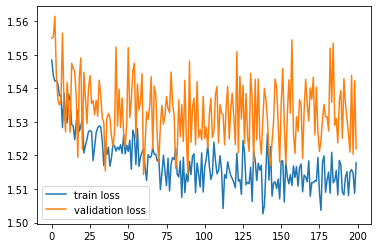

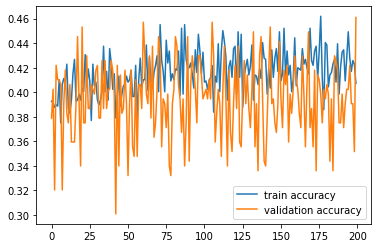

In [372]:
x = np.arange(total_epochs)
plt.plot(x,MTF_train_loss,label='train loss')
plt.plot(x,MTF_validate_loss,label='validation loss')
plt.legend()
plt.show()

plt.plot(x,MTF_train_accuracy,label='train accuracy')
plt.plot(x,MTF_validate_accuracy,label='validation accuracy')
plt.legend()
plt.show()


In [373]:
MTF_validate_loss = []
MTF_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, MT_MatchingNet, MT_scheduler, use_cuda, False)
        MTF_validate_loss.append(v_loss)
        MTF_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:02<08:10,  2.47s/it]

Epoch 0: validate_loss:1.5182317420840263 validate_accuracy:0.453125


  1%|▊                                                                                 | 2/200 [00:04<08:06,  2.46s/it]

Epoch 1: validate_loss:1.5222196131944656 validate_accuracy:0.3984375


  2%|█▏                                                                                | 3/200 [00:07<08:04,  2.46s/it]

Epoch 2: validate_loss:1.5033092945814133 validate_accuracy:0.4609375


  2%|█▋                                                                                | 4/200 [00:09<08:01,  2.46s/it]

Epoch 3: validate_loss:1.5130124539136887 validate_accuracy:0.41796875


  2%|██                                                                                | 5/200 [00:12<07:59,  2.46s/it]

Epoch 4: validate_loss:1.5194793194532394 validate_accuracy:0.42578125


  3%|██▍                                                                               | 6/200 [00:14<07:56,  2.46s/it]

Epoch 5: validate_loss:1.51480383425951 validate_accuracy:0.421875


  4%|██▊                                                                               | 7/200 [00:17<07:53,  2.45s/it]

Epoch 6: validate_loss:1.5284218415617943 validate_accuracy:0.39453125


  4%|███▎                                                                              | 8/200 [00:19<07:50,  2.45s/it]

Epoch 7: validate_loss:1.5102091580629349 validate_accuracy:0.4375


  4%|███▋                                                                              | 9/200 [00:22<07:48,  2.45s/it]

Epoch 8: validate_loss:1.5098663941025734 validate_accuracy:0.4140625


  5%|████                                                                             | 10/200 [00:24<07:47,  2.46s/it]

Epoch 9: validate_loss:1.5272119268774986 validate_accuracy:0.375


  6%|████▍                                                                            | 11/200 [00:27<07:44,  2.46s/it]

Epoch 10: validate_loss:1.5406481102108955 validate_accuracy:0.34765625


  6%|████▊                                                                            | 12/200 [00:29<07:42,  2.46s/it]

Epoch 11: validate_loss:1.4985833168029785 validate_accuracy:0.50390625


  6%|█████▎                                                                           | 13/200 [00:31<07:42,  2.47s/it]

Epoch 12: validate_loss:1.5087099224328995 validate_accuracy:0.43359375


  7%|█████▋                                                                           | 14/200 [00:34<07:40,  2.48s/it]

Epoch 13: validate_loss:1.518782116472721 validate_accuracy:0.40625


  8%|██████                                                                           | 15/200 [00:36<07:37,  2.48s/it]

Epoch 14: validate_loss:1.5027318447828293 validate_accuracy:0.375


  8%|██████▍                                                                          | 16/200 [00:39<07:33,  2.47s/it]

Epoch 15: validate_loss:1.5145454481244087 validate_accuracy:0.40625


  8%|██████▉                                                                          | 17/200 [00:41<07:31,  2.47s/it]

Epoch 16: validate_loss:1.5105732008814812 validate_accuracy:0.421875


  9%|███████▎                                                                         | 18/200 [00:44<07:29,  2.47s/it]

Epoch 17: validate_loss:1.516476146876812 validate_accuracy:0.40625


 10%|███████▋                                                                         | 19/200 [00:46<07:26,  2.47s/it]

Epoch 18: validate_loss:1.5071586444973946 validate_accuracy:0.421875


 10%|████████                                                                         | 20/200 [00:49<07:23,  2.46s/it]

Epoch 19: validate_loss:1.509713500738144 validate_accuracy:0.40625


 10%|████████▌                                                                        | 21/200 [00:51<07:20,  2.46s/it]

Epoch 20: validate_loss:1.511315979063511 validate_accuracy:0.4375


 11%|████████▉                                                                        | 22/200 [00:54<07:17,  2.46s/it]

Epoch 21: validate_loss:1.5104563161730766 validate_accuracy:0.4296875


 12%|█████████▎                                                                       | 23/200 [00:56<07:14,  2.45s/it]

Epoch 22: validate_loss:1.5070902332663536 validate_accuracy:0.41796875


 12%|█████████▋                                                                       | 24/200 [00:59<07:12,  2.45s/it]

Epoch 23: validate_loss:1.5079481229186058 validate_accuracy:0.453125


 12%|██████████▏                                                                      | 25/200 [01:01<07:09,  2.46s/it]

Epoch 24: validate_loss:1.4964877516031265 validate_accuracy:0.42578125


 13%|██████████▌                                                                      | 26/200 [01:03<07:06,  2.45s/it]

Epoch 25: validate_loss:1.5156407058238983 validate_accuracy:0.421875


 14%|██████████▉                                                                      | 27/200 [01:06<07:05,  2.46s/it]

Epoch 26: validate_loss:1.5160595700144768 validate_accuracy:0.40234375


 14%|███████████▎                                                                     | 28/200 [01:08<07:03,  2.46s/it]

Epoch 27: validate_loss:1.5169911682605743 validate_accuracy:0.41796875


 14%|███████████▋                                                                     | 29/200 [01:11<07:00,  2.46s/it]

Epoch 28: validate_loss:1.5267673507332802 validate_accuracy:0.390625


 15%|████████████▏                                                                    | 30/200 [01:13<06:57,  2.46s/it]

Epoch 29: validate_loss:1.5302826091647148 validate_accuracy:0.37890625


 16%|████████████▌                                                                    | 31/200 [01:16<06:54,  2.45s/it]

Epoch 30: validate_loss:1.5072878673672676 validate_accuracy:0.40625


 16%|████████████▉                                                                    | 32/200 [01:18<06:52,  2.46s/it]

Epoch 31: validate_loss:1.5115648657083511 validate_accuracy:0.4140625


 16%|█████████████▎                                                                   | 33/200 [01:21<06:50,  2.46s/it]

Epoch 32: validate_loss:1.5003637373447418 validate_accuracy:0.4765625


 17%|█████████████▊                                                                   | 34/200 [01:23<06:47,  2.46s/it]

Epoch 33: validate_loss:1.4956876784563065 validate_accuracy:0.46875


 18%|██████████████▏                                                                  | 35/200 [01:26<06:45,  2.46s/it]

Epoch 34: validate_loss:1.5302771106362343 validate_accuracy:0.359375


 18%|██████████████▌                                                                  | 36/200 [01:28<06:42,  2.46s/it]

Epoch 35: validate_loss:1.5112577229738235 validate_accuracy:0.421875


 18%|██████████████▉                                                                  | 37/200 [01:31<06:41,  2.46s/it]

Epoch 36: validate_loss:1.5037993341684341 validate_accuracy:0.453125


 19%|███████████████▍                                                                 | 38/200 [01:33<06:38,  2.46s/it]

Epoch 37: validate_loss:1.5218456909060478 validate_accuracy:0.3828125


 20%|███████████████▊                                                                 | 39/200 [01:35<06:36,  2.46s/it]

Epoch 38: validate_loss:1.5070501044392586 validate_accuracy:0.421875


 20%|████████████████▏                                                                | 40/200 [01:38<06:33,  2.46s/it]

Epoch 39: validate_loss:1.517570674419403 validate_accuracy:0.38671875


 20%|████████████████▌                                                                | 41/200 [01:40<06:31,  2.46s/it]

Epoch 40: validate_loss:1.5029185116291046 validate_accuracy:0.49609375


 21%|█████████████████                                                                | 42/200 [01:43<06:29,  2.47s/it]

Epoch 41: validate_loss:1.5237420126795769 validate_accuracy:0.390625


 22%|█████████████████▍                                                               | 43/200 [01:45<06:26,  2.46s/it]

Epoch 42: validate_loss:1.510196976363659 validate_accuracy:0.45703125


 22%|█████████████████▊                                                               | 44/200 [01:48<06:23,  2.46s/it]

Epoch 43: validate_loss:1.524819977581501 validate_accuracy:0.35546875


 22%|██████████████████▏                                                              | 45/200 [01:50<06:20,  2.46s/it]

Epoch 44: validate_loss:1.5094278305768967 validate_accuracy:0.45703125


 23%|██████████████████▋                                                              | 46/200 [01:53<06:18,  2.45s/it]

Epoch 45: validate_loss:1.5000381246209145 validate_accuracy:0.41796875


 24%|███████████████████                                                              | 47/200 [01:55<06:15,  2.46s/it]

Epoch 46: validate_loss:1.5098880678415298 validate_accuracy:0.453125


 24%|███████████████████▍                                                             | 48/200 [01:58<06:13,  2.46s/it]

Epoch 47: validate_loss:1.5097032487392426 validate_accuracy:0.46875


 24%|███████████████████▊                                                             | 49/200 [02:00<06:11,  2.46s/it]

Epoch 48: validate_loss:1.526460699737072 validate_accuracy:0.3984375


 25%|████████████████████▎                                                            | 50/200 [02:02<06:08,  2.46s/it]

Epoch 49: validate_loss:1.5109826996922493 validate_accuracy:0.42578125


 26%|████████████████████▋                                                            | 51/200 [02:05<06:05,  2.46s/it]

Epoch 50: validate_loss:1.5084025487303734 validate_accuracy:0.45703125


 26%|█████████████████████                                                            | 52/200 [02:07<06:03,  2.46s/it]

Epoch 51: validate_loss:1.512778453528881 validate_accuracy:0.390625


 26%|█████████████████████▍                                                           | 53/200 [02:10<06:01,  2.46s/it]

Epoch 52: validate_loss:1.5105419531464577 validate_accuracy:0.42578125


 27%|█████████████████████▊                                                           | 54/200 [02:12<05:58,  2.45s/it]

Epoch 53: validate_loss:1.5174139887094498 validate_accuracy:0.40234375


 28%|██████████████████████▎                                                          | 55/200 [02:15<05:57,  2.46s/it]

Epoch 54: validate_loss:1.5075555369257927 validate_accuracy:0.421875


 28%|██████████████████████▋                                                          | 56/200 [02:17<05:54,  2.46s/it]

Epoch 55: validate_loss:1.511882096529007 validate_accuracy:0.41015625


 28%|███████████████████████                                                          | 57/200 [02:20<05:52,  2.47s/it]

Epoch 56: validate_loss:1.5171745046973228 validate_accuracy:0.41015625


 29%|███████████████████████▍                                                         | 58/200 [02:22<05:49,  2.46s/it]

Epoch 57: validate_loss:1.5050146505236626 validate_accuracy:0.44140625


 30%|███████████████████████▉                                                         | 59/200 [02:25<05:46,  2.46s/it]

Epoch 58: validate_loss:1.509218119084835 validate_accuracy:0.453125


 30%|████████████████████████▎                                                        | 60/200 [02:27<05:43,  2.46s/it]

Epoch 59: validate_loss:1.509725198149681 validate_accuracy:0.43359375


 30%|████████████████████████▋                                                        | 61/200 [02:30<05:41,  2.46s/it]

Epoch 60: validate_loss:1.5052297413349152 validate_accuracy:0.41796875


 31%|█████████████████████████                                                        | 62/200 [02:32<05:38,  2.45s/it]

Epoch 61: validate_loss:1.5107511430978775 validate_accuracy:0.390625


 32%|█████████████████████████▌                                                       | 63/200 [02:34<05:36,  2.46s/it]

Epoch 62: validate_loss:1.508505679666996 validate_accuracy:0.453125


 32%|█████████████████████████▉                                                       | 64/200 [02:37<05:34,  2.46s/it]

Epoch 63: validate_loss:1.5112749859690666 validate_accuracy:0.44140625


 32%|██████████████████████████▎                                                      | 65/200 [02:39<05:31,  2.46s/it]

Epoch 64: validate_loss:1.5121386423707008 validate_accuracy:0.39453125


 33%|██████████████████████████▋                                                      | 66/200 [02:42<05:29,  2.46s/it]

Epoch 65: validate_loss:1.5122542902827263 validate_accuracy:0.421875


 34%|███████████████████████████▏                                                     | 67/200 [02:44<05:27,  2.46s/it]

Epoch 66: validate_loss:1.523281566798687 validate_accuracy:0.41796875


 34%|███████████████████████████▌                                                     | 68/200 [02:47<05:24,  2.46s/it]

Epoch 67: validate_loss:1.4984258711338043 validate_accuracy:0.4609375


 34%|███████████████████████████▉                                                     | 69/200 [02:49<05:23,  2.47s/it]

Epoch 68: validate_loss:1.5168503671884537 validate_accuracy:0.390625


 35%|████████████████████████████▎                                                    | 70/200 [02:52<05:21,  2.47s/it]

Epoch 69: validate_loss:1.5163381770253181 validate_accuracy:0.453125


 36%|████████████████████████████▊                                                    | 71/200 [02:54<05:18,  2.47s/it]

Epoch 70: validate_loss:1.529516264796257 validate_accuracy:0.3671875


 36%|█████████████████████████████▏                                                   | 72/200 [02:57<05:15,  2.47s/it]

Epoch 71: validate_loss:1.5118377655744553 validate_accuracy:0.43359375


 36%|█████████████████████████████▌                                                   | 73/200 [02:59<05:13,  2.47s/it]

Epoch 72: validate_loss:1.5090562775731087 validate_accuracy:0.41796875


 37%|█████████████████████████████▉                                                   | 74/200 [03:02<05:10,  2.47s/it]

Epoch 73: validate_loss:1.5053180158138275 validate_accuracy:0.38671875


 38%|██████████████████████████████▍                                                  | 75/200 [03:04<05:08,  2.47s/it]

Epoch 74: validate_loss:1.5250375047326088 validate_accuracy:0.35546875


 38%|██████████████████████████████▊                                                  | 76/200 [03:06<05:05,  2.46s/it]

Epoch 75: validate_loss:1.5025172010064125 validate_accuracy:0.45703125


 38%|███████████████████████████████▏                                                 | 77/200 [03:09<05:01,  2.45s/it]

Epoch 76: validate_loss:1.5202722027897835 validate_accuracy:0.40625


 39%|███████████████████████████████▌                                                 | 78/200 [03:11<04:59,  2.46s/it]

Epoch 77: validate_loss:1.5124845132231712 validate_accuracy:0.40234375


 40%|███████████████████████████████▉                                                 | 79/200 [03:14<04:57,  2.46s/it]

Epoch 78: validate_loss:1.5030415877699852 validate_accuracy:0.46875


 40%|████████████████████████████████▍                                                | 80/200 [03:16<04:54,  2.46s/it]

Epoch 79: validate_loss:1.521528460085392 validate_accuracy:0.359375


 40%|████████████████████████████████▊                                                | 81/200 [03:19<04:52,  2.45s/it]

Epoch 80: validate_loss:1.5008929669857025 validate_accuracy:0.44140625


 41%|█████████████████████████████████▏                                               | 82/200 [03:21<04:50,  2.46s/it]

Epoch 81: validate_loss:1.513346403837204 validate_accuracy:0.3984375


 42%|█████████████████████████████████▌                                               | 83/200 [03:24<04:48,  2.47s/it]

Epoch 82: validate_loss:1.5251360163092613 validate_accuracy:0.40234375


 42%|██████████████████████████████████                                               | 84/200 [03:26<04:46,  2.47s/it]

Epoch 83: validate_loss:1.5124240517616272 validate_accuracy:0.40234375


 42%|██████████████████████████████████▍                                              | 85/200 [03:29<04:43,  2.47s/it]

Epoch 84: validate_loss:1.5139770060777664 validate_accuracy:0.39453125


 43%|██████████████████████████████████▊                                              | 86/200 [03:31<04:40,  2.46s/it]

Epoch 85: validate_loss:1.5008387863636017 validate_accuracy:0.46484375


 44%|███████████████████████████████████▏                                             | 87/200 [03:34<04:38,  2.46s/it]

Epoch 86: validate_loss:1.5083297565579414 validate_accuracy:0.40234375


 44%|███████████████████████████████████▋                                             | 88/200 [03:36<04:34,  2.45s/it]

Epoch 87: validate_loss:1.5116462782025337 validate_accuracy:0.375


 44%|████████████████████████████████████                                             | 89/200 [03:38<04:31,  2.45s/it]

Epoch 88: validate_loss:1.5060845538973808 validate_accuracy:0.44921875


 45%|████████████████████████████████████▍                                            | 90/200 [03:41<04:29,  2.45s/it]

Epoch 89: validate_loss:1.510711245238781 validate_accuracy:0.4140625


 46%|████████████████████████████████████▊                                            | 91/200 [03:43<04:27,  2.45s/it]

Epoch 90: validate_loss:1.5089716091752052 validate_accuracy:0.42578125


 46%|█████████████████████████████████████▎                                           | 92/200 [03:46<04:24,  2.45s/it]

Epoch 91: validate_loss:1.5106352865695953 validate_accuracy:0.43359375


 46%|█████████████████████████████████████▋                                           | 93/200 [03:48<04:22,  2.45s/it]

Epoch 92: validate_loss:1.5059961527585983 validate_accuracy:0.453125


 47%|██████████████████████████████████████                                           | 94/200 [03:51<04:19,  2.45s/it]

Epoch 93: validate_loss:1.5029843896627426 validate_accuracy:0.46484375


 48%|██████████████████████████████████████▍                                          | 95/200 [03:53<04:17,  2.45s/it]

Epoch 94: validate_loss:1.5187480598688126 validate_accuracy:0.39453125


 48%|██████████████████████████████████████▉                                          | 96/200 [03:56<04:14,  2.45s/it]

Epoch 95: validate_loss:1.5271380096673965 validate_accuracy:0.3828125


 48%|███████████████████████████████████████▎                                         | 97/200 [03:58<04:12,  2.45s/it]

Epoch 96: validate_loss:1.5240707397460938 validate_accuracy:0.37109375


 49%|███████████████████████████████████████▋                                         | 98/200 [04:00<04:10,  2.45s/it]

Epoch 97: validate_loss:1.5099362209439278 validate_accuracy:0.4375


 50%|████████████████████████████████████████                                         | 99/200 [04:03<04:08,  2.46s/it]

Epoch 98: validate_loss:1.529586412012577 validate_accuracy:0.375


 50%|████████████████████████████████████████                                        | 100/200 [04:05<04:06,  2.46s/it]

Epoch 99: validate_loss:1.5152559205889702 validate_accuracy:0.3984375


 50%|████████████████████████████████████████▍                                       | 101/200 [04:08<04:04,  2.47s/it]

Epoch 100: validate_loss:1.4975358918309212 validate_accuracy:0.421875


 51%|████████████████████████████████████████▊                                       | 102/200 [04:10<04:02,  2.47s/it]

Epoch 101: validate_loss:1.5228031650185585 validate_accuracy:0.3828125


 52%|█████████████████████████████████████████▏                                      | 103/200 [04:13<04:00,  2.47s/it]

Epoch 102: validate_loss:1.5042584016919136 validate_accuracy:0.45703125


 52%|█████████████████████████████████████████▌                                      | 104/200 [04:15<03:57,  2.48s/it]

Epoch 103: validate_loss:1.5185298174619675 validate_accuracy:0.4375


 52%|██████████████████████████████████████████                                      | 105/200 [04:18<03:54,  2.47s/it]

Epoch 104: validate_loss:1.520280010998249 validate_accuracy:0.42578125


 53%|██████████████████████████████████████████▍                                     | 106/200 [04:20<03:51,  2.46s/it]

Epoch 105: validate_loss:1.5161865800619125 validate_accuracy:0.42578125


 54%|██████████████████████████████████████████▊                                     | 107/200 [04:23<03:49,  2.47s/it]

Epoch 106: validate_loss:1.5159255266189575 validate_accuracy:0.41796875


 54%|███████████████████████████████████████████▏                                    | 108/200 [04:25<03:46,  2.47s/it]

Epoch 107: validate_loss:1.4965117126703262 validate_accuracy:0.4453125


 55%|███████████████████████████████████████████▌                                    | 109/200 [04:28<03:44,  2.46s/it]

Epoch 108: validate_loss:1.513728991150856 validate_accuracy:0.4140625


 55%|████████████████████████████████████████████                                    | 110/200 [04:30<03:41,  2.47s/it]

Epoch 109: validate_loss:1.5264194160699844 validate_accuracy:0.421875


 56%|████████████████████████████████████████████▍                                   | 111/200 [04:33<03:39,  2.47s/it]

Epoch 110: validate_loss:1.5097667053341866 validate_accuracy:0.40625


 56%|████████████████████████████████████████████▊                                   | 112/200 [04:35<03:36,  2.46s/it]

Epoch 111: validate_loss:1.5092307403683662 validate_accuracy:0.4296875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [04:38<03:34,  2.46s/it]

Epoch 112: validate_loss:1.5042285397648811 validate_accuracy:0.46875


 57%|█████████████████████████████████████████████▌                                  | 114/200 [04:40<03:32,  2.47s/it]

Epoch 113: validate_loss:1.5259209796786308 validate_accuracy:0.45703125


 57%|██████████████████████████████████████████████                                  | 115/200 [04:42<03:29,  2.47s/it]

Epoch 114: validate_loss:1.511620543897152 validate_accuracy:0.43359375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [04:45<03:27,  2.47s/it]

Epoch 115: validate_loss:1.4982556849718094 validate_accuracy:0.45703125


 58%|██████████████████████████████████████████████▊                                 | 117/200 [04:47<03:24,  2.46s/it]

Epoch 116: validate_loss:1.5124784037470818 validate_accuracy:0.4375


 59%|███████████████████████████████████████████████▏                                | 118/200 [04:50<03:21,  2.46s/it]

Epoch 117: validate_loss:1.511403277516365 validate_accuracy:0.45703125


 60%|███████████████████████████████████████████████▌                                | 119/200 [04:52<03:19,  2.46s/it]

Epoch 118: validate_loss:1.4952227771282196 validate_accuracy:0.47265625


 60%|████████████████████████████████████████████████                                | 120/200 [04:55<03:17,  2.46s/it]

Epoch 119: validate_loss:1.5137983113527298 validate_accuracy:0.38671875


 60%|████████████████████████████████████████████████▍                               | 121/200 [04:57<03:14,  2.46s/it]

Epoch 120: validate_loss:1.5222468599677086 validate_accuracy:0.42578125


 61%|████████████████████████████████████████████████▊                               | 122/200 [05:00<03:11,  2.46s/it]

Epoch 121: validate_loss:1.5114479660987854 validate_accuracy:0.39453125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [05:02<03:09,  2.46s/it]

Epoch 122: validate_loss:1.5141331478953362 validate_accuracy:0.43359375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [05:05<03:07,  2.47s/it]

Epoch 123: validate_loss:1.52088463306427 validate_accuracy:0.40234375


 62%|██████████████████████████████████████████████████                              | 125/200 [05:07<03:04,  2.47s/it]

Epoch 124: validate_loss:1.518594652414322 validate_accuracy:0.421875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [05:10<03:02,  2.47s/it]

Epoch 125: validate_loss:1.506622888147831 validate_accuracy:0.45703125


 64%|██████████████████████████████████████████████████▊                             | 127/200 [05:12<03:00,  2.47s/it]

Epoch 126: validate_loss:1.5172107741236687 validate_accuracy:0.42578125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [05:15<02:58,  2.48s/it]

Epoch 127: validate_loss:1.517628699541092 validate_accuracy:0.421875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [05:17<02:55,  2.47s/it]

Epoch 128: validate_loss:1.5251569002866745 validate_accuracy:0.38671875


 65%|████████████████████████████████████████████████████                            | 130/200 [05:19<02:52,  2.47s/it]

Epoch 129: validate_loss:1.5004937946796417 validate_accuracy:0.4453125


 66%|████████████████████████████████████████████████████▍                           | 131/200 [05:22<02:49,  2.46s/it]

Epoch 130: validate_loss:1.5055997297167778 validate_accuracy:0.43359375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [05:24<02:47,  2.46s/it]

Epoch 131: validate_loss:1.5008409097790718 validate_accuracy:0.44921875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [05:27<02:44,  2.45s/it]

Epoch 132: validate_loss:1.513709083199501 validate_accuracy:0.4453125


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [05:29<02:42,  2.46s/it]

Epoch 133: validate_loss:1.5121182575821877 validate_accuracy:0.41015625


 68%|██████████████████████████████████████████████████████                          | 135/200 [05:32<02:40,  2.47s/it]

Epoch 134: validate_loss:1.5077095553278923 validate_accuracy:0.42578125


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [05:34<02:38,  2.47s/it]

Epoch 135: validate_loss:1.5200727880001068 validate_accuracy:0.3828125


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [05:37<02:35,  2.47s/it]

Epoch 136: validate_loss:1.5119913592934608 validate_accuracy:0.41015625


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [05:39<02:32,  2.47s/it]

Epoch 137: validate_loss:1.5304748937487602 validate_accuracy:0.375


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [05:42<02:30,  2.46s/it]

Epoch 138: validate_loss:1.5128353610634804 validate_accuracy:0.375


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:44<02:27,  2.47s/it]

Epoch 139: validate_loss:1.5237623676657677 validate_accuracy:0.421875


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:47<02:25,  2.46s/it]

Epoch 140: validate_loss:1.4947791174054146 validate_accuracy:0.453125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [05:49<02:22,  2.46s/it]

Epoch 141: validate_loss:1.5053342133760452 validate_accuracy:0.46875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [05:51<02:20,  2.46s/it]

Epoch 142: validate_loss:1.505846031010151 validate_accuracy:0.46484375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [05:54<02:17,  2.46s/it]

Epoch 143: validate_loss:1.5234106108546257 validate_accuracy:0.41015625


 72%|██████████████████████████████████████████████████████████                      | 145/200 [05:56<02:15,  2.46s/it]

Epoch 144: validate_loss:1.5102010443806648 validate_accuracy:0.40625


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [05:59<02:12,  2.46s/it]

Epoch 145: validate_loss:1.5102642849087715 validate_accuracy:0.45703125


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [06:01<02:10,  2.46s/it]

Epoch 146: validate_loss:1.491589516401291 validate_accuracy:0.4921875


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [06:04<02:07,  2.46s/it]

Epoch 147: validate_loss:1.5221239030361176 validate_accuracy:0.3828125


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [06:06<02:05,  2.46s/it]

Epoch 148: validate_loss:1.5062301754951477 validate_accuracy:0.453125


 75%|████████████████████████████████████████████████████████████                    | 150/200 [06:09<02:02,  2.45s/it]

Epoch 149: validate_loss:1.5159445106983185 validate_accuracy:0.42578125


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [06:11<02:00,  2.45s/it]

Epoch 150: validate_loss:1.519586205482483 validate_accuracy:0.40234375


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [06:14<01:57,  2.46s/it]

Epoch 151: validate_loss:1.5203214511275291 validate_accuracy:0.40625


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [06:16<01:55,  2.45s/it]

Epoch 152: validate_loss:1.5195665508508682 validate_accuracy:0.4375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [06:18<01:52,  2.45s/it]

Epoch 153: validate_loss:1.5146114379167557 validate_accuracy:0.41015625


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [06:21<01:50,  2.46s/it]

Epoch 154: validate_loss:1.5145979449152946 validate_accuracy:0.4375


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [06:23<01:48,  2.46s/it]

Epoch 155: validate_loss:1.5275952070951462 validate_accuracy:0.3828125


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [06:26<01:45,  2.45s/it]

Epoch 156: validate_loss:1.5123815014958382 validate_accuracy:0.453125


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [06:28<01:43,  2.45s/it]

Epoch 157: validate_loss:1.5239619687199593 validate_accuracy:0.3984375


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [06:31<01:40,  2.45s/it]

Epoch 158: validate_loss:1.5205156207084656 validate_accuracy:0.39453125


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:33<01:38,  2.45s/it]

Epoch 159: validate_loss:1.5281251072883606 validate_accuracy:0.421875


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:36<01:35,  2.45s/it]

Epoch 160: validate_loss:1.5379180535674095 validate_accuracy:0.37890625


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [06:38<01:33,  2.45s/it]

Epoch 161: validate_loss:1.5127122551202774 validate_accuracy:0.4375


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [06:41<01:31,  2.46s/it]

Epoch 162: validate_loss:1.503300555050373 validate_accuracy:0.4296875


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [06:43<01:28,  2.47s/it]

Epoch 163: validate_loss:1.5076440498232841 validate_accuracy:0.40234375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [06:46<01:26,  2.47s/it]

Epoch 164: validate_loss:1.518495924770832 validate_accuracy:0.39453125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [06:48<01:23,  2.47s/it]

Epoch 165: validate_loss:1.5102376639842987 validate_accuracy:0.39453125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [06:50<01:21,  2.47s/it]

Epoch 166: validate_loss:1.5045500919222832 validate_accuracy:0.453125


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [06:53<01:18,  2.46s/it]

Epoch 167: validate_loss:1.5069567561149597 validate_accuracy:0.453125


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [06:55<01:16,  2.46s/it]

Epoch 168: validate_loss:1.5096420049667358 validate_accuracy:0.45703125


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [06:58<01:14,  2.47s/it]

Epoch 169: validate_loss:1.5177677422761917 validate_accuracy:0.390625


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [07:00<01:11,  2.47s/it]

Epoch 170: validate_loss:1.525450885295868 validate_accuracy:0.390625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [07:03<01:08,  2.46s/it]

Epoch 171: validate_loss:1.5037138313055038 validate_accuracy:0.4453125


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [07:05<01:06,  2.47s/it]

Epoch 172: validate_loss:1.5170744210481644 validate_accuracy:0.41015625


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [07:08<01:04,  2.48s/it]

Epoch 173: validate_loss:1.5079025626182556 validate_accuracy:0.46484375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [07:10<01:01,  2.47s/it]

Epoch 174: validate_loss:1.5197607949376106 validate_accuracy:0.41015625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [07:13<00:59,  2.47s/it]

Epoch 175: validate_loss:1.5012382566928864 validate_accuracy:0.421875


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [07:15<00:56,  2.47s/it]

Epoch 176: validate_loss:1.5089737251400948 validate_accuracy:0.46484375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [07:18<00:54,  2.47s/it]

Epoch 177: validate_loss:1.5034801736474037 validate_accuracy:0.40625


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [07:20<00:51,  2.47s/it]

Epoch 178: validate_loss:1.5134093016386032 validate_accuracy:0.42578125


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [07:23<00:49,  2.46s/it]

Epoch 179: validate_loss:1.5161435678601265 validate_accuracy:0.4375


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [07:25<00:46,  2.46s/it]

Epoch 180: validate_loss:1.5300815775990486 validate_accuracy:0.3671875


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [07:27<00:44,  2.46s/it]

Epoch 181: validate_loss:1.50537721067667 validate_accuracy:0.44140625


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [07:30<00:41,  2.45s/it]

Epoch 182: validate_loss:1.5190394967794418 validate_accuracy:0.41015625


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [07:32<00:39,  2.46s/it]

Epoch 183: validate_loss:1.507057286798954 validate_accuracy:0.4375


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [07:35<00:36,  2.46s/it]

Epoch 184: validate_loss:1.5168439522385597 validate_accuracy:0.421875


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [07:37<00:34,  2.46s/it]

Epoch 185: validate_loss:1.5052786245942116 validate_accuracy:0.46484375


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [07:40<00:31,  2.45s/it]

Epoch 186: validate_loss:1.505785122513771 validate_accuracy:0.4453125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [07:42<00:29,  2.45s/it]

Epoch 187: validate_loss:1.5079056471586227 validate_accuracy:0.4296875


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [07:45<00:26,  2.45s/it]

Epoch 188: validate_loss:1.5090651884675026 validate_accuracy:0.453125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [07:47<00:24,  2.46s/it]

Epoch 189: validate_loss:1.5380395874381065 validate_accuracy:0.35546875


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:49<00:22,  2.45s/it]

Epoch 190: validate_loss:1.5113446786999702 validate_accuracy:0.453125


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [07:52<00:19,  2.45s/it]

Epoch 191: validate_loss:1.5134932100772858 validate_accuracy:0.4375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [07:54<00:17,  2.45s/it]

Epoch 192: validate_loss:1.543333761394024 validate_accuracy:0.36328125


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [07:57<00:14,  2.46s/it]

Epoch 193: validate_loss:1.4963337555527687 validate_accuracy:0.48828125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [07:59<00:12,  2.46s/it]

Epoch 194: validate_loss:1.5278470888733864 validate_accuracy:0.359375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [08:02<00:09,  2.45s/it]

Epoch 195: validate_loss:1.5017714872956276 validate_accuracy:0.4609375


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [08:04<00:07,  2.45s/it]

Epoch 196: validate_loss:1.5111572295427322 validate_accuracy:0.40625


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [08:07<00:04,  2.45s/it]

Epoch 197: validate_loss:1.5165444388985634 validate_accuracy:0.390625


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [08:09<00:02,  2.45s/it]

Epoch 198: validate_loss:1.52899120002985 validate_accuracy:0.40234375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [08:12<00:00,  2.46s/it]

Epoch 199: validate_loss:1.5040967091917992 validate_accuracy:0.4765625


In [374]:
np.mean(MTF_validate_accuracy)

0.42166015625

# Recombination: Omniglot(FCE) + Cifar & miniImageNet

In [421]:
cifarC = CifarClassifier(layer_size=64, nClasses = 0, num_channels = 3, keep_prob = 0.0, image_size = 32, freeze = False)
pretrained_dict = torch.load('Mnet_params.pth')
model_dict = cifarC.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
cifarC.load_state_dict(model_dict)
cifarC.freeze()

OT_MatchingNet.embedding = cifarC
OTT_validate_loss = []
OTT_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, OT_MatchingNet.cuda(), OT_scheduler, use_cuda, False)
        OTT_validate_loss.append(v_loss)
        OTT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:35,  2.08it/s]

Epoch 0: validate_loss:1.534011960029602 validate_accuracy:0.375


  1%|▊                                                                                 | 2/200 [00:00<01:34,  2.09it/s]

Epoch 1: validate_loss:1.531746044754982 validate_accuracy:0.36328125


  2%|█▏                                                                                | 3/200 [00:01<01:34,  2.09it/s]

Epoch 2: validate_loss:1.534966953098774 validate_accuracy:0.37890625


  2%|█▋                                                                                | 4/200 [00:01<01:34,  2.07it/s]

Epoch 3: validate_loss:1.5249419063329697 validate_accuracy:0.44140625


  2%|██                                                                                | 5/200 [00:02<01:33,  2.09it/s]

Epoch 4: validate_loss:1.5285338759422302 validate_accuracy:0.41015625


  3%|██▍                                                                               | 6/200 [00:02<01:34,  2.06it/s]

Epoch 5: validate_loss:1.5185470432043076 validate_accuracy:0.40625


  4%|██▊                                                                               | 7/200 [00:03<01:32,  2.09it/s]

Epoch 6: validate_loss:1.5330246463418007 validate_accuracy:0.3984375


  4%|███▎                                                                              | 8/200 [00:03<01:31,  2.10it/s]

Epoch 7: validate_loss:1.522172972559929 validate_accuracy:0.390625


  4%|███▋                                                                              | 9/200 [00:04<01:30,  2.10it/s]

Epoch 8: validate_loss:1.513368010520935 validate_accuracy:0.41796875


  5%|████                                                                             | 10/200 [00:04<01:31,  2.08it/s]

Epoch 9: validate_loss:1.543103650212288 validate_accuracy:0.3515625


  6%|████▍                                                                            | 11/200 [00:05<01:30,  2.09it/s]

Epoch 10: validate_loss:1.5415208712220192 validate_accuracy:0.39453125


  6%|████▊                                                                            | 12/200 [00:05<01:29,  2.10it/s]

Epoch 11: validate_loss:1.5186777114868164 validate_accuracy:0.41796875


  6%|█████▎                                                                           | 13/200 [00:06<01:28,  2.10it/s]

Epoch 12: validate_loss:1.5153805539011955 validate_accuracy:0.41015625


  7%|█████▋                                                                           | 14/200 [00:06<01:28,  2.10it/s]

Epoch 13: validate_loss:1.5256938189268112 validate_accuracy:0.34765625


  8%|██████                                                                           | 15/200 [00:07<01:28,  2.10it/s]

Epoch 14: validate_loss:1.5309677347540855 validate_accuracy:0.35546875


  8%|██████▍                                                                          | 16/200 [00:07<01:26,  2.12it/s]

Epoch 15: validate_loss:1.5381589233875275 validate_accuracy:0.35546875


  8%|██████▉                                                                          | 17/200 [00:08<01:25,  2.13it/s]

Epoch 16: validate_loss:1.533925622701645 validate_accuracy:0.33984375


  9%|███████▎                                                                         | 18/200 [00:08<01:25,  2.13it/s]

Epoch 17: validate_loss:1.52677521109581 validate_accuracy:0.35546875


 10%|███████▋                                                                         | 19/200 [00:09<01:25,  2.11it/s]

Epoch 18: validate_loss:1.534427560865879 validate_accuracy:0.38671875


 10%|████████                                                                         | 20/200 [00:09<01:25,  2.10it/s]

Epoch 19: validate_loss:1.5322333127260208 validate_accuracy:0.37890625


 10%|████████▌                                                                        | 21/200 [00:09<01:24,  2.12it/s]

Epoch 20: validate_loss:1.5164644867181778 validate_accuracy:0.41015625


 11%|████████▉                                                                        | 22/200 [00:10<01:24,  2.12it/s]

Epoch 21: validate_loss:1.5118003338575363 validate_accuracy:0.484375


 12%|█████████▎                                                                       | 23/200 [00:10<01:24,  2.10it/s]

Epoch 22: validate_loss:1.5052898898720741 validate_accuracy:0.44921875


 12%|█████████▋                                                                       | 24/200 [00:11<01:23,  2.11it/s]

Epoch 23: validate_loss:1.5443936586380005 validate_accuracy:0.328125


 12%|██████████▏                                                                      | 25/200 [00:11<01:22,  2.12it/s]

Epoch 24: validate_loss:1.524787575006485 validate_accuracy:0.45703125


 13%|██████████▌                                                                      | 26/200 [00:12<01:22,  2.12it/s]

Epoch 25: validate_loss:1.5382074415683746 validate_accuracy:0.34375


 14%|██████████▉                                                                      | 27/200 [00:12<01:21,  2.11it/s]

Epoch 26: validate_loss:1.5403871163725853 validate_accuracy:0.3828125


 14%|███████████▎                                                                     | 28/200 [00:13<01:21,  2.11it/s]

Epoch 27: validate_loss:1.5310470685362816 validate_accuracy:0.3671875


 14%|███████████▋                                                                     | 29/200 [00:13<01:20,  2.11it/s]

Epoch 28: validate_loss:1.5464522987604141 validate_accuracy:0.31640625


 15%|████████████▏                                                                    | 30/200 [00:14<01:21,  2.10it/s]

Epoch 29: validate_loss:1.5344802886247635 validate_accuracy:0.41015625


 16%|████████████▌                                                                    | 31/200 [00:14<01:20,  2.09it/s]

Epoch 30: validate_loss:1.5246774852275848 validate_accuracy:0.41015625


 16%|████████████▉                                                                    | 32/200 [00:15<01:20,  2.09it/s]

Epoch 31: validate_loss:1.542988657951355 validate_accuracy:0.3359375


 16%|█████████████▎                                                                   | 33/200 [00:15<01:19,  2.10it/s]

Epoch 32: validate_loss:1.5482092276215553 validate_accuracy:0.3125


 17%|█████████████▊                                                                   | 34/200 [00:16<01:18,  2.12it/s]

Epoch 33: validate_loss:1.5305159464478493 validate_accuracy:0.37890625


 18%|██████████████▏                                                                  | 35/200 [00:16<01:17,  2.13it/s]

Epoch 34: validate_loss:1.5304730236530304 validate_accuracy:0.390625


 18%|██████████████▌                                                                  | 36/200 [00:17<01:17,  2.12it/s]

Epoch 35: validate_loss:1.5403713211417198 validate_accuracy:0.3515625


 18%|██████████████▉                                                                  | 37/200 [00:17<01:16,  2.12it/s]

Epoch 36: validate_loss:1.4984581470489502 validate_accuracy:0.45703125


 19%|███████████████▍                                                                 | 38/200 [00:18<01:16,  2.12it/s]

Epoch 37: validate_loss:1.5146658644080162 validate_accuracy:0.41796875


 20%|███████████████▊                                                                 | 39/200 [00:18<01:16,  2.12it/s]

Epoch 38: validate_loss:1.5349474102258682 validate_accuracy:0.359375


 20%|████████████████▏                                                                | 40/200 [00:18<01:15,  2.12it/s]

Epoch 39: validate_loss:1.5276315212249756 validate_accuracy:0.41796875


 20%|████████████████▌                                                                | 41/200 [00:19<01:14,  2.12it/s]

Epoch 40: validate_loss:1.5319784432649612 validate_accuracy:0.390625


 21%|█████████████████                                                                | 42/200 [00:19<01:14,  2.12it/s]

Epoch 41: validate_loss:1.5333296656608582 validate_accuracy:0.38671875


 22%|█████████████████▍                                                               | 43/200 [00:20<01:13,  2.13it/s]

Epoch 42: validate_loss:1.5270275548100471 validate_accuracy:0.41796875


 22%|█████████████████▊                                                               | 44/200 [00:20<01:12,  2.14it/s]

Epoch 43: validate_loss:1.5205556452274323 validate_accuracy:0.4296875


 22%|██████████████████▏                                                              | 45/200 [00:21<01:12,  2.13it/s]

Epoch 44: validate_loss:1.5273416563868523 validate_accuracy:0.40234375


 23%|██████████████████▋                                                              | 46/200 [00:21<01:12,  2.13it/s]

Epoch 45: validate_loss:1.5414213612675667 validate_accuracy:0.37890625


 24%|███████████████████                                                              | 47/200 [00:22<01:11,  2.13it/s]

Epoch 46: validate_loss:1.5384942442178726 validate_accuracy:0.36328125


 24%|███████████████████▍                                                             | 48/200 [00:22<01:11,  2.13it/s]

Epoch 47: validate_loss:1.5341349765658379 validate_accuracy:0.37109375


 24%|███████████████████▊                                                             | 49/200 [00:23<01:11,  2.12it/s]

Epoch 48: validate_loss:1.5051530450582504 validate_accuracy:0.41015625


 25%|████████████████████▎                                                            | 50/200 [00:23<01:10,  2.11it/s]

Epoch 49: validate_loss:1.5260581001639366 validate_accuracy:0.38671875


 26%|████████████████████▋                                                            | 51/200 [00:24<01:10,  2.12it/s]

Epoch 50: validate_loss:1.542235054075718 validate_accuracy:0.37109375


 26%|█████████████████████                                                            | 52/200 [00:24<01:10,  2.11it/s]

Epoch 51: validate_loss:1.5369324386119843 validate_accuracy:0.3515625


 26%|█████████████████████▍                                                           | 53/200 [00:25<01:09,  2.12it/s]

Epoch 52: validate_loss:1.5129925608634949 validate_accuracy:0.4375


 27%|█████████████████████▊                                                           | 54/200 [00:25<01:08,  2.12it/s]

Epoch 53: validate_loss:1.5423469841480255 validate_accuracy:0.33984375


 28%|██████████████████████▎                                                          | 55/200 [00:26<01:08,  2.13it/s]

Epoch 54: validate_loss:1.5234973207116127 validate_accuracy:0.40625


 28%|██████████████████████▋                                                          | 56/200 [00:26<01:07,  2.13it/s]

Epoch 55: validate_loss:1.5408387929201126 validate_accuracy:0.375


 28%|███████████████████████                                                          | 57/200 [00:26<01:07,  2.12it/s]

Epoch 56: validate_loss:1.526562660932541 validate_accuracy:0.39453125


 29%|███████████████████████▍                                                         | 58/200 [00:27<01:07,  2.12it/s]

Epoch 57: validate_loss:1.533552959561348 validate_accuracy:0.375


 30%|███████████████████████▉                                                         | 59/200 [00:27<01:07,  2.10it/s]

Epoch 58: validate_loss:1.5165134519338608 validate_accuracy:0.41796875


 30%|████████████████████████▎                                                        | 60/200 [00:28<01:06,  2.09it/s]

Epoch 59: validate_loss:1.5238000825047493 validate_accuracy:0.42578125


 30%|████████████████████████▋                                                        | 61/200 [00:28<01:06,  2.10it/s]

Epoch 60: validate_loss:1.5174406096339226 validate_accuracy:0.41015625


 31%|█████████████████████████                                                        | 62/200 [00:29<01:05,  2.09it/s]

Epoch 61: validate_loss:1.5384817346930504 validate_accuracy:0.3671875


 32%|█████████████████████████▌                                                       | 63/200 [00:29<01:05,  2.08it/s]

Epoch 62: validate_loss:1.5327303484082222 validate_accuracy:0.34765625


 32%|█████████████████████████▉                                                       | 64/200 [00:30<01:05,  2.08it/s]

Epoch 63: validate_loss:1.5314072147011757 validate_accuracy:0.40234375


 32%|██████████████████████████▎                                                      | 65/200 [00:30<01:05,  2.07it/s]

Epoch 64: validate_loss:1.5271681994199753 validate_accuracy:0.38671875


 33%|██████████████████████████▋                                                      | 66/200 [00:31<01:05,  2.05it/s]

Epoch 65: validate_loss:1.5314934253692627 validate_accuracy:0.39453125


 34%|███████████████████████████▏                                                     | 67/200 [00:31<01:04,  2.07it/s]

Epoch 66: validate_loss:1.5367150604724884 validate_accuracy:0.40625


 34%|███████████████████████████▌                                                     | 68/200 [00:32<01:04,  2.05it/s]

Epoch 67: validate_loss:1.5290865525603294 validate_accuracy:0.37109375


 34%|███████████████████████████▉                                                     | 69/200 [00:32<01:03,  2.07it/s]

Epoch 68: validate_loss:1.542518563568592 validate_accuracy:0.37109375


 35%|████████████████████████████▎                                                    | 70/200 [00:33<01:02,  2.08it/s]

Epoch 69: validate_loss:1.5252544358372688 validate_accuracy:0.4140625


 36%|████████████████████████████▊                                                    | 71/200 [00:33<01:02,  2.06it/s]

Epoch 70: validate_loss:1.5119844675064087 validate_accuracy:0.40234375


 36%|█████████████████████████████▏                                                   | 72/200 [00:34<01:03,  2.02it/s]

Epoch 71: validate_loss:1.5205622762441635 validate_accuracy:0.3984375


 36%|█████████████████████████████▌                                                   | 73/200 [00:34<01:02,  2.04it/s]

Epoch 72: validate_loss:1.5343004316091537 validate_accuracy:0.37890625


 37%|█████████████████████████████▉                                                   | 74/200 [00:35<01:01,  2.05it/s]

Epoch 73: validate_loss:1.5099028572440147 validate_accuracy:0.38671875


 38%|██████████████████████████████▍                                                  | 75/200 [00:35<01:01,  2.05it/s]

Epoch 74: validate_loss:1.5294564813375473 validate_accuracy:0.40234375


 38%|██████████████████████████████▊                                                  | 76/200 [00:36<01:00,  2.04it/s]

Epoch 75: validate_loss:1.5431509912014008 validate_accuracy:0.40625


 38%|███████████████████████████████▏                                                 | 77/200 [00:36<01:00,  2.04it/s]

Epoch 76: validate_loss:1.5368943884968758 validate_accuracy:0.35546875


 39%|███████████████████████████████▌                                                 | 78/200 [00:37<00:59,  2.06it/s]

Epoch 77: validate_loss:1.5093764141201973 validate_accuracy:0.44921875


 40%|███████████████████████████████▉                                                 | 79/200 [00:37<00:58,  2.06it/s]

Epoch 78: validate_loss:1.5344753712415695 validate_accuracy:0.3671875


 40%|████████████████████████████████▍                                                | 80/200 [00:38<00:58,  2.06it/s]

Epoch 79: validate_loss:1.5192455276846886 validate_accuracy:0.39453125


 40%|████████████████████████████████▊                                                | 81/200 [00:38<00:57,  2.06it/s]

Epoch 80: validate_loss:1.5206762105226517 validate_accuracy:0.41796875


 41%|█████████████████████████████████▏                                               | 82/200 [00:39<00:57,  2.06it/s]

Epoch 81: validate_loss:1.5211993232369423 validate_accuracy:0.40625


 42%|█████████████████████████████████▌                                               | 83/200 [00:39<00:56,  2.06it/s]

Epoch 82: validate_loss:1.543003261089325 validate_accuracy:0.37890625


 42%|██████████████████████████████████                                               | 84/200 [00:40<00:55,  2.07it/s]

Epoch 83: validate_loss:1.5391723364591599 validate_accuracy:0.3515625


 42%|██████████████████████████████████▍                                              | 85/200 [00:40<00:54,  2.09it/s]

Epoch 84: validate_loss:1.5287835076451302 validate_accuracy:0.41796875


 43%|██████████████████████████████████▊                                              | 86/200 [00:41<00:55,  2.07it/s]

Epoch 85: validate_loss:1.5262423977255821 validate_accuracy:0.40625


 44%|███████████████████████████████████▏                                             | 87/200 [00:41<00:54,  2.07it/s]

Epoch 86: validate_loss:1.5138026997447014 validate_accuracy:0.41796875


 44%|███████████████████████████████████▋                                             | 88/200 [00:42<00:54,  2.06it/s]

Epoch 87: validate_loss:1.5314573422074318 validate_accuracy:0.39453125


 44%|████████████████████████████████████                                             | 89/200 [00:42<00:53,  2.07it/s]

Epoch 88: validate_loss:1.513620063662529 validate_accuracy:0.43359375


 45%|████████████████████████████████████▍                                            | 90/200 [00:43<00:53,  2.05it/s]

Epoch 89: validate_loss:1.5433407053351402 validate_accuracy:0.31640625


 46%|████████████████████████████████████▊                                            | 91/200 [00:43<00:52,  2.06it/s]

Epoch 90: validate_loss:1.537707731127739 validate_accuracy:0.3671875


 46%|█████████████████████████████████████▎                                           | 92/200 [00:43<00:52,  2.04it/s]

Epoch 91: validate_loss:1.5378996804356575 validate_accuracy:0.38671875


 46%|█████████████████████████████████████▋                                           | 93/200 [00:44<00:52,  2.05it/s]

Epoch 92: validate_loss:1.5410308092832565 validate_accuracy:0.390625


 47%|██████████████████████████████████████                                           | 94/200 [00:44<00:51,  2.06it/s]

Epoch 93: validate_loss:1.5168737024068832 validate_accuracy:0.39453125


 48%|██████████████████████████████████████▍                                          | 95/200 [00:45<00:50,  2.07it/s]

Epoch 94: validate_loss:1.52113626152277 validate_accuracy:0.40234375


 48%|██████████████████████████████████████▉                                          | 96/200 [00:45<00:50,  2.07it/s]

Epoch 95: validate_loss:1.5277603417634964 validate_accuracy:0.3828125


 48%|███████████████████████████████████████▎                                         | 97/200 [00:46<00:49,  2.06it/s]

Epoch 96: validate_loss:1.5325477570295334 validate_accuracy:0.4140625


 49%|███████████████████████████████████████▋                                         | 98/200 [00:46<00:49,  2.06it/s]

Epoch 97: validate_loss:1.5149423480033875 validate_accuracy:0.4140625


 50%|████████████████████████████████████████                                         | 99/200 [00:47<00:48,  2.07it/s]

Epoch 98: validate_loss:1.5229807421565056 validate_accuracy:0.41015625


 50%|████████████████████████████████████████                                        | 100/200 [00:47<00:48,  2.07it/s]

Epoch 99: validate_loss:1.5199061930179596 validate_accuracy:0.43359375


 50%|████████████████████████████████████████▍                                       | 101/200 [00:48<00:47,  2.08it/s]

Epoch 100: validate_loss:1.5261411890387535 validate_accuracy:0.40234375


 51%|████████████████████████████████████████▊                                       | 102/200 [00:48<00:47,  2.07it/s]

Epoch 101: validate_loss:1.5364097133278847 validate_accuracy:0.37890625


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:49<00:46,  2.07it/s]

Epoch 102: validate_loss:1.5210342034697533 validate_accuracy:0.3984375


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:49<00:46,  2.07it/s]

Epoch 103: validate_loss:1.5383028611540794 validate_accuracy:0.37890625


 52%|██████████████████████████████████████████                                      | 105/200 [00:50<00:45,  2.07it/s]

Epoch 104: validate_loss:1.5333438217639923 validate_accuracy:0.37890625


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:50<00:45,  2.06it/s]

Epoch 105: validate_loss:1.5208153128623962 validate_accuracy:0.41796875


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:51<00:44,  2.07it/s]

Epoch 106: validate_loss:1.5512876212596893 validate_accuracy:0.30859375


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:51<00:44,  2.08it/s]

Epoch 107: validate_loss:1.5360473841428757 validate_accuracy:0.390625


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:52<00:43,  2.09it/s]

Epoch 108: validate_loss:1.5269057676196098 validate_accuracy:0.40234375


 55%|████████████████████████████████████████████                                    | 110/200 [00:52<00:43,  2.09it/s]

Epoch 109: validate_loss:1.5348393842577934 validate_accuracy:0.3671875


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:53<00:42,  2.07it/s]

Epoch 110: validate_loss:1.5440799370408058 validate_accuracy:0.36328125


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:53<00:42,  2.07it/s]

Epoch 111: validate_loss:1.5152912437915802 validate_accuracy:0.40625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:54<00:42,  2.07it/s]

Epoch 112: validate_loss:1.5454720556735992 validate_accuracy:0.3828125


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:54<00:41,  2.08it/s]

Epoch 113: validate_loss:1.5268490016460419 validate_accuracy:0.3828125


 57%|██████████████████████████████████████████████                                  | 115/200 [00:55<00:40,  2.08it/s]

Epoch 114: validate_loss:1.5238226875662804 validate_accuracy:0.359375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:55<00:40,  2.07it/s]

Epoch 115: validate_loss:1.5378366708755493 validate_accuracy:0.3671875


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:56<00:40,  2.07it/s]

Epoch 116: validate_loss:1.5331968292593956 validate_accuracy:0.37890625


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:56<00:39,  2.07it/s]

Epoch 117: validate_loss:1.5360653772950172 validate_accuracy:0.33203125


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:57<00:39,  2.05it/s]

Epoch 118: validate_loss:1.5305033475160599 validate_accuracy:0.3984375


 60%|████████████████████████████████████████████████                                | 120/200 [00:57<00:38,  2.06it/s]

Epoch 119: validate_loss:1.5384208112955093 validate_accuracy:0.33984375


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:57<00:38,  2.07it/s]

Epoch 120: validate_loss:1.540550522506237 validate_accuracy:0.35546875


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:58<00:37,  2.09it/s]

Epoch 121: validate_loss:1.5175959542393684 validate_accuracy:0.43359375


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:58<00:36,  2.09it/s]

Epoch 122: validate_loss:1.5470801070332527 validate_accuracy:0.3515625


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:59<00:36,  2.08it/s]

Epoch 123: validate_loss:1.546896979212761 validate_accuracy:0.359375


 62%|██████████████████████████████████████████████████                              | 125/200 [00:59<00:36,  2.07it/s]

Epoch 124: validate_loss:1.520016610622406 validate_accuracy:0.421875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [01:00<00:35,  2.06it/s]

Epoch 125: validate_loss:1.5162003114819527 validate_accuracy:0.38671875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [01:00<00:35,  2.07it/s]

Epoch 126: validate_loss:1.5270202532410622 validate_accuracy:0.37109375


 64%|███████████████████████████████████████████████████▏                            | 128/200 [01:01<00:35,  2.05it/s]

Epoch 127: validate_loss:1.5368903055787086 validate_accuracy:0.36328125


 64%|███████████████████████████████████████████████████▌                            | 129/200 [01:01<00:34,  2.04it/s]

Epoch 128: validate_loss:1.5198445543646812 validate_accuracy:0.41796875


 65%|████████████████████████████████████████████████████                            | 130/200 [01:02<00:34,  2.03it/s]

Epoch 129: validate_loss:1.532905139029026 validate_accuracy:0.37890625


 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:02<00:33,  2.03it/s]

Epoch 130: validate_loss:1.5247585475444794 validate_accuracy:0.375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [01:03<00:33,  2.03it/s]

Epoch 131: validate_loss:1.5247454270720482 validate_accuracy:0.4375


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [01:03<00:32,  2.04it/s]

Epoch 132: validate_loss:1.5300517454743385 validate_accuracy:0.40234375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [01:04<00:32,  2.05it/s]

Epoch 133: validate_loss:1.5165111497044563 validate_accuracy:0.43359375


 68%|██████████████████████████████████████████████████████                          | 135/200 [01:04<00:31,  2.06it/s]

Epoch 134: validate_loss:1.5291921868920326 validate_accuracy:0.390625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [01:05<00:31,  2.06it/s]

Epoch 135: validate_loss:1.5264422371983528 validate_accuracy:0.421875


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [01:05<00:30,  2.07it/s]

Epoch 136: validate_loss:1.5210871323943138 validate_accuracy:0.421875


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [01:06<00:30,  2.05it/s]

Epoch 137: validate_loss:1.5359185561537743 validate_accuracy:0.390625


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [01:06<00:29,  2.04it/s]

Epoch 138: validate_loss:1.5328245088458061 validate_accuracy:0.36328125


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:07<00:29,  2.05it/s]

Epoch 139: validate_loss:1.5239601135253906 validate_accuracy:0.41015625


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:07<00:28,  2.08it/s]

Epoch 140: validate_loss:1.5268609374761581 validate_accuracy:0.39453125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [01:08<00:27,  2.09it/s]

Epoch 141: validate_loss:1.5508239641785622 validate_accuracy:0.34375


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [01:08<00:27,  2.09it/s]

Epoch 142: validate_loss:1.530514769256115 validate_accuracy:0.40234375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [01:09<00:26,  2.10it/s]

Epoch 143: validate_loss:1.5309598743915558 validate_accuracy:0.40234375


 72%|██████████████████████████████████████████████████████████                      | 145/200 [01:09<00:26,  2.10it/s]

Epoch 144: validate_loss:1.5429600328207016 validate_accuracy:0.3671875


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [01:10<00:26,  2.07it/s]

Epoch 145: validate_loss:1.536607749760151 validate_accuracy:0.3515625


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [01:10<00:25,  2.06it/s]

Epoch 146: validate_loss:1.5415542721748352 validate_accuracy:0.38671875


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [01:11<00:25,  2.07it/s]

Epoch 147: validate_loss:1.525606781244278 validate_accuracy:0.3828125


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [01:11<00:24,  2.07it/s]

Epoch 148: validate_loss:1.5307800769805908 validate_accuracy:0.359375


 75%|████████████████████████████████████████████████████████████                    | 150/200 [01:12<00:24,  2.08it/s]

Epoch 149: validate_loss:1.5269802957773209 validate_accuracy:0.421875


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [01:12<00:23,  2.08it/s]

Epoch 150: validate_loss:1.5188041254878044 validate_accuracy:0.4140625


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [01:12<00:23,  2.08it/s]

Epoch 151: validate_loss:1.5229487419128418 validate_accuracy:0.40625


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [01:13<00:22,  2.07it/s]

Epoch 152: validate_loss:1.5162249505519867 validate_accuracy:0.4609375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [01:13<00:22,  2.08it/s]

Epoch 153: validate_loss:1.5298396721482277 validate_accuracy:0.36328125


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [01:14<00:21,  2.09it/s]

Epoch 154: validate_loss:1.5398270711302757 validate_accuracy:0.36328125


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [01:14<00:21,  2.08it/s]

Epoch 155: validate_loss:1.542871356010437 validate_accuracy:0.34765625


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [01:15<00:20,  2.08it/s]

Epoch 156: validate_loss:1.53839510679245 validate_accuracy:0.3984375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [01:15<00:20,  2.07it/s]

Epoch 157: validate_loss:1.532626397907734 validate_accuracy:0.390625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [01:16<00:19,  2.07it/s]

Epoch 158: validate_loss:1.5310747548937798 validate_accuracy:0.37890625


 80%|████████████████████████████████████████████████████████████████                | 160/200 [01:16<00:19,  2.06it/s]

Epoch 159: validate_loss:1.5132298842072487 validate_accuracy:0.41015625


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:17<00:18,  2.06it/s]

Epoch 160: validate_loss:1.5311772152781487 validate_accuracy:0.3671875


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [01:17<00:18,  2.06it/s]

Epoch 161: validate_loss:1.5147207006812096 validate_accuracy:0.41796875


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [01:18<00:17,  2.07it/s]

Epoch 162: validate_loss:1.5226355195045471 validate_accuracy:0.4140625


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [01:18<00:17,  2.07it/s]

Epoch 163: validate_loss:1.518461748957634 validate_accuracy:0.4296875


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [01:19<00:16,  2.07it/s]

Epoch 164: validate_loss:1.5177683755755424 validate_accuracy:0.39453125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [01:19<00:16,  2.06it/s]

Epoch 165: validate_loss:1.5105591639876366 validate_accuracy:0.4296875


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [01:20<00:16,  2.06it/s]

Epoch 166: validate_loss:1.5316090807318687 validate_accuracy:0.3828125


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [01:20<00:15,  2.06it/s]

Epoch 167: validate_loss:1.5420586243271828 validate_accuracy:0.3671875


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [01:21<00:15,  2.04it/s]

Epoch 168: validate_loss:1.5284260362386703 validate_accuracy:0.359375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:21<00:14,  2.04it/s]

Epoch 169: validate_loss:1.5376921221613884 validate_accuracy:0.40625


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:22<00:14,  2.06it/s]

Epoch 170: validate_loss:1.5268961116671562 validate_accuracy:0.4140625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:22<00:13,  2.08it/s]

Epoch 171: validate_loss:1.5241040661931038 validate_accuracy:0.40625


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:23<00:13,  2.06it/s]

Epoch 172: validate_loss:1.5417703911662102 validate_accuracy:0.32421875


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:23<00:12,  2.06it/s]

Epoch 173: validate_loss:1.5538618937134743 validate_accuracy:0.32421875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:24<00:12,  2.05it/s]

Epoch 174: validate_loss:1.5201500877738 validate_accuracy:0.40625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:24<00:11,  2.03it/s]

Epoch 175: validate_loss:1.5283324718475342 validate_accuracy:0.41015625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:25<00:11,  2.04it/s]

Epoch 176: validate_loss:1.5425558164715767 validate_accuracy:0.3515625


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:25<00:10,  2.05it/s]

Epoch 177: validate_loss:1.5352391079068184 validate_accuracy:0.375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:26<00:10,  2.06it/s]

Epoch 178: validate_loss:1.5381376445293427 validate_accuracy:0.38671875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:26<00:09,  2.05it/s]

Epoch 179: validate_loss:1.5438158363103867 validate_accuracy:0.3515625


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:27<00:09,  2.04it/s]

Epoch 180: validate_loss:1.5161447823047638 validate_accuracy:0.40234375


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:27<00:08,  2.04it/s]

Epoch 181: validate_loss:1.5423720553517342 validate_accuracy:0.34765625


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:28<00:08,  2.05it/s]

Epoch 182: validate_loss:1.5320865660905838 validate_accuracy:0.40234375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:28<00:07,  2.06it/s]

Epoch 183: validate_loss:1.517120100557804 validate_accuracy:0.4296875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:29<00:07,  2.05it/s]

Epoch 184: validate_loss:1.5239571332931519 validate_accuracy:0.3828125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:29<00:06,  2.07it/s]

Epoch 185: validate_loss:1.5444790348410606 validate_accuracy:0.3203125


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:29<00:06,  2.07it/s]

Epoch 186: validate_loss:1.5253830403089523 validate_accuracy:0.3984375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:30<00:05,  2.07it/s]

Epoch 187: validate_loss:1.523338258266449 validate_accuracy:0.37109375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:30<00:05,  2.07it/s]

Epoch 188: validate_loss:1.5343511924147606 validate_accuracy:0.3828125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:31<00:04,  2.09it/s]

Epoch 189: validate_loss:1.5287238880991936 validate_accuracy:0.37890625


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:31<00:04,  2.09it/s]

Epoch 190: validate_loss:1.5209298953413963 validate_accuracy:0.40234375


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:32<00:03,  2.09it/s]

Epoch 191: validate_loss:1.5297692120075226 validate_accuracy:0.38671875


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:32<00:03,  2.06it/s]

Epoch 192: validate_loss:1.5416845306754112 validate_accuracy:0.359375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:33<00:02,  2.06it/s]

Epoch 193: validate_loss:1.5472629070281982 validate_accuracy:0.36328125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:33<00:02,  2.05it/s]

Epoch 194: validate_loss:1.5316467210650444 validate_accuracy:0.38671875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:34<00:01,  2.06it/s]

Epoch 195: validate_loss:1.5230979099869728 validate_accuracy:0.41015625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:34<00:01,  2.07it/s]

Epoch 196: validate_loss:1.5194037184119225 validate_accuracy:0.3984375


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:35<00:00,  2.05it/s]

Epoch 197: validate_loss:1.540415272116661 validate_accuracy:0.35546875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:35<00:00,  2.06it/s]

Epoch 198: validate_loss:1.5409604981541634 validate_accuracy:0.39453125


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:36<00:00,  2.08it/s]

Epoch 199: validate_loss:1.5249227955937386 validate_accuracy:0.375


In [422]:
np.mean(OTT_validate_accuracy)

0.38787109375

In [423]:
miniM = miniImageNetClassifier(layer_size=64, nClasses = 0, num_channels = 3, keep_prob = 0.0, image_size = 84, freeze = False)
pretrained_dict = torch.load('Mnet_params.pth')
model_dict = miniM.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
miniM.load_state_dict(model_dict)
miniM.freeze()

OT_MatchingNet.embedding = miniM
OTT_validate_loss = []
OTT_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, OT_MatchingNet.cuda(), OT_scheduler, use_cuda, False)
        OTT_validate_loss.append(v_loss)
        OTT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:02<08:14,  2.48s/it]

Epoch 0: validate_loss:1.546194165945053 validate_accuracy:0.34765625


  1%|▊                                                                                 | 2/200 [00:04<08:12,  2.49s/it]

Epoch 1: validate_loss:1.5422955229878426 validate_accuracy:0.40625


  2%|█▏                                                                                | 3/200 [00:07<08:10,  2.49s/it]

Epoch 2: validate_loss:1.533647894859314 validate_accuracy:0.37890625


  2%|█▋                                                                                | 4/200 [00:09<08:09,  2.50s/it]

Epoch 3: validate_loss:1.5224144533276558 validate_accuracy:0.4375


  2%|██                                                                                | 5/200 [00:12<08:07,  2.50s/it]

Epoch 4: validate_loss:1.5353992879390717 validate_accuracy:0.3671875


  3%|██▍                                                                               | 6/200 [00:14<08:03,  2.49s/it]

Epoch 5: validate_loss:1.5093993842601776 validate_accuracy:0.46484375


  4%|██▊                                                                               | 7/200 [00:17<07:59,  2.49s/it]

Epoch 6: validate_loss:1.5322371795773506 validate_accuracy:0.44140625


  4%|███▎                                                                              | 8/200 [00:19<07:56,  2.48s/it]

Epoch 7: validate_loss:1.5249996036291122 validate_accuracy:0.4375


  4%|███▋                                                                              | 9/200 [00:22<07:54,  2.48s/it]

Epoch 8: validate_loss:1.5314356461167336 validate_accuracy:0.40625


  5%|████                                                                             | 10/200 [00:24<07:50,  2.48s/it]

Epoch 9: validate_loss:1.5276173949241638 validate_accuracy:0.40234375


  6%|████▍                                                                            | 11/200 [00:27<07:49,  2.48s/it]

Epoch 10: validate_loss:1.5488686338067055 validate_accuracy:0.34375


  6%|████▊                                                                            | 12/200 [00:29<07:47,  2.48s/it]

Epoch 11: validate_loss:1.5384582579135895 validate_accuracy:0.33984375


  6%|█████▎                                                                           | 13/200 [00:32<07:44,  2.48s/it]

Epoch 12: validate_loss:1.5403617322444916 validate_accuracy:0.3671875


  7%|█████▋                                                                           | 14/200 [00:34<07:41,  2.48s/it]

Epoch 13: validate_loss:1.5430469140410423 validate_accuracy:0.37109375


  8%|██████                                                                           | 15/200 [00:37<07:38,  2.48s/it]

Epoch 14: validate_loss:1.5176397189497948 validate_accuracy:0.43359375


  8%|██████▍                                                                          | 16/200 [00:39<07:36,  2.48s/it]

Epoch 15: validate_loss:1.5359552279114723 validate_accuracy:0.4140625


  8%|██████▉                                                                          | 17/200 [00:42<07:33,  2.48s/it]

Epoch 16: validate_loss:1.5421597510576248 validate_accuracy:0.40625


  9%|███████▎                                                                         | 18/200 [00:44<07:31,  2.48s/it]

Epoch 17: validate_loss:1.533372662961483 validate_accuracy:0.37890625


 10%|███████▋                                                                         | 19/200 [00:47<07:26,  2.47s/it]

Epoch 18: validate_loss:1.5354859828948975 validate_accuracy:0.3515625


 10%|████████                                                                         | 20/200 [00:49<07:24,  2.47s/it]

Epoch 19: validate_loss:1.5327941551804543 validate_accuracy:0.37890625


 10%|████████▌                                                                        | 21/200 [00:52<07:21,  2.47s/it]

Epoch 20: validate_loss:1.5379628986120224 validate_accuracy:0.3984375


 11%|████████▉                                                                        | 22/200 [00:54<07:20,  2.48s/it]

Epoch 21: validate_loss:1.533091053366661 validate_accuracy:0.41796875


 12%|█████████▎                                                                       | 23/200 [00:57<07:17,  2.47s/it]

Epoch 22: validate_loss:1.53390284627676 validate_accuracy:0.38671875


 12%|█████████▋                                                                       | 24/200 [00:59<07:18,  2.49s/it]

Epoch 23: validate_loss:1.5374925956130028 validate_accuracy:0.421875


 12%|██████████▏                                                                      | 25/200 [01:02<07:16,  2.49s/it]

Epoch 24: validate_loss:1.5267636999487877 validate_accuracy:0.41796875


 13%|██████████▌                                                                      | 26/200 [01:04<07:14,  2.50s/it]

Epoch 25: validate_loss:1.5521076768636703 validate_accuracy:0.36328125


 14%|██████████▉                                                                      | 27/200 [01:07<07:10,  2.49s/it]

Epoch 26: validate_loss:1.5287685468792915 validate_accuracy:0.390625


 14%|███████████▎                                                                     | 28/200 [01:09<07:06,  2.48s/it]

Epoch 27: validate_loss:1.5430863276124 validate_accuracy:0.41015625


 14%|███████████▋                                                                     | 29/200 [01:11<07:03,  2.48s/it]

Epoch 28: validate_loss:1.5530565455555916 validate_accuracy:0.3671875


 15%|████████████▏                                                                    | 30/200 [01:14<07:01,  2.48s/it]

Epoch 29: validate_loss:1.5387354791164398 validate_accuracy:0.38671875


 16%|████████████▌                                                                    | 31/200 [01:16<06:58,  2.48s/it]

Epoch 30: validate_loss:1.53934658318758 validate_accuracy:0.3984375


 16%|████████████▉                                                                    | 32/200 [01:19<06:57,  2.48s/it]

Epoch 31: validate_loss:1.5329500958323479 validate_accuracy:0.40625


 16%|█████████████▎                                                                   | 33/200 [01:21<06:54,  2.48s/it]

Epoch 32: validate_loss:1.5403179600834846 validate_accuracy:0.37890625


 17%|█████████████▊                                                                   | 34/200 [01:24<06:51,  2.48s/it]

Epoch 33: validate_loss:1.5446921065449715 validate_accuracy:0.36328125


 18%|██████████████▏                                                                  | 35/200 [01:26<06:50,  2.49s/it]

Epoch 34: validate_loss:1.5193418115377426 validate_accuracy:0.453125


 18%|██████████████▌                                                                  | 36/200 [01:29<06:46,  2.48s/it]

Epoch 35: validate_loss:1.5453709736466408 validate_accuracy:0.3984375


 18%|██████████████▉                                                                  | 37/200 [01:31<06:44,  2.48s/it]

Epoch 36: validate_loss:1.5379268750548363 validate_accuracy:0.40234375


 19%|███████████████▍                                                                 | 38/200 [01:34<06:41,  2.48s/it]

Epoch 37: validate_loss:1.530197374522686 validate_accuracy:0.44140625


 20%|███████████████▊                                                                 | 39/200 [01:36<06:37,  2.47s/it]

Epoch 38: validate_loss:1.5404354184865952 validate_accuracy:0.40234375


 20%|████████████████▏                                                                | 40/200 [01:39<06:34,  2.47s/it]

Epoch 39: validate_loss:1.5378407761454582 validate_accuracy:0.3671875


 20%|████████████████▌                                                                | 41/200 [01:41<06:32,  2.47s/it]

Epoch 40: validate_loss:1.54846703261137 validate_accuracy:0.34375


 21%|█████████████████                                                                | 42/200 [01:44<06:29,  2.47s/it]

Epoch 41: validate_loss:1.5415781512856483 validate_accuracy:0.375


 22%|█████████████████▍                                                               | 43/200 [01:46<06:27,  2.47s/it]

Epoch 42: validate_loss:1.5373983308672905 validate_accuracy:0.3671875


 22%|█████████████████▊                                                               | 44/200 [01:49<06:27,  2.49s/it]

Epoch 43: validate_loss:1.555002674460411 validate_accuracy:0.34375


 22%|██████████████████▏                                                              | 45/200 [01:51<06:25,  2.49s/it]

Epoch 44: validate_loss:1.5459802970290184 validate_accuracy:0.375


 23%|██████████████████▋                                                              | 46/200 [01:54<06:22,  2.49s/it]

Epoch 45: validate_loss:1.5285694599151611 validate_accuracy:0.3984375


 24%|███████████████████                                                              | 47/200 [01:56<06:20,  2.49s/it]

Epoch 46: validate_loss:1.5427566319704056 validate_accuracy:0.34765625


 24%|███████████████████▍                                                             | 48/200 [01:59<06:17,  2.48s/it]

Epoch 47: validate_loss:1.538320668041706 validate_accuracy:0.40234375


 24%|███████████████████▊                                                             | 49/200 [02:01<06:15,  2.49s/it]

Epoch 48: validate_loss:1.5410807579755783 validate_accuracy:0.359375


 25%|████████████████████▎                                                            | 50/200 [02:04<06:13,  2.49s/it]

Epoch 49: validate_loss:1.5210141986608505 validate_accuracy:0.44140625


 26%|████████████████████▋                                                            | 51/200 [02:06<06:11,  2.49s/it]

Epoch 50: validate_loss:1.5348472520709038 validate_accuracy:0.3984375


 26%|█████████████████████                                                            | 52/200 [02:09<06:10,  2.50s/it]

Epoch 51: validate_loss:1.5308173969388008 validate_accuracy:0.421875


 26%|█████████████████████▍                                                           | 53/200 [02:11<06:07,  2.50s/it]

Epoch 52: validate_loss:1.5409029051661491 validate_accuracy:0.37109375


 27%|█████████████████████▊                                                           | 54/200 [02:14<06:04,  2.50s/it]

Epoch 53: validate_loss:1.5465531945228577 validate_accuracy:0.35546875


 28%|██████████████████████▎                                                          | 55/200 [02:16<06:02,  2.50s/it]

Epoch 54: validate_loss:1.533169001340866 validate_accuracy:0.37109375


 28%|██████████████████████▋                                                          | 56/200 [02:19<05:59,  2.50s/it]

Epoch 55: validate_loss:1.5389654487371445 validate_accuracy:0.40234375


 28%|███████████████████████                                                          | 57/200 [02:21<05:55,  2.49s/it]

Epoch 56: validate_loss:1.54618651419878 validate_accuracy:0.41015625


 29%|███████████████████████▍                                                         | 58/200 [02:24<05:53,  2.49s/it]

Epoch 57: validate_loss:1.533215582370758 validate_accuracy:0.3828125


 30%|███████████████████████▉                                                         | 59/200 [02:26<05:50,  2.48s/it]

Epoch 58: validate_loss:1.527963176369667 validate_accuracy:0.4453125


 30%|████████████████████████▎                                                        | 60/200 [02:28<05:47,  2.48s/it]

Epoch 59: validate_loss:1.5105120539665222 validate_accuracy:0.4609375


 30%|████████████████████████▋                                                        | 61/200 [02:31<05:45,  2.49s/it]

Epoch 60: validate_loss:1.5357993617653847 validate_accuracy:0.44921875


 31%|█████████████████████████                                                        | 62/200 [02:33<05:43,  2.49s/it]

Epoch 61: validate_loss:1.5411600768566132 validate_accuracy:0.38671875


 32%|█████████████████████████▌                                                       | 63/200 [02:36<05:40,  2.48s/it]

Epoch 62: validate_loss:1.5456692576408386 validate_accuracy:0.38671875


 32%|█████████████████████████▉                                                       | 64/200 [02:38<05:37,  2.48s/it]

Epoch 63: validate_loss:1.5401768311858177 validate_accuracy:0.3828125


 32%|██████████████████████████▎                                                      | 65/200 [02:41<05:35,  2.48s/it]

Epoch 64: validate_loss:1.5509750917553902 validate_accuracy:0.3671875


 33%|██████████████████████████▋                                                      | 66/200 [02:43<05:32,  2.48s/it]

Epoch 65: validate_loss:1.5362328067421913 validate_accuracy:0.37109375


 34%|███████████████████████████▏                                                     | 67/200 [02:46<05:30,  2.49s/it]

Epoch 66: validate_loss:1.5244855433702469 validate_accuracy:0.41015625


 34%|███████████████████████████▌                                                     | 68/200 [02:48<05:28,  2.49s/it]

Epoch 67: validate_loss:1.5417937934398651 validate_accuracy:0.36328125


 34%|███████████████████████████▉                                                     | 69/200 [02:51<05:25,  2.48s/it]

Epoch 68: validate_loss:1.533035509288311 validate_accuracy:0.390625


 35%|████████████████████████████▎                                                    | 70/200 [02:53<05:22,  2.48s/it]

Epoch 69: validate_loss:1.5589188784360886 validate_accuracy:0.3359375


 36%|████████████████████████████▊                                                    | 71/200 [02:56<05:19,  2.48s/it]

Epoch 70: validate_loss:1.540237657725811 validate_accuracy:0.37109375


 36%|█████████████████████████████▏                                                   | 72/200 [02:58<05:16,  2.48s/it]

Epoch 71: validate_loss:1.539958231151104 validate_accuracy:0.3984375


 36%|█████████████████████████████▌                                                   | 73/200 [03:01<05:14,  2.48s/it]

Epoch 72: validate_loss:1.5313633158802986 validate_accuracy:0.42578125


 37%|█████████████████████████████▉                                                   | 74/200 [03:03<05:12,  2.48s/it]

Epoch 73: validate_loss:1.539339356124401 validate_accuracy:0.3671875


 38%|██████████████████████████████▍                                                  | 75/200 [03:06<05:10,  2.48s/it]

Epoch 74: validate_loss:1.532776102423668 validate_accuracy:0.40234375


 38%|██████████████████████████████▊                                                  | 76/200 [03:08<05:08,  2.49s/it]

Epoch 75: validate_loss:1.5304620787501335 validate_accuracy:0.390625


 38%|███████████████████████████████▏                                                 | 77/200 [03:11<05:05,  2.48s/it]

Epoch 76: validate_loss:1.5458425432443619 validate_accuracy:0.36328125


 39%|███████████████████████████████▌                                                 | 78/200 [03:13<05:02,  2.48s/it]

Epoch 77: validate_loss:1.5397273674607277 validate_accuracy:0.375


 40%|███████████████████████████████▉                                                 | 79/200 [03:16<05:00,  2.48s/it]

Epoch 78: validate_loss:1.5309971049427986 validate_accuracy:0.40234375


 40%|████████████████████████████████▍                                                | 80/200 [03:18<04:58,  2.48s/it]

Epoch 79: validate_loss:1.551205039024353 validate_accuracy:0.35546875


 40%|████████████████████████████████▊                                                | 81/200 [03:21<04:55,  2.48s/it]

Epoch 80: validate_loss:1.5470071583986282 validate_accuracy:0.375


 41%|█████████████████████████████████▏                                               | 82/200 [03:23<04:53,  2.48s/it]

Epoch 81: validate_loss:1.5447806641459465 validate_accuracy:0.375


 42%|█████████████████████████████████▌                                               | 83/200 [03:26<04:50,  2.49s/it]

Epoch 82: validate_loss:1.548768326640129 validate_accuracy:0.37109375


 42%|██████████████████████████████████                                               | 84/200 [03:28<04:48,  2.48s/it]

Epoch 83: validate_loss:1.5424411073327065 validate_accuracy:0.375


 42%|██████████████████████████████████▍                                              | 85/200 [03:31<04:46,  2.49s/it]

Epoch 84: validate_loss:1.5301252454519272 validate_accuracy:0.4296875


 43%|██████████████████████████████████▊                                              | 86/200 [03:33<04:44,  2.49s/it]

Epoch 85: validate_loss:1.5337025970220566 validate_accuracy:0.37890625


 44%|███████████████████████████████████▏                                             | 87/200 [03:36<04:41,  2.49s/it]

Epoch 86: validate_loss:1.5420014783740044 validate_accuracy:0.34375


 44%|███████████████████████████████████▋                                             | 88/200 [03:38<04:38,  2.49s/it]

Epoch 87: validate_loss:1.5284341424703598 validate_accuracy:0.43359375


 44%|████████████████████████████████████                                             | 89/200 [03:41<04:36,  2.49s/it]

Epoch 88: validate_loss:1.5371292978525162 validate_accuracy:0.375


 45%|████████████████████████████████████▍                                            | 90/200 [03:43<04:33,  2.49s/it]

Epoch 89: validate_loss:1.562735728919506 validate_accuracy:0.30078125


 46%|████████████████████████████████████▊                                            | 91/200 [03:46<04:31,  2.49s/it]

Epoch 90: validate_loss:1.5429589748382568 validate_accuracy:0.37890625


 46%|█████████████████████████████████████▎                                           | 92/200 [03:48<04:28,  2.49s/it]

Epoch 91: validate_loss:1.5530000627040863 validate_accuracy:0.31640625


 46%|█████████████████████████████████████▋                                           | 93/200 [03:50<04:25,  2.49s/it]

Epoch 92: validate_loss:1.5390968471765518 validate_accuracy:0.3828125


 47%|██████████████████████████████████████                                           | 94/200 [03:53<04:23,  2.48s/it]

Epoch 93: validate_loss:1.535650610923767 validate_accuracy:0.39453125


 48%|██████████████████████████████████████▍                                          | 95/200 [03:55<04:21,  2.49s/it]

Epoch 94: validate_loss:1.536412924528122 validate_accuracy:0.39453125


 48%|██████████████████████████████████████▉                                          | 96/200 [03:58<04:18,  2.49s/it]

Epoch 95: validate_loss:1.5365013629198074 validate_accuracy:0.4140625


 48%|███████████████████████████████████████▎                                         | 97/200 [04:00<04:17,  2.50s/it]

Epoch 96: validate_loss:1.5401395559310913 validate_accuracy:0.39453125


 49%|███████████████████████████████████████▋                                         | 98/200 [04:03<04:15,  2.51s/it]

Epoch 97: validate_loss:1.5442468896508217 validate_accuracy:0.3515625


 50%|████████████████████████████████████████                                         | 99/200 [04:06<04:13,  2.51s/it]

Epoch 98: validate_loss:1.5422161146998405 validate_accuracy:0.39453125


 50%|████████████████████████████████████████                                        | 100/200 [04:08<04:14,  2.55s/it]

Epoch 99: validate_loss:1.5351511985063553 validate_accuracy:0.40234375


 50%|████████████████████████████████████████▍                                       | 101/200 [04:11<04:15,  2.58s/it]

Epoch 100: validate_loss:1.5452863052487373 validate_accuracy:0.3828125


 51%|████████████████████████████████████████▊                                       | 102/200 [04:13<04:13,  2.58s/it]

Epoch 101: validate_loss:1.5331105142831802 validate_accuracy:0.3984375


 52%|█████████████████████████████████████████▏                                      | 103/200 [04:16<04:12,  2.60s/it]

Epoch 102: validate_loss:1.5471235513687134 validate_accuracy:0.34765625


 52%|█████████████████████████████████████████▌                                      | 104/200 [04:19<04:13,  2.64s/it]

Epoch 103: validate_loss:1.517254188656807 validate_accuracy:0.4140625


 52%|██████████████████████████████████████████                                      | 105/200 [04:21<04:08,  2.62s/it]

Epoch 104: validate_loss:1.5318237394094467 validate_accuracy:0.3984375


 53%|██████████████████████████████████████████▍                                     | 106/200 [04:24<04:02,  2.58s/it]

Epoch 105: validate_loss:1.5564366802573204 validate_accuracy:0.36328125


 54%|██████████████████████████████████████████▊                                     | 107/200 [04:26<03:57,  2.56s/it]

Epoch 106: validate_loss:1.5347911193966866 validate_accuracy:0.37890625


 54%|███████████████████████████████████████████▏                                    | 108/200 [04:29<03:53,  2.54s/it]

Epoch 107: validate_loss:1.527942717075348 validate_accuracy:0.37890625


 55%|███████████████████████████████████████████▌                                    | 109/200 [04:31<03:50,  2.54s/it]

Epoch 108: validate_loss:1.5523859336972237 validate_accuracy:0.3671875


 55%|████████████████████████████████████████████                                    | 110/200 [04:34<03:47,  2.53s/it]

Epoch 109: validate_loss:1.5461643636226654 validate_accuracy:0.33984375


 56%|████████████████████████████████████████████▍                                   | 111/200 [04:36<03:44,  2.52s/it]

Epoch 110: validate_loss:1.5325218588113785 validate_accuracy:0.4140625


 56%|████████████████████████████████████████████▊                                   | 112/200 [04:39<03:42,  2.52s/it]

Epoch 111: validate_loss:1.5485518872737885 validate_accuracy:0.34375


 56%|█████████████████████████████████████████████▏                                  | 113/200 [04:41<03:39,  2.52s/it]

Epoch 112: validate_loss:1.5438884422183037 validate_accuracy:0.37109375


 57%|█████████████████████████████████████████████▌                                  | 114/200 [04:44<03:41,  2.58s/it]

Epoch 113: validate_loss:1.5343257188796997 validate_accuracy:0.3828125


 57%|██████████████████████████████████████████████                                  | 115/200 [04:47<03:38,  2.57s/it]

Epoch 114: validate_loss:1.5392699614167213 validate_accuracy:0.375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [04:49<03:34,  2.55s/it]

Epoch 115: validate_loss:1.5272775739431381 validate_accuracy:0.41015625


 58%|██████████████████████████████████████████████▊                                 | 117/200 [04:52<03:35,  2.59s/it]

Epoch 116: validate_loss:1.5437655448913574 validate_accuracy:0.3828125


 59%|███████████████████████████████████████████████▏                                | 118/200 [04:54<03:32,  2.59s/it]

Epoch 117: validate_loss:1.539129264652729 validate_accuracy:0.39453125


 60%|███████████████████████████████████████████████▌                                | 119/200 [04:57<03:27,  2.56s/it]

Epoch 118: validate_loss:1.5482353270053864 validate_accuracy:0.359375


 60%|████████████████████████████████████████████████                                | 120/200 [04:59<03:23,  2.54s/it]

Epoch 119: validate_loss:1.5436665713787079 validate_accuracy:0.375


 60%|████████████████████████████████████████████████▍                               | 121/200 [05:02<03:19,  2.52s/it]

Epoch 120: validate_loss:1.5387475118041039 validate_accuracy:0.3828125


 61%|████████████████████████████████████████████████▊                               | 122/200 [05:04<03:15,  2.51s/it]

Epoch 121: validate_loss:1.52291801571846 validate_accuracy:0.45703125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [05:07<03:13,  2.51s/it]

Epoch 122: validate_loss:1.5362433195114136 validate_accuracy:0.40234375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [05:09<03:10,  2.50s/it]

Epoch 123: validate_loss:1.5380644127726555 validate_accuracy:0.41015625


 62%|██████████████████████████████████████████████████                              | 125/200 [05:12<03:07,  2.50s/it]

Epoch 124: validate_loss:1.5360713228583336 validate_accuracy:0.38671875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [05:14<03:04,  2.49s/it]

Epoch 125: validate_loss:1.556736171245575 validate_accuracy:0.38671875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [05:17<03:01,  2.49s/it]

Epoch 126: validate_loss:1.5267696604132652 validate_accuracy:0.38671875


 64%|███████████████████████████████████████████████████▏                            | 128/200 [05:19<02:59,  2.49s/it]

Epoch 127: validate_loss:1.544913411140442 validate_accuracy:0.40234375


 64%|███████████████████████████████████████████████████▌                            | 129/200 [05:22<02:57,  2.50s/it]

Epoch 128: validate_loss:1.5495299249887466 validate_accuracy:0.3828125


 65%|████████████████████████████████████████████████████                            | 130/200 [05:24<02:54,  2.49s/it]

Epoch 129: validate_loss:1.5412035137414932 validate_accuracy:0.37109375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [05:27<02:52,  2.50s/it]

Epoch 130: validate_loss:1.5352175831794739 validate_accuracy:0.38671875


 66%|████████████████████████████████████████████████████▊                           | 132/200 [05:29<02:50,  2.50s/it]

Epoch 131: validate_loss:1.5311556458473206 validate_accuracy:0.44921875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [05:32<02:47,  2.50s/it]

Epoch 132: validate_loss:1.5167775452136993 validate_accuracy:0.46875


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [05:34<02:45,  2.50s/it]

Epoch 133: validate_loss:1.5382730886340141 validate_accuracy:0.40625


 68%|██████████████████████████████████████████████████████                          | 135/200 [05:37<02:42,  2.50s/it]

Epoch 134: validate_loss:1.5312006771564484 validate_accuracy:0.4296875


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [05:39<02:40,  2.50s/it]

Epoch 135: validate_loss:1.5444186925888062 validate_accuracy:0.37890625


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [05:42<02:38,  2.51s/it]

Epoch 136: validate_loss:1.530615620315075 validate_accuracy:0.3984375


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [05:44<02:36,  2.52s/it]

Epoch 137: validate_loss:1.5335747748613358 validate_accuracy:0.37890625


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [05:47<02:33,  2.52s/it]

Epoch 138: validate_loss:1.527584731578827 validate_accuracy:0.43359375


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:49<02:31,  2.53s/it]

Epoch 139: validate_loss:1.5311899855732918 validate_accuracy:0.41015625


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:52<02:28,  2.53s/it]

Epoch 140: validate_loss:1.5371399745345116 validate_accuracy:0.4140625


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [05:55<02:26,  2.52s/it]

Epoch 141: validate_loss:1.5250943005084991 validate_accuracy:0.41796875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [05:57<02:23,  2.51s/it]

Epoch 142: validate_loss:1.5375235229730606 validate_accuracy:0.38671875


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [06:00<02:20,  2.51s/it]

Epoch 143: validate_loss:1.545738823711872 validate_accuracy:0.390625


 72%|██████████████████████████████████████████████████████████                      | 145/200 [06:02<02:17,  2.51s/it]

Epoch 144: validate_loss:1.540435068309307 validate_accuracy:0.32421875


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [06:05<02:14,  2.50s/it]

Epoch 145: validate_loss:1.5442797765135765 validate_accuracy:0.41015625


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [06:07<02:12,  2.51s/it]

Epoch 146: validate_loss:1.524697795510292 validate_accuracy:0.3984375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [06:10<02:10,  2.52s/it]

Epoch 147: validate_loss:1.5376347079873085 validate_accuracy:0.41015625


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [06:12<02:08,  2.52s/it]

Epoch 148: validate_loss:1.5420353263616562 validate_accuracy:0.4140625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [06:15<02:05,  2.52s/it]

Epoch 149: validate_loss:1.5288717076182365 validate_accuracy:0.4140625


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [06:17<02:02,  2.51s/it]

Epoch 150: validate_loss:1.5383714139461517 validate_accuracy:0.3984375


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [06:20<02:00,  2.51s/it]

Epoch 151: validate_loss:1.5380807295441628 validate_accuracy:0.38671875


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [06:22<01:57,  2.50s/it]

Epoch 152: validate_loss:1.530884675681591 validate_accuracy:0.38671875


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [06:25<01:54,  2.50s/it]

Epoch 153: validate_loss:1.5365981310606003 validate_accuracy:0.38671875


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [06:27<01:52,  2.50s/it]

Epoch 154: validate_loss:1.5482013821601868 validate_accuracy:0.359375


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [06:30<01:49,  2.50s/it]

Epoch 155: validate_loss:1.5505684465169907 validate_accuracy:0.37109375


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [06:32<01:47,  2.50s/it]

Epoch 156: validate_loss:1.5379937663674355 validate_accuracy:0.3515625


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [06:35<01:44,  2.50s/it]

Epoch 157: validate_loss:1.5280695483088493 validate_accuracy:0.3828125


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [06:37<01:42,  2.50s/it]

Epoch 158: validate_loss:1.5423351004719734 validate_accuracy:0.3671875


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:40<01:40,  2.50s/it]

Epoch 159: validate_loss:1.5410166382789612 validate_accuracy:0.40234375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:42<01:37,  2.50s/it]

Epoch 160: validate_loss:1.5360507518053055 validate_accuracy:0.390625


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [06:45<01:35,  2.50s/it]

Epoch 161: validate_loss:1.5380442664027214 validate_accuracy:0.37109375


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [06:47<01:32,  2.50s/it]

Epoch 162: validate_loss:1.5528797209262848 validate_accuracy:0.3203125


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [06:50<01:30,  2.50s/it]

Epoch 163: validate_loss:1.5560205951333046 validate_accuracy:0.34375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [06:52<01:27,  2.50s/it]

Epoch 164: validate_loss:1.5245257019996643 validate_accuracy:0.45703125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [06:55<01:24,  2.50s/it]

Epoch 165: validate_loss:1.5558525770902634 validate_accuracy:0.3203125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [06:57<01:22,  2.50s/it]

Epoch 166: validate_loss:1.5316531881690025 validate_accuracy:0.390625


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [07:00<01:20,  2.51s/it]

Epoch 167: validate_loss:1.530345857143402 validate_accuracy:0.4140625


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [07:02<01:17,  2.50s/it]

Epoch 168: validate_loss:1.5388168543577194 validate_accuracy:0.3984375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [07:05<01:14,  2.50s/it]

Epoch 169: validate_loss:1.5414444208145142 validate_accuracy:0.34375


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [07:07<01:12,  2.50s/it]

Epoch 170: validate_loss:1.5357275754213333 validate_accuracy:0.3828125


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [07:10<01:09,  2.50s/it]

Epoch 171: validate_loss:1.5338681787252426 validate_accuracy:0.3671875


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [07:12<01:07,  2.49s/it]

Epoch 172: validate_loss:1.546999379992485 validate_accuracy:0.37890625


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [07:15<01:05,  2.51s/it]

Epoch 173: validate_loss:1.5280039235949516 validate_accuracy:0.4140625


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [07:17<01:02,  2.50s/it]

Epoch 174: validate_loss:1.5367218852043152 validate_accuracy:0.40625


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [07:20<01:00,  2.50s/it]

Epoch 175: validate_loss:1.5471971854567528 validate_accuracy:0.34765625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [07:22<00:57,  2.50s/it]

Epoch 176: validate_loss:1.5306548103690147 validate_accuracy:0.375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [07:25<00:55,  2.50s/it]

Epoch 177: validate_loss:1.5369695648550987 validate_accuracy:0.421875


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [07:27<00:52,  2.51s/it]

Epoch 178: validate_loss:1.5354894697666168 validate_accuracy:0.38671875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [07:30<00:50,  2.51s/it]

Epoch 179: validate_loss:1.5438629612326622 validate_accuracy:0.40234375


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [07:32<00:47,  2.50s/it]

Epoch 180: validate_loss:1.5243449583649635 validate_accuracy:0.421875


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [07:35<00:44,  2.50s/it]

Epoch 181: validate_loss:1.5258119329810143 validate_accuracy:0.42578125


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [07:37<00:42,  2.49s/it]

Epoch 182: validate_loss:1.5424245297908783 validate_accuracy:0.3515625


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [07:40<00:39,  2.49s/it]

Epoch 183: validate_loss:1.5290988087654114 validate_accuracy:0.41015625


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [07:42<00:37,  2.49s/it]

Epoch 184: validate_loss:1.554151363670826 validate_accuracy:0.33203125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [07:45<00:34,  2.49s/it]

Epoch 185: validate_loss:1.5471535623073578 validate_accuracy:0.3828125


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [07:47<00:32,  2.49s/it]

Epoch 186: validate_loss:1.5611997619271278 validate_accuracy:0.33984375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [07:50<00:29,  2.49s/it]

Epoch 187: validate_loss:1.5209271535277367 validate_accuracy:0.41796875


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [07:52<00:27,  2.50s/it]

Epoch 188: validate_loss:1.5132196098566055 validate_accuracy:0.46875


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [07:55<00:24,  2.50s/it]

Epoch 189: validate_loss:1.5467655807733536 validate_accuracy:0.3828125


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:57<00:22,  2.49s/it]

Epoch 190: validate_loss:1.5317517220973969 validate_accuracy:0.44140625


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [07:59<00:19,  2.49s/it]

Epoch 191: validate_loss:1.544691301882267 validate_accuracy:0.36328125


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [08:02<00:17,  2.49s/it]

Epoch 192: validate_loss:1.5350569486618042 validate_accuracy:0.3984375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [08:04<00:14,  2.49s/it]

Epoch 193: validate_loss:1.5331399366259575 validate_accuracy:0.37890625


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [08:07<00:12,  2.49s/it]

Epoch 194: validate_loss:1.5317330211400986 validate_accuracy:0.3828125


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [08:09<00:09,  2.50s/it]

Epoch 195: validate_loss:1.52850042283535 validate_accuracy:0.4375


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [08:12<00:07,  2.50s/it]

Epoch 196: validate_loss:1.552579127252102 validate_accuracy:0.34375


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [08:14<00:04,  2.49s/it]

Epoch 197: validate_loss:1.533802054822445 validate_accuracy:0.41796875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [08:17<00:02,  2.48s/it]

Epoch 198: validate_loss:1.520739421248436 validate_accuracy:0.43359375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [08:19<00:00,  2.50s/it]

Epoch 199: validate_loss:1.5373493283987045 validate_accuracy:0.39453125


In [424]:
np.mean(OTT_validate_accuracy)

0.38958984375

# Recombination: Cifar(FCE) + Omniglot & miniImageNet

In [425]:
dataO = OmniglotNShotDataset(batch_size=batch_size, classes_per_set=classes_per_set,
                            samples_per_class=samples_per_class, seed=2021)

In [426]:
omniglotO = OmniglotClassifier(layer_size=64, nClasses = 0, num_channels = 1, keep_prob = 0.0, image_size = 28, freeze = False)
pretrained_dict = torch.load('Onet_params.pth')
model_dict = omniglotO.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
omniglotO.load_state_dict(model_dict)
omniglotO.freeze()

CT_MatchingNet.embedding = omniglotO
CTT_validate_loss = []
CTT_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, CT_MatchingNet.cuda(), CT_scheduler, use_cuda, False)
        CTT_validate_loss.append(v_loss)
        CTT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:09,  2.86it/s]

Epoch 0: validate_loss:1.3155527040362358 validate_accuracy:0.9375


  1%|▊                                                                                 | 2/200 [00:00<01:09,  2.85it/s]

Epoch 1: validate_loss:1.3215681239962578 validate_accuracy:0.9453125


  2%|█▏                                                                                | 3/200 [00:01<01:09,  2.85it/s]

Epoch 2: validate_loss:1.3233222961425781 validate_accuracy:0.93359375


  2%|█▋                                                                                | 4/200 [00:01<01:08,  2.86it/s]

Epoch 3: validate_loss:1.3239547684788704 validate_accuracy:0.9375


  2%|██                                                                                | 5/200 [00:01<01:08,  2.86it/s]

Epoch 4: validate_loss:1.3249599933624268 validate_accuracy:0.9296875


  3%|██▍                                                                               | 6/200 [00:02<01:07,  2.86it/s]

Epoch 5: validate_loss:1.31586392223835 validate_accuracy:0.9453125


  4%|██▊                                                                               | 7/200 [00:02<01:07,  2.86it/s]

Epoch 6: validate_loss:1.3343800082802773 validate_accuracy:0.94921875


  4%|███▎                                                                              | 8/200 [00:02<01:06,  2.87it/s]

Epoch 7: validate_loss:1.3213117718696594 validate_accuracy:0.9453125


  4%|███▋                                                                              | 9/200 [00:03<01:06,  2.87it/s]

Epoch 8: validate_loss:1.3204740211367607 validate_accuracy:0.93359375


  5%|████                                                                             | 10/200 [00:03<01:06,  2.86it/s]

Epoch 9: validate_loss:1.327726162970066 validate_accuracy:0.91796875


  6%|████▍                                                                            | 11/200 [00:03<01:06,  2.85it/s]

Epoch 10: validate_loss:1.3157589212059975 validate_accuracy:0.921875


  6%|████▊                                                                            | 12/200 [00:04<01:05,  2.85it/s]

Epoch 11: validate_loss:1.327941432595253 validate_accuracy:0.9453125


  6%|█████▎                                                                           | 13/200 [00:04<01:05,  2.85it/s]

Epoch 12: validate_loss:1.3248669281601906 validate_accuracy:0.92578125


  7%|█████▋                                                                           | 14/200 [00:04<01:05,  2.85it/s]

Epoch 13: validate_loss:1.3216917216777802 validate_accuracy:0.92578125


  8%|██████                                                                           | 15/200 [00:05<01:04,  2.85it/s]

Epoch 14: validate_loss:1.3364291489124298 validate_accuracy:0.93359375


  8%|██████▍                                                                          | 16/200 [00:05<01:04,  2.85it/s]

Epoch 15: validate_loss:1.3228409215807915 validate_accuracy:0.9296875


  8%|██████▉                                                                          | 17/200 [00:05<01:04,  2.85it/s]

Epoch 16: validate_loss:1.3315524831414223 validate_accuracy:0.9375


  9%|███████▎                                                                         | 18/200 [00:06<01:03,  2.85it/s]

Epoch 17: validate_loss:1.3263003751635551 validate_accuracy:0.9453125


 10%|███████▋                                                                         | 19/200 [00:06<01:03,  2.84it/s]

Epoch 18: validate_loss:1.3201150745153427 validate_accuracy:0.9453125


 10%|████████                                                                         | 20/200 [00:07<01:03,  2.82it/s]

Epoch 19: validate_loss:1.3225922510027885 validate_accuracy:0.95703125


 10%|████████▌                                                                        | 21/200 [00:07<01:03,  2.81it/s]

Epoch 20: validate_loss:1.3268792405724525 validate_accuracy:0.9453125


 11%|████████▉                                                                        | 22/200 [00:07<01:03,  2.78it/s]

Epoch 21: validate_loss:1.3210274651646614 validate_accuracy:0.953125


 12%|█████████▎                                                                       | 23/200 [00:08<01:03,  2.78it/s]

Epoch 22: validate_loss:1.3365307301282883 validate_accuracy:0.90625


 12%|█████████▋                                                                       | 24/200 [00:08<01:03,  2.77it/s]

Epoch 23: validate_loss:1.3257056027650833 validate_accuracy:0.89453125


 12%|██████████▏                                                                      | 25/200 [00:08<01:02,  2.79it/s]

Epoch 24: validate_loss:1.3208287432789803 validate_accuracy:0.9453125


 13%|██████████▌                                                                      | 26/200 [00:09<01:02,  2.78it/s]

Epoch 25: validate_loss:1.3257151767611504 validate_accuracy:0.94140625


 14%|██████████▉                                                                      | 27/200 [00:09<01:01,  2.80it/s]

Epoch 26: validate_loss:1.3329063206911087 validate_accuracy:0.92578125


 14%|███████████▎                                                                     | 28/200 [00:09<01:01,  2.82it/s]

Epoch 27: validate_loss:1.3322587385773659 validate_accuracy:0.94140625


 14%|███████████▋                                                                     | 29/200 [00:10<01:00,  2.83it/s]

Epoch 28: validate_loss:1.3156361728906631 validate_accuracy:0.9375


 15%|████████████▏                                                                    | 30/200 [00:10<00:59,  2.83it/s]

Epoch 29: validate_loss:1.328177586197853 validate_accuracy:0.90625


 16%|████████████▌                                                                    | 31/200 [00:10<00:59,  2.85it/s]

Epoch 30: validate_loss:1.3245577067136765 validate_accuracy:0.9453125


 16%|████████████▉                                                                    | 32/200 [00:11<00:59,  2.83it/s]

Epoch 31: validate_loss:1.3304456695914268 validate_accuracy:0.921875


 16%|█████████████▎                                                                   | 33/200 [00:11<00:59,  2.80it/s]

Epoch 32: validate_loss:1.33749770373106 validate_accuracy:0.91796875


 17%|█████████████▊                                                                   | 34/200 [00:12<00:59,  2.77it/s]

Epoch 33: validate_loss:1.3285650536417961 validate_accuracy:0.9140625


 18%|██████████████▏                                                                  | 35/200 [00:12<00:59,  2.78it/s]

Epoch 34: validate_loss:1.3408281058073044 validate_accuracy:0.890625


 18%|██████████████▌                                                                  | 36/200 [00:12<00:59,  2.76it/s]

Epoch 35: validate_loss:1.3197665885090828 validate_accuracy:0.94140625


 18%|██████████████▉                                                                  | 37/200 [00:13<00:58,  2.76it/s]

Epoch 36: validate_loss:1.322202518582344 validate_accuracy:0.9453125


 19%|███████████████▍                                                                 | 38/200 [00:13<00:58,  2.77it/s]

Epoch 37: validate_loss:1.3156486973166466 validate_accuracy:0.96484375


 20%|███████████████▊                                                                 | 39/200 [00:13<00:57,  2.78it/s]

Epoch 38: validate_loss:1.3211006745696068 validate_accuracy:0.90625


 20%|████████████████▏                                                                | 40/200 [00:14<00:57,  2.80it/s]

Epoch 39: validate_loss:1.3373283594846725 validate_accuracy:0.91015625


 20%|████████████████▌                                                                | 41/200 [00:14<00:56,  2.82it/s]

Epoch 40: validate_loss:1.3170795142650604 validate_accuracy:0.9296875


 21%|█████████████████                                                                | 42/200 [00:14<00:56,  2.80it/s]

Epoch 41: validate_loss:1.3220738396048546 validate_accuracy:0.94140625


 22%|█████████████████▍                                                               | 43/200 [00:15<00:55,  2.82it/s]

Epoch 42: validate_loss:1.3293360248208046 validate_accuracy:0.93359375


 22%|█████████████████▊                                                               | 44/200 [00:15<00:55,  2.83it/s]

Epoch 43: validate_loss:1.3255318328738213 validate_accuracy:0.92578125


 22%|██████████████████▏                                                              | 45/200 [00:15<00:54,  2.83it/s]

Epoch 44: validate_loss:1.321005441248417 validate_accuracy:0.9375


 23%|██████████████████▋                                                              | 46/200 [00:16<00:54,  2.83it/s]

Epoch 45: validate_loss:1.3220778778195381 validate_accuracy:0.9609375


 24%|███████████████████                                                              | 47/200 [00:16<00:53,  2.84it/s]

Epoch 46: validate_loss:1.32762061804533 validate_accuracy:0.9140625


 24%|███████████████████▍                                                             | 48/200 [00:17<00:53,  2.83it/s]

Epoch 47: validate_loss:1.3364489674568176 validate_accuracy:0.90625


 24%|███████████████████▊                                                             | 49/200 [00:17<00:53,  2.82it/s]

Epoch 48: validate_loss:1.3099084198474884 validate_accuracy:0.9453125


 25%|████████████████████▎                                                            | 50/200 [00:17<00:53,  2.80it/s]

Epoch 49: validate_loss:1.322080709040165 validate_accuracy:0.94921875


 26%|████████████████████▋                                                            | 51/200 [00:18<00:53,  2.81it/s]

Epoch 50: validate_loss:1.3192246854305267 validate_accuracy:0.953125


 26%|█████████████████████                                                            | 52/200 [00:18<00:52,  2.81it/s]

Epoch 51: validate_loss:1.3201118782162666 validate_accuracy:0.921875


 26%|█████████████████████▍                                                           | 53/200 [00:18<00:53,  2.77it/s]

Epoch 52: validate_loss:1.3205238357186317 validate_accuracy:0.9375


 27%|█████████████████████▊                                                           | 54/200 [00:19<00:52,  2.80it/s]

Epoch 53: validate_loss:1.3281695246696472 validate_accuracy:0.9140625


 28%|██████████████████████▎                                                          | 55/200 [00:19<00:51,  2.80it/s]

Epoch 54: validate_loss:1.3245634958148003 validate_accuracy:0.94140625


 28%|██████████████████████▋                                                          | 56/200 [00:19<00:51,  2.81it/s]

Epoch 55: validate_loss:1.3259330615401268 validate_accuracy:0.953125


 28%|███████████████████████                                                          | 57/200 [00:20<00:50,  2.82it/s]

Epoch 56: validate_loss:1.3239030912518501 validate_accuracy:0.921875


 29%|███████████████████████▍                                                         | 58/200 [00:20<00:50,  2.81it/s]

Epoch 57: validate_loss:1.3303392231464386 validate_accuracy:0.93359375


 30%|███████████████████████▉                                                         | 59/200 [00:20<00:50,  2.82it/s]

Epoch 58: validate_loss:1.3301933631300926 validate_accuracy:0.90625


 30%|████████████████████████▎                                                        | 60/200 [00:21<00:49,  2.83it/s]

Epoch 59: validate_loss:1.3244409784674644 validate_accuracy:0.9453125


 30%|████████████████████████▋                                                        | 61/200 [00:21<00:49,  2.81it/s]

Epoch 60: validate_loss:1.3308066204190254 validate_accuracy:0.89453125


 31%|█████████████████████████                                                        | 62/200 [00:22<00:50,  2.73it/s]

Epoch 61: validate_loss:1.321297898888588 validate_accuracy:0.9453125


 32%|█████████████████████████▌                                                       | 63/200 [00:22<00:50,  2.74it/s]

Epoch 62: validate_loss:1.318857192993164 validate_accuracy:0.953125


 32%|█████████████████████████▉                                                       | 64/200 [00:22<00:49,  2.76it/s]

Epoch 63: validate_loss:1.3269499093294144 validate_accuracy:0.9375


 32%|██████████████████████████▎                                                      | 65/200 [00:23<00:48,  2.79it/s]

Epoch 64: validate_loss:1.3184709921479225 validate_accuracy:0.94921875


 33%|██████████████████████████▋                                                      | 66/200 [00:23<00:47,  2.80it/s]

Epoch 65: validate_loss:1.3276207372546196 validate_accuracy:0.92578125


 34%|███████████████████████████▏                                                     | 67/200 [00:23<00:47,  2.81it/s]

Epoch 66: validate_loss:1.317450687289238 validate_accuracy:0.953125


 34%|███████████████████████████▌                                                     | 68/200 [00:24<00:46,  2.82it/s]

Epoch 67: validate_loss:1.318563662469387 validate_accuracy:0.94140625


 34%|███████████████████████████▉                                                     | 69/200 [00:24<00:46,  2.82it/s]

Epoch 68: validate_loss:1.3144895136356354 validate_accuracy:0.9453125


 35%|████████████████████████████▎                                                    | 70/200 [00:24<00:46,  2.82it/s]

Epoch 69: validate_loss:1.322863258421421 validate_accuracy:0.94921875


 36%|████████████████████████████▊                                                    | 71/200 [00:25<00:46,  2.79it/s]

Epoch 70: validate_loss:1.327759973704815 validate_accuracy:0.9375


 36%|█████████████████████████████▏                                                   | 72/200 [00:25<00:46,  2.76it/s]

Epoch 71: validate_loss:1.3138743788003922 validate_accuracy:0.93359375


 36%|█████████████████████████████▌                                                   | 73/200 [00:25<00:45,  2.78it/s]

Epoch 72: validate_loss:1.3294216766953468 validate_accuracy:0.94921875


 37%|█████████████████████████████▉                                                   | 74/200 [00:26<00:45,  2.79it/s]

Epoch 73: validate_loss:1.3270073011517525 validate_accuracy:0.90234375


 38%|██████████████████████████████▍                                                  | 75/200 [00:26<00:44,  2.78it/s]

Epoch 74: validate_loss:1.328332506120205 validate_accuracy:0.90625


 38%|██████████████████████████████▊                                                  | 76/200 [00:27<00:44,  2.79it/s]

Epoch 75: validate_loss:1.3098320290446281 validate_accuracy:0.9609375


 38%|███████████████████████████████▏                                                 | 77/200 [00:27<00:44,  2.77it/s]

Epoch 76: validate_loss:1.3237983658909798 validate_accuracy:0.9140625


 39%|███████████████████████████████▌                                                 | 78/200 [00:27<00:44,  2.75it/s]

Epoch 77: validate_loss:1.320416420698166 validate_accuracy:0.94921875


 40%|███████████████████████████████▉                                                 | 79/200 [00:28<00:43,  2.78it/s]

Epoch 78: validate_loss:1.3270265460014343 validate_accuracy:0.93359375


 40%|████████████████████████████████▍                                                | 80/200 [00:28<00:42,  2.80it/s]

Epoch 79: validate_loss:1.3325399532914162 validate_accuracy:0.9296875


 40%|████████████████████████████████▊                                                | 81/200 [00:28<00:42,  2.82it/s]

Epoch 80: validate_loss:1.319736324250698 validate_accuracy:0.9609375


 41%|█████████████████████████████████▏                                               | 82/200 [00:29<00:41,  2.82it/s]

Epoch 81: validate_loss:1.3252445980906487 validate_accuracy:0.94921875


 42%|█████████████████████████████████▌                                               | 83/200 [00:29<00:41,  2.83it/s]

Epoch 82: validate_loss:1.3206932544708252 validate_accuracy:0.94140625


 42%|██████████████████████████████████                                               | 84/200 [00:29<00:40,  2.84it/s]

Epoch 83: validate_loss:1.3362337201833725 validate_accuracy:0.9453125


 42%|██████████████████████████████████▍                                              | 85/200 [00:30<00:41,  2.80it/s]

Epoch 84: validate_loss:1.322052001953125 validate_accuracy:0.94140625


 43%|██████████████████████████████████▊                                              | 86/200 [00:30<00:40,  2.82it/s]

Epoch 85: validate_loss:1.3222357332706451 validate_accuracy:0.9296875


 44%|███████████████████████████████████▏                                             | 87/200 [00:30<00:40,  2.82it/s]

Epoch 86: validate_loss:1.3255769163370132 validate_accuracy:0.91796875


 44%|███████████████████████████████████▋                                             | 88/200 [00:31<00:39,  2.83it/s]

Epoch 87: validate_loss:1.3200818970799446 validate_accuracy:0.95703125


 44%|████████████████████████████████████                                             | 89/200 [00:31<00:39,  2.83it/s]

Epoch 88: validate_loss:1.324815884232521 validate_accuracy:0.92578125


 45%|████████████████████████████████████▍                                            | 90/200 [00:31<00:38,  2.84it/s]

Epoch 89: validate_loss:1.3372403234243393 validate_accuracy:0.92578125


 46%|████████████████████████████████████▊                                            | 91/200 [00:32<00:38,  2.84it/s]

Epoch 90: validate_loss:1.323329545557499 validate_accuracy:0.93359375


 46%|█████████████████████████████████████▎                                           | 92/200 [00:32<00:37,  2.85it/s]

Epoch 91: validate_loss:1.316668078303337 validate_accuracy:0.9296875


 46%|█████████████████████████████████████▋                                           | 93/200 [00:33<00:37,  2.85it/s]

Epoch 92: validate_loss:1.320005178451538 validate_accuracy:0.9453125


 47%|██████████████████████████████████████                                           | 94/200 [00:33<00:37,  2.85it/s]

Epoch 93: validate_loss:1.3231367617845535 validate_accuracy:0.91796875


 48%|██████████████████████████████████████▍                                          | 95/200 [00:33<00:36,  2.85it/s]

Epoch 94: validate_loss:1.3223038613796234 validate_accuracy:0.9453125


 48%|██████████████████████████████████████▉                                          | 96/200 [00:34<00:36,  2.85it/s]

Epoch 95: validate_loss:1.325379118323326 validate_accuracy:0.92578125


 48%|███████████████████████████████████████▎                                         | 97/200 [00:34<00:36,  2.85it/s]

Epoch 96: validate_loss:1.316867858171463 validate_accuracy:0.97265625


 49%|███████████████████████████████████████▋                                         | 98/200 [00:34<00:35,  2.85it/s]

Epoch 97: validate_loss:1.3281972259283066 validate_accuracy:0.9140625


 50%|████████████████████████████████████████                                         | 99/200 [00:35<00:35,  2.85it/s]

Epoch 98: validate_loss:1.3402821868658066 validate_accuracy:0.8984375


 50%|████████████████████████████████████████                                        | 100/200 [00:35<00:35,  2.85it/s]

Epoch 99: validate_loss:1.3211253732442856 validate_accuracy:0.953125


 50%|████████████████████████████████████████▍                                       | 101/200 [00:35<00:34,  2.85it/s]

Epoch 100: validate_loss:1.328173667192459 validate_accuracy:0.92578125


 51%|████████████████████████████████████████▊                                       | 102/200 [00:36<00:34,  2.85it/s]

Epoch 101: validate_loss:1.3295427709817886 validate_accuracy:0.9296875


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:36<00:33,  2.86it/s]

Epoch 102: validate_loss:1.3331987783312798 validate_accuracy:0.9140625


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:36<00:33,  2.85it/s]

Epoch 103: validate_loss:1.3331471979618073 validate_accuracy:0.9296875


 52%|██████████████████████████████████████████                                      | 105/200 [00:37<00:33,  2.85it/s]

Epoch 104: validate_loss:1.3286533802747726 validate_accuracy:0.94140625


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:37<00:32,  2.86it/s]

Epoch 105: validate_loss:1.3234747052192688 validate_accuracy:0.953125


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:37<00:32,  2.85it/s]

Epoch 106: validate_loss:1.335405021905899 validate_accuracy:0.93359375


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:38<00:32,  2.85it/s]

Epoch 107: validate_loss:1.3342429623007774 validate_accuracy:0.9296875


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:38<00:31,  2.85it/s]

Epoch 108: validate_loss:1.3260900676250458 validate_accuracy:0.9375


 55%|████████████████████████████████████████████                                    | 110/200 [00:39<00:31,  2.86it/s]

Epoch 109: validate_loss:1.3277134150266647 validate_accuracy:0.91015625


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:39<00:31,  2.85it/s]

Epoch 110: validate_loss:1.3181556165218353 validate_accuracy:0.9375


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:39<00:30,  2.86it/s]

Epoch 111: validate_loss:1.3267274275422096 validate_accuracy:0.94140625


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:40<00:30,  2.86it/s]

Epoch 112: validate_loss:1.329870156943798 validate_accuracy:0.9375


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:40<00:30,  2.86it/s]

Epoch 113: validate_loss:1.324070580303669 validate_accuracy:0.94140625


 57%|██████████████████████████████████████████████                                  | 115/200 [00:40<00:29,  2.86it/s]

Epoch 114: validate_loss:1.3162023052573204 validate_accuracy:0.94140625


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:41<00:29,  2.87it/s]

Epoch 115: validate_loss:1.3269553557038307 validate_accuracy:0.921875


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:41<00:28,  2.87it/s]

Epoch 116: validate_loss:1.3354529440402985 validate_accuracy:0.90234375


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:41<00:28,  2.87it/s]

Epoch 117: validate_loss:1.3297606632113457 validate_accuracy:0.9375


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:42<00:28,  2.86it/s]

Epoch 118: validate_loss:1.3314919471740723 validate_accuracy:0.91796875


 60%|████████████████████████████████████████████████                                | 120/200 [00:42<00:27,  2.86it/s]

Epoch 119: validate_loss:1.3219012022018433 validate_accuracy:0.95703125


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:42<00:28,  2.80it/s]

Epoch 120: validate_loss:1.3299290835857391 validate_accuracy:0.953125


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:43<00:27,  2.81it/s]

Epoch 121: validate_loss:1.3240954503417015 validate_accuracy:0.95703125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:43<00:27,  2.83it/s]

Epoch 122: validate_loss:1.327309288084507 validate_accuracy:0.953125


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:43<00:27,  2.80it/s]

Epoch 123: validate_loss:1.326875500380993 validate_accuracy:0.953125


 62%|██████████████████████████████████████████████████                              | 125/200 [00:44<00:26,  2.78it/s]

Epoch 124: validate_loss:1.325055569410324 validate_accuracy:0.94921875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:44<00:26,  2.81it/s]

Epoch 125: validate_loss:1.3229080736637115 validate_accuracy:0.94921875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:45<00:25,  2.82it/s]

Epoch 126: validate_loss:1.3200553804636002 validate_accuracy:0.93359375


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:45<00:25,  2.84it/s]

Epoch 127: validate_loss:1.3188259080052376 validate_accuracy:0.9453125


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:45<00:25,  2.83it/s]

Epoch 128: validate_loss:1.3217662870883942 validate_accuracy:0.95703125


 65%|████████████████████████████████████████████████████                            | 130/200 [00:46<00:24,  2.81it/s]

Epoch 129: validate_loss:1.348116546869278 validate_accuracy:0.88671875


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:46<00:24,  2.82it/s]

Epoch 130: validate_loss:1.3192182630300522 validate_accuracy:0.96484375


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:46<00:24,  2.83it/s]

Epoch 131: validate_loss:1.333055928349495 validate_accuracy:0.94140625


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:47<00:23,  2.84it/s]

Epoch 132: validate_loss:1.319102168083191 validate_accuracy:0.953125


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:47<00:23,  2.83it/s]

Epoch 133: validate_loss:1.3347956836223602 validate_accuracy:0.91015625


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:47<00:22,  2.84it/s]

Epoch 134: validate_loss:1.3243989646434784 validate_accuracy:0.953125


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:48<00:22,  2.85it/s]

Epoch 135: validate_loss:1.3255453705787659 validate_accuracy:0.90234375


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:48<00:22,  2.85it/s]

Epoch 136: validate_loss:1.3368366658687592 validate_accuracy:0.91015625


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:48<00:21,  2.85it/s]

Epoch 137: validate_loss:1.3286841735243797 validate_accuracy:0.9375


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:49<00:21,  2.85it/s]

Epoch 138: validate_loss:1.3275092095136642 validate_accuracy:0.91796875


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:49<00:20,  2.86it/s]

Epoch 139: validate_loss:1.3335057571530342 validate_accuracy:0.91796875


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:49<00:20,  2.85it/s]

Epoch 140: validate_loss:1.316996805369854 validate_accuracy:0.94140625


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:50<00:20,  2.82it/s]

Epoch 141: validate_loss:1.3312087431550026 validate_accuracy:0.9296875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:50<00:20,  2.82it/s]

Epoch 142: validate_loss:1.322704516351223 validate_accuracy:0.953125


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:50<00:19,  2.84it/s]

Epoch 143: validate_loss:1.3143649324774742 validate_accuracy:0.9375


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:51<00:19,  2.84it/s]

Epoch 144: validate_loss:1.3228789046406746 validate_accuracy:0.9296875


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:51<00:18,  2.84it/s]

Epoch 145: validate_loss:1.3125076070427895 validate_accuracy:0.953125


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:52<00:18,  2.86it/s]

Epoch 146: validate_loss:1.3201118856668472 validate_accuracy:0.9375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:52<00:18,  2.86it/s]

Epoch 147: validate_loss:1.3322705253958702 validate_accuracy:0.90625


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:52<00:17,  2.86it/s]

Epoch 148: validate_loss:1.3273823633790016 validate_accuracy:0.90625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:53<00:17,  2.86it/s]

Epoch 149: validate_loss:1.3273564130067825 validate_accuracy:0.9375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:53<00:17,  2.86it/s]

Epoch 150: validate_loss:1.3247932195663452 validate_accuracy:0.9375


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:53<00:16,  2.87it/s]

Epoch 151: validate_loss:1.3363501355051994 validate_accuracy:0.92578125


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:54<00:16,  2.87it/s]

Epoch 152: validate_loss:1.325280100107193 validate_accuracy:0.94140625


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:54<00:16,  2.87it/s]

Epoch 153: validate_loss:1.3364877998828888 validate_accuracy:0.921875


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:54<00:15,  2.87it/s]

Epoch 154: validate_loss:1.3305474817752838 validate_accuracy:0.9140625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:55<00:15,  2.87it/s]

Epoch 155: validate_loss:1.3234248906373978 validate_accuracy:0.93359375


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:55<00:15,  2.86it/s]

Epoch 156: validate_loss:1.313635528087616 validate_accuracy:0.96875


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:55<00:14,  2.87it/s]

Epoch 157: validate_loss:1.322676159441471 validate_accuracy:0.94140625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:56<00:14,  2.87it/s]

Epoch 158: validate_loss:1.331925667822361 validate_accuracy:0.90234375


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:56<00:13,  2.86it/s]

Epoch 159: validate_loss:1.3252804204821587 validate_accuracy:0.95703125


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:56<00:13,  2.87it/s]

Epoch 160: validate_loss:1.3302727863192558 validate_accuracy:0.90625


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:57<00:13,  2.87it/s]

Epoch 161: validate_loss:1.3217190876603127 validate_accuracy:0.94921875


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:57<00:12,  2.87it/s]

Epoch 162: validate_loss:1.3217519372701645 validate_accuracy:0.9609375


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:57<00:12,  2.87it/s]

Epoch 163: validate_loss:1.3122771307826042 validate_accuracy:0.9375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:58<00:12,  2.87it/s]

Epoch 164: validate_loss:1.3197011724114418 validate_accuracy:0.94921875


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:58<00:11,  2.87it/s]

Epoch 165: validate_loss:1.320471279323101 validate_accuracy:0.95703125


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:59<00:11,  2.87it/s]

Epoch 166: validate_loss:1.3204088881611824 validate_accuracy:0.9453125


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:59<00:11,  2.86it/s]

Epoch 167: validate_loss:1.3122211322188377 validate_accuracy:0.953125


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:59<00:10,  2.87it/s]

Epoch 168: validate_loss:1.317224107682705 validate_accuracy:0.9609375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:00<00:10,  2.87it/s]

Epoch 169: validate_loss:1.311659388244152 validate_accuracy:0.93359375


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:00<00:10,  2.87it/s]

Epoch 170: validate_loss:1.3289213478565216 validate_accuracy:0.91015625


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:00<00:09,  2.84it/s]

Epoch 171: validate_loss:1.3252361565828323 validate_accuracy:0.94921875


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:01<00:09,  2.78it/s]

Epoch 172: validate_loss:1.3139410614967346 validate_accuracy:0.9453125


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:01<00:09,  2.80it/s]

Epoch 173: validate_loss:1.3185796588659286 validate_accuracy:0.92578125


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:01<00:08,  2.80it/s]

Epoch 174: validate_loss:1.3161740526556969 validate_accuracy:0.9375


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:02<00:08,  2.81it/s]

Epoch 175: validate_loss:1.334280103445053 validate_accuracy:0.91015625


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:02<00:08,  2.83it/s]

Epoch 176: validate_loss:1.3132687732577324 validate_accuracy:0.96484375


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:02<00:07,  2.84it/s]

Epoch 177: validate_loss:1.3350104838609695 validate_accuracy:0.9296875


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:03<00:07,  2.85it/s]

Epoch 178: validate_loss:1.3268343806266785 validate_accuracy:0.93359375


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:03<00:07,  2.85it/s]

Epoch 179: validate_loss:1.3187425807118416 validate_accuracy:0.953125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:03<00:06,  2.85it/s]

Epoch 180: validate_loss:1.324640616774559 validate_accuracy:0.94140625


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:04<00:06,  2.86it/s]

Epoch 181: validate_loss:1.326572060585022 validate_accuracy:0.94140625


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:04<00:05,  2.86it/s]

Epoch 182: validate_loss:1.3309955224394798 validate_accuracy:0.91796875


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:05<00:05,  2.87it/s]

Epoch 183: validate_loss:1.3258166164159775 validate_accuracy:0.96875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:05<00:05,  2.86it/s]

Epoch 184: validate_loss:1.3243277743458748 validate_accuracy:0.9765625


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:05<00:04,  2.86it/s]

Epoch 185: validate_loss:1.328289806842804 validate_accuracy:0.91796875


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:06<00:04,  2.85it/s]

Epoch 186: validate_loss:1.3317024037241936 validate_accuracy:0.92578125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:06<00:04,  2.85it/s]

Epoch 187: validate_loss:1.3222216591238976 validate_accuracy:0.94921875


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:06<00:03,  2.85it/s]

Epoch 188: validate_loss:1.3058986142277718 validate_accuracy:0.9453125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:07<00:03,  2.86it/s]

Epoch 189: validate_loss:1.3165216818451881 validate_accuracy:0.93359375


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:07<00:03,  2.85it/s]

Epoch 190: validate_loss:1.3288830667734146 validate_accuracy:0.90234375


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:07<00:02,  2.85it/s]

Epoch 191: validate_loss:1.3293255642056465 validate_accuracy:0.9140625


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:08<00:02,  2.85it/s]

Epoch 192: validate_loss:1.3348667696118355 validate_accuracy:0.9140625


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:08<00:02,  2.85it/s]

Epoch 193: validate_loss:1.3346837162971497 validate_accuracy:0.9140625


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:08<00:01,  2.85it/s]

Epoch 194: validate_loss:1.3239870592951775 validate_accuracy:0.94921875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:09<00:01,  2.86it/s]

Epoch 195: validate_loss:1.31230029463768 validate_accuracy:0.96484375


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:09<00:01,  2.86it/s]

Epoch 196: validate_loss:1.3289459347724915 validate_accuracy:0.9296875


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:09<00:00,  2.86it/s]

Epoch 197: validate_loss:1.3288487046957016 validate_accuracy:0.92578125


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:10<00:00,  2.86it/s]

Epoch 198: validate_loss:1.3176410496234894 validate_accuracy:0.9609375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.83it/s]

Epoch 199: validate_loss:1.3222707584500313 validate_accuracy:0.93359375


In [427]:
np.mean(CTT_validate_accuracy)

0.93505859375

In [428]:
miniM = miniImageNetClassifier(layer_size=64, nClasses = 0, num_channels = 3, keep_prob = 0.0, image_size = 84, freeze = False)
pretrained_dict = torch.load('Mnet_params.pth')
model_dict = miniM.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
miniM.load_state_dict(model_dict)
miniM.freeze()

CT_MatchingNet.embedding = miniM
CTT_validate_loss = []
CTT_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataM,total_val_batches, CT_MatchingNet.cuda(), CT_scheduler, use_cuda, False)
        CTT_validate_loss.append(v_loss)
        CTT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:02<08:10,  2.47s/it]

Epoch 0: validate_loss:1.536970093846321 validate_accuracy:0.421875


  1%|▊                                                                                 | 2/200 [00:04<08:09,  2.47s/it]

Epoch 1: validate_loss:1.5294179990887642 validate_accuracy:0.40234375


  2%|█▏                                                                                | 3/200 [00:07<08:07,  2.48s/it]

Epoch 2: validate_loss:1.5437163636088371 validate_accuracy:0.40234375


  2%|█▋                                                                                | 4/200 [00:09<08:05,  2.48s/it]

Epoch 3: validate_loss:1.5531713664531708 validate_accuracy:0.36328125


  2%|██                                                                                | 5/200 [00:12<08:03,  2.48s/it]

Epoch 4: validate_loss:1.546467773616314 validate_accuracy:0.37890625


  3%|██▍                                                                               | 6/200 [00:14<08:01,  2.48s/it]

Epoch 5: validate_loss:1.524624302983284 validate_accuracy:0.4296875


  4%|██▊                                                                               | 7/200 [00:17<07:59,  2.49s/it]

Epoch 6: validate_loss:1.539397343993187 validate_accuracy:0.3671875


  4%|███▎                                                                              | 8/200 [00:19<07:57,  2.49s/it]

Epoch 7: validate_loss:1.536384105682373 validate_accuracy:0.39453125


  4%|███▋                                                                              | 9/200 [00:22<07:57,  2.50s/it]

Epoch 8: validate_loss:1.5448076203465462 validate_accuracy:0.359375


  5%|████                                                                             | 10/200 [00:24<07:53,  2.49s/it]

Epoch 9: validate_loss:1.5440595224499702 validate_accuracy:0.34765625


  6%|████▍                                                                            | 11/200 [00:27<07:50,  2.49s/it]

Epoch 10: validate_loss:1.535558059811592 validate_accuracy:0.43359375


  6%|████▊                                                                            | 12/200 [00:29<07:47,  2.49s/it]

Epoch 11: validate_loss:1.556834727525711 validate_accuracy:0.31640625


  6%|█████▎                                                                           | 13/200 [00:32<07:43,  2.48s/it]

Epoch 12: validate_loss:1.5320538431406021 validate_accuracy:0.4296875


  7%|█████▋                                                                           | 14/200 [00:34<07:39,  2.47s/it]

Epoch 13: validate_loss:1.538939394056797 validate_accuracy:0.421875


  8%|██████                                                                           | 15/200 [00:37<07:36,  2.47s/it]

Epoch 14: validate_loss:1.5607194527983665 validate_accuracy:0.33984375


  8%|██████▍                                                                          | 16/200 [00:39<07:34,  2.47s/it]

Epoch 15: validate_loss:1.5459666699171066 validate_accuracy:0.390625


  8%|██████▉                                                                          | 17/200 [00:42<07:30,  2.46s/it]

Epoch 16: validate_loss:1.5498980432748795 validate_accuracy:0.38671875


  9%|███████▎                                                                         | 18/200 [00:44<07:27,  2.46s/it]

Epoch 17: validate_loss:1.5304004475474358 validate_accuracy:0.42578125


 10%|███████▋                                                                         | 19/200 [00:47<07:25,  2.46s/it]

Epoch 18: validate_loss:1.5457107722759247 validate_accuracy:0.35546875


 10%|████████                                                                         | 20/200 [00:49<07:22,  2.46s/it]

Epoch 19: validate_loss:1.5365811958909035 validate_accuracy:0.41796875


 10%|████████▌                                                                        | 21/200 [00:51<07:19,  2.46s/it]

Epoch 20: validate_loss:1.5262117385864258 validate_accuracy:0.43359375


 11%|████████▉                                                                        | 22/200 [00:54<07:18,  2.46s/it]

Epoch 21: validate_loss:1.5363416150212288 validate_accuracy:0.39453125


 12%|█████████▎                                                                       | 23/200 [00:56<07:16,  2.47s/it]

Epoch 22: validate_loss:1.5425685867667198 validate_accuracy:0.3515625


 12%|█████████▋                                                                       | 24/200 [00:59<07:14,  2.47s/it]

Epoch 23: validate_loss:1.523852176964283 validate_accuracy:0.46484375


 12%|██████████▏                                                                      | 25/200 [01:01<07:11,  2.47s/it]

Epoch 24: validate_loss:1.5321009308099747 validate_accuracy:0.421875


 13%|██████████▌                                                                      | 26/200 [01:04<07:09,  2.47s/it]

Epoch 25: validate_loss:1.5431986525654793 validate_accuracy:0.40625


 14%|██████████▉                                                                      | 27/200 [01:06<07:07,  2.47s/it]

Epoch 26: validate_loss:1.5523969009518623 validate_accuracy:0.3515625


 14%|███████████▎                                                                     | 28/200 [01:09<07:06,  2.48s/it]

Epoch 27: validate_loss:1.5222632065415382 validate_accuracy:0.44921875


 14%|███████████▋                                                                     | 29/200 [01:11<07:03,  2.48s/it]

Epoch 28: validate_loss:1.5392890945076942 validate_accuracy:0.38671875


 15%|████████████▏                                                                    | 30/200 [01:14<07:01,  2.48s/it]

Epoch 29: validate_loss:1.5424847453832626 validate_accuracy:0.38671875


 16%|████████████▌                                                                    | 31/200 [01:16<06:58,  2.48s/it]

Epoch 30: validate_loss:1.540284976363182 validate_accuracy:0.40234375


 16%|████████████▉                                                                    | 32/200 [01:19<06:56,  2.48s/it]

Epoch 31: validate_loss:1.5342821404337883 validate_accuracy:0.390625


 16%|█████████████▎                                                                   | 33/200 [01:21<06:54,  2.48s/it]

Epoch 32: validate_loss:1.5503833442926407 validate_accuracy:0.359375


 17%|█████████████▊                                                                   | 34/200 [01:24<06:51,  2.48s/it]

Epoch 33: validate_loss:1.529429018497467 validate_accuracy:0.41796875


 18%|██████████████▏                                                                  | 35/200 [01:26<06:49,  2.48s/it]

Epoch 34: validate_loss:1.535849042236805 validate_accuracy:0.4296875


 18%|██████████████▌                                                                  | 36/200 [01:29<06:48,  2.49s/it]

Epoch 35: validate_loss:1.5432227179408073 validate_accuracy:0.40625


 18%|██████████████▉                                                                  | 37/200 [01:31<06:46,  2.49s/it]

Epoch 36: validate_loss:1.5323062017560005 validate_accuracy:0.44140625


 19%|███████████████▍                                                                 | 38/200 [01:34<06:44,  2.49s/it]

Epoch 37: validate_loss:1.5437068417668343 validate_accuracy:0.36328125


 20%|███████████████▊                                                                 | 39/200 [01:36<06:41,  2.49s/it]

Epoch 38: validate_loss:1.5453455820679665 validate_accuracy:0.375


 20%|████████████████▏                                                                | 40/200 [01:39<06:38,  2.49s/it]

Epoch 39: validate_loss:1.5319730341434479 validate_accuracy:0.421875


 20%|████████████████▌                                                                | 41/200 [01:41<06:36,  2.49s/it]

Epoch 40: validate_loss:1.5337581560015678 validate_accuracy:0.4140625


 21%|█████████████████                                                                | 42/200 [01:44<06:34,  2.49s/it]

Epoch 41: validate_loss:1.5563801527023315 validate_accuracy:0.359375


 22%|█████████████████▍                                                               | 43/200 [01:46<06:32,  2.50s/it]

Epoch 42: validate_loss:1.545074574649334 validate_accuracy:0.4453125


 22%|█████████████████▊                                                               | 44/200 [01:49<06:29,  2.50s/it]

Epoch 43: validate_loss:1.5439118593931198 validate_accuracy:0.40234375


 22%|██████████████████▏                                                              | 45/200 [01:51<06:25,  2.49s/it]

Epoch 44: validate_loss:1.5506258234381676 validate_accuracy:0.359375


 23%|██████████████████▋                                                              | 46/200 [01:54<06:23,  2.49s/it]

Epoch 45: validate_loss:1.55704777687788 validate_accuracy:0.35546875


 24%|███████████████████                                                              | 47/200 [01:56<06:21,  2.49s/it]

Epoch 46: validate_loss:1.5387310236692429 validate_accuracy:0.38671875


 24%|███████████████████▍                                                             | 48/200 [01:59<06:17,  2.49s/it]

Epoch 47: validate_loss:1.5440683662891388 validate_accuracy:0.35546875


 24%|███████████████████▊                                                             | 49/200 [02:01<06:15,  2.49s/it]

Epoch 48: validate_loss:1.5367364883422852 validate_accuracy:0.3984375


 25%|████████████████████▎                                                            | 50/200 [02:04<06:13,  2.49s/it]

Epoch 49: validate_loss:1.5361313000321388 validate_accuracy:0.43359375


 26%|████████████████████▋                                                            | 51/200 [02:06<06:11,  2.49s/it]

Epoch 50: validate_loss:1.5372969061136246 validate_accuracy:0.39453125


 26%|█████████████████████                                                            | 52/200 [02:09<06:10,  2.50s/it]

Epoch 51: validate_loss:1.5478457733988762 validate_accuracy:0.37890625


 26%|█████████████████████▍                                                           | 53/200 [02:11<06:08,  2.50s/it]

Epoch 52: validate_loss:1.5548524484038353 validate_accuracy:0.34375


 27%|█████████████████████▊                                                           | 54/200 [02:14<06:05,  2.50s/it]

Epoch 53: validate_loss:1.543423168361187 validate_accuracy:0.3515625


 28%|██████████████████████▎                                                          | 55/200 [02:16<06:02,  2.50s/it]

Epoch 54: validate_loss:1.5393475592136383 validate_accuracy:0.38671875


 28%|██████████████████████▋                                                          | 56/200 [02:19<06:01,  2.51s/it]

Epoch 55: validate_loss:1.5364206805825233 validate_accuracy:0.3984375


 28%|███████████████████████                                                          | 57/200 [02:21<05:58,  2.50s/it]

Epoch 56: validate_loss:1.5485717803239822 validate_accuracy:0.3828125


 29%|███████████████████████▍                                                         | 58/200 [02:24<05:54,  2.50s/it]

Epoch 57: validate_loss:1.5514715537428856 validate_accuracy:0.35546875


 30%|███████████████████████▉                                                         | 59/200 [02:26<05:52,  2.50s/it]

Epoch 58: validate_loss:1.5215149149298668 validate_accuracy:0.44140625


 30%|████████████████████████▎                                                        | 60/200 [02:29<05:48,  2.49s/it]

Epoch 59: validate_loss:1.5497300252318382 validate_accuracy:0.37109375


 30%|████████████████████████▋                                                        | 61/200 [02:31<05:46,  2.49s/it]

Epoch 60: validate_loss:1.5496569350361824 validate_accuracy:0.40625


 31%|█████████████████████████                                                        | 62/200 [02:34<05:43,  2.49s/it]

Epoch 61: validate_loss:1.5445912405848503 validate_accuracy:0.3671875


 32%|█████████████████████████▌                                                       | 63/200 [02:36<05:41,  2.49s/it]

Epoch 62: validate_loss:1.5519966930150986 validate_accuracy:0.3828125


 32%|█████████████████████████▉                                                       | 64/200 [02:39<05:40,  2.50s/it]

Epoch 63: validate_loss:1.5302479788661003 validate_accuracy:0.43359375


 32%|██████████████████████████▎                                                      | 65/200 [02:41<05:38,  2.51s/it]

Epoch 64: validate_loss:1.5514413192868233 validate_accuracy:0.37109375


 33%|██████████████████████████▋                                                      | 66/200 [02:44<05:35,  2.50s/it]

Epoch 65: validate_loss:1.551644317805767 validate_accuracy:0.35546875


 34%|███████████████████████████▏                                                     | 67/200 [02:46<05:32,  2.50s/it]

Epoch 66: validate_loss:1.5403796508908272 validate_accuracy:0.41015625


 34%|███████████████████████████▌                                                     | 68/200 [02:49<05:29,  2.50s/it]

Epoch 67: validate_loss:1.532551608979702 validate_accuracy:0.375


 34%|███████████████████████████▉                                                     | 69/200 [02:51<05:27,  2.50s/it]

Epoch 68: validate_loss:1.5414668843150139 validate_accuracy:0.37890625


 35%|████████████████████████████▎                                                    | 70/200 [02:54<05:24,  2.50s/it]

Epoch 69: validate_loss:1.5388677418231964 validate_accuracy:0.39453125


 36%|████████████████████████████▊                                                    | 71/200 [02:56<05:20,  2.49s/it]

Epoch 70: validate_loss:1.5274659246206284 validate_accuracy:0.42578125


 36%|█████████████████████████████▏                                                   | 72/200 [02:59<05:19,  2.49s/it]

Epoch 71: validate_loss:1.5383022502064705 validate_accuracy:0.4140625


 36%|█████████████████████████████▌                                                   | 73/200 [03:01<05:17,  2.50s/it]

Epoch 72: validate_loss:1.5482791662216187 validate_accuracy:0.375


 37%|█████████████████████████████▉                                                   | 74/200 [03:04<05:13,  2.49s/it]

Epoch 73: validate_loss:1.5444088280200958 validate_accuracy:0.35546875


 38%|██████████████████████████████▍                                                  | 75/200 [03:06<05:09,  2.48s/it]

Epoch 74: validate_loss:1.5502533540129662 validate_accuracy:0.36328125


 38%|██████████████████████████████▊                                                  | 76/200 [03:08<05:07,  2.48s/it]

Epoch 75: validate_loss:1.5314707532525063 validate_accuracy:0.38671875


 38%|███████████████████████████████▏                                                 | 77/200 [03:11<05:05,  2.48s/it]

Epoch 76: validate_loss:1.5545119792222977 validate_accuracy:0.328125


 39%|███████████████████████████████▌                                                 | 78/200 [03:13<05:01,  2.47s/it]

Epoch 77: validate_loss:1.5398024320602417 validate_accuracy:0.36328125


 40%|███████████████████████████████▉                                                 | 79/200 [03:16<04:59,  2.48s/it]

Epoch 78: validate_loss:1.5341347828507423 validate_accuracy:0.41796875


 40%|████████████████████████████████▍                                                | 80/200 [03:18<04:56,  2.47s/it]

Epoch 79: validate_loss:1.5320006385445595 validate_accuracy:0.39453125


 40%|████████████████████████████████▊                                                | 81/200 [03:21<04:54,  2.47s/it]

Epoch 80: validate_loss:1.5494025722146034 validate_accuracy:0.34375


 41%|█████████████████████████████████▏                                               | 82/200 [03:23<04:51,  2.47s/it]

Epoch 81: validate_loss:1.5359938889741898 validate_accuracy:0.40625


 42%|█████████████████████████████████▌                                               | 83/200 [03:26<04:49,  2.47s/it]

Epoch 82: validate_loss:1.533416248857975 validate_accuracy:0.3984375


 42%|██████████████████████████████████                                               | 84/200 [03:28<04:47,  2.48s/it]

Epoch 83: validate_loss:1.5466804280877113 validate_accuracy:0.3671875


 42%|██████████████████████████████████▍                                              | 85/200 [03:31<04:44,  2.48s/it]

Epoch 84: validate_loss:1.5305755957961082 validate_accuracy:0.4375


 43%|██████████████████████████████████▊                                              | 86/200 [03:33<04:43,  2.49s/it]

Epoch 85: validate_loss:1.5382966101169586 validate_accuracy:0.40234375


 44%|███████████████████████████████████▏                                             | 87/200 [03:36<04:40,  2.48s/it]

Epoch 86: validate_loss:1.5496789887547493 validate_accuracy:0.39453125


 44%|███████████████████████████████████▋                                             | 88/200 [03:38<04:38,  2.49s/it]

Epoch 87: validate_loss:1.5433228835463524 validate_accuracy:0.38671875


 44%|████████████████████████████████████                                             | 89/200 [03:41<04:36,  2.49s/it]

Epoch 88: validate_loss:1.5351921319961548 validate_accuracy:0.40234375


 45%|████████████████████████████████████▍                                            | 90/200 [03:43<04:34,  2.49s/it]

Epoch 89: validate_loss:1.540368713438511 validate_accuracy:0.40234375


 46%|████████████████████████████████████▊                                            | 91/200 [03:46<04:32,  2.50s/it]

Epoch 90: validate_loss:1.5194628685712814 validate_accuracy:0.47265625


 46%|█████████████████████████████████████▎                                           | 92/200 [03:48<04:30,  2.51s/it]

Epoch 91: validate_loss:1.5415634140372276 validate_accuracy:0.3359375


 46%|█████████████████████████████████████▋                                           | 93/200 [03:51<04:27,  2.50s/it]

Epoch 92: validate_loss:1.5371973142027855 validate_accuracy:0.37890625


 47%|██████████████████████████████████████                                           | 94/200 [03:53<04:24,  2.50s/it]

Epoch 93: validate_loss:1.5340146124362946 validate_accuracy:0.42578125


 48%|██████████████████████████████████████▍                                          | 95/200 [03:56<04:22,  2.50s/it]

Epoch 94: validate_loss:1.540408082306385 validate_accuracy:0.41015625


 48%|██████████████████████████████████████▉                                          | 96/200 [03:58<04:19,  2.50s/it]

Epoch 95: validate_loss:1.5410183295607567 validate_accuracy:0.39453125


 48%|███████████████████████████████████████▎                                         | 97/200 [04:01<04:16,  2.49s/it]

Epoch 96: validate_loss:1.5399811789393425 validate_accuracy:0.3984375


 49%|███████████████████████████████████████▋                                         | 98/200 [04:03<04:12,  2.48s/it]

Epoch 97: validate_loss:1.5431957840919495 validate_accuracy:0.3984375


 50%|████████████████████████████████████████                                         | 99/200 [04:06<04:11,  2.49s/it]

Epoch 98: validate_loss:1.5391985774040222 validate_accuracy:0.40234375


 50%|████████████████████████████████████████                                        | 100/200 [04:08<04:07,  2.48s/it]

Epoch 99: validate_loss:1.536716751754284 validate_accuracy:0.42578125


 50%|████████████████████████████████████████▍                                       | 101/200 [04:11<04:05,  2.48s/it]

Epoch 100: validate_loss:1.5399826392531395 validate_accuracy:0.39453125


 51%|████████████████████████████████████████▊                                       | 102/200 [04:13<04:04,  2.49s/it]

Epoch 101: validate_loss:1.5408094674348831 validate_accuracy:0.3671875


 52%|█████████████████████████████████████████▏                                      | 103/200 [04:16<04:01,  2.49s/it]

Epoch 102: validate_loss:1.5467437356710434 validate_accuracy:0.37890625


 52%|█████████████████████████████████████████▌                                      | 104/200 [04:18<03:58,  2.48s/it]

Epoch 103: validate_loss:1.5522518306970596 validate_accuracy:0.36328125


 52%|██████████████████████████████████████████                                      | 105/200 [04:21<03:55,  2.48s/it]

Epoch 104: validate_loss:1.5380440205335617 validate_accuracy:0.421875


 53%|██████████████████████████████████████████▍                                     | 106/200 [04:23<03:52,  2.48s/it]

Epoch 105: validate_loss:1.5391356721520424 validate_accuracy:0.3984375


 54%|██████████████████████████████████████████▊                                     | 107/200 [04:25<03:49,  2.47s/it]

Epoch 106: validate_loss:1.540702112019062 validate_accuracy:0.3671875


 54%|███████████████████████████████████████████▏                                    | 108/200 [04:28<03:47,  2.47s/it]

Epoch 107: validate_loss:1.5459593683481216 validate_accuracy:0.3671875


 55%|███████████████████████████████████████████▌                                    | 109/200 [04:30<03:44,  2.47s/it]

Epoch 108: validate_loss:1.5385804325342178 validate_accuracy:0.375


 55%|████████████████████████████████████████████                                    | 110/200 [04:33<03:43,  2.48s/it]

Epoch 109: validate_loss:1.5479742214083672 validate_accuracy:0.35546875


 56%|████████████████████████████████████████████▍                                   | 111/200 [04:35<03:41,  2.49s/it]

Epoch 110: validate_loss:1.5418436601758003 validate_accuracy:0.39453125


 56%|████████████████████████████████████████████▊                                   | 112/200 [04:38<03:40,  2.51s/it]

Epoch 111: validate_loss:1.5459146946668625 validate_accuracy:0.3671875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [04:40<03:38,  2.51s/it]

Epoch 112: validate_loss:1.5407801792025566 validate_accuracy:0.390625


 57%|█████████████████████████████████████████████▌                                  | 114/200 [04:43<03:35,  2.50s/it]

Epoch 113: validate_loss:1.5431127324700356 validate_accuracy:0.37109375


 57%|██████████████████████████████████████████████                                  | 115/200 [04:45<03:32,  2.50s/it]

Epoch 114: validate_loss:1.5341929271817207 validate_accuracy:0.43359375


 58%|██████████████████████████████████████████████▍                                 | 116/200 [04:48<03:29,  2.49s/it]

Epoch 115: validate_loss:1.5382146313786507 validate_accuracy:0.3984375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [04:50<03:27,  2.50s/it]

Epoch 116: validate_loss:1.5489908903837204 validate_accuracy:0.34375


 59%|███████████████████████████████████████████████▏                                | 118/200 [04:53<03:24,  2.49s/it]

Epoch 117: validate_loss:1.5500634536147118 validate_accuracy:0.36328125


 60%|███████████████████████████████████████████████▌                                | 119/200 [04:55<03:21,  2.49s/it]

Epoch 118: validate_loss:1.5402407124638557 validate_accuracy:0.39453125


 60%|████████████████████████████████████████████████                                | 120/200 [04:58<03:18,  2.48s/it]

Epoch 119: validate_loss:1.535792537033558 validate_accuracy:0.44140625


 60%|████████████████████████████████████████████████▍                               | 121/200 [05:00<03:16,  2.49s/it]

Epoch 120: validate_loss:1.5564761832356453 validate_accuracy:0.34765625


 61%|████████████████████████████████████████████████▊                               | 122/200 [05:03<03:14,  2.49s/it]

Epoch 121: validate_loss:1.545975685119629 validate_accuracy:0.42578125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [05:05<03:11,  2.49s/it]

Epoch 122: validate_loss:1.5361578539013863 validate_accuracy:0.3984375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [05:08<03:08,  2.48s/it]

Epoch 123: validate_loss:1.5511102974414825 validate_accuracy:0.34375


 62%|██████████████████████████████████████████████████                              | 125/200 [05:10<03:05,  2.48s/it]

Epoch 124: validate_loss:1.544277124106884 validate_accuracy:0.3515625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [05:13<03:03,  2.48s/it]

Epoch 125: validate_loss:1.5480417981743813 validate_accuracy:0.4375


 64%|██████████████████████████████████████████████████▊                             | 127/200 [05:15<03:01,  2.48s/it]

Epoch 126: validate_loss:1.558256022632122 validate_accuracy:0.3515625


 64%|███████████████████████████████████████████████████▏                            | 128/200 [05:18<02:58,  2.48s/it]

Epoch 127: validate_loss:1.5472081005573273 validate_accuracy:0.33984375


 64%|███████████████████████████████████████████████████▌                            | 129/200 [05:20<02:55,  2.48s/it]

Epoch 128: validate_loss:1.5321315750479698 validate_accuracy:0.38671875


 65%|████████████████████████████████████████████████████                            | 130/200 [05:23<02:54,  2.49s/it]

Epoch 129: validate_loss:1.5330839306116104 validate_accuracy:0.4375


 66%|████████████████████████████████████████████████████▍                           | 131/200 [05:25<02:51,  2.48s/it]

Epoch 130: validate_loss:1.5413266196846962 validate_accuracy:0.41015625


 66%|████████████████████████████████████████████████████▊                           | 132/200 [05:28<02:48,  2.47s/it]

Epoch 131: validate_loss:1.5254888162016869 validate_accuracy:0.43359375


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [05:30<02:46,  2.48s/it]

Epoch 132: validate_loss:1.5465570017695427 validate_accuracy:0.33203125


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [05:33<02:43,  2.47s/it]

Epoch 133: validate_loss:1.5277170687913895 validate_accuracy:0.45703125


 68%|██████████████████████████████████████████████████████                          | 135/200 [05:35<02:40,  2.47s/it]

Epoch 134: validate_loss:1.5416171699762344 validate_accuracy:0.3828125


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [05:38<02:38,  2.48s/it]

Epoch 135: validate_loss:1.5358237996697426 validate_accuracy:0.40234375


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [05:40<02:36,  2.48s/it]

Epoch 136: validate_loss:1.5233207792043686 validate_accuracy:0.46484375


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [05:43<02:33,  2.48s/it]

Epoch 137: validate_loss:1.5556690320372581 validate_accuracy:0.328125


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [05:45<02:31,  2.48s/it]

Epoch 138: validate_loss:1.5517478212714195 validate_accuracy:0.35546875


 70%|████████████████████████████████████████████████████████                        | 140/200 [05:47<02:28,  2.48s/it]

Epoch 139: validate_loss:1.5314128026366234 validate_accuracy:0.43359375


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [05:50<02:26,  2.48s/it]

Epoch 140: validate_loss:1.5392946898937225 validate_accuracy:0.41796875


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [05:52<02:23,  2.48s/it]

Epoch 141: validate_loss:1.5256260931491852 validate_accuracy:0.44921875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [05:55<02:21,  2.48s/it]

Epoch 142: validate_loss:1.5469216704368591 validate_accuracy:0.3515625


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [05:57<02:19,  2.48s/it]

Epoch 143: validate_loss:1.5459164455533028 validate_accuracy:0.37109375


 72%|██████████████████████████████████████████████████████████                      | 145/200 [06:00<02:16,  2.48s/it]

Epoch 144: validate_loss:1.5498173087835312 validate_accuracy:0.33984375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [06:02<02:14,  2.48s/it]

Epoch 145: validate_loss:1.5339799374341965 validate_accuracy:0.37890625


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [06:05<02:11,  2.48s/it]

Epoch 146: validate_loss:1.5331295505166054 validate_accuracy:0.40234375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [06:07<02:09,  2.48s/it]

Epoch 147: validate_loss:1.55184668302536 validate_accuracy:0.33984375


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [06:10<02:06,  2.49s/it]

Epoch 148: validate_loss:1.5377041473984718 validate_accuracy:0.41015625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [06:12<02:04,  2.48s/it]

Epoch 149: validate_loss:1.5448936522006989 validate_accuracy:0.41796875


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [06:15<02:01,  2.48s/it]

Epoch 150: validate_loss:1.5528201758861542 validate_accuracy:0.3125


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [06:17<01:58,  2.48s/it]

Epoch 151: validate_loss:1.534687913954258 validate_accuracy:0.37109375


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [06:20<01:56,  2.48s/it]

Epoch 152: validate_loss:1.5358427464962006 validate_accuracy:0.42578125


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [06:22<01:53,  2.47s/it]

Epoch 153: validate_loss:1.551364190876484 validate_accuracy:0.33984375


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [06:25<01:51,  2.48s/it]

Epoch 154: validate_loss:1.551370047032833 validate_accuracy:0.37890625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [06:27<01:49,  2.48s/it]

Epoch 155: validate_loss:1.5301113426685333 validate_accuracy:0.390625


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [06:30<01:46,  2.49s/it]

Epoch 156: validate_loss:1.5417154878377914 validate_accuracy:0.359375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [06:32<01:44,  2.48s/it]

Epoch 157: validate_loss:1.5489120483398438 validate_accuracy:0.35546875


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [06:35<01:42,  2.49s/it]

Epoch 158: validate_loss:1.5497622936964035 validate_accuracy:0.33203125


 80%|████████████████████████████████████████████████████████████████                | 160/200 [06:37<01:39,  2.50s/it]

Epoch 159: validate_loss:1.5450795590877533 validate_accuracy:0.37109375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [06:40<01:37,  2.50s/it]

Epoch 160: validate_loss:1.5479940101504326 validate_accuracy:0.33203125


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [06:42<01:34,  2.50s/it]

Epoch 161: validate_loss:1.5401694476604462 validate_accuracy:0.390625


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [06:45<01:32,  2.49s/it]

Epoch 162: validate_loss:1.5511164888739586 validate_accuracy:0.31640625


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [06:47<01:29,  2.50s/it]

Epoch 163: validate_loss:1.5407686680555344 validate_accuracy:0.3984375


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [06:50<01:27,  2.49s/it]

Epoch 164: validate_loss:1.5363635569810867 validate_accuracy:0.41796875


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [06:52<01:24,  2.49s/it]

Epoch 165: validate_loss:1.5524321720004082 validate_accuracy:0.3359375


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [06:55<01:22,  2.49s/it]

Epoch 166: validate_loss:1.545836329460144 validate_accuracy:0.3671875


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [06:57<01:19,  2.48s/it]

Epoch 167: validate_loss:1.5447837859392166 validate_accuracy:0.40234375


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [07:00<01:16,  2.48s/it]

Epoch 168: validate_loss:1.55552276968956 validate_accuracy:0.359375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [07:02<01:14,  2.48s/it]

Epoch 169: validate_loss:1.5462472438812256 validate_accuracy:0.3515625


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [07:05<01:11,  2.48s/it]

Epoch 170: validate_loss:1.5421295687556267 validate_accuracy:0.38671875


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [07:07<01:09,  2.49s/it]

Epoch 171: validate_loss:1.5325450003147125 validate_accuracy:0.39453125


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [07:10<01:07,  2.49s/it]

Epoch 172: validate_loss:1.5498519763350487 validate_accuracy:0.38671875


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [07:12<01:04,  2.49s/it]

Epoch 173: validate_loss:1.5504885390400887 validate_accuracy:0.38671875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [07:15<01:02,  2.50s/it]

Epoch 174: validate_loss:1.5420299842953682 validate_accuracy:0.3828125


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [07:17<00:59,  2.49s/it]

Epoch 175: validate_loss:1.526840791106224 validate_accuracy:0.45703125


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [07:20<00:57,  2.50s/it]

Epoch 176: validate_loss:1.5348673462867737 validate_accuracy:0.40625


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [07:22<00:55,  2.50s/it]

Epoch 177: validate_loss:1.546346366405487 validate_accuracy:0.34375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [07:24<00:52,  2.49s/it]

Epoch 178: validate_loss:1.5363806188106537 validate_accuracy:0.41796875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [07:27<00:49,  2.49s/it]

Epoch 179: validate_loss:1.5342971608042717 validate_accuracy:0.4140625


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [07:29<00:47,  2.49s/it]

Epoch 180: validate_loss:1.5434647649526596 validate_accuracy:0.3671875


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [07:32<00:44,  2.48s/it]

Epoch 181: validate_loss:1.535763919353485 validate_accuracy:0.38671875


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [07:34<00:42,  2.48s/it]

Epoch 182: validate_loss:1.5256538018584251 validate_accuracy:0.4609375


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [07:37<00:39,  2.48s/it]

Epoch 183: validate_loss:1.5314898490905762 validate_accuracy:0.4296875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [07:39<00:37,  2.48s/it]

Epoch 184: validate_loss:1.5469085723161697 validate_accuracy:0.3828125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [07:42<00:34,  2.48s/it]

Epoch 185: validate_loss:1.5344785824418068 validate_accuracy:0.4296875


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [07:44<00:32,  2.48s/it]

Epoch 186: validate_loss:1.5512478053569794 validate_accuracy:0.3125


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [07:47<00:29,  2.48s/it]

Epoch 187: validate_loss:1.5470489636063576 validate_accuracy:0.3984375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [07:49<00:27,  2.48s/it]

Epoch 188: validate_loss:1.5490750521421432 validate_accuracy:0.3359375


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [07:52<00:24,  2.48s/it]

Epoch 189: validate_loss:1.5503436401486397 validate_accuracy:0.34375


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [07:54<00:22,  2.49s/it]

Epoch 190: validate_loss:1.5449024140834808 validate_accuracy:0.3515625


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [07:57<00:19,  2.49s/it]

Epoch 191: validate_loss:1.5330486446619034 validate_accuracy:0.4140625


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [07:59<00:17,  2.48s/it]

Epoch 192: validate_loss:1.5628339052200317 validate_accuracy:0.2890625


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [08:02<00:14,  2.49s/it]

Epoch 193: validate_loss:1.5308072939515114 validate_accuracy:0.43359375


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [08:04<00:12,  2.48s/it]

Epoch 194: validate_loss:1.5403026640415192 validate_accuracy:0.39453125


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [08:07<00:09,  2.49s/it]

Epoch 195: validate_loss:1.5314348638057709 validate_accuracy:0.37890625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [08:09<00:07,  2.49s/it]

Epoch 196: validate_loss:1.53006973862648 validate_accuracy:0.40234375


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [08:12<00:04,  2.49s/it]

Epoch 197: validate_loss:1.5260302796959877 validate_accuracy:0.40625


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [08:14<00:02,  2.49s/it]

Epoch 198: validate_loss:1.542438231408596 validate_accuracy:0.37890625


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [08:17<00:00,  2.49s/it]

Epoch 199: validate_loss:1.536672443151474 validate_accuracy:0.39453125


In [429]:
np.mean(CTT_validate_accuracy)

0.3880078125

# Recombination: miniImageNet(FCE) + Omniglot & Cifar

In [431]:
omniglotO = OmniglotClassifier(layer_size=64, nClasses = 0, num_channels = 1, keep_prob = 0.0, image_size = 28, freeze = False)
pretrained_dict = torch.load('Onet_params.pth')
model_dict = omniglotO.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
omniglotO.load_state_dict(model_dict)
omniglotO.freeze()

MT_MatchingNet.embedding = omniglotO
MTT_validate_loss = []
MTT_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataO,total_val_batches, MT_MatchingNet.cuda(), MT_scheduler, use_cuda, False)
        MTT_validate_loss.append(v_loss)
        MTT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:12,  2.76it/s]

Epoch 0: validate_loss:1.3378392532467842 validate_accuracy:0.953125


  1%|▊                                                                                 | 2/200 [00:00<01:10,  2.79it/s]

Epoch 1: validate_loss:1.346060797572136 validate_accuracy:0.8984375


  2%|█▏                                                                                | 3/200 [00:01<01:10,  2.81it/s]

Epoch 2: validate_loss:1.3263887465000153 validate_accuracy:0.94921875


  2%|█▋                                                                                | 4/200 [00:01<01:09,  2.82it/s]

Epoch 3: validate_loss:1.3299678042531013 validate_accuracy:0.9453125


  2%|██                                                                                | 5/200 [00:01<01:08,  2.83it/s]

Epoch 4: validate_loss:1.3286543637514114 validate_accuracy:0.9375


  3%|██▍                                                                               | 6/200 [00:02<01:08,  2.84it/s]

Epoch 5: validate_loss:1.3259695619344711 validate_accuracy:0.96484375


  4%|██▊                                                                               | 7/200 [00:02<01:07,  2.85it/s]

Epoch 6: validate_loss:1.3307721018791199 validate_accuracy:0.9453125


  4%|███▎                                                                              | 8/200 [00:02<01:07,  2.86it/s]

Epoch 7: validate_loss:1.3349227979779243 validate_accuracy:0.95703125


  4%|███▋                                                                              | 9/200 [00:03<01:06,  2.86it/s]

Epoch 8: validate_loss:1.3223585784435272 validate_accuracy:0.94921875


  5%|████                                                                             | 10/200 [00:03<01:07,  2.83it/s]

Epoch 9: validate_loss:1.348842240869999 validate_accuracy:0.90234375


  6%|████▍                                                                            | 11/200 [00:03<01:07,  2.78it/s]

Epoch 10: validate_loss:1.3260666504502296 validate_accuracy:0.94140625


  6%|████▊                                                                            | 12/200 [00:04<01:08,  2.74it/s]

Epoch 11: validate_loss:1.341357283294201 validate_accuracy:0.91796875


  6%|█████▎                                                                           | 13/200 [00:04<01:08,  2.74it/s]

Epoch 12: validate_loss:1.3291345834732056 validate_accuracy:0.9375


  7%|█████▋                                                                           | 14/200 [00:05<01:08,  2.72it/s]

Epoch 13: validate_loss:1.3311073258519173 validate_accuracy:0.9140625


  8%|██████                                                                           | 15/200 [00:05<01:06,  2.77it/s]

Epoch 14: validate_loss:1.319217137992382 validate_accuracy:0.953125


  8%|██████▍                                                                          | 16/200 [00:05<01:06,  2.78it/s]

Epoch 15: validate_loss:1.3467215448617935 validate_accuracy:0.90625


  8%|██████▉                                                                          | 17/200 [00:06<01:06,  2.77it/s]

Epoch 16: validate_loss:1.3264087289571762 validate_accuracy:0.93359375


  9%|███████▎                                                                         | 18/200 [00:06<01:05,  2.78it/s]

Epoch 17: validate_loss:1.328845053911209 validate_accuracy:0.95703125


 10%|███████▋                                                                         | 19/200 [00:06<01:05,  2.77it/s]

Epoch 18: validate_loss:1.338314451277256 validate_accuracy:0.92578125


 10%|████████                                                                         | 20/200 [00:07<01:04,  2.78it/s]

Epoch 19: validate_loss:1.3411298617720604 validate_accuracy:0.9375


 10%|████████▌                                                                        | 21/200 [00:07<01:04,  2.80it/s]

Epoch 20: validate_loss:1.3333803936839104 validate_accuracy:0.91796875


 11%|████████▉                                                                        | 22/200 [00:07<01:03,  2.78it/s]

Epoch 21: validate_loss:1.336271584033966 validate_accuracy:0.9375


 12%|█████████▎                                                                       | 23/200 [00:08<01:03,  2.81it/s]

Epoch 22: validate_loss:1.3434469625353813 validate_accuracy:0.9375


 12%|█████████▋                                                                       | 24/200 [00:08<01:02,  2.80it/s]

Epoch 23: validate_loss:1.3360140323638916 validate_accuracy:0.9296875


 12%|██████████▏                                                                      | 25/200 [00:08<01:02,  2.82it/s]

Epoch 24: validate_loss:1.3384570330381393 validate_accuracy:0.93359375


 13%|██████████▌                                                                      | 26/200 [00:09<01:01,  2.83it/s]

Epoch 25: validate_loss:1.3357999324798584 validate_accuracy:0.9453125


 14%|██████████▉                                                                      | 27/200 [00:09<01:01,  2.84it/s]

Epoch 26: validate_loss:1.3320689350366592 validate_accuracy:0.9609375


 14%|███████████▎                                                                     | 28/200 [00:10<01:01,  2.79it/s]

Epoch 27: validate_loss:1.3277993649244308 validate_accuracy:0.91796875


 14%|███████████▋                                                                     | 29/200 [00:10<01:00,  2.81it/s]

Epoch 28: validate_loss:1.333697147667408 validate_accuracy:0.953125


 15%|████████████▏                                                                    | 30/200 [00:10<01:00,  2.82it/s]

Epoch 29: validate_loss:1.326082170009613 validate_accuracy:0.90234375


 16%|████████████▌                                                                    | 31/200 [00:11<00:59,  2.83it/s]

Epoch 30: validate_loss:1.3235952630639076 validate_accuracy:0.93359375


 16%|████████████▉                                                                    | 32/200 [00:11<00:59,  2.83it/s]

Epoch 31: validate_loss:1.3337795585393906 validate_accuracy:0.9140625


 16%|█████████████▎                                                                   | 33/200 [00:11<00:59,  2.82it/s]

Epoch 32: validate_loss:1.342384211719036 validate_accuracy:0.921875


 17%|█████████████▊                                                                   | 34/200 [00:12<00:59,  2.80it/s]

Epoch 33: validate_loss:1.3398662135004997 validate_accuracy:0.92578125


 18%|██████████████▏                                                                  | 35/200 [00:12<00:59,  2.79it/s]

Epoch 34: validate_loss:1.3318102359771729 validate_accuracy:0.93359375


 18%|██████████████▌                                                                  | 36/200 [00:12<00:59,  2.78it/s]

Epoch 35: validate_loss:1.3448453396558762 validate_accuracy:0.91796875


 18%|██████████████▉                                                                  | 37/200 [00:13<00:58,  2.78it/s]

Epoch 36: validate_loss:1.3399877101182938 validate_accuracy:0.9296875


 19%|███████████████▍                                                                 | 38/200 [00:13<00:57,  2.80it/s]

Epoch 37: validate_loss:1.3340851068496704 validate_accuracy:0.921875


 20%|███████████████▊                                                                 | 39/200 [00:13<00:57,  2.82it/s]

Epoch 38: validate_loss:1.3281531631946564 validate_accuracy:0.96875


 20%|████████████████▏                                                                | 40/200 [00:14<00:56,  2.84it/s]

Epoch 39: validate_loss:1.3326783776283264 validate_accuracy:0.97265625


 20%|████████████████▌                                                                | 41/200 [00:14<00:55,  2.84it/s]

Epoch 40: validate_loss:1.3388319686055183 validate_accuracy:0.9296875


 21%|█████████████████                                                                | 42/200 [00:14<00:55,  2.85it/s]

Epoch 41: validate_loss:1.334481105208397 validate_accuracy:0.94921875


 22%|█████████████████▍                                                               | 43/200 [00:15<00:55,  2.85it/s]

Epoch 42: validate_loss:1.3319671675562859 validate_accuracy:0.94140625


 22%|█████████████████▊                                                               | 44/200 [00:15<00:54,  2.86it/s]

Epoch 43: validate_loss:1.3366065993905067 validate_accuracy:0.9453125


 22%|██████████████████▏                                                              | 45/200 [00:16<00:54,  2.86it/s]

Epoch 44: validate_loss:1.333577387034893 validate_accuracy:0.93359375


 23%|██████████████████▋                                                              | 46/200 [00:16<00:53,  2.86it/s]

Epoch 45: validate_loss:1.331659458577633 validate_accuracy:0.92578125


 24%|███████████████████                                                              | 47/200 [00:16<00:53,  2.86it/s]

Epoch 46: validate_loss:1.3294581919908524 validate_accuracy:0.93359375


 24%|███████████████████▍                                                             | 48/200 [00:17<00:53,  2.85it/s]

Epoch 47: validate_loss:1.3423413932323456 validate_accuracy:0.93359375


 24%|███████████████████▊                                                             | 49/200 [00:17<00:54,  2.78it/s]

Epoch 48: validate_loss:1.3259254768490791 validate_accuracy:0.921875


 25%|████████████████████▎                                                            | 50/200 [00:17<00:54,  2.78it/s]

Epoch 49: validate_loss:1.3271137550473213 validate_accuracy:0.921875


 26%|████████████████████▋                                                            | 51/200 [00:18<00:53,  2.76it/s]

Epoch 50: validate_loss:1.3170770853757858 validate_accuracy:0.9453125


 26%|█████████████████████                                                            | 52/200 [00:18<00:53,  2.77it/s]

Epoch 51: validate_loss:1.3417832925915718 validate_accuracy:0.92578125


 26%|█████████████████████▍                                                           | 53/200 [00:18<00:52,  2.80it/s]

Epoch 52: validate_loss:1.3267028108239174 validate_accuracy:0.9375


 27%|█████████████████████▊                                                           | 54/200 [00:19<00:51,  2.81it/s]

Epoch 53: validate_loss:1.3376007601618767 validate_accuracy:0.9296875


 28%|██████████████████████▎                                                          | 55/200 [00:19<00:51,  2.81it/s]

Epoch 54: validate_loss:1.3208876326680183 validate_accuracy:0.95703125


 28%|██████████████████████▋                                                          | 56/200 [00:19<00:51,  2.82it/s]

Epoch 55: validate_loss:1.322825975716114 validate_accuracy:0.953125


 28%|███████████████████████                                                          | 57/200 [00:20<00:50,  2.82it/s]

Epoch 56: validate_loss:1.3366237729787827 validate_accuracy:0.8984375


 29%|███████████████████████▍                                                         | 58/200 [00:20<00:50,  2.82it/s]

Epoch 57: validate_loss:1.3261941820383072 validate_accuracy:0.9375


 30%|███████████████████████▉                                                         | 59/200 [00:20<00:49,  2.84it/s]

Epoch 58: validate_loss:1.327237993478775 validate_accuracy:0.9609375


 30%|████████████████████████▎                                                        | 60/200 [00:21<00:49,  2.85it/s]

Epoch 59: validate_loss:1.331289529800415 validate_accuracy:0.96875


 30%|████████████████████████▋                                                        | 61/200 [00:21<00:48,  2.85it/s]

Epoch 60: validate_loss:1.332451544702053 validate_accuracy:0.921875


 31%|█████████████████████████                                                        | 62/200 [00:22<00:48,  2.85it/s]

Epoch 61: validate_loss:1.32388886064291 validate_accuracy:0.95703125


 32%|█████████████████████████▌                                                       | 63/200 [00:22<00:47,  2.86it/s]

Epoch 62: validate_loss:1.3335491716861725 validate_accuracy:0.9375


 32%|█████████████████████████▉                                                       | 64/200 [00:22<00:47,  2.86it/s]

Epoch 63: validate_loss:1.3207392916083336 validate_accuracy:0.921875


 32%|██████████████████████████▎                                                      | 65/200 [00:23<00:47,  2.84it/s]

Epoch 64: validate_loss:1.3297269642353058 validate_accuracy:0.9296875


 33%|██████████████████████████▋                                                      | 66/200 [00:23<00:47,  2.84it/s]

Epoch 65: validate_loss:1.3287684917449951 validate_accuracy:0.9453125


 34%|███████████████████████████▏                                                     | 67/200 [00:23<00:46,  2.84it/s]

Epoch 66: validate_loss:1.3334814980626106 validate_accuracy:0.94140625


 34%|███████████████████████████▌                                                     | 68/200 [00:24<00:46,  2.85it/s]

Epoch 67: validate_loss:1.3277201876044273 validate_accuracy:0.9296875


 34%|███████████████████████████▉                                                     | 69/200 [00:24<00:46,  2.84it/s]

Epoch 68: validate_loss:1.3292802721261978 validate_accuracy:0.93359375


 35%|████████████████████████████▎                                                    | 70/200 [00:24<00:45,  2.85it/s]

Epoch 69: validate_loss:1.3277530893683434 validate_accuracy:0.95703125


 36%|████████████████████████████▊                                                    | 71/200 [00:25<00:45,  2.86it/s]

Epoch 70: validate_loss:1.3304847925901413 validate_accuracy:0.9453125


 36%|█████████████████████████████▏                                                   | 72/200 [00:25<00:44,  2.86it/s]

Epoch 71: validate_loss:1.3255374133586884 validate_accuracy:0.9296875


 36%|█████████████████████████████▌                                                   | 73/200 [00:25<00:44,  2.86it/s]

Epoch 72: validate_loss:1.3364528715610504 validate_accuracy:0.9140625


 37%|█████████████████████████████▉                                                   | 74/200 [00:26<00:44,  2.86it/s]

Epoch 73: validate_loss:1.3388225510716438 validate_accuracy:0.92578125


 38%|██████████████████████████████▍                                                  | 75/200 [00:26<00:43,  2.86it/s]

Epoch 74: validate_loss:1.32643211632967 validate_accuracy:0.9453125


 38%|██████████████████████████████▊                                                  | 76/200 [00:26<00:43,  2.86it/s]

Epoch 75: validate_loss:1.334888033568859 validate_accuracy:0.92578125


 38%|███████████████████████████████▏                                                 | 77/200 [00:27<00:43,  2.86it/s]

Epoch 76: validate_loss:1.3315715193748474 validate_accuracy:0.921875


 39%|███████████████████████████████▌                                                 | 78/200 [00:27<00:42,  2.86it/s]

Epoch 77: validate_loss:1.331007793545723 validate_accuracy:0.9453125


 40%|███████████████████████████████▉                                                 | 79/200 [00:27<00:42,  2.86it/s]

Epoch 78: validate_loss:1.3296233117580414 validate_accuracy:0.96875


 40%|████████████████████████████████▍                                                | 80/200 [00:28<00:41,  2.87it/s]

Epoch 79: validate_loss:1.3302786350250244 validate_accuracy:0.94140625


 40%|████████████████████████████████▊                                                | 81/200 [00:28<00:41,  2.87it/s]

Epoch 80: validate_loss:1.334643878042698 validate_accuracy:0.9296875


 41%|█████████████████████████████████▏                                               | 82/200 [00:29<00:41,  2.86it/s]

Epoch 81: validate_loss:1.329583302140236 validate_accuracy:0.9296875


 42%|█████████████████████████████████▌                                               | 83/200 [00:29<00:40,  2.86it/s]

Epoch 82: validate_loss:1.3326918259263039 validate_accuracy:0.94140625


 42%|██████████████████████████████████                                               | 84/200 [00:29<00:40,  2.86it/s]

Epoch 83: validate_loss:1.33503969758749 validate_accuracy:0.9296875


 42%|██████████████████████████████████▍                                              | 85/200 [00:30<00:40,  2.86it/s]

Epoch 84: validate_loss:1.3329126611351967 validate_accuracy:0.91796875


 43%|██████████████████████████████████▊                                              | 86/200 [00:30<00:39,  2.86it/s]

Epoch 85: validate_loss:1.326688952744007 validate_accuracy:0.95703125


 44%|███████████████████████████████████▏                                             | 87/200 [00:30<00:39,  2.86it/s]

Epoch 86: validate_loss:1.327038787305355 validate_accuracy:0.94921875


 44%|███████████████████████████████████▋                                             | 88/200 [00:31<00:39,  2.87it/s]

Epoch 87: validate_loss:1.326358176767826 validate_accuracy:0.94921875


 44%|████████████████████████████████████                                             | 89/200 [00:31<00:38,  2.87it/s]

Epoch 88: validate_loss:1.3233407586812973 validate_accuracy:0.93359375


 45%|████████████████████████████████████▍                                            | 90/200 [00:31<00:38,  2.86it/s]

Epoch 89: validate_loss:1.328362062573433 validate_accuracy:0.90234375


 46%|████████████████████████████████████▊                                            | 91/200 [00:32<00:38,  2.86it/s]

Epoch 90: validate_loss:1.3303836956620216 validate_accuracy:0.9453125


 46%|█████████████████████████████████████▎                                           | 92/200 [00:32<00:37,  2.86it/s]

Epoch 91: validate_loss:1.3321124166250229 validate_accuracy:0.91796875


 46%|█████████████████████████████████████▋                                           | 93/200 [00:32<00:37,  2.86it/s]

Epoch 92: validate_loss:1.3354274332523346 validate_accuracy:0.94140625


 47%|██████████████████████████████████████                                           | 94/200 [00:33<00:37,  2.86it/s]

Epoch 93: validate_loss:1.3325221836566925 validate_accuracy:0.91015625


 48%|██████████████████████████████████████▍                                          | 95/200 [00:33<00:36,  2.86it/s]

Epoch 94: validate_loss:1.335995338857174 validate_accuracy:0.93359375


 48%|██████████████████████████████████████▉                                          | 96/200 [00:33<00:36,  2.85it/s]

Epoch 95: validate_loss:1.3279921859502792 validate_accuracy:0.9453125


 48%|███████████████████████████████████████▎                                         | 97/200 [00:34<00:36,  2.85it/s]

Epoch 96: validate_loss:1.3280924931168556 validate_accuracy:0.94140625


 49%|███████████████████████████████████████▋                                         | 98/200 [00:34<00:35,  2.85it/s]

Epoch 97: validate_loss:1.3244359344244003 validate_accuracy:0.93359375


 50%|████████████████████████████████████████                                         | 99/200 [00:34<00:35,  2.86it/s]

Epoch 98: validate_loss:1.3284012079238892 validate_accuracy:0.93359375


 50%|████████████████████████████████████████                                        | 100/200 [00:35<00:35,  2.85it/s]

Epoch 99: validate_loss:1.3206183165311813 validate_accuracy:0.953125


 50%|████████████████████████████████████████▍                                       | 101/200 [00:35<00:34,  2.83it/s]

Epoch 100: validate_loss:1.3272220119833946 validate_accuracy:0.94140625


 51%|████████████████████████████████████████▊                                       | 102/200 [00:36<00:34,  2.84it/s]

Epoch 101: validate_loss:1.339510202407837 validate_accuracy:0.94140625


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:36<00:34,  2.82it/s]

Epoch 102: validate_loss:1.3289639130234718 validate_accuracy:0.92578125


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:36<00:34,  2.80it/s]

Epoch 103: validate_loss:1.3325277417898178 validate_accuracy:0.9296875


 52%|██████████████████████████████████████████                                      | 105/200 [00:37<00:33,  2.82it/s]

Epoch 104: validate_loss:1.3318271711468697 validate_accuracy:0.9453125


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:37<00:33,  2.83it/s]

Epoch 105: validate_loss:1.320338636636734 validate_accuracy:0.94140625


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:37<00:33,  2.81it/s]

Epoch 106: validate_loss:1.323188655078411 validate_accuracy:0.9453125


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:38<00:32,  2.82it/s]

Epoch 107: validate_loss:1.3381445035338402 validate_accuracy:0.9296875


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:38<00:32,  2.83it/s]

Epoch 108: validate_loss:1.3338527455925941 validate_accuracy:0.94921875


 55%|████████████████████████████████████████████                                    | 110/200 [00:38<00:31,  2.84it/s]

Epoch 109: validate_loss:1.3300824165344238 validate_accuracy:0.91015625


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:39<00:31,  2.85it/s]

Epoch 110: validate_loss:1.3346030116081238 validate_accuracy:0.90625


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:39<00:30,  2.85it/s]

Epoch 111: validate_loss:1.3264733701944351 validate_accuracy:0.94921875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:39<00:30,  2.86it/s]

Epoch 112: validate_loss:1.3403801396489143 validate_accuracy:0.9375


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:40<00:30,  2.86it/s]

Epoch 113: validate_loss:1.3331796079874039 validate_accuracy:0.94140625


 57%|██████████████████████████████████████████████                                  | 115/200 [00:40<00:29,  2.84it/s]

Epoch 114: validate_loss:1.3382829129695892 validate_accuracy:0.94921875


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:40<00:29,  2.85it/s]

Epoch 115: validate_loss:1.3269319906830788 validate_accuracy:0.9375


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:41<00:29,  2.86it/s]

Epoch 116: validate_loss:1.3327311277389526 validate_accuracy:0.9453125


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:41<00:28,  2.86it/s]

Epoch 117: validate_loss:1.3382120579481125 validate_accuracy:0.94921875


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:42<00:28,  2.86it/s]

Epoch 118: validate_loss:1.3486299589276314 validate_accuracy:0.91796875


 60%|████████████████████████████████████████████████                                | 120/200 [00:42<00:28,  2.86it/s]

Epoch 119: validate_loss:1.3286555781960487 validate_accuracy:0.94140625


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:42<00:27,  2.86it/s]

Epoch 120: validate_loss:1.3318115919828415 validate_accuracy:0.93359375


 61%|████████████████████████████████████████████████▊                               | 122/200 [00:43<00:27,  2.86it/s]

Epoch 121: validate_loss:1.3368875160813332 validate_accuracy:0.92578125


 62%|█████████████████████████████████████████████████▏                              | 123/200 [00:43<00:26,  2.86it/s]

Epoch 122: validate_loss:1.3278184607625008 validate_accuracy:0.94140625


 62%|█████████████████████████████████████████████████▌                              | 124/200 [00:43<00:26,  2.87it/s]

Epoch 123: validate_loss:1.3204516246914864 validate_accuracy:0.95703125


 62%|██████████████████████████████████████████████████                              | 125/200 [00:44<00:26,  2.85it/s]

Epoch 124: validate_loss:1.3282989859580994 validate_accuracy:0.9296875


 63%|██████████████████████████████████████████████████▍                             | 126/200 [00:44<00:25,  2.86it/s]

Epoch 125: validate_loss:1.3298754021525383 validate_accuracy:0.953125


 64%|██████████████████████████████████████████████████▊                             | 127/200 [00:44<00:25,  2.86it/s]

Epoch 126: validate_loss:1.331802375614643 validate_accuracy:0.94921875


 64%|███████████████████████████████████████████████████▏                            | 128/200 [00:45<00:25,  2.86it/s]

Epoch 127: validate_loss:1.3362391889095306 validate_accuracy:0.921875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [00:45<00:24,  2.86it/s]

Epoch 128: validate_loss:1.3384149447083473 validate_accuracy:0.9140625


 65%|████████████████████████████████████████████████████                            | 130/200 [00:45<00:24,  2.86it/s]

Epoch 129: validate_loss:1.3196339905261993 validate_accuracy:0.9453125


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:46<00:24,  2.86it/s]

Epoch 130: validate_loss:1.3340477347373962 validate_accuracy:0.9296875


 66%|████████████████████████████████████████████████████▊                           | 132/200 [00:46<00:23,  2.86it/s]

Epoch 131: validate_loss:1.3268927186727524 validate_accuracy:0.96484375


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [00:46<00:23,  2.86it/s]

Epoch 132: validate_loss:1.3322775959968567 validate_accuracy:0.91796875


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [00:47<00:23,  2.87it/s]

Epoch 133: validate_loss:1.3350322991609573 validate_accuracy:0.93359375


 68%|██████████████████████████████████████████████████████                          | 135/200 [00:47<00:22,  2.86it/s]

Epoch 134: validate_loss:1.3318607583642006 validate_accuracy:0.921875


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [00:47<00:22,  2.86it/s]

Epoch 135: validate_loss:1.3413778468966484 validate_accuracy:0.9140625


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [00:48<00:22,  2.86it/s]

Epoch 136: validate_loss:1.3254126459360123 validate_accuracy:0.92578125


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [00:48<00:21,  2.86it/s]

Epoch 137: validate_loss:1.3258853256702423 validate_accuracy:0.94140625


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [00:49<00:21,  2.86it/s]

Epoch 138: validate_loss:1.338411569595337 validate_accuracy:0.9140625


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:49<00:20,  2.86it/s]

Epoch 139: validate_loss:1.3311326429247856 validate_accuracy:0.9453125


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:49<00:20,  2.87it/s]

Epoch 140: validate_loss:1.3331877812743187 validate_accuracy:0.92578125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [00:50<00:20,  2.86it/s]

Epoch 141: validate_loss:1.3307218849658966 validate_accuracy:0.9296875


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [00:50<00:19,  2.86it/s]

Epoch 142: validate_loss:1.3379596397280693 validate_accuracy:0.9375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [00:50<00:19,  2.86it/s]

Epoch 143: validate_loss:1.3284277692437172 validate_accuracy:0.94921875


 72%|██████████████████████████████████████████████████████████                      | 145/200 [00:51<00:19,  2.86it/s]

Epoch 144: validate_loss:1.3187711387872696 validate_accuracy:0.9375


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [00:51<00:18,  2.86it/s]

Epoch 145: validate_loss:1.3316086754202843 validate_accuracy:0.91796875


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [00:51<00:18,  2.86it/s]

Epoch 146: validate_loss:1.3211903795599937 validate_accuracy:0.90234375


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [00:52<00:18,  2.86it/s]

Epoch 147: validate_loss:1.3274661526083946 validate_accuracy:0.93359375


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [00:52<00:17,  2.87it/s]

Epoch 148: validate_loss:1.3295395597815514 validate_accuracy:0.94140625


 75%|████████████████████████████████████████████████████████████                    | 150/200 [00:52<00:17,  2.86it/s]

Epoch 149: validate_loss:1.3196215406060219 validate_accuracy:0.96484375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:53<00:17,  2.86it/s]

Epoch 150: validate_loss:1.3441376462578773 validate_accuracy:0.90625


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [00:53<00:16,  2.86it/s]

Epoch 151: validate_loss:1.330417811870575 validate_accuracy:0.9375


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:53<00:16,  2.87it/s]

Epoch 152: validate_loss:1.3281449228525162 validate_accuracy:0.93359375


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:54<00:16,  2.87it/s]

Epoch 153: validate_loss:1.32869141548872 validate_accuracy:0.921875


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:54<00:15,  2.88it/s]

Epoch 154: validate_loss:1.325106367468834 validate_accuracy:0.91796875


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:54<00:15,  2.87it/s]

Epoch 155: validate_loss:1.3364024981856346 validate_accuracy:0.9140625


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:55<00:14,  2.88it/s]

Epoch 156: validate_loss:1.336212880909443 validate_accuracy:0.93359375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:55<00:14,  2.88it/s]

Epoch 157: validate_loss:1.3363577798008919 validate_accuracy:0.94140625


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:55<00:14,  2.88it/s]

Epoch 158: validate_loss:1.3382822051644325 validate_accuracy:0.94921875


 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:56<00:13,  2.88it/s]

Epoch 159: validate_loss:1.331340178847313 validate_accuracy:0.9375


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:56<00:13,  2.87it/s]

Epoch 160: validate_loss:1.3317320942878723 validate_accuracy:0.9296875


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [00:57<00:13,  2.87it/s]

Epoch 161: validate_loss:1.3269226253032684 validate_accuracy:0.9453125


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [00:57<00:12,  2.86it/s]

Epoch 162: validate_loss:1.3259129896759987 validate_accuracy:0.953125


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [00:57<00:12,  2.87it/s]

Epoch 163: validate_loss:1.3267871141433716 validate_accuracy:0.94921875


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [00:58<00:12,  2.87it/s]

Epoch 164: validate_loss:1.3301039636135101 validate_accuracy:0.9453125


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [00:58<00:11,  2.87it/s]

Epoch 165: validate_loss:1.3280587866902351 validate_accuracy:0.9375


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [00:58<00:11,  2.86it/s]

Epoch 166: validate_loss:1.3285633847117424 validate_accuracy:0.94140625


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [00:59<00:11,  2.87it/s]

Epoch 167: validate_loss:1.3226093724370003 validate_accuracy:0.94140625


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [00:59<00:10,  2.86it/s]

Epoch 168: validate_loss:1.3329375758767128 validate_accuracy:0.92578125


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [00:59<00:10,  2.87it/s]

Epoch 169: validate_loss:1.3297187611460686 validate_accuracy:0.9453125


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:00<00:10,  2.87it/s]

Epoch 170: validate_loss:1.3259405121207237 validate_accuracy:0.9375


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:00<00:09,  2.87it/s]

Epoch 171: validate_loss:1.3325666785240173 validate_accuracy:0.9296875


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:00<00:09,  2.87it/s]

Epoch 172: validate_loss:1.3282501921057701 validate_accuracy:0.93359375


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:01<00:09,  2.88it/s]

Epoch 173: validate_loss:1.330931156873703 validate_accuracy:0.93359375


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:01<00:08,  2.88it/s]

Epoch 174: validate_loss:1.3226567134261131 validate_accuracy:0.9609375


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:01<00:08,  2.87it/s]

Epoch 175: validate_loss:1.3368388712406158 validate_accuracy:0.93359375


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:02<00:08,  2.87it/s]

Epoch 176: validate_loss:1.3250834494829178 validate_accuracy:0.94921875


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:02<00:07,  2.87it/s]

Epoch 177: validate_loss:1.3397357687354088 validate_accuracy:0.93359375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:02<00:07,  2.86it/s]

Epoch 178: validate_loss:1.3297460824251175 validate_accuracy:0.92578125


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:03<00:06,  2.86it/s]

Epoch 179: validate_loss:1.3393229395151138 validate_accuracy:0.92578125


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:03<00:06,  2.86it/s]

Epoch 180: validate_loss:1.3256195560097694 validate_accuracy:0.953125


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:04<00:06,  2.86it/s]

Epoch 181: validate_loss:1.3232887238264084 validate_accuracy:0.94921875


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:04<00:05,  2.87it/s]

Epoch 182: validate_loss:1.330943539738655 validate_accuracy:0.921875


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:04<00:05,  2.86it/s]

Epoch 183: validate_loss:1.331852301955223 validate_accuracy:0.9296875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:05<00:05,  2.87it/s]

Epoch 184: validate_loss:1.32978455722332 validate_accuracy:0.9453125


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:05<00:04,  2.87it/s]

Epoch 185: validate_loss:1.3218465596437454 validate_accuracy:0.94921875


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:05<00:04,  2.87it/s]

Epoch 186: validate_loss:1.3318475037813187 validate_accuracy:0.9609375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:06<00:04,  2.87it/s]

Epoch 187: validate_loss:1.3346777111291885 validate_accuracy:0.9140625


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:06<00:03,  2.86it/s]

Epoch 188: validate_loss:1.3327236697077751 validate_accuracy:0.92578125


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:06<00:03,  2.86it/s]

Epoch 189: validate_loss:1.3347173780202866 validate_accuracy:0.96484375


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:07<00:03,  2.86it/s]

Epoch 190: validate_loss:1.3411064594984055 validate_accuracy:0.91015625


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:07<00:02,  2.87it/s]

Epoch 191: validate_loss:1.3296596258878708 validate_accuracy:0.9375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:07<00:02,  2.86it/s]

Epoch 192: validate_loss:1.3419599533081055 validate_accuracy:0.9375


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:08<00:02,  2.87it/s]

Epoch 193: validate_loss:1.3287272155284882 validate_accuracy:0.9453125


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:08<00:01,  2.86it/s]

Epoch 194: validate_loss:1.3347892314195633 validate_accuracy:0.921875


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:08<00:01,  2.87it/s]

Epoch 195: validate_loss:1.3271624818444252 validate_accuracy:0.94140625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:09<00:01,  2.87it/s]

Epoch 196: validate_loss:1.3379107788205147 validate_accuracy:0.90234375


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:09<00:00,  2.87it/s]

Epoch 197: validate_loss:1.3219045400619507 validate_accuracy:0.9296875


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:09<00:00,  2.86it/s]

Epoch 198: validate_loss:1.334732972085476 validate_accuracy:0.9296875


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:10<00:00,  2.84it/s]

Epoch 199: validate_loss:1.3312503173947334 validate_accuracy:0.93359375


In [432]:
np.mean(MTT_validate_accuracy)

0.93556640625

In [435]:
cifarC = CifarClassifier(layer_size=64, nClasses = 0, num_channels = 3, keep_prob = 0.0, image_size = 32, freeze = False)
pretrained_dict = torch.load('Mnet_params.pth')
model_dict = cifarC.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
cifarC.load_state_dict(model_dict)
cifarC.freeze()

MT_MatchingNet.embedding = cifarC
MTT_validate_loss = []
MTT_validate_accuracy = []
with tqdm.tqdm(total=total_epochs) as pbar_e:
    for e in range(total_epochs):
        v_loss, v_accuracy = MetaValidate(dataC,total_val_batches, MT_MatchingNet.cuda(), MT_scheduler, use_cuda, False)
        MTT_validate_loss.append(v_loss)
        MTT_validate_accuracy.append(v_accuracy)
        print("Epoch {}: validate_loss:{} validate_accuracy:{}".format(e, v_loss, v_accuracy))
        pbar_e.update(1)

  0%|▍                                                                                 | 1/200 [00:00<01:36,  2.06it/s]

Epoch 0: validate_loss:1.544843778014183 validate_accuracy:0.3515625


  1%|▊                                                                                 | 2/200 [00:00<01:36,  2.06it/s]

Epoch 1: validate_loss:1.544472098350525 validate_accuracy:0.35546875


  2%|█▏                                                                                | 3/200 [00:01<01:35,  2.07it/s]

Epoch 2: validate_loss:1.5372290387749672 validate_accuracy:0.37890625


  2%|█▋                                                                                | 4/200 [00:01<01:34,  2.07it/s]

Epoch 3: validate_loss:1.5535880774259567 validate_accuracy:0.31640625


  2%|██                                                                                | 5/200 [00:02<01:34,  2.07it/s]

Epoch 4: validate_loss:1.5348764583468437 validate_accuracy:0.3671875


  3%|██▍                                                                               | 6/200 [00:02<01:33,  2.08it/s]

Epoch 5: validate_loss:1.5407934486865997 validate_accuracy:0.34375


  4%|██▊                                                                               | 7/200 [00:03<01:33,  2.07it/s]

Epoch 6: validate_loss:1.5476398766040802 validate_accuracy:0.3515625


  4%|███▎                                                                              | 8/200 [00:03<01:32,  2.07it/s]

Epoch 7: validate_loss:1.5544042438268661 validate_accuracy:0.34765625


  4%|███▋                                                                              | 9/200 [00:04<01:32,  2.07it/s]

Epoch 8: validate_loss:1.5403978452086449 validate_accuracy:0.37109375


  5%|████                                                                             | 10/200 [00:04<01:31,  2.08it/s]

Epoch 9: validate_loss:1.5134001225233078 validate_accuracy:0.4375


  6%|████▍                                                                            | 11/200 [00:05<01:30,  2.09it/s]

Epoch 10: validate_loss:1.5439308732748032 validate_accuracy:0.359375


  6%|████▊                                                                            | 12/200 [00:05<01:30,  2.08it/s]

Epoch 11: validate_loss:1.5540484115481377 validate_accuracy:0.34375


  6%|█████▎                                                                           | 13/200 [00:06<01:29,  2.10it/s]

Epoch 12: validate_loss:1.536185808479786 validate_accuracy:0.3515625


  7%|█████▋                                                                           | 14/200 [00:06<01:28,  2.10it/s]

Epoch 13: validate_loss:1.538351260125637 validate_accuracy:0.39453125


  8%|██████                                                                           | 15/200 [00:07<01:27,  2.11it/s]

Epoch 14: validate_loss:1.5446670055389404 validate_accuracy:0.3671875


  8%|██████▍                                                                          | 16/200 [00:07<01:28,  2.09it/s]

Epoch 15: validate_loss:1.5584878399968147 validate_accuracy:0.3359375


  8%|██████▉                                                                          | 17/200 [00:08<01:28,  2.07it/s]

Epoch 16: validate_loss:1.5440284684300423 validate_accuracy:0.34375


  9%|███████▎                                                                         | 18/200 [00:08<01:28,  2.06it/s]

Epoch 17: validate_loss:1.5529228523373604 validate_accuracy:0.33203125


 10%|███████▋                                                                         | 19/200 [00:09<01:28,  2.04it/s]

Epoch 18: validate_loss:1.555866688489914 validate_accuracy:0.34765625


 10%|████████                                                                         | 20/200 [00:09<01:28,  2.04it/s]

Epoch 19: validate_loss:1.5518412441015244 validate_accuracy:0.36328125


 10%|████████▌                                                                        | 21/200 [00:10<01:27,  2.04it/s]

Epoch 20: validate_loss:1.5539723262190819 validate_accuracy:0.375


 11%|████████▉                                                                        | 22/200 [00:10<01:28,  2.02it/s]

Epoch 21: validate_loss:1.5457497164607048 validate_accuracy:0.390625


 12%|█████████▎                                                                       | 23/200 [00:11<01:27,  2.02it/s]

Epoch 22: validate_loss:1.5431280210614204 validate_accuracy:0.375


 12%|█████████▋                                                                       | 24/200 [00:11<01:27,  2.02it/s]

Epoch 23: validate_loss:1.5462139174342155 validate_accuracy:0.35546875


 12%|██████████▏                                                                      | 25/200 [00:12<01:26,  2.02it/s]

Epoch 24: validate_loss:1.5232734680175781 validate_accuracy:0.38671875


 13%|██████████▌                                                                      | 26/200 [00:12<01:26,  2.02it/s]

Epoch 25: validate_loss:1.5358485728502274 validate_accuracy:0.375


 14%|██████████▉                                                                      | 27/200 [00:13<01:25,  2.02it/s]

Epoch 26: validate_loss:1.5487147942185402 validate_accuracy:0.328125


 14%|███████████▎                                                                     | 28/200 [00:13<01:25,  2.01it/s]

Epoch 27: validate_loss:1.544747233390808 validate_accuracy:0.34765625


 14%|███████████▋                                                                     | 29/200 [00:14<01:24,  2.02it/s]

Epoch 28: validate_loss:1.5358556285500526 validate_accuracy:0.40234375


 15%|████████████▏                                                                    | 30/200 [00:14<01:26,  1.97it/s]

Epoch 29: validate_loss:1.5267749056220055 validate_accuracy:0.3984375


 16%|████████████▌                                                                    | 31/200 [00:15<01:28,  1.91it/s]

Epoch 30: validate_loss:1.5477876737713814 validate_accuracy:0.33203125


 16%|████████████▉                                                                    | 32/200 [00:15<01:29,  1.89it/s]

Epoch 31: validate_loss:1.5357921794056892 validate_accuracy:0.375


 16%|█████████████▎                                                                   | 33/200 [00:16<01:27,  1.90it/s]

Epoch 32: validate_loss:1.5364707931876183 validate_accuracy:0.37109375


 17%|█████████████▊                                                                   | 34/200 [00:16<01:26,  1.91it/s]

Epoch 33: validate_loss:1.5504130497574806 validate_accuracy:0.3515625


 18%|██████████████▏                                                                  | 35/200 [00:17<01:25,  1.92it/s]

Epoch 34: validate_loss:1.5524209663271904 validate_accuracy:0.3671875


 18%|██████████████▌                                                                  | 36/200 [00:17<01:25,  1.93it/s]

Epoch 35: validate_loss:1.558015339076519 validate_accuracy:0.29296875


 18%|██████████████▉                                                                  | 37/200 [00:18<01:25,  1.92it/s]

Epoch 36: validate_loss:1.5336520597338676 validate_accuracy:0.36328125


 19%|███████████████▍                                                                 | 38/200 [00:18<01:24,  1.91it/s]

Epoch 37: validate_loss:1.5494663938879967 validate_accuracy:0.33203125


 20%|███████████████▊                                                                 | 39/200 [00:19<01:24,  1.91it/s]

Epoch 38: validate_loss:1.5553164035081863 validate_accuracy:0.32421875


 20%|████████████████▏                                                                | 40/200 [00:19<01:23,  1.92it/s]

Epoch 39: validate_loss:1.5323316752910614 validate_accuracy:0.359375


 20%|████████████████▌                                                                | 41/200 [00:20<01:22,  1.94it/s]

Epoch 40: validate_loss:1.5244758576154709 validate_accuracy:0.40234375


 21%|█████████████████                                                                | 42/200 [00:20<01:21,  1.94it/s]

Epoch 41: validate_loss:1.5416379198431969 validate_accuracy:0.38671875


 22%|█████████████████▍                                                               | 43/200 [00:21<01:20,  1.94it/s]

Epoch 42: validate_loss:1.5399753600358963 validate_accuracy:0.390625


 22%|█████████████████▊                                                               | 44/200 [00:21<01:20,  1.93it/s]

Epoch 43: validate_loss:1.531177394092083 validate_accuracy:0.40625


 22%|██████████████████▏                                                              | 45/200 [00:22<01:19,  1.94it/s]

Epoch 44: validate_loss:1.5421143472194672 validate_accuracy:0.37109375


 23%|██████████████████▋                                                              | 46/200 [00:23<01:19,  1.93it/s]

Epoch 45: validate_loss:1.5341569781303406 validate_accuracy:0.38671875


 24%|███████████████████                                                              | 47/200 [00:23<01:19,  1.94it/s]

Epoch 46: validate_loss:1.5423208698630333 validate_accuracy:0.3671875


 24%|███████████████████▍                                                             | 48/200 [00:24<01:18,  1.94it/s]

Epoch 47: validate_loss:1.5465709492564201 validate_accuracy:0.35546875


 24%|███████████████████▊                                                             | 49/200 [00:24<01:17,  1.94it/s]

Epoch 48: validate_loss:1.5556267574429512 validate_accuracy:0.33984375


 25%|████████████████████▎                                                            | 50/200 [00:25<01:17,  1.94it/s]

Epoch 49: validate_loss:1.5392114371061325 validate_accuracy:0.36328125


 26%|████████████████████▋                                                            | 51/200 [00:25<01:17,  1.93it/s]

Epoch 50: validate_loss:1.5459346175193787 validate_accuracy:0.34375


 26%|█████████████████████                                                            | 52/200 [00:26<01:16,  1.94it/s]

Epoch 51: validate_loss:1.5462749376893044 validate_accuracy:0.34375


 26%|█████████████████████▍                                                           | 53/200 [00:26<01:16,  1.93it/s]

Epoch 52: validate_loss:1.5485728681087494 validate_accuracy:0.34765625


 27%|█████████████████████▊                                                           | 54/200 [00:27<01:15,  1.92it/s]

Epoch 53: validate_loss:1.5436449870467186 validate_accuracy:0.36328125


 28%|██████████████████████▎                                                          | 55/200 [00:27<01:15,  1.92it/s]

Epoch 54: validate_loss:1.5335635617375374 validate_accuracy:0.390625


 28%|██████████████████████▋                                                          | 56/200 [00:28<01:14,  1.93it/s]

Epoch 55: validate_loss:1.5408483818173409 validate_accuracy:0.37109375


 28%|███████████████████████                                                          | 57/200 [00:28<01:14,  1.91it/s]

Epoch 56: validate_loss:1.547251969575882 validate_accuracy:0.3359375


 29%|███████████████████████▍                                                         | 58/200 [00:29<01:13,  1.92it/s]

Epoch 57: validate_loss:1.5499650165438652 validate_accuracy:0.35546875


 30%|███████████████████████▉                                                         | 59/200 [00:29<01:13,  1.91it/s]

Epoch 58: validate_loss:1.552654005587101 validate_accuracy:0.34765625


 30%|████████████████████████▎                                                        | 60/200 [00:30<01:12,  1.92it/s]

Epoch 59: validate_loss:1.5468283891677856 validate_accuracy:0.375


 30%|████████████████████████▋                                                        | 61/200 [00:30<01:12,  1.92it/s]

Epoch 60: validate_loss:1.5423177629709244 validate_accuracy:0.3515625


 31%|█████████████████████████                                                        | 62/200 [00:31<01:11,  1.94it/s]

Epoch 61: validate_loss:1.5391212329268456 validate_accuracy:0.40625


 32%|█████████████████████████▌                                                       | 63/200 [00:31<01:10,  1.95it/s]

Epoch 62: validate_loss:1.531506821513176 validate_accuracy:0.37109375


 32%|█████████████████████████▉                                                       | 64/200 [00:32<01:08,  1.98it/s]

Epoch 63: validate_loss:1.5542384758591652 validate_accuracy:0.3359375


 32%|██████████████████████████▎                                                      | 65/200 [00:32<01:07,  1.99it/s]

Epoch 64: validate_loss:1.5434384495019913 validate_accuracy:0.359375


 33%|██████████████████████████▋                                                      | 66/200 [00:33<01:07,  2.00it/s]

Epoch 65: validate_loss:1.5379130467772484 validate_accuracy:0.3671875


 34%|███████████████████████████▏                                                     | 67/200 [00:33<01:06,  2.01it/s]

Epoch 66: validate_loss:1.5485643222928047 validate_accuracy:0.3203125


 34%|███████████████████████████▌                                                     | 68/200 [00:34<01:05,  2.01it/s]

Epoch 67: validate_loss:1.5257678180932999 validate_accuracy:0.375


 34%|███████████████████████████▉                                                     | 69/200 [00:34<01:04,  2.02it/s]

Epoch 68: validate_loss:1.5497434884309769 validate_accuracy:0.359375


 35%|████████████████████████████▎                                                    | 70/200 [00:35<01:04,  2.02it/s]

Epoch 69: validate_loss:1.5538678243756294 validate_accuracy:0.33203125


 36%|████████████████████████████▊                                                    | 71/200 [00:35<01:03,  2.02it/s]

Epoch 70: validate_loss:1.5347814187407494 validate_accuracy:0.38671875


 36%|█████████████████████████████▏                                                   | 72/200 [00:36<01:03,  2.02it/s]

Epoch 71: validate_loss:1.5504551976919174 validate_accuracy:0.33203125


 36%|█████████████████████████████▌                                                   | 73/200 [00:36<01:03,  2.00it/s]

Epoch 72: validate_loss:1.5566674694418907 validate_accuracy:0.32421875


 37%|█████████████████████████████▉                                                   | 74/200 [00:37<01:03,  2.00it/s]

Epoch 73: validate_loss:1.545082375407219 validate_accuracy:0.3671875


 38%|██████████████████████████████▍                                                  | 75/200 [00:37<01:02,  2.00it/s]

Epoch 74: validate_loss:1.5478370264172554 validate_accuracy:0.34765625


 38%|██████████████████████████████▊                                                  | 76/200 [00:38<01:01,  2.01it/s]

Epoch 75: validate_loss:1.534942127764225 validate_accuracy:0.37109375


 38%|███████████████████████████████▏                                                 | 77/200 [00:38<01:00,  2.02it/s]

Epoch 76: validate_loss:1.5555979162454605 validate_accuracy:0.32421875


 39%|███████████████████████████████▌                                                 | 78/200 [00:39<01:00,  2.00it/s]

Epoch 77: validate_loss:1.5412590354681015 validate_accuracy:0.3671875


 40%|███████████████████████████████▉                                                 | 79/200 [00:39<01:00,  1.98it/s]

Epoch 78: validate_loss:1.5414858683943748 validate_accuracy:0.37109375


 40%|████████████████████████████████▍                                                | 80/200 [00:40<01:01,  1.96it/s]

Epoch 79: validate_loss:1.5637415871024132 validate_accuracy:0.3203125


 40%|████████████████████████████████▊                                                | 81/200 [00:40<01:00,  1.96it/s]

Epoch 80: validate_loss:1.5279988050460815 validate_accuracy:0.41015625


 41%|█████████████████████████████████▏                                               | 82/200 [00:41<01:00,  1.96it/s]

Epoch 81: validate_loss:1.5611277371644974 validate_accuracy:0.34375


 42%|█████████████████████████████████▌                                               | 83/200 [00:41<00:59,  1.97it/s]

Epoch 82: validate_loss:1.5489496514201164 validate_accuracy:0.3671875


 42%|██████████████████████████████████                                               | 84/200 [00:42<00:58,  1.98it/s]

Epoch 83: validate_loss:1.556755244731903 validate_accuracy:0.3125


 42%|██████████████████████████████████▍                                              | 85/200 [00:42<00:57,  1.99it/s]

Epoch 84: validate_loss:1.5380371809005737 validate_accuracy:0.3828125


 43%|██████████████████████████████████▊                                              | 86/200 [00:43<00:57,  2.00it/s]

Epoch 85: validate_loss:1.5461633801460266 validate_accuracy:0.3984375


 44%|███████████████████████████████████▏                                             | 87/200 [00:43<00:56,  1.98it/s]

Epoch 86: validate_loss:1.533349595963955 validate_accuracy:0.34765625


 44%|███████████████████████████████████▋                                             | 88/200 [00:44<00:56,  1.99it/s]

Epoch 87: validate_loss:1.5590498223900795 validate_accuracy:0.3046875


 44%|████████████████████████████████████                                             | 89/200 [00:44<00:55,  1.99it/s]

Epoch 88: validate_loss:1.5430786609649658 validate_accuracy:0.39453125


 45%|████████████████████████████████████▍                                            | 90/200 [00:45<00:54,  2.00it/s]

Epoch 89: validate_loss:1.559538148343563 validate_accuracy:0.31640625


 46%|████████████████████████████████████▊                                            | 91/200 [00:45<00:54,  2.00it/s]

Epoch 90: validate_loss:1.5469956547021866 validate_accuracy:0.37109375


 46%|█████████████████████████████████████▎                                           | 92/200 [00:46<00:54,  1.98it/s]

Epoch 91: validate_loss:1.5495330095291138 validate_accuracy:0.35546875


 46%|█████████████████████████████████████▋                                           | 93/200 [00:46<00:53,  1.99it/s]

Epoch 92: validate_loss:1.5289659798145294 validate_accuracy:0.390625


 47%|██████████████████████████████████████                                           | 94/200 [00:47<00:52,  2.00it/s]

Epoch 93: validate_loss:1.531984843313694 validate_accuracy:0.38671875


 48%|██████████████████████████████████████▍                                          | 95/200 [00:47<00:52,  2.01it/s]

Epoch 94: validate_loss:1.5452688410878181 validate_accuracy:0.3984375


 48%|██████████████████████████████████████▉                                          | 96/200 [00:48<00:51,  2.00it/s]

Epoch 95: validate_loss:1.5526375398039818 validate_accuracy:0.34765625


 48%|███████████████████████████████████████▎                                         | 97/200 [00:48<00:51,  2.01it/s]

Epoch 96: validate_loss:1.5585183054208755 validate_accuracy:0.34375


 49%|███████████████████████████████████████▋                                         | 98/200 [00:49<00:50,  2.02it/s]

Epoch 97: validate_loss:1.5357898473739624 validate_accuracy:0.35546875


 50%|████████████████████████████████████████                                         | 99/200 [00:49<00:50,  2.00it/s]

Epoch 98: validate_loss:1.5503290221095085 validate_accuracy:0.34375


 50%|████████████████████████████████████████                                        | 100/200 [00:50<00:49,  2.00it/s]

Epoch 99: validate_loss:1.53237684071064 validate_accuracy:0.37109375


 50%|████████████████████████████████████████▍                                       | 101/200 [00:50<00:49,  2.01it/s]

Epoch 100: validate_loss:1.5405393242835999 validate_accuracy:0.3515625


 51%|████████████████████████████████████████▊                                       | 102/200 [00:51<00:48,  2.01it/s]

Epoch 101: validate_loss:1.5482435673475266 validate_accuracy:0.3671875


 52%|█████████████████████████████████████████▏                                      | 103/200 [00:51<00:48,  2.02it/s]

Epoch 102: validate_loss:1.5425148978829384 validate_accuracy:0.37890625


 52%|█████████████████████████████████████████▌                                      | 104/200 [00:52<00:47,  2.02it/s]

Epoch 103: validate_loss:1.5514465123414993 validate_accuracy:0.34375


 52%|██████████████████████████████████████████                                      | 105/200 [00:52<00:47,  2.02it/s]

Epoch 104: validate_loss:1.5460958257317543 validate_accuracy:0.35546875


 53%|██████████████████████████████████████████▍                                     | 106/200 [00:53<00:46,  2.03it/s]

Epoch 105: validate_loss:1.5382271111011505 validate_accuracy:0.42578125


 54%|██████████████████████████████████████████▊                                     | 107/200 [00:53<00:45,  2.03it/s]

Epoch 106: validate_loss:1.535039559006691 validate_accuracy:0.390625


 54%|███████████████████████████████████████████▏                                    | 108/200 [00:54<00:45,  2.01it/s]

Epoch 107: validate_loss:1.5579001903533936 validate_accuracy:0.3046875


 55%|███████████████████████████████████████████▌                                    | 109/200 [00:54<00:44,  2.03it/s]

Epoch 108: validate_loss:1.5526422187685966 validate_accuracy:0.34375


 55%|████████████████████████████████████████████                                    | 110/200 [00:55<00:44,  2.02it/s]

Epoch 109: validate_loss:1.5545167475938797 validate_accuracy:0.34765625


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:55<00:44,  2.02it/s]

Epoch 110: validate_loss:1.5322925224900246 validate_accuracy:0.42578125


 56%|████████████████████████████████████████████▊                                   | 112/200 [00:56<00:43,  2.01it/s]

Epoch 111: validate_loss:1.5480262786149979 validate_accuracy:0.3671875


 56%|█████████████████████████████████████████████▏                                  | 113/200 [00:56<00:42,  2.03it/s]

Epoch 112: validate_loss:1.5289093926548958 validate_accuracy:0.41015625


 57%|█████████████████████████████████████████████▌                                  | 114/200 [00:57<00:42,  2.02it/s]

Epoch 113: validate_loss:1.540976159274578 validate_accuracy:0.3984375


 57%|██████████████████████████████████████████████                                  | 115/200 [00:57<00:42,  2.02it/s]

Epoch 114: validate_loss:1.5370943918824196 validate_accuracy:0.39453125


 58%|██████████████████████████████████████████████▍                                 | 116/200 [00:58<00:41,  2.03it/s]

Epoch 115: validate_loss:1.5305158272385597 validate_accuracy:0.3828125


 58%|██████████████████████████████████████████████▊                                 | 117/200 [00:58<00:41,  2.01it/s]

Epoch 116: validate_loss:1.5410647541284561 validate_accuracy:0.3359375


 59%|███████████████████████████████████████████████▏                                | 118/200 [00:59<00:40,  2.01it/s]

Epoch 117: validate_loss:1.54760380089283 validate_accuracy:0.36328125


 60%|███████████████████████████████████████████████▌                                | 119/200 [00:59<00:40,  2.00it/s]

Epoch 118: validate_loss:1.5368430390954018 validate_accuracy:0.3984375


 60%|████████████████████████████████████████████████                                | 120/200 [01:00<00:39,  2.00it/s]

Epoch 119: validate_loss:1.5470332950353622 validate_accuracy:0.3515625


 60%|████████████████████████████████████████████████▍                               | 121/200 [01:00<00:39,  2.00it/s]

Epoch 120: validate_loss:1.563543625175953 validate_accuracy:0.3203125


 61%|████████████████████████████████████████████████▊                               | 122/200 [01:01<00:38,  2.00it/s]

Epoch 121: validate_loss:1.5377370119094849 validate_accuracy:0.32421875


 62%|█████████████████████████████████████████████████▏                              | 123/200 [01:01<00:38,  2.01it/s]

Epoch 122: validate_loss:1.5578908398747444 validate_accuracy:0.34375


 62%|█████████████████████████████████████████████████▌                              | 124/200 [01:02<00:37,  2.00it/s]

Epoch 123: validate_loss:1.5353354290127754 validate_accuracy:0.36328125


 62%|██████████████████████████████████████████████████                              | 125/200 [01:02<00:37,  2.01it/s]

Epoch 124: validate_loss:1.559215821325779 validate_accuracy:0.34765625


 63%|██████████████████████████████████████████████████▍                             | 126/200 [01:03<00:36,  2.02it/s]

Epoch 125: validate_loss:1.5579354092478752 validate_accuracy:0.32421875


 64%|██████████████████████████████████████████████████▊                             | 127/200 [01:03<00:36,  2.02it/s]

Epoch 126: validate_loss:1.5616866946220398 validate_accuracy:0.328125


 64%|███████████████████████████████████████████████████▏                            | 128/200 [01:04<00:35,  2.02it/s]

Epoch 127: validate_loss:1.5422140285372734 validate_accuracy:0.35546875


 64%|███████████████████████████████████████████████████▌                            | 129/200 [01:04<00:35,  2.01it/s]

Epoch 128: validate_loss:1.521723784506321 validate_accuracy:0.42578125


 65%|████████████████████████████████████████████████████                            | 130/200 [01:05<00:34,  2.01it/s]

Epoch 129: validate_loss:1.551869735121727 validate_accuracy:0.3515625


 66%|████████████████████████████████████████████████████▍                           | 131/200 [01:05<00:33,  2.03it/s]

Epoch 130: validate_loss:1.5374693125486374 validate_accuracy:0.3828125


 66%|████████████████████████████████████████████████████▊                           | 132/200 [01:06<00:33,  2.03it/s]

Epoch 131: validate_loss:1.5241770446300507 validate_accuracy:0.41796875


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [01:06<00:33,  2.03it/s]

Epoch 132: validate_loss:1.5422869846224785 validate_accuracy:0.34375


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [01:07<00:32,  2.03it/s]

Epoch 133: validate_loss:1.5402707904577255 validate_accuracy:0.35546875


 68%|██████████████████████████████████████████████████████                          | 135/200 [01:07<00:32,  2.02it/s]

Epoch 134: validate_loss:1.5506187826395035 validate_accuracy:0.3515625


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [01:08<00:31,  2.02it/s]

Epoch 135: validate_loss:1.5502352491021156 validate_accuracy:0.3515625


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [01:08<00:31,  2.02it/s]

Epoch 136: validate_loss:1.5410702228546143 validate_accuracy:0.359375


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [01:09<00:30,  2.02it/s]

Epoch 137: validate_loss:1.5430857613682747 validate_accuracy:0.37109375


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [01:09<00:30,  2.02it/s]

Epoch 138: validate_loss:1.5334192737936974 validate_accuracy:0.40625


 70%|████████████████████████████████████████████████████████                        | 140/200 [01:10<00:29,  2.03it/s]

Epoch 139: validate_loss:1.5518568381667137 validate_accuracy:0.35546875


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [01:10<00:29,  2.02it/s]

Epoch 140: validate_loss:1.5513749495148659 validate_accuracy:0.36328125


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [01:11<00:28,  2.02it/s]

Epoch 141: validate_loss:1.5422982573509216 validate_accuracy:0.3515625


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [01:11<00:28,  2.01it/s]

Epoch 142: validate_loss:1.5332408770918846 validate_accuracy:0.40234375


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [01:12<00:27,  2.02it/s]

Epoch 143: validate_loss:1.5459849461913109 validate_accuracy:0.34765625


 72%|██████████████████████████████████████████████████████████                      | 145/200 [01:12<00:27,  2.00it/s]

Epoch 144: validate_loss:1.550028420984745 validate_accuracy:0.34765625


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [01:13<00:26,  2.01it/s]

Epoch 145: validate_loss:1.5460093095898628 validate_accuracy:0.32421875


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [01:13<00:26,  2.01it/s]

Epoch 146: validate_loss:1.5410304069519043 validate_accuracy:0.37890625


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [01:14<00:26,  2.00it/s]

Epoch 147: validate_loss:1.5433518663048744 validate_accuracy:0.36328125


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [01:14<00:25,  2.00it/s]

Epoch 148: validate_loss:1.5410501882433891 validate_accuracy:0.36328125


 75%|████████████████████████████████████████████████████████████                    | 150/200 [01:15<00:25,  2.00it/s]

Epoch 149: validate_loss:1.524362713098526 validate_accuracy:0.4375


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [01:15<00:24,  1.99it/s]

Epoch 150: validate_loss:1.5304202511906624 validate_accuracy:0.359375


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [01:16<00:23,  2.01it/s]

Epoch 151: validate_loss:1.543337918817997 validate_accuracy:0.38671875


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [01:16<00:23,  1.99it/s]

Epoch 152: validate_loss:1.5442965850234032 validate_accuracy:0.38671875


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [01:17<00:23,  1.98it/s]

Epoch 153: validate_loss:1.5373139679431915 validate_accuracy:0.3671875


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [01:17<00:22,  2.00it/s]

Epoch 154: validate_loss:1.5360522642731667 validate_accuracy:0.40625


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [01:18<00:21,  2.01it/s]

Epoch 155: validate_loss:1.5566230192780495 validate_accuracy:0.3515625


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [01:18<00:21,  2.01it/s]

Epoch 156: validate_loss:1.5445104464888573 validate_accuracy:0.359375


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [01:19<00:21,  1.99it/s]

Epoch 157: validate_loss:1.5369086265563965 validate_accuracy:0.35546875


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [01:19<00:20,  1.99it/s]

Epoch 158: validate_loss:1.5333378165960312 validate_accuracy:0.35546875


 80%|████████████████████████████████████████████████████████████████                | 160/200 [01:20<00:20,  1.99it/s]

Epoch 159: validate_loss:1.5455164015293121 validate_accuracy:0.37890625


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [01:20<00:19,  2.00it/s]

Epoch 160: validate_loss:1.5183485448360443 validate_accuracy:0.41015625


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [01:21<00:18,  2.00it/s]

Epoch 161: validate_loss:1.5393120869994164 validate_accuracy:0.37109375


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [01:21<00:18,  2.00it/s]

Epoch 162: validate_loss:1.5537255480885506 validate_accuracy:0.33203125


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [01:22<00:18,  1.99it/s]

Epoch 163: validate_loss:1.5247240588068962 validate_accuracy:0.390625


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [01:22<00:17,  1.96it/s]

Epoch 164: validate_loss:1.5393407717347145 validate_accuracy:0.390625


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [01:23<00:17,  1.93it/s]

Epoch 165: validate_loss:1.552454560995102 validate_accuracy:0.32421875


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [01:23<00:17,  1.94it/s]

Epoch 166: validate_loss:1.5326373651623726 validate_accuracy:0.359375


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [01:24<00:16,  1.94it/s]

Epoch 167: validate_loss:1.540074110031128 validate_accuracy:0.39453125


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [01:24<00:16,  1.94it/s]

Epoch 168: validate_loss:1.5468200519680977 validate_accuracy:0.3359375


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [01:25<00:15,  1.94it/s]

Epoch 169: validate_loss:1.5439895167946815 validate_accuracy:0.3828125


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [01:25<00:15,  1.92it/s]

Epoch 170: validate_loss:1.525107465684414 validate_accuracy:0.39453125


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [01:26<00:14,  1.91it/s]

Epoch 171: validate_loss:1.5508801564574242 validate_accuracy:0.33984375


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [01:26<00:14,  1.91it/s]

Epoch 172: validate_loss:1.5389182269573212 validate_accuracy:0.35546875


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [01:27<00:13,  1.93it/s]

Epoch 173: validate_loss:1.5532010421156883 validate_accuracy:0.3046875


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [01:27<00:13,  1.92it/s]

Epoch 174: validate_loss:1.539622649550438 validate_accuracy:0.37109375


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [01:28<00:12,  1.92it/s]

Epoch 175: validate_loss:1.537982128560543 validate_accuracy:0.40234375


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [01:28<00:11,  1.94it/s]

Epoch 176: validate_loss:1.5459880232810974 validate_accuracy:0.3515625


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [01:29<00:11,  1.93it/s]

Epoch 177: validate_loss:1.5314110219478607 validate_accuracy:0.40234375


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [01:29<00:10,  1.95it/s]

Epoch 178: validate_loss:1.5372814238071442 validate_accuracy:0.3671875


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [01:30<00:10,  1.97it/s]

Epoch 179: validate_loss:1.5552901327610016 validate_accuracy:0.33984375


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [01:30<00:09,  1.96it/s]

Epoch 180: validate_loss:1.5327692329883575 validate_accuracy:0.390625


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [01:31<00:09,  1.93it/s]

Epoch 181: validate_loss:1.5312276929616928 validate_accuracy:0.3984375


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [01:31<00:08,  1.95it/s]

Epoch 182: validate_loss:1.5255371555685997 validate_accuracy:0.41796875


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [01:32<00:08,  1.95it/s]

Epoch 183: validate_loss:1.5440343990921974 validate_accuracy:0.32421875


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [01:32<00:07,  1.98it/s]

Epoch 184: validate_loss:1.5457088351249695 validate_accuracy:0.3515625


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [01:33<00:07,  1.99it/s]

Epoch 185: validate_loss:1.5663371458649635 validate_accuracy:0.265625


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [01:33<00:06,  1.99it/s]

Epoch 186: validate_loss:1.5379387363791466 validate_accuracy:0.34375


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [01:34<00:06,  1.99it/s]

Epoch 187: validate_loss:1.5418080016970634 validate_accuracy:0.3984375


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [01:34<00:05,  1.98it/s]

Epoch 188: validate_loss:1.538480281829834 validate_accuracy:0.38671875


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [01:35<00:05,  1.99it/s]

Epoch 189: validate_loss:1.5414647161960602 validate_accuracy:0.38671875


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:35<00:04,  1.99it/s]

Epoch 190: validate_loss:1.5242355540394783 validate_accuracy:0.40625


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [01:36<00:04,  1.99it/s]

Epoch 191: validate_loss:1.5382541492581367 validate_accuracy:0.30859375


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [01:36<00:03,  1.99it/s]

Epoch 192: validate_loss:1.5388366654515266 validate_accuracy:0.390625


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [01:37<00:03,  2.00it/s]

Epoch 193: validate_loss:1.5146948173642159 validate_accuracy:0.46484375


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [01:37<00:02,  2.01it/s]

Epoch 194: validate_loss:1.546717293560505 validate_accuracy:0.359375


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [01:38<00:01,  2.02it/s]

Epoch 195: validate_loss:1.5464100763201714 validate_accuracy:0.3515625


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [01:38<00:01,  2.00it/s]

Epoch 196: validate_loss:1.5488002002239227 validate_accuracy:0.39453125


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [01:39<00:00,  2.01it/s]

Epoch 197: validate_loss:1.5366190895438194 validate_accuracy:0.375


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [01:39<00:00,  2.01it/s]

Epoch 198: validate_loss:1.545751802623272 validate_accuracy:0.375


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:40<00:00,  1.99it/s]

Epoch 199: validate_loss:1.5615648925304413 validate_accuracy:0.31640625


In [436]:
np.mean(MTT_validate_accuracy)

0.36384765625